In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy import signal
from mne.time_frequency import psd_array_multitaper
import optuna
import numpy as np  
import optuna.visualization as vis
from optuna.pruners import MedianPruner
import plotly
from scipy.stats import chisquare
import os

/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')

In [3]:
fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main_regular", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params,Normalizacion):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params

    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f" OMP_NUM_THREADS=2 ./main_regular {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[50:, 1]  
     
    if(Normalizacion=="max_global"):    
        data=data / max(data)
    elif(Normalizacion=="max_global_abs"):
        data=data / max(abs(data))
    elif(Normalizacion=="zscore"):
        data=(data - np.mean(data)) / np.std(data)

    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full',n_jobs=3)
    frequencies=np.array(frequencies)

    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



In [4]:
def read_all_signals_from_folders(parent_folder):

    all_signals = []
    
    # Iterar sobre las subcarpetas en la carpeta principal
    for folder_name in sorted(os.listdir(parent_folder)):
        folder_path = os.path.join(parent_folder, folder_name)
        if os.path.isdir(folder_path):  # Asegurarse de que es una carpeta
            # Leer señales de la carpeta actual
            signals, _ = read_signals(folder_path)
            all_signals.extend(signals)  # Agregar todas las señales de esta carpeta
    
    # Concatenar todas las señales en un solo array
    all_signals_array = np.concatenate(all_signals)
    
    # Calcular valores globales
    global_min = np.min(all_signals_array)
    global_max = np.max(all_signals_array)
    global_mean = np.mean(all_signals_array)
    global_std = np.std(all_signals_array)
    
    return all_signals_array, global_min, global_max, global_mean, global_std

def read_signals(folder_path):
    signals = []
    file_names = []
    for file_name in sorted(os.listdir(folder_path)):  # Ordenar los archivos por nombre
        if file_name.endswith(".txt"):  # Filtrar solo archivos de texto
            file_path = os.path.join(folder_path, file_name)
            signal = np.loadtxt(file_path)  # Leer los datos del archivo
            signals.append(signal)
            file_names.append(file_name)  # Guardar el nombre del archivo
    return signals, file_names

parent_folder = "Datos_reales"
all_signals_array, global_min, global_max, global_mean, global_std = read_all_signals_from_folders(parent_folder)

# Imprimir resultados
print("Número total de señales:", len(all_signals_array))
print("Mínimo global:", global_min)
print("Máximo global:", global_max)
print("Media global:", global_mean)
print("Desviación estándar global:", global_std)

Número total de señales: 32000
Mínimo global: -7.5019798015625e-05
Máximo global: 3.7541179509375e-05
Media global: -1.8103846518043457e-05
Desviación estándar global: 1.8481663638416723e-05


In [5]:
def Datos_reales(directorio,Normalizacion, global_min, global_max, global_mean, global_std):
    Datos,nombres= read_signals(directorio)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)

    mean_welch=np.zeros(481)
    mean_Delta = np.zeros(2)
    mean_Theta = np.zeros(2)
    mean_Alpha = np.zeros(2)
    mean_Beta = np.zeros(2)

    if(Normalizacion=="max_global"):    
            Datos=Datos/global_max
    elif(Normalizacion=="zscore"):
        Datos=(Datos-global_mean) / global_std
    for i in range(len(Datos)):
        Butter[i]=butter= signal.filtfilt(b, a,Datos[i])
        psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full')
        Frequencies[i]=frequencies=np.array(frequencies)
        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data
        mean_welch+=welch_data/len(nombres)

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]
        mean_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        mean_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        mean_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        mean_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)
    return {
        "Nombres":nombres,"Zona":directorio,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,"mean_welch":mean_welch,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'mean_Delta': mean_Delta,'mean_Theta':mean_Theta,"mean_Alpha":mean_Alpha,"mean_Beta":mean_Beta
    }


In [6]:
Params={'L': 49, 'P': 0.18480288512056137, 'Inh': 0.3568274238758705, 'Trest': 0.001388460705036468, 'Trelative': 0.1037062403200316, 'C_h': 0.8657675703460452, 'Tipo_red': 1}
initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,8050, Params["Tipo_red"]]
Normalizacion="max_global"###"max_global""max_global_abs" zscore
generated_data = Simulado_EGG(initial_params,Normalizacion)



Zona="F"

reales_total = Datos_reales(f"Datos_reales/{Zona}",Normalizacion, global_min, global_max, global_mean, global_std)

    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


['F3_MNE.txt', 'F4_MNE.txt', 'F7_MNE.txt', 'F8_MNE.txt', 'Fp1_MNE.txt', 'Fp2_MNE.txt', 'Fz_MNE.txt']


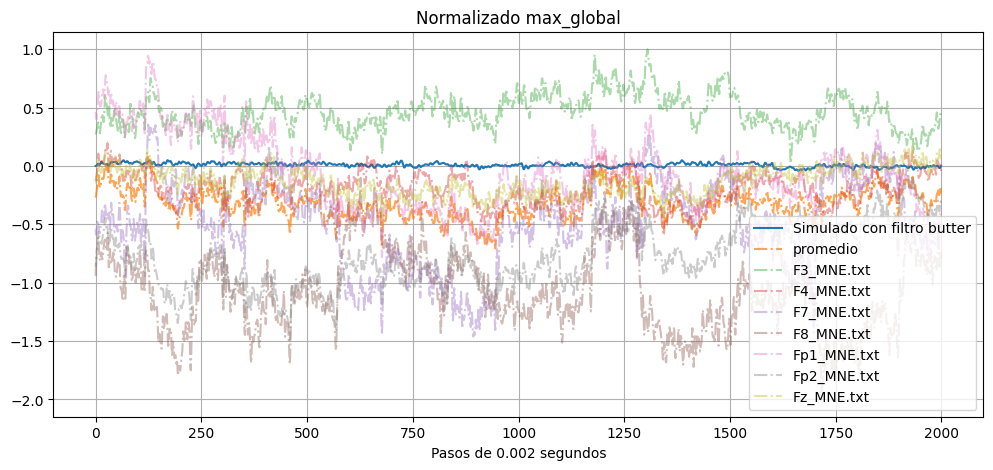

In [7]:
fig, ax = plt.subplots(figsize=[12, 5])


print(reales_total["Nombres"])
#ax.plot(generated_data["data_resample"],label="Simulado")

ax.plot(generated_data["butter"][:],label="Simulado con filtro butter")
grupos = np.array(reales_total["datos"])
promedio = np.mean(grupos, axis=0) 

ax.plot(promedio,"-.", label="promedio",alpha=0.7)

for i in range(len(reales_total["datos"])):
    ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.4)


plt.xlabel("Pasos de 0.002 segundos")
#plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.title(f"Normalizado {Normalizacion}")
plt.show()  # Mostrar todos los gráficos en la misma figura


241
['F3_MNE.txt', 'F4_MNE.txt', 'F7_MNE.txt', 'F8_MNE.txt', 'Fp1_MNE.txt', 'Fp2_MNE.txt', 'Fz_MNE.txt']
Delta [np.float64(-44.18454830659419), np.float64(2.474524536528806)] ---- [-23.12386289   3.12491284]
Theta [np.float64(-50.33229673977979), np.float64(1.5190272314844635)] ---- [-29.67521377   1.79235884]
Alpha [np.float64(-53.22670809333773), np.float64(1.312453578759814)] ---- [-35.24054366   2.07036529]
Beta [np.float64(-58.600704375446696), np.float64(1.3442520830242062)] ---- [-40.46253791   1.96464269]


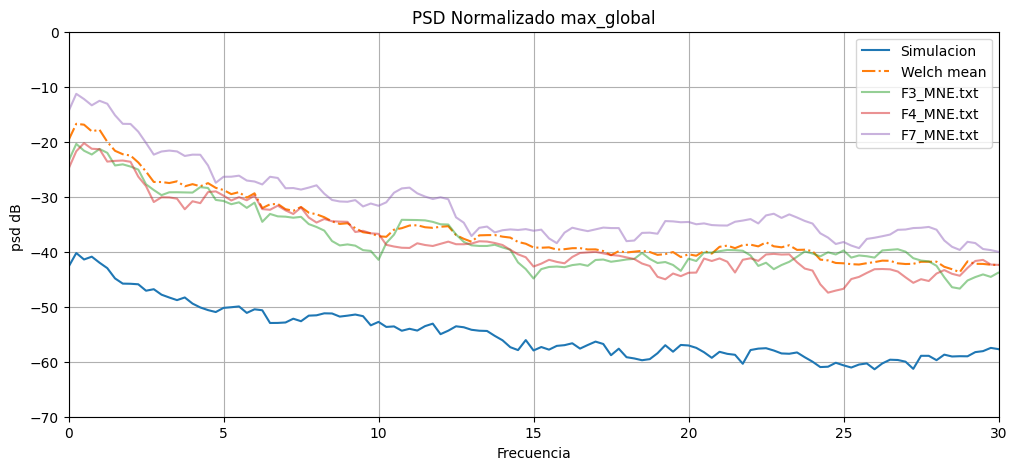

In [8]:
fig, ax = plt.subplots(figsize=[12, 5])
#print(generated_data["frequencies"])
frequencies = reales_total["frequencies"][0]
count_in_range = np.sum((frequencies >= 0) & (frequencies <= 60))
print(count_in_range)
print(reales_total["Nombres"])
print("Delta",generated_data["delta"],"----",reales_total["mean_Delta"])
print("Theta",generated_data["theta"],"----",reales_total["mean_Theta"])
print("Alpha",generated_data["alpha"],"----",reales_total["mean_Alpha"])
print("Beta",generated_data["beta"],"----",reales_total["mean_Beta"])

ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
ax.plot(reales_total["frequencies"][0],reales_total["mean_welch"],label="Welch mean",linestyle="-.")
for i in range(3):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i],alpha=0.5)

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.grid()
plt.xlim(0,30)
plt.ylim(-70,0)
plt.title(f"PSD Normalizado {Normalizacion}")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [9]:

Tipo_de_red="Random"

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',10,20)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0,5.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',3,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L10"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)



[I 2024-11-20 08:59:11,983] Using an existing study with name 'Chi30_Random_max_global_L10' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:13,634] Trial 500 finished with value: 211.40198822624157 and parameters: {'L': 13, 'P': 0.12088421488574952, 'Inh': 0.5530830311367998, 'Trest': 1.0663031792542208, 'Trelative': 2.7983316773935174, 'C_h': 0.019136215798100573, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:14,908] Trial 501 finished with value: 194.9084736661726 and parameters: {'L': 13, 'P': 0.13085831379863178, 'Inh': 0.5589859057767859, 'Trest': 1.1486266058305437, 'Trelative': 2.243125040186584, 'C_h': 0.005649447811902757, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:15,574] Trial 502 finished with value: 319.1018951745839 and parameters: {'L': 13, 'P': 0.10919324445244698, 'Inh': 0.5325521435913502, 'Trest': 1.06247241435959, 'Trelative': 2.0403995338578302, 'C_h': 0.00014484079641930922, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:16,224] Trial 503 finished with value: 183.8644475293808 and parameters: {'L': 13, 'P': 0.1201955329957335, 'Inh': 0.5610140991457927, 'Trest': 1.111801810991192, 'Trelative': 2.092033911561437, 'C_h': 0.006304441455093087, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:16,854] Trial 504 finished with value: 376.8378670931577 and parameters: {'L': 13, 'P': 0.12814194940033494, 'Inh': 0.543901377418962, 'Trest': 1.1379692273507303, 'Trelative': 2.1746307208587172, 'C_h': 0.006659722567076722, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:17,553] Trial 505 finished with value: 292.5534677098812 and parameters: {'L': 13, 'P': 0.1271457280939471, 'Inh': 0.5482410354148463, 'Trest': 1.0314997492105895, 'Trelative': 2.0442875469726434, 'C_h': 0.00016072201289926355, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:18,344] Trial 506 finished with value: 263.431190080733 and parameters: {'L': 13, 'P': 0.1234890836755044, 'Inh': 0.5544032102402757, 'Trest': 1.1373808604374864, 'Trelative': 2.020768591077296, 'C_h': 0.00898545673056538, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:18,966] Trial 507 finished with value: 140.6094434161482 and parameters: {'L': 13, 'P': 0.12709326744975843, 'Inh': 0.5608011647350115, 'Trest': 1.1754416174610491, 'Trelative': 2.286228201029774, 'C_h': 0.019848968774291646, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:19,566] Trial 508 finished with value: 288.46290454550694 and parameters: {'L': 13, 'P': 0.11993883428359316, 'Inh': 0.5546865527345942, 'Trest': 1.1013821852722516, 'Trelative': 2.0692374003082414, 'C_h': 0.0017530446260534786, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:20,286] Trial 509 finished with value: 182.3583726251545 and parameters: {'L': 13, 'P': 0.12821757392845887, 'Inh': 0.5573458145802346, 'Trest': 1.1316291896648913, 'Trelative': 2.1123564416174796, 'C_h': 0.010414850455050561, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:20,893] Trial 510 finished with value: 447.92864432516075 and parameters: {'L': 13, 'P': 0.11696849718821463, 'Inh': 0.544955330609279, 'Trest': 1.1220916499299811, 'Trelative': 2.0300209180854716, 'C_h': 0.002497534897294134, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:21,536] Trial 511 finished with value: 224.4214278667685 and parameters: {'L': 13, 'P': 0.10061357417654976, 'Inh': 0.5638342891467908, 'Trest': 1.087897795028431, 'Trelative': 2.101989030835286, 'C_h': 0.024222406884731672, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:22,165] Trial 512 finished with value: 168.0276597459521 and parameters: {'L': 13, 'P': 0.12982388818581786, 'Inh': 0.5701027792562336, 'Trest': 1.1257344589287346, 'Trelative': 2.0578599499816277, 'C_h': 0.021225630889540915, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:22,884] Trial 513 finished with value: 183.04417282386063 and parameters: {'L': 13, 'P': 0.1282787384736007, 'Inh': 0.5614361099938339, 'Trest': 1.1196029339557678, 'Trelative': 1.9911683266722044, 'C_h': 0.017460033863720435, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:23,489] Trial 514 finished with value: 424.31749040655984 and parameters: {'L': 13, 'P': 0.13394391365017616, 'Inh': 0.5606220651638026, 'Trest': 1.080304642567945, 'Trelative': 1.996826934311723, 'C_h': 0.00018369785152742932, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:24,086] Trial 515 finished with value: 205.53007724417148 and parameters: {'L': 13, 'P': 0.1148342020605549, 'Inh': 0.5624326642160504, 'Trest': 1.149190048791988, 'Trelative': 2.2752205325245694, 'C_h': 0.020676446652100184, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:24,625] Trial 516 finished with value: 3029.32326506348 and parameters: {'L': 13, 'P': 0.13664223997092942, 'Inh': 0.5582612031085793, 'Trest': 1.1488544548131074, 'Trelative': 1.5811270832786686, 'C_h': 0.022936807235402954, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:25,185] Trial 517 finished with value: 174.49503813022488 and parameters: {'L': 13, 'P': 0.1186658546745507, 'Inh': 0.5577981977831354, 'Trest': 1.147587245097982, 'Trelative': 2.3441734837322796, 'C_h': 0.023954797096408707, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:25,715] Trial 518 finished with value: 343.48034146170824 and parameters: {'L': 13, 'P': 0.10127687057956322, 'Inh': 0.5598534695618554, 'Trest': 1.1784962859717818, 'Trelative': 2.224401642670501, 'C_h': 0.027958215909783472, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:26,176] Trial 519 finished with value: 2094.650915043082 and parameters: {'L': 13, 'P': 0.12665668426413182, 'Inh': 0.6014217952601901, 'Trest': 1.0544819034014046, 'Trelative': 1.9319060565693518, 'C_h': 0.02314580926706801, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:26,755] Trial 520 finished with value: 284.3945909005655 and parameters: {'L': 13, 'P': 0.09323711693672164, 'Inh': 0.5653039288459136, 'Trest': 1.3044431544095176, 'Trelative': 2.354069310212899, 'C_h': 0.036768822703444594, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:27,327] Trial 521 finished with value: 419.4738471308063 and parameters: {'L': 13, 'P': 0.09987871130537754, 'Inh': 0.568200036198114, 'Trest': 1.295115247475141, 'Trelative': 2.341254282531634, 'C_h': 0.03142886295429213, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:27,881] Trial 522 finished with value: 106.2485830334438 and parameters: {'L': 13, 'P': 0.11648596826640562, 'Inh': 0.590546121934739, 'Trest': 1.1685284094450334, 'Trelative': 2.36253110503376, 'C_h': 0.03925082133458993, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:28,471] Trial 523 finished with value: 249.6000303866542 and parameters: {'L': 13, 'P': 0.09598776961468257, 'Inh': 0.5897415375778211, 'Trest': 1.2134084203065163, 'Trelative': 2.408032670675727, 'C_h': 0.03969720669535281, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:28,990] Trial 524 finished with value: 152.22852625123994 and parameters: {'L': 13, 'P': 0.1432623624348539, 'Inh': 0.5981926359767993, 'Trest': 1.1253895327582137, 'Trelative': 2.3249495873769415, 'C_h': 0.02444028393955388, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:29,574] Trial 525 finished with value: 71.9231713344609 and parameters: {'L': 13, 'P': 0.1398419216755003, 'Inh': 0.5848911299590955, 'Trest': 1.170470061684136, 'Trelative': 2.4093636682956543, 'C_h': 0.03738631687910794, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:30,169] Trial 526 finished with value: 98.5588978336748 and parameters: {'L': 13, 'P': 0.14076463913955656, 'Inh': 0.5922690671000626, 'Trest': 1.2280819048796836, 'Trelative': 2.3832013605141333, 'C_h': 0.04261048913858362, 'Tipo_red': 4}. Best is trial 53 with value: 46.77348810570849.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:30,730] Trial 527 finished with value: 40.44195922618621 and parameters: {'L': 13, 'P': 0.14836536057595562, 'Inh': 0.5948339027460612, 'Trest': 1.2348342733030229, 'Trelative': 2.3029961627080637, 'C_h': 0.043413129339991766, 'Tipo_red': 4}. Best is trial 527 with value: 40.44195922618621.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:31,277] Trial 528 finished with value: 96.41063191924226 and parameters: {'L': 13, 'P': 0.142754365740965, 'Inh': 0.5949159565173465, 'Trest': 1.3346185149332825, 'Trelative': 2.35017420894463, 'C_h': 0.048599170232654955, 'Tipo_red': 4}. Best is trial 527 with value: 40.44195922618621.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:31,825] Trial 529 finished with value: 27.496380557672794 and parameters: {'L': 13, 'P': 0.14204674963491734, 'Inh': 0.5987056847153887, 'Trest': 1.2983507987888765, 'Trelative': 2.3332876579142434, 'C_h': 0.02730483927239296, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:32,345] Trial 530 finished with value: 8403.090683153789 and parameters: {'L': 13, 'P': 0.1461597509818839, 'Inh': 0.6477039754164244, 'Trest': 1.2101796565532155, 'Trelative': 2.5035225357462902, 'C_h': 0.044683359918540874, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:32,916] Trial 531 finished with value: 103.3243065617179 and parameters: {'L': 13, 'P': 0.14569378822905346, 'Inh': 0.598036613733851, 'Trest': 1.2735986630942726, 'Trelative': 2.2930239272508843, 'C_h': 0.04756423462767047, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:33,437] Trial 532 finished with value: 62.32267694414208 and parameters: {'L': 13, 'P': 0.14326323850052652, 'Inh': 0.5950819396141839, 'Trest': 1.2334937642116117, 'Trelative': 2.3403265865557863, 'C_h': 0.05149744139595365, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:34,061] Trial 533 finished with value: 45.585164245741744 and parameters: {'L': 13, 'P': 0.14590834563539462, 'Inh': 0.6017891974320997, 'Trest': 1.2737818556724523, 'Trelative': 2.3007191229492636, 'C_h': 0.04996410789537586, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:34,635] Trial 534 finished with value: 37.38463161622115 and parameters: {'L': 13, 'P': 0.1441557366546279, 'Inh': 0.5945593151382383, 'Trest': 1.3561600683135584, 'Trelative': 2.276148915877064, 'C_h': 0.054903786808295496, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:35,157] Trial 535 finished with value: 57.52613089650557 and parameters: {'L': 13, 'P': 0.1449263752389059, 'Inh': 0.5958119022430769, 'Trest': 1.3713098763036844, 'Trelative': 2.3277153565912316, 'C_h': 0.0508141856366412, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:35,660] Trial 536 finished with value: 338.040349884946 and parameters: {'L': 13, 'P': 0.15159927968731332, 'Inh': 0.5979607752505158, 'Trest': 1.347877399473396, 'Trelative': 2.3565259643872003, 'C_h': 0.05285278830550677, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:36,125] Trial 537 finished with value: 81.19422136854044 and parameters: {'L': 13, 'P': 0.1433115268578487, 'Inh': 0.6002186116651891, 'Trest': 1.3305250694678759, 'Trelative': 2.536671184497189, 'C_h': 0.05134947821600104, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:36,546] Trial 538 finished with value: 2060.6316597493496 and parameters: {'L': 13, 'P': 0.1452312860020964, 'Inh': 0.6007220771993258, 'Trest': 1.3434320750266155, 'Trelative': 1.745416789092895, 'C_h': 0.052675658924959894, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:37,003] Trial 539 finished with value: 9718.481945821368 and parameters: {'L': 13, 'P': 0.14159500438537287, 'Inh': 0.6342581848035254, 'Trest': 1.2880083710415327, 'Trelative': 2.5511506535781194, 'C_h': 0.05091280056572325, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:37,530] Trial 540 finished with value: 811.7992282747541 and parameters: {'L': 13, 'P': 0.1718277977785604, 'Inh': 0.5936465939138899, 'Trest': 1.3829405298803006, 'Trelative': 2.510187847155576, 'C_h': 0.03554280603527, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:38,053] Trial 541 finished with value: 909.5027457801457 and parameters: {'L': 13, 'P': 0.14278172351530344, 'Inh': 0.6161159391706823, 'Trest': 1.2545787746496537, 'Trelative': 2.2464626442317117, 'C_h': 0.055315592830503815, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:38,610] Trial 542 finished with value: 818.2778742386776 and parameters: {'L': 13, 'P': 0.14266952833967683, 'Inh': 0.5902928563302406, 'Trest': 1.2307867890799002, 'Trelative': 1.8361055205057613, 'C_h': 0.03998972961558385, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:39,161] Trial 543 finished with value: 1049.1929723563483 and parameters: {'L': 13, 'P': 0.16877512556126245, 'Inh': 0.6325287995613241, 'Trest': 1.3845839891428786, 'Trelative': 2.6966846793649912, 'C_h': 0.061440728798863836, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:39,676] Trial 544 finished with value: 881.467856630941 and parameters: {'L': 13, 'P': 0.17628193468141956, 'Inh': 0.6045211011564603, 'Trest': 1.2941427194874082, 'Trelative': 2.418309703839043, 'C_h': 0.02386979570076238, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:40,212] Trial 545 finished with value: 59.74671603727602 and parameters: {'L': 13, 'P': 0.14916828038366123, 'Inh': 0.590894761508307, 'Trest': 1.1699538710903157, 'Trelative': 2.284212008570835, 'C_h': 0.03975739291354607, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:40,860] Trial 546 finished with value: 171.1631899517406 and parameters: {'L': 13, 'P': 0.14862671875050604, 'Inh': 0.583084700349712, 'Trest': 1.1918804895621833, 'Trelative': 2.147330060593821, 'C_h': 0.04370970610098178, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:41,437] Trial 547 finished with value: 79.26724479138338 and parameters: {'L': 13, 'P': 0.1494829055790617, 'Inh': 0.5940640709549814, 'Trest': 1.229836848101808, 'Trelative': 2.241512711374525, 'C_h': 0.04323296922214749, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:42,039] Trial 548 finished with value: 71.34224066349144 and parameters: {'L': 13, 'P': 0.14681187270618368, 'Inh': 0.5852936574528143, 'Trest': 1.4103956604699859, 'Trelative': 2.2787834079622353, 'C_h': 0.05888177814962077, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:42,609] Trial 549 finished with value: 96.78446596992802 and parameters: {'L': 13, 'P': 0.15342012200699193, 'Inh': 0.587953579795823, 'Trest': 1.409093600981149, 'Trelative': 2.544287717791406, 'C_h': 0.05967146403414791, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:43,160] Trial 550 finished with value: 102.49483567331038 and parameters: {'L': 13, 'P': 0.15317692639101774, 'Inh': 0.5899549869586798, 'Trest': 1.423148423996717, 'Trelative': 2.608347965344518, 'C_h': 0.092709495281279, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:43,709] Trial 551 finished with value: 129.45021461204138 and parameters: {'L': 13, 'P': 0.17111048011099103, 'Inh': 0.6079474796325322, 'Trest': 1.4473885603182994, 'Trelative': 2.656160288040074, 'C_h': 0.09983456971328511, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:44,212] Trial 552 finished with value: 11745.477848918208 and parameters: {'L': 13, 'P': 0.17466289819051803, 'Inh': 0.6600940127728254, 'Trest': 1.4284079408398127, 'Trelative': 2.684615454776706, 'C_h': 0.09503375679139114, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:44,852] Trial 553 finished with value: 66.46385907300214 and parameters: {'L': 13, 'P': 0.1534848317076371, 'Inh': 0.6054065380620567, 'Trest': 1.4521132694368448, 'Trelative': 2.838768429045472, 'C_h': 0.0845754152945635, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:45,376] Trial 554 finished with value: 452.1143208946726 and parameters: {'L': 13, 'P': 0.15687050074463252, 'Inh': 0.6125532224740532, 'Trest': 1.5153629974792189, 'Trelative': 2.5514991341224684, 'C_h': 0.08583630649847855, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:45,897] Trial 555 finished with value: 4488.730082758207 and parameters: {'L': 13, 'P': 0.17956629162876028, 'Inh': 0.6240347654653607, 'Trest': 1.4203862714810191, 'Trelative': 2.656669942167819, 'C_h': 0.07306628531385985, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:46,487] Trial 556 finished with value: 73.59719035615508 and parameters: {'L': 13, 'P': 0.14825450099308246, 'Inh': 0.6020351167627063, 'Trest': 1.3633689262274789, 'Trelative': 2.82468677781751, 'C_h': 0.09665766792178855, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:46,994] Trial 557 finished with value: 746.8827593026158 and parameters: {'L': 13, 'P': 0.16016356169227583, 'Inh': 0.6382392205405427, 'Trest': 1.3584909188487857, 'Trelative': 2.790641613953742, 'C_h': 0.09779241922249879, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:47,608] Trial 558 finished with value: 97.97686701279542 and parameters: {'L': 13, 'P': 0.1757660267710665, 'Inh': 0.6059766532233648, 'Trest': 1.5434159778988767, 'Trelative': 2.800150966544326, 'C_h': 0.10122406440072797, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:48,185] Trial 559 finished with value: 54.42830886501781 and parameters: {'L': 13, 'P': 0.1775312339754695, 'Inh': 0.6067450634312234, 'Trest': 1.5431659145353191, 'Trelative': 2.9406455806444436, 'C_h': 0.11061299161678806, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:48,693] Trial 560 finished with value: 12176.550065056343 and parameters: {'L': 13, 'P': 0.1812303997693617, 'Inh': 0.6475438080486717, 'Trest': 1.5594447882338491, 'Trelative': 2.877739238019932, 'C_h': 0.06921206967916048, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:49,331] Trial 561 finished with value: 168.1791657018638 and parameters: {'L': 13, 'P': 0.15530821508211753, 'Inh': 0.5873902119019891, 'Trest': 1.5889706583571688, 'Trelative': 2.9489648585240906, 'C_h': 0.11301642272588347, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:49,842] Trial 562 finished with value: 122.25956033195138 and parameters: {'L': 13, 'P': 0.1505394069028885, 'Inh': 0.6234464450683512, 'Trest': 1.4392248128235348, 'Trelative': 2.5100528837938176, 'C_h': 0.06628505623754706, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:50,496] Trial 563 finished with value: 2321.0446468562172 and parameters: {'L': 13, 'P': 0.21444244163870263, 'Inh': 0.6017633137775289, 'Trest': 1.3366131908506091, 'Trelative': 2.8537112975899515, 'C_h': 0.09193480630668152, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:51,222] Trial 564 finished with value: 58.749254777128776 and parameters: {'L': 13, 'P': 0.18391449005746585, 'Inh': 0.5871043846581231, 'Trest': 1.542802304255993, 'Trelative': 3.1825855413789332, 'C_h': 0.059566603459589876, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:51,890] Trial 565 finished with value: 129.66764727327 and parameters: {'L': 13, 'P': 0.1805960909817325, 'Inh': 0.5901111279181024, 'Trest': 1.488418600457031, 'Trelative': 3.1429833499506037, 'C_h': 0.053913634340885905, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:52,424] Trial 566 finished with value: 400.8918253529231 and parameters: {'L': 13, 'P': 0.15626439942317363, 'Inh': 0.6125066634145668, 'Trest': 1.5490220564161115, 'Trelative': 2.498274677445218, 'C_h': 0.05904477294175411, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:53,043] Trial 567 finished with value: 86.00243810978725 and parameters: {'L': 13, 'P': 0.18736226767113434, 'Inh': 0.5870995670067616, 'Trest': 1.3475732545413917, 'Trelative': 2.9393373231544713, 'C_h': 0.08306289827578527, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:53,621] Trial 568 finished with value: 60.7373097852541 and parameters: {'L': 13, 'P': 0.1859879138693179, 'Inh': 0.5845196395772999, 'Trest': 1.3512647594698801, 'Trelative': 2.9711161904316126, 'C_h': 0.10900173809140598, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:54,167] Trial 569 finished with value: 207.10766506929974 and parameters: {'L': 13, 'P': 0.21049403805206082, 'Inh': 0.6266502908980922, 'Trest': 1.3756145101495267, 'Trelative': 2.982856042871072, 'C_h': 0.10762961892886025, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:54,701] Trial 570 finished with value: 94.82752023292262 and parameters: {'L': 13, 'P': 0.18807149231679846, 'Inh': 0.6029405032997345, 'Trest': 1.608435902633297, 'Trelative': 3.1853267085600674, 'C_h': 0.0802852882908583, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:55,428] Trial 571 finished with value: 91.28882757895597 and parameters: {'L': 13, 'P': 0.18213432037895771, 'Inh': 0.5830487402973413, 'Trest': 1.5794868107913276, 'Trelative': 3.1875390533242873, 'C_h': 0.08200471917458707, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:55,980] Trial 572 finished with value: 57.88956780919539 and parameters: {'L': 13, 'P': 0.19284242256778106, 'Inh': 0.6137173360742049, 'Trest': 1.6073642227059577, 'Trelative': 3.238175932045386, 'C_h': 0.11375728339448177, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:56,461] Trial 573 finished with value: 1212.817004323327 and parameters: {'L': 13, 'P': 0.19232320361696087, 'Inh': 0.632754117928037, 'Trest': 1.621088466162686, 'Trelative': 3.2241001377732577, 'C_h': 0.11524754890911898, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:56,998] Trial 574 finished with value: 3102.3774974692474 and parameters: {'L': 13, 'P': 0.21273174355128557, 'Inh': 0.6140621581603258, 'Trest': 1.635269978399825, 'Trelative': 3.2266206010084604, 'C_h': 0.0824024850294355, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:57,575] Trial 575 finished with value: 100.40354769995005 and parameters: {'L': 13, 'P': 0.184572627967914, 'Inh': 0.5806516303322599, 'Trest': 1.542623896516924, 'Trelative': 3.027579933067534, 'C_h': 0.10944535602149479, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:58,075] Trial 576 finished with value: 430.9404274640156 and parameters: {'L': 13, 'P': 0.1857891285975933, 'Inh': 0.6098285769364356, 'Trest': 1.4941315041715117, 'Trelative': 3.3895998238467975, 'C_h': 0.08499983694792795, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:58,559] Trial 577 finished with value: 14419.203778712095 and parameters: {'L': 13, 'P': 0.2199736591911831, 'Inh': 0.63444631799856, 'Trest': 1.6320392603250178, 'Trelative': 2.8915599155857366, 'C_h': 0.07010395162053659, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:59,185] Trial 578 finished with value: 116.4428080175753 and parameters: {'L': 13, 'P': 0.16779344129067836, 'Inh': 0.5802227439195112, 'Trest': 1.5217703783856595, 'Trelative': 3.107260490078915, 'C_h': 0.06579540693979209, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:59,745] Trial 579 finished with value: 446.74827081756723 and parameters: {'L': 13, 'P': 0.2059036040898301, 'Inh': 0.6153696379934952, 'Trest': 1.364492355656749, 'Trelative': 2.8566185738045817, 'C_h': 0.09114211784597658, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:00,281] Trial 580 finished with value: 9932.92636086142 and parameters: {'L': 13, 'P': 0.18284310549756844, 'Inh': 0.6576415682249391, 'Trest': 1.6960594222893375, 'Trelative': 2.7167100623734775, 'C_h': 0.12081012738065562, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:00,850] Trial 581 finished with value: 149.39536429790493 and parameters: {'L': 13, 'P': 0.17383950758066422, 'Inh': 0.5790521019865431, 'Trest': 1.4598232046840207, 'Trelative': 3.153132634248941, 'C_h': 0.061078475815457625, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:01,413] Trial 582 finished with value: 102.26399563149019 and parameters: {'L': 13, 'P': 0.19801268616213166, 'Inh': 0.6021962465909142, 'Trest': 1.5532227718652067, 'Trelative': 3.437269317630113, 'C_h': 0.08135160196278807, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:01,911] Trial 583 finished with value: 1919.5428374298012 and parameters: {'L': 13, 'P': 0.16985705210140786, 'Inh': 0.6329907159027555, 'Trest': 1.3040290875238012, 'Trelative': 2.8131978097075243, 'C_h': 0.10567430405868572, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:02,525] Trial 584 finished with value: 59.744081451232006 and parameters: {'L': 13, 'P': 0.16411952136791647, 'Inh': 0.6104794783567035, 'Trest': 1.4026434537871604, 'Trelative': 3.0636799768895067, 'C_h': 0.05869126871464049, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:03,142] Trial 585 finished with value: 96.82894018214087 and parameters: {'L': 13, 'P': 0.1669742809600323, 'Inh': 0.5760121659123155, 'Trest': 1.402911680921807, 'Trelative': 3.274412338960163, 'C_h': 0.0582582785982415, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:03,698] Trial 586 finished with value: 294.3240579606261 and parameters: {'L': 13, 'P': 0.19232627343830405, 'Inh': 0.6214667147610323, 'Trest': 1.3295898534671036, 'Trelative': 3.0465729091227676, 'C_h': 0.07226809369072239, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:04,361] Trial 587 finished with value: 136.34579972418817 and parameters: {'L': 13, 'P': 0.15012288420145894, 'Inh': 0.5822170275888328, 'Trest': 1.3938461382688685, 'Trelative': 3.5371187018573913, 'C_h': 0.06304332007447598, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:04,890] Trial 588 finished with value: 9131.777980210585 and parameters: {'L': 13, 'P': 0.22000077365501636, 'Inh': 0.6446086430992946, 'Trest': 1.6374800116478134, 'Trelative': 2.542628790288909, 'C_h': 0.04715136747113964, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:05,490] Trial 589 finished with value: 106.44754485616059 and parameters: {'L': 13, 'P': 0.1407728347062748, 'Inh': 0.6025002887510497, 'Trest': 1.4425207250130738, 'Trelative': 3.0049803389261966, 'C_h': 0.08422244817294286, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:06,134] Trial 590 finished with value: 75.37304622176494 and parameters: {'L': 13, 'P': 0.15848884919896156, 'Inh': 0.580344514860343, 'Trest': 1.3026425668962225, 'Trelative': 3.223738747441509, 'C_h': 0.039840716881768615, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:06,770] Trial 591 finished with value: 8283.747148614162 and parameters: {'L': 13, 'P': 0.18743581804418044, 'Inh': 0.621935955567232, 'Trest': 1.3282367252122067, 'Trelative': 3.3722814014288423, 'C_h': 0.038289066940118646, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:07,296] Trial 592 finished with value: 10013.663725176222 and parameters: {'L': 13, 'P': 0.16654260935763732, 'Inh': 0.6637514377449163, 'Trest': 1.2814640264552488, 'Trelative': 3.2213936631761775, 'C_h': 0.040820870315848155, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:07,942] Trial 593 finished with value: 160.0193839551153 and parameters: {'L': 13, 'P': 0.14040945675645483, 'Inh': 0.5792431051371958, 'Trest': 1.4732370894630493, 'Trelative': 2.9621399106757096, 'C_h': 0.08841420836852118, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:08,472] Trial 594 finished with value: 1630.105968760646 and parameters: {'L': 13, 'P': 0.20235248920645674, 'Inh': 0.6037925394344568, 'Trest': 1.273807633275413, 'Trelative': 2.769239443617768, 'C_h': 0.04755533198406378, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:08,955] Trial 595 finished with value: 1654.3570448355288 and parameters: {'L': 13, 'P': 0.16899439101787997, 'Inh': 0.6385742309862129, 'Trest': 1.578900246083377, 'Trelative': 3.2977437049893448, 'C_h': 0.07395646651896756, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:09,600] Trial 596 finished with value: 259.87909441622344 and parameters: {'L': 13, 'P': 0.13516507701052136, 'Inh': 0.5799127914892759, 'Trest': 1.6974065399562188, 'Trelative': 3.5231755576399326, 'C_h': 0.11547133630795409, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:10,146] Trial 597 finished with value: 730.7378016031083 and parameters: {'L': 13, 'P': 0.2286993790857082, 'Inh': 0.6090243477827644, 'Trest': 1.3179029930577844, 'Trelative': 3.08407432376779, 'C_h': 0.05648685445899499, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:10,635] Trial 598 finished with value: 14807.540769552097 and parameters: {'L': 13, 'P': 0.16028989421629952, 'Inh': 0.624017128813276, 'Trest': 1.4882222794080886, 'Trelative': 2.6991433638771776, 'C_h': 0.034625612387209695, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:11,205] Trial 599 finished with value: 304.992110567346 and parameters: {'L': 13, 'P': 0.18953392406809144, 'Inh': 0.5969530411280954, 'Trest': 1.2582330439263798, 'Trelative': 1.8532483750200133, 'C_h': 0.07985243921101681, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:11,779] Trial 600 finished with value: 163.92922474464606 and parameters: {'L': 13, 'P': 0.11176808048084562, 'Inh': 0.5795221001754416, 'Trest': 1.3799646937922092, 'Trelative': 2.872123959181686, 'C_h': 0.03993746992821869, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:12,336] Trial 601 finished with value: 72.36571964693482 and parameters: {'L': 13, 'P': 0.13927803212427126, 'Inh': 0.6038849650811121, 'Trest': 1.5374550638336548, 'Trelative': 3.151138403115302, 'C_h': 0.05767499713356538, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:12,799] Trial 602 finished with value: 4817.872169533064 and parameters: {'L': 13, 'P': 0.16466128161588486, 'Inh': 0.643714041017974, 'Trest': 1.610778777145356, 'Trelative': 3.1960844398390997, 'C_h': 0.1006735935676777, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:13,304] Trial 603 finished with value: 462.2326543659469 and parameters: {'L': 13, 'P': 0.1967413726232278, 'Inh': 0.618752876694546, 'Trest': 1.711090003088471, 'Trelative': 3.103486359850762, 'C_h': 0.07021052382533471, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:14,044] Trial 604 finished with value: 107.59232838206958 and parameters: {'L': 13, 'P': 0.1343897172498789, 'Inh': 0.5795118775227505, 'Trest': 1.499689918021923, 'Trelative': 3.372111099399314, 'C_h': 0.1262967871116855, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:14,687] Trial 605 finished with value: 242.4457491801514 and parameters: {'L': 13, 'P': 0.09448720087421142, 'Inh': 0.6064382799907931, 'Trest': 1.5903319456057448, 'Trelative': 2.9336608531381607, 'C_h': 0.09146082729274084, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:15,233] Trial 606 finished with value: 13934.245096311435 and parameters: {'L': 13, 'P': 0.15822688194217874, 'Inh': 0.6692301785976991, 'Trest': 1.4616411285431412, 'Trelative': 3.449009422492191, 'C_h': 0.05826341790016929, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:15,845] Trial 607 finished with value: 10784.377107229744 and parameters: {'L': 13, 'P': 0.17455301886945054, 'Inh': 0.6197798137911211, 'Trest': 1.7454493094942996, 'Trelative': 2.661518343944327, 'C_h': 0.03444729327130043, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:16,391] Trial 608 finished with value: 11966.928304184172 and parameters: {'L': 13, 'P': 0.21522772668726262, 'Inh': 0.6446709069178733, 'Trest': 1.4345536073873792, 'Trelative': 3.129064154840395, 'C_h': 0.07212910251758307, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:16,988] Trial 609 finished with value: 218.7974305309557 and parameters: {'L': 13, 'P': 0.11222738250066984, 'Inh': 0.5722468643325327, 'Trest': 1.2617794577024655, 'Trelative': 2.4761272293769863, 'C_h': 0.10825232520312028, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:17,525] Trial 610 finished with value: 441.1243104716242 and parameters: {'L': 13, 'P': 0.14910845813772208, 'Inh': 0.5995361805612403, 'Trest': 1.63261900347188, 'Trelative': 2.2306536726645807, 'C_h': 0.030237820760763146, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:17,999] Trial 611 finished with value: 475.4738151432076 and parameters: {'L': 13, 'P': 0.18303762845867405, 'Inh': 0.6287466945706641, 'Trest': 1.5276875994488421, 'Trelative': 2.943920367270511, 'C_h': 0.05732641914270209, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:18,626] Trial 612 finished with value: 170.06141633849055 and parameters: {'L': 13, 'P': 0.12965452626109836, 'Inh': 0.5769504863612588, 'Trest': 1.3568738422107989, 'Trelative': 2.801918133044722, 'C_h': 0.08211084659238788, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:19,194] Trial 613 finished with value: 124.28667463999491 and parameters: {'L': 13, 'P': 0.1570197912634702, 'Inh': 0.5945752658482113, 'Trest': 1.229819774070417, 'Trelative': 3.25474332832634, 'C_h': 0.05396467238920094, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:19,723] Trial 614 finished with value: 73.84982867379614 and parameters: {'L': 13, 'P': 0.2033518838119513, 'Inh': 0.614820654156707, 'Trest': 1.4594128971450617, 'Trelative': 3.585077683341068, 'C_h': 0.030878581747980926, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:20,270] Trial 615 finished with value: 702.5558303279164 and parameters: {'L': 13, 'P': 0.20610241347337718, 'Inh': 0.6273799453748714, 'Trest': 1.4061568748018025, 'Trelative': 3.657222637690206, 'C_h': 0.025280782054033148, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:20,720] Trial 616 finished with value: 4982.514232271472 and parameters: {'L': 13, 'P': 0.11321783027751434, 'Inh': 0.6511069443321577, 'Trest': 1.2667022327214537, 'Trelative': 2.5344872258174513, 'C_h': 0.03582307128987729, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:21,402] Trial 617 finished with value: 210.49792695933334 and parameters: {'L': 13, 'P': 0.1449308022656413, 'Inh': 0.5370217940850752, 'Trest': 1.4869262786830852, 'Trelative': 2.2460183544718215, 'C_h': 0.023274951885400907, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:22,057] Trial 618 finished with value: 72.01821148082662 and parameters: {'L': 13, 'P': 0.1689251206770964, 'Inh': 0.5726907389594069, 'Trest': 1.3630205987674615, 'Trelative': 2.655140857731765, 'C_h': 0.04628898263848779, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:22,617] Trial 619 finished with value: 56.728843891421825 and parameters: {'L': 13, 'P': 0.1314794378532714, 'Inh': 0.6110766073685516, 'Trest': 1.3465672111412514, 'Trelative': 2.704095853043365, 'C_h': 0.049186662471217224, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:23,223] Trial 620 finished with value: 125.55571376059613 and parameters: {'L': 13, 'P': 0.09973355358901087, 'Inh': 0.6190146620840882, 'Trest': 1.2348594092138756, 'Trelative': 2.6552957481108157, 'C_h': 0.04022322283939476, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:23,809] Trial 621 finished with value: 44.300383069994965 and parameters: {'L': 13, 'P': 0.13042452609249783, 'Inh': 0.6095994796389899, 'Trest': 1.3872309599927724, 'Trelative': 2.4206664913766343, 'C_h': 0.019924229685552543, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:24,330] Trial 622 finished with value: 12629.436832281574 and parameters: {'L': 13, 'P': 0.11652960598286947, 'Inh': 0.6615703898098095, 'Trest': 1.4488281339640543, 'Trelative': 2.2256108043625242, 'C_h': 0.01993307610082693, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:24,903] Trial 623 finished with value: 243.57988298388426 and parameters: {'L': 13, 'P': 0.1294059936406612, 'Inh': 0.6421447805656046, 'Trest': 1.376904109743055, 'Trelative': 2.4777925286148657, 'C_h': 0.014393160602542025, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:25,495] Trial 624 finished with value: 67.20889523683724 and parameters: {'L': 13, 'P': 0.09317697275015557, 'Inh': 0.6107858495999928, 'Trest': 1.2518842841477569, 'Trelative': 2.1648253075952306, 'C_h': 0.0011157632288677066, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:26,085] Trial 625 finished with value: 4686.248712072587 and parameters: {'L': 13, 'P': 0.09075503430477161, 'Inh': 0.6119409299145808, 'Trest': 1.476294656059629, 'Trelative': 1.7296963414666027, 'C_h': 0.009428225796428609, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:26,584] Trial 626 finished with value: 1520.262734036654 and parameters: {'L': 13, 'P': 0.08914520139967463, 'Inh': 0.6316733718077663, 'Trest': 1.337804612592813, 'Trelative': 1.921304674349272, 'C_h': 0.0037164192638469637, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:27,238] Trial 627 finished with value: 272.96165186167815 and parameters: {'L': 13, 'P': 0.10928026740193644, 'Inh': 0.5722403416661012, 'Trest': 1.22410990454249, 'Trelative': 2.7235153477549483, 'C_h': 0.027482024515340122, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:27,803] Trial 628 finished with value: 132.75563773726617 and parameters: {'L': 13, 'P': 0.130022636067194, 'Inh': 0.6154979871212248, 'Trest': 1.4162660186552212, 'Trelative': 2.4042982681285503, 'C_h': 0.03094717516809633, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:28,391] Trial 629 finished with value: 33.374023003538845 and parameters: {'L': 13, 'P': 0.10585661378263866, 'Inh': 0.6420513829246034, 'Trest': 1.5339044048613, 'Trelative': 2.1600327384280695, 'C_h': 0.0032810551018031195, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:28,935] Trial 630 finished with value: 54.84350637598866 and parameters: {'L': 13, 'P': 0.08194051617292766, 'Inh': 0.6529235262731198, 'Trest': 1.532713236150482, 'Trelative': 1.9648319622939316, 'C_h': 0.04926039613129612, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:29,438] Trial 631 finished with value: 493.56756507533987 and parameters: {'L': 13, 'P': 0.08127805555391608, 'Inh': 0.6752129730779596, 'Trest': 1.4906806775032537, 'Trelative': 2.117579833490267, 'C_h': 0.06434023435718794, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:29,959] Trial 632 finished with value: 11149.227733747886 and parameters: {'L': 13, 'P': 0.1118556080663233, 'Inh': 0.6594138885445826, 'Trest': 1.4828894258929326, 'Trelative': 1.9582498775304045, 'C_h': 0.0014777555732400777, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:30,474] Trial 633 finished with value: 6055.069795106533 and parameters: {'L': 13, 'P': 0.0895886632638633, 'Inh': 0.6424926336122669, 'Trest': 1.5706322673274675, 'Trelative': 1.883106183361168, 'C_h': 0.05821257370047579, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:30,942] Trial 634 finished with value: 1256.13463063397 and parameters: {'L': 14, 'P': 0.07929067877902768, 'Inh': 0.6735772757957376, 'Trest': 1.3827483774760376, 'Trelative': 2.068488282280801, 'C_h': 0.024630058837238705, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:31,455] Trial 635 finished with value: 105.92903366649739 and parameters: {'L': 13, 'P': 0.10593041056559582, 'Inh': 0.6480626728967528, 'Trest': 1.520006540203464, 'Trelative': 2.155458729433847, 'C_h': 0.047279112898055274, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:31,951] Trial 636 finished with value: 3864.1741548232526 and parameters: {'L': 13, 'P': 0.12488039281417736, 'Inh': 0.6595790224334318, 'Trest': 1.641834106096362, 'Trelative': 2.3884591094884464, 'C_h': 0.026576270257175343, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:32,446] Trial 637 finished with value: 1968.186610871423 and parameters: {'L': 13, 'P': 0.09843340100388072, 'Inh': 0.632491402396764, 'Trest': 1.4133008342434359, 'Trelative': 1.8200682548213498, 'C_h': 0.0593929458260352, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:33,013] Trial 638 finished with value: 155.03849817785257 and parameters: {'L': 13, 'P': 0.13611155030418892, 'Inh': 0.6310559447070541, 'Trest': 1.205357675617913, 'Trelative': 2.488851370620137, 'C_h': 0.022230505340274025, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:33,555] Trial 639 finished with value: 159.71703888099483 and parameters: {'L': 13, 'P': 0.07814300970577946, 'Inh': 0.6128265084435104, 'Trest': 1.3082872980221518, 'Trelative': 2.2352852540584247, 'C_h': 0.044100382880703046, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:34,002] Trial 640 finished with value: 1111.3495019965014 and parameters: {'L': 13, 'P': 0.11888022025842943, 'Inh': 0.6712352995453987, 'Trest': 1.547450304496209, 'Trelative': 2.680766371278168, 'C_h': 0.05905384231096543, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:34,509] Trial 641 finished with value: 11507.919752602631 and parameters: {'L': 14, 'P': 0.13420176756026483, 'Inh': 0.6257625979921007, 'Trest': 1.3933866934341719, 'Trelative': 1.6240248300112818, 'C_h': 0.002955286829792809, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:34,975] Trial 642 finished with value: 46.45370287375364 and parameters: {'L': 12, 'P': 0.10052171253023182, 'Inh': 0.6496907239575289, 'Trest': 1.2897659575422504, 'Trelative': 2.4099606435168552, 'C_h': 0.10420758775042593, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:35,553] Trial 643 finished with value: 71.57697132969102 and parameters: {'L': 12, 'P': 0.0942407974582403, 'Inh': 0.6533489320977451, 'Trest': 1.2534879384035376, 'Trelative': 2.18359299211516, 'C_h': 0.13228103484675943, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:36,031] Trial 644 finished with value: 13251.155330594735 and parameters: {'L': 12, 'P': 0.08069040911637226, 'Inh': 0.6647758945899179, 'Trest': 1.1739357957328762, 'Trelative': 1.6337878739540113, 'C_h': 0.13788999544856495, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:36,545] Trial 645 finished with value: 94.00662807439042 and parameters: {'L': 12, 'P': 0.09821299535431607, 'Inh': 0.6507397831998867, 'Trest': 1.0023783089893703, 'Trelative': 1.9686293788616847, 'C_h': 0.1260720029794074, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:37,197] Trial 646 finished with value: 90.12177261043288 and parameters: {'L': 14, 'P': 0.06023241427340187, 'Inh': 0.6785971478557676, 'Trest': 1.2248294989216877, 'Trelative': 2.170072123309078, 'C_h': 0.11291769260618642, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:37,708] Trial 647 finished with value: 161.34871197781027 and parameters: {'L': 12, 'P': 0.08998359150102753, 'Inh': 0.6488197283682889, 'Trest': 1.2750784453323076, 'Trelative': 2.367295954283755, 'C_h': 0.09889444593486196, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:38,148] Trial 648 finished with value: 91.93812435746338 and parameters: {'L': 12, 'P': 0.10309069538603208, 'Inh': 0.6406985989204595, 'Trest': 1.0082525379435334, 'Trelative': 2.1703323595599713, 'C_h': 0.07114037873815308, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:38,596] Trial 649 finished with value: 64.76870025586732 and parameters: {'L': 12, 'P': 0.06962778486766055, 'Inh': 0.6316866821324737, 'Trest': 1.206547246245788, 'Trelative': 2.43150017114025, 'C_h': 0.1418682838528066, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:39,121] Trial 650 finished with value: 210.7412584620907 and parameters: {'L': 12, 'P': 0.06707082839386594, 'Inh': 0.6645039333547549, 'Trest': 1.182119537987007, 'Trelative': 2.4312259082356773, 'C_h': 0.13143432847849446, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:39,646] Trial 651 finished with value: 203.5760373590741 and parameters: {'L': 12, 'P': 0.06783730974723665, 'Inh': 0.6312708064074551, 'Trest': 0.9965928331180435, 'Trelative': 1.8886881210056268, 'C_h': 0.14230506408077537, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:40,151] Trial 652 finished with value: 111.41997234632701 and parameters: {'L': 12, 'P': 0.0849892471972932, 'Inh': 0.6557207994230314, 'Trest': 1.2847549044004847, 'Trelative': 2.3180492530769414, 'C_h': 0.12072473663628999, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:40,646] Trial 653 finished with value: 10698.293162791182 and parameters: {'L': 12, 'P': 0.10979749295652286, 'Inh': 0.6747377103824463, 'Trest': 1.2036231958306705, 'Trelative': 2.556554672435035, 'C_h': 0.16263242851106946, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:41,133] Trial 654 finished with value: 176.56470737691106 and parameters: {'L': 12, 'P': 0.11563233491082045, 'Inh': 0.632902771289081, 'Trest': 1.0724313781862957, 'Trelative': 2.112248386520141, 'C_h': 0.1033730542354431, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:41,665] Trial 655 finished with value: 159.7410124938703 and parameters: {'L': 12, 'P': 0.08571847557059054, 'Inh': 0.620998399303964, 'Trest': 1.3019362120646614, 'Trelative': 2.4095977956920978, 'C_h': 0.14211199651862402, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:42,173] Trial 656 finished with value: 624.5029627467779 and parameters: {'L': 12, 'P': 0.06731400122939113, 'Inh': 0.6416682862462507, 'Trest': 1.1813787545018997, 'Trelative': 1.6910784319800654, 'C_h': 0.09737784658387033, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:42,698] Trial 657 finished with value: 190.66070935155918 and parameters: {'L': 12, 'P': 0.10402127922158926, 'Inh': 0.6041845718692107, 'Trest': 1.3367893983540513, 'Trelative': 1.9462849636119686, 'C_h': 0.07393579716833035, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:43,304] Trial 658 finished with value: 7373.666402994585 and parameters: {'L': 14, 'P': 0.1154225844653974, 'Inh': 0.6746585128758914, 'Trest': 1.033974851838047, 'Trelative': 2.615410236962752, 'C_h': 0.04250503815705707, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:43,880] Trial 659 finished with value: 82.61393600601767 and parameters: {'L': 13, 'P': 0.12828662504996466, 'Inh': 0.6165708389131395, 'Trest': 1.2372196403097897, 'Trelative': 2.220704138984488, 'C_h': 0.11372325344084533, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:44,487] Trial 660 finished with value: 49375.851212081085 and parameters: {'L': 12, 'P': 0.05964951084036918, 'Inh': 0.64541280311776, 'Trest': 1.3900210532989252, 'Trelative': 2.0747458558425595, 'C_h': 0.08142686333045773, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:45,058] Trial 661 finished with value: 364.32957022056854 and parameters: {'L': 13, 'P': 0.09278227045728266, 'Inh': 0.5883919179115137, 'Trest': 1.135777420981374, 'Trelative': 2.594432156595103, 'C_h': 0.0184979590343542, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:45,654] Trial 662 finished with value: 141.01771156737323 and parameters: {'L': 13, 'P': 0.1616066701695303, 'Inh': 0.5730937231280898, 'Trest': 1.3000172595050303, 'Trelative': 2.3525678098303797, 'C_h': 0.06560279065111436, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:46,152] Trial 663 finished with value: 88.5544994463604 and parameters: {'L': 13, 'P': 0.127615086552756, 'Inh': 0.623653174335511, 'Trest': 1.42596138708159, 'Trelative': 2.463324194126491, 'C_h': 0.03804858336517316, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:46,805] Trial 664 finished with value: 66.2072746645301 and parameters: {'L': 12, 'P': 0.16408242295489317, 'Inh': 0.6019220088264736, 'Trest': 1.1940815524553667, 'Trelative': 2.7081568659818083, 'C_h': 0.0861699287205439, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:47,559] Trial 665 finished with value: 98.43497040017789 and parameters: {'L': 12, 'P': 0.08030116789304445, 'Inh': 0.6533034222424574, 'Trest': 0.9794179078328635, 'Trelative': 2.240525298202526, 'C_h': 0.121777010795251, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:48,158] Trial 666 finished with value: 128.76915115675249 and parameters: {'L': 12, 'P': 0.11116133654664154, 'Inh': 0.6112588454878531, 'Trest': 1.0778914229896415, 'Trelative': 1.9112908064426886, 'C_h': 0.14863806447923175, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:48,683] Trial 667 finished with value: 72.59929516125615 and parameters: {'L': 12, 'P': 0.14240992253053542, 'Inh': 0.6326172827126172, 'Trest': 1.1878045604575487, 'Trelative': 2.7572679283165247, 'C_h': 0.11624055968709375, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:49,327] Trial 668 finished with value: 49375.851212081085 and parameters: {'L': 12, 'P': 0.05320499322395539, 'Inh': 0.5952185191329364, 'Trest': 1.2690194429217865, 'Trelative': 2.1114609038752468, 'C_h': 0.11065024310712665, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:49,810] Trial 669 finished with value: 11565.337126001661 and parameters: {'L': 12, 'P': 0.16154511868759375, 'Inh': 0.6763527351705426, 'Trest': 1.155745878464022, 'Trelative': 2.3788544418271984, 'C_h': 0.09287444740953363, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:50,333] Trial 670 finished with value: 1127.1360284212567 and parameters: {'L': 12, 'P': 0.1274395877355796, 'Inh': 0.6048188638546561, 'Trest': 1.2634887870021547, 'Trelative': 1.8242319529670046, 'C_h': 0.08622178806124917, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:50,881] Trial 671 finished with value: 60.53752336903172 and parameters: {'L': 12, 'P': 0.09860968146699475, 'Inh': 0.6555861189383295, 'Trest': 1.0544069007381203, 'Trelative': 2.542198871728087, 'C_h': 0.06878299848262034, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:51,434] Trial 672 finished with value: 44.76187771065066 and parameters: {'L': 12, 'P': 0.09258600856698812, 'Inh': 0.6832942448495016, 'Trest': 1.458202887321141, 'Trelative': 2.7474488289190826, 'C_h': 0.09098188463908981, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:51,930] Trial 673 finished with value: 101.46964364945809 and parameters: {'L': 12, 'P': 0.07678340479460778, 'Inh': 0.6961931108508551, 'Trest': 1.6788852598060173, 'Trelative': 2.8661033037726176, 'C_h': 0.07188016637669625, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:52,429] Trial 674 finished with value: 2903.698914040604 and parameters: {'L': 12, 'P': 0.10783547088184858, 'Inh': 0.6796668190034324, 'Trest': 1.551166938590128, 'Trelative': 2.7503819146334396, 'C_h': 0.09557726015078402, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:52,995] Trial 675 finished with value: 85.04826880425307 and parameters: {'L': 12, 'P': 0.08242314551910956, 'Inh': 0.690889538142491, 'Trest': 1.4409938665075759, 'Trelative': 2.6005316605576216, 'C_h': 0.06654077076783174, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:53,499] Trial 676 finished with value: 49375.851212081085 and parameters: {'L': 12, 'P': 0.05639428051520389, 'Inh': 0.6507720945722035, 'Trest': 1.4671441292376945, 'Trelative': 2.8666701502328515, 'C_h': 0.08044035099028105, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:53,953] Trial 677 finished with value: 708.3385391773511 and parameters: {'L': 12, 'P': 0.10440267402409151, 'Inh': 0.6656962431921951, 'Trest': 1.6517475265722799, 'Trelative': 2.6130802697989854, 'C_h': 0.08668908201118988, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:54,519] Trial 678 finished with value: 103.34975018607369 and parameters: {'L': 12, 'P': 0.1283821185593961, 'Inh': 0.6338504065338436, 'Trest': 1.3728968461958315, 'Trelative': 2.9548259963097894, 'C_h': 0.10382782407534556, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:55,074] Trial 679 finished with value: 14063.181266812113 and parameters: {'L': 14, 'P': 0.15958357578600507, 'Inh': 0.6256468800376555, 'Trest': 1.5328229630083305, 'Trelative': 2.498394724826148, 'C_h': 0.060330182077848474, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:55,604] Trial 680 finished with value: 117.2317632694257 and parameters: {'L': 12, 'P': 0.11966556369876485, 'Inh': 0.6074438936443858, 'Trest': 1.3563283369259622, 'Trelative': 2.7786767266289827, 'C_h': 0.07125530285429527, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:56,073] Trial 681 finished with value: 14819.001735067917 and parameters: {'L': 12, 'P': 0.09977595560706268, 'Inh': 0.7022415672975357, 'Trest': 1.05299130051797, 'Trelative': 2.5024199855286824, 'C_h': 0.01578839103161992, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:56,566] Trial 682 finished with value: 12900.419435749352 and parameters: {'L': 13, 'P': 0.17497908857967473, 'Inh': 0.6418858120443144, 'Trest': 1.4649189484672371, 'Trelative': 2.3496383619011847, 'C_h': 0.05314803215992767, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:57,050] Trial 683 finished with value: 10123.605903363608 and parameters: {'L': 12, 'P': 0.1482882454673724, 'Inh': 0.680421369023943, 'Trest': 1.7564980493168296, 'Trelative': 2.3155190825938545, 'C_h': 0.09641009159669367, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:57,613] Trial 684 finished with value: 308.63449338520553 and parameters: {'L': 13, 'P': 0.07403863335812376, 'Inh': 0.6201334172732987, 'Trest': 1.5840202085407211, 'Trelative': 2.075540009839615, 'C_h': 0.0013975826695277298, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:58,102] Trial 685 finished with value: 10109.887333249242 and parameters: {'L': 13, 'P': 0.11943145259317453, 'Inh': 0.6604150860875212, 'Trest': 1.3533185140147421, 'Trelative': 2.675750702084538, 'C_h': 0.04880668576256821, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:58,681] Trial 686 finished with value: 931.2861943698899 and parameters: {'L': 14, 'P': 0.09506548676164418, 'Inh': 0.5951639398601324, 'Trest': 0.9446974313959402, 'Trelative': 1.5678467500037567, 'C_h': 0.073215510184297, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:59,342] Trial 687 finished with value: 68.58163275613596 and parameters: {'L': 13, 'P': 0.1419466542486196, 'Inh': 0.6333833345621432, 'Trest': 1.2978799944342305, 'Trelative': 3.0068181798952542, 'C_h': 0.026129854070375116, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:59,835] Trial 688 finished with value: 15544.086368348093 and parameters: {'L': 12, 'P': 0.16528994108109862, 'Inh': 0.6445756601815559, 'Trest': 1.1419030550856173, 'Trelative': 2.8919294877420767, 'C_h': 0.01862087196123044, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:00,352] Trial 689 finished with value: 159.5675480804102 and parameters: {'L': 13, 'P': 0.13627968478316962, 'Inh': 0.6568329286051376, 'Trest': 1.2346221177203767, 'Trelative': 3.0392771326849424, 'C_h': 0.0011444067016689514, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:01,006] Trial 690 finished with value: 397.9810905592822 and parameters: {'L': 14, 'P': 0.06181216900835045, 'Inh': 0.6275217193140818, 'Trest': 1.2920617110414168, 'Trelative': 2.9850065039781497, 'C_h': 0.03159120952774575, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:01,491] Trial 691 finished with value: 16091.27358995839 and parameters: {'L': 13, 'P': 0.11639981501562395, 'Inh': 0.6645077931923437, 'Trest': 1.057767275572682, 'Trelative': 2.7859519919288664, 'C_h': 0.024802995212408762, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:02,111] Trial 692 finished with value: 87.2589443001351 and parameters: {'L': 13, 'P': 0.09045099760898058, 'Inh': 0.620882967298013, 'Trest': 1.1922126977165224, 'Trelative': 2.707743877267227, 'C_h': 0.04430569226601423, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:02,694] Trial 693 finished with value: 12825.9428073893 and parameters: {'L': 13, 'P': 0.16868464534743116, 'Inh': 0.6816858695908952, 'Trest': 1.8302656442490655, 'Trelative': 2.5627839518580764, 'C_h': 0.10578970390888165, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:03,224] Trial 694 finished with value: 159.11890195501712 and parameters: {'L': 12, 'P': 0.14133277275232542, 'Inh': 0.6414759750736468, 'Trest': 1.316368721900565, 'Trelative': 3.005155713920326, 'C_h': 0.024281941235691697, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:03,763] Trial 695 finished with value: 69.91463090384188 and parameters: {'L': 13, 'P': 0.1768640697053647, 'Inh': 0.610366447450581, 'Trest': 1.4825231614307788, 'Trelative': 2.5626034991676727, 'C_h': 0.08941621942344345, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:04,301] Trial 696 finished with value: 67.26031011814464 and parameters: {'L': 13, 'P': 0.11966644545451016, 'Inh': 0.6342868498710866, 'Trest': 1.1044852809121837, 'Trelative': 2.7996854953394528, 'C_h': 0.04897126055063117, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:04,886] Trial 697 finished with value: 182.79517982527105 and parameters: {'L': 13, 'P': 0.046301082690258774, 'Inh': 0.7042343418611735, 'Trest': 1.0929534239562775, 'Trelative': 2.7233414602983124, 'C_h': 0.06865043824320476, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:05,503] Trial 698 finished with value: 210.32505367914325 and parameters: {'L': 13, 'P': 0.08024447521242854, 'Inh': 0.6032661731893675, 'Trest': 1.1410428394329493, 'Trelative': 2.4726720638546182, 'C_h': 0.11468283237347837, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:05,962] Trial 699 finished with value: 479.77712584985386 and parameters: {'L': 12, 'P': 0.10023851220197318, 'Inh': 0.6618012369440613, 'Trest': 1.0905118179927213, 'Trelative': 2.04970382995976, 'C_h': 0.049638284438374, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:06,584] Trial 700 finished with value: 63.17917660925854 and parameters: {'L': 13, 'P': 0.11848637922973101, 'Inh': 0.6201117919794761, 'Trest': 1.0128317468699648, 'Trelative': 2.764229040791841, 'C_h': 0.08299185408328773, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:07,209] Trial 701 finished with value: 122.83256100957863 and parameters: {'L': 13, 'P': 0.09819488576086657, 'Inh': 0.6103852349744903, 'Trest': 0.9530079330341883, 'Trelative': 2.3008953893372524, 'C_h': 0.12463565891487566, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:07,827] Trial 702 finished with value: 300.82470042998665 and parameters: {'L': 12, 'P': 0.23140266775184373, 'Inh': 0.5752371055527901, 'Trest': 0.9695937242173625, 'Trelative': 2.4705579424033157, 'C_h': 0.096630088794921, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:08,418] Trial 703 finished with value: 308.5045592793607 and parameters: {'L': 13, 'P': 0.07270416560764945, 'Inh': 0.5935626385638902, 'Trest': 0.8729799361258067, 'Trelative': 1.7720361575972796, 'C_h': 0.08292832610882042, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:08,991] Trial 704 finished with value: 1368.4662935979034 and parameters: {'L': 14, 'P': 0.12260847861373209, 'Inh': 0.6141039200188737, 'Trest': 1.6508213879025142, 'Trelative': 2.2187500165167475, 'C_h': 0.13152048147609702, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:09,568] Trial 705 finished with value: 163.58165151353987 and parameters: {'L': 13, 'P': 0.1527797882060012, 'Inh': 0.5646867714175664, 'Trest': 1.5549907050938014, 'Trelative': 2.017171961920004, 'C_h': 0.07428987543347672, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:10,127] Trial 706 finished with value: 193.3632233025584 and parameters: {'L': 12, 'P': 0.11332381056068568, 'Inh': 0.5984105370071425, 'Trest': 1.229895288474618, 'Trelative': 2.683877017319555, 'C_h': 0.09789420336622354, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:10,669] Trial 707 finished with value: 259.7037720580166 and parameters: {'L': 13, 'P': 0.12876548305031624, 'Inh': 0.6445985179631358, 'Trest': 1.3869794683580523, 'Trelative': 2.426109738627802, 'C_h': 0.06544757024295914, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:11,205] Trial 708 finished with value: 1474.681737609727 and parameters: {'L': 13, 'P': 0.1917563945028662, 'Inh': 0.6212273715413319, 'Trest': 1.42938695443279, 'Trelative': 2.9215256952787625, 'C_h': 0.11218043772477956, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:11,786] Trial 709 finished with value: 49375.851212081085 and parameters: {'L': 13, 'P': 0.05822004177497589, 'Inh': 0.5925930186554733, 'Trest': 1.009876656976175, 'Trelative': 2.677909893376154, 'C_h': 0.00013403619133117023, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:12,334] Trial 710 finished with value: 1623.2807588003693 and parameters: {'L': 12, 'P': 0.09897012120643225, 'Inh': 0.6669767431884641, 'Trest': 1.255393467543925, 'Trelative': 2.185624607106385, 'C_h': 0.08739118673818308, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:12,961] Trial 711 finished with value: 196.16350139264293 and parameters: {'L': 13, 'P': 0.15764614745578123, 'Inh': 0.5681355183028132, 'Trest': 1.5085340769098778, 'Trelative': 2.524457970874405, 'C_h': 0.060026042421568254, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:13,542] Trial 712 finished with value: 107.4097344503448 and parameters: {'L': 13, 'P': 0.08208764611397054, 'Inh': 0.6255602069638196, 'Trest': 1.185344883269783, 'Trelative': 3.3375179296872393, 'C_h': 0.038960849826900554, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:14,088] Trial 713 finished with value: 4888.015074330495 and parameters: {'L': 14, 'P': 0.1774508014973141, 'Inh': 0.6476317237179569, 'Trest': 1.3733282517029306, 'Trelative': 1.8764612545422832, 'C_h': 0.1420949429125639, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:14,691] Trial 714 finished with value: 63.27840231159356 and parameters: {'L': 12, 'P': 0.14045053135675703, 'Inh': 0.5956760458861475, 'Trest': 1.7158432219909494, 'Trelative': 2.17252739052048, 'C_h': 0.07702126789652655, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:15,314] Trial 715 finished with value: 320.2453222641937 and parameters: {'L': 12, 'P': 0.14461031845380845, 'Inh': 0.5451758525669155, 'Trest': 1.7320189238120363, 'Trelative': 2.331125228532363, 'C_h': 0.08970817072795466, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:15,934] Trial 716 finished with value: 78.88810823144448 and parameters: {'L': 12, 'P': 0.20736709340865908, 'Inh': 0.5825431585188756, 'Trest': 1.6514405922945583, 'Trelative': 2.8009775391740175, 'C_h': 0.11212352464032338, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:16,425] Trial 717 finished with value: 12243.957237969229 and parameters: {'L': 12, 'P': 0.17083503032585362, 'Inh': 0.6901379232920991, 'Trest': 1.627563209289706, 'Trelative': 3.046556305702758, 'C_h': 0.07236315002622958, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:16,950] Trial 718 finished with value: 58.28258244115282 and parameters: {'L': 12, 'P': 0.1299814383326233, 'Inh': 0.5939652833042487, 'Trest': 1.8230228851868924, 'Trelative': 2.1376009850122673, 'C_h': 0.0835330894378357, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:17,510] Trial 719 finished with value: 175.9938317701608 and parameters: {'L': 12, 'P': 0.12869289722908872, 'Inh': 0.5771704567119841, 'Trest': 1.8355995633134454, 'Trelative': 2.1845741916221164, 'C_h': 0.1054340768646507, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:18,076] Trial 720 finished with value: 61.77926853190986 and parameters: {'L': 12, 'P': 0.13376314780196327, 'Inh': 0.5921658033103935, 'Trest': 1.856170364944425, 'Trelative': 2.160554603090001, 'C_h': 0.0696807830099887, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:18,628] Trial 721 finished with value: 282.074446577978 and parameters: {'L': 12, 'P': 0.11000965036898883, 'Inh': 0.5632770742472847, 'Trest': 1.8008686036795596, 'Trelative': 2.0438694633559407, 'C_h': 0.05896590607565263, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:19,247] Trial 722 finished with value: 287.18837102228775 and parameters: {'L': 12, 'P': 0.1334671673320377, 'Inh': 0.5348346488748956, 'Trest': 1.8687069169182526, 'Trelative': 2.241741120693283, 'C_h': 0.06995861246245484, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:19,797] Trial 723 finished with value: 128.91785333925654 and parameters: {'L': 12, 'P': 0.11140641229957637, 'Inh': 0.5896200847959092, 'Trest': 1.670834984922887, 'Trelative': 1.9228562696983689, 'C_h': 0.04778978419141095, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:20,334] Trial 724 finished with value: 1349.7839554142588 and parameters: {'L': 12, 'P': 0.13073410605663371, 'Inh': 0.6302554147983186, 'Trest': 1.8353858881250544, 'Trelative': 2.130942374799659, 'C_h': 0.12626638568348, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:20,778] Trial 725 finished with value: 14108.99890441125 and parameters: {'L': 11, 'P': 0.11153046539126928, 'Inh': 0.7114276850036233, 'Trest': 1.7234403557937674, 'Trelative': 2.0020491957982114, 'C_h': 0.06975893391146476, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:21,393] Trial 726 finished with value: 107.9789646018455 and parameters: {'L': 12, 'P': 0.1387822714263191, 'Inh': 0.5675969500256149, 'Trest': 1.7977605779770003, 'Trelative': 2.3141177901730203, 'C_h': 0.0494442689492346, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:21,933] Trial 727 finished with value: 10147.696013031316 and parameters: {'L': 12, 'P': 0.15154267255103832, 'Inh': 0.67418625582203, 'Trest': 1.771175960926724, 'Trelative': 2.0503173512736894, 'C_h': 0.09635796216427853, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:22,507] Trial 728 finished with value: 79.47864138262004 and parameters: {'L': 12, 'P': 0.12143004869857249, 'Inh': 0.5898674293049958, 'Trest': 1.9138083606792595, 'Trelative': 2.3849123982105884, 'C_h': 0.16140706644538302, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:23,094] Trial 729 finished with value: 191.90793082071093 and parameters: {'L': 12, 'P': 0.08662493938525301, 'Inh': 0.6225454378178509, 'Trest': 1.6859828022327834, 'Trelative': 2.0332274723215398, 'C_h': 0.07510173713480406, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:23,651] Trial 730 finished with value: 85.43329517149535 and parameters: {'L': 12, 'P': 0.10409398612796435, 'Inh': 0.5439330794712651, 'Trest': 1.5812263801401873, 'Trelative': 1.8488303764915759, 'C_h': 0.03876205974810852, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:24,193] Trial 731 finished with value: 22494.68655363669 and parameters: {'L': 12, 'P': 0.13351034529272393, 'Inh': 0.6518047733766449, 'Trest': 1.7275412989666479, 'Trelative': 2.433859070036603, 'C_h': 0.06247987801628283, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:24,670] Trial 732 finished with value: 83.87346360592896 and parameters: {'L': 11, 'P': 0.1501751717481301, 'Inh': 0.6025411311139045, 'Trest': 1.5786579450955887, 'Trelative': 1.8428433032816276, 'C_h': 0.10678732246106565, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:25,190] Trial 733 finished with value: 41.01265873346337 and parameters: {'L': 12, 'P': 0.07232305595759575, 'Inh': 0.6319938825218233, 'Trest': 1.5284882182299644, 'Trelative': 2.5158105958753647, 'C_h': 0.04465525957579881, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:25,701] Trial 734 finished with value: 352.7856854907141 and parameters: {'L': 12, 'P': 0.1841625935389613, 'Inh': 0.5781312361909567, 'Trest': 1.5990889171473417, 'Trelative': 2.245845829997447, 'C_h': 0.03782021480438744, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:26,300] Trial 735 finished with value: 76.84108344949264 and parameters: {'L': 11, 'P': 0.12054856684341965, 'Inh': 0.6143697761428665, 'Trest': 1.7087589876183336, 'Trelative': 2.5681829093884656, 'C_h': 0.02878346020721979, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:26,814] Trial 736 finished with value: 1393.2181515005689 and parameters: {'L': 12, 'P': 0.09473069633715332, 'Inh': 0.5607182095792554, 'Trest': 1.538573098212293, 'Trelative': 1.7790387313771023, 'C_h': 0.049097536599253755, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:27,243] Trial 737 finished with value: 9603.513097147033 and parameters: {'L': 12, 'P': 0.16051342899859386, 'Inh': 0.6859141222189903, 'Trest': 1.595016700969266, 'Trelative': 2.1925435337338315, 'C_h': 0.05981232119557903, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:27,744] Trial 738 finished with value: 49375.851212081085 and parameters: {'L': 12, 'P': 0.049177735298127016, 'Inh': 0.6469902273900969, 'Trest': 1.9008332318392698, 'Trelative': 2.3475108693100126, 'C_h': 0.022362381489999514, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:28,355] Trial 739 finished with value: 83.98613450667204 and parameters: {'L': 13, 'P': 0.1419406046995924, 'Inh': 0.589883448534862, 'Trest': 1.7927463046330456, 'Trelative': 2.574599255870853, 'C_h': 0.037092850077482094, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:28,886] Trial 740 finished with value: 87.59514063005633 and parameters: {'L': 13, 'P': 0.11259905290515926, 'Inh': 0.6113292248902208, 'Trest': 1.4805523381997636, 'Trelative': 1.966339976046953, 'C_h': 0.07781355606962095, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:29,471] Trial 741 finished with value: 67.40048529454073 and parameters: {'L': 14, 'P': 0.07716451277893666, 'Inh': 0.6337952836423314, 'Trest': 1.695433131139156, 'Trelative': 2.153701011786565, 'C_h': 0.05550750983421892, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:29,982] Trial 742 finished with value: 8036.551694417691 and parameters: {'L': 12, 'P': 0.1992150116103335, 'Inh': 0.6609643024774406, 'Trest': 1.5239266742005606, 'Trelative': 1.7230964719676432, 'C_h': 0.07276172447972443, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:30,614] Trial 743 finished with value: 89.38431185645841 and parameters: {'L': 13, 'P': 0.13316317817895773, 'Inh': 0.5755232130713446, 'Trest': 1.6281217931589436, 'Trelative': 2.508513294416195, 'C_h': 0.02251554884725275, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:31,177] Trial 744 finished with value: 9924.986968493791 and parameters: {'L': 13, 'P': 0.1723430471391301, 'Inh': 0.5949263547981569, 'Trest': 1.4692628746780159, 'Trelative': 1.7299908804182316, 'C_h': 0.04966506215575464, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:31,778] Trial 745 finished with value: 199.9890637056802 and parameters: {'L': 13, 'P': 0.09571806681276505, 'Inh': 0.620230814775276, 'Trest': 1.5481829952236663, 'Trelative': 2.58533074974154, 'C_h': 0.09033411094318877, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:32,374] Trial 746 finished with value: 149.4495318340367 and parameters: {'L': 12, 'P': 0.15227698220939528, 'Inh': 0.5500965192710773, 'Trest': 1.6663802701162485, 'Trelative': 2.284576059964713, 'C_h': 0.036084108929326404, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:32,961] Trial 747 finished with value: 6530.778932405423 and parameters: {'L': 13, 'P': 0.12276333738437663, 'Inh': 0.673199375207958, 'Trest': 1.428127884233376, 'Trelative': 3.1230970668864435, 'C_h': 0.06276351012711817, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:33,425] Trial 748 finished with value: 102.76593156672278 and parameters: {'L': 11, 'P': 0.17975581365207505, 'Inh': 0.6432779833818384, 'Trest': 1.529369393860301, 'Trelative': 3.403871701525317, 'C_h': 0.08279689700583154, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:34,033] Trial 749 finished with value: 288.09992480671366 and parameters: {'L': 13, 'P': 0.11169769500517726, 'Inh': 0.5941679514917281, 'Trest': 1.7657170218993414, 'Trelative': 2.3970013256705873, 'C_h': 0.019995019931989294, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:34,719] Trial 750 finished with value: 75.53604574605177 and parameters: {'L': 14, 'P': 0.14405745775707485, 'Inh': 0.610969345055649, 'Trest': 1.3716370280669392, 'Trelative': 2.8809322551797956, 'C_h': 0.04914856783016978, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:35,373] Trial 751 finished with value: 43382.659187375706 and parameters: {'L': 13, 'P': 0.0860794555684459, 'Inh': 0.6304549480762017, 'Trest': 2.0045974375892883, 'Trelative': 2.3340036374583635, 'C_h': 0.07151544730733408, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:35,961] Trial 752 finished with value: 255.14217975145996 and parameters: {'L': 12, 'P': 0.22257761009474428, 'Inh': 0.5715248717792625, 'Trest': 1.430827013838708, 'Trelative': 1.9627241977655039, 'C_h': 0.03905202041672926, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:36,520] Trial 753 finished with value: 337.20585466774634 and parameters: {'L': 12, 'P': 0.16381435782423048, 'Inh': 0.592874050261392, 'Trest': 1.6479155736371929, 'Trelative': 2.0914108528288593, 'C_h': 0.09981951543883272, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:37,063] Trial 754 finished with value: 3529.9350947904927 and parameters: {'L': 13, 'P': 0.12406173090855621, 'Inh': 0.6591199747278623, 'Trest': 1.8529100603355093, 'Trelative': 2.224088668457518, 'C_h': 0.018783117085911006, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:37,654] Trial 755 finished with value: 136.64689392188808 and parameters: {'L': 13, 'P': 0.06864650563943987, 'Inh': 0.7004716171510876, 'Trest': 1.5299890124032443, 'Trelative': 2.7152925600743787, 'C_h': 0.05907422842232116, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:38,211] Trial 756 finished with value: 15723.757881566047 and parameters: {'L': 14, 'P': 0.19164722045423904, 'Inh': 0.6168008410081267, 'Trest': 1.3305186822417128, 'Trelative': 2.658792502217263, 'C_h': 0.08489903454143213, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:38,767] Trial 757 finished with value: 432.56155626383065 and parameters: {'L': 12, 'P': 0.10341776414155067, 'Inh': 0.5679232780079928, 'Trest': 1.4437578634680606, 'Trelative': 2.9744043462619993, 'C_h': 0.04319024202981457, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:39,281] Trial 758 finished with value: 253.98428748840593 and parameters: {'L': 13, 'P': 0.13869783034303385, 'Inh': 0.6418341620405108, 'Trest': 1.580698989478003, 'Trelative': 2.5636059595711336, 'C_h': 0.06443395940765889, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:39,852] Trial 759 finished with value: 389.4232102562366 and parameters: {'L': 13, 'P': 0.16088552608503923, 'Inh': 0.596091633228258, 'Trest': 1.75381208223959, 'Trelative': 2.128368318605938, 'C_h': 0.11684370850596376, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:40,384] Trial 760 finished with value: 165.75485319684475 and parameters: {'L': 13, 'P': 0.13293620547112484, 'Inh': 0.6212132971472104, 'Trest': 1.3695798136300064, 'Trelative': 2.5202651826578584, 'C_h': 0.02306521093753994, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:40,857] Trial 761 finished with value: 49375.851212081085 and parameters: {'L': 11, 'P': 0.05135802971458969, 'Inh': 0.678868119270851, 'Trest': 1.5256554329415621, 'Trelative': 1.9455764259287225, 'C_h': 0.08826760518673345, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:41,419] Trial 762 finished with value: 117.39149998851383 and parameters: {'L': 12, 'P': 0.10237039028448527, 'Inh': 0.551364959655808, 'Trest': 1.3299384804105474, 'Trelative': 1.567324440696427, 'C_h': 0.054264658314503764, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:42,033] Trial 763 finished with value: 89.98506024708568 and parameters: {'L': 13, 'P': 0.15352193274711254, 'Inh': 0.5834970926514979, 'Trest': 1.6713582085454644, 'Trelative': 2.380887152360461, 'C_h': 0.03610220899876844, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:42,572] Trial 764 finished with value: 1244.7333789334305 and parameters: {'L': 12, 'P': 0.1758177546964036, 'Inh': 0.6548107452070504, 'Trest': 1.4600861123803477, 'Trelative': 3.1745750053220565, 'C_h': 0.07871204821730592, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:43,146] Trial 765 finished with value: 150.07472439819878 and parameters: {'L': 13, 'P': 0.08577534598213733, 'Inh': 0.609186251069043, 'Trest': 1.3372508918719292, 'Trelative': 1.6896157820336049, 'C_h': 0.10460877465205858, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:43,650] Trial 766 finished with value: 373.3393242515453 and parameters: {'L': 12, 'P': 0.11876198335031167, 'Inh': 0.6329899944816813, 'Trest': 1.6299085948928096, 'Trelative': 2.73780764109258, 'C_h': 0.01766734939739505, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:44,265] Trial 767 finished with value: 83.85944074313319 and parameters: {'L': 13, 'P': 0.14186781913239904, 'Inh': 0.5777210950530977, 'Trest': 1.4634915845081193, 'Trelative': 2.9012924341018027, 'C_h': 0.06497158541578224, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:44,943] Trial 768 finished with value: 60.375137405911794 and parameters: {'L': 13, 'P': 0.19293143045770655, 'Inh': 0.6105542087158324, 'Trest': 1.5617654332919084, 'Trelative': 3.4491525975401194, 'C_h': 0.04098100597145022, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:45,452] Trial 769 finished with value: 12191.478392450774 and parameters: {'L': 13, 'P': 0.2362963540885296, 'Inh': 0.6390997871201702, 'Trest': 1.4257329343851008, 'Trelative': 3.2815843506620337, 'C_h': 0.015062577424107555, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:46,022] Trial 770 finished with value: 10802.123587169855 and parameters: {'L': 13, 'P': 0.21843536277297812, 'Inh': 0.6626903198281622, 'Trest': 1.2968539862374329, 'Trelative': 3.279129538675169, 'C_h': 0.03582655795622457, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:46,764] Trial 771 finished with value: 109.54830410305303 and parameters: {'L': 13, 'P': 0.20487932567696804, 'Inh': 0.6156123481471195, 'Trest': 1.5373438593665787, 'Trelative': 3.6493597972019614, 'C_h': 8.266647588368523e-05, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:47,299] Trial 772 finished with value: 6608.718519997087 and parameters: {'L': 13, 'P': 0.1928757831198083, 'Inh': 0.6838771169079282, 'Trest': 1.354638528330761, 'Trelative': 3.120951094180716, 'C_h': 0.04129237362181633, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:47,873] Trial 773 finished with value: 2258.277705695983 and parameters: {'L': 13, 'P': 0.1885363029866434, 'Inh': 0.6302994673278508, 'Trest': 1.4691081193144926, 'Trelative': 3.5390168125159485, 'C_h': 0.03387865938910764, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:48,440] Trial 774 finished with value: 141.01751529456268 and parameters: {'L': 14, 'P': 0.203914440128868, 'Inh': 0.6073218849361114, 'Trest': 1.2758791677011538, 'Trelative': 3.432574580998148, 'C_h': 0.057017190494744796, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:49,031] Trial 775 finished with value: 1781.7122754527957 and parameters: {'L': 13, 'P': 0.16726813754788053, 'Inh': 0.6501866916732666, 'Trest': 1.584313136934911, 'Trelative': 3.0113504694735815, 'C_h': 0.017577835632546078, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:49,643] Trial 776 finished with value: 173.03561327028237 and parameters: {'L': 14, 'P': 0.06636831116761657, 'Inh': 0.5363492186381817, 'Trest': 1.4022511897261378, 'Trelative': 2.8304682318499985, 'C_h': 0.05031872534921475, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:50,297] Trial 777 finished with value: 241.2289461999684 and parameters: {'L': 13, 'P': 0.17497381124262276, 'Inh': 0.5669489485883328, 'Trest': 0.9024927393537365, 'Trelative': 3.4386328176712917, 'C_h': 0.035971772244709634, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:50,824] Trial 778 finished with value: 272.70278472866727 and parameters: {'L': 13, 'P': 0.0995506676574836, 'Inh': 0.7059537372082613, 'Trest': 1.4936553316136172, 'Trelative': 3.61088325206368, 'C_h': 0.06282558796888169, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:51,362] Trial 779 finished with value: 86.51311679824886 and parameters: {'L': 13, 'P': 0.21866557599423744, 'Inh': 0.605306925242904, 'Trest': 1.3089901494554999, 'Trelative': 3.0239113177808723, 'C_h': 0.014706804147896838, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:51,916] Trial 780 finished with value: 28.158350107690595 and parameters: {'L': 13, 'P': 0.12291132123776768, 'Inh': 0.6281294946532022, 'Trest': 1.1442869978096426, 'Trelative': 2.567008352871513, 'C_h': 0.09470121860614507, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:52,475] Trial 781 finished with value: 8366.500083921803 and parameters: {'L': 13, 'P': 0.15924803696511625, 'Inh': 0.6665934856362635, 'Trest': 1.1625293305335769, 'Trelative': 1.4445303292154656, 'C_h': 0.1277651189567663, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:52,942] Trial 782 finished with value: 9709.963067511302 and parameters: {'L': 13, 'P': 0.18608225352049404, 'Inh': 0.642385445395739, 'Trest': 1.3864817179733042, 'Trelative': 2.5221356659582894, 'C_h': 0.1102794867994023, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:53,494] Trial 783 finished with value: 2524.942117224044 and parameters: {'L': 13, 'P': 0.23675396284398248, 'Inh': 0.594708552730037, 'Trest': 1.5923107413448663, 'Trelative': 2.388603554851841, 'C_h': 0.0920615025016496, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:54,095] Trial 784 finished with value: 9979.412182952006 and parameters: {'L': 13, 'P': 0.15677403574430573, 'Inh': 0.6312904098157732, 'Trest': 1.2631390843152894, 'Trelative': 2.6628178404425307, 'C_h': 0.048978030611326974, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:54,573] Trial 785 finished with value: 112.27439285216438 and parameters: {'L': 13, 'P': 0.08048743877101455, 'Inh': 0.6741365998446658, 'Trest': 1.4310304032551617, 'Trelative': 2.292593508291535, 'C_h': 0.026427489908262145, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:55,374] Trial 786 finished with value: 257.89673170517193 and parameters: {'L': 14, 'P': 0.12101366916461659, 'Inh': 0.5841043648696144, 'Trest': 1.3226466597745419, 'Trelative': 3.857582468460741, 'C_h': 0.06826880776063822, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:56,016] Trial 787 finished with value: 2310.7211300326408 and parameters: {'L': 13, 'P': 0.04298403669148368, 'Inh': 0.6534631963160243, 'Trest': 1.5239255358428996, 'Trelative': 1.9417789329536312, 'C_h': 0.09493202436297325, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:56,578] Trial 788 finished with value: 10825.456737351537 and parameters: {'L': 13, 'P': 0.20119292473223857, 'Inh': 0.6226640502115877, 'Trest': 1.1898472751146587, 'Trelative': 2.5293297120763034, 'C_h': 0.050885921403052724, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:57,280] Trial 789 finished with value: 310.4999009774874 and parameters: {'L': 13, 'P': 0.13485354390273735, 'Inh': 0.5630437346127862, 'Trest': 1.4003944673887352, 'Trelative': 3.3074048493733677, 'C_h': 0.03486595604481425, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:57,814] Trial 790 finished with value: 1343.903363056182 and parameters: {'L': 13, 'P': 0.17790813598912114, 'Inh': 0.6044786669945027, 'Trest': 1.6098190365050347, 'Trelative': 2.1178176978147887, 'C_h': 0.01344176822076388, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:58,446] Trial 791 finished with value: 165.1928106579992 and parameters: {'L': 13, 'P': 0.1073333802569649, 'Inh': 0.5880171302327634, 'Trest': 1.1003303750588929, 'Trelative': 2.408106392160362, 'C_h': 0.07458110678749302, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:58,936] Trial 792 finished with value: 44.74269949103084 and parameters: {'L': 13, 'P': 0.1502791269016156, 'Inh': 0.6420376663617013, 'Trest': 1.258915135363706, 'Trelative': 2.7519699518413465, 'C_h': 0.12552115754545615, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:59,656] Trial 793 finished with value: 8798.46358573949 and parameters: {'L': 14, 'P': 0.1660038497934934, 'Inh': 0.6830947756230816, 'Trest': 1.4463938884502083, 'Trelative': 3.0750603156762715, 'C_h': 0.1541266197741045, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:00,281] Trial 794 finished with value: 99.78411695154146 and parameters: {'L': 13, 'P': 0.08708033099521673, 'Inh': 0.6431189452089657, 'Trest': 1.3156739586275086, 'Trelative': 2.8151447015374167, 'C_h': 0.14790928149233828, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:00,761] Trial 795 finished with value: 11801.623896770407 and parameters: {'L': 13, 'P': 0.14866528776740828, 'Inh': 0.7054944028456646, 'Trest': 1.5486918029161645, 'Trelative': 2.9817184673635926, 'C_h': 0.1309012346907284, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:01,259] Trial 796 finished with value: 83.48122173086136 and parameters: {'L': 13, 'P': 0.06891550493540943, 'Inh': 0.6645254479455377, 'Trest': 1.3712289954164991, 'Trelative': 2.6650739286364327, 'C_h': 0.12275137033579919, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:01,778] Trial 797 finished with value: 197.467561958037 and parameters: {'L': 11, 'P': 0.12661704019899994, 'Inh': 0.6531121171176296, 'Trest': 1.215409467945752, 'Trelative': 3.222016348645907, 'C_h': 0.12110572464028044, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:02,373] Trial 798 finished with value: 13221.271339225257 and parameters: {'L': 13, 'P': 0.19574107826218878, 'Inh': 0.6918353391786748, 'Trest': 1.492463796092689, 'Trelative': 2.9043711258597122, 'C_h': 0.1729229591111028, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:02,918] Trial 799 finished with value: 1090.4115713109964 and parameters: {'L': 13, 'P': 0.1736467849888144, 'Inh': 0.6350696030214971, 'Trest': 1.6221719730547892, 'Trelative': 2.599810715771696, 'C_h': 0.10458741837859155, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:03,618] Trial 800 finished with value: 152.42531543058877 and parameters: {'L': 14, 'P': 0.10188820278559534, 'Inh': 0.6190257554851049, 'Trest': 1.2627236009837972, 'Trelative': 3.417410603019685, 'C_h': 0.09986772075346231, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:04,229] Trial 801 finished with value: 2119.6790124419845 and parameters: {'L': 13, 'P': 0.14646787610011375, 'Inh': 0.6655264789627251, 'Trest': 1.410198835245648, 'Trelative': 2.738531105355439, 'C_h': 0.1397847531157219, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:04,782] Trial 802 finished with value: 9691.126436399329 and parameters: {'L': 13, 'P': 0.2114940206601805, 'Inh': 0.6423064447626163, 'Trest': 1.7378555152887531, 'Trelative': 2.44117298897077, 'C_h': 0.00027821197959100596, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:05,282] Trial 803 finished with value: 192.15376053881292 and parameters: {'L': 12, 'P': 0.11702173966918779, 'Inh': 0.7169116133902461, 'Trest': 1.4954648307158054, 'Trelative': 3.0921421605784905, 'C_h': 0.11591679149893996, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:05,790] Trial 804 finished with value: 313.34032045167436 and parameters: {'L': 13, 'P': 0.16223187065806202, 'Inh': 0.6244038203036798, 'Trest': 1.1478087982215064, 'Trelative': 2.8550661928586285, 'C_h': 0.0884771205043135, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:06,398] Trial 805 finished with value: 100.70547349891989 and parameters: {'L': 14, 'P': 0.08578873242220014, 'Inh': 0.610400085049362, 'Trest': 1.3290021866657673, 'Trelative': 2.5926086761038114, 'C_h': 0.07553535970563621, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:06,975] Trial 806 finished with value: 49375.851212081085 and parameters: {'L': 13, 'P': 0.054274456261974635, 'Inh': 0.6713914633914553, 'Trest': 1.0486048426622057, 'Trelative': 3.1144057936227614, 'C_h': 0.10302330513804109, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:07,483] Trial 807 finished with value: 62.356948835972815 and parameters: {'L': 11, 'P': 0.13169305500277403, 'Inh': 0.6410577933085191, 'Trest': 1.6228373146279396, 'Trelative': 2.1691631039015604, 'C_h': 0.07118724521312472, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:08,073] Trial 808 finished with value: 10754.179780040706 and parameters: {'L': 13, 'P': 0.18073029886854183, 'Inh': 0.6877733629084948, 'Trest': 1.3063606258497578, 'Trelative': 1.5685050217150813, 'C_h': 0.056877752004139984, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:08,577] Trial 809 finished with value: 93.70739394515113 and parameters: {'L': 12, 'P': 0.10623917084105086, 'Inh': 0.6234285307318088, 'Trest': 1.9038287710003754, 'Trelative': 2.1982150061985717, 'C_h': 0.09091511103978539, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:09,042] Trial 810 finished with value: 9350.474776811097 and parameters: {'L': 13, 'P': 0.14786222129634974, 'Inh': 0.6521840817787393, 'Trest': 1.4932156073033092, 'Trelative': 1.8977757947571536, 'C_h': 0.031248673320518623, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:09,706] Trial 811 finished with value: 187.63753703156394 and parameters: {'L': 13, 'P': 0.1264639035313416, 'Inh': 0.6052330638113013, 'Trest': 1.39815244579677, 'Trelative': 3.485169294309154, 'C_h': 0.12146964570100105, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:10,306] Trial 812 finished with value: 193.86401247500143 and parameters: {'L': 12, 'P': 0.15950729767475344, 'Inh': 0.5704082731068322, 'Trest': 1.1970887053778099, 'Trelative': 3.7602470888452415, 'C_h': 0.055242227593788495, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:10,838] Trial 813 finished with value: 516.7326233047227 and parameters: {'L': 13, 'P': 0.18753166876895752, 'Inh': 0.5865898058528978, 'Trest': 1.7018148978257517, 'Trelative': 2.394724381398863, 'C_h': 0.08208053198227219, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:11,411] Trial 814 finished with value: 93.72725686196985 and parameters: {'L': 12, 'P': 0.09497374837843188, 'Inh': 0.6333912835277761, 'Trest': 1.5531621969228557, 'Trelative': 2.844778238327516, 'C_h': 0.00010426714102676482, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:12,086] Trial 815 finished with value: 273.1482545131967 and parameters: {'L': 13, 'P': 0.13014188475671185, 'Inh': 0.5468806939783507, 'Trest': 1.8081165906606966, 'Trelative': 2.2378794941999343, 'C_h': 0.03535394222730373, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:12,655] Trial 816 finished with value: 49375.851212081085 and parameters: {'L': 14, 'P': 0.0026241190455442986, 'Inh': 0.6131694359135379, 'Trest': 1.2931153846354178, 'Trelative': 2.572404129363439, 'C_h': 0.10828531905699589, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:13,193] Trial 817 finished with value: 79.42802195665972 and parameters: {'L': 13, 'P': 0.10789016573572556, 'Inh': 0.6653137379949045, 'Trest': 1.1155285727091906, 'Trelative': 3.224970776607867, 'C_h': 0.01997880929825043, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:13,892] Trial 818 finished with value: 73.13970809038202 and parameters: {'L': 13, 'P': 0.062043681691586694, 'Inh': 0.6494667859408647, 'Trest': 1.4475876532755367, 'Trelative': 2.71115010713998, 'C_h': 0.06641869913275973, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:14,521] Trial 819 finished with value: 99.32361585663746 and parameters: {'L': 13, 'P': 0.15488511369482763, 'Inh': 0.6025615100990203, 'Trest': 1.368884489509913, 'Trelative': 2.965079976773414, 'C_h': 0.13626481001779747, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:15,313] Trial 820 finished with value: 734.7306421290268 and parameters: {'L': 12, 'P': 0.2131622769870723, 'Inh': 0.5808626210687613, 'Trest': 1.2387537846700731, 'Trelative': 2.50503050223551, 'C_h': 0.04439310316119488, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:15,947] Trial 821 finished with value: 201.93559320262332 and parameters: {'L': 13, 'P': 0.07245836272097178, 'Inh': 0.6197713439151762, 'Trest': 1.5871861153080955, 'Trelative': 1.9184944073157233, 'C_h': 0.09486268298031403, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:16,590] Trial 822 finished with value: 5597.716183702144 and parameters: {'L': 13, 'P': 0.1822641142774326, 'Inh': 0.6314140453737862, 'Trest': 1.5053397632445698, 'Trelative': 2.092335817729845, 'C_h': 0.07038054582840025, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:17,421] Trial 823 finished with value: 174.6843891525366 and parameters: {'L': 13, 'P': 0.13541849414201762, 'Inh': 0.5308144216171097, 'Trest': 1.6820647228411705, 'Trelative': 2.355385356385931, 'C_h': 0.021494903455585315, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:18,005] Trial 824 finished with value: 8002.894204216651 and parameters: {'L': 12, 'P': 0.23748302290134934, 'Inh': 0.6754595446237043, 'Trest': 1.3664069080358257, 'Trelative': 2.7077303211440693, 'C_h': 0.16443262770888603, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:18,730] Trial 825 finished with value: 186.4809106855953 and parameters: {'L': 14, 'P': 0.11640799130363827, 'Inh': 0.5567969097289936, 'Trest': 2.020301793217554, 'Trelative': 2.4120263699013718, 'C_h': 0.04760320820463579, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:19,408] Trial 826 finished with value: 49375.851212081085 and parameters: {'L': 11, 'P': 0.09150387363014709, 'Inh': 0.5930725991059043, 'Trest': 1.0892783109579862, 'Trelative': 3.3175268104989764, 'C_h': 0.08107069554990255, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:19,983] Trial 827 finished with value: 3188.3319830907894 and parameters: {'L': 12, 'P': 0.17060054153963006, 'Inh': 0.6483707227319817, 'Trest': 1.227152454773854, 'Trelative': 2.9685126424834634, 'C_h': 0.05874011956927791, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:20,645] Trial 828 finished with value: 10278.54021984342 and parameters: {'L': 13, 'P': 0.14796068005603313, 'Inh': 0.6939180916828716, 'Trest': 1.4143222697920015, 'Trelative': 1.7296636063716015, 'C_h': 0.11157202633415293, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:21,209] Trial 829 finished with value: 1493.484986150455 and parameters: {'L': 13, 'P': 0.19720923707874913, 'Inh': 0.6057602993124022, 'Trest': 1.5860368219825158, 'Trelative': 2.0935081041232335, 'C_h': 0.03365824446691948, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:21,953] Trial 830 finished with value: 246.90007375160232 and parameters: {'L': 13, 'P': 0.11256794863561692, 'Inh': 0.5729752334805553, 'Trest': 1.4792329260241845, 'Trelative': 2.584213500727623, 'C_h': 0.09470985441435678, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:22,607] Trial 831 finished with value: 150.6717520153282 and parameters: {'L': 13, 'P': 0.08204808877419847, 'Inh': 0.6220365481326638, 'Trest': 1.2780820596880649, 'Trelative': 2.898433938007754, 'C_h': 0.021361487684804073, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:23,283] Trial 832 finished with value: 40.05630898782621 and parameters: {'L': 12, 'P': 0.1376337827895879, 'Inh': 0.6583208420693769, 'Trest': 0.9800947213102824, 'Trelative': 3.558705036396404, 'C_h': 0.06830998652135732, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:24,079] Trial 833 finished with value: 12885.659943814111 and parameters: {'L': 13, 'P': 0.16486757569340996, 'Inh': 0.7146286068093344, 'Trest': 0.9364420308104344, 'Trelative': 3.7612136374891927, 'C_h': 0.04747569875449923, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:24,660] Trial 834 finished with value: 710.3446286935124 and parameters: {'L': 12, 'P': 0.1483510813294342, 'Inh': 0.6859300559193777, 'Trest': 0.9798218038829665, 'Trelative': 3.554883142311029, 'C_h': 0.14062108716414287, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:25,420] Trial 835 finished with value: 49375.851212081085 and parameters: {'L': 14, 'P': 0.03446423517946942, 'Inh': 0.661479524598166, 'Trest': 1.1078623706462953, 'Trelative': 3.583921260540982, 'C_h': 0.08319192673440322, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:25,923] Trial 836 finished with value: 10375.304630879775 and parameters: {'L': 13, 'P': 0.17541575494232753, 'Inh': 0.6667862737664669, 'Trest': 1.0328421122420157, 'Trelative': 3.8159179889185593, 'C_h': 0.01728185126858297, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:26,541] Trial 837 finished with value: 74.4142951359331 and parameters: {'L': 13, 'P': 0.12582008065582345, 'Inh': 0.6503643598199956, 'Trest': 0.9010865909332967, 'Trelative': 3.2586036383650763, 'C_h': 0.0625935788551042, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:27,158] Trial 838 finished with value: 66.54740516356746 and parameters: {'L': 12, 'P': 0.10307297325031466, 'Inh': 0.6379457656718494, 'Trest': 0.8410505760195047, 'Trelative': 3.1532099199245898, 'C_h': 0.11710174159869391, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:27,640] Trial 839 finished with value: 12729.11785440824 and parameters: {'L': 13, 'P': 0.19931510517292753, 'Inh': 0.6889820627014273, 'Trest': 1.1511122673956844, 'Trelative': 3.6942917106778004, 'C_h': 0.03389874391466984, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:28,181] Trial 840 finished with value: 19432.959403397497 and parameters: {'L': 13, 'P': 0.14608212362110795, 'Inh': 0.6701308781724151, 'Trest': 0.9969218150270044, 'Trelative': 3.4143435458838987, 'C_h': 0.04998862416757369, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:28,692] Trial 841 finished with value: 49375.851212081085 and parameters: {'L': 12, 'P': 0.049981746992497314, 'Inh': 0.6376169249764865, 'Trest': 1.1861649769883504, 'Trelative': 3.4053270555504365, 'C_h': 0.09211962591532555, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:29,290] Trial 842 finished with value: 69.84333287606243 and parameters: {'L': 13, 'P': 0.07677495427621617, 'Inh': 0.6552669735538659, 'Trest': 1.1093876095823, 'Trelative': 3.103441873235662, 'C_h': 0.06791336512224422, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:30,001] Trial 843 finished with value: 9553.631868296066 and parameters: {'L': 13, 'P': 0.16316945343013137, 'Inh': 0.7129151772298091, 'Trest': 1.2963569039499394, 'Trelative': 2.7709032254662747, 'C_h': 0.03133028706953152, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:30,640] Trial 844 finished with value: 118.52544768648815 and parameters: {'L': 13, 'P': 0.11723076027001644, 'Inh': 0.6280518734209706, 'Trest': 1.1982989889524664, 'Trelative': 3.4549842361911147, 'C_h': 0.12790079571063154, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:31,287] Trial 845 finished with value: 7550.6226755401385 and parameters: {'L': 12, 'P': 0.21901137833866097, 'Inh': 0.6777025314972412, 'Trest': 1.0528014309432536, 'Trelative': 1.267335592142675, 'C_h': 0.1020246480316935, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:31,878] Trial 846 finished with value: 163.84435807870938 and parameters: {'L': 13, 'P': 0.0931484366932456, 'Inh': 0.6150970967576718, 'Trest': 1.3541315859919203, 'Trelative': 2.9026351778881065, 'C_h': 0.003548566734625294, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:32,437] Trial 847 finished with value: 93.12458034705726 and parameters: {'L': 14, 'P': 0.13233847031377277, 'Inh': 0.6487275969091495, 'Trest': 1.2576336432815227, 'Trelative': 3.1003924853277547, 'C_h': 0.07938739654533222, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:33,153] Trial 848 finished with value: 2014.9245564038422 and parameters: {'L': 12, 'P': 0.18486757450041147, 'Inh': 0.6301787341100604, 'Trest': 1.3728528201949128, 'Trelative': 2.7018282842250745, 'C_h': 0.05191311850950832, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:33,740] Trial 849 finished with value: 10090.543165674828 and parameters: {'L': 13, 'P': 0.15326613304383668, 'Inh': 0.6976658730857842, 'Trest': 1.1732896172224878, 'Trelative': 2.555838834947371, 'C_h': 0.036587577126212, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:34,399] Trial 850 finished with value: 244.87755171856884 and parameters: {'L': 13, 'P': 0.10727886574852694, 'Inh': 0.6005160973185001, 'Trest': 1.4655044794661793, 'Trelative': 3.263179582445446, 'C_h': 0.01594791368583598, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:35,149] Trial 851 finished with value: 103.61588287979559 and parameters: {'L': 13, 'P': 0.13894146628885776, 'Inh': 0.6593639629559604, 'Trest': 1.036897395739787, 'Trelative': 3.9521478733335176, 'C_h': 0.06831515410351087, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:35,711] Trial 852 finished with value: 117.19282940481013 and parameters: {'L': 11, 'P': 0.17465846213057484, 'Inh': 0.6229013105720888, 'Trest': 1.2957459662112232, 'Trelative': 3.6148490394555752, 'C_h': 0.10575003655335116, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:36,408] Trial 853 finished with value: 502.126591256944 and parameters: {'L': 12, 'P': 0.1201723722773663, 'Inh': 0.6413445578035223, 'Trest': 1.4364512577039334, 'Trelative': 2.3866395135816387, 'C_h': 0.04956351753347702, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:37,077] Trial 854 finished with value: 174.27645111108126 and parameters: {'L': 14, 'P': 0.16245164458543337, 'Inh': 0.6049932327347547, 'Trest': 1.561518733996104, 'Trelative': 2.7697970325084897, 'C_h': 0.08012604782879053, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:37,794] Trial 855 finished with value: 105.57731165799949 and parameters: {'L': 13, 'P': 0.07275093864505705, 'Inh': 0.6790520187412229, 'Trest': 1.3522295147155101, 'Trelative': 3.0212827723407476, 'C_h': 0.042139243551582224, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:38,695] Trial 856 finished with value: 445.3655673068632 and parameters: {'L': 13, 'P': 0.09613008632054831, 'Inh': 0.5745576998308146, 'Trest': 1.1823352268149456, 'Trelative': 3.3124132011984244, 'C_h': 0.0170848254222535, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:39,248] Trial 857 finished with value: 18597.66774546905 and parameters: {'L': 12, 'P': 0.19313070840278815, 'Inh': 0.6155511318074985, 'Trest': 1.5037072707576125, 'Trelative': 2.5411328673372697, 'C_h': 0.00098775409705993, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:39,789] Trial 858 finished with value: 15171.136667198705 and parameters: {'L': 13, 'P': 0.1345819244695244, 'Inh': 0.6574197515184471, 'Trest': 1.2802809072472592, 'Trelative': 2.2874071278085037, 'C_h': 0.09464304263065836, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:40,661] Trial 859 finished with value: 82.04154579556699 and parameters: {'L': 13, 'P': 0.15689738453342192, 'Inh': 0.5853792603589236, 'Trest': 0.9727674560757826, 'Trelative': 2.8284000415669457, 'C_h': 0.06238304455674839, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:41,567] Trial 860 finished with value: 301.37373206269837 and parameters: {'L': 13, 'P': 0.05516270722925087, 'Inh': 0.6348785569752016, 'Trest': 1.3910142219699302, 'Trelative': 2.4867145646127176, 'C_h': 0.14441240130879213, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:42,407] Trial 861 finished with value: 225.1081596860567 and parameters: {'L': 12, 'P': 0.1194610168871672, 'Inh': 0.6055118008104383, 'Trest': 0.8572371311552422, 'Trelative': 2.6630894240926017, 'C_h': 0.11138499994595628, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:43,432] Trial 862 finished with value: 668.6877199146462 and parameters: {'L': 14, 'P': 0.08825140171889208, 'Inh': 0.5553061063845179, 'Trest': 1.0982049342756453, 'Trelative': 3.006730474036342, 'C_h': 0.03766694050172576, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:44,290] Trial 863 finished with value: 12844.486290832852 and parameters: {'L': 13, 'P': 0.22531262009555575, 'Inh': 0.6425874907931227, 'Trest': 1.6402133116416284, 'Trelative': 1.9606455103141611, 'C_h': 0.08144576816820615, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:45,071] Trial 864 finished with value: 212.9281454353152 and parameters: {'L': 13, 'P': 0.13891023134983943, 'Inh': 0.6213379429430158, 'Trest': 1.488191333073391, 'Trelative': 2.228586212238105, 'C_h': 0.06524331015266101, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:45,907] Trial 865 finished with value: 14322.893344793709 and parameters: {'L': 11, 'P': 0.17291355568240524, 'Inh': 0.6720736887020856, 'Trest': 1.2360935920334093, 'Trelative': 2.403672438698445, 'C_h': 0.1752534097251436, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:46,426] Trial 866 finished with value: 13905.187572961158 and parameters: {'L': 13, 'P': 0.10478168938968498, 'Inh': 0.7239638659841349, 'Trest': 1.4148916526661648, 'Trelative': 3.190206444904263, 'C_h': 0.028549990598550175, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:47,472] Trial 867 finished with value: 70.99766227409235 and parameters: {'L': 12, 'P': 0.2545081282616072, 'Inh': 0.5890185202185659, 'Trest': 1.324050325975298, 'Trelative': 3.5435909623881523, 'C_h': 0.12198451781303198, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:48,305] Trial 868 finished with value: 67.77961479206381 and parameters: {'L': 13, 'P': 0.2051646986865631, 'Inh': 0.5700137629050509, 'Trest': 1.559186674004741, 'Trelative': 2.007348222994889, 'C_h': 0.051863796663944486, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:49,027] Trial 869 finished with value: 111.9196407130275 and parameters: {'L': 13, 'P': 0.14976374551308966, 'Inh': 0.6105440899880664, 'Trest': 1.1477194468900915, 'Trelative': 2.7905132299368294, 'C_h': 0.08957796127852909, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:49,623] Trial 870 finished with value: 13728.096565166823 and parameters: {'L': 12, 'P': 0.12268272730319521, 'Inh': 0.6909731371209562, 'Trest': 1.4264474422176547, 'Trelative': 2.5956558028596564, 'C_h': 0.06184138640730023, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:50,340] Trial 871 finished with value: 188.26140352070257 and parameters: {'L': 13, 'P': 0.07277785818753955, 'Inh': 0.6259994141023804, 'Trest': 1.2407030079489516, 'Trelative': 2.918352313489015, 'C_h': 0.01828288089599165, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:51,025] Trial 872 finished with value: 6425.257813500939 and parameters: {'L': 13, 'P': 0.183799565341843, 'Inh': 0.6572763622357609, 'Trest': 1.651777923612708, 'Trelative': 2.2707283910653997, 'C_h': 0.04252763066076483, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:51,665] Trial 873 finished with value: 224.38265258445895 and parameters: {'L': 12, 'P': 0.10211064856538836, 'Inh': 0.5962498145014269, 'Trest': 1.5311021176246125, 'Trelative': 2.445383508317432, 'C_h': 0.10188607222455763, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:52,645] Trial 874 finished with value: 12437.16871865729 and parameters: {'L': 13, 'P': 0.13739208693733468, 'Inh': 0.6434066340640263, 'Trest': 1.3313913311575734, 'Trelative': 1.6457450672129597, 'C_h': 0.07746329204082004, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:53,368] Trial 875 finished with value: 2337.9193728518926 and parameters: {'L': 12, 'P': 0.15853111395182085, 'Inh': 0.5819908148049056, 'Trest': 1.0611839556836637, 'Trelative': 1.3676551329928606, 'C_h': 0.12824661658731212, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:54,203] Trial 876 finished with value: 106.55820836425617 and parameters: {'L': 14, 'P': 0.1188951653015156, 'Inh': 0.6093903493771547, 'Trest': 1.2016802391750316, 'Trelative': 3.3853422253762266, 'C_h': 0.03244716712350799, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:54,693] Trial 877 finished with value: 1190.2421943215297 and parameters: {'L': 13, 'P': 0.09126204559446985, 'Inh': 0.6695321084509587, 'Trest': 1.4289871214034382, 'Trelative': 2.6862768861591833, 'C_h': 0.05762651172404946, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:55,275] Trial 878 finished with value: 183.88423616135134 and parameters: {'L': 11, 'P': 0.17462864104076092, 'Inh': 0.6332659685081752, 'Trest': 1.3082853292011931, 'Trelative': 3.8258268572119163, 'C_h': 0.08222561176128565, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:55,807] Trial 879 finished with value: 49375.851212081085 and parameters: {'L': 13, 'P': 0.040079113229919375, 'Inh': 0.5484228440174533, 'Trest': 1.5194741491089385, 'Trelative': 2.247111956741955, 'C_h': 0.0014951247998352887, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:56,493] Trial 880 finished with value: 167.77153058675253 and parameters: {'L': 13, 'P': 0.1437564132591855, 'Inh': 0.5964295401005593, 'Trest': 0.9296687657138826, 'Trelative': 3.1264105620258626, 'C_h': 0.10456247007161212, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:56,904] Trial 881 finished with value: 11621.023622079358 and parameters: {'L': 12, 'P': 0.11779617713991561, 'Inh': 0.7065579993589178, 'Trest': 1.6493849104462937, 'Trelative': 2.008921326628457, 'C_h': 0.14780206197773912, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:57,500] Trial 882 finished with value: 11535.360921916237 and parameters: {'L': 13, 'P': 0.2022454806563731, 'Inh': 0.6528185450640561, 'Trest': 1.3828437305642245, 'Trelative': 2.5305130894339705, 'C_h': 0.033871110471111646, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:58,110] Trial 883 finished with value: 165.43782811748977 and parameters: {'L': 13, 'P': 0.076674613237809, 'Inh': 0.6254046221038306, 'Trest': 1.119391927645224, 'Trelative': 2.863271365373752, 'C_h': 0.06208282777703543, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:58,644] Trial 884 finished with value: 106.6137936236176 and parameters: {'L': 12, 'P': 0.15941439147261607, 'Inh': 0.5728023333194102, 'Trest': 1.2306071574898558, 'Trelative': 1.8314783437399904, 'C_h': 0.08565355950325063, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:59,100] Trial 885 finished with value: 2195.851862713156 and parameters: {'L': 11, 'P': 0.13235884894339328, 'Inh': 0.6812453138254055, 'Trest': 1.4916449927561526, 'Trelative': 2.2964000399794147, 'C_h': 0.018113174718487682, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:59,735] Trial 886 finished with value: 435.72968547012795 and parameters: {'L': 13, 'P': 0.10610382378724004, 'Inh': 0.5300131217403505, 'Trest': 1.3174154895909682, 'Trelative': 3.0206356254547044, 'C_h': 0.04903888664385991, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:00,272] Trial 887 finished with value: 17653.57998536985 and parameters: {'L': 13, 'P': 0.18262670763959574, 'Inh': 0.6100267512497696, 'Trest': 1.5785501672408104, 'Trelative': 2.109146579898592, 'C_h': 0.058164214134725056, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:00,956] Trial 888 finished with value: 347.91675944718435 and parameters: {'L': 14, 'P': 0.05881089822130998, 'Inh': 0.6410750953225584, 'Trest': 1.7217991798324714, 'Trelative': 2.4271736082986433, 'C_h': 0.1060529930576539, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:01,606] Trial 889 finished with value: 201.16409787408867 and parameters: {'L': 13, 'P': 0.1501526972702333, 'Inh': 0.5880472626698615, 'Trest': 0.22317857956068987, 'Trelative': 3.3529523721355914, 'C_h': 0.03360363957117037, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:02,175] Trial 890 finished with value: 289.83174991383675 and parameters: {'L': 12, 'P': 0.1295192419357089, 'Inh': 0.5617223932601302, 'Trest': 1.0125487219443847, 'Trelative': 2.6549867791119572, 'C_h': 0.12590604721101384, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:02,736] Trial 891 finished with value: 137.83169379083165 and parameters: {'L': 13, 'P': 0.08913261327356878, 'Inh': 0.6596131584444987, 'Trest': 1.4294130808642167, 'Trelative': 3.650613573224609, 'C_h': 0.08080645882534752, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:03,358] Trial 892 finished with value: 1119.6304864231852 and parameters: {'L': 13, 'P': 0.17086386005996962, 'Inh': 0.625763829910814, 'Trest': 1.1602763624237271, 'Trelative': 2.7413559218690247, 'C_h': 0.06952303904662287, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:03,988] Trial 893 finished with value: 16497.117978794067 and parameters: {'L': 12, 'P': 0.20346957043033653, 'Inh': 0.6069882046084174, 'Trest': 1.2846527031994377, 'Trelative': 2.4893957235899853, 'C_h': 2.686011460838883e-05, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:04,605] Trial 894 finished with value: 337.22128212340994 and parameters: {'L': 13, 'P': 0.11123196728864604, 'Inh': 0.5898386704200852, 'Trest': 0.7919428638909597, 'Trelative': 3.156770632544307, 'C_h': 0.020854871400957868, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:05,282] Trial 895 finished with value: 9376.600135440744 and parameters: {'L': 14, 'P': 0.14916770356587292, 'Inh': 0.6363291925691992, 'Trest': 1.3925784752474775, 'Trelative': 1.8087121414452403, 'C_h': 0.043264617524788135, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:05,795] Trial 896 finished with value: 8032.388024552157 and parameters: {'L': 13, 'P': 0.1283933372729541, 'Inh': 0.6884481530056324, 'Trest': 1.589119132220664, 'Trelative': 2.2014493681758345, 'C_h': 0.0876301821666652, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:06,493] Trial 897 finished with value: 7778.971230180047 and parameters: {'L': 12, 'P': 0.23260557495029982, 'Inh': 0.6147234064440783, 'Trest': 1.444739018816744, 'Trelative': 2.8982196312051265, 'C_h': 0.06597616642431196, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:07,075] Trial 898 finished with value: 163.78189980504504 and parameters: {'L': 13, 'P': 0.08888851891308078, 'Inh': 0.6560137198419281, 'Trest': 1.2204604072831398, 'Trelative': 2.6503183579317433, 'C_h': 0.11240803027749693, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:07,810] Trial 899 finished with value: 62.396223653539685 and parameters: {'L': 13, 'P': 0.187684263020022, 'Inh': 0.5675940603096482, 'Trest': 1.0955574906921335, 'Trelative': 2.3660909330859266, 'C_h': 0.04544300316777222, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:08,361] Trial 900 finished with value: 736.3429997062098 and parameters: {'L': 13, 'P': 0.1655629676602613, 'Inh': 0.600209876045063, 'Trest': 1.3104860978181243, 'Trelative': 2.009626302341035, 'C_h': 0.02015188176669567, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:08,968] Trial 901 finished with value: 49375.851212081085 and parameters: {'L': 12, 'P': 0.06062186155955991, 'Inh': 0.6280085371503633, 'Trest': 1.5105113539385826, 'Trelative': 2.4629283279506153, 'C_h': 0.0929064080228119, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:09,727] Trial 902 finished with value: 232.94841465573913 and parameters: {'L': 13, 'P': 0.10662833845114639, 'Inh': 0.6688749619222261, 'Trest': 1.6344131793302032, 'Trelative': 4.274002286411734, 'C_h': 0.15126237204530033, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:10,391] Trial 903 finished with value: 180.68732334000828 and parameters: {'L': 13, 'P': 0.14354862662897228, 'Inh': 0.582597015022042, 'Trest': 1.3692607200668006, 'Trelative': 3.4976451451473, 'C_h': 0.07014272718358149, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:10,889] Trial 904 finished with value: 135.06766885143855 and parameters: {'L': 12, 'P': 0.1241319959509682, 'Inh': 0.6441614620184345, 'Trest': 1.17198035517721, 'Trelative': 2.9593974207894105, 'C_h': 0.04242871750547098, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:11,354] Trial 905 finished with value: 11091.259627518233 and parameters: {'L': 13, 'P': 0.16379336714453507, 'Inh': 0.6983197299542483, 'Trest': 1.5087612225642446, 'Trelative': 2.2642410117628153, 'C_h': 0.12915258947778624, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:12,150] Trial 906 finished with value: 205.65671062838462 and parameters: {'L': 14, 'P': 0.21061810595421926, 'Inh': 0.548213991094753, 'Trest': 1.2751545652892138, 'Trelative': 3.175377732313768, 'C_h': 0.054776159311677994, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:12,764] Trial 907 finished with value: 204.3061537809736 and parameters: {'L': 13, 'P': 0.08634490944342398, 'Inh': 0.6116620104855159, 'Trest': 1.741624253803664, 'Trelative': 2.0621032079589865, 'C_h': 0.024284705094311482, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:13,337] Trial 908 finished with value: 10796.750866570677 and parameters: {'L': 12, 'P': 0.18438623723170003, 'Inh': 0.6264773821091527, 'Trest': 0.9896069643859285, 'Trelative': 1.5293043519945475, 'C_h': 0.09722864122032288, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:13,986] Trial 909 finished with value: 74.1592168947246 and parameters: {'L': 13, 'P': 0.14181747409729223, 'Inh': 0.5958524859464359, 'Trest': 1.3987614593280133, 'Trelative': 2.793071912939771, 'C_h': 0.07242181403414547, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:14,418] Trial 910 finished with value: 186.85531076166842 and parameters: {'L': 11, 'P': 0.10752102274863388, 'Inh': 0.6694074387057456, 'Trest': 1.5730926350398862, 'Trelative': 2.5505343829955183, 'C_h': 0.03935769872735261, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:14,950] Trial 911 finished with value: 12527.603859441442 and parameters: {'L': 13, 'P': 0.15819042403430222, 'Inh': 0.6491404486100633, 'Trest': 1.2033202850442155, 'Trelative': 3.283966385046803, 'C_h': 0.01647775710372387, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:15,500] Trial 912 finished with value: 49375.851212081085 and parameters: {'L': 12, 'P': 0.0300749262638053, 'Inh': 0.5728651077259789, 'Trest': 1.3426273646897078, 'Trelative': 2.8220353816967467, 'C_h': 0.11640405209592361, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:16,097] Trial 913 finished with value: 235.19737763446506 and parameters: {'L': 13, 'P': 0.07463893300648045, 'Inh': 0.6126975513096666, 'Trest': 1.4591777321177695, 'Trelative': 2.2937381734938738, 'C_h': 0.056575179584226316, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:16,562] Trial 914 finished with value: 95.1817057836515 and parameters: {'L': 13, 'P': 0.12450322709803892, 'Inh': 0.638433180553649, 'Trest': 1.0713957073378724, 'Trelative': 2.6770906207943095, 'C_h': 0.08726645007406561, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:17,180] Trial 915 finished with value: 238.4352989592967 and parameters: {'L': 14, 'P': 0.10412505526573086, 'Inh': 0.5818819961709348, 'Trest': 1.6934003949301053, 'Trelative': 2.0765800007880166, 'C_h': 0.07505175903602808, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:17,683] Trial 916 finished with value: 10567.389782924265 and parameters: {'L': 13, 'P': 0.18985812781923922, 'Inh': 0.7193179500597683, 'Trest': 1.2503336832157104, 'Trelative': 3.0290619962641, 'C_h': 3.132541105688169e-05, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:18,192] Trial 917 finished with value: 66.13923761250652 and parameters: {'L': 12, 'P': 0.14313891556588804, 'Inh': 0.6165813909878154, 'Trest': 0.8987498413172634, 'Trelative': 2.4166819410514346, 'C_h': 0.03739308000232143, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:18,649] Trial 918 finished with value: 13120.076928479046 and parameters: {'L': 13, 'P': 0.17173483174728407, 'Inh': 0.6825544102697741, 'Trest': 0.6188336242944443, 'Trelative': 2.603630729841189, 'C_h': 0.1046707786801027, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:19,238] Trial 919 finished with value: 77.64194679506727 and parameters: {'L': 13, 'P': 0.12021180131333815, 'Inh': 0.6000857528660573, 'Trest': 1.5259271330390025, 'Trelative': 1.8748493262566415, 'C_h': 0.057037630062804635, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:19,806] Trial 920 finished with value: 49375.851212081085 and parameters: {'L': 12, 'P': 0.07431593575415078, 'Inh': 0.5561180181389369, 'Trest': 1.344735211402372, 'Trelative': 3.5894675504550753, 'C_h': 0.021350929043713933, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:20,351] Trial 921 finished with value: 7054.045438612423 and parameters: {'L': 13, 'P': 0.22175687343669198, 'Inh': 0.651023336638144, 'Trest': 1.0974062544266252, 'Trelative': 2.9210864667508885, 'C_h': 0.0717594542061506, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:20,921] Trial 922 finished with value: 586.9994147008972 and parameters: {'L': 13, 'P': 0.13781761754629565, 'Inh': 0.6292640125639164, 'Trest': 1.4462398055555363, 'Trelative': 2.3131964882188365, 'C_h': 0.1615543446018009, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:21,478] Trial 923 finished with value: 1830.4871071642808 and parameters: {'L': 14, 'P': 0.1599976435628986, 'Inh': 0.589498080724168, 'Trest': 1.6193984159451011, 'Trelative': 1.9627417416849497, 'C_h': 0.13334538869953144, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:22,090] Trial 924 finished with value: 155.11593323825716 and parameters: {'L': 12, 'P': 0.09401977147428618, 'Inh': 0.6593529551778958, 'Trest': 1.2492056160829559, 'Trelative': 3.91260694866221, 'C_h': 0.09414322796269903, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:22,736] Trial 925 finished with value: 983.8531305132788 and parameters: {'L': 13, 'P': 0.05751614441191631, 'Inh': 0.624588988985798, 'Trest': 1.3851573704491256, 'Trelative': 3.3030080822277226, 'C_h': 0.049761031828244845, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:23,419] Trial 926 finished with value: 455.456580662925 and parameters: {'L': 13, 'P': 0.1134717015464485, 'Inh': 0.5229313488233209, 'Trest': 1.513858028677971, 'Trelative': 2.168212056980839, 'C_h': 0.03222001502855599, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:24,132] Trial 927 finished with value: 14388.35210507 and parameters: {'L': 12, 'P': 0.19574212458908574, 'Inh': 0.5731510003947817, 'Trest': 1.1516089278809571, 'Trelative': 1.7246313318836006, 'C_h': 0.07579327925138621, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:24,795] Trial 928 finished with value: 63.71284059992406 and parameters: {'L': 13, 'P': 0.13427730618851694, 'Inh': 0.6043917568201739, 'Trest': 1.305042521845055, 'Trelative': 2.618263153338373, 'C_h': 0.11407075190600273, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:25,336] Trial 929 finished with value: 11201.24029958097 and parameters: {'L': 12, 'P': 0.16789652859429058, 'Inh': 0.6988797231979818, 'Trest': 1.6633654454794, 'Trelative': 2.370438178842945, 'C_h': 0.00029018358276874934, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:25,842] Trial 930 finished with value: 12047.306943599313 and parameters: {'L': 13, 'P': 0.15088283392156196, 'Inh': 0.6693329532417462, 'Trest': 1.4383409775382352, 'Trelative': 3.109781251439685, 'C_h': 0.058607807315501, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:26,422] Trial 931 finished with value: 95.07305775492695 and parameters: {'L': 13, 'P': 0.09577950800443652, 'Inh': 0.6335929046918131, 'Trest': 1.8062213520520725, 'Trelative': 2.1705182815266513, 'C_h': 0.03305871278741783, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:26,979] Trial 932 finished with value: 149.34739040395786 and parameters: {'L': 11, 'P': 0.12394753550774824, 'Inh': 0.5996556150765909, 'Trest': 1.5490680156241228, 'Trelative': 2.7745392091687817, 'C_h': 0.09069167083568881, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:27,549] Trial 933 finished with value: 11974.926523554499 and parameters: {'L': 14, 'P': 0.1743919626076392, 'Inh': 0.645429313492021, 'Trest': 1.0308117383843525, 'Trelative': 2.5410190176794543, 'C_h': 0.05153599045313006, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:28,103] Trial 934 finished with value: 49375.851212081085 and parameters: {'L': 13, 'P': 0.04503816703111285, 'Inh': 0.5424862497543663, 'Trest': 1.203665233057528, 'Trelative': 2.9842172798919933, 'C_h': 0.021136948517284895, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:28,631] Trial 935 finished with value: 142.51489803299896 and parameters: {'L': 13, 'P': 0.14810384271080684, 'Inh': 0.6167203557849861, 'Trest': 1.319074368378839, 'Trelative': 3.4200088733199805, 'C_h': 0.07813762118092703, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:29,161] Trial 936 finished with value: 49375.851212081085 and parameters: {'L': 12, 'P': 0.07861058031103095, 'Inh': 0.5643227343861036, 'Trest': 1.4152166729524653, 'Trelative': 2.438518533172167, 'C_h': 0.10283671838879627, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:29,761] Trial 937 finished with value: 207.70685195368776 and parameters: {'L': 13, 'P': 0.11110567567579746, 'Inh': 0.5851208540649364, 'Trest': 1.5943841420345366, 'Trelative': 1.9272608179037969, 'C_h': 0.0449455680882707, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:30,277] Trial 938 finished with value: 12188.316437315289 and parameters: {'L': 13, 'P': 0.21167478848984117, 'Inh': 0.6814059021594976, 'Trest': 1.1369864217239594, 'Trelative': 2.756797839180038, 'C_h': 0.06661052931029139, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:30,741] Trial 939 finished with value: 11032.28199284938 and parameters: {'L': 12, 'P': 0.24394290106785493, 'Inh': 0.6575416707095932, 'Trest': 1.2538511126270644, 'Trelative': 3.191473541515888, 'C_h': 0.13041290466904523, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:31,287] Trial 940 finished with value: 10805.388978796778 and parameters: {'L': 13, 'P': 0.1879039410241093, 'Inh': 0.6178267261920205, 'Trest': 1.4808677043231047, 'Trelative': 2.223857757724289, 'C_h': 0.017169327653843366, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:31,881] Trial 941 finished with value: 96.88131664570564 and parameters: {'L': 13, 'P': 0.13694723438472556, 'Inh': 0.5966385344246253, 'Trest': 0.9325983037258845, 'Trelative': 2.649964035632655, 'C_h': 0.03945082233364509, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:32,680] Trial 942 finished with value: 144.7500367931231 and parameters: {'L': 13, 'P': 0.09768993067631063, 'Inh': 0.6337421661585398, 'Trest': 1.7557091238830624, 'Trelative': 2.2486413485383308, 'C_h': 0.08006145455729087, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:33,215] Trial 943 finished with value: 271.98422885050957 and parameters: {'L': 12, 'P': 0.15820273193325698, 'Inh': 0.6475112080352373, 'Trest': 1.3805769979974505, 'Trelative': 2.8656258235763152, 'C_h': 0.11422173346565107, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:33,865] Trial 944 finished with value: 80.40940061391574 and parameters: {'L': 14, 'P': 0.12424378456938473, 'Inh': 0.5764100591116154, 'Trest': 1.596212561014866, 'Trelative': 2.4686427825986916, 'C_h': 0.0602079539930936, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:34,403] Trial 945 finished with value: 94.88716824475877 and parameters: {'L': 13, 'P': 0.17307410450099667, 'Inh': 0.6163126482703533, 'Trest': 1.3123264539457196, 'Trelative': 3.096811997163576, 'C_h': 0.09355615918908494, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:34,956] Trial 946 finished with value: 264.04796170405916 and parameters: {'L': 11, 'P': 0.08196134923338022, 'Inh': 0.6739727983418161, 'Trest': 1.1583945549717969, 'Trelative': 3.6367603087325775, 'C_h': 0.03089148455589112, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:35,588] Trial 947 finished with value: 120.28309447371939 and parameters: {'L': 12, 'P': 0.13677200331170702, 'Inh': 0.5992244008968173, 'Trest': 1.4857303694489614, 'Trelative': 2.069381519327822, 'C_h': 0.05710275735001476, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:36,181] Trial 948 finished with value: 10902.813368505542 and parameters: {'L': 13, 'P': 0.10821369852909896, 'Inh': 0.7025905615028899, 'Trest': 1.674824818533611, 'Trelative': 2.397623364298615, 'C_h': 0.01592083754383795, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:36,930] Trial 949 finished with value: 295.5900076743946 and parameters: {'L': 14, 'P': 0.058467642528868366, 'Inh': 0.6377519326037946, 'Trest': 1.028919221600145, 'Trelative': 3.4313391093359282, 'C_h': 0.14369036577924751, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:37,721] Trial 950 finished with value: 105.74709311978914 and parameters: {'L': 13, 'P': 0.19364114790990633, 'Inh': 0.5518221493574794, 'Trest': 1.3695979047117646, 'Trelative': 1.7917158012114265, 'C_h': 0.07269992696020924, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:38,444] Trial 951 finished with value: 80.00953911258833 and parameters: {'L': 13, 'P': 0.158415376663771, 'Inh': 0.5824720685686994, 'Trest': 1.2375280299905191, 'Trelative': 2.6590841937280625, 'C_h': 0.041614366117583, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:39,160] Trial 952 finished with value: 184.5606588835014 and parameters: {'L': 12, 'P': 0.13308375408710474, 'Inh': 0.6138845920913066, 'Trest': 1.4870794149372892, 'Trelative': 2.9207998416735386, 'C_h': 0.09482346519882899, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:40,009] Trial 953 finished with value: 93.28040471996901 and parameters: {'L': 13, 'P': 0.09847148328200134, 'Inh': 0.6518607235379187, 'Trest': 1.3110673524148633, 'Trelative': 3.785617567791002, 'C_h': 0.053514894222262153, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:40,727] Trial 954 finished with value: 8623.3675404496 and parameters: {'L': 12, 'P': 0.15138676864874767, 'Inh': 0.7253536615086625, 'Trest': 0.7606314767613644, 'Trelative': 1.5320198011691182, 'C_h': 0.11251734260947237, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:41,397] Trial 955 finished with value: 148.76687836785453 and parameters: {'L': 13, 'P': 0.11644629250369305, 'Inh': 0.6255518107339626, 'Trest': 1.1129408130397245, 'Trelative': 2.538332267821531, 'C_h': 0.17735199210610833, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:42,213] Trial 956 finished with value: 10131.031421448042 and parameters: {'L': 13, 'P': 0.18036726014474416, 'Inh': 0.6684427736341991, 'Trest': 1.569193898215479, 'Trelative': 2.09881406856414, 'C_h': 0.07764740478052569, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:42,899] Trial 957 finished with value: 37.644841873044264 and parameters: {'L': 13, 'P': 0.0722997827779428, 'Inh': 0.5938142579101529, 'Trest': 1.3885267006342217, 'Trelative': 2.7950236720455424, 'C_h': 0.017484479221005128, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:43,594] Trial 958 finished with value: 49375.851212081085 and parameters: {'L': 13, 'P': 0.036681835588472204, 'Inh': 0.6055291586308014, 'Trest': 1.4471133255974018, 'Trelative': 2.3344999438149223, 'C_h': 0.004279912727621061, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:44,322] Trial 959 finished with value: 42.7321119879876 and parameters: {'L': 12, 'P': 0.06954040489224697, 'Inh': 0.6367630456770875, 'Trest': 1.6186687127819956, 'Trelative': 2.4938104360520645, 'C_h': 0.0004984990024576447, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:44,930] Trial 960 finished with value: 49375.851212081085 and parameters: {'L': 13, 'P': 0.017646097049860032, 'Inh': 0.631224272033603, 'Trest': 1.691829948939192, 'Trelative': 2.169239407180347, 'C_h': 0.006820702317000897, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:45,536] Trial 961 finished with value: 49375.851212081085 and parameters: {'L': 12, 'P': 0.04769239504799545, 'Inh': 0.5994092103864818, 'Trest': 1.69757937282988, 'Trelative': 2.3575129511101696, 'C_h': 0.005162272613170475, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:46,256] Trial 962 finished with value: 49375.851212081085 and parameters: {'L': 13, 'P': 0.06679733211904014, 'Inh': 0.5672897923231633, 'Trest': 1.7363181203976543, 'Trelative': 2.0343775111601903, 'C_h': 0.016036570390200195, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:47,158] Trial 963 finished with value: 49375.851212081085 and parameters: {'L': 14, 'P': 0.0335146200752356, 'Inh': 0.6216661163961776, 'Trest': 1.7947506318874922, 'Trelative': 2.2148602479377972, 'C_h': 0.00046099035593939047, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:47,888] Trial 964 finished with value: 43100.797970082924 and parameters: {'L': 13, 'P': 0.05494450905615256, 'Inh': 0.6052682054829099, 'Trest': 1.6134622734404631, 'Trelative': 2.7313946732586976, 'C_h': 0.000724803932222462, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:48,663] Trial 965 finished with value: 170.38186185200217 and parameters: {'L': 13, 'P': 0.06908410001981403, 'Inh': 0.6369762341223005, 'Trest': 1.5646050158611857, 'Trelative': 2.539540821452554, 'C_h': 0.016215510617349094, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:49,346] Trial 966 finished with value: 49375.851212081085 and parameters: {'L': 12, 'P': 0.020254885746536277, 'Inh': 0.5904662260830725, 'Trest': 1.6040363472926171, 'Trelative': 1.9485224773225631, 'C_h': 0.024075069390764595, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:49,929] Trial 967 finished with value: 49375.851212081085 and parameters: {'L': 11, 'P': 0.05665567473301248, 'Inh': 0.6167753313056206, 'Trest': 1.4947958041532932, 'Trelative': 2.7233931397927265, 'C_h': 0.027952817009713353, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:50,889] Trial 968 finished with value: 918.0278255120647 and parameters: {'L': 13, 'P': 0.07184807039834688, 'Inh': 0.5668105049285022, 'Trest': 1.8164389186399554, 'Trelative': 2.2681563796258364, 'C_h': 0.019088700931754132, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:51,543] Trial 969 finished with value: 87.13813535564191 and parameters: {'L': 13, 'P': 0.08742450238105438, 'Inh': 0.6405865987221855, 'Trest': 1.5483850936784, 'Trelative': 2.485057451655556, 'C_h': 9.031450963237903e-05, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:52,332] Trial 970 finished with value: 49375.851212081085 and parameters: {'L': 12, 'P': 0.0770505797185787, 'Inh': 0.5980720416034941, 'Trest': 1.6711488552267497, 'Trelative': 2.3843677416000646, 'C_h': 0.03090298134871152, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:52,913] Trial 971 finished with value: 49375.851212081085 and parameters: {'L': 13, 'P': 0.006893291643052191, 'Inh': 0.5815988500783413, 'Trest': 1.4580880571819401, 'Trelative': 2.900563049925427, 'C_h': 0.02679562541448624, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:53,699] Trial 972 finished with value: 49375.851212081085 and parameters: {'L': 11, 'P': 0.05037531399773072, 'Inh': 0.6212423337950926, 'Trest': 1.427660606355721, 'Trelative': 1.799436124306307, 'C_h': 0.0007060943419417661, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:54,342] Trial 973 finished with value: 200.68443512073407 and parameters: {'L': 14, 'P': 0.08312307347595492, 'Inh': 0.65654587470003, 'Trest': 1.6390072593317375, 'Trelative': 2.636397182881777, 'C_h': 0.03427516696394217, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:55,369] Trial 974 finished with value: 133.31183818134832 and parameters: {'L': 13, 'P': 0.06761417998616909, 'Inh': 0.6832980306045793, 'Trest': 1.5719011132857281, 'Trelative': 2.069118582158761, 'C_h': 0.03664698584199569, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:56,169] Trial 975 finished with value: 49375.851212081085 and parameters: {'L': 12, 'P': 0.041541187206415864, 'Inh': 0.6343474847477716, 'Trest': 1.7661397557158793, 'Trelative': 2.222798891492902, 'C_h': 0.021940825386124754, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:56,948] Trial 976 finished with value: 152.26570403347105 and parameters: {'L': 13, 'P': 0.10202274237809456, 'Inh': 0.6100272387056366, 'Trest': 1.4863539926916858, 'Trelative': 3.2503043994202176, 'C_h': 0.04064256222122867, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:57,548] Trial 977 finished with value: 265.3601180730523 and parameters: {'L': 13, 'P': 0.09652354866858888, 'Inh': 0.5884393941739543, 'Trest': 1.3855315659357934, 'Trelative': 2.7649197091649795, 'C_h': 0.01908858238892368, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:58,258] Trial 978 finished with value: 290.1269481390747 and parameters: {'L': 13, 'P': 0.11867630683815457, 'Inh': 0.5325071725260665, 'Trest': 1.910218849536354, 'Trelative': 2.284122935990125, 'C_h': 0.0007755499395852364, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:59,010] Trial 979 finished with value: 342.4793431493008 and parameters: {'L': 13, 'P': 0.08171981582482488, 'Inh': 0.5580288530060844, 'Trest': 1.3913334826212695, 'Trelative': 3.0945818947665593, 'C_h': 0.04419327543564898, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:59,768] Trial 980 finished with value: 49375.851212081085 and parameters: {'L': 12, 'P': 0.029437602180711453, 'Inh': 0.6485323824342852, 'Trest': 1.5563770223259707, 'Trelative': 2.5488969663448438, 'C_h': 0.024324235294409538, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:00,590] Trial 981 finished with value: 105.95617925920726 and parameters: {'L': 13, 'P': 0.11314735883910262, 'Inh': 0.6177865515105823, 'Trest': 1.6698781404641079, 'Trelative': 2.4558621386299406, 'C_h': 0.041625422139592305, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:01,339] Trial 982 finished with value: 120.18294321293419 and parameters: {'L': 14, 'P': 0.062490140019693156, 'Inh': 0.6628972465904205, 'Trest': 1.2868819341441369, 'Trelative': 2.857674759457569, 'C_h': 0.04964517921213498, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:02,226] Trial 983 finished with value: 16822.734585893497 and parameters: {'L': 13, 'P': 0.1294753121135701, 'Inh': 0.5813936739794814, 'Trest': 1.4629526143106013, 'Trelative': 1.7532968146207173, 'C_h': 0.019378475160873668, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:02,880] Trial 984 finished with value: 154.54993890737344 and parameters: {'L': 13, 'P': 0.09622437992312573, 'Inh': 0.6333907488352485, 'Trest': 1.3693482426120966, 'Trelative': 3.507202830627784, 'C_h': 0.05413470401617942, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:03,687] Trial 985 finished with value: 99.36083953374502 and parameters: {'L': 12, 'P': 0.14202234651485304, 'Inh': 0.5990432108494879, 'Trest': 1.5016636147608806, 'Trelative': 2.711127933290858, 'C_h': 0.03007563591200821, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:04,385] Trial 986 finished with value: 108.48906223891163 and parameters: {'L': 13, 'P': 0.0839968094454929, 'Inh': 0.6819903770216186, 'Trest': 1.276169633355534, 'Trelative': 3.064144853210005, 'C_h': 0.0003465784783238822, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:05,014] Trial 987 finished with value: 78.13447985133828 and parameters: {'L': 13, 'P': 0.11519901305887983, 'Inh': 0.610683775547418, 'Trest': 1.5633409459231078, 'Trelative': 1.9107086687393415, 'C_h': 0.0484392580950749, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:05,530] Trial 988 finished with value: 489.2471905260778 and parameters: {'L': 11, 'P': 0.14983499601109523, 'Inh': 0.6422241775629622, 'Trest': 1.7278246301038358, 'Trelative': 2.0912120744855396, 'C_h': 0.03294006459514874, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:06,569] Trial 989 finished with value: 49375.851212081085 and parameters: {'L': 14, 'P': 0.04534453720306075, 'Inh': 0.5639915084005485, 'Trest': 1.3861131333710788, 'Trelative': 3.3163148930300945, 'C_h': 0.0596300009292487, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:07,389] Trial 990 finished with value: 264.8350541103781 and parameters: {'L': 13, 'P': 0.1365499511015275, 'Inh': 0.6263865808298594, 'Trest': 1.2395801489349656, 'Trelative': 2.5094619739317947, 'C_h': 0.013576908830382678, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:08,285] Trial 991 finished with value: 92.45118389986497 and parameters: {'L': 13, 'P': 0.06275208107140846, 'Inh': 0.7043511510990941, 'Trest': 1.6582626868952162, 'Trelative': 2.333785608565244, 'C_h': 0.05705066915550613, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:08,981] Trial 992 finished with value: 194.93546946534983 and parameters: {'L': 12, 'P': 0.10723828965297208, 'Inh': 0.5919362373953435, 'Trest': 1.4350652877722618, 'Trelative': 2.823186818192009, 'C_h': 0.033917070936444506, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:09,562] Trial 993 finished with value: 11664.56913401578 and parameters: {'L': 12, 'P': 0.1235781338721739, 'Inh': 0.6644267058231969, 'Trest': 1.531790244544129, 'Trelative': 2.582003196041219, 'C_h': 0.015305766728053567, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:10,216] Trial 994 finished with value: 333.4252799294844 and parameters: {'L': 12, 'P': 0.080105514830582, 'Inh': 0.6113418114622248, 'Trest': 1.3452393451559788, 'Trelative': 3.0978573284697415, 'C_h': 0.049933325634600095, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:11,334] Trial 995 finished with value: 163.0679303695681 and parameters: {'L': 13, 'P': 0.15829459132908416, 'Inh': 0.5760041444367828, 'Trest': 1.219213120973497, 'Trelative': 2.9139782515185075, 'C_h': 0.06402488124331282, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:12,526] Trial 996 finished with value: 1602.2058530887386 and parameters: {'L': 13, 'P': 0.1266240956141578, 'Inh': 0.6470478154146075, 'Trest': 1.6080829992253118, 'Trelative': 2.03985148274796, 'C_h': 0.03599212265094617, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:13,275] Trial 997 finished with value: 61.00051878682196 and parameters: {'L': 13, 'P': 0.0993457055381016, 'Inh': 0.6271225557114924, 'Trest': 1.8413856238736934, 'Trelative': 2.244289151581933, 'C_h': 0.016617330293635605, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:14,227] Trial 998 finished with value: 482.57909514754607 and parameters: {'L': 12, 'P': 0.16085282525912273, 'Inh': 0.543066483575832, 'Trest': 1.3331002294506755, 'Trelative': 3.734307715835351, 'C_h': 0.07522864534364801, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:15,153] Trial 999 finished with value: 65.50986257337817 and parameters: {'L': 13, 'P': 0.1444881067236846, 'Inh': 0.5977771175308565, 'Trest': 1.447313071754794, 'Trelative': 2.6709911249927742, 'C_h': 0.043837010623097944, 'Tipo_red': 4}. Best is trial 529 with value: 27.496380557672794.


In [10]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',20,30)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',3,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L20"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)

[I 2024-11-20 09:04:15,193] Using an existing study with name 'Chi30_Random_max_global_L20' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:18,572] Trial 500 finished with value: 2158.8881237992746 and parameters: {'L': 23, 'P': 0.13293471761288556, 'Inh': 0.48773395010473247, 'Trest': 0.8563997006046802, 'Trelative': 7.318879532749882, 'C_h': 0.09688181802095205, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:21,717] Trial 501 finished with value: 1956.5557461804735 and parameters: {'L': 23, 'P': 0.12684137603238996, 'Inh': 0.4679806960586681, 'Trest': 0.4329476043637688, 'Trelative': 7.36587346487218, 'C_h': 0.10289977001890666, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:24,855] Trial 502 finished with value: 2117.4045559274464 and parameters: {'L': 23, 'P': 0.12272763912324997, 'Inh': 0.4694868708733248, 'Trest': 0.46180164501041393, 'Trelative': 7.42113476525429, 'C_h': 0.0008981438984243945, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:27,616] Trial 503 finished with value: 1179.3158881848249 and parameters: {'L': 23, 'P': 0.10506501601561981, 'Inh': 0.4646178085618578, 'Trest': 0.5572881395150087, 'Trelative': 1.93134272551354, 'C_h': 0.004878277148946276, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:30,893] Trial 504 finished with value: 2045.531276434422 and parameters: {'L': 23, 'P': 0.120973576357621, 'Inh': 0.4717991663050384, 'Trest': 0.4050010097117116, 'Trelative': 7.462126221751018, 'C_h': 0.003141483517164721, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:33,717] Trial 505 finished with value: 1392.9195275358436 and parameters: {'L': 23, 'P': 0.13107583302865233, 'Inh': 0.46452013881320886, 'Trest': 0.5367037905070348, 'Trelative': 2.3297791565088737, 'C_h': 0.0028569943821083552, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:36,660] Trial 506 finished with value: 1581.9827330365745 and parameters: {'L': 23, 'P': 0.11897630815851888, 'Inh': 0.46048815281112493, 'Trest': 0.3954559311329908, 'Trelative': 2.4295576547734568, 'C_h': 0.010490570455681174, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:39,466] Trial 507 finished with value: 1534.7598084246993 and parameters: {'L': 23, 'P': 0.11523963401860172, 'Inh': 0.46508973134652243, 'Trest': 0.4301943973964703, 'Trelative': 2.0309429637500087, 'C_h': 0.013008050077026018, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:42,120] Trial 508 finished with value: 1701.0626689596445 and parameters: {'L': 23, 'P': 0.09450420078344612, 'Inh': 0.4548262501332967, 'Trest': 0.44596598055264947, 'Trelative': 2.0705603839730213, 'C_h': 0.008364601145734524, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:44,560] Trial 509 finished with value: 936.8207714231363 and parameters: {'L': 23, 'P': 0.09895474108973105, 'Inh': 0.4979710040846603, 'Trest': 0.4375278713841965, 'Trelative': 1.9994145272396857, 'C_h': 0.02308570669948292, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:47,440] Trial 510 finished with value: 1368.7689394635236 and parameters: {'L': 23, 'P': 0.0938853688994834, 'Inh': 0.4542783665455196, 'Trest': 0.4633419431630039, 'Trelative': 2.3591649404900887, 'C_h': 0.019985377250537117, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:49,864] Trial 511 finished with value: 1047.980147527848 and parameters: {'L': 23, 'P': 0.10716162716574364, 'Inh': 0.4886500198727516, 'Trest': 0.5184666012055406, 'Trelative': 2.2449899683739503, 'C_h': 0.0006166037526676577, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:52,395] Trial 512 finished with value: 743.677844919313 and parameters: {'L': 23, 'P': 0.08755200104976854, 'Inh': 0.49925910619137664, 'Trest': 0.477757649878627, 'Trelative': 2.333063922900878, 'C_h': 0.031334062186289965, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:54,799] Trial 513 finished with value: 1254.0121755272046 and parameters: {'L': 23, 'P': 0.10361622595109007, 'Inh': 0.4803162562247863, 'Trest': 0.4977946505010258, 'Trelative': 2.2635464350367567, 'C_h': 0.0326012805738948, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:56,847] Trial 514 finished with value: 1255.9032216587113 and parameters: {'L': 23, 'P': 0.09538222006311019, 'Inh': 0.4945970641994125, 'Trest': 0.46567615086280967, 'Trelative': 2.325505658177425, 'C_h': 0.02387958007057269, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:59,369] Trial 515 finished with value: 991.0264674814176 and parameters: {'L': 23, 'P': 0.1009162437966511, 'Inh': 0.49747799430439527, 'Trest': 0.47800111453870986, 'Trelative': 2.2734051025310418, 'C_h': 0.02753025553235151, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:01,824] Trial 516 finished with value: 1245.7737131356432 and parameters: {'L': 23, 'P': 0.09207685575206202, 'Inh': 0.4864057734400148, 'Trest': 0.5705367222686046, 'Trelative': 2.3242441456828233, 'C_h': 0.031582485777918785, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:04,050] Trial 517 finished with value: 921.2534418571513 and parameters: {'L': 23, 'P': 0.09387302068594926, 'Inh': 0.49450920046025343, 'Trest': 0.494447481697864, 'Trelative': 2.2585178235382437, 'C_h': 0.030996979756526183, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:06,327] Trial 518 finished with value: 1153.7664870597662 and parameters: {'L': 23, 'P': 0.09323054454512511, 'Inh': 0.49026155268119387, 'Trest': 0.4091779768085117, 'Trelative': 2.3231693660079515, 'C_h': 0.032478067072685864, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:08,650] Trial 519 finished with value: 1231.9093608087962 and parameters: {'L': 23, 'P': 0.0948387706511329, 'Inh': 0.4947669085316792, 'Trest': 0.4929316472734186, 'Trelative': 2.2824720409802968, 'C_h': 0.031593804442834945, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:10,725] Trial 520 finished with value: 1036.6526283004466 and parameters: {'L': 23, 'P': 0.09541947520853292, 'Inh': 0.492139494896966, 'Trest': 0.469064793901354, 'Trelative': 2.1495513597915936, 'C_h': 0.034314275578358755, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:12,842] Trial 521 finished with value: 1390.6252529541807 and parameters: {'L': 23, 'P': 0.0890215960227459, 'Inh': 0.4925798823429083, 'Trest': 0.5122287184779426, 'Trelative': 2.2214879184051384, 'C_h': 0.035139551539563975, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:15,335] Trial 522 finished with value: 1117.5190332462264 and parameters: {'L': 23, 'P': 0.1044506332762801, 'Inh': 0.49070664674292325, 'Trest': 0.3348400980388261, 'Trelative': 1.8818650917225934, 'C_h': 0.03434220937484164, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:17,647] Trial 523 finished with value: 1473.517298805044 and parameters: {'L': 23, 'P': 0.10148055054470181, 'Inh': 0.48921809079103107, 'Trest': 0.015982496749027353, 'Trelative': 1.8973912030618088, 'C_h': 0.042568184966433664, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:19,586] Trial 524 finished with value: 991.5416754195168 and parameters: {'L': 23, 'P': 0.08394930558004489, 'Inh': 0.5038792953450975, 'Trest': 0.2670780872071687, 'Trelative': 2.7519875433056598, 'C_h': 0.03552128249069433, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:21,703] Trial 525 finished with value: 877.4528163196412 and parameters: {'L': 23, 'P': 0.08606329167192213, 'Inh': 0.5126355046777544, 'Trest': 0.3489783198107432, 'Trelative': 2.6884769416653738, 'C_h': 0.0353596987194645, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:23,722] Trial 526 finished with value: 818.2903360009086 and parameters: {'L': 23, 'P': 0.07713376284028016, 'Inh': 0.5106519414572345, 'Trest': 0.29294378377428826, 'Trelative': 2.681889108954806, 'C_h': 0.048432979025872416, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:25,660] Trial 527 finished with value: 596.1721548256421 and parameters: {'L': 23, 'P': 0.07814725490259829, 'Inh': 0.5222398641363126, 'Trest': 0.2878888881016326, 'Trelative': 1.956139888952436, 'C_h': 0.048864088199086005, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:27,300] Trial 528 finished with value: 727.586683336152 and parameters: {'L': 23, 'P': 0.06683532124119626, 'Inh': 0.526328342573331, 'Trest': 0.3796471400402049, 'Trelative': 2.717625630797815, 'C_h': 0.051808760235698234, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:29,293] Trial 529 finished with value: 798.6046302391118 and parameters: {'L': 23, 'P': 0.07315563804509699, 'Inh': 0.5255986004685802, 'Trest': 0.2361882862725746, 'Trelative': 2.6890237627781093, 'C_h': 0.03607579997153999, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:31,000] Trial 530 finished with value: 754.2153053572072 and parameters: {'L': 23, 'P': 0.06872503284537275, 'Inh': 0.5261921974567668, 'Trest': 0.025493504229615382, 'Trelative': 2.6714929534824785, 'C_h': 0.046634287325363497, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:32,797] Trial 531 finished with value: 888.3491864675931 and parameters: {'L': 23, 'P': 0.05132370449377203, 'Inh': 0.5270767385581562, 'Trest': 0.27530374082482073, 'Trelative': 2.724358251687481, 'C_h': 0.05258012804447411, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:34,493] Trial 532 finished with value: 758.4455755738761 and parameters: {'L': 23, 'P': 0.06768719546093131, 'Inh': 0.5280870108516726, 'Trest': 0.023243636555801417, 'Trelative': 2.673812635839441, 'C_h': 0.05334866808262804, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:36,032] Trial 533 finished with value: 824.3580346722217 and parameters: {'L': 23, 'P': 0.06967694950168436, 'Inh': 0.5277244811709094, 'Trest': 0.07664077096742605, 'Trelative': 2.714448768430976, 'C_h': 0.0519327449087881, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:37,620] Trial 534 finished with value: 793.8000496307138 and parameters: {'L': 23, 'P': 0.07215012710180344, 'Inh': 0.525445955701519, 'Trest': 0.04800484796384824, 'Trelative': 2.559525868159254, 'C_h': 0.04944189689683012, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:39,383] Trial 535 finished with value: 802.9602445776725 and parameters: {'L': 23, 'P': 0.06154496438477453, 'Inh': 0.5296462583825281, 'Trest': 0.04031321083963085, 'Trelative': 2.5907109994327207, 'C_h': 0.0636324825064925, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:41,071] Trial 536 finished with value: 688.1152639974208 and parameters: {'L': 23, 'P': 0.05870848237459759, 'Inh': 0.5316456255958176, 'Trest': 0.03675993037206804, 'Trelative': 2.600210613806458, 'C_h': 0.06339576096153478, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:42,621] Trial 537 finished with value: 753.2848397614205 and parameters: {'L': 23, 'P': 0.06335290921868705, 'Inh': 0.5338941488547079, 'Trest': 0.018946439182236166, 'Trelative': 2.678699794481207, 'C_h': 0.053407838050390524, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:44,149] Trial 538 finished with value: 816.2767950022653 and parameters: {'L': 23, 'P': 0.05470157848668536, 'Inh': 0.5327826720935461, 'Trest': 0.133550536306761, 'Trelative': 2.642749534387349, 'C_h': 0.048542095991159086, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:45,990] Trial 539 finished with value: 1005.3819071949657 and parameters: {'L': 23, 'P': 0.057603063922851826, 'Inh': 0.5364201703116699, 'Trest': 0.12197147640965199, 'Trelative': 2.978400260912606, 'C_h': 0.06168055635782785, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:47,415] Trial 540 finished with value: 617.7892762593297 and parameters: {'L': 23, 'P': 0.055568601886591414, 'Inh': 0.5517983082728598, 'Trest': 0.03572629594897836, 'Trelative': 2.742434914263406, 'C_h': 0.05040358836202056, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:48,824] Trial 541 finished with value: 637.7755757069791 and parameters: {'L': 23, 'P': 0.0639405197790075, 'Inh': 0.5590133315874477, 'Trest': 0.2137818854407479, 'Trelative': 2.5986087093240324, 'C_h': 0.05672471624906325, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:50,539] Trial 542 finished with value: 746.3983734747817 and parameters: {'L': 23, 'P': 0.060669298406096306, 'Inh': 0.5490265948468792, 'Trest': 0.02758318145321901, 'Trelative': 3.0488614208443474, 'C_h': 0.05735888008620499, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:52,112] Trial 543 finished with value: 603.2076139715916 and parameters: {'L': 23, 'P': 0.06469353545581899, 'Inh': 0.5557111924833084, 'Trest': 0.06433598316213968, 'Trelative': 3.1816054526354565, 'C_h': 0.061589650458563114, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:53,843] Trial 544 finished with value: 852.6964486635699 and parameters: {'L': 23, 'P': 0.054189520060237036, 'Inh': 0.5616643089266814, 'Trest': 0.005328940747424946, 'Trelative': 3.116547158823072, 'C_h': 0.06198971507029523, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:55,467] Trial 545 finished with value: 623.9014321162668 and parameters: {'L': 23, 'P': 0.06080335382611861, 'Inh': 0.555694408179225, 'Trest': 0.008406666913004207, 'Trelative': 2.5693618635086706, 'C_h': 0.055577126311756264, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:57,125] Trial 546 finished with value: 874.9102694151154 and parameters: {'L': 23, 'P': 0.052935896501934206, 'Inh': 0.5481088164910725, 'Trest': 0.010095467581013182, 'Trelative': 2.9001626612193117, 'C_h': 0.08413503007886675, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:58,530] Trial 547 finished with value: 515.3836896189063 and parameters: {'L': 23, 'P': 0.06460784672341847, 'Inh': 0.5591466334252053, 'Trest': 0.03257074813715759, 'Trelative': 2.579547540789945, 'C_h': 0.0661680661394327, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:59,623] Trial 548 finished with value: 30845.3625445128 and parameters: {'L': 23, 'P': 0.006938602754855458, 'Inh': 0.5597519827883963, 'Trest': 0.03116189571767663, 'Trelative': 3.291629851183352, 'C_h': 0.06146899910086372, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:00,748] Trial 549 finished with value: 49375.851212081085 and parameters: {'L': 23, 'P': 7.098643022226958e-05, 'Inh': 0.5584006116544306, 'Trest': 0.002226026263763052, 'Trelative': 2.533892061984264, 'C_h': 0.08934632026496067, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:02,156] Trial 550 finished with value: 385.95728440592137 and parameters: {'L': 23, 'P': 0.06812004515287248, 'Inh': 0.5913524066354173, 'Trest': 0.010760618832456856, 'Trelative': 3.089616666906857, 'C_h': 0.06171674918443544, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:03,726] Trial 551 finished with value: 569.9547957777066 and parameters: {'L': 23, 'P': 0.04232885467840411, 'Inh': 0.5967472785550527, 'Trest': 0.19744050852543027, 'Trelative': 3.1072089811231103, 'C_h': 0.1056024508313563, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:05,108] Trial 552 finished with value: 404.38780135317285 and parameters: {'L': 23, 'P': 0.041900332547306934, 'Inh': 0.5989291704256274, 'Trest': 0.22263936862230405, 'Trelative': 2.910207330298088, 'C_h': 0.09265181968442199, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:06,646] Trial 553 finished with value: 1070.4931803009067 and parameters: {'L': 23, 'P': 0.03770162901120811, 'Inh': 0.5895969110646913, 'Trest': 0.21108039497895628, 'Trelative': 3.1234832886448194, 'C_h': 0.09985893958851699, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:07,987] Trial 554 finished with value: 392.16461241034324 and parameters: {'L': 23, 'P': 0.044797638451932506, 'Inh': 0.5985130995218975, 'Trest': 0.0005199392610527043, 'Trelative': 2.9136354823394943, 'C_h': 0.10548342950089842, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:09,331] Trial 555 finished with value: 602.3273343224138 and parameters: {'L': 23, 'P': 0.04471954128669639, 'Inh': 0.5975105813126478, 'Trest': 0.2686785508490299, 'Trelative': 2.942155160075697, 'C_h': 0.11671763243595676, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:10,681] Trial 556 finished with value: 348.20483089331395 and parameters: {'L': 23, 'P': 0.042794349058077844, 'Inh': 0.6047767170591242, 'Trest': 0.2716624509691069, 'Trelative': 2.956824318723655, 'C_h': 0.10349122047700482, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:12,119] Trial 557 finished with value: 938.5091531783328 and parameters: {'L': 23, 'P': 0.03175419199716099, 'Inh': 0.604010725038866, 'Trest': 0.28858841802960333, 'Trelative': 2.916603870873014, 'C_h': 0.11753865832736575, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:13,555] Trial 558 finished with value: 832.490092437014 and parameters: {'L': 23, 'P': 0.040187248273528896, 'Inh': 0.5976713842270409, 'Trest': 0.30885514578776585, 'Trelative': 3.1355962948816014, 'C_h': 0.10545628097618157, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:14,751] Trial 559 finished with value: 1178.9328288178258 and parameters: {'L': 23, 'P': 0.022902119461577525, 'Inh': 0.5933665128856845, 'Trest': 0.2336291175542886, 'Trelative': 2.9869603586964124, 'C_h': 0.08774808305571093, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:16,380] Trial 560 finished with value: 760.0055940353595 and parameters: {'L': 23, 'P': 0.04484644796449595, 'Inh': 0.5695117370597711, 'Trest': 0.1892341354343413, 'Trelative': 3.2710014931387916, 'C_h': 0.09899756595447676, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:17,580] Trial 561 finished with value: 372.37689063502484 and parameters: {'L': 23, 'P': 0.044348998296600745, 'Inh': 0.6270474708554759, 'Trest': 0.27345058426141106, 'Trelative': 2.996427612173115, 'C_h': 0.07267115738511608, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:19,091] Trial 562 finished with value: 28452.530232658475 and parameters: {'L': 23, 'P': 0.0036194131351011544, 'Inh': 0.6307712756256199, 'Trest': 0.26941846864914937, 'Trelative': 3.5175307775811637, 'C_h': 0.10913892704205481, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:20,742] Trial 563 finished with value: 736.1007984075187 and parameters: {'L': 23, 'P': 0.03451508473026659, 'Inh': 0.6213148498445389, 'Trest': 0.3114081187790204, 'Trelative': 3.233646612150827, 'C_h': 0.08296477107458855, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:22,261] Trial 564 finished with value: 1919.4359407602794 and parameters: {'L': 23, 'P': 0.02484297896681188, 'Inh': 0.60294290485616, 'Trest': 0.1986436228840474, 'Trelative': 3.6983508242714116, 'C_h': 0.08640270286309953, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:23,355] Trial 565 finished with value: 352.8737522714105 and parameters: {'L': 23, 'P': 0.04077411308427164, 'Inh': 0.6436155428243072, 'Trest': 0.2669275304029371, 'Trelative': 3.257601049337618, 'C_h': 0.11553710902433757, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:24,356] Trial 566 finished with value: 311.0296114712651 and parameters: {'L': 23, 'P': 0.04528526958058728, 'Inh': 0.6517750671563741, 'Trest': 0.22395654673359755, 'Trelative': 2.925286454062856, 'C_h': 0.11929370506491391, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:25,609] Trial 567 finished with value: 413.7718885624092 and parameters: {'L': 23, 'P': 0.04548700005600881, 'Inh': 0.6444599856599615, 'Trest': 0.20785887277629744, 'Trelative': 2.92302620461497, 'C_h': 0.11234420333126996, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:27,031] Trial 568 finished with value: 49375.851212081085 and parameters: {'L': 23, 'P': 0.0010777018984758982, 'Inh': 0.648800917831048, 'Trest': 0.22798411634070517, 'Trelative': 3.02976204296571, 'C_h': 0.11193535233513487, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-20 09:06:28,465] Trial 569 finished with value: 715.9809493903396 and parameters: {'L': 23, 'P': 0.024218676270881086, 'Inh': 0.6328556373347924, 'Trest': 0.20750436950197887, 'Trelative': 2.9083134090910074, 'C_h': 0.12116762372211047, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:29,924] Trial 570 finished with value: 528.4774661167492 and parameters: {'L': 23, 'P': 0.02310489397039526, 'Inh': 0.643310831578601, 'Trest': 0.18094892069194815, 'Trelative': 2.9076716229340787, 'C_h': 0.11994447935985285, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:30,900] Trial 571 finished with value: 427.91827556963455 and parameters: {'L': 23, 'P': 0.04367448617629072, 'Inh': 0.6568857882753228, 'Trest': 0.23434818368871616, 'Trelative': 3.3662250957335815, 'C_h': 0.12389601830618119, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:31,786] Trial 572 finished with value: 392.6207860713966 and parameters: {'L': 23, 'P': 0.04388644171533677, 'Inh': 0.6512945224437857, 'Trest': 0.1692913192786785, 'Trelative': 3.3160887810971085, 'C_h': 0.12178704895833974, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:32,676] Trial 573 finished with value: 148.18377230456053 and parameters: {'L': 23, 'P': 0.047145990071568576, 'Inh': 0.6646222817319257, 'Trest': 0.24739519277377064, 'Trelative': 2.9242571921175733, 'C_h': 0.11723229645273232, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:33,568] Trial 574 finished with value: 539.4813665469859 and parameters: {'L': 23, 'P': 0.04677074460121375, 'Inh': 0.6632357603865489, 'Trest': 0.2516784388561719, 'Trelative': 3.3381878304207877, 'C_h': 0.12137981514465229, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:34,993] Trial 575 finished with value: 870.786732407969 and parameters: {'L': 23, 'P': 0.020908618274249162, 'Inh': 0.6642246575886473, 'Trest': 0.2844787314785771, 'Trelative': 3.333754012773123, 'C_h': 0.13376970557291157, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:36,092] Trial 576 finished with value: 455.6456521852593 and parameters: {'L': 23, 'P': 0.04691467488612381, 'Inh': 0.6534454064797127, 'Trest': 0.2803581947599816, 'Trelative': 3.6104859722929428, 'C_h': 0.12326079099722208, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:37,091] Trial 577 finished with value: 333.5891219685848 and parameters: {'L': 23, 'P': 0.04100960541869246, 'Inh': 0.6600509797433279, 'Trest': 0.31686342518697136, 'Trelative': 3.7296684255803814, 'C_h': 0.13963076246693207, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:38,155] Trial 578 finished with value: 409.10395972230856 and parameters: {'L': 23, 'P': 0.041439640743395706, 'Inh': 0.6631693687083117, 'Trest': 0.4035466850897529, 'Trelative': 3.6014167355115734, 'C_h': 0.13648083614071588, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:39,601] Trial 579 finished with value: 15412.515737855229 and parameters: {'L': 23, 'P': 0.019826420790940696, 'Inh': 0.6555737514067916, 'Trest': 0.34507716364886587, 'Trelative': 3.9424235349098047, 'C_h': 0.14460248183874386, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:40,951] Trial 580 finished with value: 305.65368289413146 and parameters: {'L': 23, 'P': 0.03792482823004659, 'Inh': 0.6709673393240257, 'Trest': 0.6279368714365616, 'Trelative': 3.639155069259193, 'C_h': 0.13229762482974913, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:42,282] Trial 581 finished with value: 49375.851212081085 and parameters: {'L': 23, 'P': 0.0022333847999971845, 'Inh': 0.6745318791369678, 'Trest': 0.7663087752259083, 'Trelative': 3.4565932370784167, 'C_h': 0.13564937026603943, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:43,506] Trial 582 finished with value: 488.204681744398 and parameters: {'L': 23, 'P': 0.037345809122842494, 'Inh': 0.6437753894539533, 'Trest': 0.6626379897757849, 'Trelative': 3.718153059678417, 'C_h': 0.16910260126264418, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:44,813] Trial 583 finished with value: 1165.4893756384806 and parameters: {'L': 23, 'P': 0.021672519161147333, 'Inh': 0.6454417704066522, 'Trest': 0.646428922027038, 'Trelative': 3.6229769735530466, 'C_h': 0.12811295599552075, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:46,079] Trial 584 finished with value: 468.10957574903784 and parameters: {'L': 23, 'P': 0.03768557243601764, 'Inh': 0.6597710112430191, 'Trest': 0.81077548042767, 'Trelative': 3.8177573525664643, 'C_h': 0.16559379067677502, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:47,351] Trial 585 finished with value: 480.4372914060689 and parameters: {'L': 23, 'P': 0.034849786764175314, 'Inh': 0.6675222418807395, 'Trest': 0.6574862467756746, 'Trelative': 3.6271541512518066, 'C_h': 0.1621099241665633, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:48,624] Trial 586 finished with value: 7045.138751034959 and parameters: {'L': 23, 'P': 0.019600342842432866, 'Inh': 0.675282412690679, 'Trest': 0.8124422709775972, 'Trelative': 3.86601512620612, 'C_h': 0.15133777443238097, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:49,881] Trial 587 finished with value: 240.4331839756053 and parameters: {'L': 23, 'P': 0.03971450599992157, 'Inh': 0.6597569167990549, 'Trest': 0.953683282538447, 'Trelative': 3.6893158249330433, 'C_h': 0.1727761318098427, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:51,087] Trial 588 finished with value: 444.574519963834 and parameters: {'L': 23, 'P': 0.03942907706505954, 'Inh': 0.6607293802194691, 'Trest': 0.8462445473406628, 'Trelative': 3.700524040044109, 'C_h': 0.1700194292619625, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:52,113] Trial 589 finished with value: 232.99438443172969 and parameters: {'L': 23, 'P': 0.040901751112651735, 'Inh': 0.6688037476352701, 'Trest': 0.9288347436534398, 'Trelative': 3.5271010294280036, 'C_h': 0.15848155732989622, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:53,409] Trial 590 finished with value: 49375.851212081085 and parameters: {'L': 23, 'P': 0.004825369623695758, 'Inh': 0.6666333303238531, 'Trest': 1.0174540018301037, 'Trelative': 4.043071834060704, 'C_h': 0.17327868810983577, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:54,790] Trial 591 finished with value: 510.33282109427284 and parameters: {'L': 23, 'P': 0.042738478226520105, 'Inh': 0.6427477438300824, 'Trest': 0.8414075745056232, 'Trelative': 3.820995210728408, 'C_h': 0.15133036548192913, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:55,962] Trial 592 finished with value: 336.92931127061587 and parameters: {'L': 23, 'P': 0.03863267309666793, 'Inh': 0.6275983619519888, 'Trest': 0.9299293457584442, 'Trelative': 3.5346858833975348, 'C_h': 0.1449191531713741, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:57,608] Trial 593 finished with value: 49375.851212081085 and parameters: {'L': 23, 'P': 0.0007851546220416991, 'Inh': 0.6297962899169032, 'Trest': 0.9170300572127286, 'Trelative': 3.5032910034920297, 'C_h': 0.1454243067001185, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:58,484] Trial 594 finished with value: 721.18907979841 and parameters: {'L': 23, 'P': 0.04198861841844174, 'Inh': 0.6766976544626898, 'Trest': 1.0198956649834627, 'Trelative': 3.4926963424957607, 'C_h': 0.14145455579965815, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:59,733] Trial 595 finished with value: 1073.5611468514278 and parameters: {'L': 23, 'P': 0.02030957824561538, 'Inh': 0.6232346639853376, 'Trest': 0.5658205485622494, 'Trelative': 3.609489885167706, 'C_h': 0.13156298600373692, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:00,825] Trial 596 finished with value: 500.75277313434214 and parameters: {'L': 23, 'P': 0.04821913068322041, 'Inh': 0.6400795296390289, 'Trest': 0.602897426761937, 'Trelative': 3.2981794188440055, 'C_h': 0.17720405772597056, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:02,170] Trial 597 finished with value: 617.5045783152445 and parameters: {'L': 23, 'P': 0.017743732844676553, 'Inh': 0.652811488896681, 'Trest': 0.8805770600093517, 'Trelative': 3.3871767913218256, 'C_h': 0.12339243113927213, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:03,180] Trial 598 finished with value: 900.0880314688909 and parameters: {'L': 23, 'P': 0.04542636798759905, 'Inh': 0.6792022381990184, 'Trest': 1.1421984887550751, 'Trelative': 3.648832198040367, 'C_h': 0.15081766213547526, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:04,640] Trial 599 finished with value: 901.0486788097862 and parameters: {'L': 23, 'P': 0.02916771229058398, 'Inh': 0.6179737626153103, 'Trest': 0.5544797312132963, 'Trelative': 3.191070540139727, 'C_h': 0.10658550197898084, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:06,058] Trial 600 finished with value: 349.99602425546277 and parameters: {'L': 23, 'P': 0.047985819441206154, 'Inh': 0.6324161718122975, 'Trest': 0.43473926828388937, 'Trelative': 4.097977023017057, 'C_h': 0.17758900903507882, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:07,106] Trial 601 finished with value: 312.2336587668146 and parameters: {'L': 23, 'P': 0.04907016609633231, 'Inh': 0.6561168436898959, 'Trest': 0.41778886673223414, 'Trelative': 3.9247273822284394, 'C_h': 0.13951348513443707, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:08,241] Trial 602 finished with value: 978.0279826603696 and parameters: {'L': 23, 'P': 0.024029983273837124, 'Inh': 0.6311193984458148, 'Trest': 0.4545667732903367, 'Trelative': 3.9943864563295017, 'C_h': 0.1813926521197804, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:09,222] Trial 603 finished with value: 367.0348506928999 and parameters: {'L': 23, 'P': 0.047844792284110815, 'Inh': 0.6731531777768907, 'Trest': 0.8365022341263385, 'Trelative': 3.8018518589461943, 'C_h': 0.160072036297883, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:10,198] Trial 604 finished with value: 501.65807254052237 and parameters: {'L': 23, 'P': 0.0537017126784785, 'Inh': 0.6770634868401018, 'Trest': 0.4268154945840883, 'Trelative': 4.155836899981813, 'C_h': 0.137454459169576, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:11,607] Trial 605 finished with value: 49375.851212081085 and parameters: {'L': 23, 'P': 0.0008547792279933533, 'Inh': 0.6409725214111952, 'Trest': 0.6297151886475885, 'Trelative': 3.9680928211800612, 'C_h': 0.10355704459747399, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:12,973] Trial 606 finished with value: 379.13392819861554 and parameters: {'L': 23, 'P': 0.07909563894774876, 'Inh': 0.6172145535531705, 'Trest': 0.4168293623486312, 'Trelative': 3.378716174700136, 'C_h': 0.15854627325492376, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:14,177] Trial 607 finished with value: 502.0957942029805 and parameters: {'L': 23, 'P': 0.07031055780718476, 'Inh': 0.6115630068792149, 'Trest': 0.8204909835170051, 'Trelative': 3.1862861496136405, 'C_h': 0.15415227374776141, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:15,451] Trial 608 finished with value: 377.30323131786764 and parameters: {'L': 23, 'P': 0.07328128431245834, 'Inh': 0.6262366939200017, 'Trest': 0.44377517093571817, 'Trelative': 3.7798868158284233, 'C_h': 0.18201485699950415, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:16,710] Trial 609 finished with value: 373.04952532012487 and parameters: {'L': 23, 'P': 0.07793897227486013, 'Inh': 0.6154021983881228, 'Trest': 0.635926041354796, 'Trelative': 3.9221702780855887, 'C_h': 0.18711794765056664, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:18,017] Trial 610 finished with value: 377.70097729188905 and parameters: {'L': 23, 'P': 0.07785732290341027, 'Inh': 0.6146936484238051, 'Trest': 0.9605513537132158, 'Trelative': 3.8225220436644296, 'C_h': 0.1716756679416899, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:19,401] Trial 611 finished with value: 342.3229685295806 and parameters: {'L': 23, 'P': 0.08313093024376596, 'Inh': 0.6165541712523231, 'Trest': 1.1878882486342746, 'Trelative': 3.8471651207222752, 'C_h': 0.17443942988061484, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:20,747] Trial 612 finished with value: 406.4176012684706 and parameters: {'L': 23, 'P': 0.07863275285166585, 'Inh': 0.6200662139354222, 'Trest': 1.1995463319761481, 'Trelative': 4.215958263522348, 'C_h': 0.1787836691901235, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:22,045] Trial 613 finished with value: 363.8712569109317 and parameters: {'L': 23, 'P': 0.08268279554273, 'Inh': 0.6231011069633073, 'Trest': 1.0336993241448278, 'Trelative': 3.914947321728602, 'C_h': 0.18763892025293827, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:23,366] Trial 614 finished with value: 394.10202673409805 and parameters: {'L': 23, 'P': 0.07795562718710103, 'Inh': 0.6106293681122141, 'Trest': 1.2039182398289485, 'Trelative': 3.8833299749830865, 'C_h': 0.18938010239132366, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:24,398] Trial 615 finished with value: 340.5503192096738 and parameters: {'L': 23, 'P': 0.07964870243059978, 'Inh': 0.6246707973055562, 'Trest': 0.9950940629838438, 'Trelative': 3.9820706837644377, 'C_h': 0.17034891267646848, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:25,794] Trial 616 finished with value: 460.97905704376 and parameters: {'L': 23, 'P': 0.08385053245627062, 'Inh': 0.627493328934646, 'Trest': 1.0543215642278525, 'Trelative': 4.023944668008165, 'C_h': 0.1823655603837665, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:27,186] Trial 617 finished with value: 604.3146746947122 and parameters: {'L': 23, 'P': 0.08060756896001954, 'Inh': 0.6286321551978288, 'Trest': 1.037660180764588, 'Trelative': 4.203885159031897, 'C_h': 0.19375970654551924, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:28,457] Trial 618 finished with value: 438.4049604701913 and parameters: {'L': 23, 'P': 0.07535106545168054, 'Inh': 0.6274090219107912, 'Trest': 1.2263404943981506, 'Trelative': 3.831293543885105, 'C_h': 0.1716915275196663, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:29,610] Trial 619 finished with value: 11216.143969297067 and parameters: {'L': 23, 'P': 0.07343486754035367, 'Inh': 0.6914213375992525, 'Trest': 0.9686508323306398, 'Trelative': 4.065290128103704, 'C_h': 0.16287194200896882, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:30,930] Trial 620 finished with value: 217.60423347808182 and parameters: {'L': 23, 'P': 0.11783622904642359, 'Inh': 0.6154102267154283, 'Trest': 0.959992166804623, 'Trelative': 3.8242478348555053, 'C_h': 0.15839762008459615, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:32,297] Trial 621 finished with value: 1095.9680680943557 and parameters: {'L': 23, 'P': 0.11805367655369763, 'Inh': 0.6123877789054523, 'Trest': 1.2725801294124672, 'Trelative': 3.810476228055827, 'C_h': 0.18931345521487183, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:33,547] Trial 622 finished with value: 12302.736975301144 and parameters: {'L': 23, 'P': 0.1447344210694566, 'Inh': 0.6362684184684653, 'Trest': 0.9921852096553114, 'Trelative': 4.256508449228018, 'C_h': 0.16475836348579026, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:34,962] Trial 623 finished with value: 10985.505730382858 and parameters: {'L': 24, 'P': 0.13111305784788724, 'Inh': 0.6758721406385171, 'Trest': 0.8512357401315668, 'Trelative': 3.977121699199113, 'C_h': 0.15756040900015897, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:36,395] Trial 624 finished with value: 535.5650162293088 and parameters: {'L': 23, 'P': 0.11085314652277839, 'Inh': 0.6116691958435566, 'Trest': 1.011712225211783, 'Trelative': 3.7610742786256255, 'C_h': 0.18887722180560004, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:37,702] Trial 625 finished with value: 2082.497502986481 and parameters: {'L': 23, 'P': 0.08457376179630986, 'Inh': 0.6319520242415145, 'Trest': 0.7851150514121898, 'Trelative': 3.78223060181345, 'C_h': 0.154180449826984, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:38,779] Trial 626 finished with value: 13093.050340189018 and parameters: {'L': 23, 'P': 0.11922360741446364, 'Inh': 0.6877638104684388, 'Trest': 1.23414707350811, 'Trelative': 4.051127052779616, 'C_h': 0.21079676890384658, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:39,961] Trial 627 finished with value: 6308.553376161793 and parameters: {'L': 24, 'P': 0.0823421663983244, 'Inh': 0.6508512389464746, 'Trest': 0.9715791145678008, 'Trelative': 3.5132009594738536, 'C_h': 0.16690295515357162, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:40,985] Trial 628 finished with value: 487.0711136585032 and parameters: {'L': 23, 'P': 0.060849021247189015, 'Inh': 0.6682018684399892, 'Trest': 0.7699850960130845, 'Trelative': 4.354204152933129, 'C_h': 0.15103208932323217, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:42,017] Trial 629 finished with value: 12460.126004842983 and parameters: {'L': 23, 'P': 0.08297760833186847, 'Inh': 0.7014848206064355, 'Trest': 0.7578686522266886, 'Trelative': 3.844072015360815, 'C_h': 0.17787683057182388, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:43,158] Trial 630 finished with value: 1126.7624993586644 and parameters: {'L': 23, 'P': 0.06389977416444627, 'Inh': 0.6379609747145942, 'Trest': 1.21732156253025, 'Trelative': 3.540414318690614, 'C_h': 0.1456493312650465, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:44,677] Trial 631 finished with value: 898.0640386309581 and parameters: {'L': 23, 'P': 0.11678925419067729, 'Inh': 0.6149028386572237, 'Trest': 0.9108738763276121, 'Trelative': 3.7007249006261955, 'C_h': 0.18946201588503833, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:46,064] Trial 632 finished with value: 377.14802905500636 and parameters: {'L': 23, 'P': 0.08601159437630701, 'Inh': 0.6073386203566399, 'Trest': 0.6518399312574894, 'Trelative': 4.052428573822186, 'C_h': 0.21083378540065964, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:47,217] Trial 633 finished with value: 10817.23874323998 and parameters: {'L': 23, 'P': 0.10976949523589166, 'Inh': 0.6446739738506015, 'Trest': 0.6979690681907503, 'Trelative': 4.150549556263881, 'C_h': 0.19933784341971322, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:48,300] Trial 634 finished with value: 1039.8512072451272 and parameters: {'L': 24, 'P': 0.059312125594939424, 'Inh': 0.6736370122144423, 'Trest': 0.8866652666709832, 'Trelative': 3.9775470510758373, 'C_h': 0.17738269148930538, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:49,986] Trial 635 finished with value: 405.52850157334643 and parameters: {'L': 23, 'P': 0.13990151586083185, 'Inh': 0.5853569988931292, 'Trest': 1.0348663320557736, 'Trelative': 3.9592029635526074, 'C_h': 0.21750560127046453, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:51,449] Trial 636 finished with value: 816.3272641476291 and parameters: {'L': 23, 'P': 0.018939768072908033, 'Inh': 0.6067555719523956, 'Trest': 1.2953205346530283, 'Trelative': 4.2823571841132315, 'C_h': 0.14217804349129157, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:52,587] Trial 637 finished with value: 11700.468984135696 and parameters: {'L': 23, 'P': 0.09389038118970197, 'Inh': 0.6554891953964719, 'Trest': 0.6624090756613846, 'Trelative': 3.7436504667076766, 'C_h': 0.19528716334840474, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:54,294] Trial 638 finished with value: 366.19040737181297 and parameters: {'L': 23, 'P': 0.0578176718229296, 'Inh': 0.6265547186590203, 'Trest': 1.169364749074276, 'Trelative': 4.390261301668072, 'C_h': 0.16713590970012426, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:55,240] Trial 639 finished with value: 6500.702314655272 and parameters: {'L': 23, 'P': 0.05754966419926871, 'Inh': 0.7040005658861788, 'Trest': 1.3790064319681066, 'Trelative': 4.417114416834876, 'C_h': 0.2139976689699134, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:56,523] Trial 640 finished with value: 907.2071843333006 and parameters: {'L': 23, 'P': 0.02270798734097291, 'Inh': 0.6350719721246147, 'Trest': 1.1363586151537772, 'Trelative': 4.133469378901606, 'C_h': 0.14397342104065902, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:57,501] Trial 641 finished with value: 13496.092975731093 and parameters: {'L': 24, 'P': 0.057548467673425495, 'Inh': 0.6676895293170722, 'Trest': 0.6230507659037469, 'Trelative': 3.5672773392767443, 'C_h': 0.1679286336173202, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:58,865] Trial 642 finished with value: 3068.4904805599103 and parameters: {'L': 23, 'P': 0.024981771872690038, 'Inh': 0.6843923961769665, 'Trest': 0.7528970894690028, 'Trelative': 4.04290512848348, 'C_h': 0.191601890620484, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:00,119] Trial 643 finished with value: 356.4728964956123 and parameters: {'L': 23, 'P': 0.05284477645080545, 'Inh': 0.6319328189367647, 'Trest': 1.0961679633058907, 'Trelative': 3.662802666096567, 'C_h': 0.14558828498572174, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:01,460] Trial 644 finished with value: 354.6504873877231 and parameters: {'L': 23, 'P': 0.05374660768313581, 'Inh': 0.6405805299432272, 'Trest': 1.061173696785687, 'Trelative': 4.271806140865712, 'C_h': 0.13338661338773383, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:03,080] Trial 645 finished with value: 513.2804298124901 and parameters: {'L': 24, 'P': 0.029690988898914427, 'Inh': 0.654219926142866, 'Trest': 1.3908714694355382, 'Trelative': 4.443364242248169, 'C_h': 0.13112098835877056, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:04,284] Trial 646 finished with value: 288.7527562283917 and parameters: {'L': 23, 'P': 0.053686290918995884, 'Inh': 0.6441524223098869, 'Trest': 1.1625409511193827, 'Trelative': 4.297476072950454, 'C_h': 0.14096237523486932, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:05,466] Trial 647 finished with value: 725.7499631370314 and parameters: {'L': 23, 'P': 0.051073453451253276, 'Inh': 0.6799905524272309, 'Trest': 1.1474736071031262, 'Trelative': 4.303909037960383, 'C_h': 0.1355549791607866, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:07,080] Trial 648 finished with value: 662.9177462305169 and parameters: {'L': 23, 'P': 0.016456733019797852, 'Inh': 0.6453734744654652, 'Trest': 1.328923161564749, 'Trelative': 3.4691461905856835, 'C_h': 0.14514438410204106, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:08,339] Trial 649 finished with value: 259.29099056684475 and parameters: {'L': 23, 'P': 0.052938879499639435, 'Inh': 0.6594259760846228, 'Trest': 1.444861100854441, 'Trelative': 4.480633457233436, 'C_h': 0.12451329788666149, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:09,267] Trial 650 finished with value: 16283.027696345916 and parameters: {'L': 23, 'P': 0.05539479429095518, 'Inh': 0.7024432747083991, 'Trest': 1.4833022763917165, 'Trelative': 4.49584537922094, 'C_h': 0.12895188582315967, 'Tipo_red': 4}. Best is trial 269 with value: 108.99204721335126.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:10,832] Trial 651 finished with value: 38.20657993579508 and parameters: {'L': 24, 'P': 0.03161928974904833, 'Inh': 0.6643497465852861, 'Trest': 1.2581429298510414, 'Trelative': 4.818652838524143, 'C_h': 0.14791129384002236, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:12,181] Trial 652 finished with value: 49375.851212081085 and parameters: {'L': 24, 'P': 0.013102041021071896, 'Inh': 0.6581167673298641, 'Trest': 1.5409757005038596, 'Trelative': 4.777120122390725, 'C_h': 0.11500204595824395, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:13,983] Trial 653 finished with value: 836.5565488535279 and parameters: {'L': 24, 'P': 0.030948819102158173, 'Inh': 0.6466839622873124, 'Trest': 1.2436142349246169, 'Trelative': 4.291953476648991, 'C_h': 0.14087131273195957, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:15,523] Trial 654 finished with value: 402.50602253460704 and parameters: {'L': 24, 'P': 0.029318268763707314, 'Inh': 0.6808998358057962, 'Trest': 1.266383636446941, 'Trelative': 4.534577323971913, 'C_h': 0.12511140469613877, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:17,114] Trial 655 finished with value: 49375.851212081085 and parameters: {'L': 24, 'P': 0.002752899530680246, 'Inh': 0.6624197660350916, 'Trest': 1.4755612701785978, 'Trelative': 4.326691871004333, 'C_h': 0.15326950314419124, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:18,442] Trial 656 finished with value: 338.8710416934688 and parameters: {'L': 22, 'P': 0.05258666871168854, 'Inh': 0.6384540131996969, 'Trest': 1.1009321854788743, 'Trelative': 4.552450627977681, 'C_h': 0.13470083919721818, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:19,576] Trial 657 finished with value: 60.27557132704774 and parameters: {'L': 22, 'P': 0.034914667686869266, 'Inh': 0.7050762210546074, 'Trest': 1.4855278753347712, 'Trelative': 4.5542360521913015, 'C_h': 0.11602902714834384, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:20,705] Trial 658 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.0005299143046133895, 'Inh': 0.6939735515057028, 'Trest': 1.6444521293242063, 'Trelative': 4.674259118010486, 'C_h': 0.09770294790953951, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:21,956] Trial 659 finished with value: 1464.4694042186522 and parameters: {'L': 22, 'P': 0.02865717004303865, 'Inh': 0.7166139535363094, 'Trest': 1.4027114159767695, 'Trelative': 4.739787095287289, 'C_h': 0.1079456967997626, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:23,650] Trial 660 finished with value: 402.61530958802564 and parameters: {'L': 22, 'P': 0.03155319025757239, 'Inh': 0.6986100393062357, 'Trest': 1.6665233626204086, 'Trelative': 4.825569454509582, 'C_h': 0.11905363804944745, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:24,616] Trial 661 finished with value: 246.89087619158175 and parameters: {'L': 22, 'P': 0.05627501273801303, 'Inh': 0.6772463939319938, 'Trest': 1.3484545484659738, 'Trelative': 4.156471304624509, 'C_h': 0.1419525109426467, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:25,934] Trial 662 finished with value: 752.6682481549802 and parameters: {'L': 22, 'P': 0.020634622807227464, 'Inh': 0.6774648515218412, 'Trest': 1.4789410118011175, 'Trelative': 4.544617681792496, 'C_h': 0.13170205642034824, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:26,954] Trial 663 finished with value: 8090.154554812542 and parameters: {'L': 22, 'P': 0.054022512630799734, 'Inh': 0.6955130909256149, 'Trest': 1.312644633641251, 'Trelative': 4.179217201025911, 'C_h': 0.11127299361262938, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:28,154] Trial 664 finished with value: 48.62449260707832 and parameters: {'L': 22, 'P': 0.03304221027563091, 'Inh': 0.708636150099374, 'Trest': 1.5821833444754438, 'Trelative': 4.569559415999303, 'C_h': 0.12778646691417575, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:29,573] Trial 665 finished with value: 622.7892487472603 and parameters: {'L': 22, 'P': 0.02590932652845215, 'Inh': 0.7022209301026907, 'Trest': 1.4944105954653981, 'Trelative': 4.541356351542324, 'C_h': 0.09428446032578905, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:31,281] Trial 666 finished with value: 53.255994283276266 and parameters: {'L': 22, 'P': 0.03541081714738402, 'Inh': 0.7118351242988928, 'Trest': 1.6769783419884603, 'Trelative': 4.946818011398691, 'C_h': 0.12122262530428718, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:32,626] Trial 667 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.014699650942247157, 'Inh': 0.7156612766416778, 'Trest': 1.7643264688670237, 'Trelative': 4.896614336085308, 'C_h': 0.14541219697480184, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:33,721] Trial 668 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.0007157270596970175, 'Inh': 0.7163909470187534, 'Trest': 1.707566210476282, 'Trelative': 4.887389512039901, 'C_h': 0.13287235763991626, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:35,017] Trial 669 finished with value: 156.04675760690233 and parameters: {'L': 22, 'P': 0.03456624431725069, 'Inh': 0.7179420590228373, 'Trest': 2.009507817720845, 'Trelative': 4.772174146893691, 'C_h': 0.09888663347889945, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:36,428] Trial 670 finished with value: 465.1659862119497 and parameters: {'L': 22, 'P': 0.027058456981929255, 'Inh': 0.7174229957806948, 'Trest': 1.9151485376041268, 'Trelative': 4.4876604819732995, 'C_h': 0.09769591724783364, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:37,820] Trial 671 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.015841442233433402, 'Inh': 0.6946879380832254, 'Trest': 1.682401293072886, 'Trelative': 4.712990954332219, 'C_h': 0.11240804656907682, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:39,533] Trial 672 finished with value: 514.3255785519294 and parameters: {'L': 22, 'P': 0.03543409051993987, 'Inh': 0.6850192786070317, 'Trest': 1.9006547407530174, 'Trelative': 5.102684442770462, 'C_h': 0.11829468307788392, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:40,456] Trial 673 finished with value: 8823.568643013134 and parameters: {'L': 22, 'P': 0.06587869097758306, 'Inh': 0.7228387281835049, 'Trest': 2.058616943538514, 'Trelative': 4.89691977393484, 'C_h': 0.09346611473028556, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:41,676] Trial 674 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.0012288149559099813, 'Inh': 0.7091395693159966, 'Trest': 1.6033474687619984, 'Trelative': 4.6567344586655395, 'C_h': 0.13350060987631376, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:42,846] Trial 675 finished with value: 283.40140926552317 and parameters: {'L': 22, 'P': 0.04059183978318837, 'Inh': 0.6691960894765312, 'Trest': 1.518630574339252, 'Trelative': 4.551684749750685, 'C_h': 0.09447800091753471, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:43,789] Trial 676 finished with value: 337.9500227567902 and parameters: {'L': 22, 'P': 0.062444981877057285, 'Inh': 0.6746508460023818, 'Trest': 1.5759836941102792, 'Trelative': 4.627188430178143, 'C_h': 0.15397544763020565, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:45,104] Trial 677 finished with value: 125.16608438899786 and parameters: {'L': 22, 'P': 0.03518357342020923, 'Inh': 0.6814657632652132, 'Trest': 2.219266661796542, 'Trelative': 4.643767620990007, 'C_h': 0.1491647736616949, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:46,445] Trial 678 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.018353379745501212, 'Inh': 0.6870463702876757, 'Trest': 2.2775901554662235, 'Trelative': 4.836217081445196, 'C_h': 0.12457607701521178, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:48,183] Trial 679 finished with value: 370.03760190265615 and parameters: {'L': 22, 'P': 0.03080037028166406, 'Inh': 0.7099449608791912, 'Trest': 2.04287837276946, 'Trelative': 4.626071807095791, 'C_h': 0.14597004326282018, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:49,213] Trial 680 finished with value: 126.49687119719042 and parameters: {'L': 22, 'P': 0.03594976646892849, 'Inh': 0.7387792111368576, 'Trest': 1.7676926143672187, 'Trelative': 4.709652040243359, 'C_h': 0.10547128420511422, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:50,500] Trial 681 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.012988733958768182, 'Inh': 0.726690997917058, 'Trest': 2.245539156728356, 'Trelative': 5.015878223407309, 'C_h': 0.08659032976311437, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:51,972] Trial 682 finished with value: 179.25283153719965 and parameters: {'L': 22, 'P': 0.030464231838923356, 'Inh': 0.7396660828051952, 'Trest': 1.905211564049623, 'Trelative': 4.753868125398748, 'C_h': 0.10408625927975487, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:53,247] Trial 683 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.0002938810065423597, 'Inh': 0.7456056739437906, 'Trest': 1.8381265842719914, 'Trelative': 4.968806537858288, 'C_h': 0.08962076113715875, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:54,586] Trial 684 finished with value: 109.10681614983697 and parameters: {'L': 22, 'P': 0.031327274448410276, 'Inh': 0.7352712711360788, 'Trest': 2.1125163799260376, 'Trelative': 4.768601001536316, 'C_h': 0.11003274140571243, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:56,048] Trial 685 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.022665424322623293, 'Inh': 0.7302677693418312, 'Trest': 2.1533315514594698, 'Trelative': 4.793255272350749, 'C_h': 0.10056014374558553, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:57,597] Trial 686 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.030760402137470954, 'Inh': 0.7383761985394737, 'Trest': 2.0428217590693665, 'Trelative': 5.092937544009814, 'C_h': 0.1078742362730839, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:58,625] Trial 687 finished with value: 831.6500533897332 and parameters: {'L': 22, 'P': 0.019691101034974484, 'Inh': 0.7570233300681618, 'Trest': 1.7741495343013014, 'Trelative': 4.770530211427479, 'C_h': 0.09334367777966576, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:00,129] Trial 688 finished with value: 4234.769497073311 and parameters: {'L': 22, 'P': 0.035262817771563607, 'Inh': 0.7420157926857754, 'Trest': 2.22498098688675, 'Trelative': 5.264591802407259, 'C_h': 0.08526958533908768, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:01,404] Trial 689 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.014730990270718596, 'Inh': 0.7117016810718296, 'Trest': 1.9103146641408886, 'Trelative': 4.438523776985055, 'C_h': 0.11283307318157011, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:02,497] Trial 690 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.0004309508730107048, 'Inh': 0.7028061406250753, 'Trest': 1.894720086887908, 'Trelative': 4.949594145951712, 'C_h': 0.11268969102785974, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:03,552] Trial 691 finished with value: 194.57831628834347 and parameters: {'L': 22, 'P': 0.04080207681942212, 'Inh': 0.7304783158768209, 'Trest': 2.0595569487328307, 'Trelative': 4.743287935934826, 'C_h': 0.08787714491237589, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:04,283] Trial 692 finished with value: 9381.534436741109 and parameters: {'L': 22, 'P': 0.051423056263666375, 'Inh': 0.7430105335029632, 'Trest': 2.118965981251223, 'Trelative': 4.723087788658622, 'C_h': 0.08475183958647522, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:05,239] Trial 693 finished with value: 181.00266679288217 and parameters: {'L': 22, 'P': 0.0344046194258191, 'Inh': 0.7269360231603258, 'Trest': 2.323478731634321, 'Trelative': 4.4121192565612475, 'C_h': 0.0879493486846859, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:06,758] Trial 694 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.019985637966550063, 'Inh': 0.761165618840903, 'Trest': 2.2834333748602895, 'Trelative': 4.451391831238603, 'C_h': 0.08151000453587931, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:08,234] Trial 695 finished with value: 208.68561115404958 and parameters: {'L': 22, 'P': 0.0318257905833258, 'Inh': 0.7358424258534171, 'Trest': 2.349408912765399, 'Trelative': 4.566572110220777, 'C_h': 0.09676444661940371, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:09,738] Trial 696 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.015932325567164247, 'Inh': 0.7287153572834215, 'Trest': 2.387888812821372, 'Trelative': 4.6738051629239115, 'C_h': 0.08784703762924655, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:11,654] Trial 697 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.02953381924846303, 'Inh': 0.7661054488945346, 'Trest': 2.0862969974597, 'Trelative': 5.006203740440568, 'C_h': 0.08084211582180777, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:12,749] Trial 698 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.002603060140122189, 'Inh': 0.7379128536564795, 'Trest': 2.3159804070932095, 'Trelative': 4.493779949531429, 'C_h': 0.09759391601786457, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:14,566] Trial 699 finished with value: 303.9807597253488 and parameters: {'L': 22, 'P': 0.03302024458100772, 'Inh': 0.7150747985249428, 'Trest': 1.9974403753231664, 'Trelative': 4.705749484845406, 'C_h': 0.09894977607337749, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:16,341] Trial 700 finished with value: 64.42557222414267 and parameters: {'L': 22, 'P': 0.03160608506603382, 'Inh': 0.7217920253992042, 'Trest': 2.0092602026956543, 'Trelative': 4.833019551562451, 'C_h': 0.07967485281318581, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:17,160] Trial 701 finished with value: 8193.001000534807 and parameters: {'L': 22, 'P': 0.0570864211963631, 'Inh': 0.7454329794409964, 'Trest': 2.6094950493757394, 'Trelative': 4.876755750374159, 'C_h': 0.07759800108747687, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:18,705] Trial 702 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.02052120792906166, 'Inh': 0.7187066485452517, 'Trest': 2.2088033223088193, 'Trelative': 5.229349614857114, 'C_h': 0.07723217349807646, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:19,996] Trial 703 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.0013026745576908624, 'Inh': 0.7333755756888913, 'Trest': 1.803669837406628, 'Trelative': 4.857326406708522, 'C_h': 0.10796736442359282, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:21,034] Trial 704 finished with value: 10940.50046418886 and parameters: {'L': 22, 'P': 0.060517925640201406, 'Inh': 0.7700261945415474, 'Trest': 2.057930407337881, 'Trelative': 4.3669062631322095, 'C_h': 0.10367471367326084, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:21,780] Trial 705 finished with value: 249.53359094633876 and parameters: {'L': 22, 'P': 0.03633658954877519, 'Inh': 0.7490472311325054, 'Trest': 1.7088768039981523, 'Trelative': 4.600958526499865, 'C_h': 0.08515082530294892, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:22,667] Trial 706 finished with value: 185.24331136321405 and parameters: {'L': 22, 'P': 0.029613674348583523, 'Inh': 0.7774770993824889, 'Trest': 1.6919796836572933, 'Trelative': 4.5943558034949215, 'C_h': 0.0778160148131473, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:23,796] Trial 707 finished with value: 17440.06447397886 and parameters: {'L': 22, 'P': 0.017715769628696722, 'Inh': 0.7819881895682954, 'Trest': 1.7643919529724752, 'Trelative': 5.107713556734731, 'C_h': 0.07993366522637281, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:25,484] Trial 708 finished with value: 1262.4832913208877 and parameters: {'L': 22, 'P': 0.024013975317084855, 'Inh': 0.775934277589192, 'Trest': 1.946348893170418, 'Trelative': 4.757314745914372, 'C_h': 0.07396589895459244, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:26,507] Trial 709 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.0008581878267575963, 'Inh': 0.7542785828411629, 'Trest': 2.3695741912995087, 'Trelative': 4.5965064985304736, 'C_h': 0.08077877727685977, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:28,385] Trial 710 finished with value: 479.69056998363527 and parameters: {'L': 22, 'P': 0.033076778022290095, 'Inh': 0.7513240652311908, 'Trest': 1.6554617287359266, 'Trelative': 4.89241079858695, 'C_h': 0.10155311446737261, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:30,073] Trial 711 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.031011588003642794, 'Inh': 0.7295489050400807, 'Trest': 2.1472533511569645, 'Trelative': 5.061677924773603, 'C_h': 0.12006528537031325, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:30,974] Trial 712 finished with value: 10406.250476851277 and parameters: {'L': 22, 'P': 0.0650603620316203, 'Inh': 0.7564571745733429, 'Trest': 1.8227814723585634, 'Trelative': 4.67282194040847, 'C_h': 0.07285908811713744, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:31,882] Trial 713 finished with value: 126.25911876647683 and parameters: {'L': 22, 'P': 0.03680569739103828, 'Inh': 0.7236004791858208, 'Trest': 1.9567078201281158, 'Trelative': 4.469390191197251, 'C_h': 0.10607688389917949, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:33,388] Trial 714 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.017793871282477884, 'Inh': 0.7253730836664833, 'Trest': 2.5205044774783403, 'Trelative': 4.441025848981911, 'C_h': 0.0924393777752765, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:34,471] Trial 715 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.0003749836585893382, 'Inh': 0.741165641868006, 'Trest': 1.9820947103450508, 'Trelative': 4.797851255535955, 'C_h': 0.11408783679295648, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:35,430] Trial 716 finished with value: 16856.253138876902 and parameters: {'L': 22, 'P': 0.03948730566822694, 'Inh': 0.7790719961537135, 'Trest': 2.1905234782135157, 'Trelative': 4.528358670236955, 'C_h': 0.11005018403242822, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:36,240] Trial 717 finished with value: 8648.341526355862 and parameters: {'L': 22, 'P': 0.06117572333251082, 'Inh': 0.7128923201216443, 'Trest': 1.7026672341802676, 'Trelative': 4.4253199767616005, 'C_h': 0.07534965533680449, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:38,021] Trial 718 finished with value: 75.14313780392332 and parameters: {'L': 22, 'P': 0.03717676900195866, 'Inh': 0.7064841546625353, 'Trest': 2.0127625128683135, 'Trelative': 5.247836448642347, 'C_h': 0.10239845270650125, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:39,707] Trial 719 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.03245449204766065, 'Inh': 0.7260358861163879, 'Trest': 2.3583907975614684, 'Trelative': 5.335635884648821, 'C_h': 0.09631665208566254, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:41,219] Trial 720 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.02089869227532346, 'Inh': 0.7513875015349566, 'Trest': 2.0367136910975603, 'Trelative': 4.950381703396282, 'C_h': 0.07491357684044708, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:42,635] Trial 721 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.014544655961311857, 'Inh': 0.7057934077604503, 'Trest': 1.8860126527524934, 'Trelative': 5.231245761834267, 'C_h': 0.09065999300481786, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:43,412] Trial 722 finished with value: 944.5101561830568 and parameters: {'L': 22, 'P': 0.04441643558770542, 'Inh': 0.7702091602545723, 'Trest': 2.250689134109266, 'Trelative': 5.036045823303742, 'C_h': 0.11353924125595366, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:44,531] Trial 723 finished with value: 101.86347887945533 and parameters: {'L': 22, 'P': 0.03533286059590682, 'Inh': 0.734559355626427, 'Trest': 2.006647965969811, 'Trelative': 4.767437358178408, 'C_h': 0.09750837367019081, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:45,668] Trial 724 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.00021930453890020574, 'Inh': 0.7070678383250291, 'Trest': 2.527292951410372, 'Trelative': 4.8952582603931845, 'C_h': 0.11116399692987979, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:46,697] Trial 725 finished with value: 13677.522352116044 and parameters: {'L': 22, 'P': 0.05978326367212668, 'Inh': 0.7230348347910014, 'Trest': 2.150945541114333, 'Trelative': 4.751164965456258, 'C_h': 0.1003757860868832, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:47,952] Trial 726 finished with value: 363.58535174722863 and parameters: {'L': 22, 'P': 0.020505423281408905, 'Inh': 0.6972478039340306, 'Trest': 1.9363641320745282, 'Trelative': 5.102084992387338, 'C_h': 0.1249236255734292, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:49,148] Trial 727 finished with value: 270.67094657419966 and parameters: {'L': 22, 'P': 0.039069071433361385, 'Inh': 0.727641587673465, 'Trest': 2.0601586902457982, 'Trelative': 4.789865645489996, 'C_h': 0.09272827603397271, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:50,115] Trial 728 finished with value: 10904.366183650012 and parameters: {'L': 22, 'P': 0.06912594600168792, 'Inh': 0.7397751988599148, 'Trest': 2.6419027102228725, 'Trelative': 4.305588863788767, 'C_h': 0.07051423440856354, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:51,517] Trial 729 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.017191163514140635, 'Inh': 0.7018061486394381, 'Trest': 2.345104956692613, 'Trelative': 4.657321873516322, 'C_h': 0.11663562046679493, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:52,765] Trial 730 finished with value: 78.74565638671758 and parameters: {'L': 22, 'P': 0.04200656008547364, 'Inh': 0.7193808760597966, 'Trest': 1.8496873000059748, 'Trelative': 5.328254658222477, 'C_h': 0.07558546180640663, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:54,544] Trial 731 finished with value: 246.8410922317597 and parameters: {'L': 22, 'P': 0.03696917590900523, 'Inh': 0.7349123036298535, 'Trest': 1.8533201145474294, 'Trelative': 5.4107293228330775, 'C_h': 0.07771525832273568, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:55,572] Trial 732 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.0005737539228916205, 'Inh': 0.7690622216624744, 'Trest': 2.1595893274369833, 'Trelative': 5.2115976183149435, 'C_h': 0.06978815510589108, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:57,328] Trial 733 finished with value: 147.3088128500901 and parameters: {'L': 22, 'P': 0.03651725852734528, 'Inh': 0.7086848993462913, 'Trest': 1.9454105839547473, 'Trelative': 5.406319284692269, 'C_h': 0.09134751661749599, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:58,620] Trial 734 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.018690474873259685, 'Inh': 0.7177199111592604, 'Trest': 2.348662483774673, 'Trelative': 5.3676492667285665, 'C_h': 0.07091601234408615, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:00,216] Trial 735 finished with value: 318.0027562238747 and parameters: {'L': 22, 'P': 0.033143108941924695, 'Inh': 0.7487871563831576, 'Trest': 1.8240142416828853, 'Trelative': 5.4199907830581395, 'C_h': 0.0979876530284638, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:01,174] Trial 736 finished with value: 12540.131757849897 and parameters: {'L': 22, 'P': 0.06946166932533421, 'Inh': 0.7179887381457563, 'Trest': 2.006635592048914, 'Trelative': 5.618387067309725, 'C_h': 0.0913336551633526, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:02,522] Trial 737 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.01770231141135786, 'Inh': 0.704276494577179, 'Trest': 2.157585385618312, 'Trelative': 5.145992342139323, 'C_h': 0.06668250998935883, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:03,344] Trial 738 finished with value: 7058.652333018235 and parameters: {'L': 22, 'P': 0.0563637386266299, 'Inh': 0.7415931114930283, 'Trest': 1.9775990369397507, 'Trelative': 4.98933481196349, 'C_h': 0.10122245874026432, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:04,255] Trial 739 finished with value: 1484.4131005176057 and parameters: {'L': 22, 'P': 0.045243118467848994, 'Inh': 0.7773936716317646, 'Trest': 1.7246136115146693, 'Trelative': 5.197588326672823, 'C_h': 0.07750891354130553, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:05,320] Trial 740 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.001000233288734411, 'Inh': 0.7241430822940497, 'Trest': 2.2920899964982318, 'Trelative': 4.954620742689125, 'C_h': 0.11605449059954442, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:06,388] Trial 741 finished with value: 64.65832994396031 and parameters: {'L': 22, 'P': 0.030687906474919452, 'Inh': 0.7568311835058318, 'Trest': 2.4851704266682564, 'Trelative': 4.757093166139006, 'C_h': 0.09486555049784584, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:07,829] Trial 742 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.020101458523890295, 'Inh': 0.7569204213550137, 'Trest': 2.6121423379579634, 'Trelative': 4.942227751049355, 'C_h': 0.08879291730861225, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:08,752] Trial 743 finished with value: 11529.838266481778 and parameters: {'L': 22, 'P': 0.07305757932459547, 'Inh': 0.7844642584562113, 'Trest': 2.4974712740365854, 'Trelative': 4.767503189567806, 'C_h': 0.0716639184107435, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:10,138] Trial 744 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.03008280384309908, 'Inh': 0.760407457102937, 'Trest': 2.3880471783002286, 'Trelative': 5.561124856851787, 'C_h': 0.09538493875647981, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:11,191] Trial 745 finished with value: 259.04918025438036 and parameters: {'L': 22, 'P': 0.04637788794533225, 'Inh': 0.7323644823583585, 'Trest': 2.064927456584351, 'Trelative': 5.246697605572732, 'C_h': 0.06871157411387087, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:12,582] Trial 746 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.019588144704328715, 'Inh': 0.7429475923467105, 'Trest': 2.732120705121938, 'Trelative': 4.794108788124001, 'C_h': 0.106048917786681, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:13,584] Trial 747 finished with value: 13005.674347851844 and parameters: {'L': 22, 'P': 0.05972857598347362, 'Inh': 0.7082740735104974, 'Trest': 1.8107872168644692, 'Trelative': 4.625642137535548, 'C_h': 0.11742061463949585, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:15,191] Trial 748 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.03245603283536968, 'Inh': 0.7632432472167038, 'Trest': 2.232271882567082, 'Trelative': 5.004512692614171, 'C_h': 0.07757295350891352, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:15,950] Trial 749 finished with value: 9934.156363341841 and parameters: {'L': 21, 'P': 0.07121308552641137, 'Inh': 0.7247646442388324, 'Trest': 1.6437054276181113, 'Trelative': 5.147573166270454, 'C_h': 0.09433555783043528, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:16,995] Trial 750 finished with value: 10860.657050568932 and parameters: {'L': 22, 'P': 0.09566613707519933, 'Inh': 0.6936800514097141, 'Trest': 1.9153236431412275, 'Trelative': 4.758429653698776, 'C_h': 0.11708141944493533, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:18,150] Trial 751 finished with value: 11375.781855739102 and parameters: {'L': 22, 'P': 0.14113245097101285, 'Inh': 0.7364483717694753, 'Trest': 2.4594916417311334, 'Trelative': 4.9361548966118205, 'C_h': 0.06615327055193096, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:19,678] Trial 752 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.014056029826256655, 'Inh': 0.7134373892711259, 'Trest': 2.10228239156019, 'Trelative': 5.426614390238889, 'C_h': 0.09197643115432648, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:20,525] Trial 753 finished with value: 8143.265283065303 and parameters: {'L': 22, 'P': 0.04612408767490346, 'Inh': 0.7844747210183259, 'Trest': 1.678982727676318, 'Trelative': 4.5876381746333035, 'C_h': 0.10666040471391425, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:21,418] Trial 754 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.0020702156512074563, 'Inh': 0.7557359044418668, 'Trest': 1.9410923399225712, 'Trelative': 5.129843096733454, 'C_h': 0.08440746040036991, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:22,834] Trial 755 finished with value: 181.1160495810855 and parameters: {'L': 22, 'P': 0.0349638797773838, 'Inh': 0.6955811485994554, 'Trest': 2.1877693033175882, 'Trelative': 4.618399032036039, 'C_h': 0.12279834042356833, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:24,157] Trial 756 finished with value: 124.07667964777464 and parameters: {'L': 22, 'P': 0.036645663677240016, 'Inh': 0.6973413572152842, 'Trest': 2.273997299871051, 'Trelative': 4.654188948166594, 'C_h': 0.12276801647305437, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:24,932] Trial 757 finished with value: 881.5638354019599 and parameters: {'L': 22, 'P': 0.0524583220077329, 'Inh': 0.7037858624015351, 'Trest': 2.2413947216887973, 'Trelative': 4.710066517218915, 'C_h': 0.12575888973825664, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:26,511] Trial 758 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.019239917657214098, 'Inh': 0.6915187918035525, 'Trest': 2.6388413679731877, 'Trelative': 4.9163743686291905, 'C_h': 0.12232691858890621, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:27,867] Trial 759 finished with value: 389.99932160221573 and parameters: {'L': 22, 'P': 0.03561159035346286, 'Inh': 0.6974071897655103, 'Trest': 2.1523844292228387, 'Trelative': 4.405809347066674, 'C_h': 0.10888231122811949, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:28,765] Trial 760 finished with value: 9433.8531050062 and parameters: {'L': 22, 'P': 0.06769735726860904, 'Inh': 0.7211235276831671, 'Trest': 1.9575248917632522, 'Trelative': 5.320159594002028, 'C_h': 0.06038453403166272, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:30,056] Trial 761 finished with value: 192.79740068875097 and parameters: {'L': 22, 'P': 0.04654601067606737, 'Inh': 0.6962808310173789, 'Trest': 2.466737029927614, 'Trelative': 4.79529074148765, 'C_h': 0.1242017195951554, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:30,876] Trial 762 finished with value: 405.0545336179735 and parameters: {'L': 21, 'P': 0.0551511408858056, 'Inh': 0.7114080149710199, 'Trest': 1.8105422749473363, 'Trelative': 4.829855355938969, 'C_h': 0.12800468419358407, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:32,484] Trial 763 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.03415582047919487, 'Inh': 0.745694739421349, 'Trest': 2.418946367704958, 'Trelative': 5.032318457806144, 'C_h': 0.10994394897087631, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:34,033] Trial 764 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.018596720145711933, 'Inh': 0.7272272985190155, 'Trest': 2.041622282056869, 'Trelative': 4.652052805014608, 'C_h': 0.12253027152692059, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:35,138] Trial 765 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.0011909106163526459, 'Inh': 0.7747296815862599, 'Trest': 2.2221343464629895, 'Trelative': 4.8012080765114495, 'C_h': 0.08029224024563739, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:36,188] Trial 766 finished with value: 271.2894987680347 and parameters: {'L': 22, 'P': 0.05008930434229246, 'Inh': 0.6914751545024838, 'Trest': 1.6924809376103334, 'Trelative': 4.478775618209491, 'C_h': 0.09942060494685623, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:37,231] Trial 767 finished with value: 6776.0657208315 and parameters: {'L': 22, 'P': 0.07719769234401413, 'Inh': 0.7116259252995332, 'Trest': 1.9070439177903113, 'Trelative': 5.191526098101259, 'C_h': 0.11911070247837474, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:38,853] Trial 768 finished with value: 339.8674749149169 and parameters: {'L': 22, 'P': 0.03475837658033392, 'Inh': 0.7484902899117177, 'Trest': 2.1080110474934624, 'Trelative': 4.9412342687933295, 'C_h': 0.129422028298984, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:39,675] Trial 769 finished with value: 353.4311654289476 and parameters: {'L': 22, 'P': 0.05164596277438195, 'Inh': 0.6914530483012278, 'Trest': 1.6073849694346387, 'Trelative': 4.61755215570388, 'C_h': 0.08791145063261536, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:40,953] Trial 770 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.020236040602798887, 'Inh': 0.7238118226677634, 'Trest': 2.4954675100846186, 'Trelative': 4.364359178824713, 'C_h': 0.10344691314213433, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:41,770] Trial 771 finished with value: 11257.528722067122 and parameters: {'L': 22, 'P': 0.06768720454280192, 'Inh': 0.8094826101223275, 'Trest': 2.2643151232698666, 'Trelative': 4.812040890131504, 'C_h': 0.06391935841426435, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:43,670] Trial 772 finished with value: 155.00150526141726 and parameters: {'L': 22, 'P': 0.038007289676484216, 'Inh': 0.764455223980038, 'Trest': 1.824610440401553, 'Trelative': 5.453165775597098, 'C_h': 0.1313930849359998, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:45,171] Trial 773 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.01509328167897949, 'Inh': 0.7946064262353745, 'Trest': 1.7363111335740609, 'Trelative': 5.8025367093271125, 'C_h': 0.1339098565360276, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:45,912] Trial 774 finished with value: 11166.669478033373 and parameters: {'L': 21, 'P': 0.06768094236516917, 'Inh': 0.7736665114943018, 'Trest': 1.6070194140090852, 'Trelative': 5.493362159752001, 'C_h': 0.13480735941078986, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:47,423] Trial 775 finished with value: 3726.2517740823423 and parameters: {'L': 22, 'P': 0.02954502698479236, 'Inh': 0.7458507404499376, 'Trest': 1.8046901662333528, 'Trelative': 5.637775637274498, 'C_h': 0.1262958230348917, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:48,248] Trial 776 finished with value: 1743.1678498335752 and parameters: {'L': 22, 'P': 0.04725491104986697, 'Inh': 0.7613618305806142, 'Trest': 1.9939755547307463, 'Trelative': 5.3720284504988705, 'C_h': 0.10365929997771206, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:49,190] Trial 777 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.0007021361883404291, 'Inh': 0.7090490327662733, 'Trest': 1.8414128743734965, 'Trelative': 5.108562827852897, 'C_h': 0.1335395311605136, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:50,272] Trial 778 finished with value: 8293.32278078807 and parameters: {'L': 22, 'P': 0.08199662241439759, 'Inh': 0.6910865809191455, 'Trest': 2.3547001324105086, 'Trelative': 5.2307938348330145, 'C_h': 0.11469236718471318, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:52,144] Trial 779 finished with value: 3122.7072614352355 and parameters: {'L': 22, 'P': 0.032269949164268334, 'Inh': 0.7542816770657252, 'Trest': 1.5623583281796487, 'Trelative': 5.581655244591517, 'C_h': 0.10805761938938369, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:53,041] Trial 780 finished with value: 5433.303006602482 and parameters: {'L': 22, 'P': 0.05479020852182563, 'Inh': 0.7167573398254103, 'Trest': 2.1734404883193545, 'Trelative': 5.019644784640233, 'C_h': 0.0801007875356686, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:54,435] Trial 781 finished with value: 465.5964174735126 and parameters: {'L': 22, 'P': 0.016283861703503554, 'Inh': 0.7870277931947901, 'Trest': 1.9506429903086164, 'Trelative': 5.311972914976181, 'C_h': 0.14271637635007084, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:55,432] Trial 782 finished with value: 241.56258729658808 and parameters: {'L': 22, 'P': 0.043366871295824436, 'Inh': 0.6920504036171377, 'Trest': 2.763189850081978, 'Trelative': 4.524888586269463, 'C_h': 0.05849561480362272, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:56,321] Trial 783 finished with value: 7628.214817838384 and parameters: {'L': 22, 'P': 0.06671620474449946, 'Inh': 0.7363142256305119, 'Trest': 1.597992543979442, 'Trelative': 4.94547778372845, 'C_h': 0.12200064055301821, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:57,823] Trial 784 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.017067690907806715, 'Inh': 0.7725108661044601, 'Trest': 2.483846164090778, 'Trelative': 4.40136656964807, 'C_h': 0.08797764618924052, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:58,672] Trial 785 finished with value: 9720.35542635619 and parameters: {'L': 21, 'P': 0.09098234924747016, 'Inh': 0.713041131801902, 'Trest': 1.8571583314658475, 'Trelative': 4.618556125390523, 'C_h': 0.10753594242842358, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:00,327] Trial 786 finished with value: 26129.070279750395 and parameters: {'L': 22, 'P': 0.03246058010199218, 'Inh': 0.7415619351310287, 'Trest': 2.2110483618861068, 'Trelative': 5.062302375196209, 'C_h': 0.1473596755202226, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:01,357] Trial 787 finished with value: 11040.974187095815 and parameters: {'L': 22, 'P': 0.056322075103330115, 'Inh': 0.8111284981736071, 'Trest': 1.7659642724393712, 'Trelative': 4.800969131933844, 'C_h': 0.10239824513474838, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:02,460] Trial 788 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.0015261885547054113, 'Inh': 0.6895731605759615, 'Trest': 2.0578312765582396, 'Trelative': 5.433225403854294, 'C_h': 0.07009440214982407, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:03,984] Trial 789 finished with value: 195.89701887450244 and parameters: {'L': 22, 'P': 0.033965089503248246, 'Inh': 0.7203166187222023, 'Trest': 2.3550825659597754, 'Trelative': 4.645936014080221, 'C_h': 0.12994366816277206, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:04,823] Trial 790 finished with value: 10526.735851155985 and parameters: {'L': 22, 'P': 0.07146056501267396, 'Inh': 0.7606918573061003, 'Trest': 1.5727703496614192, 'Trelative': 5.169477043470604, 'C_h': 0.08916906798449334, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:05,721] Trial 791 finished with value: 1682.252822772798 and parameters: {'L': 22, 'P': 0.0442895872547856, 'Inh': 0.7309031626986009, 'Trest': 1.9749536467018811, 'Trelative': 4.333434863720428, 'C_h': 0.11925654242014054, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:06,928] Trial 792 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.00028641312702209, 'Inh': 0.7023828624031465, 'Trest': 1.7946216864607885, 'Trelative': 4.877699894662787, 'C_h': 0.13955505063685966, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:08,668] Trial 793 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.023646440365791048, 'Inh': 0.7609850982399095, 'Trest': 2.5755871568580777, 'Trelative': 4.55596086091768, 'C_h': 0.059997220745108215, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:09,678] Trial 794 finished with value: 215.85083954080068 and parameters: {'L': 21, 'P': 0.05326972842786183, 'Inh': 0.7033556602329716, 'Trest': 2.2276880407740216, 'Trelative': 4.823783356387545, 'C_h': 0.0985944383396481, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:10,537] Trial 795 finished with value: 11532.052177892405 and parameters: {'L': 22, 'P': 0.08701710811443208, 'Inh': 0.7967348253696467, 'Trest': 1.5272289761312339, 'Trelative': 5.018741034881224, 'C_h': 0.08091129965817878, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:12,135] Trial 796 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.02648914940313575, 'Inh': 0.7368328515259103, 'Trest': 2.0548569213183434, 'Trelative': 4.317855978290363, 'C_h': 0.12439824398416365, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:13,208] Trial 797 finished with value: 358.9338784790232 and parameters: {'L': 22, 'P': 0.06262944975832518, 'Inh': 0.6859463040270881, 'Trest': 1.8604172267693952, 'Trelative': 5.318083380936973, 'C_h': 0.15061904987957359, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:14,094] Trial 798 finished with value: 276.6655474550756 and parameters: {'L': 22, 'P': 0.04295388912255945, 'Inh': 0.7221999031630548, 'Trest': 2.2991432974483197, 'Trelative': 4.694631613754752, 'C_h': 0.10134487649693552, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:15,502] Trial 799 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.01556858616514684, 'Inh': 0.7478643296572355, 'Trest': 1.686408836422295, 'Trelative': 5.573396852654074, 'C_h': 0.0672087003429632, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:16,603] Trial 800 finished with value: 9694.115712922345 and parameters: {'L': 21, 'P': 0.07763636781764278, 'Inh': 0.7080356794079086, 'Trest': 2.136008564737851, 'Trelative': 4.476842235837037, 'C_h': 0.11068291717196964, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:17,570] Trial 801 finished with value: 1561.481501242138 and parameters: {'L': 22, 'P': 0.043845322019268926, 'Inh': 0.7736129719027823, 'Trest': 2.6763834696653044, 'Trelative': 5.007041097804182, 'C_h': 0.08757610272170074, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:18,856] Trial 802 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.018922327940799576, 'Inh': 0.6907277912438136, 'Trest': 1.9279490009092064, 'Trelative': 4.719190442910958, 'C_h': 0.13413535161194043, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:19,609] Trial 803 finished with value: 12816.209323092193 and parameters: {'L': 22, 'P': 0.05962408564427518, 'Inh': 0.7276534653898399, 'Trest': 2.432929467834365, 'Trelative': 5.104317668301612, 'C_h': 0.11049774990725998, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:20,612] Trial 804 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.0005617575162101471, 'Inh': 0.7518770911568401, 'Trest': 1.4872046915391899, 'Trelative': 5.828765801375698, 'C_h': 0.15310480066277335, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:22,049] Trial 805 finished with value: 70.01537483680926 and parameters: {'L': 22, 'P': 0.031502018407614, 'Inh': 0.7089419456728094, 'Trest': 2.09955672954526, 'Trelative': 4.872370014446088, 'C_h': 0.05115231994957334, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:23,411] Trial 806 finished with value: 15516.73842073327 and parameters: {'L': 22, 'P': 0.022714119108149182, 'Inh': 0.7344499720450987, 'Trest': 1.7522349959423291, 'Trelative': 5.222821381012481, 'C_h': 0.05677770021006401, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:24,907] Trial 807 finished with value: 589.8532207843688 and parameters: {'L': 21, 'P': 0.033463200291010735, 'Inh': 0.7196607643918064, 'Trest': 1.9836237457256303, 'Trelative': 4.5000239979287295, 'C_h': 0.05574908294855868, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:26,576] Trial 808 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.021772298967368986, 'Inh': 0.7881519390504507, 'Trest': 2.1962997461619946, 'Trelative': 4.296499081378577, 'C_h': 0.049926282854591095, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:27,374] Trial 809 finished with value: 10134.0517837745 and parameters: {'L': 22, 'P': 0.06772379890838537, 'Inh': 0.7651454725408607, 'Trest': 1.7235633180615741, 'Trelative': 4.895705994766739, 'C_h': 0.07552731042829072, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:28,689] Trial 810 finished with value: 74.38568135694288 and parameters: {'L': 22, 'P': 0.03295342643335515, 'Inh': 0.7094189377871062, 'Trest': 2.0144234096731615, 'Trelative': 4.62643917611677, 'C_h': 0.0756930297142448, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:29,773] Trial 811 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.0006432637072514916, 'Inh': 0.7127331464990859, 'Trest': 2.0769181398257954, 'Trelative': 5.252809800514678, 'C_h': 0.0546408553276323, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:30,821] Trial 812 finished with value: 8138.243506264857 and parameters: {'L': 22, 'P': 0.09210118983209975, 'Inh': 0.6853337573170528, 'Trest': 1.9395227014501881, 'Trelative': 5.446126644061849, 'C_h': 0.04505059944414465, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:32,091] Trial 813 finished with value: 212.6756840326895 and parameters: {'L': 22, 'P': 0.047395741220402215, 'Inh': 0.7072945343801463, 'Trest': 2.283728009168692, 'Trelative': 4.904330943734726, 'C_h': 0.08806318411071515, 'Tipo_red': 4}. Best is trial 651 with value: 38.20657993579508.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:33,776] Trial 814 finished with value: 32.62495897414735 and parameters: {'L': 22, 'P': 0.03500395286027142, 'Inh': 0.6768182637851998, 'Trest': 2.095423693443818, 'Trelative': 4.629561031954447, 'C_h': 0.07726702265217536, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:34,736] Trial 815 finished with value: 333.2221769924483 and parameters: {'L': 21, 'P': 0.06563674487778633, 'Inh': 0.6773932423230645, 'Trest': 1.9658681729634544, 'Trelative': 5.093404944259293, 'C_h': 0.06668386044024782, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:35,650] Trial 816 finished with value: 195.03165316336947 and parameters: {'L': 22, 'P': 0.05109739870948361, 'Inh': 0.7358759426329857, 'Trest': 1.8539346784892183, 'Trelative': 6.158210820531035, 'C_h': 0.03904209549389599, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:37,163] Trial 817 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.017805879293792886, 'Inh': 0.6813698627707262, 'Trest': 2.0596476452042776, 'Trelative': 4.768836324025288, 'C_h': 0.04551768344799746, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:38,942] Trial 818 finished with value: 920.383591691389 and parameters: {'L': 22, 'P': 0.0340210287521986, 'Inh': 0.7171812091778977, 'Trest': 1.4505414080765229, 'Trelative': 5.667846049447199, 'C_h': 0.0752949792503941, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:39,942] Trial 819 finished with value: 11195.148178502424 and parameters: {'L': 22, 'P': 0.08101134914157307, 'Inh': 0.7396338657624983, 'Trest': 2.1776174675423463, 'Trelative': 4.290494863892549, 'C_h': 0.09184580124295462, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:41,519] Trial 820 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.017108037332736088, 'Inh': 0.7048733614936861, 'Trest': 1.7859251917761991, 'Trelative': 4.968399841245158, 'C_h': 0.06771210662583825, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:42,486] Trial 821 finished with value: 250.92167372157064 and parameters: {'L': 21, 'P': 0.05357152023265852, 'Inh': 0.6818887868175643, 'Trest': 1.5647742882097084, 'Trelative': 4.490148500178296, 'C_h': 0.09070199361492866, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:43,427] Trial 822 finished with value: 117.93631315123316 and parameters: {'L': 22, 'P': 0.039269942343152134, 'Inh': 0.7176473342336347, 'Trest': 2.3461306614234516, 'Trelative': 4.694946871807473, 'C_h': 0.0691942019767641, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:44,427] Trial 823 finished with value: 10813.640616770079 and parameters: {'L': 22, 'P': 0.09807986141573076, 'Inh': 0.7044397257764805, 'Trest': 2.036456544900035, 'Trelative': 4.832344804495695, 'C_h': 0.03846985133762465, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:45,573] Trial 824 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.00023753645029679638, 'Inh': 0.6843412582319525, 'Trest': 1.9158170180000629, 'Trelative': 5.099013805384325, 'C_h': 0.05313085785529601, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:46,666] Trial 825 finished with value: 10776.745263741559 and parameters: {'L': 22, 'P': 0.07221499078323748, 'Inh': 0.7485293895719568, 'Trest': 2.4288277059087418, 'Trelative': 5.33628389091244, 'C_h': 0.06837056734247385, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:47,521] Trial 826 finished with value: 1371.6528506349316 and parameters: {'L': 22, 'P': 0.04828380207098607, 'Inh': 0.7182003402481614, 'Trest': 1.638130728993625, 'Trelative': 4.627836139994856, 'C_h': 0.06955792404441671, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:48,458] Trial 827 finished with value: 1215.6042964451715 and parameters: {'L': 22, 'P': 0.06534186695198577, 'Inh': 0.7028108287241918, 'Trest': 2.0934855897526794, 'Trelative': 4.869199476954565, 'C_h': 0.09814802273869794, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:49,835] Trial 828 finished with value: 2100.150139363182 and parameters: {'L': 22, 'P': 0.018848766302709805, 'Inh': 0.6797606543626076, 'Trest': 1.7909555806352389, 'Trelative': 5.033303575295972, 'C_h': 0.04480315559655879, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:51,390] Trial 829 finished with value: 142.34954931685897 and parameters: {'L': 21, 'P': 0.034432667852707724, 'Inh': 0.7346487121812373, 'Trest': 2.2417593356639713, 'Trelative': 4.766381861431511, 'C_h': 0.10942754858929726, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:52,643] Trial 830 finished with value: 105.86319627372751 and parameters: {'L': 21, 'P': 0.045695266938548945, 'Inh': 0.7188613342635651, 'Trest': 2.343876757944937, 'Trelative': 5.227672294052476, 'C_h': 0.07762200127876426, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:53,548] Trial 831 finished with value: 9361.928585121666 and parameters: {'L': 21, 'P': 0.09190961584849353, 'Inh': 0.7311924203253624, 'Trest': 2.5807356960157852, 'Trelative': 5.395653010160812, 'C_h': 0.04727398933655305, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:54,357] Trial 832 finished with value: 245.27553098748893 and parameters: {'L': 21, 'P': 0.05795092368260813, 'Inh': 0.6993781145995557, 'Trest': 2.4193462455330055, 'Trelative': 5.598683941733109, 'C_h': 0.06976308270599568, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:55,094] Trial 833 finished with value: 9866.879729215203 and parameters: {'L': 21, 'P': 0.0773935910596637, 'Inh': 0.7545124514054915, 'Trest': 2.8649009964755057, 'Trelative': 5.2872108587793925, 'C_h': 0.028476137455247984, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:56,720] Trial 834 finished with value: 668.827029217401 and parameters: {'L': 21, 'P': 0.05093735583538126, 'Inh': 0.6793858815106307, 'Trest': 2.709494693569087, 'Trelative': 5.917573487153407, 'C_h': 0.08057445116081233, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:57,680] Trial 835 finished with value: 199.4399851719941 and parameters: {'L': 21, 'P': 0.050254259247633985, 'Inh': 0.7206029631399351, 'Trest': 2.3206908140271265, 'Trelative': 5.1693790944939915, 'C_h': 0.05524867761504989, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:58,465] Trial 836 finished with value: 10629.754001654 and parameters: {'L': 21, 'P': 0.07143423503673234, 'Inh': 0.7031989211461185, 'Trest': 2.5463206476914606, 'Trelative': 5.520731414475762, 'C_h': 0.0791740180472227, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:59,836] Trial 837 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.017348347366044084, 'Inh': 0.7515824000537468, 'Trest': 2.278079684184986, 'Trelative': 5.057318729234637, 'C_h': 0.10755979941207641, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:01,179] Trial 838 finished with value: 101.6965028894378 and parameters: {'L': 21, 'P': 0.04237894281004579, 'Inh': 0.7320176829460733, 'Trest': 2.24810973035535, 'Trelative': 5.279264165689276, 'C_h': 0.08911016995622607, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:02,272] Trial 839 finished with value: 9071.53028826699 and parameters: {'L': 21, 'P': 0.09724393203160316, 'Inh': 0.6755425993085656, 'Trest': 2.744349949019277, 'Trelative': 5.247037901177489, 'C_h': 0.0649872844773498, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:03,191] Trial 840 finished with value: 8725.734044415316 and parameters: {'L': 21, 'P': 0.06580867997388912, 'Inh': 0.7280189519587401, 'Trest': 2.478647872796603, 'Trelative': 4.973609948800768, 'C_h': 0.04947885926029997, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:04,236] Trial 841 finished with value: 262.43700857718915 and parameters: {'L': 21, 'P': 0.03719482431671242, 'Inh': 0.7050143251124396, 'Trest': 2.286388656848975, 'Trelative': 4.620683727507877, 'C_h': 0.08438111434806578, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:05,517] Trial 842 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.01942246237505863, 'Inh': 0.6892643335302434, 'Trest': 2.5833451377231413, 'Trelative': 4.880383343378529, 'C_h': 0.021832211848322028, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:06,494] Trial 843 finished with value: 299.91835899791266 and parameters: {'L': 21, 'P': 0.050988669826589936, 'Inh': 0.7234301956073169, 'Trest': 2.2123994997825465, 'Trelative': 5.135261887974997, 'C_h': 0.07651471018405792, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:07,785] Trial 844 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.015905530771034283, 'Inh': 0.7391603877778571, 'Trest': 2.3886023838165515, 'Trelative': 4.630156067494969, 'C_h': 0.10045613199617433, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:08,617] Trial 845 finished with value: 10216.232706673887 and parameters: {'L': 21, 'P': 0.08348389252015123, 'Inh': 0.7110998044931642, 'Trest': 2.1284144049828795, 'Trelative': 4.420988387323081, 'C_h': 0.05952347191553413, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:10,210] Trial 846 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.03734858565762867, 'Inh': 0.6745066927176678, 'Trest': 2.216811386532451, 'Trelative': 4.915173517050753, 'C_h': 0.0856199625458286, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:11,161] Trial 847 finished with value: 12105.927356901231 and parameters: {'L': 21, 'P': 0.0603434691814979, 'Inh': 0.6978964732077072, 'Trest': 2.47043517930389, 'Trelative': 4.235363770003347, 'C_h': 0.03997876130413214, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:12,466] Trial 848 finished with value: 129.12989455785976 and parameters: {'L': 21, 'P': 0.03462076730454881, 'Inh': 0.7310697893033047, 'Trest': 2.784148577639085, 'Trelative': 4.663737943644549, 'C_h': 0.10869469901036083, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:13,605] Trial 849 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.01747980024434829, 'Inh': 0.7447883042037097, 'Trest': 2.9064910319450448, 'Trelative': 4.636062438732341, 'C_h': 0.10835270471648202, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:14,858] Trial 850 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.0004587956984924979, 'Inh': 0.7282460586586101, 'Trest': 2.7142992057980395, 'Trelative': 4.534320977758381, 'C_h': 0.11095241296591846, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:15,944] Trial 851 finished with value: 141.88022126825157 and parameters: {'L': 21, 'P': 0.03652945924479553, 'Inh': 0.7193682448432959, 'Trest': 2.563246211984537, 'Trelative': 4.776334330630596, 'C_h': 0.06674587979091735, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:17,213] Trial 852 finished with value: 270.1861440918401 and parameters: {'L': 21, 'P': 0.034009981525768576, 'Inh': 0.7335720031091856, 'Trest': 2.7862647450481024, 'Trelative': 4.736809477994357, 'C_h': 0.02373001329537379, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:18,591] Trial 853 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.016317413023503407, 'Inh': 0.7162375189725854, 'Trest': 2.455534217092764, 'Trelative': 4.8832966139464, 'C_h': 0.05706759455511905, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:20,125] Trial 854 finished with value: 175.04890863256165 and parameters: {'L': 21, 'P': 0.033189598899862144, 'Inh': 0.7544122781662189, 'Trest': 2.629618148613915, 'Trelative': 5.0739965867777865, 'C_h': 0.062340863834865895, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:20,803] Trial 855 finished with value: 15317.350282643889 and parameters: {'L': 21, 'P': 0.048495490583747726, 'Inh': 0.7362079000171606, 'Trest': 2.6224071042507746, 'Trelative': 4.433619103364594, 'C_h': 0.03331057661840314, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:22,129] Trial 856 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.01584665071937911, 'Inh': 0.7141239988101581, 'Trest': 2.342533384190065, 'Trelative': 4.749311734917417, 'C_h': 0.07757180394830523, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:23,618] Trial 857 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.033416572514754266, 'Inh': 0.7598657648692891, 'Trest': 3.0186998516245964, 'Trelative': 5.193876461107038, 'C_h': 0.052029621443589566, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:24,618] Trial 858 finished with value: 658.896293734213 and parameters: {'L': 21, 'P': 0.06532059969007914, 'Inh': 0.7041981147166668, 'Trest': 2.5019696594610608, 'Trelative': 4.936654658259563, 'C_h': 0.08068557142797078, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:25,645] Trial 859 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.0019023858012340092, 'Inh': 0.7387600074610299, 'Trest': 2.812285027312838, 'Trelative': 4.33173055503608, 'C_h': 0.08966047933116483, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:26,343] Trial 860 finished with value: 9378.313563303227 and parameters: {'L': 21, 'P': 0.04963266170807135, 'Inh': 0.7213850268387065, 'Trest': 2.212133555827115, 'Trelative': 4.645384046803509, 'C_h': 0.04525284172483139, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:27,752] Trial 861 finished with value: 300.2997109529215 and parameters: {'L': 21, 'P': 0.03345818858672392, 'Inh': 0.6914237544198167, 'Trest': 2.3703874255723254, 'Trelative': 4.768987874084835, 'C_h': 0.07010276735921016, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:28,561] Trial 862 finished with value: 10350.525596221787 and parameters: {'L': 21, 'P': 0.07113561029611257, 'Inh': 0.7499643015881683, 'Trest': 2.142893943416536, 'Trelative': 5.359186141319932, 'C_h': 0.09879293014682285, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:30,017] Trial 863 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.018561359691400152, 'Inh': 0.7175344720487562, 'Trest': 2.1042082268216795, 'Trelative': 4.490342573938352, 'C_h': 0.06520083112582378, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:30,868] Trial 864 finished with value: 13836.943388473164 and parameters: {'L': 21, 'P': 0.05094390479702617, 'Inh': 0.7732069168114137, 'Trest': 2.3676348259471314, 'Trelative': 5.009321989564068, 'C_h': 0.01818664428104319, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:32,411] Trial 865 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.030846724916833174, 'Inh': 0.6975697998264103, 'Trest': 2.0718345980448194, 'Trelative': 4.225508704808544, 'C_h': 0.08948677941324289, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:33,327] Trial 866 finished with value: 12943.401418447047 and parameters: {'L': 21, 'P': 0.061754704166752314, 'Inh': 0.7328860740043714, 'Trest': 2.4564960967275438, 'Trelative': 5.203379940633823, 'C_h': 0.04619949271898664, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:34,837] Trial 867 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.02089858021277631, 'Inh': 0.7180578273029855, 'Trest': 2.7061291235654528, 'Trelative': 4.803921500015925, 'C_h': 0.11317315418855266, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:35,863] Trial 868 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.0002799746382474433, 'Inh': 0.7509522589243675, 'Trest': 1.977135757486211, 'Trelative': 4.556217369627933, 'C_h': 0.07067097768319047, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:36,698] Trial 869 finished with value: 10918.702853675035 and parameters: {'L': 21, 'P': 0.0800156792849687, 'Inh': 0.6909065364647012, 'Trest': 2.261583437071293, 'Trelative': 5.017307251395232, 'C_h': 0.09419617601794847, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:37,689] Trial 870 finished with value: 169.87980679819992 and parameters: {'L': 21, 'P': 0.0439660310363829, 'Inh': 0.7156045957168822, 'Trest': 2.6072716151261024, 'Trelative': 4.691339226444957, 'C_h': 0.11988351540331099, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:38,734] Trial 871 finished with value: 1482.1368294468311 and parameters: {'L': 21, 'P': 0.03497444427310462, 'Inh': 0.766027104861197, 'Trest': 1.9262347067120638, 'Trelative': 4.874444094217106, 'C_h': 0.08178181807121887, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:39,542] Trial 872 finished with value: 12743.031448885147 and parameters: {'L': 21, 'P': 0.058501350092963575, 'Inh': 0.7296722018620067, 'Trest': 2.1285818642977223, 'Trelative': 4.433988237045216, 'C_h': 0.1011520750705223, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:40,682] Trial 873 finished with value: 20142.483497136778 and parameters: {'L': 22, 'P': 0.016875703596971298, 'Inh': 0.7033962541299039, 'Trest': 1.5094627706153565, 'Trelative': 5.3059302518975855, 'C_h': 0.03925736026063278, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:42,239] Trial 874 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 6.351360344666185e-05, 'Inh': 0.6827738511936946, 'Trest': 2.336549414355106, 'Trelative': 5.112260225537102, 'C_h': 0.13865334071256943, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:43,408] Trial 875 finished with value: 97.90974805452994 and parameters: {'L': 21, 'P': 0.04340355566481066, 'Inh': 0.738022571835547, 'Trest': 2.8727925315278737, 'Trelative': 5.737913126700509, 'C_h': 0.06473237535442761, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:44,408] Trial 876 finished with value: 10833.143913892522 and parameters: {'L': 21, 'P': 0.08296393710455252, 'Inh': 0.7584623193310799, 'Trest': 2.9631600403828697, 'Trelative': 4.66085369893528, 'C_h': 0.02325595013117033, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:45,092] Trial 877 finished with value: 6532.81942193645 and parameters: {'L': 21, 'P': 0.06436037047694695, 'Inh': 0.7453449781318235, 'Trest': 2.843267528803627, 'Trelative': 4.241654569923073, 'C_h': 0.057507748585345526, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:45,781] Trial 878 finished with value: 16965.094930096177 and parameters: {'L': 21, 'P': 0.047200403797564884, 'Inh': 0.7770488127115154, 'Trest': 2.8771333362391593, 'Trelative': 4.929133522808446, 'C_h': 0.04353960374690625, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:47,319] Trial 879 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.0301246860844584, 'Inh': 0.7348600997017273, 'Trest': 2.6565727726838784, 'Trelative': 4.498850872396039, 'C_h': 0.06299490061875386, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:48,198] Trial 880 finished with value: 9612.092553125643 and parameters: {'L': 21, 'P': 0.07535241863924537, 'Inh': 0.7462741049590798, 'Trest': 2.4906805790899837, 'Trelative': 5.699427999555132, 'C_h': 0.0634140479549942, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:49,040] Trial 881 finished with value: 17724.196600944175 and parameters: {'L': 21, 'P': 0.051173777212734334, 'Inh': 0.7265997092368702, 'Trest': 2.64492337373645, 'Trelative': 4.769879498518727, 'C_h': 0.029029196416675687, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:49,972] Trial 882 finished with value: 10839.008444738598 and parameters: {'L': 21, 'P': 0.0971697354168575, 'Inh': 0.7698652737253203, 'Trest': 2.4982649134970147, 'Trelative': 5.102705745560821, 'C_h': 0.08557877793664814, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:51,131] Trial 883 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.01770863836341528, 'Inh': 0.7429088647423486, 'Trest': 3.128007703866513, 'Trelative': 4.1818885200734615, 'C_h': 0.07355769832513323, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:52,765] Trial 884 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.035286622521854556, 'Inh': 0.7048860320846885, 'Trest': 3.078177722765995, 'Trelative': 4.617855705642838, 'C_h': 0.11801902919914373, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:53,516] Trial 885 finished with value: 14717.089710746584 and parameters: {'L': 21, 'P': 0.059470217951344856, 'Inh': 0.7257001932299898, 'Trest': 2.7992623285580094, 'Trelative': 4.787627805080507, 'C_h': 0.04495138760517517, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:54,512] Trial 886 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.0006513020387433135, 'Inh': 0.6850752602861991, 'Trest': 2.2899390117629546, 'Trelative': 4.406724946451799, 'C_h': 0.09925374877041622, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:56,409] Trial 887 finished with value: 5245.169671642143 and parameters: {'L': 22, 'P': 0.0313350056797188, 'Inh': 0.7897063106556462, 'Trest': 2.2692303709708437, 'Trelative': 4.994739291919007, 'C_h': 0.1491262172066353, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:57,523] Trial 888 finished with value: 10873.13778594633 and parameters: {'L': 22, 'P': 0.07420709506014014, 'Inh': 0.7622630743573894, 'Trest': 2.504474809223069, 'Trelative': 4.870361318950641, 'C_h': 0.07501730475373979, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:58,484] Trial 889 finished with value: 2436.309825567432 and parameters: {'L': 22, 'P': 0.04996294560649181, 'Inh': 0.7121743819851737, 'Trest': 2.0594695857285177, 'Trelative': 4.556209844267673, 'C_h': 0.11795390510894593, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:59,570] Trial 890 finished with value: 15265.654795697605 and parameters: {'L': 22, 'P': 0.01849276829716983, 'Inh': 0.7345550715826195, 'Trest': 1.675036512595041, 'Trelative': 5.2593323167519985, 'C_h': 0.018506971117522017, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:01,065] Trial 891 finished with value: 63.266908889533546 and parameters: {'L': 21, 'P': 0.04254226208162094, 'Inh': 0.6924979743431889, 'Trest': 2.1706458846607775, 'Trelative': 5.45632865941605, 'C_h': 0.13112673428861757, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:02,144] Trial 892 finished with value: 1059.9105088640197 and parameters: {'L': 22, 'P': 0.08634273410497113, 'Inh': 0.6738036353411611, 'Trest': 1.8678587979684365, 'Trelative': 5.976308476247907, 'C_h': 0.15419742738150777, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:03,244] Trial 893 finished with value: 173.09066064256197 and parameters: {'L': 22, 'P': 0.059630233943586575, 'Inh': 0.6891058904234622, 'Trest': 1.4631405639900286, 'Trelative': 5.519137595334337, 'C_h': 0.13163574763206776, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:04,448] Trial 894 finished with value: 8515.61933953525 and parameters: {'L': 22, 'P': 0.1070389969436501, 'Inh': 0.6709396186774721, 'Trest': 2.0975105510968355, 'Trelative': 5.670923595543116, 'C_h': 0.13729986748904435, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:06,304] Trial 895 finished with value: 105.89650705767592 and parameters: {'L': 21, 'P': 0.04451284266689271, 'Inh': 0.7008237742022603, 'Trest': 1.7708210418477264, 'Trelative': 5.822082089970496, 'C_h': 0.0562014093029911, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:07,323] Trial 896 finished with value: 4072.003860124132 and parameters: {'L': 22, 'P': 0.07172759624109327, 'Inh': 0.694021044810944, 'Trest': 1.6401524946996067, 'Trelative': 6.120739469071041, 'C_h': 0.040672105759364086, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:08,960] Trial 897 finished with value: 5294.09567133996 and parameters: {'L': 21, 'P': 0.05294233058397164, 'Inh': 0.6843728233472222, 'Trest': 1.40922716642637, 'Trelative': 5.853232373424488, 'C_h': 0.1574217185222364, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:09,768] Trial 898 finished with value: 10324.17009130748 and parameters: {'L': 21, 'P': 0.08590538864372585, 'Inh': 0.6963572959384445, 'Trest': 1.7559642825187007, 'Trelative': 5.538457258536001, 'C_h': 0.05759594861830582, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:10,878] Trial 899 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.00028050206531764904, 'Inh': 0.7029142950156843, 'Trest': 1.8685380334073178, 'Trelative': 5.9001658392090555, 'C_h': 0.086396368648746, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:12,904] Trial 900 finished with value: 3566.9292727177967 and parameters: {'L': 22, 'P': 0.04806309447903863, 'Inh': 0.7107546720202542, 'Trest': 1.650377566927401, 'Trelative': 5.740461425610441, 'C_h': 0.1052222518569107, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:14,326] Trial 901 finished with value: 332.707810884819 and parameters: {'L': 22, 'P': 0.02172777037984771, 'Inh': 0.6688471352504952, 'Trest': 1.9497374800382894, 'Trelative': 5.6230048722625785, 'C_h': 0.1281576629448064, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:15,560] Trial 902 finished with value: 137.9110790769583 and parameters: {'L': 22, 'P': 0.06889433767055991, 'Inh': 0.6797097964979975, 'Trest': 1.4214955800807962, 'Trelative': 6.199998309434943, 'C_h': 0.08667286669994928, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:16,790] Trial 903 finished with value: 61.07979822713605 and parameters: {'L': 22, 'P': 0.044722325521995086, 'Inh': 0.7007929908033809, 'Trest': 1.7741803825404556, 'Trelative': 5.827366068663122, 'C_h': 0.02144459587829293, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:17,817] Trial 904 finished with value: 7651.928802180108 and parameters: {'L': 22, 'P': 0.10145669643126198, 'Inh': 0.6839221742750209, 'Trest': 1.7611888933470392, 'Trelative': 5.977239284818883, 'C_h': 0.027684639611094672, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:18,891] Trial 905 finished with value: 195.92692462232932 and parameters: {'L': 22, 'P': 0.0596243165070694, 'Inh': 0.6741830958552865, 'Trest': 1.5931919550651532, 'Trelative': 5.821546860916376, 'C_h': 0.008156137555492304, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:20,041] Trial 906 finished with value: 9989.970165183751 and parameters: {'L': 22, 'P': 0.08017934389934465, 'Inh': 0.7067539271804253, 'Trest': 1.7694933212465604, 'Trelative': 6.426943996603553, 'C_h': 0.037016310549381225, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:21,482] Trial 907 finished with value: 63.36108173714362 and parameters: {'L': 22, 'P': 0.049105178740351814, 'Inh': 0.6683773862612281, 'Trest': 1.4223099027668318, 'Trelative': 5.779843134271961, 'C_h': 0.008738964018394559, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:22,877] Trial 908 finished with value: 74.97232446284613 and parameters: {'L': 22, 'P': 0.06490151131063637, 'Inh': 0.6638084913490362, 'Trest': 1.3935438366006434, 'Trelative': 6.132376214890574, 'C_h': 0.011379032723731253, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:23,970] Trial 909 finished with value: 109.71695498094981 and parameters: {'L': 22, 'P': 0.09578996066673237, 'Inh': 0.6638413580297021, 'Trest': 1.581060061077188, 'Trelative': 6.242023239890153, 'C_h': 0.007506065236451616, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:25,120] Trial 910 finished with value: 878.2871305955005 and parameters: {'L': 22, 'P': 0.11150443683144805, 'Inh': 0.6559510530528513, 'Trest': 1.4547599060453693, 'Trelative': 6.292341354931818, 'C_h': 0.020071988375696966, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:26,221] Trial 911 finished with value: 14396.96550926113 and parameters: {'L': 22, 'P': 0.09565838569372107, 'Inh': 0.6734717835749049, 'Trest': 1.371685535869029, 'Trelative': 6.13153773322202, 'C_h': 0.0007264935423891145, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:27,575] Trial 912 finished with value: 224.1809715982318 and parameters: {'L': 22, 'P': 0.09355968631352046, 'Inh': 0.6678521978817787, 'Trest': 1.5240124305441838, 'Trelative': 6.095764665174286, 'C_h': 0.01703374169011855, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:28,913] Trial 913 finished with value: 183.65608596281362 and parameters: {'L': 22, 'P': 0.07201078525028931, 'Inh': 0.6615687569143414, 'Trest': 1.3141397187712205, 'Trelative': 6.337164253528531, 'C_h': 0.0054716269651762725, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:30,016] Trial 914 finished with value: 7654.75889951521 and parameters: {'L': 22, 'P': 0.11346308286807008, 'Inh': 0.6632425981400921, 'Trest': 1.3758912145995783, 'Trelative': 5.877512489271606, 'C_h': 0.005005697232272621, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:31,237] Trial 915 finished with value: 227.19176522522548 and parameters: {'L': 22, 'P': 0.08055972897602373, 'Inh': 0.6629940473311505, 'Trest': 1.5008443166862462, 'Trelative': 6.19663307650094, 'C_h': 0.0018255215665576169, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:32,462] Trial 916 finished with value: 169.75398882601868 and parameters: {'L': 22, 'P': 0.06548774345226122, 'Inh': 0.688426928713927, 'Trest': 1.3288326506773953, 'Trelative': 5.9794521301458, 'C_h': 0.020588674941069918, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:33,431] Trial 917 finished with value: 1447.8199164431526 and parameters: {'L': 22, 'P': 0.09419467335128075, 'Inh': 0.6598884482867134, 'Trest': 1.6348548818981352, 'Trelative': 5.7498695426123465, 'C_h': 0.0030539899143884747, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:34,589] Trial 918 finished with value: 212.03047335764148 and parameters: {'L': 22, 'P': 0.05931590537295283, 'Inh': 0.6890372531569309, 'Trest': 1.343518779136305, 'Trelative': 6.095557643702613, 'C_h': 0.0221793659153645, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:36,027] Trial 919 finished with value: 494.13188781258305 and parameters: {'L': 22, 'P': 0.07841387882279277, 'Inh': 0.6683986154528037, 'Trest': 1.5149562911018006, 'Trelative': 5.839646729381485, 'C_h': 0.016447715251525913, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:36,929] Trial 920 finished with value: 223.25494613338162 and parameters: {'L': 22, 'P': 0.06192902940271471, 'Inh': 0.6884028395176186, 'Trest': 1.6130641792809737, 'Trelative': 5.7394599485929785, 'C_h': 0.009969248164610974, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:39,156] Trial 921 finished with value: 251.6652840050804 and parameters: {'L': 22, 'P': 0.05129631873420436, 'Inh': 0.7016152889926957, 'Trest': 1.3336473611335171, 'Trelative': 6.440717002076434, 'C_h': 0.02171103840403718, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:40,883] Trial 922 finished with value: 66.33743050424022 and parameters: {'L': 22, 'P': 0.05103346671201535, 'Inh': 0.6710869111434955, 'Trest': 1.7049893962600575, 'Trelative': 5.959250960743812, 'C_h': 0.02609728157963461, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:41,819] Trial 923 finished with value: 905.9067238605863 and parameters: {'L': 22, 'P': 0.08625046382282786, 'Inh': 0.6706299706043789, 'Trest': 1.6235713870874238, 'Trelative': 6.310207863781726, 'C_h': 0.027860724644044158, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:42,854] Trial 924 finished with value: 5072.1719580808685 and parameters: {'L': 22, 'P': 0.10803311972823121, 'Inh': 0.6571769343534051, 'Trest': 1.312212484413989, 'Trelative': 6.037808035672981, 'C_h': 0.0023866192773244373, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:44,266] Trial 925 finished with value: 125.75115620069771 and parameters: {'L': 22, 'P': 0.070801786444941, 'Inh': 0.6698040494558185, 'Trest': 1.5458429410805379, 'Trelative': 6.02871718050838, 'C_h': 0.025915621529776098, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:45,433] Trial 926 finished with value: 207.83078658286132 and parameters: {'L': 22, 'P': 0.058165460324992715, 'Inh': 0.6860159401250508, 'Trest': 1.8054623208283842, 'Trelative': 5.805881062476919, 'C_h': 0.032837922689797634, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:46,676] Trial 927 finished with value: 213.77841934276933 and parameters: {'L': 22, 'P': 0.05232982336855431, 'Inh': 0.661490292645591, 'Trest': 1.6673125623105207, 'Trelative': 5.630524001887099, 'C_h': 0.0013729697068412677, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:47,672] Trial 928 finished with value: 6653.377308880507 and parameters: {'L': 22, 'P': 0.08793952552726983, 'Inh': 0.7025280260499381, 'Trest': 1.4402250765038493, 'Trelative': 6.280430776294846, 'C_h': 0.020267221624819733, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:48,578] Trial 929 finished with value: 650.3609520652104 and parameters: {'L': 22, 'P': 0.07363449992651805, 'Inh': 0.6812215736756893, 'Trest': 1.8005834156099951, 'Trelative': 5.573803679510802, 'C_h': 0.0017689949283345285, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:50,561] Trial 930 finished with value: 4685.264406653921 and parameters: {'L': 22, 'P': 0.0477126516644726, 'Inh': 0.7074564998849622, 'Trest': 1.311599148114407, 'Trelative': 6.536773983485319, 'C_h': 0.036832206029831074, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:52,136] Trial 931 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.017674423726381668, 'Inh': 0.6530240521555919, 'Trest': 1.6018809126272089, 'Trelative': 5.960786532587676, 'C_h': 0.03767510725995053, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:53,125] Trial 932 finished with value: 9150.000630423272 and parameters: {'L': 21, 'P': 0.1226187652391974, 'Inh': 0.6923618392443773, 'Trest': 1.8692156881370758, 'Trelative': 5.827813310705487, 'C_h': 0.021780648556880628, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:54,340] Trial 933 finished with value: 286.28121703461136 and parameters: {'L': 22, 'P': 0.049195887841319015, 'Inh': 0.7131802708009635, 'Trest': 1.6763559000188222, 'Trelative': 5.65203565063541, 'C_h': 0.036526152946301516, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:55,263] Trial 934 finished with value: 696.5871969368699 and parameters: {'L': 22, 'P': 0.06984777062073685, 'Inh': 0.6833221252116973, 'Trest': 1.9179348424700118, 'Trelative': 5.515998823207514, 'C_h': 0.019108864408078085, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:56,305] Trial 935 finished with value: 419.92358338146727 and parameters: {'L': 21, 'P': 0.09643103792667793, 'Inh': 0.6539169671688019, 'Trest': 1.4582580807043426, 'Trelative': 6.216750679815245, 'C_h': 0.04171362278837567, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:57,579] Trial 936 finished with value: 16460.764395669943 and parameters: {'L': 22, 'P': 0.023550921050933038, 'Inh': 0.7099542271631046, 'Trest': 1.7771925400826336, 'Trelative': 6.022490083985806, 'C_h': 0.0009483894073525328, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:58,983] Trial 937 finished with value: 202.64445818850564 and parameters: {'L': 22, 'P': 0.048233589125856347, 'Inh': 0.6736648686035138, 'Trest': 1.9996043244760902, 'Trelative': 5.721337898579569, 'C_h': 0.04155798079979206, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:00,427] Trial 938 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.018127400922264607, 'Inh': 0.7024921864142126, 'Trest': 2.011972023613553, 'Trelative': 5.460440739347775, 'C_h': 0.038728456004045626, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:01,694] Trial 939 finished with value: 131.83415479955664 and parameters: {'L': 22, 'P': 0.04500995751762036, 'Inh': 0.719513501035613, 'Trest': 1.2383275747528313, 'Trelative': 5.918117730451686, 'C_h': 0.023114691842115676, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:02,762] Trial 940 finished with value: 419.60292608281515 and parameters: {'L': 22, 'P': 0.07220580328977963, 'Inh': 0.6949428036153573, 'Trest': 1.537291892466916, 'Trelative': 6.467488170765934, 'C_h': 0.0199973541023508, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:03,940] Trial 941 finished with value: 658.012783953728 and parameters: {'L': 22, 'P': 0.02923626768967339, 'Inh': 0.6711751366816073, 'Trest': 1.898322913400024, 'Trelative': 5.682436485350071, 'C_h': 0.04813396278770773, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:04,941] Trial 942 finished with value: 3525.494128905101 and parameters: {'L': 21, 'P': 0.06192550150284018, 'Inh': 0.7143945105869941, 'Trest': 1.6853289573877244, 'Trelative': 5.437200409848436, 'C_h': 0.02409021611891221, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:05,948] Trial 943 finished with value: 935.5827974651513 and parameters: {'L': 22, 'P': 0.10528250037891285, 'Inh': 0.6503643042569841, 'Trest': 2.0375946172297716, 'Trelative': 5.8321696198269715, 'C_h': 0.045872461619547486, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:08,057] Trial 944 finished with value: 76.78136123896121 and parameters: {'L': 22, 'P': 0.04590746521229616, 'Inh': 0.694013437924854, 'Trest': 1.7650160337426055, 'Trelative': 6.10667378617798, 'C_h': 0.04663334174404623, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:09,125] Trial 945 finished with value: 399.6152623187145 and parameters: {'L': 22, 'P': 0.07968935111753853, 'Inh': 0.6738730328680517, 'Trest': 1.4696636403626933, 'Trelative': 6.192214897555347, 'C_h': 0.01700709884158845, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:11,162] Trial 946 finished with value: 121.48258433403991 and parameters: {'L': 22, 'P': 0.053561246809867874, 'Inh': 0.6885872423551443, 'Trest': 1.7159551783680327, 'Trelative': 6.123096300636227, 'C_h': 0.0419713747303215, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:12,597] Trial 947 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.01935443922238024, 'Inh': 0.6605226826603783, 'Trest': 1.3275139528603375, 'Trelative': 6.051421961045026, 'C_h': 0.019106563011267095, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:13,534] Trial 948 finished with value: 336.5970929236971 and parameters: {'L': 21, 'P': 0.08851473845568048, 'Inh': 0.682765583979775, 'Trest': 1.538394684465299, 'Trelative': 6.4043126970343565, 'C_h': 0.04522233667385835, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:15,435] Trial 949 finished with value: 255.22864117250023 and parameters: {'L': 22, 'P': 0.04435776853565125, 'Inh': 0.7010204655848155, 'Trest': 1.7883774510186194, 'Trelative': 5.930187921211919, 'C_h': 0.029872923120501896, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:16,887] Trial 950 finished with value: 152.27832764206315 and parameters: {'L': 22, 'P': 0.07009339263056001, 'Inh': 0.6521274417517011, 'Trest': 1.2931230263299267, 'Trelative': 6.165155073747215, 'C_h': 0.005412781591441231, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:18,012] Trial 951 finished with value: 2288.780543645051 and parameters: {'L': 21, 'P': 0.017975252699188052, 'Inh': 0.6945402086928506, 'Trest': 1.758376834718272, 'Trelative': 5.656125907822709, 'C_h': 0.0017758508794496197, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:19,905] Trial 952 finished with value: 1478.5489299957374 and parameters: {'L': 21, 'P': 0.05742146825998902, 'Inh': 0.4401241586741461, 'Trest': 1.5890053522693974, 'Trelative': 5.901463033776805, 'C_h': 6.629148635873758e-05, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:21,432] Trial 953 finished with value: 875.4206035867957 and parameters: {'L': 22, 'P': 0.02908244306581373, 'Inh': 0.7276998872149669, 'Trest': 1.912429015839105, 'Trelative': 5.492447097506143, 'C_h': 0.04747806999392216, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:22,981] Trial 954 finished with value: 57.953011206010544 and parameters: {'L': 22, 'P': 0.04345194880303459, 'Inh': 0.6660525993662169, 'Trest': 2.012362927784202, 'Trelative': 5.772195345720781, 'C_h': 0.047042137881343773, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:24,602] Trial 955 finished with value: 45055.34474492487 and parameters: {'L': 21, 'P': 0.03581281437867143, 'Inh': 0.7514746746675454, 'Trest': 2.0769263559553774, 'Trelative': 5.646063912142084, 'C_h': 0.052604222749829524, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:25,739] Trial 956 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.0004169972403290645, 'Inh': 0.6794304927849129, 'Trest': 2.0875184153816613, 'Trelative': 5.747254465770855, 'C_h': 0.05594005392155954, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:27,256] Trial 957 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.017216888969450655, 'Inh': 0.7141239612828675, 'Trest': 1.9161895820977222, 'Trelative': 5.444032641854164, 'C_h': 0.05329126266877216, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:28,916] Trial 958 finished with value: 231.72842478394517 and parameters: {'L': 22, 'P': 0.04081725553145394, 'Inh': 0.6984864899568267, 'Trest': 2.0833371168305845, 'Trelative': 5.407832241635334, 'C_h': 0.0478969589766466, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:30,321] Trial 959 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.015892278494851482, 'Inh': 0.7300006250275489, 'Trest': 1.8410216714702126, 'Trelative': 5.788065808369145, 'C_h': 0.03362704937109847, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:31,825] Trial 960 finished with value: 194.38362747417133 and parameters: {'L': 22, 'P': 0.04732789367786582, 'Inh': 0.6768359935814703, 'Trest': 2.154711013147245, 'Trelative': 5.476555652078443, 'C_h': 0.051667530840088745, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:33,026] Trial 961 finished with value: 12404.76465041547 and parameters: {'L': 21, 'P': 0.02799139357751245, 'Inh': 0.6500346149133106, 'Trest': 1.861317970804772, 'Trelative': 5.672902415510822, 'C_h': 0.028806417203290743, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:34,435] Trial 962 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.0003742680211752808, 'Inh': 0.7468361237949372, 'Trest': 1.7220321500363769, 'Trelative': 5.929367751681249, 'C_h': 0.055598768963385094, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:35,330] Trial 963 finished with value: 6540.891682274177 and parameters: {'L': 22, 'P': 0.0591676844321737, 'Inh': 0.7004945151074188, 'Trest': 2.048807085621424, 'Trelative': 5.346915986347456, 'C_h': 0.06445915058571602, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:36,743] Trial 964 finished with value: 2293.708323012904 and parameters: {'L': 21, 'P': 0.03565223906131585, 'Inh': 0.7224874570615287, 'Trest': 1.9643639266235389, 'Trelative': 5.581180310647535, 'C_h': 0.03517422145010513, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:37,816] Trial 965 finished with value: 270.81649577655463 and parameters: {'L': 22, 'P': 0.06373983533342216, 'Inh': 0.6889081084490186, 'Trest': 1.7609862200912496, 'Trelative': 5.974073245709164, 'C_h': 0.055046056931905375, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:39,366] Trial 966 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.015108775481053247, 'Inh': 0.714908600296207, 'Trest': 1.5137695410074923, 'Trelative': 5.790738274942066, 'C_h': 0.030030709440709458, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:41,023] Trial 967 finished with value: 302.22640728131927 and parameters: {'L': 22, 'P': 0.04418693690874105, 'Inh': 0.6696513696603502, 'Trest': 2.1565864665545957, 'Trelative': 5.320981049638007, 'C_h': 0.055895597300469786, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:42,531] Trial 968 finished with value: 15973.101682357581 and parameters: {'L': 22, 'P': 0.02017665302750003, 'Inh': 0.7480361658059188, 'Trest': 1.2624911922576614, 'Trelative': 5.9596050180421125, 'C_h': 0.06692175341560601, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:43,453] Trial 969 finished with value: 9062.463074403742 and parameters: {'L': 21, 'P': 0.07201780500322313, 'Inh': 0.6982926614180667, 'Trest': 1.7052906685978886, 'Trelative': 5.521387431023904, 'C_h': 0.030245836575759022, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:44,429] Trial 970 finished with value: 229.21620305030288 and parameters: {'L': 22, 'P': 0.0468003752773853, 'Inh': 0.7291228902089636, 'Trest': 1.9203622457804463, 'Trelative': 5.32223794397934, 'C_h': 0.06714967509547222, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:45,982] Trial 971 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.032626407134800535, 'Inh': 0.644356719823161, 'Trest': 2.077886405993267, 'Trelative': 5.589329707382605, 'C_h': 0.039145774283237886, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:47,477] Trial 972 finished with value: 128.04128347047518 and parameters: {'L': 22, 'P': 0.05835713200864304, 'Inh': 0.6793251218122415, 'Trest': 1.4753184939344082, 'Trelative': 6.2184848798807275, 'C_h': 0.06115767706160837, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:49,120] Trial 973 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.023447032379785862, 'Inh': 0.7746084227906117, 'Trest': 2.1888384788587905, 'Trelative': 5.330908905333364, 'C_h': 0.020674733490615486, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:50,077] Trial 974 finished with value: 2556.3242190716014 and parameters: {'L': 20, 'P': 0.08164388998652736, 'Inh': 0.7115893232299654, 'Trest': 1.867224011340787, 'Trelative': 6.633648891205, 'C_h': 0.042621823002619, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:51,174] Trial 975 finished with value: 206.5864151524742 and parameters: {'L': 22, 'P': 0.046594747039958126, 'Inh': 0.7382905220561927, 'Trest': 1.671266126696407, 'Trelative': 5.797625518618166, 'C_h': 0.0700398007746705, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:52,487] Trial 976 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.017534717171225456, 'Inh': 0.7017864367204816, 'Trest': 2.162496780687426, 'Trelative': 5.528041880908944, 'C_h': 0.067310106982717, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:53,362] Trial 977 finished with value: 7635.333204421007 and parameters: {'L': 21, 'P': 0.06408873201110925, 'Inh': 0.7587887592218239, 'Trest': 1.2739598218829329, 'Trelative': 6.352212457564454, 'C_h': 0.021003414685569554, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:55,164] Trial 978 finished with value: 999.323529599605 and parameters: {'L': 22, 'P': 0.03384747345597006, 'Inh': 0.6634032699017618, 'Trest': 1.9611738104244458, 'Trelative': 5.285211289312423, 'C_h': 0.045771098618548736, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:56,543] Trial 979 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.011528316671562094, 'Inh': 0.7238834855940953, 'Trest': 1.6463468516476594, 'Trelative': 6.035410632500079, 'C_h': 0.0717600397953572, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:57,689] Trial 980 finished with value: 516.0431303417998 and parameters: {'L': 22, 'P': 0.04909608129126774, 'Inh': 0.6860211459654415, 'Trest': 1.431350056746285, 'Trelative': 5.811467956351439, 'C_h': 0.03824682644073254, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:58,862] Trial 981 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.0015452445069082596, 'Inh': 0.7061047754711378, 'Trest': 2.312340359122591, 'Trelative': 5.247237545128905, 'C_h': 0.06911765574041544, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:59,703] Trial 982 finished with value: 11091.04525002581 and parameters: {'L': 21, 'P': 0.079290918280491, 'Inh': 0.7981618908211798, 'Trest': 1.8030134038881434, 'Trelative': 5.657655678912283, 'C_h': 0.045826991438342485, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:01,047] Trial 983 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 3.29257729850263e-05, 'Inh': 0.7452522341743943, 'Trest': 1.9939445097099426, 'Trelative': 5.512483706174555, 'C_h': 0.05771070203575014, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:02,782] Trial 984 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.034683801910707975, 'Inh': 0.6539204399518728, 'Trest': 2.2220392109173868, 'Trelative': 5.275191152433986, 'C_h': 0.018032011736171645, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:04,166] Trial 985 finished with value: 223.90920147372736 and parameters: {'L': 22, 'P': 0.06364864891890928, 'Inh': 0.6785814322208593, 'Trest': 1.6043798799082722, 'Trelative': 5.956681881609006, 'C_h': 0.08322012151256786, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:05,125] Trial 986 finished with value: 170.3006133782406 and parameters: {'L': 22, 'P': 0.046562930330418244, 'Inh': 0.7259771455800849, 'Trest': 1.8431393430956384, 'Trelative': 5.7060938478218395, 'C_h': 0.026126705585157402, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:06,245] Trial 987 finished with value: 16961.038106013184 and parameters: {'L': 21, 'P': 0.027319199511977168, 'Inh': 0.6931064487273995, 'Trest': 1.4257441425223918, 'Trelative': 6.185391341590821, 'C_h': 0.05441981775730692, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:07,205] Trial 988 finished with value: 9688.724477906673 and parameters: {'L': 22, 'P': 0.08241370723752267, 'Inh': 0.7154449084030995, 'Trest': 2.084834124444673, 'Trelative': 5.223403904542324, 'C_h': 0.07969991088844335, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:08,036] Trial 989 finished with value: 3415.52191523615 and parameters: {'L': 22, 'P': 0.05747023903041882, 'Inh': 0.770703430786448, 'Trest': 1.1907232508289554, 'Trelative': 5.962247455469587, 'C_h': 0.03643725696926963, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:09,470] Trial 990 finished with value: 49375.851212081085 and parameters: {'L': 20, 'P': 0.03384559638253569, 'Inh': 0.41915954401878575, 'Trest': 1.7194298752412807, 'Trelative': 5.480759433410004, 'C_h': 0.06857010588880658, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:10,597] Trial 991 finished with value: 8258.225594929747 and parameters: {'L': 22, 'P': 0.10450524801284747, 'Inh': 0.6674860497966378, 'Trest': 2.2177717169959865, 'Trelative': 5.712015812999002, 'C_h': 0.016437096567205114, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:12,119] Trial 992 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.01652577649605235, 'Inh': 0.7483937258026425, 'Trest': 1.9620210208454483, 'Trelative': 5.44105050877276, 'C_h': 0.07924794107330223, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:13,018] Trial 993 finished with value: 12771.592901232774 and parameters: {'L': 22, 'P': 0.06518728390734568, 'Inh': 0.703843783469986, 'Trest': 2.347397878917137, 'Trelative': 5.218987070006077, 'C_h': 0.0010863620738335994, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:14,464] Trial 994 finished with value: 2683.4807637655167 and parameters: {'L': 21, 'P': 0.04437577890471049, 'Inh': 0.6474331485769754, 'Trest': 1.5288215302118549, 'Trelative': 6.0610281540417015, 'C_h': 0.053207400165119385, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:15,740] Trial 995 finished with value: 13038.948301306158 and parameters: {'L': 22, 'P': 0.030579281196147227, 'Inh': 0.7314923932126377, 'Trest': 1.7924705419498217, 'Trelative': 6.726432936474425, 'C_h': 0.04139147598239426, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:16,695] Trial 996 finished with value: 12777.429663094292 and parameters: {'L': 22, 'P': 0.08206913622396242, 'Inh': 0.6886552064347127, 'Trest': 2.0032371712572763, 'Trelative': 5.7787672746324965, 'C_h': 0.07612811933848829, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:17,516] Trial 997 finished with value: 1106.843224767773 and parameters: {'L': 21, 'P': 0.05658561909555895, 'Inh': 0.7242410517946505, 'Trest': 1.625251649453648, 'Trelative': 5.591563761560968, 'C_h': 0.05920948411799497, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:18,844] Trial 998 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.0006043039567322772, 'Inh': 0.6699354576502434, 'Trest': 2.3377443397828572, 'Trelative': 5.1920350990390345, 'C_h': 0.022555851048546356, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:20,272] Trial 999 finished with value: 15278.938333869022 and parameters: {'L': 22, 'P': 0.027537040393812908, 'Inh': 0.7007089595512965, 'Trest': 1.406682134774695, 'Trelative': 6.325792690774082, 'C_h': 0.08509554858645005, 'Tipo_red': 4}. Best is trial 814 with value: 32.62495897414735.


In [11]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',30,40)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',3,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L30"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)

[I 2024-11-20 09:15:20,326] Using an existing study with name 'Chi30_Random_max_global_L30' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:23,898] Trial 500 finished with value: 7768.717541787454 and parameters: {'L': 33, 'P': 0.005977448112765814, 'Inh': 0.4912624884962433, 'Trest': 0.42328379902079316, 'Trelative': 9.901842071970957, 'C_h': 0.004777426722413842, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:27,925] Trial 501 finished with value: 49375.851212081085 and parameters: {'L': 33, 'P': 0.0017051108961512289, 'Inh': 0.5587034513847207, 'Trest': 2.2407096656244856, 'Trelative': 7.261498157818795, 'C_h': 0.026081951775670457, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:34,923] Trial 502 finished with value: 1062.2273848142902 and parameters: {'L': 34, 'P': 0.08711055269125664, 'Inh': 0.5251213989957296, 'Trest': 0.3853802308560581, 'Trelative': 5.467943688250209, 'C_h': 0.02005302263506569, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:45,512] Trial 503 finished with value: 3236.8068663862446 and parameters: {'L': 34, 'P': 0.09236771341927141, 'Inh': 0.46642453679525747, 'Trest': 0.38803482814092805, 'Trelative': 5.396899922866047, 'C_h': 0.11082081104017369, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:56,313] Trial 504 finished with value: 2472.4692171865445 and parameters: {'L': 34, 'P': 0.09304173147777299, 'Inh': 0.46890949017210054, 'Trest': 0.4977294703199645, 'Trelative': 5.535510545701859, 'C_h': 0.10405625263261516, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:07,312] Trial 505 finished with value: 2177.392355065005 and parameters: {'L': 34, 'P': 0.09692708399687336, 'Inh': 0.4743586796410661, 'Trest': 0.46813615028071054, 'Trelative': 5.370785606972996, 'C_h': 0.11506212628489669, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:18,138] Trial 506 finished with value: 2594.471908844955 and parameters: {'L': 34, 'P': 0.0945204866430634, 'Inh': 0.4688303086906945, 'Trest': 0.396683699878711, 'Trelative': 5.5653510569492095, 'C_h': 0.11393553759877491, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:30,124] Trial 507 finished with value: 2908.756501719648 and parameters: {'L': 34, 'P': 0.12208235075750262, 'Inh': 0.48018762781729846, 'Trest': 0.4701884468473291, 'Trelative': 5.570061168921322, 'C_h': 0.10969182477614187, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:42,824] Trial 508 finished with value: 2614.295709910149 and parameters: {'L': 34, 'P': 0.11590413343419151, 'Inh': 0.46223228220130136, 'Trest': 0.41289384691319303, 'Trelative': 5.555115491429211, 'C_h': 0.1067972755680295, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:54,188] Trial 509 finished with value: 2691.098643178569 and parameters: {'L': 34, 'P': 0.1197337128191203, 'Inh': 0.48341326728646095, 'Trest': 0.46595856769897664, 'Trelative': 5.599034360390706, 'C_h': 0.10228773151186624, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:05,390] Trial 510 finished with value: 2231.5331763418153 and parameters: {'L': 34, 'P': 0.11027718035798553, 'Inh': 0.4832097970754395, 'Trest': 0.43469595693947677, 'Trelative': 5.266025929796165, 'C_h': 0.10427815455843777, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:15,234] Trial 511 finished with value: 2064.5912007995853 and parameters: {'L': 34, 'P': 0.09642689730888412, 'Inh': 0.4941912582938642, 'Trest': 0.4487894806720927, 'Trelative': 5.3106660675025985, 'C_h': 0.09852561096603138, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:25,050] Trial 512 finished with value: 2228.9110212996916 and parameters: {'L': 34, 'P': 0.08972202893880188, 'Inh': 0.49388342271196745, 'Trest': 0.4556741418203193, 'Trelative': 5.2008361700602075, 'C_h': 0.12046309934433076, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:33,457] Trial 513 finished with value: 1384.8655717399101 and parameters: {'L': 34, 'P': 0.08479328450557364, 'Inh': 0.5181370500941375, 'Trest': 0.4658950838804223, 'Trelative': 5.175737395297563, 'C_h': 0.12778826200909277, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:43,101] Trial 514 finished with value: 1976.7727527561758 and parameters: {'L': 34, 'P': 0.09186345800175706, 'Inh': 0.497313545485867, 'Trest': 0.36605840424296343, 'Trelative': 5.246727647630443, 'C_h': 0.13197462905785703, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:51,919] Trial 515 finished with value: 1623.9022992413309 and parameters: {'L': 34, 'P': 0.08617776260024615, 'Inh': 0.5130321050726171, 'Trest': 0.46048774995660235, 'Trelative': 5.224684451399046, 'C_h': 0.13441984584704977, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:00,369] Trial 516 finished with value: 1805.3789556895808 and parameters: {'L': 34, 'P': 0.0709664097473369, 'Inh': 0.5017476049952193, 'Trest': 0.48788052032213336, 'Trelative': 5.114087985030583, 'C_h': 0.13550326551762978, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:10,069] Trial 517 finished with value: 2449.0735176267576 and parameters: {'L': 34, 'P': 0.08268716046753811, 'Inh': 0.49553519594929, 'Trest': 0.48033406027804054, 'Trelative': 5.2037019518192045, 'C_h': 0.13859489025444446, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:20,124] Trial 518 finished with value: 2432.551268890583 and parameters: {'L': 34, 'P': 0.10702363161107864, 'Inh': 0.5016263682421819, 'Trest': 0.4543758584775137, 'Trelative': 4.961919987618789, 'C_h': 0.12700796009693072, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:29,166] Trial 519 finished with value: 1372.5443321960063 and parameters: {'L': 34, 'P': 0.13144538360514468, 'Inh': 0.5292692075796086, 'Trest': 0.3476355560971093, 'Trelative': 5.225282764333289, 'C_h': 0.1342401268393305, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:36,930] Trial 520 finished with value: 1600.9546234040913 and parameters: {'L': 34, 'P': 0.07426769967295194, 'Inh': 0.5189542136634602, 'Trest': 0.30100539906830676, 'Trelative': 4.837392654372512, 'C_h': 0.1401362384476453, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:46,707] Trial 521 finished with value: 1102.7557971169167 and parameters: {'L': 34, 'P': 0.13074979989155622, 'Inh': 0.5188247759315991, 'Trest': 0.3083364527620456, 'Trelative': 4.829750775637848, 'C_h': 0.14280471128670957, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:56,730] Trial 522 finished with value: 1220.5572155746202 and parameters: {'L': 34, 'P': 0.13536359951327062, 'Inh': 0.5280486795328054, 'Trest': 0.2779599258711672, 'Trelative': 4.779068991606346, 'C_h': 0.17389434070193655, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:06,611] Trial 523 finished with value: 1384.215340839338 and parameters: {'L': 34, 'P': 0.1438022863394713, 'Inh': 0.5254766771786585, 'Trest': 0.22326680413778419, 'Trelative': 4.780101669282895, 'C_h': 0.1495632168290275, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:14,686] Trial 524 finished with value: 1219.8735519544634 and parameters: {'L': 34, 'P': 0.13590558352212095, 'Inh': 0.537571426440448, 'Trest': 0.031742501220092145, 'Trelative': 4.886384874667777, 'C_h': 0.1489361274126123, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:23,794] Trial 525 finished with value: 1227.401169817349 and parameters: {'L': 34, 'P': 0.13279614098800382, 'Inh': 0.5327001256009434, 'Trest': 0.058553454941637356, 'Trelative': 4.887893962819947, 'C_h': 0.16565294835001657, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:31,575] Trial 526 finished with value: 1068.5847337558619 and parameters: {'L': 34, 'P': 0.12754082732143307, 'Inh': 0.5432548194818292, 'Trest': 0.23399298212714947, 'Trelative': 4.861098913050454, 'C_h': 0.16541157698847736, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:42,192] Trial 527 finished with value: 1058.4397256172795 and parameters: {'L': 34, 'P': 0.13640369065961216, 'Inh': 0.5204607096919276, 'Trest': 0.04268157493534819, 'Trelative': 4.8250436689662894, 'C_h': 0.16099385974959773, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:51,603] Trial 528 finished with value: 893.3505885853716 and parameters: {'L': 34, 'P': 0.1417717863031455, 'Inh': 0.5319662240829457, 'Trest': 0.08995689494279818, 'Trelative': 4.816817562714309, 'C_h': 0.17057891886598947, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:00,933] Trial 529 finished with value: 1327.0843178825749 and parameters: {'L': 34, 'P': 0.13753241623761098, 'Inh': 0.5306790121144406, 'Trest': 0.04706158000462096, 'Trelative': 4.873924764788472, 'C_h': 0.1709588627129487, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:08,722] Trial 530 finished with value: 1244.6398374692733 and parameters: {'L': 34, 'P': 0.11660967767616129, 'Inh': 0.5406815371618816, 'Trest': 0.10581346745823167, 'Trelative': 4.915763409970855, 'C_h': 0.1653728947267357, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:17,717] Trial 531 finished with value: 1328.6979756960495 and parameters: {'L': 34, 'P': 0.14007825221094586, 'Inh': 0.532667213000357, 'Trest': 0.04180195348865137, 'Trelative': 4.831213014957609, 'C_h': 0.17071178040835905, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:24,388] Trial 532 finished with value: 744.9649495061007 and parameters: {'L': 34, 'P': 0.1399702119365014, 'Inh': 0.5508622115350924, 'Trest': 0.04890305835864955, 'Trelative': 4.879622600126991, 'C_h': 0.17148106663338716, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:31,592] Trial 533 finished with value: 811.9693618727861 and parameters: {'L': 34, 'P': 0.14086820851432238, 'Inh': 0.5498370062092452, 'Trest': 0.09585466746708082, 'Trelative': 4.810083432092073, 'C_h': 0.17057040238282134, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:38,169] Trial 534 finished with value: 511.74247586798367 and parameters: {'L': 34, 'P': 0.14281418196891332, 'Inh': 0.5470721829231788, 'Trest': 0.02749679277310754, 'Trelative': 4.739706618138034, 'C_h': 0.17218397327669657, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:43,715] Trial 535 finished with value: 805.6063665432107 and parameters: {'L': 34, 'P': 0.13811587661961344, 'Inh': 0.5558296774936515, 'Trest': 0.040896670236873406, 'Trelative': 4.762846832390287, 'C_h': 0.17342692824002148, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:49,327] Trial 536 finished with value: 886.1112610526095 and parameters: {'L': 34, 'P': 0.13889796108664185, 'Inh': 0.5567594307769312, 'Trest': 0.00776003185604289, 'Trelative': 4.455210449812086, 'C_h': 0.17767613427249496, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:55,090] Trial 537 finished with value: 987.4688662917698 and parameters: {'L': 34, 'P': 0.1349325416739952, 'Inh': 0.5558859440068871, 'Trest': 0.08747702542883398, 'Trelative': 4.396104141520929, 'C_h': 0.15949957646077734, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:00,676] Trial 538 finished with value: 1057.0404239161621 and parameters: {'L': 34, 'P': 0.1331993970407635, 'Inh': 0.5563000109737499, 'Trest': 0.07710750054450102, 'Trelative': 4.351802153345191, 'C_h': 0.15685990244524534, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:06,366] Trial 539 finished with value: 909.9827796535833 and parameters: {'L': 34, 'P': 0.13958179035696697, 'Inh': 0.5567018450073921, 'Trest': 0.10430072313578685, 'Trelative': 4.383337346337331, 'C_h': 0.17999393615424353, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:11,856] Trial 540 finished with value: 870.7681477212192 and parameters: {'L': 34, 'P': 0.1368543231977354, 'Inh': 0.5575629539582817, 'Trest': 0.003180930433141105, 'Trelative': 4.3185682969034, 'C_h': 0.17894520518373086, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:17,227] Trial 541 finished with value: 832.8928558777684 and parameters: {'L': 34, 'P': 0.14707820573645583, 'Inh': 0.5607142085483051, 'Trest': 0.10819728812802122, 'Trelative': 4.414608123582989, 'C_h': 0.18203056009706733, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:22,141] Trial 542 finished with value: 935.8635699134998 and parameters: {'L': 34, 'P': 0.15023900775265103, 'Inh': 0.5691906954075631, 'Trest': 0.054435605972661755, 'Trelative': 4.294376015818615, 'C_h': 0.17686460807572368, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:27,562] Trial 543 finished with value: 1204.1991429439433 and parameters: {'L': 34, 'P': 0.17182337430333222, 'Inh': 0.5660985428997488, 'Trest': 0.023384262655602173, 'Trelative': 4.221512893272652, 'C_h': 0.18584154627679805, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:33,081] Trial 544 finished with value: 1209.7390046508235 and parameters: {'L': 34, 'P': 0.14827762108635503, 'Inh': 0.5583615572663041, 'Trest': 0.004527752408736929, 'Trelative': 3.893399390941282, 'C_h': 0.16358215119140013, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:38,411] Trial 545 finished with value: 1106.5737730135281 and parameters: {'L': 34, 'P': 0.1516256353586971, 'Inh': 0.5594923563984948, 'Trest': 0.0030081408429202816, 'Trelative': 4.418952872647323, 'C_h': 0.1918211897732922, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:42,667] Trial 546 finished with value: 13024.311545797893 and parameters: {'L': 34, 'P': 0.11919314477029258, 'Inh': 0.5937624504451763, 'Trest': 0.20890511782311225, 'Trelative': 3.990657577237005, 'C_h': 0.17884408650498282, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:48,465] Trial 547 finished with value: 1253.688247844096 and parameters: {'L': 34, 'P': 0.1752338500216904, 'Inh': 0.5567902378809285, 'Trest': 0.194603265556785, 'Trelative': 4.33324685948588, 'C_h': 0.18683625386670782, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:53,853] Trial 548 finished with value: 804.8927139491517 and parameters: {'L': 34, 'P': 0.15067435458210637, 'Inh': 0.5578377705699789, 'Trest': 0.02459483632160712, 'Trelative': 4.6012051895468415, 'C_h': 0.1839378454145789, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:59,431] Trial 549 finished with value: 999.4578061978973 and parameters: {'L': 34, 'P': 0.15462607763760172, 'Inh': 0.5644838981888688, 'Trest': 0.04932385470835207, 'Trelative': 4.507004079002615, 'C_h': 0.18608036746639617, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:04,282] Trial 550 finished with value: 1545.7967632096445 and parameters: {'L': 34, 'P': 0.1526265811801279, 'Inh': 0.5738350799544496, 'Trest': 0.018239331647415077, 'Trelative': 4.477773109851063, 'C_h': 0.19219670980327216, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:08,810] Trial 551 finished with value: 13937.503856257774 and parameters: {'L': 34, 'P': 0.15389720577878405, 'Inh': 0.5939076302215064, 'Trest': 0.013307945428879177, 'Trelative': 4.097625471909305, 'C_h': 0.1795634729251885, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:14,508] Trial 552 finished with value: 1570.041951805058 and parameters: {'L': 34, 'P': 0.1733168501610431, 'Inh': 0.5595165412577675, 'Trest': 0.00876428079184341, 'Trelative': 4.56908786731997, 'C_h': 0.2153296904608213, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:20,126] Trial 553 finished with value: 692.494005313192 and parameters: {'L': 34, 'P': 0.11699974610622331, 'Inh': 0.5567606171161896, 'Trest': 0.219071791288482, 'Trelative': 4.337734037222628, 'C_h': 0.19279036882152586, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:22:24,120] Trial 554 finished with value: 12574.337321888084 and parameters: {'L': 34, 'P': 0.11868011343707136, 'Inh': 0.5959049414497781, 'Trest': 0.1992093829982372, 'Trelative': 4.217155660789782, 'C_h': 0.2014159585797014, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:29,807] Trial 555 finished with value: 1026.9553855851568 and parameters: {'L': 34, 'P': 0.17490038340903497, 'Inh': 0.5626092374802026, 'Trest': 0.22072390535379183, 'Trelative': 4.3690323598740886, 'C_h': 0.17591015702020674, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:22:34,956] Trial 556 finished with value: 11664.1710272086 and parameters: {'L': 34, 'P': 0.17751679057776462, 'Inh': 0.5739460846084877, 'Trest': 0.23526517525125729, 'Trelative': 4.512845743401712, 'C_h': 0.1836975693544612, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:40,231] Trial 557 finished with value: 15736.90777787732 and parameters: {'L': 34, 'P': 0.18012598661676976, 'Inh': 0.5886698761116266, 'Trest': 0.003327795015953844, 'Trelative': 4.278152423816254, 'C_h': 0.1878871521403969, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:45,157] Trial 558 finished with value: 1537.7635079387157 and parameters: {'L': 34, 'P': 0.15092347465501296, 'Inh': 0.5626098664903573, 'Trest': 0.2607858872942655, 'Trelative': 3.7351568894295166, 'C_h': 0.22014115713487226, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:50,267] Trial 559 finished with value: 831.233759544724 and parameters: {'L': 33, 'P': 0.15586590115356705, 'Inh': 0.5562677660175295, 'Trest': 0.2798772138014885, 'Trelative': 4.603271770426214, 'C_h': 0.17830224335377307, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:20,312] Trial 560 finished with value: 860.4264794028096 and parameters: {'L': 33, 'P': 0.11416476376314191, 'Inh': 0.5492490377168678, 'Trest': 0.00824436340183616, 'Trelative': 4.052992055684346, 'C_h': 0.20053365821680566, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:24,008] Trial 561 finished with value: 12803.140816057205 and parameters: {'L': 33, 'P': 0.11434778008909897, 'Inh': 0.5975743042159603, 'Trest': 0.2107008957554365, 'Trelative': 4.079253451880962, 'C_h': 0.21960719353514263, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:30,469] Trial 562 finished with value: 1021.2581609703808 and parameters: {'L': 33, 'P': 0.11506783383724811, 'Inh': 0.5445287412734374, 'Trest': 0.012158464771302759, 'Trelative': 4.617272503518591, 'C_h': 0.19890150220009195, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:23:34,615] Trial 563 finished with value: 15935.177039557759 and parameters: {'L': 33, 'P': 0.14515855613216505, 'Inh': 0.5770923529992323, 'Trest': 0.2363646256153221, 'Trelative': 3.9680735841390495, 'C_h': 0.20491887779620907, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:39,933] Trial 564 finished with value: 699.7242343324134 and parameters: {'L': 33, 'P': 0.1631142909685706, 'Inh': 0.5514525424217845, 'Trest': 0.013223836203532277, 'Trelative': 4.530708340633166, 'C_h': 0.17192514618578827, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:45,638] Trial 565 finished with value: 875.9543385902034 and parameters: {'L': 33, 'P': 0.11773885916048331, 'Inh': 0.5510314582844625, 'Trest': 0.25648500057896023, 'Trelative': 4.601332879604162, 'C_h': 0.1649144507501583, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:51,885] Trial 566 finished with value: 822.478059748455 and parameters: {'L': 33, 'P': 0.11566352225451429, 'Inh': 0.5476823551339746, 'Trest': 0.2584052410541839, 'Trelative': 4.6142027391896105, 'C_h': 0.16639704750613799, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:57,902] Trial 567 finished with value: 820.8666908634628 and parameters: {'L': 33, 'P': 0.12489342332043335, 'Inh': 0.5467892321613379, 'Trest': 0.3114097366122223, 'Trelative': 4.637379210792767, 'C_h': 0.17520104551087617, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:04,520] Trial 568 finished with value: 825.4961266883344 and parameters: {'L': 33, 'P': 0.10925046692816529, 'Inh': 0.5430894981407535, 'Trest': 0.2865583553698597, 'Trelative': 4.613642378757217, 'C_h': 0.16433404606353472, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:11,355] Trial 569 finished with value: 1003.6802823035274 and parameters: {'L': 33, 'P': 0.11056308391200108, 'Inh': 0.5377579647667905, 'Trest': 0.30960834874242127, 'Trelative': 4.669091789235614, 'C_h': 0.15343759810609137, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:17,664] Trial 570 finished with value: 857.7351775953082 and parameters: {'L': 33, 'P': 0.11270655720458708, 'Inh': 0.5490088072088879, 'Trest': 0.3326988328276157, 'Trelative': 4.638823802073504, 'C_h': 0.21797312560213994, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:21,682] Trial 571 finished with value: 2245.2269906401934 and parameters: {'L': 33, 'P': 0.11407355054320537, 'Inh': 0.5874817152221582, 'Trest': 0.5734850185677245, 'Trelative': 4.5639249094143635, 'C_h': 0.22143083883316828, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:28,238] Trial 572 finished with value: 676.2604892468486 and parameters: {'L': 33, 'P': 0.11565585428016212, 'Inh': 0.5487908840577435, 'Trest': 0.24000372357699346, 'Trelative': 4.616637500245055, 'C_h': 0.20524411621925837, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:35,279] Trial 573 finished with value: 1000.6424036016961 and parameters: {'L': 33, 'P': 0.11571591189730188, 'Inh': 0.5482671556934205, 'Trest': 0.29242075944417456, 'Trelative': 4.636188501412873, 'C_h': 0.20453376751478108, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:39,050] Trial 574 finished with value: 926.5590164067512 and parameters: {'L': 33, 'P': 0.11336784180200074, 'Inh': 0.5763668277341019, 'Trest': 0.30829039026249094, 'Trelative': 4.113523777333821, 'C_h': 0.22764731045921915, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:42,647] Trial 575 finished with value: 13138.230937312104 and parameters: {'L': 33, 'P': 0.1029246920183046, 'Inh': 0.6060356470342052, 'Trest': 0.5325363583608324, 'Trelative': 3.608743207966648, 'C_h': 0.195281236624752, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:49,929] Trial 576 finished with value: 830.5852982338813 and parameters: {'L': 33, 'P': 0.12257562370126793, 'Inh': 0.5442097459249395, 'Trest': 0.3146494466797413, 'Trelative': 4.630639308450219, 'C_h': 0.21766653928364946, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:56,940] Trial 577 finished with value: 983.6224308014213 and parameters: {'L': 33, 'P': 0.10457787295801059, 'Inh': 0.5430125728387133, 'Trest': 0.5288834757392821, 'Trelative': 4.658248022669036, 'C_h': 0.22222320571289106, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:01,234] Trial 578 finished with value: 8949.089130548584 and parameters: {'L': 33, 'P': 0.15940184049582484, 'Inh': 0.5822485052816383, 'Trest': 0.34911607107250664, 'Trelative': 4.653270561701811, 'C_h': 0.2048296752345586, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:06,810] Trial 579 finished with value: 561.3554445128079 and parameters: {'L': 33, 'P': 0.1279490705268416, 'Inh': 0.5444092702946793, 'Trest': 0.30199808642673703, 'Trelative': 4.223042994775878, 'C_h': 0.22948058743820127, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:13,353] Trial 580 finished with value: 317.09196580030726 and parameters: {'L': 33, 'P': 0.12490863804315652, 'Inh': 0.5410566564225514, 'Trest': 0.6569510132629723, 'Trelative': 4.084895744593072, 'C_h': 0.21538863847488257, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:25:17,701] Trial 581 finished with value: 18171.36464843522 and parameters: {'L': 33, 'P': 0.17202662980360195, 'Inh': 0.6032868562462778, 'Trest': 0.8349085887423209, 'Trelative': 4.251246970312198, 'C_h': 0.24569097830355413, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:23,904] Trial 582 finished with value: 406.54099659420376 and parameters: {'L': 33, 'P': 0.13178784122956985, 'Inh': 0.5388954299575757, 'Trest': 0.6335588426750913, 'Trelative': 4.52267396849353, 'C_h': 0.23011358193865317, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:25:28,609] Trial 583 finished with value: 6824.27805554353 and parameters: {'L': 33, 'P': 0.18569266048451083, 'Inh': 0.5793241206734749, 'Trest': 0.5789377497125612, 'Trelative': 4.515642736444463, 'C_h': 0.2320687270032568, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:33,931] Trial 584 finished with value: 449.07340023135595 and parameters: {'L': 33, 'P': 0.12670655705512857, 'Inh': 0.5414107438953442, 'Trest': 0.8448717577172421, 'Trelative': 3.7418034387960697, 'C_h': 0.22571075938679216, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:40,644] Trial 585 finished with value: 511.80423597499475 and parameters: {'L': 33, 'P': 0.1249683095236212, 'Inh': 0.5374709276299541, 'Trest': 0.8615120582903375, 'Trelative': 3.803170821311823, 'C_h': 0.22680122560389554, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:48,556] Trial 586 finished with value: 1385.0911139148418 and parameters: {'L': 33, 'P': 0.09852601638183003, 'Inh': 0.5306832080370324, 'Trest': 0.7731490727857147, 'Trelative': 3.718945197766363, 'C_h': 0.24048812797794494, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:54,432] Trial 587 finished with value: 525.8326614862332 and parameters: {'L': 33, 'P': 0.12630500010254342, 'Inh': 0.5373552403605169, 'Trest': 0.9365955785084864, 'Trelative': 3.1808308339487725, 'C_h': 0.23065917295089314, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:00,187] Trial 588 finished with value: 474.189019231848 and parameters: {'L': 33, 'P': 0.12959042352533592, 'Inh': 0.5376696518547716, 'Trest': 0.7698017939932438, 'Trelative': 3.553489626903235, 'C_h': 0.22977969700938583, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:10,157] Trial 589 finished with value: 1411.3070917161883 and parameters: {'L': 33, 'P': 0.12734613129207156, 'Inh': 0.5186276511968508, 'Trest': 0.9644434073063664, 'Trelative': 4.034933992037114, 'C_h': 0.2519656802328759, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:16,731] Trial 590 finished with value: 901.4994998971368 and parameters: {'L': 33, 'P': 0.09888683505930833, 'Inh': 0.5376446802856318, 'Trest': 0.8466931689870645, 'Trelative': 3.2763145168497427, 'C_h': 0.2246298442424271, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:25,183] Trial 591 finished with value: 501.70680842212363 and parameters: {'L': 33, 'P': 0.12494761200861647, 'Inh': 0.5202957077811269, 'Trest': 0.8617640407230287, 'Trelative': 3.2633990793576166, 'C_h': 0.24375614948884614, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:32,679] Trial 592 finished with value: 469.5954810050015 and parameters: {'L': 33, 'P': 0.1275264609317413, 'Inh': 0.526640134876147, 'Trest': 0.8298604987636286, 'Trelative': 3.120213701182339, 'C_h': 0.23676559025119276, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:43,642] Trial 593 finished with value: 1537.9787756960632 and parameters: {'L': 33, 'P': 0.13459621553253426, 'Inh': 0.5063296633870893, 'Trest': 0.9239246136013398, 'Trelative': 3.51762847929151, 'C_h': 0.23910318603268735, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:52,153] Trial 594 finished with value: 585.8034435874882 and parameters: {'L': 33, 'P': 0.13705890643512242, 'Inh': 0.5163414338254148, 'Trest': 1.067400926878877, 'Trelative': 3.068238397292337, 'C_h': 0.2654970453813735, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:02,216] Trial 595 finished with value: 575.3147146827317 and parameters: {'L': 33, 'P': 0.1699576382766302, 'Inh': 0.512128696436994, 'Trest': 0.8595166124057548, 'Trelative': 3.0427433981333567, 'C_h': 0.24527534741213206, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:12,344] Trial 596 finished with value: 819.6010478606115 and parameters: {'L': 33, 'P': 0.16449305950157544, 'Inh': 0.507419165247868, 'Trest': 1.0962804440844154, 'Trelative': 2.8709403906105955, 'C_h': 0.25603671250341403, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:21,562] Trial 597 finished with value: 659.3829983562565 and parameters: {'L': 33, 'P': 0.16608792037622774, 'Inh': 0.5149169477755335, 'Trest': 0.9625057175453371, 'Trelative': 3.3122320964059857, 'C_h': 0.2661821982649061, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:33,037] Trial 598 finished with value: 624.3318478720146 and parameters: {'L': 33, 'P': 0.19730195183561733, 'Inh': 0.5090416258242569, 'Trest': 1.1909236171397752, 'Trelative': 3.1153784629957544, 'C_h': 0.23884933255830484, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:45,670] Trial 599 finished with value: 898.9646174403696 and parameters: {'L': 33, 'P': 0.20458581264154097, 'Inh': 0.5044624885270431, 'Trest': 1.1579452613691426, 'Trelative': 3.139683095163843, 'C_h': 0.2602049134971277, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:57,167] Trial 600 finished with value: 776.7434352377384 and parameters: {'L': 33, 'P': 0.1851278728398701, 'Inh': 0.506099264286659, 'Trest': 0.9240467006733688, 'Trelative': 3.073808276602149, 'C_h': 0.2622593836813193, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:07,411] Trial 601 finished with value: 587.7362781253433 and parameters: {'L': 33, 'P': 0.187870042386935, 'Inh': 0.511672833246246, 'Trest': 0.8890345405943412, 'Trelative': 3.2082081942758807, 'C_h': 0.25860697548697315, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:16,910] Trial 602 finished with value: 746.0125776125965 and parameters: {'L': 33, 'P': 0.22491722283118093, 'Inh': 0.5187600000784486, 'Trest': 1.0607564487524317, 'Trelative': 3.1897642724412947, 'C_h': 0.23824105643754323, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:25,337] Trial 603 finished with value: 584.0022057872832 and parameters: {'L': 33, 'P': 0.18655737660954774, 'Inh': 0.5195406966971006, 'Trest': 0.9285084970988446, 'Trelative': 3.376785725394091, 'C_h': 0.27242454047384984, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:39,320] Trial 604 finished with value: 602.3060463652945 and parameters: {'L': 33, 'P': 0.20400845732553022, 'Inh': 0.4984084147534036, 'Trest': 1.2870740172612076, 'Trelative': 3.3427902852365086, 'C_h': 0.2655935201124026, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:53,857] Trial 605 finished with value: 690.7819776553084 and parameters: {'L': 33, 'P': 0.203927396261445, 'Inh': 0.4965969683332964, 'Trest': 1.197676412408418, 'Trelative': 3.28289047350445, 'C_h': 0.2724215272171505, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:10,046] Trial 606 finished with value: 664.3762022412382 and parameters: {'L': 33, 'P': 0.21643399079744852, 'Inh': 0.49007149358662994, 'Trest': 1.1907206462381583, 'Trelative': 3.352699211334632, 'C_h': 0.2811309166373696, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:26,122] Trial 607 finished with value: 955.43936065191 and parameters: {'L': 33, 'P': 0.22088419218128205, 'Inh': 0.4907962123201001, 'Trest': 1.1100511519474874, 'Trelative': 3.355928824060152, 'C_h': 0.26488155667567154, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:42,157] Trial 608 finished with value: 506.5437723601141 and parameters: {'L': 33, 'P': 0.21550179588921306, 'Inh': 0.4927812089311827, 'Trest': 1.3150293565196263, 'Trelative': 3.4570117799612157, 'C_h': 0.273437069990985, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:00,882] Trial 609 finished with value: 548.0734230010701 and parameters: {'L': 33, 'P': 0.21790139111619386, 'Inh': 0.47470963036376734, 'Trest': 1.1491924083891651, 'Trelative': 2.956116932170617, 'C_h': 0.2768574669548662, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:18,563] Trial 610 finished with value: 1541.4732310405022 and parameters: {'L': 33, 'P': 0.19734585935966065, 'Inh': 0.46191375655332073, 'Trest': 1.2891144549600222, 'Trelative': 2.887404234549435, 'C_h': 0.2971600591943095, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:36,052] Trial 611 finished with value: 807.1166738260008 and parameters: {'L': 33, 'P': 0.20846071280928397, 'Inh': 0.4826805404787837, 'Trest': 1.2852737025478973, 'Trelative': 3.489906495094451, 'C_h': 0.27882258469419385, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:54,186] Trial 612 finished with value: 1020.1086401018313 and parameters: {'L': 33, 'P': 0.21744560815452352, 'Inh': 0.47738006457784904, 'Trest': 0.9583700333726868, 'Trelative': 3.072698627377389, 'C_h': 0.26210753698023, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:11,519] Trial 613 finished with value: 506.54023961377317 and parameters: {'L': 33, 'P': 0.21759317519650992, 'Inh': 0.49232454012848925, 'Trest': 1.2637062226575706, 'Trelative': 2.718452462563802, 'C_h': 0.30297284425230664, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:26,107] Trial 614 finished with value: 409.63475221595434 and parameters: {'L': 33, 'P': 0.18612542135058144, 'Inh': 0.5133816360175947, 'Trest': 0.8545638206966366, 'Trelative': 3.6358819391059476, 'C_h': 0.3163722894559683, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:40,278] Trial 615 finished with value: 2578.813242951508 and parameters: {'L': 33, 'P': 0.19112681253996444, 'Inh': 0.5025598025399306, 'Trest': 0.8233617379975144, 'Trelative': 2.7331246258391486, 'C_h': 0.31118858656399884, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:57,925] Trial 616 finished with value: 781.1601923149049 and parameters: {'L': 33, 'P': 0.23684190508650582, 'Inh': 0.4866036355396713, 'Trest': 1.2993124811708392, 'Trelative': 3.6581861797364867, 'C_h': 0.3103349750884726, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:08,000] Trial 617 finished with value: 675.1719355185268 and parameters: {'L': 33, 'P': 0.1922656153107962, 'Inh': 0.512557537524995, 'Trest': 1.0177255529452458, 'Trelative': 2.978578650046794, 'C_h': 0.2424251894803409, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:28,391] Trial 618 finished with value: 1217.639742507052 and parameters: {'L': 33, 'P': 0.23376687260232526, 'Inh': 0.4575017205155257, 'Trest': 0.8390137069138733, 'Trelative': 3.6020736168622816, 'C_h': 0.2937484652706336, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:38,467] Trial 619 finished with value: 660.2682956439969 and parameters: {'L': 33, 'P': 0.22008428055980955, 'Inh': 0.5139057200529652, 'Trest': 1.21178887608652, 'Trelative': 2.699630273123697, 'C_h': 0.24871902802413254, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:55,725] Trial 620 finished with value: 1774.5441252057121 and parameters: {'L': 33, 'P': 0.18995814632880412, 'Inh': 0.4708040253211393, 'Trest': 0.8127643285551337, 'Trelative': 3.10974918239602, 'C_h': 0.2705355142606797, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:13,275] Trial 621 finished with value: 1031.8473343837256 and parameters: {'L': 33, 'P': 0.20955969690147735, 'Inh': 0.4912018967922113, 'Trest': 0.97609775531996, 'Trelative': 3.794042010384243, 'C_h': 0.2371217389282062, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:22,482] Trial 622 finished with value: 585.0996149785375 and parameters: {'L': 33, 'P': 0.1833295499925308, 'Inh': 0.5169973760053637, 'Trest': 1.2446800565510454, 'Trelative': 3.427746979134959, 'C_h': 0.29308016191930675, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:31,399] Trial 623 finished with value: 701.0126210130019 and parameters: {'L': 33, 'P': 0.2152263637194051, 'Inh': 0.5202617496117616, 'Trest': 1.4015258406001578, 'Trelative': 3.5977765901251524, 'C_h': 0.3040741571740105, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:38,555] Trial 624 finished with value: 775.677238191695 and parameters: {'L': 33, 'P': 0.17914171305893065, 'Inh': 0.5228017241404213, 'Trest': 0.7694800970083431, 'Trelative': 2.3815842484936702, 'C_h': 0.2947689025425266, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:55,059] Trial 625 finished with value: 1631.1185435850869 and parameters: {'L': 33, 'P': 0.1825365949316013, 'Inh': 0.4832689740659684, 'Trest': 0.9977828241773861, 'Trelative': 3.4741167378266513, 'C_h': 0.272949601711051, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:08,326] Trial 626 finished with value: 413.3894211777891 and parameters: {'L': 33, 'P': 0.23857197331336177, 'Inh': 0.5043105556537176, 'Trest': 1.0851896870224795, 'Trelative': 3.2797405875903145, 'C_h': 0.3167268077345765, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:29,443] Trial 627 finished with value: 1177.2124801894847 and parameters: {'L': 33, 'P': 0.23707374290507816, 'Inh': 0.450275829132186, 'Trest': 0.8393385624478531, 'Trelative': 3.80187636820508, 'C_h': 0.3317012783157997, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:36,506] Trial 628 finished with value: 854.497347160793 and parameters: {'L': 33, 'P': 0.1747914690267441, 'Inh': 0.5295800582143799, 'Trest': 1.0480782999648517, 'Trelative': 2.9446755569594196, 'C_h': 0.3091083305280072, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:45,230] Trial 629 finished with value: 607.3199395463828 and parameters: {'L': 33, 'P': 0.18080499529294322, 'Inh': 0.5230564781293141, 'Trest': 0.7104584289518345, 'Trelative': 3.242152359871131, 'C_h': 0.3250169136880305, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:58,029] Trial 630 finished with value: 789.6398842821609 and parameters: {'L': 33, 'P': 0.17064586502833134, 'Inh': 0.5004546175987085, 'Trest': 1.0517170479523348, 'Trelative': 3.474798090566723, 'C_h': 0.29155098116374417, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:18,678] Trial 631 finished with value: 1018.103797133889 and parameters: {'L': 33, 'P': 0.2410540687860704, 'Inh': 0.4768050890982015, 'Trest': 0.8902270804227874, 'Trelative': 2.668661360770027, 'C_h': 0.26047845642433065, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:27,390] Trial 632 finished with value: 600.8292867249305 and parameters: {'L': 33, 'P': 0.21821036228631646, 'Inh': 0.524557611595419, 'Trest': 0.7163128180482708, 'Trelative': 3.7808522670111677, 'C_h': 0.2821742083222704, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:41,246] Trial 633 finished with value: 1457.8486278110802 and parameters: {'L': 33, 'P': 0.1656404849082881, 'Inh': 0.4997538309235004, 'Trest': 1.3300605275220834, 'Trelative': 3.036189365463667, 'C_h': 0.2474350752632676, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:51,024] Trial 634 finished with value: 539.5990553920069 and parameters: {'L': 33, 'P': 0.19522985855802014, 'Inh': 0.52057394423097, 'Trest': 1.1421251647146355, 'Trelative': 3.561212852221617, 'C_h': 0.2285880643974596, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:36:09,659] Trial 635 finished with value: 2046.1060505350083 and parameters: {'L': 33, 'P': 0.19558366687117848, 'Inh': 0.4559956320979913, 'Trest': 1.1318371593185843, 'Trelative': 3.2519350830381177, 'C_h': 0.2259593057207636, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:36:33,333] Trial 636 finished with value: 2418.396783982261 and parameters: {'L': 33, 'P': 0.18589410172644963, 'Inh': 0.4840735532380181, 'Trest': 1.4852947479719705, 'Trelative': 3.6019693922660574, 'C_h': 0.24823796633603934, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:36:45,992] Trial 637 finished with value: 849.4010813192841 and parameters: {'L': 33, 'P': 0.22215880500515195, 'Inh': 0.5251680197952241, 'Trest': 0.951871890250489, 'Trelative': 2.918170455627658, 'C_h': 0.2338388994221829, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:37:07,300] Trial 638 finished with value: 837.9984758355592 and parameters: {'L': 33, 'P': 0.16164060649400736, 'Inh': 0.5037192345266592, 'Trest': 0.7950897619184658, 'Trelative': 3.842411215296424, 'C_h': 0.2888368770263715, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:37:27,514] Trial 639 finished with value: 1004.5778868774719 and parameters: {'L': 33, 'P': 0.2560063944395609, 'Inh': 0.5296394012584005, 'Trest': 1.1793360565683577, 'Trelative': 3.4354480187617686, 'C_h': 0.3090562411280866, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:01,100] Trial 640 finished with value: 597.3137201256474 and parameters: {'L': 33, 'P': 0.19848487402309492, 'Inh': 0.5082106460529295, 'Trest': 0.672619283851404, 'Trelative': 3.180593441843535, 'C_h': 0.2581889765038985, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:18,861] Trial 641 finished with value: 734.0107877894621 and parameters: {'L': 33, 'P': 0.1741270289042568, 'Inh': 0.4787733661666242, 'Trest': 0.9647603792899828, 'Trelative': 3.646344339157075, 'C_h': 0.324863085539676, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:26,946] Trial 642 finished with value: 806.0004027983389 and parameters: {'L': 33, 'P': 0.20989145637690565, 'Inh': 0.5262191700048432, 'Trest': 1.3294902140888174, 'Trelative': 2.847388354619496, 'C_h': 0.269428243743962, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:41,852] Trial 643 finished with value: 758.4954918651397 and parameters: {'L': 33, 'P': 0.23774036911054167, 'Inh': 0.5085541950919664, 'Trest': 1.1259156378377195, 'Trelative': 2.5274826577458565, 'C_h': 0.23117055525645333, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:01,703] Trial 644 finished with value: 2014.197670923332 and parameters: {'L': 33, 'P': 0.16650081165618025, 'Inh': 0.45163313869534516, 'Trest': 0.6896025185154264, 'Trelative': 3.4756300664981383, 'C_h': 0.27642660060213303, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:16,584] Trial 645 finished with value: 1571.2186122232677 and parameters: {'L': 33, 'P': 0.15836169120405008, 'Inh': 0.4913866439599185, 'Trest': 0.8566945587458643, 'Trelative': 3.1739535014125133, 'C_h': 0.2478147381426699, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:23,868] Trial 646 finished with value: 647.1965061321877 and parameters: {'L': 33, 'P': 0.1900902960416317, 'Inh': 0.5307634667210853, 'Trest': 1.5135612751289462, 'Trelative': 3.8789484431485253, 'C_h': 0.23318251661779654, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:35,619] Trial 647 finished with value: 702.6632279392828 and parameters: {'L': 33, 'P': 0.21506823005962897, 'Inh': 0.5111459982372557, 'Trest': 1.066950409025206, 'Trelative': 3.3134901684969784, 'C_h': 0.29115044214681424, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:52,307] Trial 648 finished with value: 2339.0478491622735 and parameters: {'L': 33, 'P': 0.18056367385158392, 'Inh': 0.4706142561005877, 'Trest': 1.244665826251611, 'Trelative': 3.0205927784418085, 'C_h': 0.2589077792550731, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:59,299] Trial 649 finished with value: 871.5107349456229 and parameters: {'L': 33, 'P': 0.1509841074702914, 'Inh': 0.5294320996718355, 'Trest': 0.6969241990207113, 'Trelative': 2.2363655377606038, 'C_h': 0.3165695565497143, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:15,710] Trial 650 finished with value: 1244.3531323725447 and parameters: {'L': 33, 'P': 0.19581234699832487, 'Inh': 0.49461959005651174, 'Trest': 0.8155994252477823, 'Trelative': 3.713185094786986, 'C_h': 0.22306399890540937, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:23,845] Trial 651 finished with value: 946.9577988425544 and parameters: {'L': 33, 'P': 0.23528566194034486, 'Inh': 0.5295890904115907, 'Trest': 0.9641806232462576, 'Trelative': 3.480791302258232, 'C_h': 0.27602581911559143, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:35,110] Trial 652 finished with value: 556.4093498196606 and parameters: {'L': 33, 'P': 0.15364160933887724, 'Inh': 0.5091639075870907, 'Trest': 1.4239674760985335, 'Trelative': 3.258150382862543, 'C_h': 0.24008409296438038, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:50,001] Trial 653 finished with value: 2161.096094445915 and parameters: {'L': 33, 'P': 0.15266816799068367, 'Inh': 0.4671149832509181, 'Trest': 1.543265923623907, 'Trelative': 2.755015563189677, 'C_h': 0.2313277665904838, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:02,378] Trial 654 finished with value: 1219.0233510183962 and parameters: {'L': 33, 'P': 0.13444938041671975, 'Inh': 0.49929603422081587, 'Trest': 1.3816317210721998, 'Trelative': 3.6250959267973712, 'C_h': 0.2503201838863125, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:09,391] Trial 655 finished with value: 632.7611899253776 and parameters: {'L': 33, 'P': 0.16309402917859625, 'Inh': 0.5299759932858167, 'Trest': 1.2504112548410875, 'Trelative': 3.033660576470431, 'C_h': 0.2242664089614851, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:22,938] Trial 656 finished with value: 876.0774906047783 and parameters: {'L': 33, 'P': 0.1477945787432635, 'Inh': 0.4884138085868796, 'Trest': 1.1313357178571242, 'Trelative': 3.3775610430607395, 'C_h': 0.3016935247334767, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:32,559] Trial 657 finished with value: 528.5908578369285 and parameters: {'L': 33, 'P': 0.1322846419603696, 'Inh': 0.5172913422339357, 'Trest': 1.5801771960169786, 'Trelative': 3.965790131574816, 'C_h': 0.2805689773922288, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:38,880] Trial 658 finished with value: 675.3270558349209 and parameters: {'L': 33, 'P': 0.16987318145126623, 'Inh': 0.5330544547773456, 'Trest': 1.388313360334938, 'Trelative': 3.9659650547895082, 'C_h': 0.3390185216007686, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:53,371] Trial 659 finished with value: 2267.6964346536097 and parameters: {'L': 33, 'P': 0.15227879652949033, 'Inh': 0.48109043184145256, 'Trest': 1.4194353495702214, 'Trelative': 3.8948715761082267, 'C_h': 0.2867196980575612, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:06,891] Trial 660 finished with value: 3096.271032457886 and parameters: {'L': 33, 'P': 0.13007963640979367, 'Inh': 0.44774392118564704, 'Trest': 1.615077845633702, 'Trelative': 3.652751680910516, 'C_h': 0.24240308559920645, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:19,134] Trial 661 finished with value: 552.6425399002873 and parameters: {'L': 33, 'P': 0.2228518795400417, 'Inh': 0.5119631364675745, 'Trest': 1.6503644075371788, 'Trelative': 3.8200249479769632, 'C_h': 0.21413853196912755, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:36,774] Trial 662 finished with value: 991.5057591976433 and parameters: {'L': 33, 'P': 0.2252732512951899, 'Inh': 0.49933263452124793, 'Trest': 1.6924800637887882, 'Trelative': 3.822833831358326, 'C_h': 0.20834904038971178, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:55,602] Trial 663 finished with value: 2392.543588145143 and parameters: {'L': 33, 'P': 0.21053078269309475, 'Inh': 0.4682807578620054, 'Trest': 1.6633573368832917, 'Trelative': 4.0020540455994125, 'C_h': 0.21717205948213159, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:09,109] Trial 664 finished with value: 618.3447463241721 and parameters: {'L': 33, 'P': 0.2605320412443841, 'Inh': 0.5064286945712273, 'Trest': 0.6236253455239756, 'Trelative': 3.7342900404814605, 'C_h': 0.2359866621679009, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:15,902] Trial 665 finished with value: 1039.3251582757393 and parameters: {'L': 33, 'P': 0.23246269311312473, 'Inh': 0.5357824733061897, 'Trest': 1.4703519417845103, 'Trelative': 3.5476268930538186, 'C_h': 0.21900049573806635, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:35,693] Trial 666 finished with value: 524.2531441668007 and parameters: {'L': 33, 'P': 0.25964560291996763, 'Inh': 0.48454193192876566, 'Trest': 0.6663839981358517, 'Trelative': 3.9303944780307565, 'C_h': 0.2525089015204296, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:58,151] Trial 667 finished with value: 3233.6429345632982 and parameters: {'L': 33, 'P': 0.2624014199029758, 'Inh': 0.4447943584119161, 'Trest': 0.652718600353828, 'Trelative': 3.9732480352579262, 'C_h': 0.23956089798987462, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:15,762] Trial 668 finished with value: 1952.9621370988073 and parameters: {'L': 32, 'P': 0.22683529765779814, 'Inh': 0.47591099135567616, 'Trest': 0.6154006281894286, 'Trelative': 3.851168204334389, 'C_h': 0.21473558222154493, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:26,459] Trial 669 finished with value: 2251.3583514010415 and parameters: {'L': 33, 'P': 0.09704915538907796, 'Inh': 0.48970356279138777, 'Trest': 1.8218189455798157, 'Trelative': 4.114665040757483, 'C_h': 0.253379867900129, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:48,258] Trial 670 finished with value: 2161.2801922184844 and parameters: {'L': 33, 'P': 0.24988553492109183, 'Inh': 0.4630819614503734, 'Trest': 1.5788701129628149, 'Trelative': 3.6579358021965263, 'C_h': 0.23163380125957764, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:00,481] Trial 671 finished with value: 1472.0038948834706 and parameters: {'L': 33, 'P': 0.12974797169192284, 'Inh': 0.49193385262901806, 'Trest': 0.8154702364399469, 'Trelative': 3.938942258920288, 'C_h': 0.2557958183201874, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:07,560] Trial 672 finished with value: 1576.6100756880826 and parameters: {'L': 33, 'P': 0.25733808800408275, 'Inh': 0.536078647699207, 'Trest': 1.1718734095924348, 'Trelative': 2.854113963857064, 'C_h': 0.22691921648070856, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:20,822] Trial 673 finished with value: 510.4520623637826 and parameters: {'L': 33, 'P': 0.21160511433216275, 'Inh': 0.50947366985169, 'Trest': 0.6211601033347836, 'Trelative': 3.7603632368094173, 'C_h': 0.212622771307005, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:38,363] Trial 674 finished with value: 1648.9830205566147 and parameters: {'L': 32, 'P': 0.23102116441713086, 'Inh': 0.4744768728329784, 'Trest': 0.596008231695502, 'Trelative': 3.815476714918211, 'C_h': 0.21124641175695885, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:53,019] Trial 675 finished with value: 577.1598507456756 and parameters: {'L': 33, 'P': 0.21015124416138195, 'Inh': 0.5048512583256405, 'Trest': 0.6457801526128204, 'Trelative': 4.015203564523889, 'C_h': 0.21949912028419113, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:00,868] Trial 676 finished with value: 1085.6783593523824 and parameters: {'L': 33, 'P': 0.2541602029511598, 'Inh': 0.5333804260090867, 'Trest': 2.072618230392992, 'Trelative': 3.7152095205377207, 'C_h': 0.2115291394625527, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:20,135] Trial 677 finished with value: 1079.981517470746 and parameters: {'L': 33, 'P': 0.24809362772280347, 'Inh': 0.48503079746549776, 'Trest': 1.0330899207877842, 'Trelative': 3.562067231263724, 'C_h': 0.26987798828307674, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:27,260] Trial 678 finished with value: 787.8271570341074 and parameters: {'L': 33, 'P': 0.2133710290317882, 'Inh': 0.5352014391760072, 'Trest': 1.459970883538083, 'Trelative': 4.025462890156058, 'C_h': 0.24609686850857693, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:36,777] Trial 679 finished with value: 2067.234957786116 and parameters: {'L': 32, 'P': 0.09212266359277452, 'Inh': 0.4579178120783417, 'Trest': 1.2235141879240947, 'Trelative': 3.430491389517135, 'C_h': 0.3146398784434198, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:58,124] Trial 680 finished with value: 2970.650812568615 and parameters: {'L': 33, 'P': 0.23995941030784956, 'Inh': 0.4274569683622226, 'Trest': 0.6136376089917042, 'Trelative': 3.713110771096648, 'C_h': 0.23610314124940734, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:09,215] Trial 681 finished with value: 1858.5476153127802 and parameters: {'L': 33, 'P': 0.12674328069138152, 'Inh': 0.5083374715191064, 'Trest': 1.7001591975814672, 'Trelative': 4.170855147622786, 'C_h': 0.21120434226253887, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:19,108] Trial 682 finished with value: 479.1993877889402 and parameters: {'L': 33, 'P': 0.2068859525185812, 'Inh': 0.5160683338181027, 'Trest': 0.8644246189578311, 'Trelative': 3.2918050181713006, 'C_h': 0.26185413642427025, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:34,316] Trial 683 finished with value: 651.2958811451024 and parameters: {'L': 33, 'P': 0.2028114216334117, 'Inh': 0.49174565972226775, 'Trest': 0.9571451928668658, 'Trelative': 3.2436792448297185, 'C_h': 0.27721429026933775, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:39,128] Trial 684 finished with value: 12231.766946144235 and parameters: {'L': 33, 'P': 0.22521687724579625, 'Inh': 0.6648849433973343, 'Trest': 1.2956704973644309, 'Trelative': 3.501484776636325, 'C_h': 0.26404864120163946, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:48,726] Trial 685 finished with value: 700.9924354837365 and parameters: {'L': 32, 'P': 0.2279575593771757, 'Inh': 0.5142416492664165, 'Trest': 1.0879478301920769, 'Trelative': 3.2539743252235853, 'C_h': 0.29989376762098807, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:05,648] Trial 686 finished with value: 720.0798394856128 and parameters: {'L': 33, 'P': 0.2052845180878346, 'Inh': 0.48306358871430977, 'Trest': 0.9959484970893964, 'Trelative': 2.594351324437575, 'C_h': 0.25829271136461696, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:24,349] Trial 687 finished with value: 1900.9761818929953 and parameters: {'L': 33, 'P': 0.20746409608191874, 'Inh': 0.45241481886364504, 'Trest': 1.3537746571518445, 'Trelative': 3.574367458685071, 'C_h': 0.28039404692335707, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:34,852] Trial 688 finished with value: 794.4256171022973 and parameters: {'L': 33, 'P': 0.24362727727909733, 'Inh': 0.5146230537333535, 'Trest': 0.7831507876467251, 'Trelative': 3.3475389590721627, 'C_h': 0.3152181160978035, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:50,374] Trial 689 finished with value: 1114.4362407884964 and parameters: {'L': 33, 'P': 0.1938582758349141, 'Inh': 0.49879816371091934, 'Trest': 0.7977253039552024, 'Trelative': 3.8407213991822076, 'C_h': 0.24645266826333798, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:57,334] Trial 690 finished with value: 956.6870178739515 and parameters: {'L': 33, 'P': 0.21642667921878525, 'Inh': 0.5328846143568541, 'Trest': 1.1576954010701943, 'Trelative': 3.152039193095197, 'C_h': 0.33631263894236096, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:49:19,229] Trial 691 finished with value: 845.5134977677685 and parameters: {'L': 33, 'P': 0.265964260354148, 'Inh': 0.46976166132635705, 'Trest': 1.5383382219340023, 'Trelative': 2.8737721877121025, 'C_h': 0.28656604726573537, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:27,762] Trial 692 finished with value: 462.10304027546766 and parameters: {'L': 32, 'P': 0.1879288737488283, 'Inh': 0.5175079638399612, 'Trest': 0.9169573057575497, 'Trelative': 3.7350301733839744, 'C_h': 0.2547112779028309, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:49:33,175] Trial 693 finished with value: 21960.14119750729 and parameters: {'L': 32, 'P': 0.24193888609190978, 'Inh': 0.5705115103527588, 'Trest': 0.8627290006881563, 'Trelative': 3.738847349750391, 'C_h': 0.2749075334871865, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:39,309] Trial 694 finished with value: 775.1774058952927 and parameters: {'L': 32, 'P': 0.19766437304251686, 'Inh': 0.5366710345863388, 'Trest': 0.6298250834714985, 'Trelative': 3.5603851175362227, 'C_h': 0.259702758340648, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:47,572] Trial 695 finished with value: 641.6391113387626 and parameters: {'L': 32, 'P': 0.21771508590114974, 'Inh': 0.52292765518551, 'Trest': 1.0447589830816337, 'Trelative': 3.8477888150961745, 'C_h': 0.21217531675074075, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:01,657] Trial 696 finished with value: 914.1345685699266 and parameters: {'L': 32, 'P': 0.18144321534048446, 'Inh': 0.4848538899761185, 'Trest': 0.8043557921923761, 'Trelative': 3.697898982977385, 'C_h': 0.2939616454832456, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:07,866] Trial 697 finished with value: 1286.2987694354742 and parameters: {'L': 32, 'P': 0.23102253257429795, 'Inh': 0.5374691284281661, 'Trest': 0.9813769631706091, 'Trelative': 3.5276693295035444, 'C_h': 0.26086600727530646, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:22,262] Trial 698 finished with value: 245.89485820836597 and parameters: {'L': 32, 'P': 0.19800658527344084, 'Inh': 0.6440791497985244, 'Trest': 0.6707346392971045, 'Trelative': 3.985788434259402, 'C_h': 0.3265734321000224, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:50:35,489] Trial 699 finished with value: 5658.039306746488 and parameters: {'L': 32, 'P': 0.1773362681170326, 'Inh': 0.6448537384320694, 'Trest': 0.6641294245591775, 'Trelative': 4.1648447519578475, 'C_h': 0.3375776746570264, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:50:38,301] Trial 700 finished with value: 5253.331338194222 and parameters: {'L': 32, 'P': 0.08247284797740351, 'Inh': 0.640557117728638, 'Trest': 0.5890447436129658, 'Trelative': 3.9660194364556722, 'C_h': 0.32699210676475327, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:42,217] Trial 701 finished with value: 12310.673702514747 and parameters: {'L': 32, 'P': 0.2000899131547251, 'Inh': 0.6638073349359125, 'Trest': 0.884659668205675, 'Trelative': 2.4073517023487314, 'C_h': 0.3147171972772802, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:46,433] Trial 702 finished with value: 6627.026325600281 and parameters: {'L': 32, 'P': 0.17265446488167013, 'Inh': 0.5769140098237252, 'Trest': 0.7643333211984581, 'Trelative': 3.39661520615576, 'C_h': 0.303048171812761, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:50:51,237] Trial 703 finished with value: 13194.224503423084 and parameters: {'L': 32, 'P': 0.18921645214831664, 'Inh': 0.571543864137499, 'Trest': 0.5796897966030488, 'Trelative': 4.023050265840968, 'C_h': 0.2881462474992496, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:54,223] Trial 704 finished with value: 15048.980721154636 and parameters: {'L': 32, 'P': 0.10166850231153965, 'Inh': 0.6189508877508457, 'Trest': 1.0521030948479149, 'Trelative': 3.6493208677957676, 'C_h': 0.2754744239176751, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:59,622] Trial 705 finished with value: 809.7388275415566 and parameters: {'L': 32, 'P': 0.1629531352995511, 'Inh': 0.5397832938644099, 'Trest': 0.8283472290531607, 'Trelative': 3.1156238821212567, 'C_h': 0.3130792114162572, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:07,213] Trial 706 finished with value: 2021.9753795227975 and parameters: {'L': 32, 'P': 0.07274115539236245, 'Inh': 0.4911189544437205, 'Trest': 1.1763437379414081, 'Trelative': 3.3158843006443304, 'C_h': 0.3493294440399908, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:51:11,357] Trial 707 finished with value: 12286.890702153547 and parameters: {'L': 32, 'P': 0.21345496752747609, 'Inh': 0.6373504108987096, 'Trest': 0.7534204255052271, 'Trelative': 2.775816189029271, 'C_h': 0.24651629668046582, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:25,461] Trial 708 finished with value: 1604.4192262060164 and parameters: {'L': 33, 'P': 0.1474554071982854, 'Inh': 0.4675763869465881, 'Trest': 0.6291697082721472, 'Trelative': 2.0288930721987803, 'C_h': 0.29586713663032554, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:51:29,206] Trial 709 finished with value: 12424.946834969684 and parameters: {'L': 32, 'P': 0.19596383067514433, 'Inh': 0.6719394229296126, 'Trest': 0.9494412441021981, 'Trelative': 3.4849132149748456, 'C_h': 0.32283289367599705, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:40,899] Trial 710 finished with value: 3355.8550584585582 and parameters: {'L': 33, 'P': 0.09971572886748098, 'Inh': 0.4339924861020918, 'Trest': 0.5535116500528772, 'Trelative': 3.8847120521022567, 'C_h': 0.26533927563121706, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:52,298] Trial 711 finished with value: 563.5838458890789 and parameters: {'L': 33, 'P': 0.1667045170528946, 'Inh': 0.5129848718353638, 'Trest': 1.0950488542451011, 'Trelative': 3.693386403719498, 'C_h': 0.23359477738910034, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:56,503] Trial 712 finished with value: 1648.6589682529195 and parameters: {'L': 33, 'P': 0.13566911685050823, 'Inh': 0.5723977274418159, 'Trest': 0.9463990320837794, 'Trelative': 4.097369313544827, 'C_h': 0.2525451663359679, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:52:02,707] Trial 713 finished with value: 1047.047197755091 and parameters: {'L': 33, 'P': 0.18887663976121216, 'Inh': 0.5377633173679999, 'Trest': 0.7793994949292625, 'Trelative': 2.9955930919409353, 'C_h': 0.2769122748091528, 'Tipo_red': 4}. Best is trial 43 with value: 105.67538838386758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:52:18,263] Trial 714 finished with value: 73.64801119227047 and parameters: {'L': 32, 'P': 0.24550268078652498, 'Inh': 0.49654634441688533, 'Trest': 1.2651834707208955, 'Trelative': 3.2490649689580797, 'C_h': 0.3004004530610431, 'Tipo_red': 4}. Best is trial 714 with value: 73.64801119227047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:52:35,066] Trial 715 finished with value: 42.9265901728429 and parameters: {'L': 32, 'P': 0.2571028133163462, 'Inh': 0.5213003015023217, 'Trest': 1.2534374406885003, 'Trelative': 3.4799255072482773, 'C_h': 0.3381343820009258, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:52:53,124] Trial 716 finished with value: 49375.851212081085 and parameters: {'L': 32, 'P': 0.2792770497930794, 'Inh': 0.5026155887003569, 'Trest': 1.2720484906333427, 'Trelative': 3.290645128256213, 'C_h': 0.374358553587145, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:52:58,825] Trial 717 finished with value: 3640.3365844619952 and parameters: {'L': 32, 'P': 0.26574284009925103, 'Inh': 0.5455352740342818, 'Trest': 0.5865234548716023, 'Trelative': 3.8068865717256686, 'C_h': 0.34323504605505695, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:17,102] Trial 718 finished with value: 4915.3638793022765 and parameters: {'L': 32, 'P': 0.27208285094609586, 'Inh': 0.5978943773939556, 'Trest': 1.297544568481055, 'Trelative': 3.439245420595494, 'C_h': 0.3297253637551836, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:25,453] Trial 719 finished with value: 754.0878021393912 and parameters: {'L': 32, 'P': 0.2565996256196907, 'Inh': 0.5220419674569695, 'Trest': 0.8548072382095478, 'Trelative': 3.2398789283099894, 'C_h': 0.3520786580575523, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:53:30,664] Trial 720 finished with value: 16522.104906226796 and parameters: {'L': 32, 'P': 0.2466001841946626, 'Inh': 0.5661483044844258, 'Trest': 0.5519847822862396, 'Trelative': 4.088335047650219, 'C_h': 0.32751187291769174, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:44,921] Trial 721 finished with value: 406.5308491238763 and parameters: {'L': 32, 'P': 0.2543862663927208, 'Inh': 0.4950326486315597, 'Trest': 0.9484406754025669, 'Trelative': 3.631954738077168, 'C_h': 0.308926254827839, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:54:01,463] Trial 722 finished with value: 635.5561415473677 and parameters: {'L': 32, 'P': 0.27817372713041183, 'Inh': 0.4902519673937754, 'Trest': 0.7567805859678163, 'Trelative': 3.489631615218949, 'C_h': 0.3016260378133637, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:54:17,749] Trial 723 finished with value: 330.59845385738777 and parameters: {'L': 32, 'P': 0.2531394174434287, 'Inh': 0.4924801205640517, 'Trest': 0.9422807381739859, 'Trelative': 3.6209081272695975, 'C_h': 0.3113410051603951, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:54:36,042] Trial 724 finished with value: 1195.0861111999504 and parameters: {'L': 32, 'P': 0.2515720084017474, 'Inh': 0.45901330696364495, 'Trest': 0.5610112326643025, 'Trelative': 3.6693721422582968, 'C_h': 0.36390125586393124, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:54:53,324] Trial 725 finished with value: 61.04333843933802 and parameters: {'L': 32, 'P': 0.27059919490296636, 'Inh': 0.48973919549218725, 'Trest': 0.9302384770516398, 'Trelative': 3.722238260250141, 'C_h': 0.334498942784571, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:55:10,375] Trial 726 finished with value: 82.46869095454082 and parameters: {'L': 32, 'P': 0.27162492230207563, 'Inh': 0.4967934478126086, 'Trest': 1.0632520583524647, 'Trelative': 3.644135485695455, 'C_h': 0.33970869420529504, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:55:31,305] Trial 727 finished with value: 1554.6839413179762 and parameters: {'L': 32, 'P': 0.29099767694276846, 'Inh': 0.44503544440741194, 'Trest': 1.0621232971178767, 'Trelative': 3.5494425110312866, 'C_h': 0.34469121053308077, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:55:49,947] Trial 728 finished with value: 6550.503011718048 and parameters: {'L': 32, 'P': 0.30371408822155826, 'Inh': 0.4786103478900855, 'Trest': 1.2646888129866911, 'Trelative': 3.379722086615697, 'C_h': 0.3594992472806372, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:56:03,884] Trial 729 finished with value: 530.6638164743584 and parameters: {'L': 32, 'P': 0.26892806033844413, 'Inh': 0.4973182904968197, 'Trest': 0.9912837404347837, 'Trelative': 3.567607739805346, 'C_h': 0.3731579950215131, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:56:22,277] Trial 730 finished with value: 213.18267255327063 and parameters: {'L': 32, 'P': 0.29505902108764226, 'Inh': 0.4697789521467312, 'Trest': 1.0619855991439402, 'Trelative': 3.4688885665911826, 'C_h': 0.33131791518101855, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:56:43,378] Trial 731 finished with value: 1958.323513475784 and parameters: {'L': 32, 'P': 0.29961672334556966, 'Inh': 0.43998396326052996, 'Trest': 1.2004977520466933, 'Trelative': 3.504842252386304, 'C_h': 0.337676377891142, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:01,716] Trial 732 finished with value: 124.43383739443829 and parameters: {'L': 32, 'P': 0.2798706232311339, 'Inh': 0.4698214301763966, 'Trest': 0.9830357132603914, 'Trelative': 3.343596935360778, 'C_h': 0.3772335090012501, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:57:20,518] Trial 733 finished with value: 641.7484263193553 and parameters: {'L': 32, 'P': 0.30367042127880906, 'Inh': 0.46101432611551146, 'Trest': 1.0505588344037498, 'Trelative': 3.2129020165639037, 'C_h': 0.38239642014311254, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:39,235] Trial 734 finished with value: 940.4106579635387 and parameters: {'L': 32, 'P': 0.25803822209824123, 'Inh': 0.46449850909566315, 'Trest': 1.2922352838270101, 'Trelative': 3.3650628268052016, 'C_h': 0.34578071032028196, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:59,541] Trial 735 finished with value: 2399.6787191174153 and parameters: {'L': 32, 'P': 0.28373034737460817, 'Inh': 0.4235669677600217, 'Trest': 1.093292234154807, 'Trelative': 3.2248164799789474, 'C_h': 0.32345772318712274, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:58:17,945] Trial 736 finished with value: 1876.4853679370688 and parameters: {'L': 32, 'P': 0.2605098348575785, 'Inh': 0.44192546963988016, 'Trest': 0.8655604031485479, 'Trelative': 3.395739781542283, 'C_h': 0.333740831205543, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:58:37,197] Trial 737 finished with value: 450.47043698954883 and parameters: {'L': 32, 'P': 0.28786043475788176, 'Inh': 0.4536603482994161, 'Trest': 1.3862715315706777, 'Trelative': 3.1015697670012363, 'C_h': 0.36542209015391597, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:58:58,302] Trial 738 finished with value: 2263.4595720326897 and parameters: {'L': 32, 'P': 0.2999147351048135, 'Inh': 0.4314842826890364, 'Trest': 1.003844064676878, 'Trelative': 3.0357520039200105, 'C_h': 0.3383060817742313, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:59:18,031] Trial 739 finished with value: 2017.0338490929755 and parameters: {'L': 32, 'P': 0.2835625930926464, 'Inh': 0.4165336619581149, 'Trest': 1.440180566156608, 'Trelative': 3.058641420318063, 'C_h': 0.3587704432791828, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:59:37,339] Trial 740 finished with value: 49375.851212081085 and parameters: {'L': 32, 'P': 0.2969727847839629, 'Inh': 0.4692862573161719, 'Trest': 0.9236949040160525, 'Trelative': 2.634597237974755, 'C_h': 0.3764130703935856, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:59:56,495] Trial 741 finished with value: 933.7289506359393 and parameters: {'L': 32, 'P': 0.2662696454631532, 'Inh': 0.4592026697186917, 'Trest': 1.1840816695173608, 'Trelative': 2.892070206158441, 'C_h': 0.3559095033852036, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:00:16,215] Trial 742 finished with value: 1424.2131625846662 and parameters: {'L': 32, 'P': 0.27866823139023006, 'Inh': 0.47053366120505297, 'Trest': 0.7816956058542935, 'Trelative': 3.200618899290161, 'C_h': 0.3155606086388001, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:00:38,334] Trial 743 finished with value: 1816.5894441122095 and parameters: {'L': 32, 'P': 0.31452154144090805, 'Inh': 0.45518553146474083, 'Trest': 1.0666475099574153, 'Trelative': 3.654234225685396, 'C_h': 0.3188680151854474, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:00:58,759] Trial 744 finished with value: 397.0585289702769 and parameters: {'L': 32, 'P': 0.27754534833570293, 'Inh': 0.45446746327868776, 'Trest': 1.4026009090935607, 'Trelative': 3.3271589048046786, 'C_h': 0.37342294225155015, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:01:18,880] Trial 745 finished with value: 754.0599322849357 and parameters: {'L': 32, 'P': 0.2891326765515353, 'Inh': 0.4308256272669442, 'Trest': 1.4156000406039067, 'Trelative': 3.339479676595109, 'C_h': 0.3833480518366373, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:01:40,125] Trial 746 finished with value: 1128.3618863964225 and parameters: {'L': 32, 'P': 0.31394563082413196, 'Inh': 0.4343250965973358, 'Trest': 0.8831724344720747, 'Trelative': 3.148856309740938, 'C_h': 0.3725702233963949, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:01:59,718] Trial 747 finished with value: 389.00380477995304 and parameters: {'L': 32, 'P': 0.27782541922587173, 'Inh': 0.4506135325195264, 'Trest': 0.7752692109626993, 'Trelative': 3.603551362881702, 'C_h': 0.38972711503944624, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:02:17,814] Trial 748 finished with value: 49375.851212081085 and parameters: {'L': 32, 'P': 0.2745927014066742, 'Inh': 0.4193428409264204, 'Trest': 1.151233347681868, 'Trelative': 3.6118987263364897, 'C_h': 0.4128355559596526, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:02:38,276] Trial 749 finished with value: 1795.2551834693659 and parameters: {'L': 32, 'P': 0.28582352129681354, 'Inh': 0.44860503909778765, 'Trest': 0.7387155074787666, 'Trelative': 3.7260767259369545, 'C_h': 0.36551656345358946, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:03:00,678] Trial 750 finished with value: 2554.9438468919807 and parameters: {'L': 32, 'P': 0.31617696445749344, 'Inh': 0.4130664161270289, 'Trest': 1.001257587391113, 'Trelative': 3.4857793927161693, 'C_h': 0.35321261162053114, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:03:18,890] Trial 751 finished with value: 645.0289761490767 and parameters: {'L': 32, 'P': 0.2742300391768988, 'Inh': 0.44338256846607993, 'Trest': 1.2828745933613501, 'Trelative': 3.625231248059978, 'C_h': 0.38840412047774736, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:03:38,436] Trial 752 finished with value: 458.96206696210925 and parameters: {'L': 32, 'P': 0.2983272827967231, 'Inh': 0.45566230918885764, 'Trest': 1.4717655000682335, 'Trelative': 3.403943256809465, 'C_h': 0.38431459049467087, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:03:56,688] Trial 753 finished with value: 2348.199534647088 and parameters: {'L': 32, 'P': 0.29848805463564265, 'Inh': 0.44843577464713336, 'Trest': 1.6075073937326763, 'Trelative': 3.746491132640421, 'C_h': 0.4060263684484119, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:04:14,846] Trial 754 finished with value: 49375.851212081085 and parameters: {'L': 32, 'P': 0.28192869102810825, 'Inh': 0.4059666259079233, 'Trest': 1.9338694480807836, 'Trelative': 3.4544400510156192, 'C_h': 0.3723485796373741, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:04:35,666] Trial 755 finished with value: 828.4187794842413 and parameters: {'L': 32, 'P': 0.3016793898769378, 'Inh': 0.4332407477592188, 'Trest': 1.4596852861307537, 'Trelative': 3.8923929796439696, 'C_h': 0.38861770546854413, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:04:55,422] Trial 756 finished with value: 817.8484182216002 and parameters: {'L': 32, 'P': 0.3252027459877789, 'Inh': 0.4574046954200569, 'Trest': 1.4863144886267874, 'Trelative': 3.6256442614243136, 'C_h': 0.38875018377682086, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:05:12,933] Trial 757 finished with value: 593.6466652152111 and parameters: {'L': 32, 'P': 0.2695956703134512, 'Inh': 0.4557798138450506, 'Trest': 1.87696923853813, 'Trelative': 3.4606353117576876, 'C_h': 0.3473997888541863, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:05:31,758] Trial 758 finished with value: 383.8397436152918 and parameters: {'L': 32, 'P': 0.2913067812282839, 'Inh': 0.4710107292839153, 'Trest': 1.34573781575138, 'Trelative': 3.81584217148698, 'C_h': 0.3676095837635011, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:05:52,199] Trial 759 finished with value: 2690.476508256711 and parameters: {'L': 32, 'P': 0.32432187397614515, 'Inh': 0.4276211613084062, 'Trest': 1.7645633075834026, 'Trelative': 3.813020546912326, 'C_h': 0.4022479578975968, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:06:10,818] Trial 760 finished with value: 913.777988837938 and parameters: {'L': 32, 'P': 0.2928677771104788, 'Inh': 0.44374665331766183, 'Trest': 1.46959497016648, 'Trelative': 3.8935269440879, 'C_h': 0.37457927962790105, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:06:28,281] Trial 761 finished with value: 4939.361086778776 and parameters: {'L': 32, 'P': 0.2685057785965816, 'Inh': 0.4705671199564273, 'Trest': 2.1862973584578054, 'Trelative': 3.6511999607973014, 'C_h': 0.3564793653723955, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:06:46,991] Trial 762 finished with value: 55728.0864791295 and parameters: {'L': 32, 'P': 0.3027013746440732, 'Inh': 0.4702109172070253, 'Trest': 1.7130105568230236, 'Trelative': 3.993184274874756, 'C_h': 0.3344067645481739, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:07:02,778] Trial 763 finished with value: 49375.851212081085 and parameters: {'L': 32, 'P': 0.25179789990700485, 'Inh': 0.4147810654903652, 'Trest': 1.2952953238745282, 'Trelative': 3.3498343446901684, 'C_h': 0.41607358279684203, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:07:21,586] Trial 764 finished with value: 485.55801970935875 and parameters: {'L': 32, 'P': 0.28579272623479757, 'Inh': 0.4534112000699486, 'Trest': 1.4315014023430246, 'Trelative': 3.0562677050351326, 'C_h': 0.37132737727607884, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:07:40,466] Trial 765 finished with value: 1382.3965569016818 and parameters: {'L': 32, 'P': 0.24840434936401998, 'Inh': 0.46388740099135733, 'Trest': 1.2668280465734627, 'Trelative': 7.392125829919651, 'C_h': 0.3508272961033121, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:07:59,697] Trial 766 finished with value: 44314.3210924684 and parameters: {'L': 32, 'P': 0.3099867426043311, 'Inh': 0.4769602851140685, 'Trest': 1.1371314611979502, 'Trelative': 3.751975916526399, 'C_h': 0.39432365316736884, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:08:22,225] Trial 767 finished with value: 1414.5482804298986 and parameters: {'L': 32, 'P': 0.3315384056650098, 'Inh': 0.4424290980506424, 'Trest': 1.4860732636106526, 'Trelative': 4.133954959288758, 'C_h': 0.3437212559695462, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:08:39,864] Trial 768 finished with value: 178.4993216138644 and parameters: {'L': 32, 'P': 0.2705430466535028, 'Inh': 0.4769805367036197, 'Trest': 1.6382626851901796, 'Trelative': 3.377787383630744, 'C_h': 0.324479850844733, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:08:59,203] Trial 769 finished with value: 1107.258578497373 and parameters: {'L': 32, 'P': 0.28132943310058917, 'Inh': 0.4522175986086665, 'Trest': 1.787249965894633, 'Trelative': 3.4186254613094404, 'C_h': 0.328656636386398, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:09:17,906] Trial 770 finished with value: 2935.7115040703034 and parameters: {'L': 32, 'P': 0.26020265484927824, 'Inh': 0.42249611270939885, 'Trest': 1.6395297770269677, 'Trelative': 3.739876972028386, 'C_h': 0.3682893266052805, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:09:36,184] Trial 771 finished with value: 304.15305151180456 and parameters: {'L': 32, 'P': 0.26830809116387433, 'Inh': 0.4739688483400081, 'Trest': 2.047479500489194, 'Trelative': 3.9096224952244847, 'C_h': 0.3270442862663314, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:09:55,644] Trial 772 finished with value: 2357.4692134786906 and parameters: {'L': 32, 'P': 0.266662286983951, 'Inh': 0.43871792339905596, 'Trest': 2.2035626187032458, 'Trelative': 3.9456870210902544, 'C_h': 0.32930847323798107, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:10:14,038] Trial 773 finished with value: 49375.851212081085 and parameters: {'L': 32, 'P': 0.2935569632697883, 'Inh': 0.4752263476163829, 'Trest': 1.5863430921888761, 'Trelative': 4.163661209792599, 'C_h': 0.35030816683887483, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:10:31,588] Trial 774 finished with value: 49375.851212081085 and parameters: {'L': 32, 'P': 0.27363580817455174, 'Inh': 0.45861723906864515, 'Trest': 2.1281812447847903, 'Trelative': 3.518634528723493, 'C_h': 0.3836518777781845, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:10:47,421] Trial 775 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.3139326968716521, 'Inh': 0.47392546859696755, 'Trest': 1.957364875494977, 'Trelative': 3.2877550118154217, 'C_h': 0.32474719005473984, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:11:05,537] Trial 776 finished with value: 3125.9735253718777 and parameters: {'L': 32, 'P': 0.24805430620971108, 'Inh': 0.39576863265613527, 'Trest': 1.8769339570620245, 'Trelative': 3.9299139109197894, 'C_h': 0.3650284225841527, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:11:26,320] Trial 777 finished with value: 2311.595425186055 and parameters: {'L': 32, 'P': 0.29129809812278695, 'Inh': 0.4309952725197075, 'Trest': 1.6468501230217516, 'Trelative': 3.631718614571967, 'C_h': 0.3398726727016184, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:11:44,250] Trial 778 finished with value: 72.50153111148359 and parameters: {'L': 32, 'P': 0.26989510096020636, 'Inh': 0.48082741160918363, 'Trest': 1.6609532845469115, 'Trelative': 3.3919700527462284, 'C_h': 0.31243519417142995, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:12:01,074] Trial 779 finished with value: 49375.851212081085 and parameters: {'L': 32, 'P': 0.257715073860847, 'Inh': 0.4880489743284884, 'Trest': 2.132319106615782, 'Trelative': 3.9189257674925924, 'C_h': 0.3364017085986193, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:12:17,996] Trial 780 finished with value: 332.4584043088334 and parameters: {'L': 32, 'P': 0.24501608300103556, 'Inh': 0.4813206732166387, 'Trest': 2.329252490486806, 'Trelative': 3.162324069717932, 'C_h': 0.3267782754420179, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:12:35,284] Trial 781 finished with value: 96.76538791111045 and parameters: {'L': 32, 'P': 0.24534117184267487, 'Inh': 0.48022150095581984, 'Trest': 2.2217215062222597, 'Trelative': 3.6190552305629837, 'C_h': 0.3167587939142219, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:12:50,752] Trial 782 finished with value: 220.4844937291525 and parameters: {'L': 31, 'P': 0.24080172310802925, 'Inh': 0.47880345616581976, 'Trest': 2.222725430849306, 'Trelative': 3.3431045334352083, 'C_h': 0.3246550670071796, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:13:04,916] Trial 783 finished with value: 215.02009851560496 and parameters: {'L': 31, 'P': 0.24708268048179055, 'Inh': 0.4800165145698076, 'Trest': 2.349448904737614, 'Trelative': 3.4972659877104886, 'C_h': 0.3193257745045667, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:13:21,156] Trial 784 finished with value: 604.4793201458605 and parameters: {'L': 31, 'P': 0.24286580898499813, 'Inh': 0.47331481771568584, 'Trest': 2.1880048467064688, 'Trelative': 3.4417210790218373, 'C_h': 0.3152486186644605, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:13:37,280] Trial 785 finished with value: 215.45875103607426 and parameters: {'L': 31, 'P': 0.2579679879569369, 'Inh': 0.4746896410007712, 'Trest': 2.321087868412137, 'Trelative': 3.232654587641641, 'C_h': 0.3181913380190086, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:13:53,988] Trial 786 finished with value: 452.13104919153426 and parameters: {'L': 31, 'P': 0.26328296586096817, 'Inh': 0.47662718909135793, 'Trest': 2.4939305379158503, 'Trelative': 2.958066824572907, 'C_h': 0.3128406884360968, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:14:09,722] Trial 787 finished with value: 791.4670110777514 and parameters: {'L': 31, 'P': 0.24475065762404918, 'Inh': 0.4733413302621747, 'Trest': 2.329137345943991, 'Trelative': 3.215742337537715, 'C_h': 0.33199905143453395, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:14:23,764] Trial 788 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.26725956209535656, 'Inh': 0.4796411516046516, 'Trest': 2.406263838932257, 'Trelative': 3.3289621805282814, 'C_h': 0.3437706331752563, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:14:40,000] Trial 789 finished with value: 1508.6103785472885 and parameters: {'L': 31, 'P': 0.2473541045622491, 'Inh': 0.4523187502055585, 'Trest': 2.2851127697162923, 'Trelative': 3.1242162678026224, 'C_h': 0.3103352149981795, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:14:55,545] Trial 790 finished with value: 269.63538627482444 and parameters: {'L': 31, 'P': 0.2719025578770463, 'Inh': 0.4677254871245968, 'Trest': 1.9998145065170059, 'Trelative': 3.52145214408874, 'C_h': 0.32686267541776826, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:15:12,309] Trial 791 finished with value: 1864.9862853997224 and parameters: {'L': 31, 'P': 0.2701267601373761, 'Inh': 0.43374093243955697, 'Trest': 2.065004642615504, 'Trelative': 3.399269664890215, 'C_h': 0.34699287109970234, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:15:28,227] Trial 792 finished with value: 656.8485341495773 and parameters: {'L': 31, 'P': 0.2793016571412496, 'Inh': 0.45881716898181724, 'Trest': 2.307781173108756, 'Trelative': 2.920662602822715, 'C_h': 0.3282102834574201, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:15:43,525] Trial 793 finished with value: 1498.1000618313012 and parameters: {'L': 31, 'P': 0.24044436496397126, 'Inh': 0.4436015703096291, 'Trest': 2.0497784064586626, 'Trelative': 3.4816877927533114, 'C_h': 0.3562908812137771, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:15:59,376] Trial 794 finished with value: 406.43233253724964 and parameters: {'L': 31, 'P': 0.27401076891243203, 'Inh': 0.4687975121721997, 'Trest': 2.590837487164392, 'Trelative': 3.1293963336565525, 'C_h': 0.32760155167580063, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:16:13,244] Trial 795 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.24536687940069918, 'Inh': 0.4728250234576528, 'Trest': 2.3036508484382088, 'Trelative': 3.283211195658795, 'C_h': 0.33598232705777975, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:16:30,751] Trial 796 finished with value: 2402.562528835804 and parameters: {'L': 31, 'P': 0.2738397435927285, 'Inh': 0.4416863348356609, 'Trest': 2.053746287867349, 'Trelative': 3.4803943624439744, 'C_h': 0.3119609357363614, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:16:45,896] Trial 797 finished with value: 550.9501330873347 and parameters: {'L': 31, 'P': 0.2531948192619335, 'Inh': 0.4840160203942268, 'Trest': 2.611566687767987, 'Trelative': 3.144006046091434, 'C_h': 0.3532711557595511, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:17:07,092] Trial 798 finished with value: 423.2273894991774 and parameters: {'L': 32, 'P': 0.3129908046736773, 'Inh': 0.4643953204248202, 'Trest': 2.0126745862550677, 'Trelative': 3.5424229880913205, 'C_h': 0.3169104223471846, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:17:25,532] Trial 799 finished with value: 2723.6046784486334 and parameters: {'L': 31, 'P': 0.2875419172289891, 'Inh': 0.4218233160852388, 'Trest': 2.2481098307267082, 'Trelative': 2.915497510514325, 'C_h': 0.3029544777090846, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:17:39,225] Trial 800 finished with value: 578.498189713811 and parameters: {'L': 31, 'P': 0.23792255946321228, 'Inh': 0.4844651427958348, 'Trest': 2.4121768188588986, 'Trelative': 3.2601848320044295, 'C_h': 0.34266853555772125, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:17:54,459] Trial 801 finished with value: 604.718310974642 and parameters: {'L': 31, 'P': 0.26316779848646665, 'Inh': 0.45053508585796753, 'Trest': 2.035181886004064, 'Trelative': 3.6112904829965853, 'C_h': 0.3641385591650905, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:18:10,774] Trial 802 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.2804932323004118, 'Inh': 0.41360258478532475, 'Trest': 2.3103522016799882, 'Trelative': 3.365032307033217, 'C_h': 0.3312943046701759, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:18:27,876] Trial 803 finished with value: 1770.3314766510073 and parameters: {'L': 31, 'P': 0.258459013279069, 'Inh': 0.4595418653070728, 'Trest': 1.949828144575866, 'Trelative': 3.782346817627026, 'C_h': 0.30640493706705074, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:18:44,776] Trial 804 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.3027908192074279, 'Inh': 0.47626614315706295, 'Trest': 2.4934267479512107, 'Trelative': 3.0626239157629596, 'C_h': 0.35183015336912316, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:18:59,250] Trial 805 finished with value: 1467.4125170744524 and parameters: {'L': 31, 'P': 0.23858308302834125, 'Inh': 0.48766611092763873, 'Trest': 1.8838189666574623, 'Trelative': 3.5419048324772384, 'C_h': 0.32166413301351654, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:19:18,707] Trial 806 finished with value: 1456.897974744811 and parameters: {'L': 32, 'P': 0.27016728168148424, 'Inh': 0.43954745887556845, 'Trest': 2.742672540875815, 'Trelative': 3.296510534953615, 'C_h': 0.3299258574671897, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:19:36,856] Trial 807 finished with value: 49375.851212081085 and parameters: {'L': 32, 'P': 0.293846781338736, 'Inh': 0.4636597161408609, 'Trest': 2.3245883060731476, 'Trelative': 3.8406181600609903, 'C_h': 0.37481907399585707, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:19:41,989] Trial 808 finished with value: 12358.796515802374 and parameters: {'L': 32, 'P': 0.3234940470769142, 'Inh': 0.6578970061599994, 'Trest': 2.1443922954835664, 'Trelative': 3.528964444139204, 'C_h': 0.2993680086283388, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:19:56,641] Trial 809 finished with value: 182.9589540536211 and parameters: {'L': 31, 'P': 0.23959681916164438, 'Inh': 0.4888827638889721, 'Trest': 1.7830885026386578, 'Trelative': 3.1870194942084136, 'C_h': 0.34421061881555404, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:20:10,960] Trial 810 finished with value: 50.89647669648785 and parameters: {'L': 31, 'P': 0.23961222691942047, 'Inh': 0.48771620134662397, 'Trest': 1.9470011174976103, 'Trelative': 2.8730052062394296, 'C_h': 0.34279658031597665, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:20:23,733] Trial 811 finished with value: 1059.6203827920333 and parameters: {'L': 31, 'P': 0.23613513597778998, 'Inh': 0.48914953467655276, 'Trest': 1.8781879890794169, 'Trelative': 2.7434221089186215, 'C_h': 0.32128698840189385, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:20:39,637] Trial 812 finished with value: 268.2302515169986 and parameters: {'L': 31, 'P': 0.24710236355519546, 'Inh': 0.4898538242060267, 'Trest': 1.8703371738927506, 'Trelative': 2.9227415709839524, 'C_h': 0.30724288254206755, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:20:53,645] Trial 813 finished with value: 521.6743003532565 and parameters: {'L': 31, 'P': 0.23457080413262169, 'Inh': 0.48500233279065, 'Trest': 2.108798961993649, 'Trelative': 2.7999907293116086, 'C_h': 0.304263608142245, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:21:08,258] Trial 814 finished with value: 55.17676428267686 and parameters: {'L': 31, 'P': 0.23504625160595521, 'Inh': 0.4855748729235923, 'Trest': 1.9901092508431348, 'Trelative': 2.9754941853048664, 'C_h': 0.3230327210852742, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:21:21,356] Trial 815 finished with value: 745.2638078667537 and parameters: {'L': 31, 'P': 0.23328460126628148, 'Inh': 0.4870507803786467, 'Trest': 1.9497561082906296, 'Trelative': 2.909040473955652, 'C_h': 0.30603943424685665, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:21:33,145] Trial 816 finished with value: 484.0432939059257 and parameters: {'L': 31, 'P': 0.23698909920179478, 'Inh': 0.4955704975464451, 'Trest': 1.8470506044862944, 'Trelative': 2.63349864751435, 'C_h': 0.33605208074691084, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:21:45,617] Trial 817 finished with value: 715.1461841083467 and parameters: {'L': 31, 'P': 0.25389276028801067, 'Inh': 0.4964485895193958, 'Trest': 2.2724281616497968, 'Trelative': 2.5890375588106425, 'C_h': 0.3004805009757834, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:21:58,148] Trial 818 finished with value: 674.9314817166204 and parameters: {'L': 31, 'P': 0.2338358144970618, 'Inh': 0.49097842182681806, 'Trest': 2.1566731987947727, 'Trelative': 2.7189881392436672, 'C_h': 0.32515148459362475, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:22:13,327] Trial 819 finished with value: 97.28593490120502 and parameters: {'L': 31, 'P': 0.25239575639905376, 'Inh': 0.48607722280876436, 'Trest': 1.9914927485742984, 'Trelative': 2.428346413191191, 'C_h': 0.3416966888103789, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:22:28,259] Trial 820 finished with value: 87.13366021762533 and parameters: {'L': 31, 'P': 0.2549588589032285, 'Inh': 0.49401531374220303, 'Trest': 1.8135733944186545, 'Trelative': 2.30870310096987, 'C_h': 0.3395672213616529, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:22:43,050] Trial 821 finished with value: 365.777663798526 and parameters: {'L': 31, 'P': 0.22999347343349966, 'Inh': 0.47446666555156297, 'Trest': 1.8436551268188759, 'Trelative': 2.2935567708234403, 'C_h': 0.3460832455328808, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:22:58,034] Trial 822 finished with value: 2011.761700977518 and parameters: {'L': 31, 'P': 0.2556780193646757, 'Inh': 0.49828181041292063, 'Trest': 1.9628842997596072, 'Trelative': 2.493944222098971, 'C_h': 0.3489754606958574, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:23:12,771] Trial 823 finished with value: 1721.631360857714 and parameters: {'L': 31, 'P': 0.2593542645138098, 'Inh': 0.4689551501435825, 'Trest': 1.7705624926435002, 'Trelative': 2.274476610654557, 'C_h': 0.34207464549537, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:23:24,220] Trial 824 finished with value: 396.9168217489352 and parameters: {'L': 31, 'P': 0.23039520146471357, 'Inh': 0.49735207207859766, 'Trest': 2.013185796637431, 'Trelative': 2.4035121102708956, 'C_h': 0.3226116699869115, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:23:40,010] Trial 825 finished with value: 627.1082111527196 and parameters: {'L': 31, 'P': 0.25731791478951194, 'Inh': 0.4761307272226621, 'Trest': 1.8084514685971662, 'Trelative': 2.4075359600640995, 'C_h': 0.3014161993112362, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:23:53,335] Trial 826 finished with value: 83.0638822931536 and parameters: {'L': 31, 'P': 0.23768602675953576, 'Inh': 0.4949894474900017, 'Trest': 2.0775068107200214, 'Trelative': 2.5349391010776388, 'C_h': 0.3513912660624694, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:24:07,228] Trial 827 finished with value: 367.28646221092885 and parameters: {'L': 31, 'P': 0.23148522645419492, 'Inh': 0.46655178782970874, 'Trest': 2.1461556790734257, 'Trelative': 2.3324770746101016, 'C_h': 0.3537786100121296, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:24:21,808] Trial 828 finished with value: 96.51110412565157 and parameters: {'L': 31, 'P': 0.2461266266748923, 'Inh': 0.49529384425479656, 'Trest': 1.9893224049452942, 'Trelative': 2.0971550512658514, 'C_h': 0.3430265614631512, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:24:32,293] Trial 829 finished with value: 390.40894561552903 and parameters: {'L': 31, 'P': 0.22878052319751593, 'Inh': 0.4997750277130212, 'Trest': 1.7906548485793456, 'Trelative': 2.5911736573750805, 'C_h': 0.35373629756955066, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:24:45,593] Trial 830 finished with value: 3292.8023857123144 and parameters: {'L': 31, 'P': 0.24442504154219968, 'Inh': 0.4980455761646364, 'Trest': 2.0143400316687834, 'Trelative': 2.5805691373743196, 'C_h': 0.34203989667526563, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:24:59,404] Trial 831 finished with value: 271.87039616177407 and parameters: {'L': 31, 'P': 0.23027238471733358, 'Inh': 0.4886898871576973, 'Trest': 2.50838080857582, 'Trelative': 2.721775290717654, 'C_h': 0.3595642414104992, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:25:13,981] Trial 832 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.25310380615215117, 'Inh': 0.4576430347590953, 'Trest': 2.207623581734366, 'Trelative': 2.4285042833950214, 'C_h': 0.3330705929453333, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:25:28,056] Trial 833 finished with value: 58.84557195413567 and parameters: {'L': 31, 'P': 0.22506243098124895, 'Inh': 0.4864813600108861, 'Trest': 1.7505150852708706, 'Trelative': 2.1237731586146062, 'C_h': 0.35650760507385426, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:25:42,224] Trial 834 finished with value: 326.2746762459146 and parameters: {'L': 31, 'P': 0.22935054833731602, 'Inh': 0.4948828482012193, 'Trest': 1.9066073177108804, 'Trelative': 2.2153045985452113, 'C_h': 0.3646682353394708, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:25:55,608] Trial 835 finished with value: 66.01972104439757 and parameters: {'L': 31, 'P': 0.22495256483828427, 'Inh': 0.49663944384424885, 'Trest': 1.7315016726003836, 'Trelative': 2.24274679268123, 'C_h': 0.3549309119486316, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:25:59,102] Trial 836 finished with value: 12575.376580154347 and parameters: {'L': 31, 'P': 0.2178299179609155, 'Inh': 0.6704879155292838, 'Trest': 1.7110553265185742, 'Trelative': 2.14723963985303, 'C_h': 0.370708297946248, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:26:09,159] Trial 837 finished with value: 308.48516828845146 and parameters: {'L': 31, 'P': 0.22359249609943238, 'Inh': 0.5023698992874489, 'Trest': 1.7818522704353041, 'Trelative': 2.1445028142085296, 'C_h': 0.3839838905500966, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:26:20,005] Trial 838 finished with value: 221.0558239976382 and parameters: {'L': 31, 'P': 0.2320394414751279, 'Inh': 0.5031448568402163, 'Trest': 2.2312715285707716, 'Trelative': 2.4855326577919907, 'C_h': 0.35546833428011726, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:26:30,581] Trial 839 finished with value: 261.1694178859257 and parameters: {'L': 31, 'P': 0.244854370243905, 'Inh': 0.5016379570306007, 'Trest': 2.3980654228168508, 'Trelative': 2.583464621804316, 'C_h': 0.34626250766178235, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:26:45,119] Trial 840 finished with value: 208.49476384590653 and parameters: {'L': 31, 'P': 0.23424285070822168, 'Inh': 0.48026129336406603, 'Trest': 2.2177939595363108, 'Trelative': 2.42601867070815, 'C_h': 0.36677116661154185, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:27:00,352] Trial 841 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.2541876904055489, 'Inh': 0.4809241289332556, 'Trest': 2.1774026922642453, 'Trelative': 2.395129242921953, 'C_h': 0.40222191288795617, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:27:14,346] Trial 842 finished with value: 275.56789198342284 and parameters: {'L': 31, 'P': 0.22605989624320788, 'Inh': 0.47891761594445914, 'Trest': 1.7197481458725945, 'Trelative': 2.2672280572101737, 'C_h': 0.38162739292892867, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:27:29,544] Trial 843 finished with value: 527.4650334000229 and parameters: {'L': 31, 'P': 0.24508902803409255, 'Inh': 0.46151270057456134, 'Trest': 2.6684559562036396, 'Trelative': 2.827930452099788, 'C_h': 0.3687096252179825, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:27:45,052] Trial 844 finished with value: 798.5283134687925 and parameters: {'L': 31, 'P': 0.26227692544658965, 'Inh': 0.4385805554275596, 'Trest': 2.4060422990154717, 'Trelative': 2.6946788921514497, 'C_h': 0.3543096035786254, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:27:58,603] Trial 845 finished with value: 112.29594995039203 and parameters: {'L': 31, 'P': 0.21737521998170123, 'Inh': 0.4839032552875206, 'Trest': 2.0377316769212657, 'Trelative': 2.1396015035005975, 'C_h': 0.39499714520593826, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:28:12,370] Trial 846 finished with value: 9530.92511326666 and parameters: {'L': 31, 'P': 0.2220352550417053, 'Inh': 0.5045119637043176, 'Trest': 2.0230356777528313, 'Trelative': 2.149898367715279, 'C_h': 0.4104167944565548, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:28:26,170] Trial 847 finished with value: 314.70896116271973 and parameters: {'L': 31, 'P': 0.21686961860251613, 'Inh': 0.4543785155246921, 'Trest': 1.669050773583643, 'Trelative': 1.8474917619506201, 'C_h': 0.3947794171758122, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:28:41,530] Trial 848 finished with value: 26783.285312345142 and parameters: {'L': 31, 'P': 0.2647094163473005, 'Inh': 0.4859100125783755, 'Trest': 1.7652945226598697, 'Trelative': 1.9700944530963922, 'C_h': 0.38525518306638057, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:28:54,939] Trial 849 finished with value: 208.37246523128272 and parameters: {'L': 31, 'P': 0.21899296684742645, 'Inh': 0.5032860636982336, 'Trest': 1.939854143995716, 'Trelative': 2.134979178478079, 'C_h': 0.3687857142725995, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:29:08,599] Trial 850 finished with value: 179.395608614507 and parameters: {'L': 31, 'P': 0.22593029049112381, 'Inh': 0.5012224767938896, 'Trest': 1.9679598452463891, 'Trelative': 2.096035566870087, 'C_h': 0.4093230877501969, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:29:18,037] Trial 851 finished with value: 237.5794838021166 and parameters: {'L': 31, 'P': 0.2170411309738526, 'Inh': 0.5069504628547875, 'Trest': 1.8593582094248458, 'Trelative': 2.0244949435929476, 'C_h': 0.4057386289682601, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:29:26,472] Trial 852 finished with value: 171.55585339246272 and parameters: {'L': 31, 'P': 0.21185674528055154, 'Inh': 0.5089241758167226, 'Trest': 1.7950120400402365, 'Trelative': 2.008748430699277, 'C_h': 0.40652467806454745, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:29:35,065] Trial 853 finished with value: 240.94084038095258 and parameters: {'L': 31, 'P': 0.21252365615704014, 'Inh': 0.50796347325886, 'Trest': 1.9583722356343387, 'Trelative': 2.1260407426086796, 'C_h': 0.41761457747290975, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:29:48,943] Trial 854 finished with value: 1862.4784420568506 and parameters: {'L': 31, 'P': 0.21424461785387303, 'Inh': 0.5075952573415312, 'Trest': 1.69330803401215, 'Trelative': 1.914163356326696, 'C_h': 0.4216976241224628, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:30:02,742] Trial 855 finished with value: 22750.781269003317 and parameters: {'L': 31, 'P': 0.22135437070496178, 'Inh': 0.4999081151251003, 'Trest': 1.7539250476434316, 'Trelative': 1.9479270213061297, 'C_h': 0.4209296225378296, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:30:15,346] Trial 856 finished with value: 49403.125294036414 and parameters: {'L': 31, 'P': 0.21460322184635883, 'Inh': 0.5103830532320308, 'Trest': 1.9803902179322248, 'Trelative': 2.191041286864952, 'C_h': 0.43479677389274884, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:30:29,253] Trial 857 finished with value: 313.0380532232071 and parameters: {'L': 31, 'P': 0.2274297222706273, 'Inh': 0.5049435405658781, 'Trest': 2.0572281780449018, 'Trelative': 2.3784373167477733, 'C_h': 0.3898882513997554, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:30:43,359] Trial 858 finished with value: 61.53069459049129 and parameters: {'L': 31, 'P': 0.23112991823256263, 'Inh': 0.5141497699307745, 'Trest': 1.7340654667358364, 'Trelative': 1.9904207599950479, 'C_h': 0.4011514152414574, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:30:50,612] Trial 859 finished with value: 93.2644054203721 and parameters: {'L': 31, 'P': 0.20802146574693617, 'Inh': 0.5158389129555869, 'Trest': 1.6646407161933716, 'Trelative': 1.8998780741474, 'C_h': 0.4046805752924272, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:31:03,712] Trial 860 finished with value: 7333.595804139382 and parameters: {'L': 31, 'P': 0.20793410666200626, 'Inh': 0.5146645085087935, 'Trest': 1.6569619476578752, 'Trelative': 1.9615214919308448, 'C_h': 0.42813253029539383, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:31:11,524] Trial 861 finished with value: 98.23897840065915 and parameters: {'L': 31, 'P': 0.23642510612777345, 'Inh': 0.5114674540179153, 'Trest': 1.6628747770954444, 'Trelative': 1.816499856342922, 'C_h': 0.404786949899407, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:31:18,003] Trial 862 finished with value: 47.211210679192284 and parameters: {'L': 31, 'P': 0.2067979393673803, 'Inh': 0.518509078678061, 'Trest': 1.669444577591327, 'Trelative': 1.8131170482730452, 'C_h': 0.4384534782922257, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:31:24,198] Trial 863 finished with value: 162.83856135484842 and parameters: {'L': 31, 'P': 0.2097863095980896, 'Inh': 0.5210052805467483, 'Trest': 1.6635036910842866, 'Trelative': 1.7525359063782378, 'C_h': 0.43859352563004883, 'Tipo_red': 4}. Best is trial 715 with value: 42.9265901728429.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:31:30,878] Trial 864 finished with value: 40.70662586392279 and parameters: {'L': 31, 'P': 0.20526966070234848, 'Inh': 0.5187050067261469, 'Trest': 1.7594884270700177, 'Trelative': 1.8785830805281964, 'C_h': 0.4392458194679553, 'Tipo_red': 4}. Best is trial 864 with value: 40.70662586392279.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:31:38,124] Trial 865 finished with value: 557.9963465947152 and parameters: {'L': 31, 'P': 0.20290409671023507, 'Inh': 0.5183662100268716, 'Trest': 1.621029050114507, 'Trelative': 1.728775315533528, 'C_h': 0.4361379595962798, 'Tipo_red': 4}. Best is trial 864 with value: 40.70662586392279.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:31:44,884] Trial 866 finished with value: 51.30456263955015 and parameters: {'L': 31, 'P': 0.20273109470546033, 'Inh': 0.5231405770916988, 'Trest': 1.6268122861267358, 'Trelative': 1.818855043880585, 'C_h': 0.42806378403846895, 'Tipo_red': 4}. Best is trial 864 with value: 40.70662586392279.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:31:58,996] Trial 867 finished with value: 46506.74865019224 and parameters: {'L': 31, 'P': 0.22946931878718713, 'Inh': 0.5224939079484096, 'Trest': 1.6316036414102026, 'Trelative': 2.0513463218459047, 'C_h': 0.44655966744516384, 'Tipo_red': 4}. Best is trial 864 with value: 40.70662586392279.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:32:04,986] Trial 868 finished with value: 825.7227511673844 and parameters: {'L': 31, 'P': 0.20962383446141108, 'Inh': 0.5236865946086366, 'Trest': 1.5608480668060731, 'Trelative': 1.6530926778172557, 'C_h': 0.42523727770681896, 'Tipo_red': 4}. Best is trial 864 with value: 40.70662586392279.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:32:11,594] Trial 869 finished with value: 60.276051268941565 and parameters: {'L': 31, 'P': 0.19693130635064307, 'Inh': 0.5178314241972518, 'Trest': 1.8151758837043288, 'Trelative': 1.9908355580727521, 'C_h': 0.46084706775952466, 'Tipo_red': 4}. Best is trial 864 with value: 40.70662586392279.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:32:24,652] Trial 870 finished with value: 42124.59025188395 and parameters: {'L': 31, 'P': 0.20368813861931748, 'Inh': 0.5279168530732832, 'Trest': 1.8364928281365098, 'Trelative': 2.0371204017754865, 'C_h': 0.49284222256587135, 'Tipo_red': 4}. Best is trial 864 with value: 40.70662586392279.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:32:31,627] Trial 871 finished with value: 31.867304372056775 and parameters: {'L': 31, 'P': 0.19744600439926263, 'Inh': 0.5180637615351666, 'Trest': 1.6298796037098084, 'Trelative': 1.783054756970926, 'C_h': 0.458173691080356, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:32:46,106] Trial 872 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.2337626551888745, 'Inh': 0.5219448249279983, 'Trest': 1.6130231493811176, 'Trelative': 1.7303763239345968, 'C_h': 0.452880013880832, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:32:52,153] Trial 873 finished with value: 582.2554416978409 and parameters: {'L': 31, 'P': 0.2048147966919653, 'Inh': 0.5213495940271191, 'Trest': 1.5874341932015552, 'Trelative': 1.7668221891053384, 'C_h': 0.4757207819540773, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:33:00,390] Trial 874 finished with value: 130.60710244811062 and parameters: {'L': 31, 'P': 0.1996072961714425, 'Inh': 0.5079546577729597, 'Trest': 1.8036940066677865, 'Trelative': 1.971311301941507, 'C_h': 0.4573226479001659, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:33:14,164] Trial 875 finished with value: 19032.42681112183 and parameters: {'L': 31, 'P': 0.22725629186227148, 'Inh': 0.5234677001814577, 'Trest': 1.5789841241809028, 'Trelative': 1.6449761029120702, 'C_h': 0.4810791560497839, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:33:28,807] Trial 876 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.24158312699257556, 'Inh': 0.4976603215156715, 'Trest': 1.9231600747105615, 'Trelative': 2.21225785472523, 'C_h': 0.4402643876893364, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:33:36,809] Trial 877 finished with value: 115.7163607489584 and parameters: {'L': 31, 'P': 0.2016725949884644, 'Inh': 0.5150354753986528, 'Trest': 1.80114378039055, 'Trelative': 2.089712577562665, 'C_h': 0.4647407356949966, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:33:42,692] Trial 878 finished with value: 1234.9728876764336 and parameters: {'L': 31, 'P': 0.20093140928440462, 'Inh': 0.528951000237442, 'Trest': 1.738163764763598, 'Trelative': 2.0968308148345245, 'C_h': 0.4604854308742425, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:33:55,077] Trial 879 finished with value: 289.84875810350013 and parameters: {'L': 31, 'P': 0.19681113977725578, 'Inh': 0.5229339666364068, 'Trest': 1.748007758105109, 'Trelative': 1.9850881581904667, 'C_h': 0.4690034114008485, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:34:07,877] Trial 880 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.20955873790742569, 'Inh': 0.5069442425814554, 'Trest': 1.8795101834527996, 'Trelative': 2.2367486259626457, 'C_h': 0.4915305589181403, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:34:12,823] Trial 881 finished with value: 2528.5149978214695 and parameters: {'L': 31, 'P': 0.22039617347320573, 'Inh': 0.5341785981645567, 'Trest': 1.6235374861658203, 'Trelative': 1.7781888017971093, 'C_h': 0.4556627414608261, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:34:25,649] Trial 882 finished with value: 8467.413429908835 and parameters: {'L': 31, 'P': 0.2053235479242927, 'Inh': 0.5128254614207488, 'Trest': 2.0527954600265157, 'Trelative': 2.2991624397389625, 'C_h': 0.43505207557064557, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:34:38,574] Trial 883 finished with value: 401.96149223677025 and parameters: {'L': 31, 'P': 0.1988167372483755, 'Inh': 0.49775607570200936, 'Trest': 1.541708787083553, 'Trelative': 1.568884474523049, 'C_h': 0.5055337463759896, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:34:44,253] Trial 884 finished with value: 99.20490359741885 and parameters: {'L': 31, 'P': 0.2315454068376085, 'Inh': 0.5320398482861286, 'Trest': 1.8218415600524136, 'Trelative': 2.033693461967993, 'C_h': 0.42588808079284457, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:34:50,118] Trial 885 finished with value: 968.632871940337 and parameters: {'L': 31, 'P': 0.22728412065582326, 'Inh': 0.5307619400688376, 'Trest': 2.0092391754481116, 'Trelative': 2.2666956489390278, 'C_h': 0.42265199046786023, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:34:57,130] Trial 886 finished with value: 8627.770170947717 and parameters: {'L': 31, 'P': 0.536846167381507, 'Inh': 0.5439840955763146, 'Trest': 1.8251382939716168, 'Trelative': 2.0052542528038853, 'C_h': 0.41861918421151184, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:35:07,612] Trial 887 finished with value: 320.3247751179419 and parameters: {'L': 31, 'P': 0.2407250399970114, 'Inh': 0.49605431599845373, 'Trest': 1.5371564103050248, 'Trelative': 1.8584048046203088, 'C_h': 0.43677271852803057, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:35:13,318] Trial 888 finished with value: 2442.4857733392164 and parameters: {'L': 31, 'P': 0.24555349816950492, 'Inh': 0.5378956288409442, 'Trest': 2.0268237425515188, 'Trelative': 2.2901823694062116, 'C_h': 0.40805698544100716, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:35:26,113] Trial 889 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.22167858413768976, 'Inh': 0.4950321764004989, 'Trest': 1.7049663934924997, 'Trelative': 1.917962132333256, 'C_h': 0.4428909347491213, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:35:40,661] Trial 890 finished with value: 93.52148868389475 and parameters: {'L': 31, 'P': 0.24672910706922646, 'Inh': 0.5112866110227844, 'Trest': 1.5733987871880701, 'Trelative': 1.8414661249252648, 'C_h': 0.40210532249077835, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:35:45,264] Trial 891 finished with value: 8011.158909849079 and parameters: {'L': 31, 'P': 0.2559479736731321, 'Inh': 0.5514276037366485, 'Trest': 1.5482169305827997, 'Trelative': 1.8150037227866953, 'C_h': 0.42470801127494234, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:35:51,199] Trial 892 finished with value: 876.8584320760947 and parameters: {'L': 31, 'P': 0.2392433697918924, 'Inh': 0.5253751423517864, 'Trest': 1.5296916618429872, 'Trelative': 1.573183639771207, 'C_h': 0.41578226838248716, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:36:07,242] Trial 893 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.2540874499155337, 'Inh': 0.5173782901383258, 'Trest': 1.8293604639336467, 'Trelative': 2.0661521295225285, 'C_h': 0.4841559484780564, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:36:11,307] Trial 894 finished with value: 7077.4021126945845 and parameters: {'L': 30, 'P': 0.23302625115464867, 'Inh': 0.5553504866758728, 'Trest': 1.5119426311332864, 'Trelative': 1.7492474178863735, 'C_h': 0.4395379948209099, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:36:17,125] Trial 895 finished with value: 1197.4075661030217 and parameters: {'L': 31, 'P': 0.255179163637536, 'Inh': 0.5335959067578449, 'Trest': 1.7134755724901742, 'Trelative': 1.94705615407955, 'C_h': 0.40707733096116366, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:36:33,504] Trial 896 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.24370475657798213, 'Inh': 0.5143505782942344, 'Trest': 1.8929996895101542, 'Trelative': 2.195729801643267, 'C_h': 0.443764009715125, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:36:47,372] Trial 897 finished with value: 19603.33273096222 and parameters: {'L': 31, 'P': 0.22898594004640924, 'Inh': 0.4964951036340811, 'Trest': 1.6076102072258174, 'Trelative': 1.9609053186739134, 'C_h': 0.4678809290123842, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:36:51,782] Trial 898 finished with value: 4443.432413019439 and parameters: {'L': 31, 'P': 0.18988659893179394, 'Inh': 0.5435866434151428, 'Trest': 1.7140714934635755, 'Trelative': 1.8997282237337996, 'C_h': 0.40008420448935, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:37:07,090] Trial 899 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.2622657206672061, 'Inh': 0.5113170619356835, 'Trest': 1.469144139236771, 'Trelative': 1.5504851098547447, 'C_h': 0.45009084310063674, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:37:20,639] Trial 900 finished with value: 2764.3381170748708 and parameters: {'L': 31, 'P': 0.22041329906260954, 'Inh': 0.4980138145197993, 'Trest': 1.833539643807323, 'Trelative': 2.2421960533406526, 'C_h': 0.3991837928403567, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:37:27,243] Trial 901 finished with value: 740.0075686594325 and parameters: {'L': 31, 'P': 0.2451876283079746, 'Inh': 0.5257504219488341, 'Trest': 2.055850480023172, 'Trelative': 2.3580748795896627, 'C_h': 0.4140244700606509, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:37:47,184] Trial 902 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.553201946598722, 'Inh': 0.4958214522048366, 'Trest': 1.484229705725867, 'Trelative': 1.6182537787851947, 'C_h': 0.4279353361424304, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:37:51,997] Trial 903 finished with value: 6546.883566423894 and parameters: {'L': 31, 'P': 0.2208289207993177, 'Inh': 0.5444146031897673, 'Trest': 1.877844795065024, 'Trelative': 2.20757286960559, 'C_h': 0.5108564502438608, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:37:57,788] Trial 904 finished with value: 202.1455449230283 and parameters: {'L': 30, 'P': 0.18857140030022249, 'Inh': 0.5167137090758327, 'Trest': 1.6540899357627001, 'Trelative': 1.8538347272263644, 'C_h': 0.4292708840505738, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:38:11,390] Trial 905 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.2614683623934432, 'Inh': 0.4907052360136215, 'Trest': 2.0668247225447134, 'Trelative': 2.412156677621783, 'C_h': 0.46937438458193526, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:38:16,952] Trial 906 finished with value: 2048.4017556894105 and parameters: {'L': 31, 'P': 0.24621891620436426, 'Inh': 0.5299569251227737, 'Trest': 1.5295588920038632, 'Trelative': 1.7799238845941439, 'C_h': 0.38788092378433553, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:38:31,037] Trial 907 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.2307871256982041, 'Inh': 0.5078519497646804, 'Trest': 1.7302846824708427, 'Trelative': 2.00425524466725, 'C_h': 0.39850482014652616, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:38:34,765] Trial 908 finished with value: 17750.121081223835 and parameters: {'L': 30, 'P': 0.20568751701122734, 'Inh': 0.5597585867443329, 'Trest': 1.8895602230502513, 'Trelative': 2.1643663459619495, 'C_h': 0.44968487763365383, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:38:50,244] Trial 909 finished with value: 5836.379008041246 and parameters: {'L': 31, 'P': 0.26924134577169573, 'Inh': 0.4907961112767926, 'Trest': 1.4535461873700095, 'Trelative': 1.5222487303823653, 'C_h': 0.47798541469347305, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:39:04,162] Trial 910 finished with value: 43597.25587422255 and parameters: {'L': 31, 'P': 0.23740513209630462, 'Inh': 0.5115123720482675, 'Trest': 2.1031805095870713, 'Trelative': 2.5179196607848544, 'C_h': 0.42364009623450094, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:39:09,323] Trial 911 finished with value: 101.63119432428799 and parameters: {'L': 31, 'P': 0.19131548378756097, 'Inh': 0.5329670810636677, 'Trest': 1.7196699525708132, 'Trelative': 1.9766935115489854, 'C_h': 0.4981819468431376, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:39:13,652] Trial 912 finished with value: 9091.250263992115 and parameters: {'L': 31, 'P': 0.1913102390194476, 'Inh': 0.5439628523714091, 'Trest': 1.7155429420378892, 'Trelative': 1.9307185503935362, 'C_h': 0.44828365793388425, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:39:17,813] Trial 913 finished with value: 14633.429505844035 and parameters: {'L': 31, 'P': 0.18925349538490066, 'Inh': 0.563550064343249, 'Trest': 1.9228252763595512, 'Trelative': 2.1717271415373447, 'C_h': 0.4923655051534215, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:39:23,024] Trial 914 finished with value: 515.1366410378919 and parameters: {'L': 31, 'P': 0.21139161107074253, 'Inh': 0.5336475070931879, 'Trest': 1.4446146075249902, 'Trelative': 1.6615163197786305, 'C_h': 0.38922000339927393, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:39:27,421] Trial 915 finished with value: 15452.935980421847 and parameters: {'L': 31, 'P': 0.18539517539596, 'Inh': 0.5452651813572444, 'Trest': 1.6974375073534982, 'Trelative': 1.8931724500569058, 'C_h': 0.4125076310777554, 'Tipo_red': 4}. Best is trial 871 with value: 31.867304372056775.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:39:33,391] Trial 916 finished with value: 30.20497462295535 and parameters: {'L': 31, 'P': 0.21697750935014715, 'Inh': 0.5266281614624557, 'Trest': 2.163157289758911, 'Trelative': 2.4027353649470315, 'C_h': 0.4627872937546019, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:39:47,284] Trial 917 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.22835759817797688, 'Inh': 0.516425279383199, 'Trest': 2.2148983162513893, 'Trelative': 2.463490489136756, 'C_h': 0.46355549371046867, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:40:01,315] Trial 918 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.2504052435568337, 'Inh': 0.5232532340226073, 'Trest': 2.1166438586681244, 'Trelative': 2.3870273959869652, 'C_h': 0.44125711612085045, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:40:10,292] Trial 919 finished with value: 130.50392015649828 and parameters: {'L': 31, 'P': 0.21954345563252448, 'Inh': 0.5050333562000718, 'Trest': 1.931681141159847, 'Trelative': 2.2413504947041627, 'C_h': 0.42596966165898664, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:40:23,805] Trial 920 finished with value: 2195.562833662011 and parameters: {'L': 31, 'P': 0.21178197019717004, 'Inh': 0.4902254324026753, 'Trest': 2.113746878890424, 'Trelative': 2.396733188688898, 'C_h': 0.39344524307740997, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:40:28,521] Trial 921 finished with value: 10458.466459279944 and parameters: {'L': 31, 'P': 0.26897736447064835, 'Inh': 0.5562983747506945, 'Trest': 1.9008758566278665, 'Trelative': 2.1498420896825827, 'C_h': 0.4543063431117852, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:40:35,080] Trial 922 finished with value: 957.274688876624 and parameters: {'L': 31, 'P': 0.24120933475090173, 'Inh': 0.522398109137017, 'Trest': 1.446064431826451, 'Trelative': 1.5027287539637648, 'C_h': 0.3804353281667478, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:40:49,068] Trial 923 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.22704942311884416, 'Inh': 0.5037425778983252, 'Trest': 2.12971681979076, 'Trelative': 2.3931130220055628, 'C_h': 0.41754639810514854, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:40:54,742] Trial 924 finished with value: 11815.766813447352 and parameters: {'L': 31, 'P': 0.25633023498447527, 'Inh': 0.5440531032635276, 'Trest': 1.6024609052348144, 'Trelative': 1.8419906770924053, 'C_h': 0.47227041217663146, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:41:06,221] Trial 925 finished with value: 882.0448837726914 and parameters: {'L': 30, 'P': 0.20270937447300666, 'Inh': 0.48918735234662913, 'Trest': 1.8794309077806237, 'Trelative': 2.0978537149870684, 'C_h': 0.40449951531946193, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:41:13,496] Trial 926 finished with value: 1601.5889096908836 and parameters: {'L': 31, 'P': 0.2742141968680955, 'Inh': 0.5242969160689286, 'Trest': 2.2268263196575377, 'Trelative': 2.4957643336551594, 'C_h': 0.4398842205269997, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:41:23,001] Trial 927 finished with value: 127.45587684639722 and parameters: {'L': 31, 'P': 0.24048915891770056, 'Inh': 0.5091516762511186, 'Trest': 1.7173604464134002, 'Trelative': 1.9579980217877422, 'C_h': 0.3846236288309569, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:41:36,847] Trial 928 finished with value: 94.55587642564025 and parameters: {'L': 31, 'P': 0.21855718854471018, 'Inh': 0.48875130206867357, 'Trest': 1.422830778228106, 'Trelative': 1.4467106333071331, 'C_h': 0.42489913180645617, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:41:50,454] Trial 929 finished with value: 323.48190756180895 and parameters: {'L': 31, 'P': 0.20770012695485174, 'Inh': 0.4820491901958753, 'Trest': 1.3991279593272714, 'Trelative': 1.4183399146089735, 'C_h': 0.3777374550609675, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:42:03,307] Trial 930 finished with value: 540.563771044973 and parameters: {'L': 31, 'P': 0.2151362037075058, 'Inh': 0.4856887147116627, 'Trest': 1.508806649470173, 'Trelative': 1.73896497173932, 'C_h': 0.45596318382372375, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:42:13,790] Trial 931 finished with value: 231.96824426423515 and parameters: {'L': 30, 'P': 0.17884535071552982, 'Inh': 0.48376081530512205, 'Trest': 1.4477511310865567, 'Trelative': 1.790769231789974, 'C_h': 0.40518307818515453, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:42:29,262] Trial 932 finished with value: 472.62265741118875 and parameters: {'L': 31, 'P': 0.2527580587041503, 'Inh': 0.5015658112090701, 'Trest': 1.6282283775569915, 'Trelative': 1.832572199952587, 'C_h': 0.43151139367240654, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:42:42,602] Trial 933 finished with value: 99.08675493756229 and parameters: {'L': 31, 'P': 0.20379613053838763, 'Inh': 0.4703314132214096, 'Trest': 1.4446661529084346, 'Trelative': 1.4657421845538992, 'C_h': 0.3807582593943484, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:42:55,974] Trial 934 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.2255660446922455, 'Inh': 0.4881223535624959, 'Trest': 1.9351517318674043, 'Trelative': 2.2143429766544407, 'C_h': 0.4750761318586868, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:43:05,094] Trial 935 finished with value: 804.4945965879838 and parameters: {'L': 31, 'P': 0.2766001993864762, 'Inh': 0.510870868932119, 'Trest': 1.362672797772391, 'Trelative': 1.4858822620852432, 'C_h': 0.3636454114410161, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:43:19,794] Trial 936 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.24778972344613934, 'Inh': 0.46775877169616326, 'Trest': 1.6528563963388414, 'Trelative': 1.8836246740572837, 'C_h': 0.45020134390435296, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:43:27,904] Trial 937 finished with value: 725.3076031285009 and parameters: {'L': 31, 'P': 0.1811675841265563, 'Inh': 0.5067285643994278, 'Trest': 2.069858350353089, 'Trelative': 2.324513279990123, 'C_h': 0.4025422645843954, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:43:40,033] Trial 938 finished with value: 251.26946741210435 and parameters: {'L': 30, 'P': 0.22100913407076955, 'Inh': 0.4845134997526497, 'Trest': 1.7825019732613396, 'Trelative': 2.0047075055257957, 'C_h': 0.36601692872108005, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:43:46,950] Trial 939 finished with value: 702.774686226964 and parameters: {'L': 31, 'P': 0.26569511947763647, 'Inh': 0.5208727228042532, 'Trest': 1.5870362864739598, 'Trelative': 1.7582350205133024, 'C_h': 0.41117201058900316, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:43:55,524] Trial 940 finished with value: 278.20707921942613 and parameters: {'L': 31, 'P': 0.20155091644238865, 'Inh': 0.5034021911835916, 'Trest': 1.3697412735377656, 'Trelative': 1.5070131004038076, 'C_h': 0.4338545494410205, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:44:09,841] Trial 941 finished with value: 553.3899419148787 and parameters: {'L': 31, 'P': 0.2394527338779478, 'Inh': 0.46119198417915386, 'Trest': 2.201901989564176, 'Trelative': 2.466544021140536, 'C_h': 0.39009181166289075, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:44:23,611] Trial 942 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.2214670403058279, 'Inh': 0.4835370502294717, 'Trest': 1.9689350746372418, 'Trelative': 2.2268112147851653, 'C_h': 0.4808783474131452, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:44:29,383] Trial 943 finished with value: 1111.396117118492 and parameters: {'L': 31, 'P': 0.25157653902565236, 'Inh': 0.5324093137492028, 'Trest': 1.5994385013986814, 'Trelative': 1.807096496644763, 'C_h': 0.360405762299844, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:44:41,678] Trial 944 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.18971665495079865, 'Inh': 0.49867736945948626, 'Trest': 2.3474168552972428, 'Trelative': 2.5662648819102367, 'C_h': 0.4570019901725692, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:44:57,790] Trial 945 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.27155166641045714, 'Inh': 0.46720703772626426, 'Trest': 1.82304421690936, 'Trelative': 2.055341846756084, 'C_h': 0.425368179706568, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:45:05,167] Trial 946 finished with value: 535.3638241113143 and parameters: {'L': 30, 'P': 0.23757266644111164, 'Inh': 0.5178232031766971, 'Trest': 2.015469790018618, 'Trelative': 2.284818269028059, 'C_h': 0.3798473706284536, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:45:09,683] Trial 947 finished with value: 19499.79508743452 and parameters: {'L': 31, 'P': 0.20794630071453912, 'Inh': 0.5471497212896426, 'Trest': 1.387335861170094, 'Trelative': 1.3897616503899655, 'C_h': 0.39531693637042614, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:45:25,245] Trial 948 finished with value: 41.9261156920859 and parameters: {'L': 31, 'P': 0.2833615512087877, 'Inh': 0.49147222215292763, 'Trest': 1.7484560432753609, 'Trelative': 2.0057880148767526, 'C_h': 0.35606742995573876, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:45:40,948] Trial 949 finished with value: 495.690995667855 and parameters: {'L': 31, 'P': 0.26318644229105526, 'Inh': 0.4793763897190295, 'Trest': 2.5208007776517523, 'Trelative': 2.740740635104883, 'C_h': 0.34929623401929727, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:45:58,652] Trial 950 finished with value: 406.17114672038326 and parameters: {'L': 31, 'P': 0.2973525696906951, 'Inh': 0.45773083084088995, 'Trest': 1.835041164357773, 'Trelative': 2.0183810413745036, 'C_h': 0.35908829571686857, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:46:14,971] Trial 951 finished with value: 42394.7580021664 and parameters: {'L': 31, 'P': 0.28819882700045485, 'Inh': 0.4882115434340087, 'Trest': 2.1838734775230986, 'Trelative': 2.4615118350067315, 'C_h': 0.3462307543698139, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:46:30,696] Trial 952 finished with value: 255.0672197522796 and parameters: {'L': 31, 'P': 0.2747899436261877, 'Inh': 0.4671926204634751, 'Trest': 1.9967204293788707, 'Trelative': 2.268359767624349, 'C_h': 0.3619213789586305, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:46:43,929] Trial 953 finished with value: 539.6401134881381 and parameters: {'L': 31, 'P': 0.28605794501789783, 'Inh': 0.4936304738174339, 'Trest': 1.5950019260338444, 'Trelative': 1.792338573636129, 'C_h': 0.3460433707883704, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:46:58,789] Trial 954 finished with value: 471.34953911426913 and parameters: {'L': 31, 'P': 0.26055637300654855, 'Inh': 0.49961473106845455, 'Trest': 1.338136727547946, 'Trelative': 1.4216222946606871, 'C_h': 0.3722954645840818, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:47:13,574] Trial 955 finished with value: 299.2698949745368 and parameters: {'L': 31, 'P': 0.250464161405702, 'Inh': 0.47841779321535094, 'Trest': 1.8127131755576895, 'Trelative': 2.096037453456959, 'C_h': 0.3752193114733621, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:47:19,680] Trial 956 finished with value: 805.8563829245363 and parameters: {'L': 31, 'P': 0.22125590697566097, 'Inh': 0.5244239088706699, 'Trest': 2.1726595555509896, 'Trelative': 2.464739047510341, 'C_h': 0.3410794050793578, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:47:30,230] Trial 957 finished with value: 388.4200624341524 and parameters: {'L': 30, 'P': 0.18310919107140272, 'Inh': 0.44705883288972514, 'Trest': 1.5300810809581995, 'Trelative': 1.6844831545631094, 'C_h': 0.48498552148992913, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:47:43,275] Trial 958 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.20133081623633786, 'Inh': 0.5064505583295534, 'Trest': 2.3795619223211073, 'Trelative': 2.605010596756955, 'C_h': 0.45569627290968595, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:47:59,293] Trial 959 finished with value: 291.43894133255003 and parameters: {'L': 31, 'P': 0.2772717909216511, 'Inh': 0.46094982365106074, 'Trest': 1.7515303682046321, 'Trelative': 2.0374486110771604, 'C_h': 0.35907896099678316, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:48:05,061] Trial 960 finished with value: 934.2116322823972 and parameters: {'L': 31, 'P': 0.2367817265324994, 'Inh': 0.5345348169619228, 'Trest': 1.9352448764373364, 'Trelative': 2.215167018069946, 'C_h': 0.3838049356982517, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:48:16,925] Trial 961 finished with value: 817.1779605176126 and parameters: {'L': 30, 'P': 0.2557803049856553, 'Inh': 0.4856353307320713, 'Trest': 1.363122188674873, 'Trelative': 1.6061525934081364, 'C_h': 0.34299783150797053, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:48:25,758] Trial 962 finished with value: 146.20634251400034 and parameters: {'L': 31, 'P': 0.22147959074598103, 'Inh': 0.5117594724086673, 'Trest': 2.0430192786896244, 'Trelative': 2.2882473847515756, 'C_h': 0.4141214565868231, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:48:29,759] Trial 963 finished with value: 12323.548519893307 and parameters: {'L': 31, 'P': 0.1791282786376053, 'Inh': 0.5658271698612355, 'Trest': 1.7645905301636686, 'Trelative': 2.0554116535067215, 'C_h': 0.4378836020746632, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:48:46,181] Trial 964 finished with value: 446.36254002124014 and parameters: {'L': 31, 'P': 0.28731760158605585, 'Inh': 0.4784211341428772, 'Trest': 1.5437466088785794, 'Trelative': 1.752825072062567, 'C_h': 0.34049901188586895, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:48:59,505] Trial 965 finished with value: 768.6428783141283 and parameters: {'L': 31, 'P': 0.24848533615418916, 'Inh': 0.4996311682986148, 'Trest': 1.355528602465335, 'Trelative': 1.6273696259033126, 'C_h': 0.36599232488840777, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:49:04,899] Trial 966 finished with value: 769.9968557132745 and parameters: {'L': 30, 'P': 0.20702444107842516, 'Inh': 0.5283094256660085, 'Trest': 1.7110285776733685, 'Trelative': 1.9240528695885206, 'C_h': 0.4695951132700388, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:49:18,934] Trial 967 finished with value: 474.6378827981101 and parameters: {'L': 31, 'P': 0.2257591527435912, 'Inh': 0.4523137396110139, 'Trest': 2.2016622799837746, 'Trelative': 2.4451986615395938, 'C_h': 0.387549866227637, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:49:33,826] Trial 968 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.27034758835665185, 'Inh': 0.49384312444176787, 'Trest': 1.938638453012933, 'Trelative': 2.1905333973693333, 'C_h': 0.42184550195445747, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:49:38,394] Trial 969 finished with value: 9757.756888273467 and parameters: {'L': 31, 'P': 0.24207048415737079, 'Inh': 0.5534870752709531, 'Trest': 1.6135792122451047, 'Trelative': 1.8569106345461217, 'C_h': 0.4452095777502335, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:49:45,095] Trial 970 finished with value: 740.986546891913 and parameters: {'L': 31, 'P': 0.19838238424243743, 'Inh': 0.5189107371276863, 'Trest': 1.8953650408473344, 'Trelative': 2.1413984316568135, 'C_h': 0.3420147861677201, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:49:59,820] Trial 971 finished with value: 2336.7715566660013 and parameters: {'L': 31, 'P': 0.26266110239827006, 'Inh': 0.4673803201119362, 'Trest': 2.41135270441364, 'Trelative': 2.6359132875466327, 'C_h': 0.36091498860446614, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:50:04,706] Trial 972 finished with value: 11939.335367094607 and parameters: {'L': 31, 'P': 0.2161139182350094, 'Inh': 0.5408214939591599, 'Trest': 1.3551171747702868, 'Trelative': 1.4160288010730133, 'C_h': 0.39674065513616125, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:50:18,914] Trial 973 finished with value: 138.27070471950165 and parameters: {'L': 31, 'P': 0.23399418943267203, 'Inh': 0.506382805282636, 'Trest': 2.1128199356112094, 'Trelative': 2.368543053021252, 'C_h': 0.3696462763440288, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:50:36,410] Trial 974 finished with value: 64.34276293250598 and parameters: {'L': 31, 'P': 0.30764397523944753, 'Inh': 0.4790680618871245, 'Trest': 1.710613141210652, 'Trelative': 1.942449511234441, 'C_h': 0.30138933268956253, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:50:52,644] Trial 975 finished with value: 538.054644136582 and parameters: {'L': 30, 'P': 0.33107429953313605, 'Inh': 0.4461037778668923, 'Trest': 1.5324318247673938, 'Trelative': 1.7462125395778676, 'C_h': 0.30733894092514613, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:51:11,136] Trial 976 finished with value: 493.60221199199333 and parameters: {'L': 31, 'P': 0.31751409113939627, 'Inh': 0.46914993797102095, 'Trest': 1.3619956510273759, 'Trelative': 1.567711916713278, 'C_h': 0.29550794377064876, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:51:19,202] Trial 977 finished with value: 822.7892814246039 and parameters: {'L': 31, 'P': 0.29264128673093304, 'Inh': 0.5197221200020101, 'Trest': 1.669555763804625, 'Trelative': 1.9214272952716986, 'C_h': 0.29680746562797095, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:51:35,799] Trial 978 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.2916656183856953, 'Inh': 0.48926422982315737, 'Trest': 1.5187270956305103, 'Trelative': 1.822915233324361, 'C_h': 0.4693752447042899, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:51:41,376] Trial 979 finished with value: 8168.9524206432225 and parameters: {'L': 31, 'P': 0.30842427941917083, 'Inh': 0.5427244660753583, 'Trest': 1.7644340893631671, 'Trelative': 2.0502671797730954, 'C_h': 0.43084316819341967, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:51:52,434] Trial 980 finished with value: 819.7651532941151 and parameters: {'L': 31, 'P': 0.279948148899524, 'Inh': 0.5028659345510612, 'Trest': 1.3250766842418664, 'Trelative': 1.391628133729219, 'C_h': 0.3255679504806938, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:52:04,482] Trial 981 finished with value: 589.6028442557923 and parameters: {'L': 31, 'P': 0.18202988556478655, 'Inh': 0.46316812883904873, 'Trest': 1.7244561463491028, 'Trelative': 1.990714508837942, 'C_h': 0.4917082339857908, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:52:18,093] Trial 982 finished with value: 1416.0474470314127 and parameters: {'L': 30, 'P': 0.2643295078537622, 'Inh': 0.47941934646085865, 'Trest': 1.5191769960276833, 'Trelative': 1.7389097879767912, 'C_h': 0.4458817308081834, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:52:25,351] Trial 983 finished with value: 61.435627421531805 and parameters: {'L': 31, 'P': 0.30560404373113165, 'Inh': 0.5243597314521997, 'Trest': 1.8866946402143183, 'Trelative': 2.1554991689059175, 'C_h': 0.4172814190617835, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:52:30,744] Trial 984 finished with value: 15981.216728697063 and parameters: {'L': 31, 'P': 0.3305794377743644, 'Inh': 0.567889883980918, 'Trest': 1.8193791224899496, 'Trelative': 2.0717927160293605, 'C_h': 0.4213083271209407, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:52:36,262] Trial 985 finished with value: 14814.02041993745 and parameters: {'L': 31, 'P': 0.30828265413506306, 'Inh': 0.5469165871320741, 'Trest': 1.55869392457786, 'Trelative': 1.887297001325319, 'C_h': 0.4066856180410431, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:52:43,387] Trial 986 finished with value: 628.2234321832153 and parameters: {'L': 31, 'P': 0.3472412078375925, 'Inh': 0.5300630498333739, 'Trest': 1.39334971261173, 'Trelative': 1.6200902668998518, 'C_h': 0.4439496224902577, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:52:49,034] Trial 987 finished with value: 12121.872562895705 and parameters: {'L': 31, 'P': 0.3101888127754643, 'Inh': 0.5592185683297769, 'Trest': 1.769719809138661, 'Trelative': 2.08075084770059, 'C_h': 0.4153025923030804, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:52:55,996] Trial 988 finished with value: 403.77356552299824 and parameters: {'L': 31, 'P': 0.3089496880620899, 'Inh': 0.5253855961619034, 'Trest': 1.3201512502804835, 'Trelative': 1.398511106090714, 'C_h': 0.39569377516568616, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:53:11,947] Trial 989 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.28692917699178283, 'Inh': 0.5170667716211181, 'Trest': 1.9193729220800815, 'Trelative': 2.219152157607681, 'C_h': 0.46715854566153764, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:53:17,565] Trial 990 finished with value: 9750.78716016437 and parameters: {'L': 30, 'P': 0.3527183517845858, 'Inh': 0.5414211063580207, 'Trest': 1.5433411684871081, 'Trelative': 1.7433317576725635, 'C_h': 0.43089531646887513, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:53:34,384] Trial 991 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.2999944957820453, 'Inh': 0.5098878870662743, 'Trest': 1.6875295786251394, 'Trelative': 1.9938165105762153, 'C_h': 0.45675527305824015, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:53:40,829] Trial 992 finished with value: 4800.095577037673 and parameters: {'L': 31, 'P': 0.3284544082183515, 'Inh': 0.5287181728594946, 'Trest': 1.2797965274779217, 'Trelative': 1.312324480581635, 'C_h': 0.3925775255924423, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:53:45,407] Trial 993 finished with value: 5704.604074202685 and parameters: {'L': 31, 'P': 0.2845191248263452, 'Inh': 0.5748193295649999, 'Trest': 1.946188811751549, 'Trelative': 2.2516409339929773, 'C_h': 0.410174118270618, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:53:53,821] Trial 994 finished with value: 610.8995828140937 and parameters: {'L': 31, 'P': 0.19539535843011752, 'Inh': 0.5009098356298142, 'Trest': 1.6272617636648203, 'Trelative': 1.8705822802342527, 'C_h': 0.43273775590200714, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:53:58,833] Trial 995 finished with value: 11590.704470673634 and parameters: {'L': 31, 'P': 0.27267423993810647, 'Inh': 0.5542718599589894, 'Trest': 1.8140134814906164, 'Trelative': 2.116103961277957, 'C_h': 0.37783265243897063, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:54:04,875] Trial 996 finished with value: 725.2313476083019 and parameters: {'L': 31, 'P': 0.17812031539609463, 'Inh': 0.5150570860246297, 'Trest': 1.4700183389401504, 'Trelative': 1.7445800683412696, 'C_h': 0.41510549862784846, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:54:09,749] Trial 997 finished with value: 1547.175559221978 and parameters: {'L': 30, 'P': 0.21942069582727514, 'Inh': 0.5366108926812732, 'Trest': 2.016136305794431, 'Trelative': 2.2824502459050766, 'C_h': 0.49360253135914367, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:54:25,389] Trial 998 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.30197517081451375, 'Inh': 0.49987997726811506, 'Trest': 1.2723544571237013, 'Trelative': 1.5411717052264338, 'C_h': 0.45129637334303097, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:54:31,643] Trial 999 finished with value: 768.2637113993304 and parameters: {'L': 31, 'P': 0.20359163211817743, 'Inh': 0.5202391496600994, 'Trest': 1.6746022800637586, 'Trelative': 1.9627431401076207, 'C_h': 0.38457066362831366, 'Tipo_red': 4}. Best is trial 916 with value: 30.20497462295535.


In [12]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',40,50)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',3,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L40"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)


[I 2024-11-20 10:54:31,696] Using an existing study with name 'Chi30_Random_max_global_L40' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:54:38,587] Trial 500 finished with value: 1739.2341021594352 and parameters: {'L': 42, 'P': 0.005958637065144839, 'Inh': 0.5499548500869836, 'Trest': 0.4616282588496289, 'Trelative': 1.5374389550528742, 'C_h': 0.11420302665792685, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:54:45,225] Trial 501 finished with value: 1270.1233100450904 and parameters: {'L': 42, 'P': 0.01276945336572661, 'Inh': 0.5423814262848046, 'Trest': 1.1035260376144838, 'Trelative': 1.188112930163324, 'C_h': 0.10649599939296311, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:54:51,523] Trial 502 finished with value: 1432.0570339940407 and parameters: {'L': 42, 'P': 0.005997145623687643, 'Inh': 0.5498709768377947, 'Trest': 0.3677089642151282, 'Trelative': 1.4554813293454871, 'C_h': 0.10621526840790085, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:54:58,126] Trial 503 finished with value: 1695.9710826534726 and parameters: {'L': 42, 'P': 0.00534392078080612, 'Inh': 0.5554124414279836, 'Trest': 0.42289885679938233, 'Trelative': 1.0540612230652828, 'C_h': 0.11090002472220897, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:55:07,045] Trial 504 finished with value: 9057.48862658703 and parameters: {'L': 42, 'P': 0.0016472243248408674, 'Inh': 0.5509026944356976, 'Trest': 0.4387061183175643, 'Trelative': 1.3196065082564932, 'C_h': 0.10796369348473472, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:55:18,081] Trial 505 finished with value: 49375.851212081085 and parameters: {'L': 42, 'P': 0.00016274591166923896, 'Inh': 0.5510693816961251, 'Trest': 0.4426185913054249, 'Trelative': 1.5496080759582669, 'C_h': 0.10916042470289325, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:55:24,878] Trial 506 finished with value: 1473.445839450953 and parameters: {'L': 42, 'P': 0.012850002861688012, 'Inh': 0.5313185104249841, 'Trest': 0.42414980746968756, 'Trelative': 1.1729941266304729, 'C_h': 0.1093282164832736, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:55:30,722] Trial 507 finished with value: 1014.0380260960709 and parameters: {'L': 42, 'P': 0.013488312667333751, 'Inh': 0.5538230801326304, 'Trest': 0.47147514482002784, 'Trelative': 1.256275985181763, 'C_h': 0.1106077102872813, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:55:39,719] Trial 508 finished with value: 5723.5804377279765 and parameters: {'L': 42, 'P': 0.0016480739835592097, 'Inh': 0.550802652972469, 'Trest': 0.5226203801078992, 'Trelative': 1.2601307265779398, 'C_h': 0.11767344662125742, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:55:50,551] Trial 509 finished with value: 49375.851212081085 and parameters: {'L': 42, 'P': 0.0004371420333599621, 'Inh': 0.539885846579526, 'Trest': 0.2868778744834642, 'Trelative': 1.240225336180634, 'C_h': 0.10377119839856253, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:55:56,207] Trial 510 finished with value: 1061.1093957037153 and parameters: {'L': 42, 'P': 0.009398048409176216, 'Inh': 0.5557449961183799, 'Trest': 0.4908911373371967, 'Trelative': 0.7591103069981854, 'C_h': 0.12082658513116387, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:56:02,453] Trial 511 finished with value: 1762.3685934440925 and parameters: {'L': 42, 'P': 0.0041493431461978965, 'Inh': 0.5563552107739493, 'Trest': 0.5028863845089845, 'Trelative': 0.8871259157164815, 'C_h': 0.11393331735843214, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:56:08,197] Trial 512 finished with value: 642.9146707204455 and parameters: {'L': 42, 'P': 0.018818663283982236, 'Inh': 0.5583516755406758, 'Trest': 0.4148702029895669, 'Trelative': 0.8144770926253022, 'C_h': 0.11838509970207527, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:56:14,308] Trial 513 finished with value: 739.3287131760031 and parameters: {'L': 42, 'P': 0.02344635648550714, 'Inh': 0.5518017171705162, 'Trest': 0.442461271708713, 'Trelative': 1.0088352253319108, 'C_h': 0.11788678112374137, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:56:19,945] Trial 514 finished with value: 7822.480194147548 and parameters: {'L': 42, 'P': 0.0021001308274049904, 'Inh': 0.5536523519657804, 'Trest': 0.3879020148258163, 'Trelative': 0.6689649170335318, 'C_h': 0.11446497572359512, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:56:25,265] Trial 515 finished with value: 568.9624211640354 and parameters: {'L': 42, 'P': 0.022463877200701005, 'Inh': 0.5626092934431197, 'Trest': 0.3486385086595447, 'Trelative': 1.078787237062737, 'C_h': 0.09066277148714341, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:56:30,482] Trial 516 finished with value: 428.6978064884838 and parameters: {'L': 42, 'P': 0.02128249207036924, 'Inh': 0.5635158936318279, 'Trest': 0.4649173152019687, 'Trelative': 0.810907446655216, 'C_h': 0.10000289236882842, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:56:35,622] Trial 517 finished with value: 950.4904625684223 and parameters: {'L': 42, 'P': 0.024540732650639663, 'Inh': 0.5646145114276137, 'Trest': 0.4785423522206007, 'Trelative': 0.8211930736525045, 'C_h': 0.10237392044830156, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:56:40,947] Trial 518 finished with value: 417.76365146823304 and parameters: {'L': 42, 'P': 0.022639884973124306, 'Inh': 0.5639559357238839, 'Trest': 0.4614517517347603, 'Trelative': 0.699326329408377, 'C_h': 0.0992239633793619, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:56:48,275] Trial 519 finished with value: 1071.1003209010792 and parameters: {'L': 42, 'P': 0.02679844433906743, 'Inh': 0.5305166526620914, 'Trest': 0.5449074394645548, 'Trelative': 0.839883393623801, 'C_h': 0.09867887549339215, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:56:54,060] Trial 520 finished with value: 661.5506804007887 and parameters: {'L': 42, 'P': 0.021201728783706762, 'Inh': 0.560810174510789, 'Trest': 0.44961652281745185, 'Trelative': 0.8066130968971049, 'C_h': 0.09194832528728519, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:56:59,354] Trial 521 finished with value: 670.4223201743985 and parameters: {'L': 42, 'P': 0.018421077990659018, 'Inh': 0.5616532125370249, 'Trest': 0.46424839462576944, 'Trelative': 0.8381185590830686, 'C_h': 0.09632133645784595, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:57:05,120] Trial 522 finished with value: 489.584061389426 and parameters: {'L': 42, 'P': 0.023382392405298016, 'Inh': 0.5621919733613806, 'Trest': 0.45360425230689105, 'Trelative': 0.8676156653974418, 'C_h': 0.09233549970060835, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:57:10,490] Trial 523 finished with value: 2888.124394910919 and parameters: {'L': 42, 'P': 0.024623862601237115, 'Inh': 0.5661328558291802, 'Trest': 0.37745242482713715, 'Trelative': 0.6371726488806271, 'C_h': 0.09250979885162902, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:57:18,200] Trial 524 finished with value: 1121.8961207567165 and parameters: {'L': 42, 'P': 0.04355762421209933, 'Inh': 0.5279237118044686, 'Trest': 0.42848708668834645, 'Trelative': 0.8956987322444394, 'C_h': 0.09400864357659934, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:57:27,532] Trial 525 finished with value: 1074.9319247645 and parameters: {'L': 42, 'P': 0.05388280398584026, 'Inh': 0.5251132872625169, 'Trest': 0.4764256171738568, 'Trelative': 0.8743679269758271, 'C_h': 0.09643448860060072, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:57:36,099] Trial 526 finished with value: 807.8927601041045 and parameters: {'L': 42, 'P': 0.0495396871623415, 'Inh': 0.5276155672248183, 'Trest': 0.467645922623919, 'Trelative': 0.8561842996242597, 'C_h': 0.08972532540577874, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:57:45,660] Trial 527 finished with value: 1206.6305714191712 and parameters: {'L': 42, 'P': 0.045117696879751146, 'Inh': 0.521505132276434, 'Trest': 0.5187672167693571, 'Trelative': 0.8430910188788426, 'C_h': 0.14211993126367714, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:57:53,810] Trial 528 finished with value: 627.9482254749593 and parameters: {'L': 42, 'P': 0.051310837089716704, 'Inh': 0.5326915002371008, 'Trest': 0.5014728954921492, 'Trelative': 0.851323487712711, 'C_h': 0.0924689071098361, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:58:02,930] Trial 529 finished with value: 1035.029756306024 and parameters: {'L': 42, 'P': 0.04995970765376973, 'Inh': 0.5249414634774384, 'Trest': 0.49127863186118076, 'Trelative': 0.8341358058426798, 'C_h': 0.09108991577582146, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:58:12,211] Trial 530 finished with value: 1277.93220137961 and parameters: {'L': 42, 'P': 0.04587287594552163, 'Inh': 0.5242261600574283, 'Trest': 0.5224566055154451, 'Trelative': 0.9306211336146556, 'C_h': 0.1356038119212724, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:58:23,472] Trial 531 finished with value: 1551.9330140461716 and parameters: {'L': 42, 'P': 0.04494010525418432, 'Inh': 0.5025968338695763, 'Trest': 0.5544826891116578, 'Trelative': 0.7978142464602794, 'C_h': 0.08826862349041234, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:58:32,037] Trial 532 finished with value: 831.844102098135 and parameters: {'L': 42, 'P': 0.053278706746530104, 'Inh': 0.5297456718073751, 'Trest': 0.008930650652883731, 'Trelative': 0.3363495553384719, 'C_h': 0.09371763871014735, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:58:38,222] Trial 533 finished with value: 7363.861992138646 and parameters: {'L': 42, 'P': 0.0564599138852573, 'Inh': 0.5718154701417102, 'Trest': 0.015074782499179207, 'Trelative': 0.4316451387733755, 'C_h': 0.0910811880729363, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:58:43,374] Trial 534 finished with value: 10113.3865512886 and parameters: {'L': 42, 'P': 0.052911266868260025, 'Inh': 0.5966897727796682, 'Trest': 0.33133220309882044, 'Trelative': 0.5303686675537121, 'C_h': 0.13606864170496696, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:58:50,296] Trial 535 finished with value: 782.7142203523543 and parameters: {'L': 42, 'P': 0.0301290580381002, 'Inh': 0.5346502047454877, 'Trest': 0.8584631290369368, 'Trelative': 1.0637057980875297, 'C_h': 0.09442106068290446, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:59:01,039] Trial 536 finished with value: 1534.9104195008185 and parameters: {'L': 42, 'P': 0.03453610705830788, 'Inh': 0.4962189750824495, 'Trest': 0.8587102737374612, 'Trelative': 1.0840407975821345, 'C_h': 0.08677985525316131, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:59:10,847] Trial 537 finished with value: 1275.958404576479 and parameters: {'L': 42, 'P': 0.05340064456817917, 'Inh': 0.5230914251331431, 'Trest': 0.5154784536701055, 'Trelative': 0.878996552479079, 'C_h': 0.08960313302230681, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:59:16,034] Trial 538 finished with value: 9104.095048808622 and parameters: {'L': 42, 'P': 0.028277500153690696, 'Inh': 0.5676031551527347, 'Trest': 0.020599406820706045, 'Trelative': 0.31543757688623836, 'C_h': 0.13245212572896126, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:59:23,689] Trial 539 finished with value: 866.5969609561363 and parameters: {'L': 42, 'P': 0.04642132240594622, 'Inh': 0.5295361198129986, 'Trest': 0.24137586304140302, 'Trelative': 0.7405581719792564, 'C_h': 0.049946904037631905, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:59:28,137] Trial 540 finished with value: 6166.960146585108 and parameters: {'L': 42, 'P': 0.02835819906947662, 'Inh': 0.5910568247295984, 'Trest': 0.3103230602448682, 'Trelative': 0.596386725483194, 'C_h': 0.046789010593408786, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:59:41,951] Trial 541 finished with value: 1770.1431114454356 and parameters: {'L': 42, 'P': 0.05742466484359298, 'Inh': 0.48726680856012833, 'Trest': 0.2727940103934457, 'Trelative': 0.782218946716736, 'C_h': 0.05795845658392044, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:59:52,443] Trial 542 finished with value: 836.0395792394401 and parameters: {'L': 42, 'P': 0.08424625978939866, 'Inh': 0.5283126568706946, 'Trest': 0.8403668251623686, 'Trelative': 1.0435981837884247, 'C_h': 0.08448075010292881, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:59:59,573] Trial 543 finished with value: 8192.322627958774 and parameters: {'L': 42, 'P': 0.08028093067788418, 'Inh': 0.5671497104420644, 'Trest': 0.7508129299683883, 'Trelative': 0.9881219303998318, 'C_h': 0.06315777222673491, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:00:06,657] Trial 544 finished with value: 1139.089776401462 and parameters: {'L': 42, 'P': 0.027491867663078123, 'Inh': 0.5329753852016598, 'Trest': 0.8655491681294871, 'Trelative': 1.0646551696935966, 'C_h': 0.07834720626489863, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:00:11,924] Trial 545 finished with value: 3177.8421430826384 and parameters: {'L': 42, 'P': 0.027412273768734053, 'Inh': 0.5649210558988114, 'Trest': 0.5852708957297375, 'Trelative': 0.784727093515528, 'C_h': 0.09333994897902698, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:00:20,414] Trial 546 finished with value: 668.3925658849321 and parameters: {'L': 42, 'P': 0.06084599486777577, 'Inh': 0.5309498202925339, 'Trest': 0.22897332467135997, 'Trelative': 0.42532592177162915, 'C_h': 0.06067147454600678, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:00:27,283] Trial 547 finished with value: 10221.604408882988 and parameters: {'L': 42, 'P': 0.08828638639022486, 'Inh': 0.5879972355590122, 'Trest': 0.004933546397105043, 'Trelative': 0.10430739280059698, 'C_h': 0.039651459915439974, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:00:40,205] Trial 548 finished with value: 1463.2372391965644 and parameters: {'L': 42, 'P': 0.06523336638647692, 'Inh': 0.5004516585348895, 'Trest': 0.21451803637430683, 'Trelative': 0.42477921947147224, 'C_h': 0.058753832119030784, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:00:45,589] Trial 549 finished with value: 858.7964458828001 and parameters: {'L': 42, 'P': 0.02604984089079222, 'Inh': 0.570905169871091, 'Trest': 0.8472137797957103, 'Trelative': 1.3350080660825112, 'C_h': 0.07033188927444045, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:00:50,334] Trial 550 finished with value: 5160.704166541196 and parameters: {'L': 42, 'P': 0.043811428197125815, 'Inh': 0.5720985537522411, 'Trest': 0.31418187200073533, 'Trelative': 0.5823139999696577, 'C_h': 0.026206312086258815, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:00:54,698] Trial 551 finished with value: 10403.856277392639 and parameters: {'L': 42, 'P': 0.022649232155594202, 'Inh': 0.5919128273987312, 'Trest': 0.8425533149751225, 'Trelative': 1.295097861665837, 'C_h': 0.06899515698056563, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:01:01,273] Trial 552 finished with value: 10653.362282134594 and parameters: {'L': 42, 'P': 0.0644482894052011, 'Inh': 0.5754466979139118, 'Trest': 0.8683505696019576, 'Trelative': 1.123514305701907, 'C_h': 0.12496719874267412, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:01:06,226] Trial 553 finished with value: 7215.667393887046 and parameters: {'L': 42, 'P': 0.02537982034595418, 'Inh': 0.5597056936162983, 'Trest': 0.00377469476261158, 'Trelative': 0.3979982587743214, 'C_h': 0.05230628438019946, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:01:13,297] Trial 554 finished with value: 801.0281279023035 and parameters: {'L': 42, 'P': 0.045940695446546845, 'Inh': 0.5374454785121874, 'Trest': 0.237511301608578, 'Trelative': 0.41307554981248684, 'C_h': 0.07576888777349644, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:01:22,073] Trial 555 finished with value: 1151.9362005309242 and parameters: {'L': 42, 'P': 0.0863554135583195, 'Inh': 0.5374054902028433, 'Trest': 0.2897814316757653, 'Trelative': 0.4758159559038214, 'C_h': 0.070649451483217, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:01:32,671] Trial 556 finished with value: 1824.069084008332 and parameters: {'L': 42, 'P': 0.04930079815277183, 'Inh': 0.5031318709574276, 'Trest': 0.19953319750105317, 'Trelative': 0.5708137035198084, 'C_h': 0.04368627377557766, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:01:41,261] Trial 557 finished with value: 480.34797718381213 and parameters: {'L': 42, 'P': 0.06956175278202038, 'Inh': 0.5370734789029178, 'Trest': 0.6867159945488618, 'Trelative': 1.0059965163096776, 'C_h': 0.07441674081360158, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:01:47,741] Trial 558 finished with value: 10208.745669597596 and parameters: {'L': 42, 'P': 0.07628725945032505, 'Inh': 0.5948085242025687, 'Trest': 0.7335659109541004, 'Trelative': 1.0344113117319842, 'C_h': 0.07340338722736006, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:01:55,950] Trial 559 finished with value: 9641.545429448997 and parameters: {'L': 42, 'P': 0.09483816536441572, 'Inh': 0.539758438220171, 'Trest': 0.2065257656131203, 'Trelative': 0.3401990009064795, 'C_h': 0.03198833678900797, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:02:01,627] Trial 560 finished with value: 4508.804661200182 and parameters: {'L': 42, 'P': 0.038485851181090984, 'Inh': 0.5687674896115715, 'Trest': 0.653860414170868, 'Trelative': 1.4214584498105585, 'C_h': 0.06552112589632945, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:02:15,029] Trial 561 finished with value: 1421.0085399392042 and parameters: {'L': 42, 'P': 0.0650616861632451, 'Inh': 0.5047761303590758, 'Trest': 0.9718642844959413, 'Trelative': 1.302244446855964, 'C_h': 0.0832594855692204, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:02:20,530] Trial 562 finished with value: 560.6676849739515 and parameters: {'L': 42, 'P': 0.02228675541571521, 'Inh': 0.5403670618294142, 'Trest': 0.31875663083127515, 'Trelative': 0.6003890414105578, 'C_h': 0.05366922490670225, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:02:30,847] Trial 563 finished with value: 1583.5451853104153 and parameters: {'L': 42, 'P': 0.037104200460072026, 'Inh': 0.48721853764042594, 'Trest': 0.2420445659686184, 'Trelative': 0.6275890134059425, 'C_h': 0.04977405115449926, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:02:39,481] Trial 564 finished with value: 722.3484051741797 and parameters: {'L': 42, 'P': 0.06751807698756418, 'Inh': 0.5348392282866545, 'Trest': 0.8059458754444317, 'Trelative': 1.044553419291443, 'C_h': 0.015457753168452715, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:02:50,284] Trial 565 finished with value: 893.1122580626393 and parameters: {'L': 42, 'P': 0.0801286031859825, 'Inh': 0.5198104765527074, 'Trest': 0.9394905409958524, 'Trelative': 1.1343256571273277, 'C_h': 0.022408975206226797, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:02:57,353] Trial 566 finished with value: 7160.256169292193 and parameters: {'L': 42, 'P': 0.06106409494654039, 'Inh': 0.536970834594579, 'Trest': 0.005521150533334166, 'Trelative': 0.10716008591932363, 'C_h': 0.008511467585167597, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:03:11,548] Trial 567 finished with value: 1332.6290016063554 and parameters: {'L': 42, 'P': 0.09748146254360132, 'Inh': 0.5072449876048026, 'Trest': 0.7220243944494149, 'Trelative': 1.0573782339170374, 'C_h': 0.03790789427943229, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:03:26,074] Trial 568 finished with value: 2201.8799574123623 and parameters: {'L': 42, 'P': 0.05037749993786925, 'Inh': 0.4707408721697031, 'Trest': 0.3023658196408346, 'Trelative': 0.550111006379538, 'C_h': 0.05818571637543064, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:03:34,668] Trial 569 finished with value: 9957.992731575401 and parameters: {'L': 42, 'P': 0.07780048532060398, 'Inh': 0.5406311172037179, 'Trest': 0.9014939057579603, 'Trelative': 1.1190125127141728, 'C_h': 0.02678217853531012, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:03:40,243] Trial 570 finished with value: 7159.985289299903 and parameters: {'L': 42, 'P': 0.04117783602791493, 'Inh': 0.5799037646248286, 'Trest': 0.6344241915794526, 'Trelative': 0.9220521165031501, 'C_h': 0.07096943776563809, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:03:54,716] Trial 571 finished with value: 828.8891281979566 and parameters: {'L': 42, 'P': 0.11615146289198283, 'Inh': 0.511374045103113, 'Trest': 0.16710710231765813, 'Trelative': 0.6700024652283607, 'C_h': 0.05025485548932551, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:04:02,965] Trial 572 finished with value: 522.3502484706268 and parameters: {'L': 42, 'P': 0.06365115425103927, 'Inh': 0.5374841487272214, 'Trest': 0.1543226032847379, 'Trelative': 0.6015831833200632, 'C_h': 0.0825870426091142, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:04:11,728] Trial 573 finished with value: 9969.119481256985 and parameters: {'L': 42, 'P': 0.11649582873364073, 'Inh': 0.5590804022182375, 'Trest': 0.00204896844533603, 'Trelative': 0.21945117180635523, 'C_h': 0.08237891784652718, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:04:18,636] Trial 574 finished with value: 10592.723853838306 and parameters: {'L': 42, 'P': 0.09196182734519084, 'Inh': 0.6024122419412665, 'Trest': 0.1954680774121173, 'Trelative': 0.43346510245288367, 'C_h': 0.08844013319118213, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:04:26,072] Trial 575 finished with value: 600.8255234411787 and parameters: {'L': 42, 'P': 0.06090696156577828, 'Inh': 0.5441540426687452, 'Trest': 0.37570871124661764, 'Trelative': 0.6504762987974168, 'C_h': 0.06189970389682168, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:04:41,471] Trial 576 finished with value: 1715.9347185142312 and parameters: {'L': 42, 'P': 0.06890263590680198, 'Inh': 0.4860476570649194, 'Trest': 0.39885086705642914, 'Trelative': 0.6573303276255005, 'C_h': 0.05767885460574632, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:04:51,603] Trial 577 finished with value: 455.86262046047455 and parameters: {'L': 42, 'P': 0.09595450017832441, 'Inh': 0.5390656774777235, 'Trest': 0.22221472463719294, 'Trelative': 0.6073510088450982, 'C_h': 0.12649860679079772, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:05:01,803] Trial 578 finished with value: 8277.209870822264 and parameters: {'L': 42, 'P': 0.12131674963936168, 'Inh': 0.546965139026, 'Trest': 0.1771390842963434, 'Trelative': 0.38486256677549757, 'C_h': 0.12425165978958572, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:05:14,725] Trial 579 finished with value: 1325.446037464066 and parameters: {'L': 42, 'P': 0.07150756652693954, 'Inh': 0.5122719201472855, 'Trest': 0.3397531555958639, 'Trelative': 0.6778913077935944, 'C_h': 0.14138383703115473, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:05:22,316] Trial 580 finished with value: 408.66347026134093 and parameters: {'L': 42, 'P': 0.060414739717829125, 'Inh': 0.5405967694562095, 'Trest': 0.001367750562373704, 'Trelative': 0.08890862848355507, 'C_h': 0.12457659601386142, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:05:32,206] Trial 581 finished with value: 311.92983337391024 and parameters: {'L': 42, 'P': 0.10708420376080624, 'Inh': 0.5461010822466422, 'Trest': 0.36330703285811916, 'Trelative': 0.6388738803793211, 'C_h': 0.15315117821931207, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:05:39,621] Trial 582 finished with value: 11709.852971639313 and parameters: {'L': 42, 'P': 0.09947750898907531, 'Inh': 0.5926243527221671, 'Trest': 0.5519474778132125, 'Trelative': 0.7744299835466689, 'C_h': 0.16541471120707518, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:05:47,745] Trial 583 finished with value: 2917.246664223511 and parameters: {'L': 43, 'P': 0.06585279943963193, 'Inh': 0.5542041858073449, 'Trest': 0.37595458162329, 'Trelative': 0.5510560515946793, 'C_h': 0.12218989652327988, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:05:52,661] Trial 584 finished with value: 2203.0119590509826 and parameters: {'L': 42, 'P': 0.025363468336196137, 'Inh': 0.5789416412999506, 'Trest': 0.5788876539153329, 'Trelative': 0.9342503789747868, 'C_h': 0.15029403466554522, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:06:00,567] Trial 585 finished with value: 586.0173106432371 and parameters: {'L': 42, 'P': 0.05497919632962111, 'Inh': 0.5405216649326431, 'Trest': 0.3749790393648974, 'Trelative': 0.650134206311431, 'C_h': 0.13354794019023755, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:06:09,725] Trial 586 finished with value: 1027.018990102185 and parameters: {'L': 43, 'P': 0.0589795128993777, 'Inh': 0.5368844462675688, 'Trest': 0.36337003168854937, 'Trelative': 0.6267287904907637, 'C_h': 0.1302530005778194, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:06:18,751] Trial 587 finished with value: 9689.581443113266 and parameters: {'L': 42, 'P': 0.09181630205508394, 'Inh': 0.5460549177619861, 'Trest': 0.17090759299102234, 'Trelative': 0.2820497362833232, 'C_h': 0.10373720014118194, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:06:24,981] Trial 588 finished with value: 284.96850808765384 and parameters: {'L': 42, 'P': 0.04272893893142176, 'Inh': 0.5620543051064572, 'Trest': 0.6402797600317363, 'Trelative': 0.9393800369173391, 'C_h': 0.15421617920484176, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:06:30,105] Trial 589 finished with value: 8015.687720696673 and parameters: {'L': 42, 'P': 0.02535302687502236, 'Inh': 0.5823251855317131, 'Trest': 0.6141637938190811, 'Trelative': 0.9789590217185458, 'C_h': 0.16787101448432784, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:06:36,516] Trial 590 finished with value: 10610.090408468923 and parameters: {'L': 42, 'P': 0.07258518653985291, 'Inh': 0.605567589407115, 'Trest': 0.34704455216402863, 'Trelative': 0.589515686768655, 'C_h': 0.14919611347768796, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:06:47,314] Trial 591 finished with value: 49375.851212081085 and parameters: {'L': 42, 'P': 0.00017163131998914824, 'Inh': 0.5619780342036684, 'Trest': 0.1675382849860078, 'Trelative': 0.44409900126199153, 'C_h': 0.13054386422859696, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:06:54,648] Trial 592 finished with value: 701.3413235176708 and parameters: {'L': 42, 'P': 0.039114449361890714, 'Inh': 0.5441426011412379, 'Trest': 0.6588287596878991, 'Trelative': 0.9289523741316692, 'C_h': 0.11853647265644095, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:07:00,513] Trial 593 finished with value: 1732.2078378579502 and parameters: {'L': 42, 'P': 0.03126663611001383, 'Inh': 0.5679393916778247, 'Trest': 0.7038449568651055, 'Trelative': 0.9706914303217563, 'C_h': 0.16385604633445702, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:07:06,471] Trial 594 finished with value: 721.8382113659779 and parameters: {'L': 42, 'P': 0.024528088467147248, 'Inh': 0.5510305622758694, 'Trest': 0.5747210223680308, 'Trelative': 0.8233970197951013, 'C_h': 0.11711971689032906, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:07:11,733] Trial 595 finished with value: 1699.6776660203593 and parameters: {'L': 43, 'P': 0.01846719870489477, 'Inh': 0.5842131129177497, 'Trest': 0.5974745013918856, 'Trelative': 0.8118067946709396, 'C_h': 0.1235792479299424, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:07:19,223] Trial 596 finished with value: 2194.871283949511 and parameters: {'L': 42, 'P': 0.0653969918784661, 'Inh': 0.5577067448556122, 'Trest': 0.42197209433663085, 'Trelative': 0.6961400982651651, 'C_h': 0.11824594911652667, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:07:26,186] Trial 597 finished with value: 10929.06162127881 and parameters: {'L': 42, 'P': 0.10333406264559467, 'Inh': 0.6004321399705709, 'Trest': 0.6215172052575219, 'Trelative': 0.9179660990644791, 'C_h': 0.15762755513372206, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:07:33,120] Trial 598 finished with value: 763.8095680274035 and parameters: {'L': 42, 'P': 0.044970763432580906, 'Inh': 0.5521384877664552, 'Trest': 0.38647804556696863, 'Trelative': 0.6449596304897918, 'C_h': 0.14394422322003975, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:07:40,313] Trial 599 finished with value: 11179.959486206528 and parameters: {'L': 42, 'P': 0.08088028840056255, 'Inh': 0.5776456749213452, 'Trest': 0.6900970467351331, 'Trelative': 0.9743372203529908, 'C_h': 0.11819972010790464, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:07:48,817] Trial 600 finished with value: 1612.9191604147059 and parameters: {'L': 43, 'P': 0.01890030102112885, 'Inh': 0.4963357185982996, 'Trest': 0.013695545513096319, 'Trelative': 0.16559348322939094, 'C_h': 0.1777031140315031, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:07:59,947] Trial 601 finished with value: 1138.681699963738 and parameters: {'L': 42, 'P': 0.05851333480334367, 'Inh': 0.5180215386055629, 'Trest': 0.36949651180254073, 'Trelative': 0.681686869415505, 'C_h': 0.14257341793442066, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:08:06,243] Trial 602 finished with value: 757.730490311551 and parameters: {'L': 42, 'P': 0.04095927759270024, 'Inh': 0.5574839813528712, 'Trest': 0.5637780901556222, 'Trelative': 0.7845213353725453, 'C_h': 0.12275937691363649, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:08:11,886] Trial 603 finished with value: 656.9369697718911 and parameters: {'L': 42, 'P': 0.019597425277905225, 'Inh': 0.5451424322054904, 'Trest': 0.14136849211283486, 'Trelative': 0.4286094722586503, 'C_h': 0.1091223177686177, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:08:21,887] Trial 604 finished with value: 1314.9762132628623 and parameters: {'L': 42, 'P': 0.06514429916886123, 'Inh': 0.5113388677891794, 'Trest': 0.19240464322549206, 'Trelative': 0.49830219446487645, 'C_h': 0.10429257610251626, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:08:34,384] Trial 605 finished with value: 49375.851212081085 and parameters: {'L': 43, 'P': 0.0007944820942312643, 'Inh': 0.5414814447679616, 'Trest': 0.029771806093527732, 'Trelative': 0.08257497514643153, 'C_h': 0.10437209713122361, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:08:41,307] Trial 606 finished with value: 10854.231942348106 and parameters: {'L': 42, 'P': 0.08879629188255525, 'Inh': 0.5861500427660687, 'Trest': 0.24202789147762901, 'Trelative': 0.47975616201877813, 'C_h': 0.14570223142095365, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:08:47,132] Trial 607 finished with value: 8299.122877320007 and parameters: {'L': 42, 'P': 0.04207102691611791, 'Inh': 0.5720586650385163, 'Trest': 1.050972621284775, 'Trelative': 1.3219975398840973, 'C_h': 0.08128424602210743, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:08:58,122] Trial 608 finished with value: 580.3026918391481 and parameters: {'L': 42, 'P': 0.12766986324828594, 'Inh': 0.540358249820343, 'Trest': 0.734642805729234, 'Trelative': 1.026331772629704, 'C_h': 0.10076974443093746, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:09:06,751] Trial 609 finished with value: 10761.85804216955 and parameters: {'L': 42, 'P': 0.13407623422951104, 'Inh': 0.6056839608417156, 'Trest': 0.3469149572589533, 'Trelative': 0.6806247898786051, 'C_h': 0.10458180579263629, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:09:15,994] Trial 610 finished with value: 12125.456529614235 and parameters: {'L': 42, 'P': 0.13359726024714744, 'Inh': 0.5619631914970726, 'Trest': 0.5432808361756996, 'Trelative': 0.7243467362284071, 'C_h': 0.13470774939487717, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:09:30,295] Trial 611 finished with value: 961.512116420494 and parameters: {'L': 43, 'P': 0.10550719231124064, 'Inh': 0.5207371157696592, 'Trest': 0.16684170333376583, 'Trelative': 0.339038355306823, 'C_h': 0.10416424857225812, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:09:39,316] Trial 612 finished with value: 1816.1036611386492 and parameters: {'L': 42, 'P': 0.017544534094446305, 'Inh': 0.4880771748160362, 'Trest': 0.704479928513074, 'Trelative': 0.9518175837227388, 'C_h': 0.07208848221062962, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:09:46,639] Trial 613 finished with value: 674.2091287965727 and parameters: {'L': 42, 'P': 0.04057346760563677, 'Inh': 0.5416090178181645, 'Trest': 0.3050760076567115, 'Trelative': 0.6109895394430208, 'C_h': 0.1262525655256753, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:10:04,625] Trial 614 finished with value: 1477.7643412516902 and parameters: {'L': 42, 'P': 0.11481212529872017, 'Inh': 0.5098713914835418, 'Trest': 0.15534245720261278, 'Trelative': 0.4867188363948455, 'C_h': 0.16078822620943867, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:10:11,298] Trial 615 finished with value: 547.4817840624664 and parameters: {'L': 41, 'P': 0.05167727137829305, 'Inh': 0.5398973843004918, 'Trest': 0.027422310789785076, 'Trelative': 0.07524472176473226, 'C_h': 0.08704627441970077, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:10:17,472] Trial 616 finished with value: 9631.858686103269 and parameters: {'L': 41, 'P': 0.08864900110607968, 'Inh': 0.5783938260371467, 'Trest': 0.07052711644078474, 'Trelative': 0.30668197817452997, 'C_h': 0.09320078886597526, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:10:25,092] Trial 617 finished with value: 1273.5880117250865 and parameters: {'L': 41, 'P': 0.062086733188990086, 'Inh': 0.5346315599045812, 'Trest': 0.01972438128331183, 'Trelative': 0.10210002231475379, 'C_h': 0.06785063276060443, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:10:31,613] Trial 618 finished with value: 8138.3894774896135 and parameters: {'L': 41, 'P': 0.08134890062759004, 'Inh': 0.5650235697207133, 'Trest': 0.006539655394118771, 'Trelative': 0.03276470056315228, 'C_h': 0.0848030274903027, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:10:42,486] Trial 619 finished with value: 1295.41356865388 and parameters: {'L': 43, 'P': 0.049207739762089836, 'Inh': 0.5107771586644988, 'Trest': 0.3191012820252036, 'Trelative': 0.5423293423909225, 'C_h': 0.05988104636894051, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:10:49,460] Trial 620 finished with value: 6632.057632576413 and parameters: {'L': 41, 'P': 0.0016714326805725085, 'Inh': 0.5408133194601986, 'Trest': 0.3076906588426883, 'Trelative': 0.6097934578556606, 'C_h': 0.09426946138652786, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:10:55,140] Trial 621 finished with value: 9395.52904636914 and parameters: {'L': 43, 'P': 0.041796746963252696, 'Inh': 0.5943368421654399, 'Trest': 0.24804821527776524, 'Trelative': 0.44852918628190996, 'C_h': 0.13549072257462808, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:11:12,007] Trial 622 finished with value: 1490.839383198625 and parameters: {'L': 41, 'P': 0.10249531108696684, 'Inh': 0.49597206868077987, 'Trest': 0.40999633103058436, 'Trelative': 0.6964032856122959, 'C_h': 0.07821116328059438, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:11:21,672] Trial 623 finished with value: 1081.7995536867413 and parameters: {'L': 42, 'P': 0.060045252593258616, 'Inh': 0.5228334253761018, 'Trest': 0.18276890817175068, 'Trelative': 0.37961571648970466, 'C_h': 0.10841743840559803, 'Tipo_red': 4}. Best is trial 397 with value: 194.72897196237545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:11:26,625] Trial 624 finished with value: 119.82587403125821 and parameters: {'L': 42, 'P': 0.023618407984785292, 'Inh': 0.5656098105240001, 'Trest': 0.0012322763058335911, 'Trelative': 0.2898646600802387, 'C_h': 0.1770712567931218, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:11:31,424] Trial 625 finished with value: 1649.861153695525 and parameters: {'L': 42, 'P': 0.016467886759595783, 'Inh': 0.5696896438137328, 'Trest': 0.005122052200461857, 'Trelative': 0.0629913725758903, 'C_h': 0.16551241812961942, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:11:36,225] Trial 626 finished with value: 10421.218262462062 and parameters: {'L': 43, 'P': 0.02096965109299851, 'Inh': 0.592604105085736, 'Trest': 0.20751608369264615, 'Trelative': 0.45041845810927733, 'C_h': 0.18361270076073893, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:11:42,531] Trial 627 finished with value: 10529.66646991606 and parameters: {'L': 42, 'P': 0.07692108736964322, 'Inh': 0.6251328167832594, 'Trest': 0.46094700859171955, 'Trelative': 0.7213880971603154, 'C_h': 0.04413003873405616, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:11:48,091] Trial 628 finished with value: 12184.542902840036 and parameters: {'L': 42, 'P': 0.031223057891561337, 'Inh': 0.5638288905627062, 'Trest': 0.2007087863600336, 'Trelative': 0.3306548279945041, 'C_h': 0.1458406529753011, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:11:53,609] Trial 629 finished with value: 8410.885237945695 and parameters: {'L': 42, 'P': 0.05081344582682498, 'Inh': 0.5803436313908706, 'Trest': 0.44538876351394013, 'Trelative': 0.72662128745014, 'C_h': 0.06495642153365029, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:12:19,961] Trial 630 finished with value: 2033.8046222656455 and parameters: {'L': 42, 'P': 0.12580576536062582, 'Inh': 0.47647322489636423, 'Trest': 0.011283743918868994, 'Trelative': 0.015431840787795248, 'C_h': 0.0874361203089793, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:12:23,745] Trial 631 finished with value: 8719.183396069968 and parameters: {'L': 41, 'P': 0.018539747929300715, 'Inh': 0.6078645640984126, 'Trest': 0.47551483259254745, 'Trelative': 0.7778574543967114, 'C_h': 0.10302167512873604, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:12:31,965] Trial 632 finished with value: 3948.507326032806 and parameters: {'L': 42, 'P': 0.07853747502494554, 'Inh': 0.5456582844063238, 'Trest': 0.014810544746054477, 'Trelative': 0.18687651836411928, 'C_h': 0.06588883959696587, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:12:41,356] Trial 633 finished with value: 24484.33799318374 and parameters: {'L': 43, 'P': 0.001541429239649783, 'Inh': 0.5166545060959589, 'Trest': 0.33088335345978853, 'Trelative': 0.5464735184008583, 'C_h': 0.1531264130033422, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:12:48,901] Trial 634 finished with value: 733.5776744328541 and parameters: {'L': 42, 'P': 0.059211730597750534, 'Inh': 0.555293028266202, 'Trest': 0.7700389785478396, 'Trelative': 1.1807808170953251, 'C_h': 0.17507219553027464, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:12:56,084] Trial 635 finished with value: 1000.575091627903 and parameters: {'L': 42, 'P': 0.03762934269254413, 'Inh': 0.5332693031042275, 'Trest': 0.19506367960985177, 'Trelative': 0.4003850628605826, 'C_h': 0.09816364566870726, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:13:03,254] Trial 636 finished with value: 9957.541644473928 and parameters: {'L': 42, 'P': 0.09707694958959287, 'Inh': 0.5724809402960066, 'Trest': 0.5428935886781687, 'Trelative': 0.8380890874168887, 'C_h': 0.03885259022282994, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:13:09,957] Trial 637 finished with value: 7601.657646859827 and parameters: {'L': 41, 'P': 0.05777061268308696, 'Inh': 0.5566213272329555, 'Trest': 0.3155231130533013, 'Trelative': 0.5631431917657749, 'C_h': 0.1313870068128529, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:13:17,731] Trial 638 finished with value: 1195.565462760672 and parameters: {'L': 42, 'P': 0.02782977834601252, 'Inh': 0.5200133974249295, 'Trest': 0.5729416282555129, 'Trelative': 0.8803237114514049, 'C_h': 0.08167084849355279, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:13:28,829] Trial 639 finished with value: 63009.81581981885 and parameters: {'L': 42, 'P': 0.0006502457097244431, 'Inh': 0.6009875743516329, 'Trest': 0.2374252298089926, 'Trelative': 0.5185090041876181, 'C_h': 0.05964102920117869, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:13:35,305] Trial 640 finished with value: 10656.554568794829 and parameters: {'L': 42, 'P': 0.07143549106647434, 'Inh': 0.5826978861824343, 'Trest': 0.7324146641975542, 'Trelative': 1.143592795361127, 'C_h': 0.11953835290941689, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:13:48,245] Trial 641 finished with value: 1891.9389591592098 and parameters: {'L': 43, 'P': 0.04024274111629566, 'Inh': 0.4972228943137088, 'Trest': 0.9834770624774958, 'Trelative': 1.262506141587465, 'C_h': 0.10262537084577243, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:13:54,943] Trial 642 finished with value: 1135.2207302327322 and parameters: {'L': 42, 'P': 0.020846093372496016, 'Inh': 0.5381487126551153, 'Trest': 0.4294472329614372, 'Trelative': 0.7100446884095256, 'C_h': 0.1452287377625353, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:14:02,200] Trial 643 finished with value: 9929.81223539653 and parameters: {'L': 42, 'P': 0.09190304263432914, 'Inh': 0.5648609294816443, 'Trest': 0.0017572444606264725, 'Trelative': 0.29177319202450225, 'C_h': 0.08336942792556415, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:14:11,311] Trial 644 finished with value: 792.4194911007537 and parameters: {'L': 42, 'P': 0.05620672804718072, 'Inh': 0.5255276156247418, 'Trest': 0.20795345806612225, 'Trelative': 0.38878964591071674, 'C_h': 0.056176400119882605, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:14:19,421] Trial 645 finished with value: 10105.833930285495 and parameters: {'L': 41, 'P': 0.11179453603792366, 'Inh': 0.5515417549648426, 'Trest': 0.5473998084214907, 'Trelative': 0.8217698249268133, 'C_h': 0.12615997257004427, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:14:24,668] Trial 646 finished with value: 6570.725460005877 and parameters: {'L': 42, 'P': 0.037765471524808386, 'Inh': 0.5840603108473135, 'Trest': 0.3986054970891266, 'Trelative': 0.6346899184267661, 'C_h': 0.10208366209782897, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:14:33,666] Trial 647 finished with value: 856.3114588939097 and parameters: {'L': 42, 'P': 0.08042387032824623, 'Inh': 0.5369640996114324, 'Trest': 0.1791205874551349, 'Trelative': 0.3612370677502943, 'C_h': 0.07743230698465584, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:14:42,988] Trial 648 finished with value: 1749.6432260283295 and parameters: {'L': 43, 'P': 0.018828540250259342, 'Inh': 0.5052517739446442, 'Trest': 0.7642813700875459, 'Trelative': 1.047350778976729, 'C_h': 0.15235758957166606, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:14:53,016] Trial 649 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.0004978477707122744, 'Inh': 0.5638025521174798, 'Trest': 0.00393213453430008, 'Trelative': 0.23532316118912266, 'C_h': 0.03738410521752239, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:15:02,491] Trial 650 finished with value: 1037.984026608698 and parameters: {'L': 42, 'P': 0.05504379292927892, 'Inh': 0.5223420623014928, 'Trest': 0.4230912859030958, 'Trelative': 0.6800136637560006, 'C_h': 0.11569245760715703, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:15:07,169] Trial 651 finished with value: 9692.20855332965 and parameters: {'L': 42, 'P': 0.03352684053406531, 'Inh': 0.6179437267920707, 'Trest': 0.6621362631460689, 'Trelative': 0.94517864470977, 'C_h': 0.09253207865451879, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:15:14,863] Trial 652 finished with value: 4953.171210106086 and parameters: {'L': 42, 'P': 0.07382358733005283, 'Inh': 0.5464359693332895, 'Trest': 0.9847622345192155, 'Trelative': 1.3444772066508053, 'C_h': 0.055901462228058356, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:15:24,601] Trial 653 finished with value: 2122.1174798718107 and parameters: {'L': 42, 'P': 0.021047381081448685, 'Inh': 0.47308568590395456, 'Trest': 0.3187660159993331, 'Trelative': 0.5543504460083468, 'C_h': 0.1282998657594727, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:15:30,141] Trial 654 finished with value: 11120.945192480614 and parameters: {'L': 42, 'P': 0.047055649189180454, 'Inh': 0.5859283839221392, 'Trest': 0.17160946259403864, 'Trelative': 0.32732942638872803, 'C_h': 0.17714817945305633, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:15:38,969] Trial 655 finished with value: 8928.61549444194 and parameters: {'L': 43, 'P': 0.10212252665458507, 'Inh': 0.5687006241984218, 'Trest': 0.5642356526350598, 'Trelative': 0.91415459668946, 'C_h': 0.0755251567472797, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:15:53,118] Trial 656 finished with value: 1541.2989632904607 and parameters: {'L': 41, 'P': 0.06535266735861132, 'Inh': 0.4932455867317094, 'Trest': 0.829808324648672, 'Trelative': 1.1333813568303712, 'C_h': 0.10733933860047586, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:16:01,351] Trial 657 finished with value: 1286.743172551764 and parameters: {'L': 42, 'P': 0.039274083536431276, 'Inh': 0.539967072706201, 'Trest': 0.3787368296463089, 'Trelative': 1.988342869179922, 'C_h': 0.14368478431205858, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:16:07,721] Trial 658 finished with value: 940.1521616920271 and parameters: {'L': 42, 'P': 0.01807508469407754, 'Inh': 0.5163438954126389, 'Trest': 0.18628630027519544, 'Trelative': 0.4633473500666795, 'C_h': 0.0888647022257575, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:16:15,826] Trial 659 finished with value: 10610.357124160193 and parameters: {'L': 42, 'P': 0.12346927561776298, 'Inh': 0.5977103072884407, 'Trest': 0.5847908362087962, 'Trelative': 0.890973017845342, 'C_h': 0.04317621780156256, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:16:26,633] Trial 660 finished with value: 48968.490969347906 and parameters: {'L': 42, 'P': 0.0003563545470736326, 'Inh': 0.5602540571089978, 'Trest': 0.36316285361649536, 'Trelative': 0.5990178182091673, 'C_h': 0.06311502382792596, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:16:36,978] Trial 661 finished with value: 906.1603343078558 and parameters: {'L': 42, 'P': 0.07650525063048685, 'Inh': 0.5343345803286746, 'Trest': 1.2025995242066116, 'Trelative': 1.486989138812635, 'C_h': 0.113633352030516, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:16:43,632] Trial 662 finished with value: 6885.894190594666 and parameters: {'L': 42, 'P': 0.052226835286927835, 'Inh': 0.5535529626220198, 'Trest': 0.014541527807961363, 'Trelative': 0.01586780242208808, 'C_h': 0.07995449405517152, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:16:50,547] Trial 663 finished with value: 10981.563372869763 and parameters: {'L': 41, 'P': 0.0917883296890625, 'Inh': 0.5772916285390512, 'Trest': 0.7634407257190459, 'Trelative': 1.0607657955711076, 'C_h': 0.13156003671666983, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:16:59,614] Trial 664 finished with value: 1024.5024624627179 and parameters: {'L': 42, 'P': 0.033073043217166906, 'Inh': 0.513002753326157, 'Trest': 0.5184253782730021, 'Trelative': 0.802080915925652, 'C_h': 0.09666143009311663, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:17:07,690] Trial 665 finished with value: 858.6632901087991 and parameters: {'L': 43, 'P': 0.05998976523956877, 'Inh': 0.5423641578513668, 'Trest': 0.2153751969523171, 'Trelative': 0.4728114501727043, 'C_h': 0.06958993996559198, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:17:11,264] Trial 666 finished with value: 9243.470565466789 and parameters: {'L': 42, 'P': 0.016747953838686207, 'Inh': 0.63406452862553, 'Trest': 0.3722176065735551, 'Trelative': 0.6509736250453404, 'C_h': 0.025008735450131832, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:17:16,978] Trial 667 finished with value: 9462.769629796197 and parameters: {'L': 43, 'P': 0.03685390671320853, 'Inh': 0.6064387625193269, 'Trest': 0.9820275891994503, 'Trelative': 1.2480541036091173, 'C_h': 0.1611125171053831, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:17:23,903] Trial 668 finished with value: 10088.393210722417 and parameters: {'L': 42, 'P': 0.07491022037643008, 'Inh': 0.5744624830649059, 'Trest': 0.20883565736819631, 'Trelative': 0.40373352233127624, 'C_h': 0.10955335817682131, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:17:36,653] Trial 669 finished with value: 1559.1113073738873 and parameters: {'L': 42, 'P': 0.046973691483593975, 'Inh': 0.4928074340686244, 'Trest': 0.5965246682377983, 'Trelative': 0.8524955205841086, 'C_h': 0.13353282609499598, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:17:42,539] Trial 670 finished with value: 882.2972377883857 and parameters: {'L': 42, 'P': 0.01896609671527819, 'Inh': 0.5234056181281973, 'Trest': 0.1690297895212147, 'Trelative': 0.32117980907517, 'C_h': 0.05207321933983371, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:17:50,355] Trial 671 finished with value: 8875.293894890796 and parameters: {'L': 42, 'P': 0.09243603647130341, 'Inh': 0.5572249137634671, 'Trest': 0.4536191860128186, 'Trelative': 0.7208817702945347, 'C_h': 0.08745198180073695, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:18:00,929] Trial 672 finished with value: 1139.5461007892197 and parameters: {'L': 42, 'P': 0.06118419432332547, 'Inh': 0.534178007442269, 'Trest': 0.761809776476895, 'Trelative': 1.0489197289375058, 'C_h': 0.18407526726118623, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:18:08,472] Trial 673 finished with value: 11057.062669128201 and parameters: {'L': 41, 'P': 0.11456491580011716, 'Inh': 0.5642999187648664, 'Trest': 0.004350646106705644, 'Trelative': 0.1392213155759286, 'C_h': 0.11532603544153619, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:18:13,679] Trial 674 finished with value: 9457.592842933638 and parameters: {'L': 42, 'P': 0.035407868480238136, 'Inh': 0.5903893295464161, 'Trest': 0.3527730571252594, 'Trelative': 0.7190747951491955, 'C_h': 0.150954787333626, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:18:21,565] Trial 675 finished with value: 1590.6787886026134 and parameters: {'L': 42, 'P': 0.01752194592426748, 'Inh': 0.5111452229148143, 'Trest': 0.6128288954837402, 'Trelative': 0.8690853762233961, 'C_h': 0.0975895153623647, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:18:28,412] Trial 676 finished with value: 435.9773278234379 and parameters: {'L': 42, 'P': 0.053435517286186, 'Inh': 0.5449084004140305, 'Trest': 0.18789491593258945, 'Trelative': 0.495086015058964, 'C_h': 0.07313028957953896, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:18:39,291] Trial 677 finished with value: 4849.106113913325 and parameters: {'L': 43, 'P': 0.13693437218723464, 'Inh': 0.5414558832915372, 'Trest': 0.15259056788581507, 'Trelative': 0.34985465771940794, 'C_h': 0.033224324861229115, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:18:53,163] Trial 678 finished with value: 1227.6962964221766 and parameters: {'L': 42, 'P': 0.08492735792444145, 'Inh': 0.49708659298326074, 'Trest': 0.015488222263772652, 'Trelative': 0.14845522616031875, 'C_h': 0.0004464432067557769, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:19:01,534] Trial 679 finished with value: 689.2147509298189 and parameters: {'L': 41, 'P': 0.06812257086358811, 'Inh': 0.5281821461873561, 'Trest': 0.24465620594369356, 'Trelative': 0.44463655776528804, 'C_h': 0.06674236841664502, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:19:15,950] Trial 680 finished with value: 1597.7731033446275 and parameters: {'L': 42, 'P': 0.05213009225491134, 'Inh': 0.4671113910013883, 'Trest': 0.004886179061679041, 'Trelative': 0.18501233183394877, 'C_h': 0.05349172488439039, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:19:25,693] Trial 681 finished with value: 8875.054127164893 and parameters: {'L': 42, 'P': 0.10750558058199139, 'Inh': 0.5467009623543541, 'Trest': 0.34048406467761416, 'Trelative': 0.626858625048256, 'C_h': 0.07805335778957512, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:19:35,366] Trial 682 finished with value: 1017.4360762657357 and parameters: {'L': 42, 'P': 0.0641176042061494, 'Inh': 0.517789336412479, 'Trest': 0.18736010094330702, 'Trelative': 0.5205115965785578, 'C_h': 0.04206131751496861, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:19:43,301] Trial 683 finished with value: 11585.500242292079 and parameters: {'L': 43, 'P': 0.0847386459649685, 'Inh': 0.5853025053380019, 'Trest': 0.5457759704749996, 'Trelative': 0.7512417242892637, 'C_h': 0.1306160072005993, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:19:50,019] Trial 684 finished with value: 1488.996377995151 and parameters: {'L': 42, 'P': 0.04917886668617286, 'Inh': 0.5529899290030439, 'Trest': 0.8503037345237616, 'Trelative': 1.1416486163765793, 'C_h': 0.06974246164254494, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:19:57,455] Trial 685 finished with value: 1019.0815402650051 and parameters: {'L': 41, 'P': 0.03893010783421566, 'Inh': 0.5315682084903552, 'Trest': 0.3627516960090482, 'Trelative': 0.6243267818150064, 'C_h': 0.16749944024325705, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:20:12,552] Trial 686 finished with value: 1430.1833413518539 and parameters: {'L': 42, 'P': 0.07353786258788919, 'Inh': 0.5012639757439344, 'Trest': 0.683634871218386, 'Trelative': 0.9644053641347166, 'C_h': 0.11079577799058857, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:20:17,712] Trial 687 finished with value: 8962.472010478135 and parameters: {'L': 42, 'P': 0.03662782299689943, 'Inh': 0.5756027850172456, 'Trest': 0.17322743650039896, 'Trelative': 0.3323508867081117, 'C_h': 0.08335956315646546, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:20:24,886] Trial 688 finished with value: 8718.013686490915 and parameters: {'L': 42, 'P': 0.09634470289700589, 'Inh': 0.5498252278989849, 'Trest': 0.004317046540672997, 'Trelative': 0.18575104578982798, 'C_h': 0.054973289273847634, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:20:31,725] Trial 689 finished with value: 4783.69927637436 and parameters: {'L': 42, 'P': 0.0021145835878944134, 'Inh': 0.5188345039712287, 'Trest': 0.42758506184937367, 'Trelative': 0.697155591357332, 'C_h': 0.13898278969440564, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:20:38,768] Trial 690 finished with value: 7613.828439895885 and parameters: {'L': 43, 'P': 0.05791061686779574, 'Inh': 0.5723058248201774, 'Trest': 1.114519470863831, 'Trelative': 1.357385276432223, 'C_h': 0.09651610658239529, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:20:43,240] Trial 691 finished with value: 9603.855238381671 and parameters: {'L': 42, 'P': 0.028430671117706904, 'Inh': 0.6065688328500979, 'Trest': 0.3111663266888343, 'Trelative': 0.5594283692527835, 'C_h': 0.022870702993265546, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:20:52,810] Trial 692 finished with value: 671.8345220011827 and parameters: {'L': 42, 'P': 0.07677718492300872, 'Inh': 0.5371775412566413, 'Trest': 0.6004879038282308, 'Trelative': 0.914832524632584, 'C_h': 0.1203030746623498, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:21:05,119] Trial 693 finished with value: 1461.2652797558487 and parameters: {'L': 41, 'P': 0.0514565103135359, 'Inh': 0.4862605835633032, 'Trest': 0.8290352410864307, 'Trelative': 1.1230497261113372, 'C_h': 0.074313370089983, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:21:15,960] Trial 694 finished with value: 50153.788160176795 and parameters: {'L': 42, 'P': 0.000752810945621598, 'Inh': 0.5590827637791507, 'Trest': 0.4727588516908255, 'Trelative': 0.7476462384669879, 'C_h': 0.10249975730309048, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:21:23,664] Trial 695 finished with value: 889.6859012794417 and parameters: {'L': 42, 'P': 0.030208894320468044, 'Inh': 0.5122722205431586, 'Trest': 0.1852801938679503, 'Trelative': 0.4299019350644452, 'C_h': 0.04422064510723975, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:21:35,069] Trial 696 finished with value: 172.8618224994559 and parameters: {'L': 42, 'P': 0.12016339232513996, 'Inh': 0.534555922806814, 'Trest': 0.32274320901036224, 'Trelative': 0.623532899865237, 'C_h': 0.0870459761647638, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:21:44,233] Trial 697 finished with value: 10803.606155798016 and parameters: {'L': 43, 'P': 0.12782380665163334, 'Inh': 0.5913160142412923, 'Trest': 0.654803472923322, 'Trelative': 0.9548606500184429, 'C_h': 0.12369446441509702, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:21:54,651] Trial 698 finished with value: 812.8292808526643 and parameters: {'L': 42, 'P': 0.1098394885353843, 'Inh': 0.5513618695728274, 'Trest': 0.43094007433683246, 'Trelative': 3.770505838969546, 'C_h': 0.14688804165333036, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:21:59,576] Trial 699 finished with value: 910.6281608580919 and parameters: {'L': 41, 'P': 0.01830334332549518, 'Inh': 0.5711664046051084, 'Trest': 0.8575500270201031, 'Trelative': 1.1597060096290441, 'C_h': 0.09718246762205664, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:22:12,184] Trial 700 finished with value: 913.8302496284616 and parameters: {'L': 42, 'P': 0.1470971976920936, 'Inh': 0.5380242135294573, 'Trest': 0.4145965722103866, 'Trelative': 0.6740384166263802, 'C_h': 0.16280991810860973, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:22:20,094] Trial 701 finished with value: 10704.265300063562 and parameters: {'L': 42, 'P': 0.12840134485624105, 'Inh': 0.6115643447474842, 'Trest': 0.17654710022994052, 'Trelative': 0.41604815795085126, 'C_h': 0.08116008278472014, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:22:29,514] Trial 702 finished with value: 11499.353115145426 and parameters: {'L': 42, 'P': 0.1425729899443848, 'Inh': 0.5645065600508994, 'Trest': 0.5801420380471951, 'Trelative': 0.889215089868165, 'C_h': 0.1187054333159309, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:22:43,453] Trial 703 finished with value: 1248.1311287730596 and parameters: {'L': 42, 'P': 0.08571743033893968, 'Inh': 0.5058628821649243, 'Trest': 0.011055742222152942, 'Trelative': 0.028061758615520516, 'C_h': 0.10166148398536179, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:22:57,017] Trial 704 finished with value: 1045.3063515127778 and parameters: {'L': 43, 'P': 0.10740897664176915, 'Inh': 0.5301525325729743, 'Trest': 0.32600704673705055, 'Trelative': 0.5567999003082678, 'C_h': 0.13998301922753462, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:23:02,866] Trial 705 finished with value: 7334.365468128078 and parameters: {'L': 42, 'P': 0.04250897917235866, 'Inh': 0.5800279338312474, 'Trest': 0.977373738646518, 'Trelative': 1.224475026057803, 'C_h': 0.18213765713975705, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:23:11,302] Trial 706 finished with value: 7522.244801645438 and parameters: {'L': 42, 'P': 0.08822166689377493, 'Inh': 0.5498860227080598, 'Trest': 0.7191415206940865, 'Trelative': 1.0027407391522998, 'C_h': 0.08128933760931188, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:23:25,968] Trial 707 finished with value: 2342.2523498719574 and parameters: {'L': 41, 'P': 0.06482785326413686, 'Inh': 0.47838499002792234, 'Trest': 0.0014755899593248412, 'Trelative': 0.2401879759238143, 'C_h': 0.10788000567495873, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:23:33,535] Trial 708 finished with value: 1406.247213047272 and parameters: {'L': 42, 'P': 0.02167186131717006, 'Inh': 0.5204005886157088, 'Trest': 0.35869923660173886, 'Trelative': 0.6798003204080714, 'C_h': 0.12934074655219252, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:23:38,752] Trial 709 finished with value: 6349.399371859524 and parameters: {'L': 42, 'P': 0.04133347571315263, 'Inh': 0.591980558672485, 'Trest': 0.5637699740759611, 'Trelative': 0.8393493784537189, 'C_h': 0.08541206230907483, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:23:48,456] Trial 710 finished with value: 9402.557162549881 and parameters: {'L': 43, 'P': 0.11202584356842529, 'Inh': 0.5510625786384781, 'Trest': 0.23659510709889287, 'Trelative': 0.49334505159863473, 'C_h': 0.06488634457572984, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:23:59,346] Trial 711 finished with value: 49640.91505239298 and parameters: {'L': 42, 'P': 0.0008840625557532365, 'Inh': 0.5711577185317452, 'Trest': 0.5089000486064186, 'Trelative': 0.7834124625158788, 'C_h': 0.15166769295561502, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:24:08,839] Trial 712 finished with value: 783.7548778803721 and parameters: {'L': 42, 'P': 0.056469542318612, 'Inh': 0.5296468427306188, 'Trest': 0.7717013660818306, 'Trelative': 1.0541036169023388, 'C_h': 0.11702348642207332, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:24:13,204] Trial 713 finished with value: 9878.43112969256 and parameters: {'L': 42, 'P': 0.02731864201663528, 'Inh': 0.6260738766304167, 'Trest': 0.18950899768828727, 'Trelative': 2.277337808294652, 'C_h': 0.09574432775962467, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:24:26,797] Trial 714 finished with value: 1581.1960087943303 and parameters: {'L': 41, 'P': 0.07684010638378344, 'Inh': 0.5039046513336458, 'Trest': 0.3725708829744345, 'Trelative': 1.5599263130206156, 'C_h': 0.07304655662696616, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:24:35,372] Trial 715 finished with value: 8011.64909172336 and parameters: {'L': 42, 'P': 0.09316575483896891, 'Inh': 0.5554321337665334, 'Trest': 1.1888244841116338, 'Trelative': 1.4460777444838688, 'C_h': 0.13333251922843822, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:24:43,067] Trial 716 finished with value: 801.9541531882746 and parameters: {'L': 42, 'P': 0.04521241060621922, 'Inh': 0.5352920843033283, 'Trest': 0.643377438046959, 'Trelative': 0.9569935737049451, 'C_h': 0.03764100534815204, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:24:47,812] Trial 717 finished with value: 9841.83428774884 and parameters: {'L': 43, 'P': 0.019436154880324095, 'Inh': 0.590787012582415, 'Trest': 0.21172592288284542, 'Trelative': 0.4089246018785567, 'C_h': 0.11009223255894321, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:24:54,924] Trial 718 finished with value: 7880.252535609721 and parameters: {'L': 42, 'P': 0.07226723211718718, 'Inh': 0.5648441167105981, 'Trest': 0.924908535685068, 'Trelative': 1.2337442397586869, 'C_h': 0.05586519520028462, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:25:12,534] Trial 719 finished with value: 1206.4261589694065 and parameters: {'L': 42, 'P': 0.13231495173375182, 'Inh': 0.5117047353460921, 'Trest': 0.5060649059839923, 'Trelative': 0.7592420237252182, 'C_h': 0.09372990263697373, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:25:19,845] Trial 720 finished with value: 891.4603171003253 and parameters: {'L': 42, 'P': 0.03927872270173237, 'Inh': 0.5426708412079193, 'Trest': 0.17213214293885087, 'Trelative': 0.3417129384260492, 'C_h': 0.15969169029093988, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:25:32,702] Trial 721 finished with value: 1736.967386091143 and parameters: {'L': 41, 'P': 0.05999759808417162, 'Inh': 0.4897470298197199, 'Trest': 0.37407415082846873, 'Trelative': 0.5952109902644511, 'C_h': 0.07651420319681065, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:25:37,420] Trial 722 finished with value: 11929.43058930619 and parameters: {'L': 42, 'P': 0.017870215133274026, 'Inh': 0.5718962239511594, 'Trest': 0.005573425044619051, 'Trelative': 0.15842874627434617, 'C_h': 0.12044478208487652, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:25:47,274] Trial 723 finished with value: 49375.851212081085 and parameters: {'L': 42, 'P': 0.0003193900902011375, 'Inh': 0.5247924423488293, 'Trest': 0.6756141048259682, 'Trelative': 0.9855118766533181, 'C_h': 0.09267670605557875, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:25:53,115] Trial 724 finished with value: 10073.349525048056 and parameters: {'L': 43, 'P': 0.046386192838090555, 'Inh': 0.6027868146876036, 'Trest': 0.30941306479787034, 'Trelative': 0.6674601823127461, 'C_h': 0.06018835818865076, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:26:02,623] Trial 725 finished with value: 4715.692015152963 and parameters: {'L': 42, 'P': 0.10310001714202002, 'Inh': 0.5490811108752984, 'Trest': 0.42915105650499086, 'Trelative': 0.7107542225725314, 'C_h': 0.1388719117788266, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:26:08,919] Trial 726 finished with value: 10526.449654976654 and parameters: {'L': 42, 'P': 0.073973157773335, 'Inh': 0.5827159106509415, 'Trest': 1.0064047625402486, 'Trelative': 1.3208908996430804, 'C_h': 0.11348729777380163, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:26:16,597] Trial 727 finished with value: 1249.5470874041023 and parameters: {'L': 42, 'P': 0.0261222974824685, 'Inh': 0.5223340650192324, 'Trest': 0.1679352203749257, 'Trelative': 0.3386502475326207, 'C_h': 0.18477624743915352, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:26:22,883] Trial 728 finished with value: 7260.982697422404 and parameters: {'L': 41, 'P': 0.058461286271308914, 'Inh': 0.5589455542780346, 'Trest': 0.002429915690202261, 'Trelative': 0.06131101761570912, 'C_h': 0.07723892574391253, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:26:31,077] Trial 729 finished with value: 8253.474958967487 and parameters: {'L': 42, 'P': 0.09550965659738211, 'Inh': 0.5430585590734844, 'Trest': 0.7182647061359481, 'Trelative': 1.0037172824994376, 'C_h': 0.028569328103379504, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:26:42,176] Trial 730 finished with value: 1498.454840165714 and parameters: {'L': 43, 'P': 0.0356965433882023, 'Inh': 0.5009651644826723, 'Trest': 0.46674407425691156, 'Trelative': 0.7555407627990007, 'C_h': 0.1054745760657705, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:26:53,375] Trial 731 finished with value: 63009.81581981885 and parameters: {'L': 42, 'P': 0.0005636091581208598, 'Inh': 0.5726220621666573, 'Trest': 0.550083962786806, 'Trelative': 0.834105823167336, 'C_h': 0.13270182467517755, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:27:01,377] Trial 732 finished with value: 657.4707369362369 and parameters: {'L': 42, 'P': 0.05062029410675499, 'Inh': 0.5358791786331711, 'Trest': 0.28106144936418653, 'Trelative': 0.5382397731429347, 'C_h': 0.08723858236135858, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:27:20,839] Trial 733 finished with value: 1915.8142837184519 and parameters: {'L': 42, 'P': 0.08103550572346158, 'Inh': 0.4709572414278327, 'Trest': 0.210972091627383, 'Trelative': 0.5244285943134582, 'C_h': 0.04924597290394873, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:27:36,627] Trial 734 finished with value: 907.5269332727081 and parameters: {'L': 42, 'P': 0.11367410574494943, 'Inh': 0.5138074243486886, 'Trest': 0.17743405460500564, 'Trelative': 0.4580186653470796, 'C_h': 0.16191012895798573, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:27:43,776] Trial 735 finished with value: 622.2787855858011 and parameters: {'L': 41, 'P': 0.06154815014895822, 'Inh': 0.5354563447225946, 'Trest': 0.3194672055425913, 'Trelative': 0.5740526904355175, 'C_h': 0.06565658093461912, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:27:58,980] Trial 736 finished with value: 1423.8971409241897 and parameters: {'L': 41, 'P': 0.08869686838414426, 'Inh': 0.4867597872393081, 'Trest': 0.005409586147489431, 'Trelative': 0.13949806095938908, 'C_h': 0.03142574201947551, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:28:09,578] Trial 737 finished with value: 1145.853568274868 and parameters: {'L': 43, 'P': 0.07098566998964245, 'Inh': 0.5211991560858719, 'Trest': 0.7911167630604568, 'Trelative': 1.0873350167057074, 'C_h': 0.060093639020954145, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:28:16,992] Trial 738 finished with value: 612.9245417823372 and parameters: {'L': 42, 'P': 0.0631896767275421, 'Inh': 0.5428705499492222, 'Trest': 0.34183237390049304, 'Trelative': 0.5961417453602944, 'C_h': 0.06527626555833407, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:28:32,971] Trial 739 finished with value: 1157.6115151659099 and parameters: {'L': 41, 'P': 0.1443459379956588, 'Inh': 0.5025113114878295, 'Trest': 0.5972574120673496, 'Trelative': 0.8963338084530531, 'C_h': 0.01103683670570571, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:28:41,649] Trial 740 finished with value: 367.64974343938087 and parameters: {'L': 41, 'P': 0.10035440166760976, 'Inh': 0.5313064444976224, 'Trest': 0.3706819586730139, 'Trelative': 0.6403326882186127, 'C_h': 0.03782526890521557, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:28:52,504] Trial 741 finished with value: 646.9365112653909 and parameters: {'L': 41, 'P': 0.11648373810486189, 'Inh': 0.5213403458594282, 'Trest': 0.7622076754551291, 'Trelative': 1.0551289994307846, 'C_h': 0.015525795703727273, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:29:09,099] Trial 742 finished with value: 1119.4492292353848 and parameters: {'L': 41, 'P': 0.12697490516354745, 'Inh': 0.5000649098769386, 'Trest': 0.3245114153119919, 'Trelative': 0.5895602628439784, 'C_h': 0.03942987840142956, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:29:17,903] Trial 743 finished with value: 464.1016125714204 and parameters: {'L': 41, 'P': 0.10490343032842242, 'Inh': 0.533588420471734, 'Trest': 0.46745618493595165, 'Trelative': 0.7211306758998999, 'C_h': 0.020379961849917198, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:29:26,111] Trial 744 finished with value: 8683.265137138123 and parameters: {'L': 41, 'P': 0.11008902285205051, 'Inh': 0.5388352408911289, 'Trest': 0.34905792196516117, 'Trelative': 0.6132655011980485, 'C_h': 0.007538841451875666, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:29:54,544] Trial 745 finished with value: 2382.1802171239083 and parameters: {'L': 41, 'P': 0.14538554800316397, 'Inh': 0.4656394435543633, 'Trest': 0.6035985578052393, 'Trelative': 0.8886209009385366, 'C_h': 0.008117927099279006, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:30:06,654] Trial 746 finished with value: 908.4827446101118 and parameters: {'L': 41, 'P': 0.10134645385672805, 'Inh': 0.5147940914719331, 'Trest': 0.890685768483084, 'Trelative': 1.210781849637184, 'C_h': 0.03824292988007513, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:30:15,080] Trial 747 finished with value: 10723.816727660498 and parameters: {'L': 41, 'P': 0.11118931946268423, 'Inh': 0.5421913832522259, 'Trest': 0.32624370364970234, 'Trelative': 0.5774497305604689, 'C_h': 0.026469375993806485, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:30:37,695] Trial 748 finished with value: 1964.8094615555162 and parameters: {'L': 41, 'P': 0.14031494185525173, 'Inh': 0.4853558711269378, 'Trest': 1.1574963155125522, 'Trelative': 1.4313170200963374, 'C_h': 1.012138713815669e-05, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:30:48,667] Trial 749 finished with value: 786.8729039650117 and parameters: {'L': 41, 'P': 0.1263845050327551, 'Inh': 0.5231167224411297, 'Trest': 0.5504431014170668, 'Trelative': 0.7920190085430796, 'C_h': 0.022437596330541612, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:30:55,494] Trial 750 finished with value: 8265.309833908472 and parameters: {'L': 41, 'P': 0.09846492089838846, 'Inh': 0.560795194856386, 'Trest': 0.1811702370358368, 'Trelative': 0.41498361564614494, 'C_h': 0.04126393712035523, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:31:03,290] Trial 751 finished with value: 7118.825457411217 and parameters: {'L': 41, 'P': 0.09167659712829751, 'Inh': 0.5467998663079082, 'Trest': 0.724108858136252, 'Trelative': 1.0116381324893096, 'C_h': 0.04745552321472582, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:31:09,756] Trial 752 finished with value: 9321.175089907601 and parameters: {'L': 41, 'P': 0.08758534375502383, 'Inh': 0.5820808312453798, 'Trest': 0.4085890297597142, 'Trelative': 1.7471128128432118, 'C_h': 0.056299764288232065, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:31:21,330] Trial 753 finished with value: 967.1862537948958 and parameters: {'L': 41, 'P': 0.07824131411021348, 'Inh': 0.5009479367661813, 'Trest': 0.17004870301169706, 'Trelative': 0.3280406210596517, 'C_h': 0.023775734463725703, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:31:31,873] Trial 754 finished with value: 531.660470594273 and parameters: {'L': 41, 'P': 0.12350693067216792, 'Inh': 0.5274992646618661, 'Trest': 0.5383579906419166, 'Trelative': 0.782620443719449, 'C_h': 0.03996443251380259, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:31:44,409] Trial 755 finished with value: 675.5771728019769 and parameters: {'L': 41, 'P': 0.15010482605373018, 'Inh': 0.5213013485609175, 'Trest': 0.8602293028638859, 'Trelative': 1.1860306261717348, 'C_h': 0.00013627542595263942, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:31:52,324] Trial 756 finished with value: 9001.790090083294 and parameters: {'L': 41, 'P': 0.12533531305984102, 'Inh': 0.5597131631592406, 'Trest': 1.0288475569957884, 'Trelative': 1.3074878037144426, 'C_h': 0.030446551169597394, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:32:11,798] Trial 757 finished with value: 1764.7949712173818 and parameters: {'L': 41, 'P': 0.12174177864674524, 'Inh': 0.48876280287472545, 'Trest': 0.6224005867931294, 'Trelative': 0.8772300251599034, 'C_h': 0.02095659332567418, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:32:19,922] Trial 758 finished with value: 10685.154513141364 and parameters: {'L': 41, 'P': 0.14376276420852804, 'Inh': 0.643839070151429, 'Trest': 0.5166214739601995, 'Trelative': 0.759781858336419, 'C_h': 0.038730104223585034, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:32:28,610] Trial 759 finished with value: 10687.243671697279 and parameters: {'L': 41, 'P': 0.16704491263284027, 'Inh': 0.606354802775581, 'Trest': 0.7180233716680394, 'Trelative': 0.9997716121803709, 'C_h': 0.050806756273389514, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:32:43,292] Trial 760 finished with value: 1313.2186838109142 and parameters: {'L': 41, 'P': 0.10683557169135077, 'Inh': 0.5095432397547359, 'Trest': 0.48402928442015253, 'Trelative': 3.176294619194873, 'C_h': 0.04985138274076101, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:32:50,897] Trial 761 finished with value: 10129.09724715232 and parameters: {'L': 41, 'P': 0.12313088386722339, 'Inh': 0.5792641069028439, 'Trest': 0.16230521704509582, 'Trelative': 0.3678525226965976, 'C_h': 0.06531972454782072, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:33:13,866] Trial 762 finished with value: 2349.461017778524 and parameters: {'L': 41, 'P': 0.100244694210328, 'Inh': 0.4607125956369638, 'Trest': 0.9968100638420665, 'Trelative': 1.291092778226385, 'C_h': 0.029135263863437996, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:33:24,166] Trial 763 finished with value: 5970.614336835997 and parameters: {'L': 41, 'P': 0.17099428362900365, 'Inh': 0.5443616712271746, 'Trest': 0.3862155264089612, 'Trelative': 0.6467289273148676, 'C_h': 0.0666327117869994, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:33:33,948] Trial 764 finished with value: 804.5527034603517 and parameters: {'L': 41, 'P': 0.09342718502245767, 'Inh': 0.5269760289635556, 'Trest': 0.7074474298047948, 'Trelative': 0.968729659305622, 'C_h': 0.0455255133690578, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:33:42,183] Trial 765 finished with value: 10061.050952601852 and parameters: {'L': 41, 'P': 0.13945188436751696, 'Inh': 0.5645502352669928, 'Trest': 0.024039809473765605, 'Trelative': 0.14289263619664605, 'C_h': 0.06294682750713072, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:33:49,194] Trial 766 finished with value: 10182.773101393404 and parameters: {'L': 43, 'P': 0.07257499843768034, 'Inh': 0.5917112810049743, 'Trest': 0.3164214576964556, 'Trelative': 0.5747829492968266, 'C_h': 0.022331998244330603, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:33:56,795] Trial 767 finished with value: 8550.288755944664 and parameters: {'L': 41, 'P': 0.08435253908425035, 'Inh': 0.5500083648163594, 'Trest': 0.5574554836090492, 'Trelative': 0.7914310525003044, 'C_h': 0.07389737588670786, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:34:12,131] Trial 768 finished with value: 1289.6067240657046 and parameters: {'L': 42, 'P': 0.11422230733189084, 'Inh': 0.50994859242337, 'Trest': 0.8578919572715034, 'Trelative': 1.1420204833316274, 'C_h': 0.04302056560474765, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:34:20,917] Trial 769 finished with value: 2071.448123720528 and parameters: {'L': 42, 'P': 0.07878128059962547, 'Inh': 0.5271196879449791, 'Trest': 0.005399751059616431, 'Trelative': 0.2278135836153934, 'C_h': 0.02267962456323508, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:34:29,635] Trial 770 finished with value: 10066.965548475297 and parameters: {'L': 42, 'P': 0.12637778931667223, 'Inh': 0.5597471530048738, 'Trest': 0.21658715645347126, 'Trelative': 0.4960941157961902, 'C_h': 0.06687512171648435, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:34:39,235] Trial 771 finished with value: 625.3868029794487 and parameters: {'L': 41, 'P': 0.10272195010169541, 'Inh': 0.5372549599973943, 'Trest': 0.5255147046006189, 'Trelative': 0.7538678184170888, 'C_h': 0.07922632682335665, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:34:46,120] Trial 772 finished with value: 9752.190643298583 and parameters: {'L': 43, 'P': 0.07029437173105774, 'Inh': 0.5813665627462555, 'Trest': 0.33058652478703615, 'Trelative': 0.5690036115186049, 'C_h': 0.04043872197705116, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:35:03,273] Trial 773 finished with value: 1586.935127661753 and parameters: {'L': 42, 'P': 0.09966481304164355, 'Inh': 0.4942687650301563, 'Trest': 0.00764489993040815, 'Trelative': 0.08988651151780336, 'C_h': 0.05687960935430356, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:35:10,976] Trial 774 finished with value: 241.20371852786454 and parameters: {'L': 42, 'P': 0.06693934899142122, 'Inh': 0.5506214769336684, 'Trest': 0.7557133908705018, 'Trelative': 1.080732074490193, 'C_h': 0.08879156505259617, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:35:19,567] Trial 775 finished with value: 10647.279510720282 and parameters: {'L': 42, 'P': 0.1581690761544683, 'Inh': 0.6206067341248306, 'Trest': 1.074416016591592, 'Trelative': 1.4340468038761105, 'C_h': 0.08523387707851782, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:35:26,711] Trial 776 finished with value: 9262.96550035185 and parameters: {'L': 42, 'P': 0.07907068701560752, 'Inh': 0.5742673185839253, 'Trest': 1.2929054630496637, 'Trelative': 1.6188751543722733, 'C_h': 0.08126193221276937, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:35:33,844] Trial 777 finished with value: 10513.477374527696 and parameters: {'L': 41, 'P': 0.11726519996288541, 'Inh': 0.5993486933365747, 'Trest': 0.8866510245967711, 'Trelative': 1.1534192576416997, 'C_h': 0.09389499800410836, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:35:42,475] Trial 778 finished with value: 2121.1803049425957 and parameters: {'L': 42, 'P': 0.09107152032090572, 'Inh': 0.5587475405969893, 'Trest': 1.2225329508089589, 'Trelative': 1.4537184669697174, 'C_h': 0.17557754777431434, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:35:53,802] Trial 779 finished with value: 1150.711429485032 and parameters: {'L': 42, 'P': 0.05586030450224372, 'Inh': 0.5212398030777292, 'Trest': 0.7831380941210799, 'Trelative': 1.0055292176632973, 'C_h': 0.15259370636384456, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:36:00,071] Trial 780 finished with value: 8716.320869466686 and parameters: {'L': 41, 'P': 0.06529515392342827, 'Inh': 0.5469025855581467, 'Trest': 0.6424906818433801, 'Trelative': 0.918151286992679, 'C_h': 0.0006223301412499951, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:36:09,554] Trial 781 finished with value: 10999.19191635144 and parameters: {'L': 43, 'P': 0.1386572043749667, 'Inh': 0.5701448282981318, 'Trest': 0.9420203605780175, 'Trelative': 1.1982996869746971, 'C_h': 0.10819802051575163, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:36:19,814] Trial 782 finished with value: 1127.1058489364912 and parameters: {'L': 42, 'P': 0.049824339290845454, 'Inh': 0.509895181810247, 'Trest': 0.6453246380750699, 'Trelative': 0.8835266849509784, 'C_h': 0.05057115874102912, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:36:41,619] Trial 783 finished with value: 1784.7712378184465 and parameters: {'L': 42, 'P': 0.09793883694598121, 'Inh': 0.4807568589331047, 'Trest': 0.512305141634176, 'Trelative': 0.7788836363509024, 'C_h': 0.07968985876680622, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:36:52,464] Trial 784 finished with value: 992.5370320643456 and parameters: {'L': 42, 'P': 0.07811660199185698, 'Inh': 0.5318328076821797, 'Trest': 0.7675151397053878, 'Trelative': 1.072886628963813, 'C_h': 0.13070439561186092, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:36:57,211] Trial 785 finished with value: 7557.937695942113 and parameters: {'L': 41, 'P': 0.042768748984801666, 'Inh': 0.589837710612098, 'Trest': 0.15773373178916045, 'Trelative': 0.35058869170054097, 'C_h': 0.09687322970446668, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:37:06,517] Trial 786 finished with value: 9563.948668166518 and parameters: {'L': 43, 'P': 0.11991525847441716, 'Inh': 0.5572771493561673, 'Trest': 0.5359441773353365, 'Trelative': 0.7905055269654222, 'C_h': 0.025467747204813193, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:37:18,374] Trial 787 finished with value: 1378.1016382662544 and parameters: {'L': 42, 'P': 0.06570668517940206, 'Inh': 0.5264069850479844, 'Trest': 1.02911417853324, 'Trelative': 1.3335283185866993, 'C_h': 0.1904284271575775, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:37:31,347] Trial 788 finished with value: 1448.4614358824804 and parameters: {'L': 42, 'P': 0.08740193572269056, 'Inh': 0.5037294414958214, 'Trest': 0.3398553136115996, 'Trelative': 0.5961382479370818, 'C_h': 0.0678938380373284, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:37:41,380] Trial 789 finished with value: 6776.29056065927 and parameters: {'L': 41, 'P': 0.17511147939516575, 'Inh': 0.5447383153444411, 'Trest': 0.742215454410154, 'Trelative': 1.023779444953282, 'C_h': 0.04767245389070769, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:37:46,906] Trial 790 finished with value: 8268.190753039027 and parameters: {'L': 42, 'P': 0.0443096927491848, 'Inh': 0.5743435734315031, 'Trest': 0.1848727685389502, 'Trelative': 0.36361845687178207, 'C_h': 0.1138079195861028, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:37:54,574] Trial 791 finished with value: 10662.713732081678 and parameters: {'L': 42, 'P': 0.10608672209929676, 'Inh': 0.6100127930873377, 'Trest': 0.469765052444159, 'Trelative': 0.705078173844853, 'C_h': 0.14432781092130015, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:38:00,552] Trial 792 finished with value: 4488.688824338102 and parameters: {'L': 42, 'P': 0.06307779770460373, 'Inh': 0.5573162458624575, 'Trest': 0.28359907587446515, 'Trelative': 0.5326240679124082, 'C_h': 0.08287104605459447, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:38:09,020] Trial 793 finished with value: 1127.9107703618506 and parameters: {'L': 43, 'P': 0.037767420895679804, 'Inh': 0.5308712130981533, 'Trest': 0.6419947302169908, 'Trelative': 0.9618579701488403, 'C_h': 0.09651685906869742, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:38:17,501] Trial 794 finished with value: 10628.985094160056 and parameters: {'L': 42, 'P': 0.13342626535770635, 'Inh': 0.585851934169319, 'Trest': 0.4234334637254951, 'Trelative': 1.9241312719150705, 'C_h': 0.07221852684828017, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:38:29,758] Trial 795 finished with value: 1149.4516368410873 and parameters: {'L': 42, 'P': 0.0777415215400488, 'Inh': 0.5099749029953392, 'Trest': 0.8500479243793061, 'Trelative': 1.144275724837514, 'C_h': 0.038309902454333564, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:38:36,749] Trial 796 finished with value: 986.1554129351265 and parameters: {'L': 41, 'P': 0.058473607237536786, 'Inh': 0.5447807056773784, 'Trest': 0.0002115558385766417, 'Trelative': 0.017384668173080375, 'C_h': 0.12814485664617714, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:38:49,408] Trial 797 finished with value: 15427.851644931097 and parameters: {'L': 42, 'P': 0.2207723900733004, 'Inh': 0.5655851032741126, 'Trest': 0.1814451530574393, 'Trelative': 4.092268359325107, 'C_h': 0.16238702861049137, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:38:59,581] Trial 798 finished with value: 473.2708414047993 and parameters: {'L': 42, 'P': 0.09628626183842798, 'Inh': 0.5257635145980167, 'Trest': 0.509752983570837, 'Trelative': 0.758354853907763, 'C_h': 0.018014728134009794, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:39:33,344] Trial 799 finished with value: 2344.450481985117 and parameters: {'L': 42, 'P': 0.1569184403124022, 'Inh': 0.4705928667451741, 'Trest': 0.8691741056115001, 'Trelative': 1.1431693417157842, 'C_h': 0.006707213319615792, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:39:51,510] Trial 800 finished with value: 1276.1240201752662 and parameters: {'L': 42, 'P': 0.11704275958402063, 'Inh': 0.5006345729703764, 'Trest': 1.1638758988216311, 'Trelative': 1.4459993235376363, 'C_h': 0.029699943289045908, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:40:15,171] Trial 801 finished with value: 1665.8761024061082 and parameters: {'L': 41, 'P': 0.14089401544570973, 'Inh': 0.48440564600382496, 'Trest': 0.6587843620525476, 'Trelative': 0.9507110088894859, 'C_h': 0.03724406262089659, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:40:25,291] Trial 802 finished with value: 783.975724105503 and parameters: {'L': 41, 'P': 0.09933982957062783, 'Inh': 0.5220731846052677, 'Trest': 0.514714390700805, 'Trelative': 0.7824678414281495, 'C_h': 0.01871578643477902, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:40:36,670] Trial 803 finished with value: 609.4615047888788 and parameters: {'L': 42, 'P': 0.10776478344955344, 'Inh': 0.5253224563827674, 'Trest': 1.0210398153200897, 'Trelative': 1.2800166822320356, 'C_h': 0.0022099970282561457, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:40:50,464] Trial 804 finished with value: 1275.1098611035534 and parameters: {'L': 43, 'P': 0.09311303869638693, 'Inh': 0.5126217114405471, 'Trest': 0.6137531747021514, 'Trelative': 0.8746451279991703, 'C_h': 0.012069845060482325, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:41:21,932] Trial 805 finished with value: 3116.4603153786684 and parameters: {'L': 42, 'P': 0.12334267463248477, 'Inh': 0.45274409837583146, 'Trest': 0.20768618297164038, 'Trelative': 0.4546572983626196, 'C_h': 0.11228120749892384, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:41:30,738] Trial 806 finished with value: 408.52353530980474 and parameters: {'L': 42, 'P': 0.08415021851275727, 'Inh': 0.5394489449261469, 'Trest': 0.4311392852328353, 'Trelative': 0.7183025986793111, 'C_h': 0.04882909015352907, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:41:54,289] Trial 807 finished with value: 1754.597277309639 and parameters: {'L': 42, 'P': 0.15096839988641014, 'Inh': 0.49383207375022564, 'Trest': 0.8063443616737154, 'Trelative': 1.1029872509592062, 'C_h': 0.0310415359068244, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:42:01,995] Trial 808 finished with value: 9699.816970683858 and parameters: {'L': 41, 'P': 0.11738269399227569, 'Inh': 0.5665258267779656, 'Trest': 0.5020801703063205, 'Trelative': 0.7477837415637847, 'C_h': 0.016948487810292456, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:42:11,216] Trial 809 finished with value: 527.759545612803 and parameters: {'L': 42, 'P': 0.08877744749368383, 'Inh': 0.5372452322400432, 'Trest': 0.6588455542987138, 'Trelative': 0.9212245781115612, 'C_h': 0.04424880167963617, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:42:17,829] Trial 810 finished with value: 10461.248436378042 and parameters: {'L': 42, 'P': 0.09117325600075185, 'Inh': 0.6003695715970409, 'Trest': 0.17833405637908983, 'Trelative': 0.3766739976616207, 'C_h': 0.04390334281200501, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:42:28,647] Trial 811 finished with value: 887.1277908399123 and parameters: {'L': 42, 'P': 0.08128757181640903, 'Inh': 0.5160327618077737, 'Trest': 0.37559314948963124, 'Trelative': 0.6349629333143219, 'C_h': 0.02016234665125491, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:42:35,269] Trial 812 finished with value: 10653.260338274806 and parameters: {'L': 43, 'P': 0.07455928493013987, 'Inh': 0.6352050489475904, 'Trest': 0.0032039724009647053, 'Trelative': 0.21655428422869027, 'C_h': 0.04779451274976407, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:42:43,133] Trial 813 finished with value: 7471.9014649913815 and parameters: {'L': 42, 'P': 0.09716895472080236, 'Inh': 0.5542581101159227, 'Trest': 0.5841171462573098, 'Trelative': 0.8548585258278198, 'C_h': 0.023795325117717304, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:42:51,798] Trial 814 finished with value: 721.3396855841057 and parameters: {'L': 41, 'P': 0.08335457796669833, 'Inh': 0.5296245610608402, 'Trest': 0.3501714478575335, 'Trelative': 0.5454815830347784, 'C_h': 0.05095520652075316, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:42:56,880] Trial 815 finished with value: 6859.183362490689 and parameters: {'L': 42, 'P': 0.03211382335222561, 'Inh': 0.5788672986896362, 'Trest': 0.2228709709609648, 'Trelative': 0.479709050860822, 'C_h': 0.05520858318779853, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:43:11,736] Trial 816 finished with value: 1437.8330966905924 and parameters: {'L': 42, 'P': 0.06930962238757384, 'Inh': 0.4910764893792598, 'Trest': 0.5691582823168446, 'Trelative': 0.8488421786733238, 'C_h': 0.035444857994465534, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:43:21,283] Trial 817 finished with value: 9477.590131073459 and parameters: {'L': 43, 'P': 0.10566226158574957, 'Inh': 0.5530349620855649, 'Trest': 0.941659373502203, 'Trelative': 1.1959545299959333, 'C_h': 0.06054592896473743, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:43:29,362] Trial 818 finished with value: 853.7189470867933 and parameters: {'L': 42, 'P': 0.04932010572480319, 'Inh': 0.5296908967080913, 'Trest': 0.7357602192879928, 'Trelative': 1.0216960532800883, 'C_h': 0.017228779410424333, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:43:35,649] Trial 819 finished with value: 9706.045958537048 and parameters: {'L': 41, 'P': 0.08531850724361326, 'Inh': 0.5729612559118487, 'Trest': 0.0002932480730186704, 'Trelative': 0.13482697805696636, 'C_h': 0.003131065555961772, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:43:43,757] Trial 820 finished with value: 889.5863514716584 and parameters: {'L': 42, 'P': 0.03506808350227854, 'Inh': 0.5126707055757023, 'Trest': 0.3634882204342239, 'Trelative': 0.6540649166669681, 'C_h': 0.034753004690649174, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:43:51,311] Trial 821 finished with value: 9745.336464193573 and parameters: {'L': 42, 'P': 0.071706387852792, 'Inh': 0.5425230346125055, 'Trest': 0.5135991542690432, 'Trelative': 0.7836982110988305, 'C_h': 0.05977756343372916, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:43:58,817] Trial 822 finished with value: 10497.04672115724 and parameters: {'L': 42, 'P': 0.10280796494492732, 'Inh': 0.596474825478511, 'Trest': 0.18716567113060084, 'Trelative': 2.903236380945309, 'C_h': 0.06880568128904357, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:44:04,489] Trial 823 finished with value: 9897.42415516635 and parameters: {'L': 41, 'P': 0.04952140282443801, 'Inh': 0.5589190390313472, 'Trest': 0.3188173916697944, 'Trelative': 0.5726179092466531, 'C_h': 0.041086411468826634, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:44:14,844] Trial 824 finished with value: 1380.3766861052122 and parameters: {'L': 43, 'P': 0.02978344097012451, 'Inh': 0.5032364597918331, 'Trest': 0.7706819719530444, 'Trelative': 1.0506351684278663, 'C_h': 0.07593324127213985, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:44:23,572] Trial 825 finished with value: 508.9658110846115 and parameters: {'L': 42, 'P': 0.06516286853704205, 'Inh': 0.5351171735867678, 'Trest': 0.5435336863304374, 'Trelative': 0.8214900108302158, 'C_h': 0.04968358975408326, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:44:39,440] Trial 826 finished with value: 1820.4358640864968 and parameters: {'L': 42, 'P': 0.07592377667372092, 'Inh': 0.48213491254670365, 'Trest': 0.5092978459313546, 'Trelative': 0.7772668766426436, 'C_h': 0.03366123352576956, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:44:47,042] Trial 827 finished with value: 8740.403584669717 and parameters: {'L': 42, 'P': 0.05873747871039772, 'Inh': 0.5357028348637883, 'Trest': 0.6540534422575345, 'Trelative': 0.9381626343454644, 'C_h': 0.0021211440254296776, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:44:57,617] Trial 828 finished with value: 509.435881935629 and parameters: {'L': 42, 'P': 0.08721576974768036, 'Inh': 0.5241864273190279, 'Trest': 0.16850005571374935, 'Trelative': 0.35956562851003826, 'C_h': 0.05385619934030106, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:45:19,886] Trial 829 finished with value: 2009.6431129524751 and parameters: {'L': 42, 'P': 0.09378415321609022, 'Inh': 0.46221067150266637, 'Trest': 0.1505133742675539, 'Trelative': 0.31243191369962897, 'C_h': 0.019450094829877987, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:45:34,415] Trial 830 finished with value: 787.0462848015864 and parameters: {'L': 42, 'P': 0.1140281428916517, 'Inh': 0.5097458583033455, 'Trest': 0.1736625594528673, 'Trelative': 0.3325626201787253, 'C_h': 0.04791008680448001, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:45:52,174] Trial 831 finished with value: 1860.7930061871023 and parameters: {'L': 42, 'P': 0.09011003935559962, 'Inh': 0.4868032647152691, 'Trest': 0.4132572745310087, 'Trelative': 0.6618755078989068, 'C_h': 0.03243795947081374, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:46:02,534] Trial 832 finished with value: 425.8560805486954 and parameters: {'L': 41, 'P': 0.11209889104806459, 'Inh': 0.5191403820804652, 'Trest': 0.18724629369868948, 'Trelative': 0.4698649404123628, 'C_h': 0.0015379754686800362, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:46:18,327] Trial 833 finished with value: 1041.851422335711 and parameters: {'L': 41, 'P': 0.133770379521318, 'Inh': 0.5026045594096885, 'Trest': 0.019477159755110857, 'Trelative': 0.0776714601354721, 'C_h': 0.01797383793667673, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:46:39,090] Trial 834 finished with value: 1939.9055719488247 and parameters: {'L': 41, 'P': 0.10853933682746675, 'Inh': 0.47127148746462405, 'Trest': 0.008781532681274462, 'Trelative': 0.223592514125038, 'C_h': 0.03151832523664252, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:46:51,209] Trial 835 finished with value: 793.9333566840196 and parameters: {'L': 41, 'P': 0.1278729339093524, 'Inh': 0.5154780004540919, 'Trest': 0.2100587210985589, 'Trelative': 0.4457786829273391, 'C_h': 0.016415675241625627, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:47:05,894] Trial 836 finished with value: 1171.593730305934 and parameters: {'L': 41, 'P': 0.11179593756637543, 'Inh': 0.4956301793001374, 'Trest': 0.4641851966902527, 'Trelative': 0.7099337701618037, 'C_h': 2.3274989639929244e-05, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:47:15,030] Trial 837 finished with value: 855.3083565095156 and parameters: {'L': 41, 'P': 0.09403471103686498, 'Inh': 0.5273142795113788, 'Trest': 0.19210379793718757, 'Trelative': 0.40526856318971216, 'C_h': 0.0017605922752805658, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:47:27,134] Trial 838 finished with value: 735.14555060485 and parameters: {'L': 41, 'P': 0.12227223917307871, 'Inh': 0.5167265576167971, 'Trest': 0.5731960562357912, 'Trelative': 0.8155940127052971, 'C_h': 0.022332712830960874, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:47:41,886] Trial 839 finished with value: 1339.6103354848512 and parameters: {'L': 41, 'P': 0.08314765114680378, 'Inh': 0.4859620024445681, 'Trest': 0.007147439611228462, 'Trelative': 0.025969895283814215, 'C_h': 0.015400538406597407, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:47:50,924] Trial 840 finished with value: 608.2112994497686 and parameters: {'L': 41, 'P': 0.10263444427381527, 'Inh': 0.5285465672344895, 'Trest': 0.3326309164591073, 'Trelative': 0.5676016280786484, 'C_h': 0.04511112291859622, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:48:02,566] Trial 841 finished with value: 1132.5815187264159 and parameters: {'L': 41, 'P': 0.07719180074991529, 'Inh': 0.5046598598156834, 'Trest': 0.7473990797381056, 'Trelative': 0.9939474656487042, 'C_h': 0.0012400224011596683, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:48:11,120] Trial 842 finished with value: 1297.7672175536518 and parameters: {'L': 41, 'P': 0.10735978346308826, 'Inh': 0.5394289455960457, 'Trest': 0.19549728652597265, 'Trelative': 0.43197965717517584, 'C_h': 0.034467848833305594, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:48:20,706] Trial 843 finished with value: 707.3286372204982 and parameters: {'L': 41, 'P': 0.07565595517895563, 'Inh': 0.5207471648047919, 'Trest': 0.5364694900453222, 'Trelative': 0.8013718871418719, 'C_h': 0.049965055653171865, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:48:29,674] Trial 844 finished with value: 7700.123242764088 and parameters: {'L': 41, 'P': 0.13375914865246985, 'Inh': 0.5498475085094059, 'Trest': 0.3712784184675326, 'Trelative': 0.613652102934238, 'C_h': 0.020143648590710803, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:48:40,911] Trial 845 finished with value: 452.3230393747517 and parameters: {'L': 41, 'P': 0.14542354866731194, 'Inh': 0.5292069378911282, 'Trest': 0.17099060295062096, 'Trelative': 0.4510427467214103, 'C_h': 0.0622486946952315, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:49:13,023] Trial 846 finished with value: 2223.9335257864946 and parameters: {'L': 42, 'P': 0.16093996732177063, 'Inh': 0.47937065939424006, 'Trest': 0.8843628361125874, 'Trelative': 1.1787800590567268, 'C_h': 0.055537336380898875, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:49:31,462] Trial 847 finished with value: 995.4002203008023 and parameters: {'L': 42, 'P': 0.14542792992787143, 'Inh': 0.5078091846405093, 'Trest': 0.6411003593667493, 'Trelative': 0.9166782818468362, 'C_h': 0.04066331654714483, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:49:42,852] Trial 848 finished with value: 6305.787382593301 and parameters: {'L': 41, 'P': 0.13698228433021156, 'Inh': 0.5253304498948405, 'Trest': 0.4549941131122112, 'Trelative': 0.6764610958148751, 'C_h': 0.026597534884592947, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:50:00,971] Trial 849 finished with value: 1286.7670305759118 and parameters: {'L': 42, 'P': 0.11646330066888154, 'Inh': 0.5024319319267648, 'Trest': 0.30883767023835884, 'Trelative': 0.5701953668652425, 'C_h': 0.06283271204552467, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:50:09,805] Trial 850 finished with value: 9318.467822931229 and parameters: {'L': 42, 'P': 0.11931767772227847, 'Inh': 0.5530396095315443, 'Trest': 0.9831943115534448, 'Trelative': 1.2546496585145401, 'C_h': 0.02033597209730049, 'Tipo_red': 4}. Best is trial 624 with value: 119.82587403125821.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:50:24,061] Trial 851 finished with value: 111.72891507354045 and parameters: {'L': 42, 'P': 0.17430003574345593, 'Inh': 0.5292713651344049, 'Trest': 0.6388792201057352, 'Trelative': 0.9343876092600722, 'C_h': 0.05661666528628449, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:51:00,732] Trial 852 finished with value: 2844.1337230772324 and parameters: {'L': 42, 'P': 0.15708774970088207, 'Inh': 0.46136910890914967, 'Trest': 0.7951928845522759, 'Trelative': 1.063870127641856, 'C_h': 0.06665107611549469, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:51:09,397] Trial 853 finished with value: 10617.257435570786 and parameters: {'L': 42, 'P': 0.15078251392631603, 'Inh': 0.5797640630986061, 'Trest': 1.1731406915445413, 'Trelative': 1.4411144681244354, 'C_h': 0.0017149309456542666, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:51:18,041] Trial 854 finished with value: 8481.961032406109 and parameters: {'L': 42, 'P': 0.0994337991218298, 'Inh': 0.5562728765207994, 'Trest': 0.653541955591527, 'Trelative': 0.924270053426828, 'C_h': 0.07392068668699363, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:51:30,024] Trial 855 finished with value: 139.43673826192116 and parameters: {'L': 42, 'P': 0.1352866621207211, 'Inh': 0.5318856320277002, 'Trest': 0.21838213877962542, 'Trelative': 0.4600099649318074, 'C_h': 0.05576455489534815, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:51:49,192] Trial 856 finished with value: 1027.8111884448545 and parameters: {'L': 42, 'P': 0.17367936430239453, 'Inh': 0.5106266504354826, 'Trest': 0.18611582923986597, 'Trelative': 0.4674208390509974, 'C_h': 0.06803128167458103, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:52:16,762] Trial 857 finished with value: 2002.5427311580181 and parameters: {'L': 42, 'P': 0.14939247628920993, 'Inh': 0.4832894645310805, 'Trest': 0.16688817460531438, 'Trelative': 0.4063767150817562, 'C_h': 0.05612681178602895, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:52:58,935] Trial 858 finished with value: 3100.5340624570413 and parameters: {'L': 42, 'P': 0.1779112183452426, 'Inh': 0.4516716347441144, 'Trest': 0.3277334679486192, 'Trelative': 0.5565141619713093, 'C_h': 0.07935041675724464, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:53:08,161] Trial 859 finished with value: 10361.34299750113 and parameters: {'L': 42, 'P': 0.13771963762522063, 'Inh': 0.5671476452100326, 'Trest': 0.19222052551355423, 'Trelative': 0.38545808574002116, 'C_h': 0.06000228559517581, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:53:23,695] Trial 860 finished with value: 430.53038920599573 and parameters: {'L': 42, 'P': 0.1806923582479144, 'Inh': 0.5246644809374554, 'Trest': 0.39030672544207456, 'Trelative': 0.6617188299066195, 'C_h': 0.08329308424487877, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:53:53,302] Trial 861 finished with value: 2044.5531937508638 and parameters: {'L': 42, 'P': 0.17053737979056902, 'Inh': 0.49199715421874807, 'Trest': 0.40282366100024747, 'Trelative': 0.6853613081425124, 'C_h': 0.07971744854826371, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:54:09,155] Trial 862 finished with value: 419.94305984432174 and parameters: {'L': 42, 'P': 0.1694844180978807, 'Inh': 0.5191890711893433, 'Trest': 0.4171423634134256, 'Trelative': 0.6562595649882065, 'C_h': 0.048914985607313076, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:54:36,885] Trial 863 finished with value: 1505.2542453935293 and parameters: {'L': 42, 'P': 0.2062004513218079, 'Inh': 0.4952785895037862, 'Trest': 0.48028014730987223, 'Trelative': 0.7591328595989287, 'C_h': 0.022358616217495735, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:54:55,461] Trial 864 finished with value: 606.5958795867916 and parameters: {'L': 42, 'P': 0.18693868945001063, 'Inh': 0.5158002891427873, 'Trest': 0.8408832026655082, 'Trelative': 1.1136895498728985, 'C_h': 0.03978800591546281, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:55:05,316] Trial 865 finished with value: 10554.9729318932 and parameters: {'L': 42, 'P': 0.17726156875844407, 'Inh': 0.6653392464162049, 'Trest': 0.5186179693824583, 'Trelative': 0.8007903183076226, 'C_h': 0.06972318831714099, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:55:18,927] Trial 866 finished with value: 9876.355155404379 and parameters: {'L': 42, 'P': 0.2174957711689411, 'Inh': 0.5477283169177025, 'Trest': 0.7410494606430661, 'Trelative': 1.0226930583926106, 'C_h': 0.0005086946234013623, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:55:45,696] Trial 867 finished with value: 1631.2478472457483 and parameters: {'L': 42, 'P': 0.17209230764274253, 'Inh': 0.498802675441505, 'Trest': 0.4386037622083204, 'Trelative': 0.6747651387837247, 'C_h': 0.09124898884787111, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:56:00,151] Trial 868 finished with value: 1076.9995552632943 and parameters: {'L': 42, 'P': 0.1974872686024504, 'Inh': 0.5299246126223968, 'Trest': 0.6368828558429238, 'Trelative': 0.9210831689710506, 'C_h': 0.03905686306706471, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:56:37,546] Trial 869 finished with value: 2256.129316512012 and parameters: {'L': 42, 'P': 0.18702717975040564, 'Inh': 0.4745179692868025, 'Trest': 0.3692670403107875, 'Trelative': 0.6200661410850512, 'C_h': 0.05579032307554205, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:56:48,448] Trial 870 finished with value: 10478.878357720958 and parameters: {'L': 42, 'P': 0.1887211437061402, 'Inh': 0.5651641614478797, 'Trest': 1.0517186456752357, 'Trelative': 1.3102657117738845, 'C_h': 0.08358840157659563, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:57:05,150] Trial 871 finished with value: 545.6679730460431 and parameters: {'L': 42, 'P': 0.16998593170079984, 'Inh': 0.5159222830277073, 'Trest': 0.49092710123351296, 'Trelative': 0.7414838271629298, 'C_h': 0.026501284823619315, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:57:14,628] Trial 872 finished with value: 10660.677569479652 and parameters: {'L': 42, 'P': 0.16583408039478814, 'Inh': 0.6217929500267669, 'Trest': 0.696364355392824, 'Trelative': 0.9720178879944487, 'C_h': 0.10002340185312798, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:57:24,690] Trial 873 finished with value: 8123.096807343834 and parameters: {'L': 42, 'P': 0.14903697715804323, 'Inh': 0.5443161580341003, 'Trest': 0.35851083072738277, 'Trelative': 0.5685692667237457, 'C_h': 0.0606820683900028, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:57:33,916] Trial 874 finished with value: 10590.277724461668 and parameters: {'L': 42, 'P': 0.16037869028477236, 'Inh': 0.5739041620472495, 'Trest': 0.9383439480135993, 'Trelative': 1.2207523622304195, 'C_h': 0.0323060877319048, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:57:47,803] Trial 875 finished with value: 120.84891388058412 and parameters: {'L': 42, 'P': 0.1534687743838555, 'Inh': 0.5296964906700197, 'Trest': 0.3288955377965347, 'Trelative': 0.5636894376878124, 'C_h': 0.07746498672827433, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:58:16,336] Trial 876 finished with value: 1550.1349486637162 and parameters: {'L': 42, 'P': 0.19972564755730643, 'Inh': 0.501163535125517, 'Trest': 0.29406992787862246, 'Trelative': 0.5095170468985404, 'C_h': 0.09659772285670884, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:58:36,037] Trial 877 finished with value: 1295.4970860174349 and parameters: {'L': 42, 'P': 0.1569488663264469, 'Inh': 0.5194760085266287, 'Trest': 0.18173497217699636, 'Trelative': 2.118947048455812, 'C_h': 0.11228220637011296, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:59:12,169] Trial 878 finished with value: 2424.6405682904674 and parameters: {'L': 42, 'P': 0.177555042905659, 'Inh': 0.4739842278111146, 'Trest': 0.012417217153087176, 'Trelative': 0.18597706745511555, 'C_h': 0.07994062427229875, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:59:22,797] Trial 879 finished with value: 8234.041208858862 and parameters: {'L': 42, 'P': 0.1465653806208015, 'Inh': 0.5538673967644487, 'Trest': 0.33187563454358116, 'Trelative': 0.5915322486990175, 'C_h': 0.18259445751047176, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:59:34,939] Trial 880 finished with value: 10808.225987633308 and parameters: {'L': 43, 'P': 0.2161520069733885, 'Inh': 0.5841370544442621, 'Trest': 0.3064298125567204, 'Trelative': 0.5239957469235025, 'C_h': 0.0985480435543269, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:59:49,145] Trial 881 finished with value: 378.1600922622423 and parameters: {'L': 42, 'P': 0.14381728023593104, 'Inh': 0.5278247495495242, 'Trest': 0.523802038188666, 'Trelative': 0.7614614580582297, 'C_h': 0.07381047490423896, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:00:15,912] Trial 882 finished with value: 1569.795067572884 and parameters: {'L': 42, 'P': 0.15799031509437658, 'Inh': 0.4945742988652436, 'Trest': 0.6425434098154794, 'Trelative': 0.8987480278070833, 'C_h': 0.07256551271027198, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:00:31,894] Trial 883 finished with value: 923.4107294111787 and parameters: {'L': 42, 'P': 0.13146653652006213, 'Inh': 0.5139098135608833, 'Trest': 0.17418769420219596, 'Trelative': 0.32957528407606346, 'C_h': 0.07168630000919346, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:01:09,464] Trial 884 finished with value: 1076.5549847819268 and parameters: {'L': 42, 'P': 0.19011553108975898, 'Inh': 0.4793060655321028, 'Trest': 0.49733918249408826, 'Trelative': 0.7791455391495246, 'C_h': 0.20333255149118162, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:01:22,934] Trial 885 finished with value: 470.51295144768113 and parameters: {'L': 42, 'P': 0.15076370257566304, 'Inh': 0.5259541556075504, 'Trest': 0.8122933545598334, 'Trelative': 1.080282984942049, 'C_h': 0.05072866946528733, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:01:44,847] Trial 886 finished with value: 1070.002357269218 and parameters: {'L': 42, 'P': 0.1665124806256062, 'Inh': 0.5001233107643459, 'Trest': 0.8152837617621826, 'Trelative': 1.1255111180948192, 'C_h': 0.016619205913711715, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:01:58,237] Trial 887 finished with value: 410.3107945792367 and parameters: {'L': 42, 'P': 0.15729301032774928, 'Inh': 0.5242846395780008, 'Trest': 0.3202744512137624, 'Trelative': 0.5709912926752676, 'C_h': 0.03912395639951647, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:02:41,334] Trial 888 finished with value: 2906.5263975720754 and parameters: {'L': 43, 'P': 0.17569279720086356, 'Inh': 0.4579878884173838, 'Trest': 0.17128790448792652, 'Trelative': 0.3585762225928536, 'C_h': 0.04696132321046919, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:02:59,926] Trial 889 finished with value: 723.0093723057058 and parameters: {'L': 42, 'P': 0.1792535542415609, 'Inh': 0.5125942656659028, 'Trest': 0.004427135771364332, 'Trelative': 0.17750726436340325, 'C_h': 0.05549028028125093, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:03:27,346] Trial 890 finished with value: 1705.5902654511392 and parameters: {'L': 42, 'P': 0.1592718696238907, 'Inh': 0.48806759461371535, 'Trest': 0.2949772362038534, 'Trelative': 0.5133385396520146, 'C_h': 0.05565624522690881, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:03:40,020] Trial 891 finished with value: 277.4767871926066 and parameters: {'L': 42, 'P': 0.1512714919713148, 'Inh': 0.5270187396556032, 'Trest': 0.009350009915740198, 'Trelative': 0.1598080259668716, 'C_h': 0.04189458167124102, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:03:59,748] Trial 892 finished with value: 896.688050258944 and parameters: {'L': 42, 'P': 0.1987749015956941, 'Inh': 0.5080564166412536, 'Trest': 0.036482635204167335, 'Trelative': 0.2479073301535481, 'C_h': 0.031243782460720553, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:04:13,809] Trial 893 finished with value: 9082.200982360795 and parameters: {'L': 43, 'P': 0.18491616438294156, 'Inh': 0.539323996949833, 'Trest': 0.13883978830036836, 'Trelative': 0.296962810015199, 'C_h': 0.07489164711953074, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:04:27,734] Trial 894 finished with value: 1305.771843466638 and parameters: {'L': 42, 'P': 0.14118476762247772, 'Inh': 0.5254073773705427, 'Trest': 0.01995530784552632, 'Trelative': 0.24103070399955928, 'C_h': 0.1513050675085502, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:04:50,026] Trial 895 finished with value: 1226.652628350451 and parameters: {'L': 42, 'P': 0.15168590977109989, 'Inh': 0.49590457497811635, 'Trest': 0.18602924111251903, 'Trelative': 0.3840708113001047, 'C_h': 0.03389656422903428, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:05:01,347] Trial 896 finished with value: 1758.955143823192 and parameters: {'L': 41, 'P': 0.1575802948369536, 'Inh': 0.5448136828977637, 'Trest': 0.00401009499282029, 'Trelative': 0.14540601184619256, 'C_h': 0.1682810207360335, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:05:31,299] Trial 897 finished with value: 2039.5403945377977 and parameters: {'L': 42, 'P': 0.14256618038931293, 'Inh': 0.4723476534041814, 'Trest': 0.004145153367484777, 'Trelative': 0.20291490146499896, 'C_h': 0.06658718806724696, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:06:22,939] Trial 898 finished with value: 3385.376826293933 and parameters: {'L': 42, 'P': 0.22959517249610276, 'Inh': 0.4485385786282666, 'Trest': 0.2606171006854512, 'Trelative': 0.48378350224111477, 'C_h': 0.09042700344790294, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:06:43,679] Trial 899 finished with value: 1269.7941928979592 and parameters: {'L': 41, 'P': 0.18482354233489634, 'Inh': 0.5106701864632525, 'Trest': 0.34867189970442863, 'Trelative': 0.5996334008107944, 'C_h': 0.11903072446013475, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:06:53,124] Trial 900 finished with value: 9183.215010794136 and parameters: {'L': 42, 'P': 0.14069176020517377, 'Inh': 0.552239141510245, 'Trest': 0.28143899913218046, 'Trelative': 0.5476339518234574, 'C_h': 0.04235355961602751, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:07:07,555] Trial 901 finished with value: 998.3561631883376 and parameters: {'L': 42, 'P': 0.20353855039947838, 'Inh': 0.5304960089139239, 'Trest': 0.19807105829837102, 'Trelative': 0.40223541360592585, 'C_h': 0.06761741223174268, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:07:18,258] Trial 902 finished with value: 10180.020025202064 and parameters: {'L': 43, 'P': 0.16564240857269935, 'Inh': 0.556878752013408, 'Trest': 0.37098511323963484, 'Trelative': 0.6546308741612329, 'C_h': 0.019388672418810773, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:07:32,153] Trial 903 finished with value: 695.6611992054183 and parameters: {'L': 42, 'P': 0.13399887539130595, 'Inh': 0.5127640554552686, 'Trest': 0.19091154413667966, 'Trelative': 0.4151125485998213, 'C_h': 0.0007730414246654368, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:07:44,281] Trial 904 finished with value: 284.5321369803462 and parameters: {'L': 41, 'P': 0.17842448767464478, 'Inh': 0.5312205126653584, 'Trest': 0.0020578711583691183, 'Trelative': 0.1898012288424658, 'C_h': 0.09154650249536994, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:08:23,446] Trial 905 finished with value: 2350.4970177384644 and parameters: {'L': 42, 'P': 0.20681395255821364, 'Inh': 0.4837891066279898, 'Trest': 0.029989177864347995, 'Trelative': 0.03242859065658288, 'C_h': 0.11634769912903843, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:08:35,792] Trial 906 finished with value: 10588.899715787564 and parameters: {'L': 42, 'P': 0.2295720854950259, 'Inh': 0.5700729458934433, 'Trest': 0.1541724937527218, 'Trelative': 0.33362419759754885, 'C_h': 0.09976057965081597, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:08:48,467] Trial 907 finished with value: 7087.176437806375 and parameters: {'L': 41, 'P': 0.17804645330937074, 'Inh': 0.540960542817451, 'Trest': 0.01538559598967651, 'Trelative': 0.022503723465303674, 'C_h': 0.12693477300058015, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:09:10,969] Trial 908 finished with value: 1062.5327439315004 and parameters: {'L': 43, 'P': 0.2172728982548372, 'Inh': 0.5156803471299733, 'Trest': 0.014750338722175505, 'Trelative': 0.23233610392836385, 'C_h': 0.09037550366146205, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:09:39,776] Trial 909 finished with value: 2083.6932122710696 and parameters: {'L': 42, 'P': 0.1840779893001643, 'Inh': 0.49808507538670865, 'Trest': 0.21661258389098492, 'Trelative': 0.43922118338027427, 'C_h': 0.13603506298819745, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:09:50,643] Trial 910 finished with value: 11249.814200248311 and parameters: {'L': 42, 'P': 0.17312246539243828, 'Inh': 0.5509656717540589, 'Trest': 0.008255303617736243, 'Trelative': 0.182839319613247, 'C_h': 0.10231459443078098, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:10:00,466] Trial 911 finished with value: 10820.743523283449 and parameters: {'L': 42, 'P': 0.16132768298892533, 'Inh': 0.5924224751441021, 'Trest': 0.2665306004982079, 'Trelative': 0.542966247546204, 'C_h': 0.08085932700225563, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:10:15,938] Trial 912 finished with value: 1169.2602884104483 and parameters: {'L': 42, 'P': 0.19742683644252135, 'Inh': 0.5307007495620124, 'Trest': 0.0021777022838873885, 'Trelative': 0.008259383043319912, 'C_h': 0.15029875909300652, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:10:25,181] Trial 913 finished with value: 10481.698682211678 and parameters: {'L': 41, 'P': 0.15218218723948398, 'Inh': 0.565716319625513, 'Trest': 0.32515020371015996, 'Trelative': 0.5410486086148807, 'C_h': 0.11262117827302168, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:10:41,333] Trial 914 finished with value: 517.8174512268549 and parameters: {'L': 42, 'P': 0.16892750292728445, 'Inh': 0.522318929577569, 'Trest': 0.34888914416628286, 'Trelative': 0.6177197928224327, 'C_h': 0.07894062607936209, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:11:04,554] Trial 915 finished with value: 1716.0411095917298 and parameters: {'L': 41, 'P': 0.14703140738267526, 'Inh': 0.4926281228733434, 'Trest': 0.204864058687113, 'Trelative': 0.3680785105373502, 'C_h': 0.09341961329868503, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:11:17,828] Trial 916 finished with value: 4077.526002859914 and parameters: {'L': 42, 'P': 0.1875755523569636, 'Inh': 0.5445221423774924, 'Trest': 0.44499629509852695, 'Trelative': 0.6912416723018203, 'C_h': 0.12850878193967114, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:11:27,366] Trial 917 finished with value: 13355.681959157106 and parameters: {'L': 42, 'P': 0.13605370391353053, 'Inh': 0.5759965566217781, 'Trest': 0.2020782970761179, 'Trelative': 0.43030877092531594, 'C_h': 0.19398618148177826, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:11:47,417] Trial 918 finished with value: 1025.678696242314 and parameters: {'L': 42, 'P': 0.1625889178966727, 'Inh': 0.5115944021146677, 'Trest': 0.4223376328775146, 'Trelative': 0.6647309817457934, 'C_h': 0.07005578940887164, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:11:57,134] Trial 919 finished with value: 11091.704199444312 and parameters: {'L': 42, 'P': 0.1370962499312271, 'Inh': 0.5486587912450206, 'Trest': 0.17884157844006554, 'Trelative': 0.35308113541467745, 'C_h': 0.10847373868557653, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:12:10,327] Trial 920 finished with value: 1722.4972462101273 and parameters: {'L': 41, 'P': 0.20979495127254968, 'Inh': 0.5307092697540247, 'Trest': 0.4827413055760618, 'Trelative': 0.7243544757989558, 'C_h': 0.17084800933370622, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:12:53,270] Trial 921 finished with value: 2106.6969278725874 and parameters: {'L': 43, 'P': 0.1874381150172868, 'Inh': 0.4764731658712429, 'Trest': 0.1866398384894097, 'Trelative': 0.38643537088775204, 'C_h': 0.061101431929662976, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:13:01,505] Trial 922 finished with value: 12633.892756540112 and parameters: {'L': 41, 'P': 0.14814740277396538, 'Inh': 0.6117294010552716, 'Trest': 0.373830409611877, 'Trelative': 0.5987268637952954, 'C_h': 0.2218151411102768, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:13:10,967] Trial 923 finished with value: 10748.927171761523 and parameters: {'L': 42, 'P': 0.12756823479501306, 'Inh': 0.5592241750478187, 'Trest': 0.5216435690675115, 'Trelative': 0.774712611547473, 'C_h': 0.09338099115271103, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:13:28,610] Trial 924 finished with value: 1026.5906452489749 and parameters: {'L': 42, 'P': 0.16705374574210063, 'Inh': 0.5116879185671397, 'Trest': 0.14367587721757302, 'Trelative': 0.33583704302289885, 'C_h': 0.1486224768709277, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:13:39,902] Trial 925 finished with value: 442.7003426906791 and parameters: {'L': 41, 'P': 0.13795206441279512, 'Inh': 0.5278250368792593, 'Trest': 0.01922406975556118, 'Trelative': 0.19653841096572636, 'C_h': 0.07934254910471951, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:14:00,648] Trial 926 finished with value: 1677.5548454879752 and parameters: {'L': 41, 'P': 0.15367606994062702, 'Inh': 0.49633327822766743, 'Trest': 0.027199706720473373, 'Trelative': 0.24089395153982796, 'C_h': 0.05660049752659057, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:14:15,940] Trial 927 finished with value: 605.3626168055632 and parameters: {'L': 41, 'P': 0.19037006126533793, 'Inh': 0.522885317609996, 'Trest': 0.007021542816451787, 'Trelative': 0.08215140873946568, 'C_h': 0.07807198093904856, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:14:35,309] Trial 928 finished with value: 1598.1316434125217 and parameters: {'L': 41, 'P': 0.1381786199065626, 'Inh': 0.4998131716764002, 'Trest': 0.32297206541931817, 'Trelative': 0.5372570087404813, 'C_h': 0.05243987402637142, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:14:44,992] Trial 929 finished with value: 10732.957792539062 and parameters: {'L': 41, 'P': 0.17048259878790065, 'Inh': 0.587846399552087, 'Trest': 0.19230246099471263, 'Trelative': 0.372904255517611, 'C_h': 0.07353413688081759, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:14:58,101] Trial 930 finished with value: 3398.792946603695 and parameters: {'L': 41, 'P': 0.20814803773930485, 'Inh': 0.5348659274757734, 'Trest': 0.35209806626624346, 'Trelative': 0.5739820781445798, 'C_h': 0.08236428487032996, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:15:09,336] Trial 931 finished with value: 10625.134780997225 and parameters: {'L': 41, 'P': 0.2403385974378971, 'Inh': 0.5619208990140478, 'Trest': 0.021025064396067217, 'Trelative': 0.20603853439350872, 'C_h': 0.04628380667738828, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:15:36,207] Trial 932 finished with value: 2451.702127572706 and parameters: {'L': 41, 'P': 0.12701064087570266, 'Inh': 0.46419244778801494, 'Trest': 0.6127119469095502, 'Trelative': 0.853177757252041, 'C_h': 0.06433977450564217, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:15:53,636] Trial 933 finished with value: 1036.480932937299 and parameters: {'L': 41, 'P': 0.16192249998120278, 'Inh': 0.5128858789724096, 'Trest': 0.19989244627886849, 'Trelative': 0.3860643509035232, 'C_h': 0.08962775399585816, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:16:01,882] Trial 934 finished with value: 8267.605659747254 and parameters: {'L': 40, 'P': 0.1427097061463304, 'Inh': 0.5452264168639119, 'Trest': 0.006391241373202327, 'Trelative': 0.1912894151716709, 'C_h': 0.047779228127246706, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:16:35,555] Trial 935 finished with value: 2629.856736542033 and parameters: {'L': 41, 'P': 0.18344711018991425, 'Inh': 0.47939990600571986, 'Trest': 0.0003723465221043595, 'Trelative': 0.0650535958151306, 'C_h': 0.10508179968228176, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:16:46,633] Trial 936 finished with value: 531.7737666456036 and parameters: {'L': 41, 'P': 0.13291652114391242, 'Inh': 0.528034542258532, 'Trest': 0.47723734201149703, 'Trelative': 0.743806228888499, 'C_h': 0.0701459094956984, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:16:55,723] Trial 937 finished with value: 10599.619021379405 and parameters: {'L': 41, 'P': 0.17125821288829093, 'Inh': 0.5725861026322361, 'Trest': 0.3330559033157607, 'Trelative': 0.543328969403513, 'C_h': 0.08858512966116282, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:17:14,893] Trial 938 finished with value: 1342.9945950501974 and parameters: {'L': 41, 'P': 0.1491978101357519, 'Inh': 0.5002363961277857, 'Trest': 0.5921182977181229, 'Trelative': 0.8637347162581224, 'C_h': 0.04669893520926375, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:17:22,620] Trial 939 finished with value: 10716.01224685252 and parameters: {'L': 41, 'P': 0.1312621330894312, 'Inh': 0.6497435147516044, 'Trest': 0.28041103996934436, 'Trelative': 2.737914649228732, 'C_h': 0.06443573135919348, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:17:31,607] Trial 940 finished with value: 8561.663152139627 and parameters: {'L': 41, 'P': 0.15528510878628216, 'Inh': 0.5507477370690355, 'Trest': 0.004550692439011905, 'Trelative': 0.22571141539003176, 'C_h': 0.03594561567679043, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:17:51,431] Trial 941 finished with value: 968.0899204720206 and parameters: {'L': 43, 'P': 0.18146323387124416, 'Inh': 0.5242067389799713, 'Trest': 0.5327218220404863, 'Trelative': 0.7731115894979607, 'C_h': 0.10683600179360798, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:17:58,977] Trial 942 finished with value: 10569.439711966454 and parameters: {'L': 41, 'P': 0.12593665757432262, 'Inh': 0.5894608100127726, 'Trest': 0.29061320188532547, 'Trelative': 0.4956054645393484, 'C_h': 0.07597149620105159, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:18:10,593] Trial 943 finished with value: 10372.823446950888 and parameters: {'L': 42, 'P': 0.21248325538101642, 'Inh': 0.5626078508915092, 'Trest': 0.42259881470328037, 'Trelative': 0.6311707494856569, 'C_h': 0.08638453333851365, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:18:21,171] Trial 944 finished with value: 164.6668364962316 and parameters: {'L': 40, 'P': 0.1603757342154539, 'Inh': 0.5321173855367917, 'Trest': 0.6652891649669491, 'Trelative': 0.9437214323770524, 'C_h': 0.06017095516824456, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:18:31,303] Trial 945 finished with value: 9090.65850199751 and parameters: {'L': 40, 'P': 0.18336928805436198, 'Inh': 0.5426536626500773, 'Trest': 0.770107057070361, 'Trelative': 1.0788018719033172, 'C_h': 0.041234505601035164, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:18:40,211] Trial 946 finished with value: 10933.803483441638 and parameters: {'L': 40, 'P': 0.1940971494080723, 'Inh': 0.6036483784991395, 'Trest': 0.6905032743428641, 'Trelative': 0.9455840765393986, 'C_h': 0.10551473409098518, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:18:57,154] Trial 947 finished with value: 1092.58213022706 and parameters: {'L': 40, 'P': 0.15294897702621613, 'Inh': 0.5046875985822932, 'Trest': 0.891208518598028, 'Trelative': 1.1328312636737685, 'C_h': 0.055355297329601996, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:19:35,749] Trial 948 finished with value: 3229.987889801047 and parameters: {'L': 42, 'P': 0.16660704229237597, 'Inh': 0.43703868362607956, 'Trest': 0.5851363673959448, 'Trelative': 0.8433820182700428, 'C_h': 0.08479248878791809, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:19:42,963] Trial 949 finished with value: 10055.080579902682 and parameters: {'L': 40, 'P': 0.12479228563578296, 'Inh': 0.56876543544477, 'Trest': 0.6876722604612203, 'Trelative': 0.915621943768637, 'C_h': 0.036372758501975855, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:20:22,159] Trial 950 finished with value: 2272.012616707901 and parameters: {'L': 42, 'P': 0.20704189105069018, 'Inh': 0.48646254778906883, 'Trest': 1.1145963681979671, 'Trelative': 1.373715787544028, 'C_h': 0.11649486781331424, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:20:32,953] Trial 951 finished with value: 10893.301537933232 and parameters: {'L': 40, 'P': 0.22937354053320183, 'Inh': 0.5471984464726709, 'Trest': 0.6544968915315338, 'Trelative': 0.8984658211155799, 'C_h': 0.06991488360532687, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:20:46,144] Trial 952 finished with value: 1004.0845016187648 and parameters: {'L': 40, 'P': 0.15938638847266262, 'Inh': 0.5135178171134, 'Trest': 0.45659952446297125, 'Trelative': 0.707047770511691, 'C_h': 0.3795807917883105, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:20:56,446] Trial 953 finished with value: 793.4846399320074 and parameters: {'L': 40, 'P': 0.12249068830722123, 'Inh': 0.5305612869880133, 'Trest': 0.9043038571051563, 'Trelative': 1.15387404606031, 'C_h': 0.09613368587562572, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:21:04,818] Trial 954 finished with value: 10736.42591632534 and parameters: {'L': 40, 'P': 0.17487583828809994, 'Inh': 0.5779298932758655, 'Trest': 0.4396294844871932, 'Trelative': 0.700895727628596, 'C_h': 0.035572068764954806, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:21:13,142] Trial 955 finished with value: 8858.048214566244 and parameters: {'L': 40, 'P': 0.14003026202048807, 'Inh': 0.5544421805059495, 'Trest': 0.6061150107896937, 'Trelative': 0.8405456509268444, 'C_h': 0.06294244191617716, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:21:33,387] Trial 956 finished with value: 1471.8931454223823 and parameters: {'L': 40, 'P': 0.19341606564165, 'Inh': 0.513200110420372, 'Trest': 0.3421154601352606, 'Trelative': 3.545102812050542, 'C_h': 0.08512065522919937, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:21:45,456] Trial 957 finished with value: 8608.417446971558 and parameters: {'L': 43, 'P': 0.12323259592265542, 'Inh': 0.5367291627146179, 'Trest': 0.7263752468063494, 'Trelative': 0.9747706100455084, 'C_h': 0.05404831207343703, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:22:11,512] Trial 958 finished with value: 1416.1449149633095 and parameters: {'L': 42, 'P': 0.16164520471227128, 'Inh': 0.48948254921358997, 'Trest': 0.17885052900104717, 'Trelative': 0.36932293518942716, 'C_h': 0.030410807055839005, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:22:21,194] Trial 959 finished with value: 12102.875256888832 and parameters: {'L': 42, 'P': 0.13512276023171216, 'Inh': 0.5588652140495755, 'Trest': 0.4458197953272734, 'Trelative': 0.7279462512974135, 'C_h': 0.12178541740433613, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:22:58,792] Trial 960 finished with value: 3406.2843659772284 and parameters: {'L': 42, 'P': 0.16587853167576724, 'Inh': 0.4589778932291547, 'Trest': 0.884251991912535, 'Trelative': 1.149862202750134, 'C_h': 0.09461516297160934, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:23:07,991] Trial 961 finished with value: 10690.70494101115 and parameters: {'L': 42, 'P': 0.14826903572667371, 'Inh': 0.5817971176855776, 'Trest': 0.5684552775750207, 'Trelative': 0.8312681629759958, 'C_h': 0.06071520593994808, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:23:21,122] Trial 962 finished with value: 501.62236841615993 and parameters: {'L': 42, 'P': 0.12178274513330614, 'Inh': 0.5275440951263081, 'Trest': 0.20938206864982956, 'Trelative': 0.4034153692808887, 'C_h': 0.10741634579459296, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:23:30,888] Trial 963 finished with value: 10597.715534673718 and parameters: {'L': 42, 'P': 0.17946635445707707, 'Inh': 0.6247310026576973, 'Trest': 0.34167356011391664, 'Trelative': 0.5691095784874417, 'C_h': 0.0787557724681474, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:23:53,564] Trial 964 finished with value: 1158.9450653653714 and parameters: {'L': 42, 'P': 0.20158082007467687, 'Inh': 0.5064003961929859, 'Trest': 1.2929574666927497, 'Trelative': 1.5972094311546923, 'C_h': 0.020736375638773827, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:24:07,110] Trial 965 finished with value: 2511.1949531561286 and parameters: {'L': 43, 'P': 0.1419436331564202, 'Inh': 0.545984606143191, 'Trest': 0.6026449668119, 'Trelative': 0.8633639284419466, 'C_h': 0.13438059076857084, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:24:15,050] Trial 966 finished with value: 10663.99275962103 and parameters: {'L': 42, 'P': 0.11792359985310652, 'Inh': 0.5898175951554251, 'Trest': 0.17397785276129993, 'Trelative': 0.36903979463332093, 'C_h': 0.03976689498337923, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:24:29,532] Trial 967 finished with value: 1691.1838198483963 and parameters: {'L': 42, 'P': 0.1703403808878754, 'Inh': 0.5215827170159233, 'Trest': 0.004553130690701235, 'Trelative': 0.01137340110164814, 'C_h': 0.3261658833593776, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:24:42,266] Trial 968 finished with value: 10580.96592546401 and parameters: {'L': 42, 'P': 0.22033327842510997, 'Inh': 0.5662266326929508, 'Trest': 0.4032618363370149, 'Trelative': 0.6486939125804273, 'C_h': 0.052794802760039485, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:25:16,014] Trial 969 finished with value: 2337.0368576950823 and parameters: {'L': 43, 'P': 0.15217992559145033, 'Inh': 0.48370085941001634, 'Trest': 1.0251688903898466, 'Trelative': 1.3067950239887531, 'C_h': 0.07118354989835407, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:25:26,985] Trial 970 finished with value: 1439.9766568627936 and parameters: {'L': 42, 'P': 0.11934884115812022, 'Inh': 0.5424924613121223, 'Trest': 0.6760741560348688, 'Trelative': 0.9462308009793295, 'C_h': 0.10345331615009494, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:25:46,557] Trial 971 finished with value: 1255.818506193944 and parameters: {'L': 40, 'P': 0.19524499676386228, 'Inh': 0.5041949846059257, 'Trest': 0.3161158881588607, 'Trelative': 0.5558138287531751, 'C_h': 0.07698025769313258, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:25:56,366] Trial 972 finished with value: 4575.399824275552 and parameters: {'L': 42, 'P': 0.13854296288383422, 'Inh': 0.5343283286130702, 'Trest': 0.0006912765417574906, 'Trelative': 0.024538119204174202, 'C_h': 0.018534678226563683, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:26:04,924] Trial 973 finished with value: 10127.728181915738 and parameters: {'L': 42, 'P': 0.11977667501382828, 'Inh': 0.5618684231390585, 'Trest': 0.5186142170073282, 'Trelative': 0.7610954382199202, 'C_h': 0.04058288704717436, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:26:14,946] Trial 974 finished with value: 10753.696897268988 and parameters: {'L': 42, 'P': 0.17797036229698174, 'Inh': 0.6097153223295297, 'Trest': 0.23587021124188376, 'Trelative': 0.4434791448232863, 'C_h': 0.11936510223970626, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:26:45,737] Trial 975 finished with value: 1327.9299320480716 and parameters: {'L': 42, 'P': 0.25184868685264306, 'Inh': 0.5103133657020027, 'Trest': 0.8266147159607327, 'Trelative': 1.0884331675058763, 'C_h': 0.08678563056967727, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:26:56,379] Trial 976 finished with value: 11804.304135225057 and parameters: {'L': 42, 'P': 0.15764440305748095, 'Inh': 0.5474657319635085, 'Trest': 0.4539568276201171, 'Trelative': 0.7003939244359847, 'C_h': 0.1389426245240055, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:27:11,387] Trial 977 finished with value: 1111.2109759084042 and parameters: {'L': 42, 'P': 0.11741498278456816, 'Inh': 0.5226054544313682, 'Trest': 0.16269868624603337, 'Trelative': 3.8282407305484636, 'C_h': 0.054728264423563204, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:27:21,126] Trial 978 finished with value: 10669.767580617654 and parameters: {'L': 43, 'P': 0.14531630350404262, 'Inh': 0.571283501318677, 'Trest': 0.7212025936197518, 'Trelative': 0.9738536278608808, 'C_h': 0.09816786474617527, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:27:54,205] Trial 979 finished with value: 2193.8494401943744 and parameters: {'L': 42, 'P': 0.1604413853787877, 'Inh': 0.47518801886020673, 'Trest': 0.32550769211438557, 'Trelative': 0.5827867452718781, 'C_h': 0.06275351606465793, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:28:05,083] Trial 980 finished with value: 10580.882856512917 and parameters: {'L': 42, 'P': 0.18453849671147368, 'Inh': 0.5888801981870567, 'Trest': 0.45509796966999166, 'Trelative': 0.6963803782254706, 'C_h': 0.03182195522458456, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:28:16,663] Trial 981 finished with value: 1143.2500546311232 and parameters: {'L': 42, 'P': 0.13095799512210216, 'Inh': 0.5297389521920564, 'Trest': 0.1725899114077668, 'Trelative': 0.345354874915605, 'C_h': 0.1735154952051681, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:28:36,376] Trial 982 finished with value: 1846.6078672319597 and parameters: {'L': 42, 'P': 0.11094393782439942, 'Inh': 0.49682424335404995, 'Trest': 0.5794138399535136, 'Trelative': 0.8462746270097956, 'C_h': 0.07537623172835052, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:28:44,343] Trial 983 finished with value: 10060.170657519371 and parameters: {'L': 40, 'P': 0.14330430507263017, 'Inh': 0.5571413400382835, 'Trest': 0.18370110741155135, 'Trelative': 0.3999209435750284, 'C_h': 0.0005201948716783353, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:28:57,464] Trial 984 finished with value: 10923.888858148273 and parameters: {'L': 42, 'P': 0.17387623556559362, 'Inh': 0.5440699496057193, 'Trest': 0.8627030005658906, 'Trelative': 1.1216913787907514, 'C_h': 0.1125168861840791, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:29:16,124] Trial 985 finished with value: 724.5075851700132 and parameters: {'L': 43, 'P': 0.20218067696297315, 'Inh': 0.5192623032313507, 'Trest': 0.34950090704679887, 'Trelative': 0.5514983833468333, 'C_h': 0.04941471234765925, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:29:23,939] Trial 986 finished with value: 10634.825980537207 and parameters: {'L': 42, 'P': 0.11634052719599353, 'Inh': 0.5825262256368158, 'Trest': 0.0026603958327804586, 'Trelative': 0.1971793924679318, 'C_h': 0.0912555946990849, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:29:53,970] Trial 987 finished with value: 2178.2638909682883 and parameters: {'L': 42, 'P': 0.15702144323399667, 'Inh': 0.4936489083168861, 'Trest': 0.6350719789098428, 'Trelative': 0.8817154619971348, 'C_h': 0.1508200443368367, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:30:04,306] Trial 988 finished with value: 7581.62686665261 and parameters: {'L': 42, 'P': 0.1388366406262141, 'Inh': 0.5413607914733216, 'Trest': 0.0002993624224489344, 'Trelative': 0.035485347344232726, 'C_h': 0.020708976034424148, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:30:16,878] Trial 989 finished with value: 13323.813337639445 and parameters: {'L': 43, 'P': 0.2247847776885026, 'Inh': 0.5576073172177362, 'Trest': 0.4377292600112004, 'Trelative': 0.6661673931513141, 'C_h': 0.12251909053757812, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:30:29,070] Trial 990 finished with value: 1271.365493285439 and parameters: {'L': 42, 'P': 0.10884428548029539, 'Inh': 0.5178879216885732, 'Trest': 1.084525591332365, 'Trelative': 1.3300738940972903, 'C_h': 0.06769902152848548, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:30:43,104] Trial 991 finished with value: 361.7784150475647 and parameters: {'L': 42, 'P': 0.17940132600412328, 'Inh': 0.5324726552627196, 'Trest': 0.2705445571064282, 'Trelative': 0.4853617129467602, 'C_h': 0.08578558982778559, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:30:54,781] Trial 992 finished with value: 10634.13473529499 and parameters: {'L': 42, 'P': 0.21516546726986402, 'Inh': 0.5718516017262757, 'Trest': 0.7304324776347828, 'Trelative': 0.9961647814267265, 'C_h': 0.10400821073557684, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:31:04,491] Trial 993 finished with value: 10780.879837285629 and parameters: {'L': 42, 'P': 0.18050890685678891, 'Inh': 0.6078045874511548, 'Trest': 0.5758310305346888, 'Trelative': 0.8099741811971112, 'C_h': 0.13184021534872292, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:31:16,721] Trial 994 finished with value: 9599.073734157737 and parameters: {'L': 42, 'P': 0.189602415243799, 'Inh': 0.5488670044332483, 'Trest': 0.751395026755825, 'Trelative': 1.0316682461052329, 'C_h': 0.03897185479677022, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:31:41,638] Trial 995 finished with value: 1307.8713931316154 and parameters: {'L': 42, 'P': 0.20730835587467145, 'Inh': 0.5059774826829325, 'Trest': 1.0032314888545346, 'Trelative': 1.235267646541192, 'C_h': 0.053118210104771475, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:31:55,239] Trial 996 finished with value: 1622.0604148959758 and parameters: {'L': 42, 'P': 0.18053027418753573, 'Inh': 0.5346839995201419, 'Trest': 0.4133339499114929, 'Trelative': 0.6491977106407929, 'C_h': 0.09563757790742497, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:32:07,577] Trial 997 finished with value: 12522.386891931548 and parameters: {'L': 42, 'P': 0.23565522811311215, 'Inh': 0.5746888584450018, 'Trest': 0.5331571509447274, 'Trelative': 0.7875450619610436, 'C_h': 0.15549696921198355, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:32:18,959] Trial 998 finished with value: 10493.470338923104 and parameters: {'L': 42, 'P': 0.19241448080595933, 'Inh': 0.5577762286554668, 'Trest': 0.3295378099948437, 'Trelative': 0.5452423761736278, 'C_h': 0.08342182143932966, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:32:29,879] Trial 999 finished with value: 10646.32991983789 and parameters: {'L': 42, 'P': 0.1658940942911058, 'Inh': 0.60001401907018, 'Trest': 0.9006274382124865, 'Trelative': 1.1754465164222427, 'C_h': 0.019492663466551423, 'Tipo_red': 4}. Best is trial 851 with value: 111.72891507354045.


In [13]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',50,60)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',3,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L50"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)


[I 2024-11-20 12:32:29,966] Using an existing study with name 'Chi30_Random_max_global_L50' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:33:15,874] Trial 16 finished with value: 12249.97438614279 and parameters: {'L': 55, 'P': 0.4939892700811599, 'Inh': 0.9112611207830692, 'Trest': 3.0812949458965457, 'Trelative': 3.731432668323155, 'C_h': 0.8863298709033175, 'Tipo_red': 3}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:33:26,551] Trial 17 finished with value: 12240.283925222411 and parameters: {'L': 55, 'P': 0.015742668657478608, 'Inh': 0.954936592605504, 'Trest': 2.8289687984614584, 'Trelative': 3.3882155652462864, 'C_h': 0.9413621868960804, 'Tipo_red': 3}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:34:16,693] Trial 18 finished with value: 10966.130164228634 and parameters: {'L': 54, 'P': 0.7098519563266266, 'Inh': 0.6205478961768749, 'Trest': 4.975446719412082, 'Trelative': 6.878312088223776, 'C_h': 0.00311570001355832, 'Tipo_red': 3}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:38:03,890] Trial 19 finished with value: 49375.851212081085 and parameters: {'L': 56, 'P': 0.5136479032805016, 'Inh': 0.42503634139720026, 'Trest': 1.3511190993117141, 'Trelative': 1.6112512561097239, 'C_h': 0.6427264054742797, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:38:46,190] Trial 20 finished with value: 12278.523346393222 and parameters: {'L': 56, 'P': 0.7599791917817741, 'Inh': 0.8466058713590843, 'Trest': 4.080611872432863, 'Trelative': 7.228003867299948, 'C_h': 0.9965180619035747, 'Tipo_red': 3}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:39:49,479] Trial 21 finished with value: 12303.970195378719 and parameters: {'L': 60, 'P': 0.8634408952513972, 'Inh': 0.6390724293527903, 'Trest': 2.048344302597757, 'Trelative': 5.7829206536180795, 'C_h': 0.7661875117652038, 'Tipo_red': 3}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:40:40,124] Trial 22 finished with value: 10973.914450698236 and parameters: {'L': 54, 'P': 0.6912826713946996, 'Inh': 0.6344379849128678, 'Trest': 5.773410623871364, 'Trelative': 8.189321546693398, 'C_h': 0.15044681728739528, 'Tipo_red': 3}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:41:29,786] Trial 23 finished with value: 10966.130164228634 and parameters: {'L': 54, 'P': 0.8004114062662177, 'Inh': 0.6255181788876832, 'Trest': 3.89669545472502, 'Trelative': 6.117020244358913, 'C_h': 0.03959581243016874, 'Tipo_red': 3}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:43:10,181] Trial 24 finished with value: 49375.851212081085 and parameters: {'L': 56, 'P': 0.6469764803211442, 'Inh': 0.4527872620141924, 'Trest': 0.07661695204551489, 'Trelative': 4.0842174296161655, 'C_h': 0.36639063972579466, 'Tipo_red': 3}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:43:48,139] Trial 25 finished with value: 10966.130164228634 and parameters: {'L': 54, 'P': 0.977584659765717, 'Inh': 0.8272078820553722, 'Trest': 5.282626894425622, 'Trelative': 8.417862567996945, 'C_h': 0.00026537761205758237, 'Tipo_red': 3}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:44:43,483] Trial 26 finished with value: 12963.91546400766 and parameters: {'L': 53, 'P': 0.47957701144962817, 'Inh': 0.5202734601543973, 'Trest': 7.150669929609002, 'Trelative': 10.947091329737031, 'C_h': 0.21954615060255017, 'Tipo_red': 3}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:45:37,052] Trial 27 finished with value: 12268.255261732398 and parameters: {'L': 57, 'P': 0.8588359250598548, 'Inh': 0.6778786132769692, 'Trest': 4.455324141297668, 'Trelative': 6.344771245048379, 'C_h': 0.40235983695606087, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:46:32,568] Trial 28 finished with value: 11111.893153420895 and parameters: {'L': 55, 'P': 0.43176942774539323, 'Inh': 0.7886498808881933, 'Trest': 2.179667101573896, 'Trelative': 5.449824384596406, 'C_h': 0.09541992300595942, 'Tipo_red': 3}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:47:15,168] Trial 29 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.5633006990582259, 'Inh': 0.9961622846132739, 'Trest': 5.738628604571775, 'Trelative': 8.544931732780517, 'C_h': 0.18809921931254037, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:47:55,248] Trial 30 finished with value: 10900.132748781965 and parameters: {'L': 51, 'P': 0.6035812574746843, 'Inh': 0.9067767847176321, 'Trest': 0.7363738862124416, 'Trelative': 1.013668082080204, 'C_h': 0.19988548353934593, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:48:35,067] Trial 31 finished with value: 10900.132748781965 and parameters: {'L': 51, 'P': 0.5809907507752718, 'Inh': 0.9916630900002752, 'Trest': 0.7886449783709066, 'Trelative': 0.9691956629423664, 'C_h': 0.2222826668687452, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:49:14,252] Trial 32 finished with value: 10900.132748781965 and parameters: {'L': 51, 'P': 0.60510290164741, 'Inh': 0.9739399568678587, 'Trest': 0.815704638043969, 'Trelative': 1.0689408117785768, 'C_h': 0.20427757148025594, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:49:55,980] Trial 33 finished with value: 10901.78307219125 and parameters: {'L': 51, 'P': 0.5662507077869708, 'Inh': 0.8876424166025517, 'Trest': 0.6332754655551018, 'Trelative': 2.407853486857922, 'C_h': 0.4409598637154145, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:50:33,368] Trial 34 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.4075332150731269, 'Inh': 0.985337129547206, 'Trest': 1.8256058191660076, 'Trelative': 2.71862797121197, 'C_h': 0.2646726223846988, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:51:10,627] Trial 35 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.39648623356938795, 'Inh': 0.9146004468552136, 'Trest': 2.2076988260035355, 'Trelative': 2.990742535822475, 'C_h': 0.3170712255398689, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:51:50,145] Trial 36 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.41375040463282187, 'Inh': 0.8582484769027442, 'Trest': 2.5992685050482853, 'Trelative': 4.763944303851193, 'C_h': 0.2857385012390531, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:51:56,677] Trial 37 finished with value: 11044.703054299938 and parameters: {'L': 52, 'P': 0.011407539559390709, 'Inh': 0.9352233798847467, 'Trest': 1.7354797898815546, 'Trelative': 2.906941990486877, 'C_h': 0.3395485140600254, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:52:24,379] Trial 38 finished with value: 10919.997593678023 and parameters: {'L': 53, 'P': 0.2477827629716236, 'Inh': 0.99971895719876, 'Trest': 3.5763247567418293, 'Trelative': 4.587720750487242, 'C_h': 0.27071027952551585, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:53:27,926] Trial 39 finished with value: 49375.851212081085 and parameters: {'L': 52, 'P': 0.0889845068876006, 'Inh': 0.23816586552637709, 'Trest': 2.3970495299005083, 'Trelative': 3.1220708808697, 'C_h': 0.4071338581948585, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:54:04,462] Trial 40 finished with value: 12350.67023769295 and parameters: {'L': 53, 'P': 0.3723803837073836, 'Inh': 0.7711136635961828, 'Trest': 1.311041716347623, 'Trelative': 2.2174219761024734, 'C_h': 0.6048570190429281, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:54:44,480] Trial 41 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.4395688741316557, 'Inh': 0.8221534784313094, 'Trest': 5.722811291830972, 'Trelative': 6.325300604615681, 'C_h': 0.14032365719032905, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:55:22,805] Trial 42 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.4010873506125854, 'Inh': 0.893823445424519, 'Trest': 2.893345005204509, 'Trelative': 4.831737194952474, 'C_h': 0.27166758500833343, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:55:51,536] Trial 43 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.26292609152603463, 'Inh': 0.863964408252869, 'Trest': 2.364633556544466, 'Trelative': 4.243046331095683, 'C_h': 0.3163731795634565, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:56:31,801] Trial 44 finished with value: 10900.132748781965 and parameters: {'L': 51, 'P': 0.5457784752762752, 'Inh': 0.9320228217360091, 'Trest': 1.7809901209800378, 'Trelative': 2.7456035627603654, 'C_h': 0.2525659587488837, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:57:21,286] Trial 45 finished with value: 10984.167380468525 and parameters: {'L': 57, 'P': 0.3341027000753417, 'Inh': 0.7491772963325236, 'Trest': 2.57995080809457, 'Trelative': 3.6105915742460732, 'C_h': 0.16703709869893923, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:57:55,572] Trial 46 finished with value: 12372.782420564548 and parameters: {'L': 50, 'P': 0.44857177217781763, 'Inh': 0.7114703551011402, 'Trest': 4.591601556789444, 'Trelative': 5.343007224344751, 'C_h': 0.3726056804448534, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:58:22,431] Trial 47 finished with value: 10919.997593678023 and parameters: {'L': 53, 'P': 0.22203740184776138, 'Inh': 0.807466794462562, 'Trest': 3.361650011682902, 'Trelative': 4.152786089443614, 'C_h': 0.09008592060270729, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:58:52,496] Trial 48 finished with value: 11022.729596225166 and parameters: {'L': 58, 'P': 0.16725421752863356, 'Inh': 0.9546971552103954, 'Trest': 1.771100021968493, 'Trelative': 2.426340178559048, 'C_h': 0.31610156522629335, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:59:31,837] Trial 49 finished with value: 12350.67023769295 and parameters: {'L': 53, 'P': 0.3888334129101616, 'Inh': 0.8785406542678611, 'Trest': 9.674946860014868, 'Trelative': 10.181002532838548, 'C_h': 0.6967184002064057, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:01:12,323] Trial 50 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.14423388795510733, 'Inh': 0.279050292187592, 'Trest': 3.7383756542094764, 'Trelative': 4.892147988489276, 'C_h': 0.468066257354153, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:03:34,512] Trial 51 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.5272868589004507, 'Inh': 0.3879411083323305, 'Trest': 0.2985958976172616, 'Trelative': 1.8597698649269625, 'C_h': 0.5323981808457017, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:04:16,511] Trial 52 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.45192834856773767, 'Inh': 0.8276939715883311, 'Trest': 5.764465999640893, 'Trelative': 6.551576331517157, 'C_h': 0.1590681357449269, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:04:46,340] Trial 53 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.3142383927054581, 'Inh': 0.9461249636157473, 'Trest': 5.3782316860272, 'Trelative': 5.882508974982041, 'C_h': 0.12506529146677464, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:05:25,266] Trial 54 finished with value: 12382.912932128495 and parameters: {'L': 52, 'P': 0.47930263748195484, 'Inh': 0.9963822210616333, 'Trest': 6.868418897580574, 'Trelative': 7.752156833622202, 'C_h': 0.8242270633087683, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:06:07,644] Trial 55 finished with value: 10900.132748781965 and parameters: {'L': 51, 'P': 0.6531695661123041, 'Inh': 0.8581811720378378, 'Trest': 6.2090579060739906, 'Trelative': 6.774854763289555, 'C_h': 0.24498460356594517, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:06:52,991] Trial 56 finished with value: 10919.997593678023 and parameters: {'L': 53, 'P': 0.4176294325345575, 'Inh': 0.6722630791992594, 'Trest': 4.3430676603678835, 'Trelative': 5.001497723470409, 'C_h': 0.06414057288403707, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:07:34,182] Trial 57 finished with value: 12048.858788914826 and parameters: {'L': 54, 'P': 0.3518208528362021, 'Inh': 0.5770461777957455, 'Trest': 1.2090167382033776, 'Trelative': 9.047067390583319, 'C_h': 0.1184656749288085, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:08:19,939] Trial 58 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.5129189676990409, 'Inh': 0.7477473487065025, 'Trest': 5.025942286207421, 'Trelative': 5.44822272129225, 'C_h': 0.1872444614225911, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:09:14,882] Trial 59 finished with value: 11034.935605530627 and parameters: {'L': 56, 'P': 0.45267130130538924, 'Inh': 0.9296381877167539, 'Trest': 2.709232512915295, 'Trelative': 3.559951665850446, 'C_h': 0.29494753717340105, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:09:50,298] Trial 60 finished with value: 10919.997593678023 and parameters: {'L': 53, 'P': 0.30405748351709494, 'Inh': 0.8110323215901164, 'Trest': 3.223961122468613, 'Trelative': 3.93221031465704, 'C_h': 0.04865303643549068, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:10:25,031] Trial 61 finished with value: 10980.784893816288 and parameters: {'L': 50, 'P': 0.6489438665840075, 'Inh': 0.9651495835682178, 'Trest': 7.351702187731066, 'Trelative': 7.692079883535633, 'C_h': 0.34841493764360904, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:11:03,885] Trial 62 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.40975726547510033, 'Inh': 0.8938660789407966, 'Trest': 2.99459256824262, 'Trelative': 8.669776702696467, 'C_h': 0.2905488634296686, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:11:38,534] Trial 63 finished with value: 10900.132748781965 and parameters: {'L': 51, 'P': 0.38753387839207293, 'Inh': 0.9173432324019488, 'Trest': 2.0667146892252446, 'Trelative': 3.253739212416092, 'C_h': 0.25552675995864216, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:12:14,067] Trial 64 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.3570720083252008, 'Inh': 0.8476109962896053, 'Trest': 1.5584962828820388, 'Trelative': 2.638736921988806, 'C_h': 0.13428483088088233, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:12:26,305] Trial 65 finished with value: 10919.997593678023 and parameters: {'L': 53, 'P': 0.0552484678747891, 'Inh': 0.8996457798851459, 'Trest': 1.0827281447434212, 'Trelative': 1.731136898599937, 'C_h': 0.2359834152963307, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:13:05,927] Trial 66 finished with value: 10900.132748781965 and parameters: {'L': 51, 'P': 0.48322703582615434, 'Inh': 0.962973036228157, 'Trest': 5.603755591586906, 'Trelative': 6.091401485134463, 'C_h': 0.18445516839297832, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:13:47,216] Trial 67 finished with value: 12382.912932128495 and parameters: {'L': 52, 'P': 0.5698030154994586, 'Inh': 0.7751950754945238, 'Trest': 4.791856000450418, 'Trelative': 5.130117397717054, 'C_h': 0.5558376700592447, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:16:44,153] Trial 68 finished with value: 49375.851212081085 and parameters: {'L': 57, 'P': 0.2921161262186479, 'Inh': 0.46026157617551167, 'Trest': 6.606447577527264, 'Trelative': 7.150680508867069, 'C_h': 0.3960932040216809, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-20 13:19:43,471] Trial 69 finished with value: 51645.26945690501 and parameters: {'L': 54, 'P': 0.3972721739490441, 'Inh': 0.5869407191432006, 'Trest': 4.1586630206265625, 'Trelative': 4.557227220609034, 'C_h': 0.44289991061317513, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:20:25,297] Trial 70 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.43719102799480175, 'Inh': 0.8765222485121029, 'Trest': 2.2551389651757137, 'Trelative': 3.116347623338704, 'C_h': 0.2785546792182496, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:21:42,982] Trial 71 finished with value: 12303.970195378719 and parameters: {'L': 60, 'P': 0.5362908932435562, 'Inh': 0.6761852084003572, 'Trest': 2.8581225466566127, 'Trelative': 3.8269013684728046, 'C_h': 0.9871776261965484, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:22:11,670] Trial 72 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.26597350186215407, 'Inh': 0.866059643473276, 'Trest': 2.584390075031039, 'Trelative': 4.510258612819926, 'C_h': 0.30715023655777773, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:22:46,260] Trial 73 finished with value: 11020.61668886884 and parameters: {'L': 56, 'P': 0.24266749295615966, 'Inh': 0.8364467389731775, 'Trest': 2.0571483759335933, 'Trelative': 4.194586783665426, 'C_h': 0.3505579299285649, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:23:21,044] Trial 74 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.34485271655232413, 'Inh': 0.9110996440634377, 'Trest': 6.050604079248327, 'Trelative': 6.442975663877942, 'C_h': 0.22730132332176634, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:23:58,981] Trial 75 finished with value: 10900.132748781965 and parameters: {'L': 51, 'P': 0.47043279546915895, 'Inh': 0.8045117492448005, 'Trest': 2.3410003062772415, 'Trelative': 2.9652508670180167, 'C_h': 0.3086845571785213, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:24:16,570] Trial 76 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.13121779340061535, 'Inh': 0.9766095619720843, 'Trest': 3.503816518326564, 'Trelative': 4.198790961219267, 'C_h': 0.37980387039694585, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:24:45,526] Trial 77 finished with value: 11082.97991875372 and parameters: {'L': 55, 'P': 0.20277996782611984, 'Inh': 0.7181313495672046, 'Trest': 1.7200523324472654, 'Trelative': 2.0875512468192254, 'C_h': 0.20754243353813284, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:24:57,527] Trial 78 finished with value: 10927.18158381696 and parameters: {'L': 53, 'P': 0.05210373506434245, 'Inh': 0.9323991183805992, 'Trest': 1.077728027789722, 'Trelative': 1.4088366795962877, 'C_h': 0.32983073720133577, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:25:32,752] Trial 79 finished with value: 10900.132748781965 and parameters: {'L': 51, 'P': 0.3716041098817809, 'Inh': 0.8582486971914514, 'Trest': 1.5313265028929157, 'Trelative': 3.421272436525994, 'C_h': 0.2610744291676005, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:26:20,763] Trial 80 finished with value: 10919.997593678023 and parameters: {'L': 53, 'P': 0.6202485367726214, 'Inh': 0.7557922166924826, 'Trest': 1.9664410563945478, 'Trelative': 2.592988639827696, 'C_h': 0.17350540728038538, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:29:10,878] Trial 81 finished with value: 49375.851212081085 and parameters: {'L': 52, 'P': 0.5054331498342092, 'Inh': 0.17354723445995235, 'Trest': 3.154980518924369, 'Trelative': 3.777739550685142, 'C_h': 0.8838827459940847, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:29:52,852] Trial 82 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.4515851039006443, 'Inh': 0.813274477497871, 'Trest': 5.672323209637813, 'Trelative': 6.028370262714892, 'C_h': 0.13327198216783978, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:30:32,690] Trial 83 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.41989432634701884, 'Inh': 0.8348369686632501, 'Trest': 6.539705607077817, 'Trelative': 6.859872525658558, 'C_h': 0.15280740165822337, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:31:03,584] Trial 84 finished with value: 10900.132748781965 and parameters: {'L': 51, 'P': 0.3277735833064523, 'Inh': 0.9494497819203833, 'Trest': 5.203807099607281, 'Trelative': 5.7267106701295525, 'C_h': 0.09217151393722538, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:31:49,513] Trial 85 finished with value: 10919.997593678023 and parameters: {'L': 53, 'P': 0.46523167432448187, 'Inh': 0.8961679821455422, 'Trest': 2.438178991207249, 'Trelative': 6.391277756452557, 'C_h': 0.20849775002961934, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:32:31,892] Trial 86 finished with value: 12382.912932128495 and parameters: {'L': 52, 'P': 0.5505907664238365, 'Inh': 0.7935855400646992, 'Trest': 5.896574088984693, 'Trelative': 6.575824664860447, 'C_h': 0.6994639360193545, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:33:11,245] Trial 87 finished with value: 10900.132748781965 and parameters: {'L': 51, 'P': 0.4975346892013897, 'Inh': 0.9761624198054301, 'Trest': 8.63338159833009, 'Trelative': 8.80027984028814, 'C_h': 0.2822207799035452, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:33:54,833] Trial 88 finished with value: 10919.997593678023 and parameters: {'L': 53, 'P': 0.4275364326934483, 'Inh': 0.8779621455842868, 'Trest': 6.3528994156972916, 'Trelative': 6.67379690436294, 'C_h': 0.16309869487396067, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:34:22,522] Trial 89 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.2732712526686085, 'Inh': 0.8282150278359335, 'Trest': 5.390594624005475, 'Trelative': 5.715264010318405, 'C_h': 0.10907449643979163, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:37:20,470] Trial 90 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.3873871677693313, 'Inh': 0.3369641407183499, 'Trest': 0.4181107308632164, 'Trelative': 5.292074363609804, 'C_h': 0.02163602087002045, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:37:56,908] Trial 91 finished with value: 10900.132748781965 and parameters: {'L': 51, 'P': 0.4035047239516983, 'Inh': 0.9157963311964711, 'Trest': 6.993236257549712, 'Trelative': 7.3806459521596555, 'C_h': 0.23573135342716905, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:38:31,458] Trial 92 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.3684266356233954, 'Inh': 0.9442127322181609, 'Trest': 5.404764619673496, 'Trelative': 5.902288874854253, 'C_h': 0.15059668375200774, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:39:01,479] Trial 93 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.30248830099125645, 'Inh': 0.9898798836522855, 'Trest': 4.772938663001121, 'Trelative': 5.01312566525637, 'C_h': 0.18834421283504882, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:39:36,876] Trial 94 finished with value: 10919.997593678023 and parameters: {'L': 53, 'P': 0.3250523323992423, 'Inh': 0.9454391048038321, 'Trest': 5.741827545739901, 'Trelative': 6.199042529767793, 'C_h': 0.32842425632771227, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:40:07,065] Trial 95 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.32218942183915567, 'Inh': 0.9998140722395715, 'Trest': 5.132062838924202, 'Trelative': 5.5911674562420295, 'C_h': 0.1189331048041467, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:40:43,791] Trial 96 finished with value: 10980.089190463414 and parameters: {'L': 51, 'P': 0.4397585417333333, 'Inh': 0.8590173585537288, 'Trest': 6.000374606161985, 'Trelative': 6.309428768914978, 'C_h': 0.42454563257564415, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:41:25,147] Trial 97 finished with value: 10897.899284488478 and parameters: {'L': 52, 'P': 0.5219674564165208, 'Inh': 0.91896429866865, 'Trest': 5.4898394223239775, 'Trelative': 5.869486519472236, 'C_h': 0.06581672005293832, 'Tipo_red': 4}. Best is trial 4 with value: 3850.823587968547.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:42:05,115] Trial 98 finished with value: 220.59128303749665 and parameters: {'L': 53, 'P': 0.16646860736295532, 'Inh': 0.5167918706978017, 'Trest': 2.8731536741815136, 'Trelative': 4.728026624551594, 'C_h': 0.2688971365943891, 'Tipo_red': 4}. Best is trial 98 with value: 220.59128303749665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:42:31,378] Trial 99 finished with value: 1317.4420068035126 and parameters: {'L': 53, 'P': 0.15402783085078348, 'Inh': 0.5399634853056243, 'Trest': 2.897616312424409, 'Trelative': 8.197261847250077, 'C_h': 0.27129005040754717, 'Tipo_red': 4}. Best is trial 98 with value: 220.59128303749665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:44:11,976] Trial 100 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.16489978475437436, 'Inh': 0.5064048457268121, 'Trest': 2.9040696891000874, 'Trelative': 8.275589084619623, 'C_h': 0.2660561823033061, 'Tipo_red': 4}. Best is trial 98 with value: 220.59128303749665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:44:39,455] Trial 101 finished with value: 1328.1406328366913 and parameters: {'L': 56, 'P': 0.08542696594621463, 'Inh': 0.5361834533420954, 'Trest': 2.646560245561834, 'Trelative': 4.816402464832499, 'C_h': 0.3656072493138605, 'Tipo_red': 4}. Best is trial 98 with value: 220.59128303749665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:45:57,911] Trial 102 finished with value: 49375.851212081085 and parameters: {'L': 56, 'P': 0.07656480203243951, 'Inh': 0.5452072326557277, 'Trest': 2.5643801348521937, 'Trelative': 9.191708178533897, 'C_h': 0.3504652434469764, 'Tipo_red': 4}. Best is trial 98 with value: 220.59128303749665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:47:39,832] Trial 103 finished with value: 17363.366792771736 and parameters: {'L': 56, 'P': 0.12847624447694864, 'Inh': 0.4719207519002778, 'Trest': 3.8446704676290846, 'Trelative': 4.358132269859183, 'C_h': 0.3046140672843037, 'Tipo_red': 4}. Best is trial 98 with value: 220.59128303749665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:49:13,012] Trial 104 finished with value: 4946.1301032530455 and parameters: {'L': 57, 'P': 0.09598415688976854, 'Inh': 0.6063643957373683, 'Trest': 3.3763322500370325, 'Trelative': 4.781853289215967, 'C_h': 0.37097363437638664, 'Tipo_red': 4}. Best is trial 98 with value: 220.59128303749665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:50:12,081] Trial 105 finished with value: 49375.851212081085 and parameters: {'L': 57, 'P': 0.030687979628838645, 'Inh': 0.5857528705762495, 'Trest': 3.3907932510039807, 'Trelative': 9.813044748365762, 'C_h': 0.4755225997413809, 'Tipo_red': 4}. Best is trial 98 with value: 220.59128303749665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:51:50,464] Trial 106 finished with value: 49375.851212081085 and parameters: {'L': 57, 'P': 0.10686474831446627, 'Inh': 0.40981910080065065, 'Trest': 1.871764169018839, 'Trelative': 8.018569365511622, 'C_h': 0.3772403974010742, 'Tipo_red': 4}. Best is trial 98 with value: 220.59128303749665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:52:36,498] Trial 107 finished with value: 986.9354737439864 and parameters: {'L': 58, 'P': 0.08377322281614474, 'Inh': 0.5195951634653343, 'Trest': 2.7437284292428066, 'Trelative': 4.835559288477597, 'C_h': 0.24918466758510593, 'Tipo_red': 4}. Best is trial 98 with value: 220.59128303749665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:53:00,039] Trial 108 finished with value: 18505.82377157324 and parameters: {'L': 59, 'P': 0.08141918932733781, 'Inh': 0.605173013274414, 'Trest': 2.6594173962867456, 'Trelative': 4.663070045610862, 'C_h': 0.2204310039826755, 'Tipo_red': 4}. Best is trial 98 with value: 220.59128303749665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:53:14,457] Trial 109 finished with value: 14221.336167879614 and parameters: {'L': 58, 'P': 0.036482095095341664, 'Inh': 0.6518880868106612, 'Trest': 2.234364907349354, 'Trelative': 4.7859543705918615, 'C_h': 0.2518624266671361, 'Tipo_red': 4}. Best is trial 98 with value: 220.59128303749665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:53:47,437] Trial 110 finished with value: 2406.467822081456 and parameters: {'L': 58, 'P': 0.11165970951277175, 'Inh': 0.5332677390195781, 'Trest': 3.637069918360759, 'Trelative': 3.943237639105135, 'C_h': 0.2802985801856353, 'Tipo_red': 4}. Best is trial 98 with value: 220.59128303749665.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:54:21,648] Trial 111 finished with value: 134.45959849077337 and parameters: {'L': 59, 'P': 0.11385799873996641, 'Inh': 0.5314567998399717, 'Trest': 3.643839312924367, 'Trelative': 3.9913876355004763, 'C_h': 0.3627478054157891, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:54:50,651] Trial 112 finished with value: 16703.23564400311 and parameters: {'L': 59, 'P': 0.10004285659381323, 'Inh': 0.5475944287783573, 'Trest': 3.5656974852049013, 'Trelative': 3.990021310787171, 'C_h': 0.3633746420305773, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:56:15,498] Trial 113 finished with value: 18419.02469381083 and parameters: {'L': 59, 'P': 0.06441712886572379, 'Inh': 0.49647420625144717, 'Trest': 3.0942525440007342, 'Trelative': 3.553192964599826, 'C_h': 0.3951622380263129, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:56:55,259] Trial 114 finished with value: 49375.851212081085 and parameters: {'L': 58, 'P': 0.004784174041853911, 'Inh': 0.5240535894792359, 'Trest': 3.728863115836542, 'Trelative': 4.428766796054255, 'C_h': 0.29115300007565714, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:59:06,308] Trial 115 finished with value: 1293.4682219735478 and parameters: {'L': 58, 'P': 0.16377120504819248, 'Inh': 0.5686013263021904, 'Trest': 3.2845218047006273, 'Trelative': 3.6456622416380298, 'C_h': 0.3390964380354311, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:01:24,374] Trial 116 finished with value: 49375.851212081085 and parameters: {'L': 58, 'P': 0.17598452948954393, 'Inh': 0.5649977717632012, 'Trest': 4.189491889586828, 'Trelative': 4.39370445105357, 'C_h': 0.3271130305018704, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:03:21,560] Trial 117 finished with value: 49375.851212081085 and parameters: {'L': 57, 'P': 0.14761447513225975, 'Inh': 0.47877366222429174, 'Trest': 3.334111598199513, 'Trelative': 3.592658344746788, 'C_h': 0.43468378148959685, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:05:18,364] Trial 118 finished with value: 8167.754636063272 and parameters: {'L': 59, 'P': 0.12207200868492869, 'Inh': 0.6039312603823924, 'Trest': 3.9722966426665636, 'Trelative': 4.2094084023277185, 'C_h': 0.34388061831912226, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:07:51,373] Trial 119 finished with value: 4856.208046671739 and parameters: {'L': 59, 'P': 0.1986660428319783, 'Inh': 0.6065701642283376, 'Trest': 3.9943831056084695, 'Trelative': 4.2516541312340435, 'C_h': 0.4166803285953912, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:10:34,467] Trial 120 finished with value: 49375.851212081085 and parameters: {'L': 59, 'P': 0.19933022152286725, 'Inh': 0.4338184674818262, 'Trest': 4.000833082903565, 'Trelative': 12.603124572130572, 'C_h': 0.4100932112270925, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:12:31,623] Trial 121 finished with value: 25944.15339871172 and parameters: {'L': 59, 'P': 0.12033803588819196, 'Inh': 0.6152455948904632, 'Trest': 4.404852632874658, 'Trelative': 5.184715610697116, 'C_h': 0.361282761933392, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:14:44,371] Trial 122 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.14483989881449597, 'Inh': 0.5248574373490296, 'Trest': 3.6470459097788988, 'Trelative': 3.936609137743922, 'C_h': 0.38816576254053686, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:16:16,777] Trial 123 finished with value: 8185.592688909923 and parameters: {'L': 58, 'P': 0.08842824482733481, 'Inh': 0.6039360803088939, 'Trest': 3.0741659385503315, 'Trelative': 3.3543661450344464, 'C_h': 0.45565018379201816, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:17:54,101] Trial 124 finished with value: 10886.663657445153 and parameters: {'L': 58, 'P': 0.09530873061777478, 'Inh': 0.6474914057978602, 'Trest': 3.8907929681134963, 'Trelative': 4.1715788706143515, 'C_h': 0.4899255339734128, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:19:26,350] Trial 125 finished with value: 49375.851212081085 and parameters: {'L': 58, 'P': 0.09063216429511199, 'Inh': 0.6378307236047451, 'Trest': 3.863198472030704, 'Trelative': 4.093486663528291, 'C_h': 0.4864611571195392, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:22:06,894] Trial 126 finished with value: 49375.851212081085 and parameters: {'L': 58, 'P': 0.22135790951011547, 'Inh': 0.6065669575063496, 'Trest': 3.080299632223348, 'Trelative': 3.4346161358297898, 'C_h': 0.43990294982222167, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:22:31,188] Trial 127 finished with value: 12288.278938476551 and parameters: {'L': 58, 'P': 0.11480049169125744, 'Inh': 0.6599158891541347, 'Trest': 3.368211666787931, 'Trelative': 3.7308737761876887, 'C_h': 0.506929140927774, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:22:50,937] Trial 128 finished with value: 2494.2286796145972 and parameters: {'L': 59, 'P': 0.03899747376539174, 'Inh': 0.5646443325671001, 'Trest': 2.800749951512836, 'Trelative': 3.2037879184314857, 'C_h': 0.5772604297171179, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:24:34,986] Trial 129 finished with value: 49375.851212081085 and parameters: {'L': 59, 'P': 0.046117176032663104, 'Inh': 0.5742839271709763, 'Trest': 3.217820239435993, 'Trelative': 10.840192467404739, 'C_h': 0.45565286734450555, 'Tipo_red': 3}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:25:02,937] Trial 130 finished with value: 2989.9772300791105 and parameters: {'L': 60, 'P': 0.06742425982602485, 'Inh': 0.5490161336656905, 'Trest': 2.7757391533722577, 'Trelative': 3.11658672488057, 'C_h': 0.336215120645561, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:25:42,796] Trial 131 finished with value: 2111.299871369867 and parameters: {'L': 60, 'P': 0.019155021388299963, 'Inh': 0.5441644623074586, 'Trest': 2.7811169021930713, 'Trelative': 3.2361072779744773, 'C_h': 0.3397491357303346, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:26:09,054] Trial 132 finished with value: 1135.5360366414195 and parameters: {'L': 60, 'P': 0.02677245489783493, 'Inh': 0.5509930035767612, 'Trest': 2.762626268015191, 'Trelative': 3.2066500672461626, 'C_h': 0.3398393990939644, 'Tipo_red': 4}. Best is trial 111 with value: 134.45959849077337.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:27:13,099] Trial 133 finished with value: 87.79328150040519 and parameters: {'L': 60, 'P': 0.02253200818172217, 'Inh': 0.5496595930379093, 'Trest': 2.7538300741209003, 'Trelative': 3.1616990506105633, 'C_h': 0.7785286740436448, 'Tipo_red': 4}. Best is trial 133 with value: 87.79328150040519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:28:13,484] Trial 134 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.02285399597643091, 'Inh': 0.49769953134478373, 'Trest': 2.758726115668951, 'Trelative': 3.145826239589041, 'C_h': 0.777639865484076, 'Tipo_red': 4}. Best is trial 133 with value: 87.79328150040519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:28:59,499] Trial 135 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.0027944305286693866, 'Inh': 0.5469794000620742, 'Trest': 2.8273741457735513, 'Trelative': 3.1493448796433974, 'C_h': 0.8810550516117025, 'Tipo_red': 4}. Best is trial 133 with value: 87.79328150040519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:30:27,737] Trial 136 finished with value: 8864.938705804747 and parameters: {'L': 60, 'P': 0.06868242305035085, 'Inh': 0.5303020745755197, 'Trest': 2.4579097708797866, 'Trelative': 2.800470572703352, 'C_h': 0.6228182840028027, 'Tipo_red': 4}. Best is trial 133 with value: 87.79328150040519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:31:51,590] Trial 137 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.045627588808566696, 'Inh': 0.5653510603553972, 'Trest': 2.8128235421357717, 'Trelative': 3.3124507888651196, 'C_h': 0.9113776047028486, 'Tipo_red': 4}. Best is trial 133 with value: 87.79328150040519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:34:23,640] Trial 138 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.16278965644105256, 'Inh': 0.5081747639474348, 'Trest': 2.956288039441376, 'Trelative': 3.6971727874937175, 'C_h': 0.8368072687311444, 'Tipo_red': 4}. Best is trial 133 with value: 87.79328150040519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:35:19,468] Trial 139 finished with value: 2686.658187447818 and parameters: {'L': 60, 'P': 0.027521502596336022, 'Inh': 0.48873434083809386, 'Trest': 2.6206096578907734, 'Trelative': 3.0975929262066844, 'C_h': 0.31901433645708893, 'Tipo_red': 4}. Best is trial 133 with value: 87.79328150040519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:36:15,206] Trial 140 finished with value: 900.142595744276 and parameters: {'L': 60, 'P': 0.026764148175329808, 'Inh': 0.47500235627164283, 'Trest': 2.5459223420236423, 'Trelative': 2.972736257471254, 'C_h': 0.6643572792572179, 'Tipo_red': 4}. Best is trial 133 with value: 87.79328150040519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:37:23,638] Trial 141 finished with value: 446.2972274475817 and parameters: {'L': 60, 'P': 0.029723918413946768, 'Inh': 0.48436224580041093, 'Trest': 2.5243544509730906, 'Trelative': 3.1174914192288297, 'C_h': 0.5735102393467856, 'Tipo_red': 4}. Best is trial 133 with value: 87.79328150040519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:38:24,124] Trial 142 finished with value: 3495.404245134551 and parameters: {'L': 60, 'P': 0.02446176671748468, 'Inh': 0.4478912218377619, 'Trest': 2.479573978624, 'Trelative': 2.8661510946773263, 'C_h': 0.5313247282794343, 'Tipo_red': 4}. Best is trial 133 with value: 87.79328150040519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:39:53,049] Trial 143 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.06538860794490127, 'Inh': 0.4804037424375572, 'Trest': 2.172392469247783, 'Trelative': 2.964218460269515, 'C_h': 0.5657388357244272, 'Tipo_red': 4}. Best is trial 133 with value: 87.79328150040519.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:40:52,426] Trial 144 finished with value: 74.80416116810376 and parameters: {'L': 60, 'P': 0.01920250179142874, 'Inh': 0.5376647456513359, 'Trest': 2.68297738711553, 'Trelative': 3.0969244204796915, 'C_h': 0.6382920004268633, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:41:41,257] Trial 145 finished with value: 1018.36259205316 and parameters: {'L': 60, 'P': 0.021152948049885073, 'Inh': 0.49299457314319595, 'Trest': 2.359412560953792, 'Trelative': 2.70418897193285, 'C_h': 0.6835045067481056, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:42:29,045] Trial 146 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.004212014644354665, 'Inh': 0.5120064342744595, 'Trest': 2.3517971846672676, 'Trelative': 2.5974538146465287, 'C_h': 0.6397444614673934, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:43:45,189] Trial 147 finished with value: 49375.851212081085 and parameters: {'L': 59, 'P': 0.04282087163963877, 'Inh': 0.4533597031504478, 'Trest': 2.078696806640778, 'Trelative': 2.47285892489965, 'C_h': 0.6756791146665765, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:44:21,322] Trial 148 finished with value: 906.4746112842441 and parameters: {'L': 60, 'P': 0.019028266771539324, 'Inh': 0.5318327515208277, 'Trest': 2.924755468879138, 'Trelative': 3.2578250488168754, 'C_h': 0.5987248911401795, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:45:03,221] Trial 149 finished with value: 843.8724475422596 and parameters: {'L': 60, 'P': 0.016739569816945618, 'Inh': 0.5340997147555779, 'Trest': 3.1430591978156968, 'Trelative': 3.3549324545920522, 'C_h': 0.7433126313320069, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:46:01,701] Trial 150 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.014824258964433387, 'Inh': 0.41467429507684544, 'Trest': 3.0705422277449177, 'Trelative': 3.4397699243046493, 'C_h': 0.7305970211812017, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:47:29,739] Trial 151 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.058983829431144864, 'Inh': 0.4713302778094911, 'Trest': 2.570960444186065, 'Trelative': 2.920908330963979, 'C_h': 0.7494104393158847, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:48:36,106] Trial 152 finished with value: 1237.2921838198504 and parameters: {'L': 60, 'P': 0.023275739477377842, 'Inh': 0.5345345105681114, 'Trest': 3.491797734354839, 'Trelative': 3.832911616293542, 'C_h': 0.677841764758646, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:49:24,036] Trial 153 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.004131789478114973, 'Inh': 0.5167869305682808, 'Trest': 3.237522062374158, 'Trelative': 3.538660669381354, 'C_h': 0.6742166606205204, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:49:49,379] Trial 154 finished with value: 1100.4978284972021 and parameters: {'L': 60, 'P': 0.02617901866596414, 'Inh': 0.5510482177303819, 'Trest': 2.9579335501789084, 'Trelative': 3.249409894831373, 'C_h': 0.6037730422304235, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:50:09,185] Trial 155 finished with value: 10688.086136585429 and parameters: {'L': 60, 'P': 0.04763135541290417, 'Inh': 0.582973719358049, 'Trest': 2.9747398494139645, 'Trelative': 3.367185264294149, 'C_h': 0.5937984045569888, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:51:48,177] Trial 156 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.07759807742776521, 'Inh': 0.48831269372553276, 'Trest': 3.49114834848332, 'Trelative': 3.794185305298729, 'C_h': 0.6437509252422032, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:52:55,929] Trial 157 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.03356912235635054, 'Inh': 0.5170798258361688, 'Trest': 2.311535081445731, 'Trelative': 2.7668228117731783, 'C_h': 0.6691855372711578, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:53:38,601] Trial 158 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.00024627737797046703, 'Inh': 0.5562620032920202, 'Trest': 3.2683329883213594, 'Trelative': 3.6230860541407908, 'C_h': 0.702088453847073, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:54:21,631] Trial 159 finished with value: 95.38366248558948 and parameters: {'L': 60, 'P': 0.059992300709085775, 'Inh': 0.5319537013626031, 'Trest': 2.5988151616246915, 'Trelative': 3.001623948892021, 'C_h': 0.60938002591573, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:55:46,393] Trial 160 finished with value: 49375.851212081085 and parameters: {'L': 59, 'P': 0.0552432516647524, 'Inh': 0.4387390584994003, 'Trest': 2.9577586680564267, 'Trelative': 3.30999538644815, 'C_h': 0.7887162737628164, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:56:46,606] Trial 161 finished with value: 2331.4245298629066 and parameters: {'L': 60, 'P': 0.023156349126179608, 'Inh': 0.4632017225640813, 'Trest': 2.3707019224931596, 'Trelative': 2.783892116631671, 'C_h': 0.6166503151795859, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:58:26,247] Trial 162 finished with value: 48679.5110705928 and parameters: {'L': 60, 'P': 0.07558153096970707, 'Inh': 0.5335969773450052, 'Trest': 2.5820962912243233, 'Trelative': 2.959149751969716, 'C_h': 0.6508999063411608, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:59:39,695] Trial 163 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.03875183904498107, 'Inh': 0.5024386638424807, 'Trest': 2.668309509582788, 'Trelative': 3.071540359896619, 'C_h': 0.5915956895242085, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:01:55,432] Trial 164 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.14197449984727584, 'Inh': 0.5771379779058213, 'Trest': 3.0547515889202392, 'Trelative': 3.4658987044516105, 'C_h': 0.7186792469637082, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:03:19,930] Trial 165 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.057577329113608716, 'Inh': 0.5346605809834212, 'Trest': 2.500852723441991, 'Trelative': 2.9386611072945032, 'C_h': 0.6331642111912316, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:03:35,673] Trial 166 finished with value: 1062.2671134868199 and parameters: {'L': 59, 'P': 0.022522685645209446, 'Inh': 0.5611393456924674, 'Trest': 2.1084757961993144, 'Trelative': 2.666626887309632, 'C_h': 0.5466667514871544, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:03:56,183] Trial 167 finished with value: 1096.5786769826252 and parameters: {'L': 59, 'P': 0.019226597940236984, 'Inh': 0.5568016817634551, 'Trest': 1.8737627639748284, 'Trelative': 2.258474410786737, 'C_h': 0.5484909792314693, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:04:11,568] Trial 168 finished with value: 7935.900483495112 and parameters: {'L': 59, 'P': 0.023843930492966802, 'Inh': 0.5863967055029593, 'Trest': 1.5782163334701167, 'Trelative': 2.1860846728607597, 'C_h': 0.5461277213948911, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:04:54,069] Trial 169 finished with value: 49375.851212081085 and parameters: {'L': 59, 'P': 0.002143512243413581, 'Inh': 0.5644654918987645, 'Trest': 1.8675495816909786, 'Trelative': 2.3481569839957595, 'C_h': 0.5786644142043244, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:05:56,313] Trial 170 finished with value: 473.51197321563166 and parameters: {'L': 59, 'P': 0.03305851347417472, 'Inh': 0.4967765373952866, 'Trest': 2.000166487935761, 'Trelative': 2.500292600135155, 'C_h': 0.603393222717549, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:06:57,997] Trial 171 finished with value: 49375.851212081085 and parameters: {'L': 59, 'P': 0.03449813853487317, 'Inh': 0.49115169212583626, 'Trest': 2.0420215319369452, 'Trelative': 2.4597806711295482, 'C_h': 0.66147950167324, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:08:22,198] Trial 172 finished with value: 49375.851212081085 and parameters: {'L': 59, 'P': 0.05654942379083418, 'Inh': 0.5198108105415615, 'Trest': 2.0924687218621196, 'Trelative': 2.5869465083552297, 'C_h': 0.596927078076382, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:09:04,767] Trial 173 finished with value: 1138.8275492116347 and parameters: {'L': 60, 'P': 0.019879454607517152, 'Inh': 0.5011243673270577, 'Trest': 2.2510652864715577, 'Trelative': 2.7105536363424325, 'C_h': 0.544128043797926, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:09:47,774] Trial 174 finished with value: 499.1361071433904 and parameters: {'L': 60, 'P': 0.027546606367430386, 'Inh': 0.5077325155149244, 'Trest': 2.2341065288534194, 'Trelative': 2.7060876817951374, 'C_h': 0.5549916476897231, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:10:33,626] Trial 175 finished with value: 2046.481869510756 and parameters: {'L': 60, 'P': 0.017975692219030562, 'Inh': 0.46721447080456135, 'Trest': 1.8918993599320066, 'Trelative': 2.6348802826514692, 'C_h': 0.5501896290438749, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:11:56,165] Trial 176 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.04544754034997679, 'Inh': 0.5037499757355866, 'Trest': 2.2334348852532306, 'Trelative': 2.769292709914315, 'C_h': 0.5201463091767158, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:13:28,346] Trial 177 finished with value: 49375.851212081085 and parameters: {'L': 59, 'P': 0.07346627379944812, 'Inh': 0.5008024349839542, 'Trest': 1.687641956386972, 'Trelative': 1.9665339636791466, 'C_h': 0.6154628958413241, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:14:45,821] Trial 178 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.03936748989079996, 'Inh': 0.39057010347332544, 'Trest': 2.3250702567847057, 'Trelative': 2.625765154406494, 'C_h': 0.5692740603719367, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:15:33,201] Trial 179 finished with value: 1531.1012992254462 and parameters: {'L': 60, 'P': 0.016511881138502417, 'Inh': 0.4798962177344551, 'Trest': 1.3868191704725765, 'Trelative': 2.264267438098959, 'C_h': 0.5379984819743597, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:16:33,562] Trial 180 finished with value: 49375.851212081085 and parameters: {'L': 59, 'P': 0.921761567259845, 'Inh': 0.5573533955084149, 'Trest': 2.1595087189472832, 'Trelative': 2.468859696065162, 'C_h': 0.6114654154390478, 'Tipo_red': 3}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:17:16,076] Trial 181 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.0008286161081148512, 'Inh': 0.5178969606468494, 'Trest': 1.9268861839103866, 'Trelative': 2.256420387194213, 'C_h': 0.5687893744191705, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:18:24,383] Trial 182 finished with value: 586.9745409229411 and parameters: {'L': 60, 'P': 0.027284081591900926, 'Inh': 0.5350133610708402, 'Trest': 2.4627283843228183, 'Trelative': 2.816349849815907, 'C_h': 0.693756932425874, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:18:50,517] Trial 183 finished with value: 823.0372053094729 and parameters: {'L': 60, 'P': 0.05921238689259716, 'Inh': 0.551890359582937, 'Trest': 2.460398808161495, 'Trelative': 2.7950949424851617, 'C_h': 0.7973221987895529, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:20:12,157] Trial 184 finished with value: 20078.287815053794 and parameters: {'L': 60, 'P': 0.05918180137643394, 'Inh': 0.5580051464653383, 'Trest': 2.445652545494619, 'Trelative': 2.9745550469314046, 'C_h': 0.8225028737412027, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:21:58,967] Trial 185 finished with value: 49375.851212081085 and parameters: {'L': 59, 'P': 0.09726638772890861, 'Inh': 0.5856606026785847, 'Trest': 2.67149209536356, 'Trelative': 3.0239654814282226, 'C_h': 0.7609246528459567, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:23:14,049] Trial 186 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.04204900848593467, 'Inh': 0.5275351656240918, 'Trest': 2.4588519013117835, 'Trelative': 2.79106873085284, 'C_h': 0.7997618604168083, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:24:55,487] Trial 187 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.07318085047597239, 'Inh': 0.543825037275646, 'Trest': 2.7339692126486344, 'Trelative': 3.208100890996291, 'C_h': 0.723827871334546, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:26:19,755] Trial 188 finished with value: 49375.851212081085 and parameters: {'L': 59, 'P': 0.05555835534093672, 'Inh': 0.4606513423202252, 'Trest': 2.0066150255482067, 'Trelative': 2.8357976610117497, 'C_h': 0.5905597380406471, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:27:21,026] Trial 189 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.0314167802676832, 'Inh': 0.48472509960138416, 'Trest': 2.896932490425091, 'Trelative': 3.223900952105548, 'C_h': 0.746265005400935, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:28:04,880] Trial 190 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.0002539601612049462, 'Inh': 0.5162862059718757, 'Trest': 2.455334231099989, 'Trelative': 2.703699610849405, 'C_h': 0.694574921007473, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:28:34,824] Trial 191 finished with value: 897.7549444088115 and parameters: {'L': 59, 'P': 0.08977151514514174, 'Inh': 0.552004892365275, 'Trest': 2.201847645285012, 'Trelative': 2.4704311669580865, 'C_h': 0.6305517457127721, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:29:04,955] Trial 192 finished with value: 1273.7256896750816 and parameters: {'L': 59, 'P': 0.09344641540305187, 'Inh': 0.5507706926049156, 'Trest': 1.6447925157340566, 'Trelative': 2.4001133744501537, 'C_h': 0.6302639674826758, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:29:25,826] Trial 193 finished with value: 2624.9421359797357 and parameters: {'L': 59, 'P': 0.07553253916322744, 'Inh': 0.5698081822895715, 'Trest': 2.2119544325370706, 'Trelative': 2.458830902792098, 'C_h': 0.6559848054561833, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:29:56,351] Trial 194 finished with value: 161.23856622325147 and parameters: {'L': 60, 'P': 0.03649091118364663, 'Inh': 0.532154385982863, 'Trest': 2.616695186005592, 'Trelative': 2.9969140014146083, 'C_h': 0.6101490671378157, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:30:33,797] Trial 195 finished with value: 1333.816798597784 and parameters: {'L': 60, 'P': 0.052530297758758004, 'Inh': 0.5232570409656742, 'Trest': 2.55573805255288, 'Trelative': 2.939564246513077, 'C_h': 0.6084843041083953, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:32:31,351] Trial 196 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.11132322072570383, 'Inh': 0.5036244002896844, 'Trest': 1.8173240594864737, 'Trelative': 2.0840293575152717, 'C_h': 0.5827388712025381, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:33:44,339] Trial 197 finished with value: 26352.436585019223 and parameters: {'L': 59, 'P': 0.038163445038849046, 'Inh': 0.5341068965553188, 'Trest': 2.091526928251471, 'Trelative': 2.503588546682587, 'C_h': 0.6386426829655588, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:34:07,577] Trial 198 finished with value: 15896.321835391507 and parameters: {'L': 60, 'P': 0.0816058828905622, 'Inh': 0.5898932658417446, 'Trest': 2.4089450905287393, 'Trelative': 2.697610799675166, 'C_h': 0.6105075287273252, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:35:10,264] Trial 199 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.019032965382327443, 'Inh': 0.47968866962274365, 'Trest': 3.096243504306749, 'Trelative': 3.4118704503900856, 'C_h': 0.6988283044761071, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:36:33,007] Trial 200 finished with value: 49375.851212081085 and parameters: {'L': 59, 'P': 0.060925896273777924, 'Inh': 0.4390361361259686, 'Trest': 2.6750340072602254, 'Trelative': 3.0019176525254947, 'C_h': 0.5116522542865468, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:37:51,904] Trial 201 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.04185208835726926, 'Inh': 0.5182266301981007, 'Trest': 2.9181544101077765, 'Trelative': 3.174332113846479, 'C_h': 0.5661613589260205, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:38:21,748] Trial 202 finished with value: 1184.9291715864101 and parameters: {'L': 60, 'P': 0.019202253698379586, 'Inh': 0.5487041780914294, 'Trest': 2.7728945936693643, 'Trelative': 3.0719043709766685, 'C_h': 0.6198708260112419, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:38:41,531] Trial 203 finished with value: 1775.823667897836 and parameters: {'L': 60, 'P': 0.029107265364328304, 'Inh': 0.5540807697735263, 'Trest': 2.2728564924496286, 'Trelative': 2.605266341571057, 'C_h': 0.6541980656196383, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:40:14,083] Trial 204 finished with value: 437.51202971319015 and parameters: {'L': 60, 'P': 0.05964712458200108, 'Inh': 0.5712155269686464, 'Trest': 2.5756979228669468, 'Trelative': 2.841832304638776, 'C_h': 0.8012378772649914, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:41:48,105] Trial 205 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.06445965168314552, 'Inh': 0.5736512959085797, 'Trest': 2.551107597455983, 'Trelative': 2.86770439024032, 'C_h': 0.7583248032852644, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:43:43,708] Trial 206 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.09939297370172022, 'Inh': 0.535715938284315, 'Trest': 2.029049378015277, 'Trelative': 2.3235426995689283, 'C_h': 0.8113155179676739, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:44:01,548] Trial 207 finished with value: 12586.619307081177 and parameters: {'L': 59, 'P': 0.050886215223253706, 'Inh': 0.5902942810549358, 'Trest': 2.273970737156726, 'Trelative': 2.5918811165442466, 'C_h': 0.7846591467158479, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:44:43,940] Trial 208 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.0008813358577521857, 'Inh': 0.49469775439488306, 'Trest': 2.448066058392395, 'Trelative': 2.815635460673056, 'C_h': 0.5950452046867909, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:46:31,352] Trial 209 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.0865443032273979, 'Inh': 0.5133420750395442, 'Trest': 2.668057051885233, 'Trelative': 3.0087348983407898, 'C_h': 0.8369183399089637, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:46:50,775] Trial 210 finished with value: 1866.1542916624808 and parameters: {'L': 59, 'P': 0.034942104147457215, 'Inh': 0.5629720163964024, 'Trest': 2.93452965586502, 'Trelative': 3.280087238896619, 'C_h': 0.5571714070028202, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:48:22,935] Trial 211 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.06885686499489643, 'Inh': 0.5288961368953625, 'Trest': 3.1291708392642565, 'Trelative': 3.384291276702371, 'C_h': 0.7399992544385574, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:48:53,551] Trial 212 finished with value: 850.4261839477246 and parameters: {'L': 60, 'P': 0.02180829445714756, 'Inh': 0.5421898997117767, 'Trest': 2.7933668727846004, 'Trelative': 3.082465261891094, 'C_h': 0.634575024104863, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:49:20,461] Trial 213 finished with value: 755.6930495210834 and parameters: {'L': 60, 'P': 0.017403775979325607, 'Inh': 0.5454306134869573, 'Trest': 2.5766590039317965, 'Trelative': 2.8307652792628817, 'C_h': 0.6370086073091539, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:50:05,086] Trial 214 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.0012090062479732967, 'Inh': 0.5028389234468705, 'Trest': 2.384883178133255, 'Trelative': 2.7129928108887884, 'C_h': 0.6807777159809002, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:51:29,053] Trial 215 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.04813015217234236, 'Inh': 0.6263785411281485, 'Trest': 2.5501750611520246, 'Trelative': 2.8472255082206175, 'C_h': 0.6331257313070258, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:51:59,749] Trial 216 finished with value: 431.5737075495866 and parameters: {'L': 60, 'P': 0.019602827003771563, 'Inh': 0.5351969389092192, 'Trest': 2.1712096841708792, 'Trelative': 2.4362966718997305, 'C_h': 0.7129921151384723, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:54:37,068] Trial 217 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.825420803321088, 'Inh': 0.47537298951026163, 'Trest': 2.1872631921175043, 'Trelative': 2.509188346915967, 'C_h': 0.6868379913995885, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:55:53,995] Trial 218 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.03828043785060939, 'Inh': 0.5336786371562982, 'Trest': 2.7186954962991594, 'Trelative': 3.0345197422397754, 'C_h': 0.7164061263065454, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:56:44,356] Trial 219 finished with value: 1076.0185039802745 and parameters: {'L': 60, 'P': 0.017197711608875642, 'Inh': 0.5114640757854789, 'Trest': 2.2700274280361827, 'Trelative': 2.767605552273834, 'C_h': 0.6560380500441773, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:58:17,092] Trial 220 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.061598776346682614, 'Inh': 0.5756981596159936, 'Trest': 2.5927830863777883, 'Trelative': 2.8719337796417674, 'C_h': 0.7754897408795172, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:00:11,134] Trial 221 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.12161389675748831, 'Inh': 0.4911917687842153, 'Trest': 2.857593618835297, 'Trelative': 3.1442275616973827, 'C_h': 0.6295839098697368, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:00:49,055] Trial 222 finished with value: 997.5596062772838 and parameters: {'L': 60, 'P': 0.017918064301684904, 'Inh': 0.5152910423866436, 'Trest': 2.3275852339451535, 'Trelative': 2.533149767127317, 'C_h': 0.6606375046355563, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:01:15,196] Trial 223 finished with value: 863.4274583581636 and parameters: {'L': 60, 'P': 0.018678904872840046, 'Inh': 0.5346512937433585, 'Trest': 2.378603093220453, 'Trelative': 2.769538625466937, 'C_h': 0.6609370971016637, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:02:32,636] Trial 224 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.04311197287643011, 'Inh': 0.532278066302418, 'Trest': 2.3866125944915133, 'Trelative': 2.6951961614647253, 'C_h': 0.8543823922659874, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:03:13,912] Trial 225 finished with value: 884.5044635938517 and parameters: {'L': 60, 'P': 0.014610681957877611, 'Inh': 0.5181218180196859, 'Trest': 2.5892408554003885, 'Trelative': 2.94365908165944, 'C_h': 0.6654426982804917, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:03:56,173] Trial 226 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.0013809073182220674, 'Inh': 0.5192051867946255, 'Trest': 2.684145435235374, 'Trelative': 2.9953924604487865, 'C_h': 0.7067320792352867, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:04:18,235] Trial 227 finished with value: 540.5889604152461 and parameters: {'L': 60, 'P': 0.048254574266461514, 'Inh': 0.5407002626706222, 'Trest': 2.4857992233260258, 'Trelative': 2.8808229450846357, 'C_h': 0.6574097769313324, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:05:55,363] Trial 228 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.07875380347229964, 'Inh': 0.5419091537019859, 'Trest': 2.558031428877135, 'Trelative': 2.9906581400427616, 'C_h': 0.6441194059967676, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:07:20,767] Trial 229 finished with value: 50742.6286169527 and parameters: {'L': 60, 'P': 0.053549367776255116, 'Inh': 0.537033435611422, 'Trest': 2.9045733628882933, 'Trelative': 3.2382878181741797, 'C_h': 0.6683993433641486, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:08:39,988] Trial 230 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.04318870520383847, 'Inh': 0.4536034616730977, 'Trest': 2.7457084418363285, 'Trelative': 3.08098846978737, 'C_h': 0.6288674674081743, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:10:10,049] Trial 231 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.06935833021257531, 'Inh': 0.5440090981431851, 'Trest': 3.1517774851225187, 'Trelative': 3.4749513484159253, 'C_h': 0.65175560869858, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:10:44,207] Trial 232 finished with value: 848.2669835081025 and parameters: {'L': 60, 'P': 0.01845377805746033, 'Inh': 0.5137434400074306, 'Trest': 2.3987474569582776, 'Trelative': 2.8528624657181396, 'C_h': 0.6585209444909068, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:11:53,596] Trial 233 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.03185791755294054, 'Inh': 0.0727512958106854, 'Trest': 2.4682054491905623, 'Trelative': 2.885203402383209, 'C_h': 0.6740640776200916, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:13:08,099] Trial 234 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.034297924517683716, 'Inh': 0.5081170896495135, 'Trest': 2.5804850231345124, 'Trelative': 2.873879167615071, 'C_h': 0.6155740107054524, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:16:48,975] Trial 235 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.7103932647173758, 'Inh': 0.5320787026857691, 'Trest': 2.104675139647932, 'Trelative': 2.382894482459454, 'C_h': 0.7299491666465373, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:17:13,379] Trial 236 finished with value: 838.0956879223887 and parameters: {'L': 60, 'P': 0.01381146018322332, 'Inh': 0.5710062928225866, 'Trest': 2.795776990292734, 'Trelative': 3.1108864844207296, 'C_h': 0.6938749434234219, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:17:33,860] Trial 237 finished with value: 832.6827197470367 and parameters: {'L': 60, 'P': 0.012240502481458925, 'Inh': 0.5934147532365137, 'Trest': 2.8594208620952983, 'Trelative': 3.117400646585314, 'C_h': 0.6937570385582212, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:18:19,519] Trial 238 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.0012625484259198919, 'Inh': 0.5985363676577766, 'Trest': 2.474262323965187, 'Trelative': 2.8173830722142634, 'C_h': 0.7043898754915692, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:18:45,767] Trial 239 finished with value: 691.4635717916907 and parameters: {'L': 60, 'P': 0.012531296961720634, 'Inh': 0.5745423462911872, 'Trest': 2.7683303159000276, 'Trelative': 3.082163742946957, 'C_h': 0.6906427697807259, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:19:29,176] Trial 240 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.00026056220902239205, 'Inh': 0.5772485373190652, 'Trest': 2.7664939575369725, 'Trelative': 3.103835604212659, 'C_h': 0.6900399110095596, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:20:48,384] Trial 241 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.053752792803919945, 'Inh': 0.5671132829628954, 'Trest': 2.930591835421133, 'Trelative': 3.2100122304641676, 'C_h': 0.7191494627088861, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:21:05,821] Trial 242 finished with value: 2290.065010809879 and parameters: {'L': 60, 'P': 0.01674153681403497, 'Inh': 0.5863560041442158, 'Trest': 2.6797798130650885, 'Trelative': 2.991809332359231, 'C_h': 0.6817510733750491, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:21:21,871] Trial 243 finished with value: 19536.120463551386 and parameters: {'L': 60, 'P': 0.03322742614780291, 'Inh': 0.6211803182612137, 'Trest': 2.319577650301667, 'Trelative': 2.5992972933996095, 'C_h': 0.6645890988635327, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:21:42,975] Trial 244 finished with value: 895.0321858258213 and parameters: {'L': 60, 'P': 0.025342449785315538, 'Inh': 0.5642658113512821, 'Trest': 2.527053247121144, 'Trelative': 2.8708453466229367, 'C_h': 0.8046534337103557, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:22:01,757] Trial 245 finished with value: 134.8691616911698 and parameters: {'L': 60, 'P': 0.019582888556497455, 'Inh': 0.5572059632067649, 'Trest': 2.0957592436610786, 'Trelative': 2.428592751161577, 'C_h': 0.7625702334210314, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:22:20,928] Trial 246 finished with value: 989.2473365278457 and parameters: {'L': 60, 'P': 0.015146693900982932, 'Inh': 0.5689559776242124, 'Trest': 1.93152361710401, 'Trelative': 2.273761724063319, 'C_h': 0.765866564507632, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:22:37,739] Trial 247 finished with value: 15537.935953544218 and parameters: {'L': 60, 'P': 0.0330608850779675, 'Inh': 0.5992808025584582, 'Trest': 3.078380056610975, 'Trelative': 3.3677773536628113, 'C_h': 0.7800356407600733, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:23:40,354] Trial 248 finished with value: 109.8366753754702 and parameters: {'L': 60, 'P': 0.018668278767740305, 'Inh': 0.5538199448514678, 'Trest': 2.482662887558457, 'Trelative': 2.7919347188312993, 'C_h': 0.802349303961412, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:24:25,088] Trial 249 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.0011950004264624503, 'Inh': 0.553049833582828, 'Trest': 2.847926864033048, 'Trelative': 3.130088356242746, 'C_h': 0.7457311270258182, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:24:55,402] Trial 250 finished with value: 576.4138380416348 and parameters: {'L': 60, 'P': 0.04833243533802985, 'Inh': 0.5459351476082734, 'Trest': 2.1861253724736742, 'Trelative': 2.643359693408016, 'C_h': 0.7949032971267713, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:25:17,777] Trial 251 finished with value: 15829.782603628562 and parameters: {'L': 60, 'P': 0.04656102110031206, 'Inh': 0.5841094167609956, 'Trest': 2.153080212596437, 'Trelative': 2.516018513615699, 'C_h': 0.8026656573539251, 'Tipo_red': 3}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:26:43,216] Trial 252 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.054636229914815496, 'Inh': 0.5603231290284726, 'Trest': 1.9885138485428304, 'Trelative': 2.642194579784265, 'C_h': 0.8247645571498857, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:27:09,330] Trial 253 finished with value: 821.7212060838499 and parameters: {'L': 60, 'P': 0.043223923312076834, 'Inh': 0.5550809901979917, 'Trest': 2.305525504005531, 'Trelative': 2.70362310681555, 'C_h': 0.7932073628683094, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:27:28,131] Trial 254 finished with value: 845.6304126028117 and parameters: {'L': 60, 'P': 0.04597104150274271, 'Inh': 0.581812372242603, 'Trest': 2.189347578181968, 'Trelative': 2.4643115083923184, 'C_h': 0.7781373005417165, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:29:00,543] Trial 255 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.059059651577218944, 'Inh': 0.6188221492181835, 'Trest': 2.009249033623084, 'Trelative': 2.247951052231513, 'C_h': 0.7962409859111489, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:29:18,183] Trial 256 finished with value: 11791.923011972305 and parameters: {'L': 60, 'P': 0.043831164991165905, 'Inh': 0.5926460809774944, 'Trest': 2.207765855650911, 'Trelative': 2.5329817220423516, 'C_h': 0.7614687650160331, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:30:52,993] Trial 257 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.06645770684594984, 'Inh': 0.5774198242380703, 'Trest': 1.8596378050708384, 'Trelative': 2.17709552763612, 'C_h': 0.7747983987376609, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:31:11,413] Trial 258 finished with value: 14171.632129348654 and parameters: {'L': 60, 'P': 0.041085957056469474, 'Inh': 0.6072042933927475, 'Trest': 2.312203314439471, 'Trelative': 2.6515790663974266, 'C_h': 0.8479241505846182, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:32:32,591] Trial 259 finished with value: 52429.67455414341 and parameters: {'L': 60, 'P': 0.0427939197912976, 'Inh': 0.5538719681813304, 'Trest': 1.6332936373632678, 'Trelative': 2.020236420106877, 'C_h': 0.8122758354293351, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:32:54,968] Trial 260 finished with value: 2296.0719049848053 and parameters: {'L': 60, 'P': 0.06696391188658823, 'Inh': 0.5704136131015742, 'Trest': 2.1323620610801974, 'Trelative': 2.3772660346438474, 'C_h': 0.7901929259567307, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:33:17,360] Trial 261 finished with value: 428.9838307144929 and parameters: {'L': 60, 'P': 0.03935930422919879, 'Inh': 0.550517399404051, 'Trest': 2.3663524074243942, 'Trelative': 2.6746235557486964, 'C_h': 0.7341586689293912, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:33:39,564] Trial 262 finished with value: 18664.653211523742 and parameters: {'L': 60, 'P': 0.07623343494271202, 'Inh': 0.5854672517954866, 'Trest': 2.4987713972453034, 'Trelative': 2.7312094227458896, 'C_h': 0.7390246827328624, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:34:04,518] Trial 263 finished with value: 332.1984258119443 and parameters: {'L': 60, 'P': 0.0383381727455809, 'Inh': 0.5485849121465843, 'Trest': 2.2272083851227493, 'Trelative': 2.5279348525605454, 'C_h': 0.7575604674036744, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:35:17,772] Trial 264 finished with value: 6580.644690143424 and parameters: {'L': 60, 'P': 0.03367465055108571, 'Inh': 0.5538381076963417, 'Trest': 1.7977115679060531, 'Trelative': 2.0319026671543328, 'C_h': 0.7571880970330718, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:35:38,660] Trial 265 finished with value: 183.7051241929018 and parameters: {'L': 55, 'P': 0.0567897417567683, 'Inh': 0.5406056243861185, 'Trest': 2.6819323335679233, 'Trelative': 2.9923379359310704, 'C_h': 0.7270294118180058, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:37:09,595] Trial 266 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.061573499048332425, 'Inh': 0.5468189975972491, 'Trest': 2.6478415013939425, 'Trelative': 2.8791473871203785, 'C_h': 0.7177674952450291, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:38:31,944] Trial 267 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.10069726146810012, 'Inh': 0.5646359258517734, 'Trest': 2.3514701846660566, 'Trelative': 2.633090530983789, 'C_h': 0.723848555554652, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:39:40,857] Trial 268 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.07171718328657284, 'Inh': 0.5282958186121607, 'Trest': 2.0169245478328954, 'Trelative': 2.350388011711776, 'C_h': 0.7592849681865996, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:41:07,998] Trial 269 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.05264031954168652, 'Inh': 0.5396680222212522, 'Trest': 2.4943271465417354, 'Trelative': 2.7696568843982887, 'C_h': 0.8187397876355226, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:41:57,688] Trial 270 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.03467822321338662, 'Inh': 0.495477924678687, 'Trest': 8.596372353124728, 'Trelative': 8.633130691818486, 'C_h': 0.7386285525785843, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:43:40,531] Trial 271 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.07619216195201513, 'Inh': 0.5527291857604877, 'Trest': 2.758047404792383, 'Trelative': 3.114700970452626, 'C_h': 0.699002887531828, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:44:26,343] Trial 272 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.002064750032807528, 'Inh': 0.5742199451624366, 'Trest': 2.213187783256603, 'Trelative': 2.522265317582992, 'C_h': 0.8635061442938354, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:44:42,208] Trial 273 finished with value: 17833.679757210935 and parameters: {'L': 60, 'P': 0.02993611109102129, 'Inh': 0.6006309717264732, 'Trest': 2.647572473018967, 'Trelative': 2.9401311567083535, 'C_h': 0.8079158635027922, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:46:10,953] Trial 274 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.05285563352173086, 'Inh': 0.5215059160289834, 'Trest': 2.396650322730931, 'Trelative': 2.686268107565, 'C_h': 0.7843671778554457, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:47:57,344] Trial 275 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.09054896410906503, 'Inh': 0.5026639130785427, 'Trest': 1.7544886761262473, 'Trelative': 2.25198274514824, 'C_h': 0.7111168971324299, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:49:08,425] Trial 276 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.031304142951780314, 'Inh': 0.5482015719471205, 'Trest': 2.9667343196815104, 'Trelative': 3.2575009236250674, 'C_h': 0.7656836341503658, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:49:57,730] Trial 277 finished with value: 415.79426848866876 and parameters: {'L': 60, 'P': 0.017072566122030924, 'Inh': 0.5264787658440007, 'Trest': 2.0831246352258272, 'Trelative': 2.4235536336359744, 'C_h': 0.7350153714754613, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:51:27,277] Trial 278 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.057569666358808176, 'Inh': 0.5279783370511861, 'Trest': 1.4862319790300873, 'Trelative': 2.1333078619131043, 'C_h': 0.7399018389319321, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:53:29,326] Trial 279 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.10989763674411722, 'Inh': 0.48894114623201396, 'Trest': 1.974204709247467, 'Trelative': 2.4111150414755373, 'C_h': 0.7903665161259628, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:54:14,355] Trial 280 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.0010637280238654234, 'Inh': 0.5052485427943406, 'Trest': 2.1039147216985032, 'Trelative': 2.375123313605071, 'C_h': 0.8339608895727505, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:55:31,364] Trial 281 finished with value: 51852.13638135503 and parameters: {'L': 60, 'P': 0.03804382653389135, 'Inh': 0.5226059603150125, 'Trest': 2.3237955891628035, 'Trelative': 2.6280137865393387, 'C_h': 0.7257870228300065, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:57:18,416] Trial 282 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.08280799847968255, 'Inh': 0.5454621957569016, 'Trest': 1.8528781940922738, 'Trelative': 3.5761038840853248, 'C_h': 0.7484093413455578, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:57:43,975] Trial 283 finished with value: 106.43759591688834 and parameters: {'L': 60, 'P': 0.024114273793824456, 'Inh': 0.5348433813929651, 'Trest': 2.2052021549834144, 'Trelative': 2.5534202829600985, 'C_h': 0.7738075419816545, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:59:09,389] Trial 284 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.05407599599337255, 'Inh': 0.5129203854688067, 'Trest': 2.1126639960057156, 'Trelative': 2.514659900750789, 'C_h': 0.7801571023227708, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:00:14,165] Trial 285 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.02906776338236123, 'Inh': 0.536773111895041, 'Trest': 2.3048396368109128, 'Trelative': 2.669335978765029, 'C_h': 0.7986292742065594, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:01:49,593] Trial 286 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.06575178034468598, 'Inh': 0.48327149110747525, 'Trest': 1.7001297893300538, 'Trelative': 1.9264199332962233, 'C_h': 0.7692748162049344, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:03:09,607] Trial 287 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.04256021914812422, 'Inh': 0.5286027250990208, 'Trest': 2.0068082907147273, 'Trelative': 2.3006487823148234, 'C_h': 0.7576875322326857, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:03:30,492] Trial 288 finished with value: 1117.704692259418 and parameters: {'L': 60, 'P': 0.02279457870333689, 'Inh': 0.5578655673269935, 'Trest': 2.5156175601265027, 'Trelative': 2.8392179583616604, 'C_h': 0.5814545365511481, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:05:12,537] Trial 289 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.07654862291527603, 'Inh': 0.5057456570720602, 'Trest': 2.2206353728583226, 'Trelative': 2.5098248920052337, 'C_h': 0.8153696982341203, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:05:54,171] Trial 290 finished with value: 49375.851212081085 and parameters: {'L': 59, 'P': 0.00042916849774392307, 'Inh': 0.5412192571087353, 'Trest': 2.4663759271892047, 'Trelative': 2.70570805197808, 'C_h': 0.7377395937550907, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:06:21,688] Trial 291 finished with value: 844.7040916970449 and parameters: {'L': 60, 'P': 0.048029443198758376, 'Inh': 0.560143646748119, 'Trest': 2.2150047666723953, 'Trelative': 2.4901271868805237, 'C_h': 0.786035168678917, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:07:07,094] Trial 292 finished with value: 302.60170405609824 and parameters: {'L': 55, 'P': 0.03013673674792975, 'Inh': 0.4660396797050484, 'Trest': 1.8738134470943626, 'Trelative': 2.1457363874765996, 'C_h': 0.7590087422421194, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:08:02,024] Trial 293 finished with value: 875.1459768989452 and parameters: {'L': 59, 'P': 0.02242206028581499, 'Inh': 0.4632198771522933, 'Trest': 1.8711839429714827, 'Trelative': 2.1656707310815904, 'C_h': 0.75787108212028, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:08:46,574] Trial 294 finished with value: 333.59481348115287 and parameters: {'L': 55, 'P': 0.0348273484382038, 'Inh': 0.48788664685552896, 'Trest': 1.575625520425629, 'Trelative': 1.9336673089143779, 'C_h': 0.5993840575069359, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:09:21,085] Trial 295 finished with value: 1309.8417720606626 and parameters: {'L': 55, 'P': 0.019692962595775104, 'Inh': 0.4737820914841997, 'Trest': 1.5372215646935803, 'Trelative': 1.73254271920546, 'C_h': 0.6047462827926074, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:09:42,764] Trial 296 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.00010461894283645898, 'Inh': 0.4244061716175268, 'Trest': 1.1634199260185794, 'Trelative': 1.6078450050294568, 'C_h': 0.715921759435278, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:10:28,576] Trial 297 finished with value: 223.780591716793 and parameters: {'L': 55, 'P': 0.03450372769314803, 'Inh': 0.48784937583965765, 'Trest': 1.6486159833605294, 'Trelative': 1.985757865051746, 'C_h': 0.5888130154403074, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:11:16,251] Trial 298 finished with value: 2427.9946499346097 and parameters: {'L': 55, 'P': 0.03676750331758059, 'Inh': 0.4515256299517297, 'Trest': 1.5523291092312206, 'Trelative': 1.6977113492029017, 'C_h': 0.5790606834033177, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:12:50,777] Trial 299 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.08824745948312421, 'Inh': 0.5143402387224405, 'Trest': 1.4863048103410454, 'Trelative': 1.8408438415663066, 'C_h': 0.5924901588391727, 'Tipo_red': 3}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:14:20,351] Trial 300 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.13239618504899503, 'Inh': 0.4863900562353199, 'Trest': 1.2847267410054055, 'Trelative': 1.9719717109893415, 'C_h': 0.5683880561004235, 'Tipo_red': 4}. Best is trial 144 with value: 74.80416116810376.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:15:22,502] Trial 301 finished with value: 72.3615691457723 and parameters: {'L': 55, 'P': 0.05593258350093423, 'Inh': 0.47097668775131485, 'Trest': 0.9054346147707406, 'Trelative': 2.081170171500577, 'C_h': 0.7403370273224773, 'Tipo_red': 4}. Best is trial 301 with value: 72.3615691457723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:16:29,467] Trial 302 finished with value: 273.0981595130824 and parameters: {'L': 55, 'P': 0.06573369099464073, 'Inh': 0.4638831560841637, 'Trest': 1.0892664497250015, 'Trelative': 1.787623513851199, 'C_h': 0.7384836046206698, 'Tipo_red': 4}. Best is trial 301 with value: 72.3615691457723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:17:52,667] Trial 303 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.10226612193234749, 'Inh': 0.443889377757545, 'Trest': 1.0594833284387186, 'Trelative': 1.8070809826239314, 'C_h': 0.7375906450176998, 'Tipo_red': 4}. Best is trial 301 with value: 72.3615691457723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:18:58,056] Trial 304 finished with value: 326.24082489896455 and parameters: {'L': 55, 'P': 0.062209902778312426, 'Inh': 0.4598432526394484, 'Trest': 1.1038315086899522, 'Trelative': 1.2776235310849047, 'C_h': 0.7604124817321103, 'Tipo_red': 4}. Best is trial 301 with value: 72.3615691457723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:20:09,124] Trial 305 finished with value: 108.50298707871907 and parameters: {'L': 55, 'P': 0.07197308383695626, 'Inh': 0.47077980355191545, 'Trest': 0.7974284328287256, 'Trelative': 1.281305035630362, 'C_h': 0.7464278613265563, 'Tipo_red': 4}. Best is trial 301 with value: 72.3615691457723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:21:21,683] Trial 306 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.0807162357189075, 'Inh': 0.4134473123203284, 'Trest': 0.5943101686147836, 'Trelative': 1.2871660935580886, 'C_h': 0.7661666833277109, 'Tipo_red': 4}. Best is trial 301 with value: 72.3615691457723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:22:47,402] Trial 307 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.10700200300859297, 'Inh': 0.4227855063164357, 'Trest': 0.8227678559508274, 'Trelative': 1.2035315878827537, 'C_h': 0.7487943985932685, 'Tipo_red': 4}. Best is trial 301 with value: 72.3615691457723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:23:50,219] Trial 308 finished with value: 842.0776842084082 and parameters: {'L': 55, 'P': 0.06797257652868724, 'Inh': 0.45703894404296225, 'Trest': 0.6423025374450384, 'Trelative': 0.9941907888565189, 'C_h': 0.7259202003225936, 'Tipo_red': 4}. Best is trial 301 with value: 72.3615691457723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:25:00,680] Trial 309 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.08881984651985605, 'Inh': 0.4678083553029299, 'Trest': 1.1128523326619262, 'Trelative': 1.5312011356447701, 'C_h': 0.7504717418615334, 'Tipo_red': 4}. Best is trial 301 with value: 72.3615691457723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:26:03,291] Trial 310 finished with value: 1409.0032731123918 and parameters: {'L': 54, 'P': 0.06734926125656933, 'Inh': 0.4334863406669614, 'Trest': 0.8799076313886747, 'Trelative': 1.4431765658045024, 'C_h': 0.7721505834240202, 'Tipo_red': 4}. Best is trial 301 with value: 72.3615691457723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:27:06,716] Trial 311 finished with value: 1622.5469951902253 and parameters: {'L': 55, 'P': 0.06521906372291225, 'Inh': 0.46629479063170254, 'Trest': 0.9351005610172698, 'Trelative': 1.4775404115638517, 'C_h': 0.5241171267211093, 'Tipo_red': 4}. Best is trial 301 with value: 72.3615691457723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:28:43,889] Trial 312 finished with value: 49375.851212081085 and parameters: {'L': 56, 'P': 0.12185718403297195, 'Inh': 0.3942737899064928, 'Trest': 0.5238753586419869, 'Trelative': 1.8971112343439165, 'C_h': 0.7352214744183616, 'Tipo_red': 4}. Best is trial 301 with value: 72.3615691457723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:29:43,468] Trial 313 finished with value: 737.3810614709939 and parameters: {'L': 55, 'P': 0.05678437294755076, 'Inh': 0.44391482259826265, 'Trest': 0.2251488677015947, 'Trelative': 0.3773127567934669, 'C_h': 0.7648517476520219, 'Tipo_red': 4}. Best is trial 301 with value: 72.3615691457723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:30:55,899] Trial 314 finished with value: 53.52716834542477 and parameters: {'L': 55, 'P': 0.08016518359667349, 'Inh': 0.4733898971267325, 'Trest': 0.7889923201824234, 'Trelative': 0.8765620578164166, 'C_h': 0.5786117764301126, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:32:19,012] Trial 315 finished with value: 309.15158943408306 and parameters: {'L': 55, 'P': 0.09952591859581918, 'Inh': 0.4708548848015535, 'Trest': 0.8068816574489054, 'Trelative': 1.912209054878878, 'C_h': 0.6034030693038193, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:33:44,094] Trial 316 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.10688997499322782, 'Inh': 0.4725814381401253, 'Trest': 0.025789748195753526, 'Trelative': 0.9263886825979177, 'C_h': 0.729824803858444, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:35:13,328] Trial 317 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.11923925259913644, 'Inh': 0.45457318723748974, 'Trest': 0.7656551832410798, 'Trelative': 1.2344883784764114, 'C_h': 0.5861989782131055, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:36:29,877] Trial 318 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.08785889242617947, 'Inh': 0.47694024625776993, 'Trest': 1.313411695791916, 'Trelative': 1.667975331764232, 'C_h': 0.7441390443843076, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:37:46,026] Trial 319 finished with value: 322.2069181562411 and parameters: {'L': 55, 'P': 0.0873827742973779, 'Inh': 0.44039582507683567, 'Trest': 0.4601069107413726, 'Trelative': 0.47280480368273015, 'C_h': 0.7646010381590663, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:39:08,913] Trial 320 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.10341595170611328, 'Inh': 0.44188197274922725, 'Trest': 0.4502066081465228, 'Trelative': 0.7595088303514359, 'C_h': 0.7730575340822127, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:40:48,717] Trial 321 finished with value: 49375.851212081085 and parameters: {'L': 56, 'P': 0.1378869585215194, 'Inh': 0.42381245313550375, 'Trest': 0.8469612701869679, 'Trelative': 0.8544986248761334, 'C_h': 0.754327823952907, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:42:02,119] Trial 322 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.09148773070090328, 'Inh': 0.44486095075448356, 'Trest': 1.1113616365288557, 'Trelative': 1.2571603889480378, 'C_h': 0.7224085057180935, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:43:15,434] Trial 323 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.08374916492618123, 'Inh': 0.1752348452960829, 'Trest': 0.3618797256902847, 'Trelative': 0.5920933372305929, 'C_h': 0.7767426395007834, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:45:09,168] Trial 324 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.18280698555430605, 'Inh': 0.3962687082103389, 'Trest': 0.9132722516967781, 'Trelative': 1.135800643620911, 'C_h': 0.7525302605246449, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:46:45,131] Trial 325 finished with value: 49375.851212081085 and parameters: {'L': 56, 'P': 0.12866159865224275, 'Inh': 0.46095642932007763, 'Trest': 0.515343692149665, 'Trelative': 0.5979508852027323, 'C_h': 0.7182870718729828, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:47:56,800] Trial 326 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.07431187542613937, 'Inh': 0.4901115946026489, 'Trest': 1.300299950772821, 'Trelative': 1.6122582420683758, 'C_h': 0.7701829675389793, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:49:23,191] Trial 327 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.11323624278757266, 'Inh': 0.48154812726819, 'Trest': 0.7668543059007845, 'Trelative': 1.9584766319370752, 'C_h': 0.7376272844440643, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:50:40,312] Trial 328 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.09567230794251372, 'Inh': 0.4915393650994201, 'Trest': 1.04285924076932, 'Trelative': 2.0799144385254626, 'C_h': 0.7923647926813348, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:51:43,915] Trial 329 finished with value: 1135.07925238671 and parameters: {'L': 54, 'P': 0.06990055120955291, 'Inh': 0.43520107748731024, 'Trest': 0.5946075053215544, 'Trelative': 1.4134390354780777, 'C_h': 0.8130440534817678, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:52:48,820] Trial 330 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.06022919465032009, 'Inh': 0.4665740746697922, 'Trest': 1.4003292793514603, 'Trelative': 1.6576153407139442, 'C_h': 0.7552933393666974, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:53:54,417] Trial 331 finished with value: 672.713013922058 and parameters: {'L': 54, 'P': 0.08263366010816187, 'Inh': 0.46133505872224795, 'Trest': 0.7366452092624033, 'Trelative': 1.0355897247763755, 'C_h': 0.6129545467520953, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:54:52,723] Trial 332 finished with value: 2366.423324169405 and parameters: {'L': 55, 'P': 0.05470216103433022, 'Inh': 0.40883002952345954, 'Trest': 0.2709073443666844, 'Trelative': 0.3042018374248475, 'C_h': 0.7093178681319898, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:56:21,964] Trial 333 finished with value: 49375.851212081085 and parameters: {'L': 56, 'P': 0.10289826495038411, 'Inh': 0.5006394482201703, 'Trest': 1.2182377125294876, 'Trelative': 1.5168780838973626, 'C_h': 0.7737243941583237, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:58:00,938] Trial 334 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.14357365392786864, 'Inh': 0.3507635202873781, 'Trest': 0.9804000392222035, 'Trelative': 1.259848875810343, 'C_h': 0.7299044453359927, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:59:15,440] Trial 335 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.04723009174965313, 'Inh': 0.004742149766188919, 'Trest': 0.630781170668835, 'Trelative': 1.814034766005377, 'C_h': 0.7509201747155163, 'Tipo_red': 3}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:00:15,601] Trial 336 finished with value: 1204.4575114774348 and parameters: {'L': 55, 'P': 0.06867173390068806, 'Inh': 0.4832271705661191, 'Trest': 1.0873670034161174, 'Trelative': 1.3832491895525634, 'C_h': 0.7785506687381099, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:01:25,533] Trial 337 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.08272408200294715, 'Inh': 0.4504543399411122, 'Trest': 1.6606514275162243, 'Trelative': 1.9159657415151947, 'C_h': 0.8379248512450578, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:02:09,342] Trial 338 finished with value: 86.87383207869269 and parameters: {'L': 56, 'P': 0.04284721345322305, 'Inh': 0.5029923192971008, 'Trest': 0.4188584160950477, 'Trelative': 0.6979502106788837, 'C_h': 0.8067814492957484, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:02:55,281] Trial 339 finished with value: 628.4307498950235 and parameters: {'L': 57, 'P': 0.040450216010088205, 'Inh': 0.5004689597166126, 'Trest': 0.4210679557361265, 'Trelative': 0.7908825708995506, 'C_h': 0.7159241627424031, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:05:23,240] Trial 340 finished with value: 49375.851212081085 and parameters: {'L': 56, 'P': 0.7632222495449485, 'Inh': 0.4714892946159593, 'Trest': 0.11809622521546081, 'Trelative': 0.2131712869864159, 'C_h': 0.6019066520998247, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:06:04,651] Trial 341 finished with value: 176.27762617567473 and parameters: {'L': 55, 'P': 0.0415490450071588, 'Inh': 0.49377016725217554, 'Trest': 0.7045614423347282, 'Trelative': 0.8466869103137985, 'C_h': 0.7439996060902427, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:06:44,667] Trial 342 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.9988652690783367, 'Inh': 0.48741372749487105, 'Trest': 0.29517719138356957, 'Trelative': 0.5981147579262649, 'C_h': 0.8183906865497274, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:07:45,791] Trial 343 finished with value: 1527.9102411011381 and parameters: {'L': 55, 'P': 0.05676874805209138, 'Inh': 0.43611346018620767, 'Trest': 0.8480350594200691, 'Trelative': 1.1183410101603637, 'C_h': 0.7608189752077743, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:08:32,037] Trial 344 finished with value: 482.0570648727432 and parameters: {'L': 55, 'P': 0.0372910602487888, 'Inh': 0.46559573173560515, 'Trest': 0.7286585742478262, 'Trelative': 0.9765297728848759, 'C_h': 0.7411021861708709, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:10:41,848] Trial 345 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.23861980790645293, 'Inh': 0.5020225785696915, 'Trest': 0.5383992971305965, 'Trelative': 0.7936540562638144, 'C_h': 0.7943151083130839, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:11:59,187] Trial 346 finished with value: 49375.851212081085 and parameters: {'L': 56, 'P': 0.0762794687280548, 'Inh': 0.4824851931445684, 'Trest': 0.8909529877543645, 'Trelative': 1.21284644331257, 'C_h': 0.7711629672819011, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:13:19,093] Trial 347 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.09989916823610709, 'Inh': 0.5107457279608175, 'Trest': 1.3596875490007274, 'Trelative': 1.5604008748357212, 'C_h': 0.7449598268589347, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:14:19,349] Trial 348 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.048687956828955666, 'Inh': 0.37369598750771876, 'Trest': 0.4734669810016769, 'Trelative': 0.6125515489763287, 'C_h': 0.8724778502965004, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:15:03,786] Trial 349 finished with value: 995.4893623066104 and parameters: {'L': 55, 'P': 0.0333948001572576, 'Inh': 0.45333141445926406, 'Trest': 0.6483297603019929, 'Trelative': 0.8917508127956422, 'C_h': 0.7861760197979895, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:15:44,528] Trial 350 finished with value: 336.32169381911433 and parameters: {'L': 54, 'P': 0.05108964433701432, 'Inh': 0.4911301699068699, 'Trest': 0.22472368132507564, 'Trelative': 0.5015519888506591, 'C_h': 0.6142401513355412, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:16:41,571] Trial 351 finished with value: 247.08135026194552 and parameters: {'L': 54, 'P': 0.07680890603098285, 'Inh': 0.4826002900980155, 'Trest': 0.1352358543256047, 'Trelative': 0.3892525278378024, 'C_h': 0.6172579546009034, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:18:07,468] Trial 352 finished with value: 472.1154307625252 and parameters: {'L': 54, 'P': 0.12524853474852177, 'Inh': 0.43196644913745774, 'Trest': 0.16310880481482437, 'Trelative': 0.27053868081379456, 'C_h': 0.6168736082146151, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:19:10,704] Trial 353 finished with value: 181.04977391146932 and parameters: {'L': 54, 'P': 0.09128629455137098, 'Inh': 0.4841337713208814, 'Trest': 0.15854468274078143, 'Trelative': 0.4667642447921865, 'C_h': 0.5950891559856325, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:20:31,135] Trial 354 finished with value: 62.351626323670246 and parameters: {'L': 54, 'P': 0.11101202766585282, 'Inh': 0.47015970987204564, 'Trest': 0.25672785120691854, 'Trelative': 0.4893854067853254, 'C_h': 0.5869170763436016, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:21:54,783] Trial 355 finished with value: 549.4598868678796 and parameters: {'L': 54, 'P': 0.11754951186959234, 'Inh': 0.4591933698586549, 'Trest': 0.03568314570886737, 'Trelative': 0.44725148489729605, 'C_h': 0.49935276042930676, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:23:21,819] Trial 356 finished with value: 49375.851212081085 and parameters: {'L': 53, 'P': 0.1526712893418506, 'Inh': 0.41605804499914806, 'Trest': 0.36669885164843313, 'Trelative': 0.7041303047996486, 'C_h': 0.5614334500539124, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:24:39,699] Trial 357 finished with value: 651.1571130024845 and parameters: {'L': 54, 'P': 0.10620450844715909, 'Inh': 0.46076603538091204, 'Trest': 0.20973592136035224, 'Trelative': 0.4000327790444917, 'C_h': 0.580017077327688, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:26:05,365] Trial 358 finished with value: 532.4398612845804 and parameters: {'L': 54, 'P': 0.13311028063272312, 'Inh': 0.47223378399622534, 'Trest': 0.4565422769561302, 'Trelative': 0.7084614564107056, 'C_h': 0.5971511080973657, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:27:23,136] Trial 359 finished with value: 936.4092569997083 and parameters: {'L': 54, 'P': 0.10169246459677293, 'Inh': 0.4445209474239206, 'Trest': 0.28266640226887185, 'Trelative': 0.45003496942414506, 'C_h': 0.5773620230293552, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:28:31,438] Trial 360 finished with value: 306.5044755638709 and parameters: {'L': 55, 'P': 0.08735622677520077, 'Inh': 0.4770013976119117, 'Trest': 0.07146885743360266, 'Trelative': 0.19430211818249138, 'C_h': 0.6329787856011634, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:29:35,363] Trial 361 finished with value: 243.38878991452253 and parameters: {'L': 55, 'P': 0.09166679813299913, 'Inh': 0.4773960121557669, 'Trest': 0.052378092525072445, 'Trelative': 0.06833812580189147, 'C_h': 0.6362178825580138, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:30:54,365] Trial 362 finished with value: 130.4682012253019 and parameters: {'L': 53, 'P': 0.12274809715039783, 'Inh': 0.4790027754026378, 'Trest': 0.059165200525282666, 'Trelative': 0.39927551656539984, 'C_h': 0.6233125690090328, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:32:06,290] Trial 363 finished with value: 360.716117737646 and parameters: {'L': 53, 'P': 0.10310855683337428, 'Inh': 0.4791167565589872, 'Trest': 0.02772078723833407, 'Trelative': 0.21480202282444832, 'C_h': 0.6367066016168589, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:33:34,696] Trial 364 finished with value: 1174.9503662606633 and parameters: {'L': 53, 'P': 0.1523687544488888, 'Inh': 0.5011284560005753, 'Trest': 0.06087793850844632, 'Trelative': 0.06944137602708533, 'C_h': 0.637709214094357, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:34:53,972] Trial 365 finished with value: 995.1079576143942 and parameters: {'L': 53, 'P': 0.12580797523731585, 'Inh': 0.48692291372161434, 'Trest': 0.059488323776611694, 'Trelative': 0.14078171166258086, 'C_h': 0.619455942138169, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:36:27,585] Trial 366 finished with value: 49375.851212081085 and parameters: {'L': 53, 'P': 0.16976041722343696, 'Inh': 0.47688585492743524, 'Trest': 0.25501184782445274, 'Trelative': 0.49265636938484886, 'C_h': 0.6197936287893451, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:37:56,087] Trial 367 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.13799666796377705, 'Inh': 0.5084858450213774, 'Trest': 0.2702967669713505, 'Trelative': 0.5243423284307778, 'C_h': 0.5968895658673042, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:39:21,438] Trial 368 finished with value: 1334.5683492435862 and parameters: {'L': 55, 'P': 0.11452604818308762, 'Inh': 0.5013743363348123, 'Trest': 0.03734635276731968, 'Trelative': 0.03862710937107258, 'C_h': 0.6102630249900768, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:40:24,545] Trial 369 finished with value: 169.4775202666264 and parameters: {'L': 54, 'P': 0.08851658356938598, 'Inh': 0.4786857684282756, 'Trest': 0.3691265468047015, 'Trelative': 0.6944938666320497, 'C_h': 0.6373693869370303, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:41:26,124] Trial 370 finished with value: 273.36118201370465 and parameters: {'L': 54, 'P': 0.08481184966290384, 'Inh': 0.5122210810113913, 'Trest': 0.3072919895669981, 'Trelative': 0.7032091605270101, 'C_h': 0.582862071676705, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:42:49,020] Trial 371 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.12324454212191047, 'Inh': 0.5126784254081223, 'Trest': 0.5698845552930234, 'Trelative': 0.8264855451153611, 'C_h': 0.5389637079999425, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:43:36,047] Trial 372 finished with value: 273.6221333932655 and parameters: {'L': 54, 'P': 0.07750177667151467, 'Inh': 0.5084888160080488, 'Trest': 0.40001825948069225, 'Trelative': 0.7364021538194208, 'C_h': 0.5546693449838269, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:44:46,231] Trial 373 finished with value: 500.3301876886157 and parameters: {'L': 54, 'P': 0.089674615629181, 'Inh': 0.5176975540521547, 'Trest': 0.38735404950327634, 'Trelative': 0.6988771522508757, 'C_h': 0.5647245927050594, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:45:39,043] Trial 374 finished with value: 1102.6388433621767 and parameters: {'L': 54, 'P': 0.08445643188686795, 'Inh': 0.49930606397838295, 'Trest': 0.3157664944476023, 'Trelative': 0.7736835394139229, 'C_h': 0.5550133566097225, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:46:53,177] Trial 375 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.108206654872464, 'Inh': 0.5164475508821725, 'Trest': 0.38778933793269105, 'Trelative': 0.6489764680106703, 'C_h': 0.5780726931109788, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:47:35,771] Trial 376 finished with value: 1118.7772759504728 and parameters: {'L': 54, 'P': 0.0725298626035184, 'Inh': 0.5198861528570274, 'Trest': 0.6449437306393369, 'Trelative': 0.985647563531092, 'C_h': 0.53172737699082, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:48:39,373] Trial 377 finished with value: 8105.658080226795 and parameters: {'L': 54, 'P': 0.08182838713852651, 'Inh': 0.496525929470615, 'Trest': 0.23278782006987545, 'Trelative': 0.47876581207137564, 'C_h': 0.5856425799577313, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:50:05,354] Trial 378 finished with value: 8578.846548076124 and parameters: {'L': 53, 'P': 0.1492490291592401, 'Inh': 0.4913894541014668, 'Trest': 0.4536543375183144, 'Trelative': 0.7239050890930099, 'C_h': 0.5519978697669367, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:51:27,836] Trial 379 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.11278547721292721, 'Inh': 0.5203811027821141, 'Trest': 0.19403877980104178, 'Trelative': 0.4048823097676232, 'C_h': 0.5906086639229048, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:52:24,926] Trial 380 finished with value: 2820.408768115397 and parameters: {'L': 53, 'P': 0.07125122874768317, 'Inh': 0.4983690379018821, 'Trest': 0.6554729669829202, 'Trelative': 0.9454247259621106, 'C_h': 0.6432306349050649, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:54:30,947] Trial 381 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.12726622011930616, 'Inh': 0.5184762463246425, 'Trest': 0.3732553661680952, 'Trelative': 0.6253013022268877, 'C_h': 0.6150832202755611, 'Tipo_red': 3}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:55:35,398] Trial 382 finished with value: 97.22681103320276 and parameters: {'L': 54, 'P': 0.09277545537331099, 'Inh': 0.4811822309219962, 'Trest': 0.20365774350051524, 'Trelative': 0.5180605901023655, 'C_h': 0.5614384256652545, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:56:43,687] Trial 383 finished with value: 320.35524657814614 and parameters: {'L': 54, 'P': 0.0955222248850095, 'Inh': 0.4741792739659862, 'Trest': 0.05855388501076042, 'Trelative': 0.28319226223886124, 'C_h': 0.5722675945439686, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:58:00,671] Trial 384 finished with value: 49375.851212081085 and parameters: {'L': 53, 'P': 0.11885618799656292, 'Inh': 0.4546410081735423, 'Trest': 9.848374053514323, 'Trelative': 9.877454316933722, 'C_h': 0.6226819003179991, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:59:15,076] Trial 385 finished with value: 464.67865557370084 and parameters: {'L': 54, 'P': 0.09475251319951616, 'Inh': 0.4867501201742141, 'Trest': 0.5745219929239852, 'Trelative': 0.9119185172346334, 'C_h': 0.642782324079463, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:00:39,154] Trial 386 finished with value: 145.9085606247007 and parameters: {'L': 53, 'P': 0.1437212189035838, 'Inh': 0.47668249912382055, 'Trest': 0.011924001117903649, 'Trelative': 0.25829452518078283, 'C_h': 0.5933216988206904, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:02:13,754] Trial 387 finished with value: 759.8304330310262 and parameters: {'L': 53, 'P': 0.1573294845222184, 'Inh': 0.4497778042202264, 'Trest': 0.08076601884916051, 'Trelative': 0.28110822638434463, 'C_h': 0.5962265186231069, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 19:03:51,027] Trial 388 finished with value: 49375.851212081085 and parameters: {'L': 53, 'P': 0.17296937229672343, 'Inh': 0.4775679530657698, 'Trest': 0.22417785048593475, 'Trelative': 0.464973998678588, 'C_h': 0.6272283211736673, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 19:05:27,940] Trial 389 finished with value: 49375.851212081085 and parameters: {'L': 53, 'P': 0.17852727053877548, 'Inh': 0.4278685803828676, 'Trest': 0.2246036188304447, 'Trelative': 0.42030715254637396, 'C_h': 0.6051847916026588, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 19:06:52,095] Trial 390 finished with value: 49375.851212081085 and parameters: {'L': 53, 'P': 0.1366886194695761, 'Inh': 0.4569592850889346, 'Trest': 0.01846905826148288, 'Trelative': 0.026760493192359125, 'C_h': 0.6460962352166019, 'Tipo_red': 4}. Best is trial 314 with value: 53.52716834542477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:08:39,981] Trial 391 finished with value: 32.65368070864799 and parameters: {'L': 56, 'P': 0.14158025503797558, 'Inh': 0.48635541782887043, 'Trest': 0.7244901685128871, 'Trelative': 1.009121848278538, 'C_h': 0.4649482556372534, 'Tipo_red': 4}. Best is trial 391 with value: 32.65368070864799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 19:10:57,601] Trial 392 finished with value: 49375.851212081085 and parameters: {'L': 56, 'P': 0.21252194689646275, 'Inh': 0.4930552729070135, 'Trest': 0.5162541781854776, 'Trelative': 0.8859244352885045, 'C_h': 0.9120051261424057, 'Tipo_red': 4}. Best is trial 391 with value: 32.65368070864799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 19:12:52,179] Trial 393 finished with value: 267.7597480828341 and parameters: {'L': 56, 'P': 0.15304789161566468, 'Inh': 0.5286159698123222, 'Trest': 0.659995080139038, 'Trelative': 1.05800747934614, 'C_h': 0.40921012834047804, 'Tipo_red': 4}. Best is trial 391 with value: 32.65368070864799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 19:14:41,055] Trial 394 finished with value: 49375.851212081085 and parameters: {'L': 57, 'P': 0.127028928067311, 'Inh': 0.3086212338110975, 'Trest': 4.6954287253296485, 'Trelative': 4.762603132558475, 'C_h': 0.5689007807190598, 'Tipo_red': 4}. Best is trial 391 with value: 32.65368070864799.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 19:16:36,006] Trial 395 finished with value: 49375.851212081085 and parameters: {'L': 56, 'P': 0.14278162974516106, 'Inh': 0.4845290271828609, 'Trest': 0.011247498722223331, 'Trelative': 5.177977821496267, 'C_h': 0.6209718365195183, 'Tipo_red': 4}. Best is trial 391 with value: 32.65368070864799.
[W 2024-11-20 19:17:56,922] Trial 396 failed with parameters: {'L': 53, 'P': 0.14327897795772676, 'Inh': 0.4988013037326154, 'Trest': 0.203675234704099, 'Trelative': 0.4050878366592886, 'C_h': 0.4889320379229889, 'Tipo_red': 4} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/optuna/study/

KeyboardInterrupt: 

In [ ]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',60,70)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',3,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L60"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=400)


[I 2024-11-16 09:34:17,316] A new study created in RDB with name: Chi30_zscore_L60


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:35:26,723] Trial 0 finished with value: 30378.556699135384 and parameters: {'L': 64, 'P': 0.9507143064099162, 'Inh': 0.7319939418114051, 'Trest': 5.986584841970366, 'Trelative': 7.546771246394731, 'C_h': 0.15599452033620265, 'Tipo_red': 3}. Best is trial 0 with value: 30378.556699135384.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 09:36:54,889] Trial 1 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.6011150117432088, 'Inh': 0.7080725777960455, 'Trest': 0.20584494295802447, 'Trelative': 9.904943464577968, 'C_h': 0.8324426408004217, 'Tipo_red': 3}. Best is trial 1 with value: 30338.35992098332.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_8400/1698671771.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:39:09,621] Trial 2 finished with value: inf and parameters: {'L': 62, 'P': 0.18340450985343382, 'Inh': 0.3042422429595377, 'Trest': 5.247564316322379, 'Trelative': 9.567014502743536, 'C_h': 0.2912291401980419, 'Tipo_red': 4}. Best is trial 1 with value: 30338.35992098332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 09:42:04,064] Trial 3 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.29214464853521815, 'Inh': 0.3663618432936917, 'Trest': 4.56069984217036, 'Trelative': 12.412459456100496, 'C_h': 0.19967378215835974, 'Tipo_red': 4}. Best is trial 1 with value: 30338.35992098332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:43:14,030] Trial 4 finished with value: inf and parameters: {'L': 66, 'P': 0.046450412719997725, 'Inh': 0.6075448519014384, 'Trest': 1.7052412368729153, 'Trelative': 2.3557571667257102, 'C_h': 0.9488855372533332, 'Tipo_red': 4}. Best is trial 1 with value: 30338.35992098332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:49:04,967] Trial 5 finished with value: inf and parameters: {'L': 68, 'P': 0.3046137691733707, 'Inh': 0.09767211400638387, 'Trest': 6.842330265121569, 'Trelative': 11.243855202517583, 'C_h': 0.12203823484477883, 'Tipo_red': 3}. Best is trial 1 with value: 30338.35992098332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:50:24,734] Trial 6 finished with value: inf and parameters: {'L': 60, 'P': 0.9093204020787821, 'Inh': 0.2587799816000169, 'Trest': 6.62522284353982, 'Trelative': 9.74233360443393, 'C_h': 0.5200680211778108, 'Tipo_red': 4}. Best is trial 1 with value: 30338.35992098332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 09:51:15,562] Trial 7 finished with value: 30326.739622969584 and parameters: {'L': 62, 'P': 0.9695846277645586, 'Inh': 0.7751328233611146, 'Trest': 9.394989415641891, 'Trelative': 18.34326291991838, 'C_h': 0.5978999788110851, 'Tipo_red': 4}. Best is trial 7 with value: 30326.739622969584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:53:16,959] Trial 8 finished with value: inf and parameters: {'L': 60, 'P': 0.1959828624191452, 'Inh': 0.045227288910538066, 'Trest': 3.2533033076326436, 'Trelative': 7.140076204527464, 'C_h': 0.2713490317738959, 'Tipo_red': 4}. Best is trial 7 with value: 30326.739622969584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 09:54:09,335] Trial 9 finished with value: 29325.6089333516 and parameters: {'L': 63, 'P': 0.28093450968738076, 'Inh': 0.5426960831582485, 'Trest': 1.4092422497476265, 'Trelative': 9.431212057288024, 'C_h': 0.07455064367977082, 'Tipo_red': 4}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:57:29,121] Trial 10 finished with value: inf and parameters: {'L': 68, 'P': 0.1987156815341724, 'Inh': 0.005522117123602399, 'Trest': 8.154614284548341, 'Trelative': 15.223187723024513, 'C_h': 0.7290071680409873, 'Tipo_red': 4}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:00:58,788] Trial 11 finished with value: inf and parameters: {'L': 60, 'P': 0.3584657285442726, 'Inh': 0.11586905952512971, 'Trest': 8.631034258755935, 'Trelative': 14.864015527031516, 'C_h': 0.3308980248526492, 'Tipo_red': 3}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 10:02:09,101] Trial 12 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.32518332202674705, 'Inh': 0.7296061783380641, 'Trest': 6.3755747135521315, 'Trelative': 15.247702139315399, 'C_h': 0.4722149251619493, 'Tipo_red': 3}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:03:43,274] Trial 13 finished with value: inf and parameters: {'L': 67, 'P': 0.7607850486168974, 'Inh': 0.5612771975694962, 'Trest': 7.70967179954561, 'Trelative': 12.647627763189519, 'C_h': 0.5227328293819941, 'Tipo_red': 3}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:05:02,036] Trial 14 finished with value: inf and parameters: {'L': 60, 'P': 0.10789142699330445, 'Inh': 0.03142918568673425, 'Trest': 6.364104112637804, 'Trelative': 9.507663923401072, 'C_h': 0.5085706911647028, 'Tipo_red': 4}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:06:12,717] Trial 15 finished with value: 30361.26308137635 and parameters: {'L': 62, 'P': 0.41038292303562973, 'Inh': 0.7555511385430487, 'Trest': 2.2879816549162246, 'Trelative': 3.0577807532041543, 'C_h': 0.289751452913768, 'Tipo_red': 3}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 10:07:52,192] Trial 16 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.808120379564417, 'Inh': 0.6334037565104235, 'Trest': 8.714605901877178, 'Trelative': 16.751326670868323, 'C_h': 0.18657005888603584, 'Tipo_red': 4}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:08:54,749] Trial 17 finished with value: 30393.78915107014 and parameters: {'L': 65, 'P': 0.8074401551640625, 'Inh': 0.8960912999234932, 'Trest': 3.1800347497186388, 'Trelative': 4.280553994995406, 'C_h': 0.22793516254194168, 'Tipo_red': 3}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:09:58,814] Trial 18 finished with value: inf and parameters: {'L': 68, 'P': 0.8607305832563434, 'Inh': 0.006952130531190703, 'Trest': 5.107473025775658, 'Trelative': 9.281583057263447, 'C_h': 0.22210781047073025, 'Tipo_red': 3}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:11:11,704] Trial 19 finished with value: inf and parameters: {'L': 63, 'P': 0.9429097039125192, 'Inh': 0.32320293202075523, 'Trest': 5.187906217433661, 'Trelative': 12.218095806385438, 'C_h': 0.363629602379294, 'Tipo_red': 4}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 10:15:05,661] Trial 20 finished with value: 491.45698767159695 and parameters: {'L': 70, 'P': 0.25178229582536416, 'Inh': 0.49724850589238545, 'Trest': 3.0087830981676964, 'Trelative': 5.857188041942372, 'C_h': 0.036886947354532795, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:16:48,364] Trial 21 finished with value: inf and parameters: {'L': 65, 'P': 0.05147875124998935, 'Inh': 0.27864646423661144, 'Trest': 9.082658859666537, 'Trelative': 11.478277766336262, 'C_h': 0.1448948720912231, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 10:18:23,038] Trial 22 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.2420552715115004, 'Inh': 0.6721355474058786, 'Trest': 7.616196153287175, 'Trelative': 9.992571593211172, 'C_h': 0.7282163486118596, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:20:52,484] Trial 23 finished with value: inf and parameters: {'L': 66, 'P': 0.6335297107608947, 'Inh': 0.5357746840747585, 'Trest': 0.902897700544083, 'Trelative': 9.255922656436463, 'C_h': 0.32078006497173583, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 10:21:52,078] Trial 24 finished with value: 30353.36679508237 and parameters: {'L': 60, 'P': 0.5908929431882418, 'Inh': 0.6775643618422824, 'Trest': 0.16587828927856152, 'Trelative': 5.286808872271371, 'C_h': 0.22649577519793795, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:23:21,463] Trial 25 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.690937738102466, 'Inh': 0.3867353463005374, 'Trest': 9.367299887367345, 'Trelative': 10.742509328827278, 'C_h': 0.3410663510502585, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:26:22,865] Trial 26 finished with value: inf and parameters: {'L': 70, 'P': 0.877339353380981, 'Inh': 0.2579416277151556, 'Trest': 6.59984046034179, 'Trelative': 14.772062462353947, 'C_h': 0.5552008115994623, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:26:52,598] Trial 27 finished with value: 30369.167217055205 and parameters: {'L': 62, 'P': 0.09310276780589921, 'Inh': 0.8972157579533268, 'Trest': 9.004180571633304, 'Trelative': 15.335195144365985, 'C_h': 0.3390297910487007, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:28:04,567] Trial 28 finished with value: 30407.876701431727 and parameters: {'L': 67, 'P': 0.8971102599525771, 'Inh': 0.8870864242651173, 'Trest': 7.798755458576238, 'Trelative': 14.219071920119116, 'C_h': 0.08413996499504883, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:31:24,256] Trial 29 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.6064290596595899, 'Inh': 0.009197051616629648, 'Trest': 1.014715428660321, 'Trelative': 7.649733119740879, 'C_h': 0.005061583846218687, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 10:32:38,173] Trial 30 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.6918951976926933, 'Inh': 0.6519612595026005, 'Trest': 2.242693094605598, 'Trelative': 9.364485308080956, 'C_h': 0.23724908749680007, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:34:08,859] Trial 31 finished with value: 30388.45489430538 and parameters: {'L': 68, 'P': 0.6496328990472147, 'Inh': 0.8492234104941779, 'Trest': 6.576128923003433, 'Trelative': 12.25921495635815, 'C_h': 0.09367476782809248, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 10:34:45,306] Trial 32 finished with value: 30326.739622969584 and parameters: {'L': 62, 'P': 0.24398964337908358, 'Inh': 0.9730105547524456, 'Trest': 3.930977246667604, 'Trelative': 12.851442798438738, 'C_h': 0.6311386259972629, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:37:41,845] Trial 33 finished with value: inf and parameters: {'L': 65, 'P': 0.5769038846263591, 'Inh': 0.4925176938188639, 'Trest': 1.952429877980445, 'Trelative': 9.176951030595498, 'C_h': 0.2807723624408558, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:38:46,523] Trial 34 finished with value: 30407.876701431727 and parameters: {'L': 67, 'P': 0.17711067940704894, 'Inh': 0.9404585843529143, 'Trest': 9.539285770025874, 'Trelative': 18.68792967223036, 'C_h': 0.3701587002554444, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:40:33,482] Trial 35 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.42818414831731433, 'Inh': 0.9666548190436696, 'Trest': 9.636199770892528, 'Trelative': 18.166294325566128, 'C_h': 0.2944488920695857, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 10:45:32,888] Trial 36 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.31692200515627766, 'Inh': 0.1694927466860925, 'Trest': 5.568012624583502, 'Trelative': 14.92956036619131, 'C_h': 0.696029796674973, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 10:46:33,088] Trial 37 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.6150072266991697, 'Inh': 0.9900538501042633, 'Trest': 1.4008401523652403, 'Trelative': 6.584136676002608, 'C_h': 0.8773730719279554, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 10:51:26,886] Trial 38 finished with value: inf and parameters: {'L': 67, 'P': 0.7024840839871093, 'Inh': 0.35949115121975517, 'Trest': 2.9359184426449336, 'Trelative': 11.02952999743007, 'C_h': 0.8101133946791808, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:58:00,530] Trial 39 finished with value: inf and parameters: {'L': 70, 'P': 0.5113423988609378, 'Inh': 0.5015162946871996, 'Trest': 7.9829517896677515, 'Trelative': 14.482591097445404, 'C_h': 0.7019668772577033, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:04:14,634] Trial 40 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.3379951568515358, 'Inh': 0.375582952639944, 'Trest': 0.93981939840869, 'Trelative': 6.72262080837043, 'C_h': 0.035942273796742086, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:09:06,922] Trial 41 finished with value: inf and parameters: {'L': 65, 'P': 0.2865412521282844, 'Inh': 0.5908332605690108, 'Trest': 0.3050024993904943, 'Trelative': 0.6784843868826385, 'C_h': 0.8226005606596583, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:10:14,639] Trial 42 finished with value: 30395.1356451212 and parameters: {'L': 61, 'P': 0.5222432600548044, 'Inh': 0.7699935530986108, 'Trest': 2.1582102749684315, 'Trelative': 8.387115033158434, 'C_h': 0.085347464993768, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 11:11:30,284] Trial 43 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.5406351216101065, 'Inh': 0.6374299014982066, 'Trest': 7.260913337226615, 'Trelative': 17.01943413185196, 'C_h': 0.5163003483011953, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 11:15:47,947] Trial 44 finished with value: inf and parameters: {'L': 68, 'P': 0.2708322512620742, 'Inh': 0.4389714207056361, 'Trest': 0.7845638134226596, 'Trelative': 1.0380712475772347, 'C_h': 0.9626484146779251, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:21:03,845] Trial 45 finished with value: inf and parameters: {'L': 67, 'P': 0.4089529444142699, 'Inh': 0.17329432007084578, 'Trest': 1.5643704267108605, 'Trelative': 4.066799408356814, 'C_h': 0.5492266647061205, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 11:22:28,124] Trial 46 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.27993389694594284, 'Inh': 0.9548652806631941, 'Trest': 7.378969166957685, 'Trelative': 12.922509692071692, 'C_h': 0.6117207462343522, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:23:38,316] Trial 47 finished with value: 30369.45618708822 and parameters: {'L': 62, 'P': 0.3559726786512616, 'Inh': 0.7578461104643691, 'Trest': 0.14393488629755868, 'Trelative': 1.304661291366721, 'C_h': 0.04600264202175275, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:25:56,337] Trial 48 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.7036578593800237, 'Inh': 0.4741738290873252, 'Trest': 0.9783416065100148, 'Trelative': 5.894500357678338, 'C_h': 0.4734717707805657, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 11:27:00,864] Trial 49 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.39850473439737344, 'Inh': 0.6158500980522165, 'Trest': 6.350936508676438, 'Trelative': 6.803976606396883, 'C_h': 0.3746126146264712, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 11:28:06,708] Trial 50 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.8564898411883223, 'Inh': 0.658693631618945, 'Trest': 1.629344270814297, 'Trelative': 2.335031744818595, 'C_h': 0.6424192782063156, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 11:29:21,715] Trial 51 finished with value: 30294.01408353013 and parameters: {'L': 66, 'P': 0.9402302414249576, 'Inh': 0.575474177875879, 'Trest': 3.881699262065219, 'Trelative': 10.31458144648875, 'C_h': 0.45825289049151663, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:31:08,916] Trial 52 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.38610263780077425, 'Inh': 0.9611905638239142, 'Trest': 9.053506419560637, 'Trelative': 11.011417767453601, 'C_h': 0.06936130087516545, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 11:31:35,291] Trial 53 finished with value: 30339.96685705927 and parameters: {'L': 60, 'P': 0.0944429607559284, 'Inh': 0.6830067734163568, 'Trest': 0.7118864846022899, 'Trelative': 3.9016427875399025, 'C_h': 0.8448753109694546, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:35:57,705] Trial 54 finished with value: inf and parameters: {'L': 68, 'P': 0.28185477477339993, 'Inh': 0.11816482762165625, 'Trest': 6.967371653641506, 'Trelative': 13.256800121440346, 'C_h': 0.877472013527053, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:41:46,212] Trial 55 finished with value: inf and parameters: {'L': 68, 'P': 0.2820345725713065, 'Inh': 0.17743954377972282, 'Trest': 7.506147516408584, 'Trelative': 15.574494909081222, 'C_h': 0.9905051420006733, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:45:07,252] Trial 56 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.7764129607419968, 'Inh': 0.34080354025301784, 'Trest': 9.307573256035647, 'Trelative': 17.891700774465765, 'C_h': 0.42899402737501835, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:45:38,496] Trial 57 finished with value: 30387.29522822027 and parameters: {'L': 68, 'P': 0.10312386883593261, 'Inh': 0.9025529066795667, 'Trest': 5.052523724478571, 'Trelative': 13.317098385555987, 'C_h': 0.32004960103061175, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:46:17,017] Trial 58 finished with value: 142.18817664466084 and parameters: {'L': 64, 'P': 0.01083765148029836, 'Inh': 0.9053819764192637, 'Trest': 0.9128667678613356, 'Trelative': 4.106003143765484, 'C_h': 0.9500619670508049, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:51:18,565] Trial 59 finished with value: inf and parameters: {'L': 66, 'P': 0.6318372121697993, 'Inh': 0.44844552197831977, 'Trest': 2.9321077169806453, 'Trelative': 6.218753170679805, 'C_h': 0.6725184560770384, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:52:47,622] Trial 60 finished with value: inf and parameters: {'L': 68, 'P': 0.7896181427945539, 'Inh': 0.09120610304869037, 'Trest': 4.944203047025814, 'Trelative': 5.5197906471922575, 'C_h': 0.5495288823237355, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:59:05,676] Trial 61 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.3509150125520787, 'Inh': 0.11706701642760586, 'Trest': 1.4299168205283586, 'Trelative': 9.045023137703081, 'C_h': 0.6182180633162611, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:00:25,378] Trial 62 finished with value: inf and parameters: {'L': 60, 'P': 0.70096913145912, 'Inh': 0.07276300636419353, 'Trest': 8.218600592903563, 'Trelative': 15.281022864468525, 'C_h': 0.08134878064189976, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:06:23,744] Trial 63 finished with value: inf and parameters: {'L': 70, 'P': 0.3742707957561203, 'Inh': 0.3706421470668909, 'Trest': 8.127995672575025, 'Trelative': 17.60048144641361, 'C_h': 0.9860010638228709, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:06:55,082] Trial 64 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.08350071669866876, 'Inh': 0.7771469159274368, 'Trest': 5.58404249735805, 'Trelative': 9.826262589827813, 'C_h': 0.906354385094736, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:07:24,494] Trial 65 finished with value: 438.6989921855648 and parameters: {'L': 65, 'P': 0.011353644767419069, 'Inh': 0.46866064199412627, 'Trest': 0.5630327568183735, 'Trelative': 1.7512119194990927, 'C_h': 0.11752624677710488, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:08:42,913] Trial 66 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.5833687650971596, 'Inh': 0.9621725484745419, 'Trest': 3.748705795237041, 'Trelative': 6.605826658055648, 'C_h': 0.8685991281894603, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:09:36,506] Trial 67 finished with value: 2428.544272283863 and parameters: {'L': 70, 'P': 0.012154474689816341, 'Inh': 0.969878826707639, 'Trest': 0.43159911950576113, 'Trelative': 9.343030256486472, 'C_h': 0.5277011090862999, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:10:25,130] Trial 68 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.5538542844013208, 'Inh': 0.969302535619099, 'Trest': 5.230978441701488, 'Trelative': 11.524964823054113, 'C_h': 0.6957486889846172, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:11:46,096] Trial 69 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.5843143119231002, 'Inh': 0.901158010490989, 'Trest': 0.4544638034145787, 'Trelative': 3.264095699336882, 'C_h': 0.9504114840765587, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 12:16:33,378] Trial 70 finished with value: inf and parameters: {'L': 65, 'P': 0.6201325978015367, 'Inh': 0.2773811829811327, 'Trest': 1.881211597237613, 'Trelative': 6.518195646637434, 'C_h': 0.3533522280260528, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:17:07,724] Trial 71 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.9743948076661665, 'Inh': 0.9862107444796029, 'Trest': 6.981617140197452, 'Trelative': 12.342580803638654, 'C_h': 0.30952761628632774, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:17:44,818] Trial 72 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.1626169393448913, 'Inh': 0.9109271844938425, 'Trest': 8.22537242923169, 'Trelative': 17.72337156215093, 'C_h': 0.72571950838836, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:18:49,491] Trial 73 finished with value: 30378.556699135384 and parameters: {'L': 64, 'P': 0.9327284833540133, 'Inh': 0.8660638895004084, 'Trest': 0.45218670106189407, 'Trelative': 0.7158564460344141, 'C_h': 0.3764633668780496, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:21:51,910] Trial 74 finished with value: inf and parameters: {'L': 70, 'P': 0.15041689110352818, 'Inh': 0.5941307153521351, 'Trest': 3.8089085663102153, 'Trelative': 13.508052544456248, 'C_h': 0.8421189231357087, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 12:26:33,668] Trial 75 finished with value: inf and parameters: {'L': 65, 'P': 0.4148195023376652, 'Inh': 0.27340707193070624, 'Trest': 0.5637549665092711, 'Trelative': 9.210978729059804, 'C_h': 0.8129010091300776, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:28:24,948] Trial 76 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.5554317056026274, 'Inh': 0.7689874151805105, 'Trest': 9.44765729882428, 'Trelative': 17.944131205598396, 'C_h': 0.24734810174319766, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:29:15,985] Trial 77 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.9540510272587224, 'Inh': 0.60617463445088, 'Trest': 2.2864280550346274, 'Trelative': 9.003434899093195, 'C_h': 0.6181282404578958, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:32:48,988] Trial 78 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.6715731955927996, 'Inh': 0.5203077009037933, 'Trest': 7.723183917356393, 'Trelative': 12.924818928476327, 'C_h': 0.8521815003185401, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:35:12,978] Trial 79 finished with value: inf and parameters: {'L': 66, 'P': 0.876653602658345, 'Inh': 0.40348286621239704, 'Trest': 1.3401522845064073, 'Trelative': 1.627979047639797, 'C_h': 0.755137255673619, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:40:14,520] Trial 80 finished with value: inf and parameters: {'L': 67, 'P': 0.21296416150891073, 'Inh': 0.13637147558676976, 'Trest': 0.14544665667881929, 'Trelative': 3.6513222447447893, 'C_h': 0.5899176868546331, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:42:01,527] Trial 81 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.9041586944937484, 'Inh': 0.34825546702330035, 'Trest': 5.139894891598108, 'Trelative': 12.97642501900954, 'C_h': 0.39654278232127016, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:42:54,295] Trial 82 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.9495206236576421, 'Inh': 0.14707348092903794, 'Trest': 9.265876251614944, 'Trelative': 14.187039182410327, 'C_h': 0.25824438829895835, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:48:11,456] Trial 83 finished with value: inf and parameters: {'L': 70, 'P': 0.4926180939928696, 'Inh': 0.3287516102875082, 'Trest': 6.334008543167258, 'Trelative': 8.73546473094919, 'C_h': 0.07586332810866392, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:49:59,518] Trial 84 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.15190269351229435, 'Inh': 0.13882717264941014, 'Trest': 6.4087474480321465, 'Trelative': 8.227548292023595, 'C_h': 0.3456672833238632, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:52:05,016] Trial 85 finished with value: inf and parameters: {'L': 65, 'P': 0.6675577385210272, 'Inh': 0.17231987120162984, 'Trest': 1.9228901880867078, 'Trelative': 2.3315763507514964, 'C_h': 0.16893506307216455, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:53:21,451] Trial 86 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.08870253375705561, 'Inh': 0.12063587110060081, 'Trest': 4.607787680327258, 'Trelative': 6.671124864385183, 'C_h': 0.36426986104807546, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:53:36,439] Trial 87 finished with value: 30289.15226913776 and parameters: {'L': 67, 'P': 0.039312139841098936, 'Inh': 0.7994103989090426, 'Trest': 6.279003894909078, 'Trelative': 7.096594214397797, 'C_h': 0.8735786241067772, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:54:32,590] Trial 88 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.2768776481472037, 'Inh': 0.8062012797930613, 'Trest': 7.482596903836583, 'Trelative': 9.327807097400356, 'C_h': 0.2093493233367103, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:57:09,050] Trial 89 finished with value: inf and parameters: {'L': 65, 'P': 0.618254771530296, 'Inh': 0.3689136395697724, 'Trest': 4.625347161331479, 'Trelative': 12.100056542669044, 'C_h': 0.0366832028905979, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 13:00:01,547] Trial 90 finished with value: inf and parameters: {'L': 67, 'P': 0.8952068376871993, 'Inh': 0.5116774421156661, 'Trest': 5.321134852653157, 'Trelative': 6.392854966050917, 'C_h': 0.44741236682345464, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:05:29,244] Trial 91 finished with value: inf and parameters: {'L': 62, 'P': 0.26924323094938096, 'Inh': 0.37728416310462265, 'Trest': 0.20071197777726368, 'Trelative': 3.4215036336090465, 'C_h': 0.21144800699654465, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:39,134] Trial 92 finished with value: 30344.38339412019 and parameters: {'L': 61, 'P': 0.890527280739895, 'Inh': 0.5935924535540487, 'Trest': 6.791023191444896, 'Trelative': 14.68273557751828, 'C_h': 0.4984421989290573, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:08:20,808] Trial 93 finished with value: 30388.96734237647 and parameters: {'L': 65, 'P': 0.5868411180208791, 'Inh': 0.74543947418433, 'Trest': 4.316595462296794, 'Trelative': 5.592398490252432, 'C_h': 0.28377590579872447, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 13:12:36,980] Trial 94 finished with value: inf and parameters: {'L': 67, 'P': 0.5707783046689119, 'Inh': 0.35609672589784624, 'Trest': 9.865152487929796, 'Trelative': 15.922900681498668, 'C_h': 0.23722679173599448, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:16:10,448] Trial 95 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.24595772838450813, 'Inh': 0.16068137325955567, 'Trest': 1.8656702405130576, 'Trelative': 4.716621927451529, 'C_h': 0.17337359529475482, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:21:13,861] Trial 96 finished with value: inf and parameters: {'L': 60, 'P': 0.5245113895702547, 'Inh': 0.4103968269896615, 'Trest': 9.823786169086064, 'Trelative': 10.944175190766588, 'C_h': 0.39785559904574164, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:26:08,807] Trial 97 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.8170720709492799, 'Inh': 0.25790282704493983, 'Trest': 1.7088758739006582, 'Trelative': 8.395308073144967, 'C_h': 0.9293759891275858, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 13:27:22,710] Trial 98 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.2799790936602842, 'Inh': 0.7694929331919369, 'Trest': 1.8704374855752337, 'Trelative': 5.107229849617671, 'C_h': 0.4254364386164168, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:13,115] Trial 99 finished with value: 30293.41306266119 and parameters: {'L': 62, 'P': 0.11483682473920354, 'Inh': 0.6106200424416326, 'Trest': 2.8863055324025577, 'Trelative': 8.69868774662868, 'C_h': 0.1543627152742023, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:30:55,140] Trial 100 finished with value: inf and parameters: {'L': 65, 'P': 0.05182353682242691, 'Inh': 0.3366042781939206, 'Trest': 1.3441467693897424, 'Trelative': 1.9778964741174199, 'C_h': 0.9899602323899452, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 13:32:57,836] Trial 101 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.25464065476376385, 'Inh': 0.6815027222239293, 'Trest': 7.6022785988968655, 'Trelative': 13.558666004975308, 'C_h': 0.47157618855015837, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:12,632] Trial 102 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.9295291442478258, 'Inh': 0.8306194077877291, 'Trest': 9.650269106665126, 'Trelative': 10.893241341520573, 'C_h': 0.7308674752036443, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:34:35,617] Trial 103 finished with value: 30361.472688874688 and parameters: {'L': 61, 'P': 0.0664962673667775, 'Inh': 0.741120649290059, 'Trest': 5.744731131799119, 'Trelative': 14.16301889938184, 'C_h': 0.1397723766262895, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:39:03,713] Trial 104 finished with value: inf and parameters: {'L': 62, 'P': 0.1636559428657045, 'Inh': 0.16426579793099294, 'Trest': 8.14574720231382, 'Trelative': 14.797719409275821, 'C_h': 0.5230654247691193, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:16,514] Trial 105 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.3924451074226354, 'Inh': 0.8165994394715771, 'Trest': 4.391349085702184, 'Trelative': 8.16079337995126, 'C_h': 0.46267978566960644, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:51:13,111] Trial 106 finished with value: inf and parameters: {'L': 68, 'P': 0.5027203900924792, 'Inh': 0.2322126951468173, 'Trest': 8.995745732745684, 'Trelative': 12.834657946477797, 'C_h': 0.5435528611139886, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:52:12,001] Trial 107 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.11689804070836407, 'Inh': 0.9398321236134751, 'Trest': 6.277080530714178, 'Trelative': 9.62613667728504, 'C_h': 0.13927207266338726, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:54:21,856] Trial 108 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.5334610919763215, 'Inh': 0.8938925830509576, 'Trest': 7.885972112245307, 'Trelative': 9.40272090957282, 'C_h': 0.31172206779554823, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:56:28,668] Trial 109 finished with value: inf and parameters: {'L': 68, 'P': 0.03353243473577938, 'Inh': 0.5698896848713165, 'Trest': 7.624586857406905, 'Trelative': 16.392243225024398, 'C_h': 0.34208174871590746, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:57:52,847] Trial 110 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.8464522917345182, 'Inh': 0.12748866233198242, 'Trest': 3.9728729056036727, 'Trelative': 11.945826563399208, 'C_h': 0.14991742734877378, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:59:44,882] Trial 111 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.7200365365460744, 'Inh': 0.6411476328852973, 'Trest': 6.939484444671001, 'Trelative': 12.366728878146963, 'C_h': 0.25179905890695276, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:30,453] Trial 112 finished with value: 30421.09371151284 and parameters: {'L': 61, 'P': 0.9084505613336283, 'Inh': 0.5833917947661205, 'Trest': 4.008514167636399, 'Trelative': 8.628572204077726, 'C_h': 0.9472833396118153, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:08:11,124] Trial 113 finished with value: 11821.84661566641 and parameters: {'L': 66, 'P': 0.505888678884466, 'Inh': 0.6114542354346478, 'Trest': 0.18110183820840509, 'Trelative': 8.90234092764992, 'C_h': 0.9321182824836124, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:09:50,207] Trial 114 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.9224993811772957, 'Inh': 0.7072386343133986, 'Trest': 1.5253904291426135, 'Trelative': 7.288274030810745, 'C_h': 0.6067150463828559, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:22,758] Trial 115 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.9343670147690148, 'Inh': 0.9255685129067763, 'Trest': 4.508393714041321, 'Trelative': 5.640774172448873, 'C_h': 0.9848411989623346, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:12:28,736] Trial 116 finished with value: 30395.1356451212 and parameters: {'L': 61, 'P': 0.9208418826173723, 'Inh': 0.8698963620621283, 'Trest': 5.188380571260721, 'Trelative': 11.101134928710014, 'C_h': 0.39900270387013026, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:15:56,039] Trial 117 finished with value: inf and parameters: {'L': 63, 'P': 0.8028534485980114, 'Inh': 0.004632023004602859, 'Trest': 3.334991716911442, 'Trelative': 7.316678652820875, 'C_h': 0.5373956029379229, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:22,434] Trial 118 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.3469532018962277, 'Inh': 0.7375012481097484, 'Trest': 4.522179408898071, 'Trelative': 6.7682276382978905, 'C_h': 0.4524395161326934, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 14:22:03,801] Trial 119 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.49836777273947974, 'Inh': 0.4189254495045479, 'Trest': 9.148459010681, 'Trelative': 12.772398001847332, 'C_h': 0.5805883502780435, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:23:48,386] Trial 120 finished with value: inf and parameters: {'L': 60, 'P': 0.6635373720167106, 'Inh': 0.17803596686975143, 'Trest': 9.610703174694551, 'Trelative': 11.09733045222568, 'C_h': 0.41462412372702373, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:25:37,181] Trial 121 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.5021950103312426, 'Inh': 0.5953850173200438, 'Trest': 0.6707647738842748, 'Trelative': 8.170369477876052, 'C_h': 0.20990559309558576, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:27:51,255] Trial 122 finished with value: inf and parameters: {'L': 62, 'P': 0.19068772066366657, 'Inh': 0.03654966784809488, 'Trest': 4.720669451099992, 'Trelative': 10.369080783726156, 'C_h': 0.06570863942835237, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:31:13,656] Trial 123 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.52439026932758, 'Inh': 0.44076274693822814, 'Trest': 4.00763060875326, 'Trelative': 9.60403392183544, 'C_h': 0.1552402459307125, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:32:06,875] Trial 124 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.9461154621336327, 'Inh': 0.37330931627975295, 'Trest': 2.707446731435538, 'Trelative': 9.147442163825694, 'C_h': 0.4087341710980964, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:33:09,528] Trial 125 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.7159722288473975, 'Inh': 0.6589239419101514, 'Trest': 0.2709599250348349, 'Trelative': 2.490681544364329, 'C_h': 0.2310747965880714, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:33:39,062] Trial 126 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.10410858198457384, 'Inh': 0.7999160853731894, 'Trest': 1.7854466205433361, 'Trelative': 8.312907699062084, 'C_h': 0.23818278104672652, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:34:29,313] Trial 127 finished with value: 30326.739622969584 and parameters: {'L': 62, 'P': 0.7222669318556592, 'Inh': 0.8556964681062857, 'Trest': 8.302198645669916, 'Trelative': 12.274033941854466, 'C_h': 0.6680851365706462, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:35:14,289] Trial 128 finished with value: inf and parameters: {'L': 63, 'P': 0.8963358185211198, 'Inh': 0.013001923510736035, 'Trest': 0.8550853085446808, 'Trelative': 2.933947860004954, 'C_h': 0.026532203873819715, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:36:40,843] Trial 129 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.42142455059249795, 'Inh': 0.8926717110769748, 'Trest': 8.17443561738441, 'Trelative': 11.592609134363169, 'C_h': 0.2594234334312925, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:38:00,849] Trial 130 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.26806364082287626, 'Inh': 0.624148907849134, 'Trest': 4.0941165219124045, 'Trelative': 9.614588330432207, 'C_h': 0.4361265291353167, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:42:58,579] Trial 131 finished with value: inf and parameters: {'L': 70, 'P': 0.7636057941597608, 'Inh': 0.14011317576645255, 'Trest': 8.684679758979128, 'Trelative': 13.558991741474266, 'C_h': 0.8945522268940914, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:43:59,957] Trial 132 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.022469308320117398, 'Inh': 0.2686773593849461, 'Trest': 5.416342146608669, 'Trelative': 11.751124344870142, 'C_h': 0.2578876854332023, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:45:39,179] Trial 133 finished with value: 30214.592192134915 and parameters: {'L': 69, 'P': 0.9844021807035521, 'Inh': 0.5256901823026858, 'Trest': 1.716792858483035, 'Trelative': 4.439866123676724, 'C_h': 0.018390676547466733, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:47:59,274] Trial 134 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.5765164755142536, 'Inh': 0.274055220687206, 'Trest': 5.541780025157934, 'Trelative': 12.055983908676577, 'C_h': 0.8297418037072016, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:48:21,840] Trial 135 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.13688563006880727, 'Inh': 0.9000186418481051, 'Trest': 8.738900775625153, 'Trelative': 14.713031797328236, 'C_h': 0.6005168604336534, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:48:56,794] Trial 136 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.9144119459249598, 'Inh': 0.4187705248920731, 'Trest': 3.8313852824949746, 'Trelative': 9.02056233532335, 'C_h': 0.046965966775055046, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:51:45,501] Trial 137 finished with value: 4631.633072630878 and parameters: {'L': 68, 'P': 0.08279866792512647, 'Inh': 0.6031521094663882, 'Trest': 2.4534910968132095, 'Trelative': 6.346447237232975, 'C_h': 0.28869373677069987, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:56:01,416] Trial 138 finished with value: inf and parameters: {'L': 67, 'P': 0.297121715623175, 'Inh': 0.5664046402968972, 'Trest': 4.760504021990997, 'Trelative': 11.397215675617478, 'C_h': 0.936829739324758, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:56:47,950] Trial 139 finished with value: inf and parameters: {'L': 62, 'P': 0.031183135061284672, 'Inh': 0.2622640442998251, 'Trest': 5.9507793070025485, 'Trelative': 6.465037441845052, 'C_h': 0.49636624720123634, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:00:08,430] Trial 140 finished with value: inf and parameters: {'L': 63, 'P': 0.7709122037458219, 'Inh': 0.1065982531337718, 'Trest': 0.7513778173580876, 'Trelative': 8.03326537939412, 'C_h': 0.49549131620619846, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:00:56,087] Trial 141 finished with value: 30378.556699135384 and parameters: {'L': 64, 'P': 0.2464020332391068, 'Inh': 0.8191023176741997, 'Trest': 7.994158789689792, 'Trelative': 14.94112349823406, 'C_h': 0.2721451372299627, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:01:27,515] Trial 142 finished with value: 30378.9565346263 and parameters: {'L': 63, 'P': 0.09158207332663415, 'Inh': 0.9173135754622428, 'Trest': 1.368186309189614, 'Trelative': 10.870559847397638, 'C_h': 0.44600577295795574, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:02:40,747] Trial 143 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.8729458358764083, 'Inh': 0.7322248864095612, 'Trest': 8.065611478614498, 'Trelative': 14.653445145721673, 'C_h': 0.6922765645178525, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 15:06:43,414] Trial 144 finished with value: inf and parameters: {'L': 62, 'P': 0.4894249636431405, 'Inh': 0.22120944181960223, 'Trest': 9.87668007996647, 'Trelative': 19.317273476832604, 'C_h': 0.0394268113685059, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:12:11,296] Trial 145 finished with value: inf and parameters: {'L': 70, 'P': 0.18057534512733353, 'Inh': 0.5679452305526295, 'Trest': 9.154882975880419, 'Trelative': 9.494342761738407, 'C_h': 0.6974202672468399, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:13:08,807] Trial 146 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.9710582451653678, 'Inh': 0.9442664891134339, 'Trest': 4.742142166574638, 'Trelative': 13.362568676467772, 'C_h': 0.8445493985350704, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:13:27,326] Trial 147 finished with value: 29270.750538756194 and parameters: {'L': 69, 'P': 0.03700763471549262, 'Inh': 0.596269878482053, 'Trest': 2.3000883728770303, 'Trelative': 3.5057572306498184, 'C_h': 0.07695320162920916, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:14:53,590] Trial 148 finished with value: inf and parameters: {'L': 63, 'P': 0.7247667715287615, 'Inh': 0.06535634079894237, 'Trest': 3.152903378306103, 'Trelative': 8.547816302059475, 'C_h': 0.7907231648389635, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:16:05,184] Trial 149 finished with value: 30358.65512836396 and parameters: {'L': 66, 'P': 0.8859777482361871, 'Inh': 0.6158631881823046, 'Trest': 2.329594747536338, 'Trelative': 2.5736025631017183, 'C_h': 0.8700988739009299, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:17:44,037] Trial 150 finished with value: 30387.87582832878 and parameters: {'L': 69, 'P': 0.528937134027212, 'Inh': 0.9390676985128962, 'Trest': 7.987832357736654, 'Trelative': 17.96717346307003, 'C_h': 0.35071181545171015, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:19:00,205] Trial 151 finished with value: 30328.363425320666 and parameters: {'L': 64, 'P': 0.47987562030390885, 'Inh': 0.6275054632183701, 'Trest': 8.736771141863388, 'Trelative': 18.57760583385634, 'C_h': 0.7682734138645182, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:20:27,659] Trial 152 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.7375823015888915, 'Inh': 0.23877714576830233, 'Trest': 1.1047411313139466, 'Trelative': 4.650962707721712, 'C_h': 0.28723899165408173, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:21:24,371] Trial 153 finished with value: inf and parameters: {'L': 62, 'P': 0.04209318963636188, 'Inh': 0.01787393473341381, 'Trest': 9.877223897360315, 'Trelative': 14.154955234718939, 'C_h': 0.3843266471596817, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:22:15,019] Trial 154 finished with value: 30326.739622969584 and parameters: {'L': 62, 'P': 0.9499611839502253, 'Inh': 0.786345014415552, 'Trest': 0.8941100231225951, 'Trelative': 5.0699177809718785, 'C_h': 0.8791183075621647, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 15:27:12,130] Trial 155 finished with value: inf and parameters: {'L': 65, 'P': 0.6134113892107077, 'Inh': 0.16703394609207523, 'Trest': 9.911686261369766, 'Trelative': 12.228403275204201, 'C_h': 0.9427317741351257, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:32:21,166] Trial 156 finished with value: inf and parameters: {'L': 66, 'P': 0.5126885110165086, 'Inh': 0.2306698117177587, 'Trest': 1.7652803200550826, 'Trelative': 3.970142410756836, 'C_h': 0.18643826214425452, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:32:44,750] Trial 157 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.05784267656339637, 'Inh': 0.9691026301408113, 'Trest': 8.837858849634257, 'Trelative': 18.11538168158639, 'C_h': 0.9949078226464353, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:33:53,887] Trial 158 finished with value: 30393.623248123306 and parameters: {'L': 64, 'P': 0.7582384757040913, 'Inh': 0.6960206180537922, 'Trest': 1.5389590633985506, 'Trelative': 9.697290313304729, 'C_h': 0.22444057183666066, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:35:08,218] Trial 159 finished with value: 30340.90585279132 and parameters: {'L': 65, 'P': 0.5929399348417032, 'Inh': 0.5800862078378112, 'Trest': 0.9148683739775487, 'Trelative': 9.689477000281354, 'C_h': 0.26560004258870606, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:36:14,022] Trial 160 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.9556514982297534, 'Inh': 0.8621276172654506, 'Trest': 8.09516074724878, 'Trelative': 14.647580553638997, 'C_h': 0.5508573706091393, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 15:40:46,764] Trial 161 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.372688517012314, 'Inh': 0.2597537837603262, 'Trest': 7.234201136885849, 'Trelative': 12.192958487673557, 'C_h': 0.08104621590764793, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:41:08,713] Trial 162 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.07613085949030018, 'Inh': 0.8512069140487687, 'Trest': 4.951465270139743, 'Trelative': 9.757331043406223, 'C_h': 0.5924077846595176, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:45:06,792] Trial 163 finished with value: inf and parameters: {'L': 63, 'P': 0.6780161525590636, 'Inh': 0.5657319639957911, 'Trest': 2.6702827016942132, 'Trelative': 11.456582565245792, 'C_h': 0.7974260216069281, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 15:46:40,439] Trial 164 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.8672942009598024, 'Inh': 0.7083629767150348, 'Trest': 8.37013328363672, 'Trelative': 15.344847900329555, 'C_h': 0.6801407717603004, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:47:45,532] Trial 165 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.1586051052930737, 'Inh': 0.8808707591989284, 'Trest': 8.71843527745232, 'Trelative': 9.010908107797912, 'C_h': 0.8258167505647627, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:49:06,043] Trial 166 finished with value: inf and parameters: {'L': 63, 'P': 0.7435082562916078, 'Inh': 0.1607598960483082, 'Trest': 8.179670241190621, 'Trelative': 16.50101202076804, 'C_h': 0.5074677337608362, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:50:13,561] Trial 167 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.6169269183757422, 'Inh': 0.9811861780274235, 'Trest': 6.3181352701666835, 'Trelative': 8.916171080808283, 'C_h': 0.6340057030996114, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:50:44,779] Trial 168 finished with value: 30338.018722108234 and parameters: {'L': 68, 'P': 0.10698063882695841, 'Inh': 0.761027902502028, 'Trest': 5.412665786761103, 'Trelative': 15.042585825351049, 'C_h': 0.3418721660386861, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:51:16,618] Trial 169 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.10250972799067926, 'Inh': 0.9372284872364511, 'Trest': 6.878857223008134, 'Trelative': 7.5572278140598526, 'C_h': 0.30096356694681625, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:54:47,228] Trial 170 finished with value: inf and parameters: {'L': 60, 'P': 0.5821704601762733, 'Inh': 0.34588305695295674, 'Trest': 6.209155177674771, 'Trelative': 6.6665755157999, 'C_h': 0.8715368061523763, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 15:56:49,787] Trial 171 finished with value: inf and parameters: {'L': 70, 'P': 0.7496518317429247, 'Inh': 0.13008624013063197, 'Trest': 7.582631959290226, 'Trelative': 7.828501123878241, 'C_h': 0.022123551528997254, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:57:55,847] Trial 172 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.7704074178077932, 'Inh': 0.6832953766065052, 'Trest': 4.459027063767484, 'Trelative': 7.195293726584143, 'C_h': 0.9971245001577111, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:58:29,022] Trial 173 finished with value: 30378.556699135384 and parameters: {'L': 64, 'P': 0.16362382119166918, 'Inh': 0.7948095487499294, 'Trest': 6.936822257814886, 'Trelative': 9.14451838570249, 'C_h': 0.0823810456158427, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:59:48,181] Trial 174 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.2732595269982093, 'Inh': 0.9508635622504104, 'Trest': 1.5105789178090023, 'Trelative': 5.833926928235021, 'C_h': 0.9436159201675989, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:05:12,691] Trial 175 finished with value: inf and parameters: {'L': 67, 'P': 0.3975943979627943, 'Inh': 0.27421520234867003, 'Trest': 9.839776479598282, 'Trelative': 13.933116542748712, 'C_h': 0.8940992036791344, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:05:58,778] Trial 176 finished with value: inf and parameters: {'L': 62, 'P': 0.03113408288451136, 'Inh': 0.651666825375885, 'Trest': 3.6852634372376114, 'Trelative': 12.328845935633982, 'C_h': 0.47320990669155716, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 16:06:59,766] Trial 177 finished with value: 30326.739622969584 and parameters: {'L': 62, 'P': 0.8686231679556108, 'Inh': 0.7765968527917417, 'Trest': 7.70921844644052, 'Trelative': 16.157050727609395, 'C_h': 0.7610239909429989, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 16:07:16,501] Trial 178 finished with value: 30345.255765886905 and parameters: {'L': 61, 'P': 0.032526179491251916, 'Inh': 0.9208478478156868, 'Trest': 6.166503145207381, 'Trelative': 14.131876054969142, 'C_h': 0.4815223515125501, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:10:49,619] Trial 179 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.6855652872289714, 'Inh': 0.4303058948994627, 'Trest': 2.005247267003367, 'Trelative': 6.921192734417737, 'C_h': 0.06420893707513409, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:11:50,205] Trial 180 finished with value: inf and parameters: {'L': 62, 'P': 0.7975591006371882, 'Inh': 0.31036195892357377, 'Trest': 4.552201490818012, 'Trelative': 4.6684068898990185, 'C_h': 0.07244688779455888, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:14:39,521] Trial 181 finished with value: inf and parameters: {'L': 65, 'P': 0.6000205481193037, 'Inh': 0.29166257870930323, 'Trest': 6.949818861265426, 'Trelative': 15.551042833157473, 'C_h': 0.7798509888933498, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:16:27,121] Trial 182 finished with value: inf and parameters: {'L': 65, 'P': 0.10493017841817487, 'Inh': 0.24204501586252747, 'Trest': 9.866625932671464, 'Trelative': 11.291581361686596, 'C_h': 0.49888815345135606, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:20:08,137] Trial 183 finished with value: inf and parameters: {'L': 67, 'P': 0.5596486834869141, 'Inh': 0.00977084741918366, 'Trest': 3.2646130824399187, 'Trelative': 8.441729516287033, 'C_h': 0.08786649914483335, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:21:13,770] Trial 184 finished with value: inf and parameters: {'L': 60, 'P': 0.07857849715502074, 'Inh': 0.39692327620159606, 'Trest': 1.3271575404306035, 'Trelative': 7.002566023046185, 'C_h': 0.6894649691372657, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:23:16,734] Trial 185 finished with value: inf and parameters: {'L': 62, 'P': 0.16748258225906976, 'Inh': 0.10456784033440025, 'Trest': 6.364302495436367, 'Trelative': 13.429059760305378, 'C_h': 0.03158614482564204, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 16:24:11,227] Trial 186 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.5412963353010705, 'Inh': 0.7090605194509164, 'Trest': 8.709691237460856, 'Trelative': 15.850560558785133, 'C_h': 0.8017280830697918, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 16:24:35,510] Trial 187 finished with value: 30335.85465729196 and parameters: {'L': 68, 'P': 0.08011484638467514, 'Inh': 0.8948166560605276, 'Trest': 5.475923761537363, 'Trelative': 13.6489014611623, 'C_h': 0.45231828451830014, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:28:41,560] Trial 188 finished with value: inf and parameters: {'L': 65, 'P': 0.7315895217553319, 'Inh': 0.08162998203058958, 'Trest': 0.603520839905638, 'Trelative': 3.0745531800071024, 'C_h': 0.15954468011318834, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:29:15,490] Trial 189 finished with value: inf and parameters: {'L': 62, 'P': 0.9758652558191313, 'Inh': 0.33689579177110685, 'Trest': 1.8211791568869928, 'Trelative': 9.718164228311784, 'C_h': 0.6587077755008761, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:31:01,951] Trial 190 finished with value: inf and parameters: {'L': 66, 'P': 0.7192017782722638, 'Inh': 0.22845474133129873, 'Trest': 9.963339160567418, 'Trelative': 19.71127078203525, 'C_h': 0.6503256863469369, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:32:42,519] Trial 191 finished with value: inf and parameters: {'L': 67, 'P': 0.07219840897917584, 'Inh': 0.030652502205806065, 'Trest': 2.576828885112137, 'Trelative': 7.203058452505299, 'C_h': 0.8682725054083805, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:38:21,762] Trial 192 finished with value: inf and parameters: {'L': 68, 'P': 0.42549333444807536, 'Inh': 0.3459349925469629, 'Trest': 3.7103876298460268, 'Trelative': 13.586883267206606, 'C_h': 0.04010919141248248, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 16:39:47,355] Trial 193 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.43861541918959046, 'Inh': 0.7252576604151365, 'Trest': 4.866689414247029, 'Trelative': 13.600921795063634, 'C_h': 0.9007018640112585, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 16:40:56,575] Trial 194 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.5923503285933622, 'Inh': 0.912363345616691, 'Trest': 2.106621890056666, 'Trelative': 8.336287725691493, 'C_h': 0.6315602200925206, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 16:41:41,350] Trial 195 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.7158249646820886, 'Inh': 0.909032520665641, 'Trest': 1.7968310887024197, 'Trelative': 4.172264337941196, 'C_h': 0.9713950940416396, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:46:43,915] Trial 196 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.4922778564480348, 'Inh': 0.24723107440317704, 'Trest': 8.707499012725114, 'Trelative': 13.16055156275177, 'C_h': 0.5148173539296902, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:50:46,459] Trial 197 finished with value: inf and parameters: {'L': 66, 'P': 0.16352387258502277, 'Inh': 0.3910815366517607, 'Trest': 9.694123223352875, 'Trelative': 12.27545755036415, 'C_h': 0.6567366645412922, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:51:42,126] Trial 198 finished with value: 30388.45489430538 and parameters: {'L': 68, 'P': 0.13087366071834983, 'Inh': 0.9698210450785447, 'Trest': 4.5378954138363925, 'Trelative': 6.898400047301032, 'C_h': 0.07349674733001266, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 16:52:40,650] Trial 199 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.3370031764312863, 'Inh': 0.8288833658826095, 'Trest': 4.308875236618059, 'Trelative': 6.796017962494358, 'C_h': 0.61714498660403, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:54:34,242] Trial 200 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.16761921628831766, 'Inh': 0.03667142693354297, 'Trest': 7.364020150656405, 'Trelative': 14.002065426874456, 'C_h': 0.4746308757498139, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:56:02,727] Trial 201 finished with value: 30388.45489430538 and parameters: {'L': 68, 'P': 0.5853543643967521, 'Inh': 0.8682712805132586, 'Trest': 2.0584121003676827, 'Trelative': 3.1776082943449615, 'C_h': 0.2697496115169896, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:56:45,795] Trial 202 finished with value: inf and parameters: {'L': 65, 'P': 0.9366056922949615, 'Inh': 0.03934354066850965, 'Trest': 1.221099140100268, 'Trelative': 5.743089422934621, 'C_h': 0.9338750175279049, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:57:51,058] Trial 203 finished with value: inf and parameters: {'L': 65, 'P': 0.0415728590503921, 'Inh': 0.14834320096208886, 'Trest': 9.86630122958847, 'Trelative': 19.517488193948925, 'C_h': 0.004939980934409616, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:58:50,738] Trial 204 finished with value: inf and parameters: {'L': 67, 'P': 0.8679182945200221, 'Inh': 0.4547398556338591, 'Trest': 5.155960285792503, 'Trelative': 10.044426088361705, 'C_h': 0.6668642575461043, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 16:59:48,366] Trial 205 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.3079299415911909, 'Inh': 0.7046807627366467, 'Trest': 2.0185345212294834, 'Trelative': 8.752858854478657, 'C_h': 0.9699120461072704, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 17:01:07,621] Trial 206 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.44375021930457115, 'Inh': 0.8681422543775054, 'Trest': 1.771497894473859, 'Trelative': 8.697757416735504, 'C_h': 0.8381152896481102, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:02:44,390] Trial 207 finished with value: 30407.876701431727 and parameters: {'L': 67, 'P': 0.4971747640084273, 'Inh': 0.6178472402012138, 'Trest': 8.689049844787181, 'Trelative': 14.395147311175478, 'C_h': 0.03038705969683686, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:05:02,725] Trial 208 finished with value: inf and parameters: {'L': 67, 'P': 0.6765133857772465, 'Inh': 0.21567515239771717, 'Trest': 6.5888547023265716, 'Trelative': 10.527498758868155, 'C_h': 0.6512329770414921, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:05:48,806] Trial 209 finished with value: inf and parameters: {'L': 67, 'P': 0.9994137257706666, 'Inh': 0.04821203886055603, 'Trest': 9.771741842213173, 'Trelative': 13.84082144944188, 'C_h': 0.8707534503372591, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 17:07:06,243] Trial 210 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.7384492092513265, 'Inh': 0.8785155613013479, 'Trest': 4.0414032165103295, 'Trelative': 7.311734832142717, 'C_h': 0.6675933855635847, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:08:36,159] Trial 211 finished with value: inf and parameters: {'L': 68, 'P': 0.7978136488586345, 'Inh': 0.435583314812933, 'Trest': 8.178342161750216, 'Trelative': 9.3804327154563, 'C_h': 0.5444890979608495, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:12:49,505] Trial 212 finished with value: inf and parameters: {'L': 63, 'P': 0.3664615348713979, 'Inh': 0.3961726916092554, 'Trest': 6.954672066898622, 'Trelative': 10.84025307960208, 'C_h': 0.44869362262253065, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:17:09,145] Trial 213 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.22726962726315147, 'Inh': 0.07319592376844364, 'Trest': 6.034485933813779, 'Trelative': 12.716613919363942, 'C_h': 0.6194903460096145, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:18:00,068] Trial 214 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.8633336495718252, 'Inh': 0.519081785136218, 'Trest': 4.79181877629731, 'Trelative': 5.048239434361667, 'C_h': 0.34124782762615635, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:22:38,746] Trial 215 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.5801723692273323, 'Inh': 0.5336025467268785, 'Trest': 6.079050927934446, 'Trelative': 13.727883543355729, 'C_h': 0.8129857387160935, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 17:24:01,628] Trial 216 finished with value: inf and parameters: {'L': 70, 'P': 0.01823258267636163, 'Inh': 0.1957779856835461, 'Trest': 0.0756287497814212, 'Trelative': 6.550375891327451, 'C_h': 0.8980305489499869, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:24:38,397] Trial 217 finished with value: 30362.20030829314 and parameters: {'L': 70, 'P': 0.06026739028956085, 'Inh': 0.9344360268055143, 'Trest': 3.516226872396344, 'Trelative': 4.530435156888509, 'C_h': 0.48587175918632564, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 17:25:27,322] Trial 218 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.3072899649262866, 'Inh': 0.8030258978326634, 'Trest': 5.391612766752544, 'Trelative': 8.50468975831258, 'C_h': 0.6103337833109184, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:29:19,289] Trial 219 finished with value: inf and parameters: {'L': 62, 'P': 0.4135491015253515, 'Inh': 0.12188609333694755, 'Trest': 1.8114934953468032, 'Trelative': 8.622672034996631, 'C_h': 0.18143834769562694, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:31:23,911] Trial 220 finished with value: inf and parameters: {'L': 67, 'P': 0.10687692309474384, 'Inh': 0.5673122196289035, 'Trest': 2.5656278370136376, 'Trelative': 12.194896589389437, 'C_h': 0.4835456467199247, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:32:33,558] Trial 221 finished with value: inf and parameters: {'L': 66, 'P': 0.043412532854819164, 'Inh': 0.6331513755940223, 'Trest': 9.51403342206657, 'Trelative': 15.53015162352988, 'C_h': 0.8191888594267902, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:36:18,180] Trial 222 finished with value: inf and parameters: {'L': 62, 'P': 0.21204483990822665, 'Inh': 0.6109809888509917, 'Trest': 4.110284698067047, 'Trelative': 12.50889772673425, 'C_h': 0.9000231233980112, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:37:25,777] Trial 223 finished with value: inf and parameters: {'L': 62, 'P': 0.7805255152438618, 'Inh': 0.2748060355481361, 'Trest': 8.226143185136785, 'Trelative': 12.463525721624412, 'C_h': 0.6675498992914705, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:42:08,369] Trial 224 finished with value: inf and parameters: {'L': 66, 'P': 0.4517676787372291, 'Inh': 0.5866084631754741, 'Trest': 1.6801420774486342, 'Trelative': 9.048879526890456, 'C_h': 0.8627970775432285, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:42:21,471] Trial 225 finished with value: 32485.437477660613 and parameters: {'L': 61, 'P': 0.023638586046336396, 'Inh': 0.641971500443266, 'Trest': 6.070940360887808, 'Trelative': 11.537914488028509, 'C_h': 0.23194709611597542, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:43:43,741] Trial 226 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.4967668588591694, 'Inh': 0.9877855202148873, 'Trest': 1.3643975255673313, 'Trelative': 8.315843066043268, 'C_h': 0.4043187681042921, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 17:45:11,637] Trial 227 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.6924361513243696, 'Inh': 0.9912559937021883, 'Trest': 1.2839428945412523, 'Trelative': 2.3250393883829155, 'C_h': 0.7243388171287412, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:47:13,105] Trial 228 finished with value: inf and parameters: {'L': 63, 'P': 0.0794193689889866, 'Inh': 0.08565824959643054, 'Trest': 8.941908746641182, 'Trelative': 10.860581993828612, 'C_h': 0.32337156211552076, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 17:48:08,907] Trial 229 finished with value: 5499.225839710063 and parameters: {'L': 63, 'P': 0.06942384274609337, 'Inh': 0.5190597909082704, 'Trest': 0.676125635922149, 'Trelative': 8.679690714145766, 'C_h': 0.23371208191043302, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:54:02,164] Trial 230 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.6508773690471942, 'Inh': 0.5329577865513353, 'Trest': 3.243337531153756, 'Trelative': 6.573356661735735, 'C_h': 0.6694869551981901, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 17:55:32,506] Trial 231 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.5577834173700249, 'Inh': 0.7306505102392461, 'Trest': 4.652056122837181, 'Trelative': 5.253479548845034, 'C_h': 0.5622968158779098, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:58:57,558] Trial 232 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.6900048908206657, 'Inh': 0.20093368865905648, 'Trest': 5.3582768447308124, 'Trelative': 6.325041341198009, 'C_h': 0.45037093625818514, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 17:59:55,342] Trial 233 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.664911724487218, 'Inh': 0.7954499607897292, 'Trest': 9.271778194794527, 'Trelative': 11.618199013349063, 'C_h': 0.39931591580930814, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:00:55,462] Trial 234 finished with value: inf and parameters: {'L': 70, 'P': 0.9270009679242953, 'Inh': 0.5399571302805596, 'Trest': 8.420332943764212, 'Trelative': 13.629912716484633, 'C_h': 0.6235856880027597, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:01:53,546] Trial 235 finished with value: 30388.45489430538 and parameters: {'L': 68, 'P': 0.12771348363523483, 'Inh': 0.8260676302525284, 'Trest': 7.820280876703859, 'Trelative': 14.907727854133624, 'C_h': 0.036160380524762115, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:05:52,974] Trial 236 finished with value: inf and parameters: {'L': 62, 'P': 0.3601364074715191, 'Inh': 0.08764274676383854, 'Trest': 9.369578230310628, 'Trelative': 14.907600637434392, 'C_h': 0.30552431065802355, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:10:24,903] Trial 237 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.6005943333606173, 'Inh': 0.5156794276964978, 'Trest': 9.193919732144174, 'Trelative': 14.163554561202476, 'C_h': 0.9921580148233127, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:11:43,079] Trial 238 finished with value: inf and parameters: {'L': 62, 'P': 0.9305952146439163, 'Inh': 0.11636639788547609, 'Trest': 8.174497084911916, 'Trelative': 11.980730019677717, 'C_h': 0.8779743204450695, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:15:46,455] Trial 239 finished with value: inf and parameters: {'L': 68, 'P': 0.7900304363070614, 'Inh': 0.3046791390980408, 'Trest': 0.8091928305125218, 'Trelative': 4.838994618164136, 'C_h': 0.17352451498650867, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 18:16:45,549] Trial 240 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.9756102008599149, 'Inh': 0.640972077345332, 'Trest': 8.224805636343609, 'Trelative': 9.550052363762093, 'C_h': 0.8620144822726226, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 18:17:59,208] Trial 241 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.6062529377509774, 'Inh': 0.7648098009029954, 'Trest': 1.7483862726041255, 'Trelative': 6.7740470372385495, 'C_h': 0.3986630277723131, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:19:19,839] Trial 242 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.06817230938549357, 'Inh': 0.025811906949486985, 'Trest': 1.3516628915482276, 'Trelative': 10.982814007439966, 'C_h': 0.549529535895017, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:23:55,475] Trial 243 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.3118161330852596, 'Inh': 0.5061418628402441, 'Trest': 4.3951168863291015, 'Trelative': 5.45176372894654, 'C_h': 0.6408263146902062, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:26:18,239] Trial 244 finished with value: inf and parameters: {'L': 66, 'P': 0.6502010923981534, 'Inh': 0.1520248531286481, 'Trest': 0.6134962711066816, 'Trelative': 8.42111213179108, 'C_h': 0.4598004237693202, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:26:53,481] Trial 245 finished with value: 30371.28700374066 and parameters: {'L': 70, 'P': 0.05778056099636664, 'Inh': 0.6950352288585532, 'Trest': 9.836789252634135, 'Trelative': 12.228590294793392, 'C_h': 0.14224936868719618, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:28:24,748] Trial 246 finished with value: inf and parameters: {'L': 63, 'P': 0.10104581101064669, 'Inh': 0.6921613416941319, 'Trest': 0.6229179813006269, 'Trelative': 5.717139262798524, 'C_h': 0.9966968538529768, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:29:25,140] Trial 247 finished with value: 30374.513800587596 and parameters: {'L': 66, 'P': 0.30625362078661167, 'Inh': 0.6238958362916385, 'Trest': 5.270414639116517, 'Trelative': 9.531248478020231, 'C_h': 0.13071037674019947, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:32:03,606] Trial 248 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.19462251182076507, 'Inh': 0.3677593508772896, 'Trest': 4.1412975252892705, 'Trelative': 12.416676480958014, 'C_h': 0.733614380561402, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:35:29,071] Trial 249 finished with value: inf and parameters: {'L': 60, 'P': 0.4161539981797615, 'Inh': 0.4813441516353236, 'Trest': 0.19192276823056686, 'Trelative': 2.790054855680909, 'C_h': 0.760289823122135, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:38:29,401] Trial 250 finished with value: inf and parameters: {'L': 65, 'P': 0.2152018720172375, 'Inh': 0.012120774643893273, 'Trest': 2.412014575995415, 'Trelative': 12.170752125095952, 'C_h': 0.8015371118829896, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:39:16,322] Trial 251 finished with value: 27842.278300944963 and parameters: {'L': 65, 'P': 0.1097361986775035, 'Inh': 0.547959488973693, 'Trest': 4.543773345599609, 'Trelative': 12.987344172995769, 'C_h': 0.09808258078424459, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 18:40:21,390] Trial 252 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.32467592689006, 'Inh': 0.7373570773877997, 'Trest': 4.7601812936876655, 'Trelative': 8.519064145145359, 'C_h': 0.3944762785700353, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 18:41:17,580] Trial 253 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.8920846889402344, 'Inh': 0.9553346865039283, 'Trest': 7.869033862552951, 'Trelative': 11.023102820033078, 'C_h': 0.6881347060865421, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:43:31,700] Trial 254 finished with value: inf and parameters: {'L': 62, 'P': 0.8408715794259226, 'Inh': 0.038426348962324997, 'Trest': 9.017619921354235, 'Trelative': 13.632394567601576, 'C_h': 0.6372014768082804, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 18:45:18,241] Trial 255 finished with value: 30338.01351769542 and parameters: {'L': 69, 'P': 0.6366696821672073, 'Inh': 0.6139335847600618, 'Trest': 0.6665204056068996, 'Trelative': 5.85060062505894, 'C_h': 0.15016900081704165, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:47:16,699] Trial 256 finished with value: inf and parameters: {'L': 65, 'P': 0.6802277792083533, 'Inh': 0.041672900602384266, 'Trest': 0.8479201604580322, 'Trelative': 8.011154041084856, 'C_h': 0.07208433599867337, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 18:48:03,027] Trial 257 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.9565013982994801, 'Inh': 0.737508359459007, 'Trest': 3.5325140850206416, 'Trelative': 6.4978698978971945, 'C_h': 0.34970322974584955, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 18:52:38,749] Trial 258 finished with value: inf and parameters: {'L': 67, 'P': 0.18519556786746794, 'Inh': 0.17410933533408435, 'Trest': 0.9839564971339732, 'Trelative': 7.586983694147355, 'C_h': 0.7643726622217359, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 18:53:03,096] Trial 259 finished with value: 30352.041063447516 and parameters: {'L': 60, 'P': 0.08217166747642735, 'Inh': 0.9678600348450305, 'Trest': 2.9544477747742026, 'Trelative': 10.646679253155538, 'C_h': 0.6246635688542638, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:55:35,096] Trial 260 finished with value: inf and parameters: {'L': 62, 'P': 0.12138641815940643, 'Inh': 0.6150129680388666, 'Trest': 7.74633780637788, 'Trelative': 14.185380341789187, 'C_h': 0.5303021332491583, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 19:00:05,588] Trial 261 finished with value: inf and parameters: {'L': 70, 'P': 0.7987141916545746, 'Inh': 0.29282203670096474, 'Trest': 9.799703293588507, 'Trelative': 15.81851918995173, 'C_h': 0.5824226582072465, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:02:47,341] Trial 262 finished with value: inf and parameters: {'L': 68, 'P': 0.6564786073315027, 'Inh': 0.12809574636620003, 'Trest': 3.382675059944984, 'Trelative': 12.66351146320548, 'C_h': 0.22461561184385193, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:04:08,898] Trial 263 finished with value: 30354.363455743303 and parameters: {'L': 64, 'P': 0.4394049896944522, 'Inh': 0.6129395824945255, 'Trest': 9.430758377447075, 'Trelative': 11.837685495772124, 'C_h': 0.12150137630091806, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:10:12,128] Trial 264 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.645810812655206, 'Inh': 0.28590678923916013, 'Trest': 8.159469389686173, 'Trelative': 16.773169353320533, 'C_h': 0.846514338690278, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:13:25,712] Trial 265 finished with value: inf and parameters: {'L': 62, 'P': 0.7550419287462783, 'Inh': 0.46053949727414, 'Trest': 8.419985528900614, 'Trelative': 15.704892300516747, 'C_h': 0.7764474464997246, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:14:23,185] Trial 266 finished with value: 30395.1356451212 and parameters: {'L': 61, 'P': 0.5450269188969383, 'Inh': 0.9846697395245082, 'Trest': 9.373880664971189, 'Trelative': 9.805618022941307, 'C_h': 0.16481481572943713, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:17:46,589] Trial 267 finished with value: inf and parameters: {'L': 67, 'P': 0.8177853298569451, 'Inh': 0.2135113663106719, 'Trest': 5.05852692951829, 'Trelative': 13.46555720963029, 'C_h': 0.7328015447662506, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:22:56,643] Trial 268 finished with value: inf and parameters: {'L': 66, 'P': 0.50836054691628, 'Inh': 0.2975484513188206, 'Trest': 5.650219928590161, 'Trelative': 12.539072949091068, 'C_h': 0.8733229158608077, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:25:49,169] Trial 269 finished with value: inf and parameters: {'L': 68, 'P': 0.160071634954573, 'Inh': 0.4615574744197899, 'Trest': 0.09331619827093296, 'Trelative': 2.5601048434871627, 'C_h': 0.7264617151130048, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 19:26:42,204] Trial 270 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.40149431586128825, 'Inh': 0.8000709686991595, 'Trest': 2.0403563462889887, 'Trelative': 7.5912058393118516, 'C_h': 0.7330712960296748, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 19:27:48,060] Trial 271 finished with value: 30326.739622969584 and parameters: {'L': 62, 'P': 0.3553845686857394, 'Inh': 0.7837917844853972, 'Trest': 5.542265141320167, 'Trelative': 5.594561276749294, 'C_h': 0.7609907600280938, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:29:02,678] Trial 272 finished with value: 30388.45489430538 and parameters: {'L': 68, 'P': 0.2024805601652374, 'Inh': 0.9580734801193802, 'Trest': 3.679407513020845, 'Trelative': 6.948723676401636, 'C_h': 0.14888805033244468, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:29:56,493] Trial 273 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.9963343376272473, 'Inh': 0.36830953050684834, 'Trest': 4.486106309545425, 'Trelative': 11.706815691572796, 'C_h': 0.8861957804650745, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 19:31:02,524] Trial 274 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.41262184084862374, 'Inh': 0.6956181464968069, 'Trest': 0.032182636042786816, 'Trelative': 6.228076010641194, 'C_h': 0.3554930104413574, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:34:51,073] Trial 275 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.5882022669483905, 'Inh': 0.48097288988612374, 'Trest': 6.423255259052274, 'Trelative': 7.071791203881958, 'C_h': 0.5799837874281313, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 19:36:07,020] Trial 276 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.6034876665964548, 'Inh': 0.6764679372263622, 'Trest': 8.049889996807698, 'Trelative': 10.748097198089841, 'C_h': 0.8250494101800621, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:37:01,775] Trial 277 finished with value: inf and parameters: {'L': 60, 'P': 0.0585509292439792, 'Inh': 0.3342383186960608, 'Trest': 7.8489697711146755, 'Trelative': 14.925779118523833, 'C_h': 0.7886149646724064, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:39:07,866] Trial 278 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.14745252670628395, 'Inh': 0.32819275360931155, 'Trest': 4.340193661738753, 'Trelative': 5.226197958534925, 'C_h': 0.22061195271121126, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 19:40:01,130] Trial 279 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.9983475113929496, 'Inh': 0.9331133313435577, 'Trest': 6.425651995351915, 'Trelative': 10.638132528292633, 'C_h': 0.6361773647082327, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 19:41:01,688] Trial 280 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.40990488969628824, 'Inh': 0.8398022856356172, 'Trest': 3.83832951933044, 'Trelative': 9.557052231602306, 'C_h': 0.5877693608621982, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:44:38,710] Trial 281 finished with value: inf and parameters: {'L': 63, 'P': 0.33451128874193214, 'Inh': 0.026196708532064794, 'Trest': 0.24191763891355245, 'Trelative': 8.558888075671288, 'C_h': 0.2730708099728124, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:45:16,530] Trial 282 finished with value: inf and parameters: {'L': 63, 'P': 0.9406792451153405, 'Inh': 0.25929675886577375, 'Trest': 4.296568127389351, 'Trelative': 13.02387063223537, 'C_h': 0.8419335667918086, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:50:30,025] Trial 283 finished with value: inf and parameters: {'L': 68, 'P': 0.45818688673789265, 'Inh': 0.4829688720853552, 'Trest': 1.3347997241594378, 'Trelative': 2.1408148617306844, 'C_h': 0.7279393069737652, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:51:48,435] Trial 284 finished with value: 30378.556699135384 and parameters: {'L': 64, 'P': 0.7295082286523967, 'Inh': 0.7655128989911097, 'Trest': 1.5890816766935356, 'Trelative': 7.691333171469948, 'C_h': 0.13535408227768553, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:52:35,552] Trial 285 finished with value: inf and parameters: {'L': 67, 'P': 0.956614621083458, 'Inh': 0.06895801635642118, 'Trest': 0.5705472115125432, 'Trelative': 3.392417958444544, 'C_h': 0.26170568373590597, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:58:37,635] Trial 286 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.2495461998495061, 'Inh': 0.271949726128631, 'Trest': 7.593982624179637, 'Trelative': 12.091381048685037, 'C_h': 0.7767105569551812, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:59:59,031] Trial 287 finished with value: inf and parameters: {'L': 65, 'P': 0.03361360018328263, 'Inh': 0.06265320345535452, 'Trest': 9.06437453344411, 'Trelative': 10.45682824462006, 'C_h': 0.5324206822752171, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:01:42,336] Trial 288 finished with value: inf and parameters: {'L': 63, 'P': 0.8998333456872725, 'Inh': 0.0218233967754895, 'Trest': 6.637896861755891, 'Trelative': 16.271841203891395, 'C_h': 0.5601681834618419, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:05:08,711] Trial 289 finished with value: inf and parameters: {'L': 60, 'P': 0.4187933190741614, 'Inh': 0.26015779096205116, 'Trest': 7.3082096498072975, 'Trelative': 17.121180554779762, 'C_h': 0.2565300624442478, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:07:42,960] Trial 290 finished with value: inf and parameters: {'L': 62, 'P': 0.5653302545716099, 'Inh': 0.4639324866883362, 'Trest': 9.72005329631537, 'Trelative': 15.805326023280037, 'C_h': 0.3495063720868188, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 20:11:15,358] Trial 291 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.2253169299512351, 'Inh': 0.250966661340298, 'Trest': 8.506160578411379, 'Trelative': 14.118388461236627, 'C_h': 0.5233909113743664, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:13:19,406] Trial 292 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.7228143032084837, 'Inh': 0.06766836190000158, 'Trest': 7.078350972297686, 'Trelative': 12.513733145724146, 'C_h': 0.08172534574677826, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:14:14,657] Trial 293 finished with value: 30393.78915107014 and parameters: {'L': 65, 'P': 0.16577454016327575, 'Inh': 0.9456981470002823, 'Trest': 8.49975371480662, 'Trelative': 15.189977088097702, 'C_h': 0.4622955610006072, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:18:01,643] Trial 294 finished with value: inf and parameters: {'L': 67, 'P': 0.5454318694069055, 'Inh': 0.062273105881885615, 'Trest': 5.125026487703317, 'Trelative': 13.189062660031713, 'C_h': 0.45923987759695806, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 20:21:21,821] Trial 295 finished with value: inf and parameters: {'L': 68, 'P': 0.2013637821359744, 'Inh': 0.2586208348880388, 'Trest': 1.647063534322959, 'Trelative': 4.949214183037935, 'C_h': 0.756751505688635, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:22:20,313] Trial 296 finished with value: 30365.507452467846 and parameters: {'L': 62, 'P': 0.8778300781520408, 'Inh': 0.8795818549515292, 'Trest': 8.70578425046007, 'Trelative': 11.093746364275463, 'C_h': 0.4512393441809881, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:23:46,741] Trial 297 finished with value: inf and parameters: {'L': 68, 'P': 0.027167421225559818, 'Inh': 0.06520459126049205, 'Trest': 4.639313768123328, 'Trelative': 13.73151582673893, 'C_h': 0.5387017979527142, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 20:24:38,803] Trial 298 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.656780104724294, 'Inh': 0.8221031606002255, 'Trest': 3.8042000750756233, 'Trelative': 11.560318584328899, 'C_h': 0.9644766539008116, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 20:25:54,951] Trial 299 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.28713795808457554, 'Inh': 0.7928544190338394, 'Trest': 5.775933658811575, 'Trelative': 12.121757834314613, 'C_h': 0.7979141596158941, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:32:31,486] Trial 300 finished with value: inf and parameters: {'L': 70, 'P': 0.53302886724614, 'Inh': 0.157954822835348, 'Trest': 6.958991181688025, 'Trelative': 14.891604686070568, 'C_h': 0.31676167706752667, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:33:35,566] Trial 301 finished with value: 30387.87582832878 and parameters: {'L': 69, 'P': 0.2769044873778089, 'Inh': 0.9835214727152221, 'Trest': 1.4071152804875842, 'Trelative': 3.4272719645124843, 'C_h': 0.18422483923802613, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:36:12,667] Trial 302 finished with value: inf and parameters: {'L': 67, 'P': 0.15210428322227287, 'Inh': 0.440323418368349, 'Trest': 6.15298025069802, 'Trelative': 6.987621100591853, 'C_h': 0.8824163684073387, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:36:53,690] Trial 303 finished with value: inf and parameters: {'L': 65, 'P': 0.9671266152591704, 'Inh': 0.4177609792750997, 'Trest': 9.841103190364977, 'Trelative': 16.520303178401246, 'C_h': 0.6346712732539415, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:42:54,092] Trial 304 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.42748968792061515, 'Inh': 0.16223340578247936, 'Trest': 0.1260751997575904, 'Trelative': 5.7236320361414155, 'C_h': 0.5273996221226763, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 20:43:21,578] Trial 305 finished with value: 30286.483296445822 and parameters: {'L': 69, 'P': 0.07940658464302952, 'Inh': 0.7314964903403623, 'Trest': 1.8741194409758222, 'Trelative': 10.45588997254746, 'C_h': 0.8190635138616561, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:49:01,636] Trial 306 finished with value: inf and parameters: {'L': 67, 'P': 0.3143501131837484, 'Inh': 0.47116789893281463, 'Trest': 8.216368977104716, 'Trelative': 12.809020948836855, 'C_h': 0.3577982653254418, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:55:14,363] Trial 307 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.33520804737087273, 'Inh': 0.1737615931357438, 'Trest': 7.120140203307807, 'Trelative': 15.379922330388624, 'C_h': 0.10063747852353333, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:59:00,659] Trial 308 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.3479414115821666, 'Inh': 0.45035097890541265, 'Trest': 7.4882633696330645, 'Trelative': 13.999739218449806, 'C_h': 0.6209285674784312, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 21:00:33,854] Trial 309 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.47128716739816456, 'Inh': 0.9791049380151545, 'Trest': 6.3414213829573685, 'Trelative': 7.604068798602396, 'C_h': 0.676177562075434, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:02:55,609] Trial 310 finished with value: inf and parameters: {'L': 67, 'P': 0.06964114816240574, 'Inh': 0.1748814371759594, 'Trest': 8.557372589057863, 'Trelative': 10.829168159293012, 'C_h': 0.83704112524294, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 21:04:56,143] Trial 311 finished with value: 6402.244097012203 and parameters: {'L': 67, 'P': 0.694150573509831, 'Inh': 0.5126547531450529, 'Trest': 3.053106766967313, 'Trelative': 5.179550530678274, 'C_h': 0.03318935456242622, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 21:05:53,272] Trial 312 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.9383048184484827, 'Inh': 0.871204482263052, 'Trest': 7.660647765353026, 'Trelative': 15.545121197886013, 'C_h': 0.6649849034759953, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:11:39,273] Trial 313 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.670732311905834, 'Inh': 0.56044063098044, 'Trest': 1.1098946921348107, 'Trelative': 5.580450130199065, 'C_h': 0.4603582712019263, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:12:47,746] Trial 314 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.38040054897040965, 'Inh': 0.9768003285106593, 'Trest': 1.1072059332631567, 'Trelative': 5.332690216382603, 'C_h': 0.04202467517140529, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 21:13:54,616] Trial 315 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.28003732955048943, 'Inh': 0.8583416767991209, 'Trest': 2.9221823046189774, 'Trelative': 12.02988392105813, 'C_h': 0.7539619035967839, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 21:14:41,267] Trial 316 finished with value: 30351.58205393972 and parameters: {'L': 60, 'P': 0.962810357074026, 'Inh': 0.7266709920703233, 'Trest': 3.047510953861333, 'Trelative': 11.341457602449804, 'C_h': 0.28152119841492995, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:15:42,840] Trial 317 finished with value: 30385.186157130614 and parameters: {'L': 61, 'P': 0.7036859774607958, 'Inh': 0.5406984766449103, 'Trest': 0.9653447019544081, 'Trelative': 3.384282984542798, 'C_h': 0.01240403627731479, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 21:20:00,149] Trial 318 finished with value: inf and parameters: {'L': 63, 'P': 0.5983574842977588, 'Inh': 0.2972378077086172, 'Trest': 2.9991911150698467, 'Trelative': 10.43112310238588, 'C_h': 0.04814283597835345, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:21:39,821] Trial 319 finished with value: 30383.81394782667 and parameters: {'L': 69, 'P': 0.6678046832264065, 'Inh': 0.5932215701073843, 'Trest': 8.923024981396523, 'Trelative': 10.776326776683668, 'C_h': 0.07896916219082861, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:23:18,527] Trial 320 finished with value: inf and parameters: {'L': 68, 'P': 0.03467026672648332, 'Inh': 0.5828068350834896, 'Trest': 9.954375161913099, 'Trelative': 18.511336100288492, 'C_h': 0.5214456890435895, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:29:37,233] Trial 321 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.5989785081772105, 'Inh': 0.11493299705956683, 'Trest': 0.938572848233562, 'Trelative': 10.034841042599487, 'C_h': 0.6692002629380784, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:35:50,078] Trial 322 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.5717723520483222, 'Inh': 0.5174463517550413, 'Trest': 4.304274103209902, 'Trelative': 7.473739981121096, 'C_h': 0.43459596085871177, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:38:00,188] Trial 323 finished with value: inf and parameters: {'L': 66, 'P': 0.8925232899548461, 'Inh': 0.4433800143791877, 'Trest': 6.07089578718754, 'Trelative': 12.383971318107427, 'C_h': 0.5916971623063255, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:42:05,947] Trial 324 finished with value: inf and parameters: {'L': 62, 'P': 0.5123637775457907, 'Inh': 0.10422480280834767, 'Trest': 3.8451132764481253, 'Trelative': 8.72178396266077, 'C_h': 0.6522242595454725, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:43:46,210] Trial 325 finished with value: inf and parameters: {'L': 66, 'P': 0.7435939161765598, 'Inh': 0.5062660594952028, 'Trest': 6.341040313763314, 'Trelative': 7.050362475101048, 'C_h': 0.254391580841847, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:45:24,731] Trial 326 finished with value: inf and parameters: {'L': 65, 'P': 0.045648745502383736, 'Inh': 0.14002409755331768, 'Trest': 2.7681430779130576, 'Trelative': 12.483469986923565, 'C_h': 0.33134700710305076, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:47:33,141] Trial 327 finished with value: inf and parameters: {'L': 62, 'P': 0.6107800710757683, 'Inh': 0.2806832155159743, 'Trest': 2.0699257843842678, 'Trelative': 7.2356520688440575, 'C_h': 0.005505799160420821, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:48:22,676] Trial 328 finished with value: inf and parameters: {'L': 62, 'P': 0.03672136250082114, 'Inh': 0.10802575413069138, 'Trest': 3.388606493387516, 'Trelative': 11.414463289185644, 'C_h': 0.5720486433693008, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:49:03,932] Trial 329 finished with value: inf and parameters: {'L': 63, 'P': 0.9317537194328164, 'Inh': 0.39701504123719167, 'Trest': 0.8709276679577149, 'Trelative': 7.041592829135728, 'C_h': 0.11383839347660141, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:49:56,304] Trial 330 finished with value: inf and parameters: {'L': 65, 'P': 0.8742225246851758, 'Inh': 0.49354658034011867, 'Trest': 7.022587660316643, 'Trelative': 16.950756050307348, 'C_h': 0.13148911989798162, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 21:54:13,507] Trial 331 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.42182817853883137, 'Inh': 0.41102107526554577, 'Trest': 9.07611002556555, 'Trelative': 16.216436470234115, 'C_h': 0.6079052140907037, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:55:35,675] Trial 332 finished with value: 30387.87582832878 and parameters: {'L': 69, 'P': 0.9550605114849889, 'Inh': 0.8211982825502265, 'Trest': 0.01565105191472904, 'Trelative': 6.3796647537487985, 'C_h': 0.051135381442100725, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 21:56:28,369] Trial 333 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.6037954529493877, 'Inh': 0.6865899134926068, 'Trest': 1.1448763806590512, 'Trelative': 4.983265211108846, 'C_h': 0.456236508955542, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 21:57:22,770] Trial 334 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.4189477901874754, 'Inh': 0.7511780478084181, 'Trest': 0.7100766453325547, 'Trelative': 1.5118767861515892, 'C_h': 0.3547712918359842, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:02:30,014] Trial 335 finished with value: inf and parameters: {'L': 67, 'P': 0.6786699566725648, 'Inh': 0.36191999083786497, 'Trest': 5.9366079120853845, 'Trelative': 6.037919752362818, 'C_h': 0.6360960464095422, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:03:50,724] Trial 336 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.873698593466345, 'Inh': 0.7239730554660938, 'Trest': 1.2055841640369025, 'Trelative': 10.230117236895321, 'C_h': 0.06644384435577488, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:04:29,801] Trial 337 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.011706610730904066, 'Inh': 0.422034260127639, 'Trest': 2.9504070765415626, 'Trelative': 7.810412014517593, 'C_h': 0.5771998867345508, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:08:25,613] Trial 338 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.5586423964504253, 'Inh': 0.34316735317265823, 'Trest': 7.29173487549448, 'Trelative': 13.814651361413876, 'C_h': 0.8456043629899068, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:12:40,788] Trial 339 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.6729666223944324, 'Inh': 0.2753811742554185, 'Trest': 3.063134987782127, 'Trelative': 10.952986586990061, 'C_h': 0.4464195164015822, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 22:13:44,260] Trial 340 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.8575623376612838, 'Inh': 0.9166352358412073, 'Trest': 4.309852205132962, 'Trelative': 7.4985203883443505, 'C_h': 0.5821987465941139, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 22:14:57,108] Trial 341 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.7055858626438246, 'Inh': 0.6884050184921369, 'Trest': 3.7455288702012135, 'Trelative': 5.414130887188742, 'C_h': 0.43052933846220753, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:21:08,918] Trial 342 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.3458774607378574, 'Inh': 0.15445974722332378, 'Trest': 0.2544775990575088, 'Trelative': 6.712701461922352, 'C_h': 0.6369023174547432, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:24:31,854] Trial 343 finished with value: inf and parameters: {'L': 60, 'P': 0.409628894895232, 'Inh': 0.3112174950633936, 'Trest': 6.7712063973500936, 'Trelative': 12.828998891876996, 'C_h': 0.36459372819754, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:26:15,188] Trial 344 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.45400162119611487, 'Inh': 0.688274235780237, 'Trest': 1.4055296757836078, 'Trelative': 6.261426672377587, 'C_h': 0.027536719869465487, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:32:50,067] Trial 345 finished with value: inf and parameters: {'L': 70, 'P': 0.3842067129858002, 'Inh': 0.03899601257491159, 'Trest': 0.3095579091934353, 'Trelative': 4.18942550866213, 'C_h': 0.16002493646319405, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:37:58,611] Trial 346 finished with value: inf and parameters: {'L': 68, 'P': 0.4585230088818907, 'Inh': 0.2892447719726545, 'Trest': 9.000831830164808, 'Trelative': 10.162221432170064, 'C_h': 0.9559188289553192, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 22:39:23,660] Trial 347 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.6029428764794615, 'Inh': 0.8267073597414875, 'Trest': 9.840131632104644, 'Trelative': 12.724186010292101, 'C_h': 0.961135485407593, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:43:16,233] Trial 348 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.3403871042545057, 'Inh': 0.5414076073475852, 'Trest': 1.541450431784871, 'Trelative': 7.078565285364983, 'C_h': 0.541704812410004, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:48:54,707] Trial 349 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.44044135031242404, 'Inh': 0.30233324935149375, 'Trest': 2.5933489731709445, 'Trelative': 4.539587340219664, 'C_h': 0.05764758219902488, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 22:49:51,985] Trial 350 finished with value: 30316.29464182936 and parameters: {'L': 62, 'P': 0.9664173858664074, 'Inh': 0.5577088262500439, 'Trest': 3.4727703903050755, 'Trelative': 9.277446400242036, 'C_h': 0.1391967013456955, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:55:04,239] Trial 351 finished with value: inf and parameters: {'L': 66, 'P': 0.4888978317924514, 'Inh': 0.40177880065432425, 'Trest': 9.938483888996982, 'Trelative': 18.741631510486254, 'C_h': 0.6234059581594401, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:59:38,028] Trial 352 finished with value: inf and parameters: {'L': 66, 'P': 0.20131210782243325, 'Inh': 0.3951377432643186, 'Trest': 0.3945953289089932, 'Trelative': 5.15005570377726, 'C_h': 0.5430245839576632, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:01:18,065] Trial 353 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.909454610937242, 'Inh': 0.7221432354559059, 'Trest': 5.333866287653626, 'Trelative': 14.033557884130476, 'C_h': 0.1306523438234629, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:02:14,216] Trial 354 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.7942106625494054, 'Inh': 0.27576756825135695, 'Trest': 8.770905810181889, 'Trelative': 18.211326748435866, 'C_h': 0.14879596940511564, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:04:01,411] Trial 355 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.4834074359731466, 'Inh': 0.8635475225145451, 'Trest': 5.887315221313198, 'Trelative': 9.640614300509217, 'C_h': 0.2857835555258702, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:09:28,152] Trial 356 finished with value: inf and parameters: {'L': 68, 'P': 0.3865405068230279, 'Inh': 0.5112754622007512, 'Trest': 4.9232548000118195, 'Trelative': 10.696045092343132, 'C_h': 0.8655771456245522, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:10:36,428] Trial 357 finished with value: 30378.556699135384 and parameters: {'L': 64, 'P': 0.8275189221063031, 'Inh': 0.7645277946547177, 'Trest': 5.735289514555733, 'Trelative': 15.295760950675064, 'C_h': 0.20047451552840279, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 23:12:14,387] Trial 358 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.4391498166337483, 'Inh': 0.8469688542070605, 'Trest': 8.930902051954149, 'Trelative': 9.555477988144863, 'C_h': 0.8834647629860607, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 23:13:31,954] Trial 359 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.6265925110932102, 'Inh': 0.9263826067300868, 'Trest': 0.1911609442976403, 'Trelative': 4.959595627475811, 'C_h': 0.6877220424305607, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 23:17:15,801] Trial 360 finished with value: inf and parameters: {'L': 67, 'P': 0.13443512940812186, 'Inh': 0.29939558837168123, 'Trest': 3.587155254170135, 'Trelative': 11.631527330965184, 'C_h': 0.278759872414553, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 23:17:28,642] Trial 361 finished with value: 30326.86192305937 and parameters: {'L': 70, 'P': 0.0088632851134689, 'Inh': 0.9978208556819782, 'Trest': 6.768212988573956, 'Trelative': 15.052905983065127, 'C_h': 0.29461939634619316, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 23:18:52,965] Trial 362 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.8341445970006758, 'Inh': 0.7404761319535191, 'Trest': 1.428502873008386, 'Trelative': 8.962782095578076, 'C_h': 0.768922782107641, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:20:25,181] Trial 363 finished with value: 30388.45489430538 and parameters: {'L': 68, 'P': 0.8459214396777321, 'Inh': 0.6136041142374584, 'Trest': 0.8860471396967906, 'Trelative': 5.762325236368899, 'C_h': 0.07764933467160506, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:22:25,108] Trial 364 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.06600984414024158, 'Inh': 0.3488205339694793, 'Trest': 1.1099809879131484, 'Trelative': 9.19233308800537, 'C_h': 0.9476880259644708, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:29:10,145] Trial 365 finished with value: inf and parameters: {'L': 70, 'P': 0.5225765993367452, 'Inh': 0.2995656779538739, 'Trest': 0.7686207527616351, 'Trelative': 5.774863433465812, 'C_h': 0.7945155444907487, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:30:14,079] Trial 366 finished with value: inf and parameters: {'L': 60, 'P': 0.07290183536790351, 'Inh': 0.4028732826326371, 'Trest': 2.9529049404794327, 'Trelative': 5.276748171039911, 'C_h': 0.2810044989087136, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:31:45,643] Trial 367 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.4051026945275664, 'Inh': 0.9061110021324971, 'Trest': 3.21495701247882, 'Trelative': 7.979326875916736, 'C_h': 0.22602899781599972, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:38:17,210] Trial 368 finished with value: inf and parameters: {'L': 70, 'P': 0.6034930960433786, 'Inh': 0.35781408411354887, 'Trest': 6.478174459905284, 'Trelative': 7.707381244559159, 'C_h': 0.8886590802653986, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 23:39:34,706] Trial 369 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.5858647884535192, 'Inh': 0.6247838627894025, 'Trest': 0.7177580622651303, 'Trelative': 7.543930274499154, 'C_h': 0.24193168031552958, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:41:05,548] Trial 370 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.8039585075525203, 'Inh': 0.5525009674078891, 'Trest': 5.201698923107512, 'Trelative': 6.630458536501629, 'C_h': 0.7753461504031356, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:46:18,763] Trial 371 finished with value: inf and parameters: {'L': 65, 'P': 0.2842740929275167, 'Inh': 0.13382836299969314, 'Trest': 6.2955769689173655, 'Trelative': 6.838897317146404, 'C_h': 0.7486452341262, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:49:57,459] Trial 372 finished with value: inf and parameters: {'L': 60, 'P': 0.5111291392372298, 'Inh': 0.046851908527603126, 'Trest': 2.761695578208995, 'Trelative': 9.831460452766157, 'C_h': 0.06268962162186587, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 23:50:49,857] Trial 373 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.24682386920190225, 'Inh': 0.7409040561520714, 'Trest': 3.162701497293068, 'Trelative': 4.181625377953203, 'C_h': 0.3602339188004279, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 23:52:29,437] Trial 374 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.31334791758514313, 'Inh': 0.7889324717760072, 'Trest': 8.918721448107348, 'Trelative': 13.256895643872642, 'C_h': 0.909943143854392, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 23:52:58,972] Trial 375 finished with value: 30207.262085375944 and parameters: {'L': 70, 'P': 0.08928952452557293, 'Inh': 0.6870192665032427, 'Trest': 4.938140404569287, 'Trelative': 8.814628459125757, 'C_h': 0.6327118787486009, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 23:53:24,027] Trial 376 finished with value: 30342.49562163826 and parameters: {'L': 60, 'P': 0.16695308874719872, 'Inh': 0.7130460506343187, 'Trest': 6.663854135782064, 'Trelative': 16.324329187068837, 'C_h': 0.761037790250783, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:58:57,291] Trial 377 finished with value: inf and parameters: {'L': 67, 'P': 0.29805220863944315, 'Inh': 0.10536492225085647, 'Trest': 7.818238633449356, 'Trelative': 14.259730848208514, 'C_h': 0.04818601239329623, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:04:08,092] Trial 378 finished with value: inf and parameters: {'L': 70, 'P': 0.5004011457102012, 'Inh': 0.43272913601970464, 'Trest': 4.57699605159294, 'Trelative': 6.665823291644577, 'C_h': 0.3687071708647952, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:06:46,816] Trial 379 finished with value: inf and parameters: {'L': 60, 'P': 0.7675676285179183, 'Inh': 0.416504431903879, 'Trest': 8.221798868164234, 'Trelative': 16.725278879363188, 'C_h': 0.21199405469865806, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:07:37,876] Trial 380 finished with value: inf and parameters: {'L': 65, 'P': 0.8801567379214851, 'Inh': 0.21574067917645412, 'Trest': 6.778132003100442, 'Trelative': 12.855653225627668, 'C_h': 0.2953014775718328, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:09:23,613] Trial 381 finished with value: inf and parameters: {'L': 67, 'P': 0.7385974581323307, 'Inh': 0.31562734376335, 'Trest': 6.448326040223138, 'Trelative': 10.399635116338171, 'C_h': 0.7132068832826177, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:15:37,597] Trial 382 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.28740959646557973, 'Inh': 0.3677859877561529, 'Trest': 0.5809195208034978, 'Trelative': 1.6960416440162618, 'C_h': 0.5158619027123281, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 00:16:45,082] Trial 383 finished with value: 577.3548355109401 and parameters: {'L': 69, 'P': 0.014693388654953843, 'Inh': 0.3790940486719362, 'Trest': 3.3734554676909267, 'Trelative': 3.566731776866937, 'C_h': 0.12436839900051022, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:21:24,676] Trial 384 finished with value: inf and parameters: {'L': 65, 'P': 0.4042897472548691, 'Inh': 0.5309376784120938, 'Trest': 5.951316749056815, 'Trelative': 6.050554960335171, 'C_h': 0.4640951594535039, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:26:00,294] Trial 385 finished with value: inf and parameters: {'L': 65, 'P': 0.6775422674589532, 'Inh': 0.3118638579168832, 'Trest': 7.739913781527625, 'Trelative': 15.469128600288776, 'C_h': 0.521296047654139, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 00:26:10,798] Trial 386 finished with value: 29827.336539717555 and parameters: {'L': 61, 'P': 0.016947664889580993, 'Inh': 0.770158211757096, 'Trest': 8.071555373648826, 'Trelative': 9.273627664854589, 'C_h': 0.2655828329586061, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 00:27:25,756] Trial 387 finished with value: 29409.51349700878 and parameters: {'L': 63, 'P': 0.7731418739186715, 'Inh': 0.5179605277125789, 'Trest': 3.480955931682881, 'Trelative': 7.198348880746184, 'C_h': 0.0013536257154681541, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 00:28:30,935] Trial 388 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.9741944438163571, 'Inh': 0.8470608269838995, 'Trest': 0.23594964645529126, 'Trelative': 9.221555693203685, 'C_h': 0.7831984132986259, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:33:17,785] Trial 389 finished with value: inf and parameters: {'L': 65, 'P': 0.3980052929545028, 'Inh': 0.3029157288331926, 'Trest': 0.6569485895436578, 'Trelative': 2.939302224480649, 'C_h': 0.24660363497802462, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:39:07,348] Trial 390 finished with value: inf and parameters: {'L': 68, 'P': 0.4738098283979466, 'Inh': 0.057844449447160606, 'Trest': 9.57789800988204, 'Trelative': 19.005141200823164, 'C_h': 0.7851895431484084, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:39:48,813] Trial 391 finished with value: inf and parameters: {'L': 65, 'P': 0.9627683502532061, 'Inh': 0.07560504061675077, 'Trest': 3.656807482613713, 'Trelative': 5.910620162681371, 'C_h': 0.19583308413427003, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:41:10,757] Trial 392 finished with value: inf and parameters: {'L': 66, 'P': 0.7813218557473051, 'Inh': 0.5782983994203607, 'Trest': 1.4696270958820967, 'Trelative': 9.580864795216804, 'C_h': 0.6359547071637285, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 00:45:01,534] Trial 393 finished with value: inf and parameters: {'L': 67, 'P': 0.25990497924283285, 'Inh': 0.3451922084942105, 'Trest': 9.174858431319903, 'Trelative': 12.079903488034107, 'C_h': 0.4699882681579366, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:47:13,764] Trial 394 finished with value: inf and parameters: {'L': 67, 'P': 0.06220322616470275, 'Inh': 0.14730304427897034, 'Trest': 0.07841590771916818, 'Trelative': 6.387633810010802, 'C_h': 0.4476734254104183, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 00:51:56,997] Trial 395 finished with value: inf and parameters: {'L': 70, 'P': 0.5296597239456199, 'Inh': 0.24189329411288918, 'Trest': 5.006035711547075, 'Trelative': 11.802239038898154, 'C_h': 0.07623921797356448, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 00:57:09,944] Trial 396 finished with value: 173.8839363975716 and parameters: {'L': 68, 'P': 0.45966487040266124, 'Inh': 0.5465771420322949, 'Trest': 4.328160022094693, 'Trelative': 4.767159448524744, 'C_h': 0.16574977982015593, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 00:57:29,357] Trial 397 finished with value: 30326.739622969584 and parameters: {'L': 62, 'P': 0.04997902865967874, 'Inh': 0.8436496640518237, 'Trest': 9.811925291641158, 'Trelative': 17.743354031608554, 'C_h': 0.853784921704667, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 00:58:19,837] Trial 398 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.19692570445342839, 'Inh': 0.9514298103618323, 'Trest': 9.94819293965951, 'Trelative': 17.065420997119997, 'C_h': 0.9811437317918219, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 00:59:12,876] Trial 399 finished with value: 30577.9189367715 and parameters: {'L': 62, 'P': 0.43699588566562086, 'Inh': 0.593560935378786, 'Trest': 0.7308156202701499, 'Trelative': 6.954248266442611, 'C_h': 0.9811778367622945, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:00:23,082] Trial 400 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.9078987937796194, 'Inh': 0.9437015928202208, 'Trest': 9.601356044054473, 'Trelative': 14.815952431269192, 'C_h': 0.9773079079915037, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:01:24,051] Trial 401 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.47690010646797, 'Inh': 0.718331175372004, 'Trest': 2.473403158190833, 'Trelative': 8.879554993679708, 'C_h': 0.6666004790466192, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:05:13,331] Trial 402 finished with value: inf and parameters: {'L': 66, 'P': 0.7716269109786077, 'Inh': 0.4988956645359419, 'Trest': 0.12103116776107425, 'Trelative': 0.21141585855399603, 'C_h': 0.3570293439700122, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:07:11,113] Trial 403 finished with value: inf and parameters: {'L': 62, 'P': 0.6343636888716871, 'Inh': 0.22207587069332058, 'Trest': 3.216699896595486, 'Trelative': 11.697120792610326, 'C_h': 0.7288614422699469, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:08:22,012] Trial 404 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.029169763645264468, 'Inh': 0.480890146603009, 'Trest': 6.62434011701068, 'Trelative': 7.809366352992196, 'C_h': 0.28888493890916567, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:09:26,840] Trial 405 finished with value: inf and parameters: {'L': 70, 'P': 0.993255015422964, 'Inh': 0.044911298995615856, 'Trest': 7.61007923495392, 'Trelative': 11.327319898977354, 'C_h': 0.39245818622948003, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:11:00,330] Trial 406 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.9509285945025484, 'Inh': 0.5771225860383208, 'Trest': 3.571211593005028, 'Trelative': 11.44670245159282, 'C_h': 0.25100138326230026, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 01:15:02,937] Trial 407 finished with value: inf and parameters: {'L': 63, 'P': 0.6566310737078761, 'Inh': 0.2403989128935069, 'Trest': 1.9159294573482577, 'Trelative': 11.098320324102628, 'C_h': 0.1018036829495369, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:15:56,629] Trial 408 finished with value: inf and parameters: {'L': 62, 'P': 0.03892996332566745, 'Inh': 0.03601881829142639, 'Trest': 1.7522177210582734, 'Trelative': 10.419921266118276, 'C_h': 0.28247874397702666, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:17:23,167] Trial 409 finished with value: 30354.378053151104 and parameters: {'L': 66, 'P': 0.4366141897687661, 'Inh': 0.5800888346694546, 'Trest': 5.166983852262677, 'Trelative': 12.75474638983593, 'C_h': 0.28249606597285226, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:18:36,881] Trial 410 finished with value: 30387.333265202637 and parameters: {'L': 69, 'P': 0.9464565131504055, 'Inh': 0.8925582274864745, 'Trest': 4.194479939573136, 'Trelative': 11.998134969641953, 'C_h': 0.4763357333010988, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:20:56,193] Trial 411 finished with value: inf and parameters: {'L': 62, 'P': 0.5911303032585165, 'Inh': 0.18613589775334793, 'Trest': 3.3156469906719375, 'Trelative': 11.86594900687129, 'C_h': 0.20707580921085522, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:21:27,454] Trial 412 finished with value: inf and parameters: {'L': 60, 'P': 0.9407845205031079, 'Inh': 0.5069204379618346, 'Trest': 4.094120718170183, 'Trelative': 12.202906528249367, 'C_h': 0.835825927910516, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:22:44,265] Trial 413 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.7711228158518866, 'Inh': 0.6546506868659545, 'Trest': 1.5159507480009937, 'Trelative': 10.274781583171563, 'C_h': 0.5390945527360087, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:23:43,359] Trial 414 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.03757109039890738, 'Inh': 0.12786680122241756, 'Trest': 7.655467505158608, 'Trelative': 7.65558385271227, 'C_h': 0.4165658284822922, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:24:12,842] Trial 415 finished with value: inf and parameters: {'L': 60, 'P': 0.9730781629723328, 'Inh': 0.22612533124967193, 'Trest': 3.0419871963628085, 'Trelative': 6.081412318913082, 'C_h': 0.2304166621173499, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:25:01,815] Trial 416 finished with value: inf and parameters: {'L': 68, 'P': 0.9668454997992854, 'Inh': 0.22429348328504506, 'Trest': 6.630471918034225, 'Trelative': 14.049435187621375, 'C_h': 0.8484253790905247, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:25:53,501] Trial 417 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.3252951340230311, 'Inh': 0.7126213330985128, 'Trest': 8.16779466505636, 'Trelative': 9.983934342622387, 'C_h': 0.3709410081577652, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:27:04,826] Trial 418 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.9848584027624758, 'Inh': 0.7542482596820808, 'Trest': 3.9319520102792227, 'Trelative': 9.8383303502256, 'C_h': 0.6610142542473203, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:28:49,102] Trial 419 finished with value: inf and parameters: {'L': 65, 'P': 0.7093208284726096, 'Inh': 0.16732130400106038, 'Trest': 7.806317174255572, 'Trelative': 13.64404497939669, 'C_h': 0.9522217856975946, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 01:32:50,899] Trial 420 finished with value: inf and parameters: {'L': 62, 'P': 0.6015538792998241, 'Inh': 0.2965599122059307, 'Trest': 7.144241640712422, 'Trelative': 14.734294465931733, 'C_h': 0.10251596406647445, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:34:07,429] Trial 421 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.36928077021554107, 'Inh': 0.9329248625696721, 'Trest': 8.275063198732212, 'Trelative': 15.247157017828581, 'C_h': 0.7143266357349976, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:35:37,014] Trial 422 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.6945954272532854, 'Inh': 0.7289810616558164, 'Trest': 8.616909037873452, 'Trelative': 11.357624931295362, 'C_h': 0.807070903866703, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:36:27,199] Trial 423 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.3356104542698427, 'Inh': 0.9785254683891406, 'Trest': 8.565372237479268, 'Trelative': 15.577070853381866, 'C_h': 0.7270567616153901, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:41:40,025] Trial 424 finished with value: inf and parameters: {'L': 70, 'P': 0.49625875288236154, 'Inh': 0.3805177098698945, 'Trest': 1.63035336931591, 'Trelative': 9.49240989192649, 'C_h': 0.7344439320755914, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:42:26,431] Trial 425 finished with value: inf and parameters: {'L': 60, 'P': 0.8389973277180107, 'Inh': 0.011417983454073632, 'Trest': 7.0369977962905095, 'Trelative': 16.73956889355108, 'C_h': 0.43766132814820347, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:45:51,860] Trial 426 finished with value: inf and parameters: {'L': 67, 'P': 0.8171281420155851, 'Inh': 0.5464303160778473, 'Trest': 9.670352752561461, 'Trelative': 10.187039969141072, 'C_h': 0.5047955983045281, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:46:39,074] Trial 427 finished with value: 30387.87582832878 and parameters: {'L': 69, 'P': 0.17925561190779005, 'Inh': 0.8000034817636814, 'Trest': 5.527070757185452, 'Trelative': 9.492607577085085, 'C_h': 0.13171502857909356, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:50:27,383] Trial 428 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.30978785920909924, 'Inh': 0.2900455319624369, 'Trest': 8.714140341908543, 'Trelative': 15.441170283997522, 'C_h': 0.7966813971913723, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 01:51:40,177] Trial 429 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.5717459831437487, 'Inh': 0.8328303767882711, 'Trest': 9.060870604812605, 'Trelative': 9.182438319586472, 'C_h': 0.6740199190587927, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:55:34,909] Trial 430 finished with value: inf and parameters: {'L': 66, 'P': 0.2876327290436782, 'Inh': 0.3067765995221412, 'Trest': 3.5295850345235658, 'Trelative': 9.742509525019667, 'C_h': 0.3340499656687692, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:56:03,875] Trial 431 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.06835320030995862, 'Inh': 0.7837598424841072, 'Trest': 2.85758324592706, 'Trelative': 7.185252041919687, 'C_h': 0.6854438832219015, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:56:59,349] Trial 432 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.3739210470128136, 'Inh': 0.9444485826943034, 'Trest': 6.417343972985582, 'Trelative': 13.13213545965765, 'C_h': 0.6322821536376398, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:00:37,086] Trial 433 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.7509397983633183, 'Inh': 0.10137289755315915, 'Trest': 2.7785277608971226, 'Trelative': 5.541718845555659, 'C_h': 0.432018927594506, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:04:12,402] Trial 434 finished with value: inf and parameters: {'L': 60, 'P': 0.518700994380595, 'Inh': 0.17936468201221045, 'Trest': 9.706765454097441, 'Trelative': 10.839800501372084, 'C_h': 0.40360100236159124, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:09:24,415] Trial 435 finished with value: inf and parameters: {'L': 67, 'P': 0.42272863689393225, 'Inh': 0.34652416795271823, 'Trest': 3.9761237855287055, 'Trelative': 6.618886417115098, 'C_h': 0.2053329387067998, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:10:32,790] Trial 436 finished with value: 30369.45618708822 and parameters: {'L': 62, 'P': 0.2874616648972501, 'Inh': 0.6567560634745571, 'Trest': 9.685373316998922, 'Trelative': 15.721745322592671, 'C_h': 0.07697946706496628, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:17:18,235] Trial 437 finished with value: inf and parameters: {'L': 70, 'P': 0.29729079030733363, 'Inh': 0.09206698608247543, 'Trest': 5.990445871503816, 'Trelative': 12.226933654406476, 'C_h': 0.6485048201186882, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:17:49,338] Trial 438 finished with value: inf and parameters: {'L': 60, 'P': 0.9650153694544719, 'Inh': 0.2508930456911025, 'Trest': 6.760262880525475, 'Trelative': 13.826561579312571, 'C_h': 0.6100074170794857, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:18:58,007] Trial 439 finished with value: 30369.45618708822 and parameters: {'L': 62, 'P': 0.5976682827027031, 'Inh': 0.8660956336116915, 'Trest': 9.467337289233956, 'Trelative': 10.526395333271532, 'C_h': 0.15482861259771985, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:19:57,883] Trial 440 finished with value: inf and parameters: {'L': 68, 'P': 0.8829938248297731, 'Inh': 0.20263263413534316, 'Trest': 5.875858711094018, 'Trelative': 12.887254655268755, 'C_h': 0.6801118854469727, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:23:30,047] Trial 441 finished with value: inf and parameters: {'L': 60, 'P': 0.5829260568042631, 'Inh': 0.25310153917960876, 'Trest': 4.502542461428903, 'Trelative': 14.078352612267075, 'C_h': 0.3990353176424347, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:24:23,102] Trial 442 finished with value: 30369.45618708822 and parameters: {'L': 62, 'P': 0.6724604980250288, 'Inh': 0.9770069544389435, 'Trest': 1.018931008729368, 'Trelative': 1.102130431001288, 'C_h': 0.43358279263261434, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:25:17,947] Trial 443 finished with value: inf and parameters: {'L': 68, 'P': 0.9145486638485589, 'Inh': 0.43402097270875883, 'Trest': 2.5871164215544096, 'Trelative': 6.931149611620507, 'C_h': 0.723447817850001, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:26:42,721] Trial 444 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.6132916848873791, 'Inh': 0.6376882468959355, 'Trest': 2.420220799808772, 'Trelative': 9.56074803359004, 'C_h': 0.0913914863317764, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:28:40,089] Trial 445 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.7387231507265664, 'Inh': 0.013745554011345251, 'Trest': 2.4837626036980023, 'Trelative': 4.627827433629648, 'C_h': 0.2708063280369726, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:29:36,405] Trial 446 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.45894051659682034, 'Inh': 0.7327334747861651, 'Trest': 6.067317247174364, 'Trelative': 12.796033933155162, 'C_h': 0.08114917853623915, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:31:14,096] Trial 447 finished with value: 30387.87582832878 and parameters: {'L': 69, 'P': 0.8050903184956627, 'Inh': 0.8229838050417675, 'Trest': 9.327105081327613, 'Trelative': 14.769644742464589, 'C_h': 0.2002820178676259, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:35:57,949] Trial 448 finished with value: inf and parameters: {'L': 68, 'P': 0.7379173933540254, 'Inh': 0.5214490241668801, 'Trest': 0.6845871933357806, 'Trelative': 4.395716577637059, 'C_h': 0.9207666084633573, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:40:57,914] Trial 449 finished with value: inf and parameters: {'L': 65, 'P': 0.2688535143821935, 'Inh': 0.3684489199165789, 'Trest': 8.953460891531693, 'Trelative': 15.618091366800048, 'C_h': 0.7873870267523329, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 02:41:49,976] Trial 450 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.24838360874320753, 'Inh': 0.7054608302834863, 'Trest': 4.276013337033373, 'Trelative': 8.701468485180829, 'C_h': 0.6493223245768817, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:43:57,613] Trial 451 finished with value: inf and parameters: {'L': 60, 'P': 0.8247432373470076, 'Inh': 0.2923831104121931, 'Trest': 4.439194545063778, 'Trelative': 4.6583278328138675, 'C_h': 0.30104607783431303, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:44:53,252] Trial 452 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.49109572938316515, 'Inh': 0.9271106288584273, 'Trest': 1.0539321810780522, 'Trelative': 8.698339461833095, 'C_h': 0.40967105337599263, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:46:50,868] Trial 453 finished with value: inf and parameters: {'L': 62, 'P': 0.1594922625413583, 'Inh': 0.16046261427122643, 'Trest': 0.7049194564314465, 'Trelative': 2.5613865054438767, 'C_h': 0.6642193849889683, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:52:08,514] Trial 454 finished with value: inf and parameters: {'L': 68, 'P': 0.6851343098744841, 'Inh': 0.11043186341110267, 'Trest': 2.8918744629594983, 'Trelative': 5.989943216184188, 'C_h': 0.24995694639762123, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:56:28,005] Trial 455 finished with value: inf and parameters: {'L': 65, 'P': 0.3568859751711102, 'Inh': 0.353789158736436, 'Trest': 8.285555979060813, 'Trelative': 16.17848446225767, 'C_h': 0.30779583168074565, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:03:11,188] Trial 456 finished with value: inf and parameters: {'L': 70, 'P': 0.32674254203004083, 'Inh': 0.35442494879305486, 'Trest': 5.056341534219588, 'Trelative': 14.467549659556322, 'C_h': 0.8763194331423115, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:07:58,639] Trial 457 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.5533711897497718, 'Inh': 0.50313247255154, 'Trest': 1.9386306793689267, 'Trelative': 10.526798391050473, 'C_h': 0.6769407829968374, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 03:09:52,554] Trial 458 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.7483558536657398, 'Inh': 0.43921060124971734, 'Trest': 6.105467550154246, 'Trelative': 7.709121611351677, 'C_h': 0.6736454174749077, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:13:27,132] Trial 459 finished with value: inf and parameters: {'L': 67, 'P': 0.22959816075396866, 'Inh': 0.11755130015021997, 'Trest': 1.6528449014295743, 'Trelative': 1.672766253620277, 'C_h': 0.7187396178535302, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 03:17:14,045] Trial 460 finished with value: inf and parameters: {'L': 65, 'P': 0.1613628010553837, 'Inh': 0.08355433751068975, 'Trest': 0.1912896643728701, 'Trelative': 1.8487714340250772, 'C_h': 0.8908555349831467, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:19:42,731] Trial 461 finished with value: inf and parameters: {'L': 63, 'P': 0.10534548448133318, 'Inh': 0.22236130474817029, 'Trest': 5.192245707802051, 'Trelative': 11.269772538758577, 'C_h': 0.24535231416621106, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:24:03,963] Trial 462 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.23420337092633414, 'Inh': 0.21955392322980194, 'Trest': 9.598628027134552, 'Trelative': 15.761632886391792, 'C_h': 0.5568784431720959, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 03:25:14,001] Trial 463 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.5409050038380808, 'Inh': 0.6964298070361072, 'Trest': 7.021460961818295, 'Trelative': 8.73840003887279, 'C_h': 0.500112752076627, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:28:22,306] Trial 464 finished with value: 11071.922875213639 and parameters: {'L': 69, 'P': 0.6314189212183764, 'Inh': 0.5325040664159818, 'Trest': 1.1539464217891737, 'Trelative': 7.210325315023288, 'C_h': 0.11720390568023342, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 03:31:46,815] Trial 465 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.6920736470243689, 'Inh': 0.2062521138361526, 'Trest': 3.91859373188026, 'Trelative': 12.875341508068047, 'C_h': 0.2043163833989703, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:32:30,119] Trial 466 finished with value: 7473.578069654913 and parameters: {'L': 64, 'P': 0.018124041045729733, 'Inh': 0.7927581135728128, 'Trest': 0.6904590631459973, 'Trelative': 5.433009272915534, 'C_h': 0.5606782949389499, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:36:19,882] Trial 467 finished with value: inf and parameters: {'L': 67, 'P': 0.2532723835227151, 'Inh': 0.009978776658449373, 'Trest': 7.2344366235491195, 'Trelative': 12.591002617024905, 'C_h': 0.8361177032072488, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:42:34,760] Trial 468 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.48509465997954015, 'Inh': 0.33362839583686565, 'Trest': 7.9155820259137, 'Trelative': 12.42852315620625, 'C_h': 0.1834421964034345, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:47:52,399] Trial 469 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.4663097561401701, 'Inh': 0.07569972730978747, 'Trest': 3.8782608991693124, 'Trelative': 11.913637493795346, 'C_h': 0.9017740285462287, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:49:35,955] Trial 470 finished with value: inf and parameters: {'L': 60, 'P': 0.8773504531328387, 'Inh': 0.3894049389788753, 'Trest': 5.417609642675632, 'Trelative': 15.098267763183221, 'C_h': 0.06656472791422285, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 03:50:37,869] Trial 471 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.3754689284665004, 'Inh': 0.8038145451934468, 'Trest': 4.334722327556344, 'Trelative': 14.306545866585848, 'C_h': 0.5590592849466022, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:54:15,663] Trial 472 finished with value: inf and parameters: {'L': 62, 'P': 0.3505205342861618, 'Inh': 0.3725332737595508, 'Trest': 0.6871367772396098, 'Trelative': 4.382878771507341, 'C_h': 0.4642385197392249, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:56:15,178] Trial 473 finished with value: inf and parameters: {'L': 67, 'P': 0.7087656552291542, 'Inh': 0.008363681876857099, 'Trest': 2.1766739958053605, 'Trelative': 8.793516879803926, 'C_h': 0.48398936817974714, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:00:36,689] Trial 474 finished with value: inf and parameters: {'L': 68, 'P': 0.7728095732903374, 'Inh': 0.5484191629935626, 'Trest': 0.6646332577627212, 'Trelative': 8.329783753088568, 'C_h': 0.583713587731364, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:04:27,699] Trial 475 finished with value: inf and parameters: {'L': 68, 'P': 0.8030020719578371, 'Inh': 0.5180080664046248, 'Trest': 1.40324518193515, 'Trelative': 8.114819915732037, 'C_h': 0.6204737850519706, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 04:04:58,370] Trial 476 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.19497519990028922, 'Inh': 0.8904095172193285, 'Trest': 7.499777984520708, 'Trelative': 16.582062871523938, 'C_h': 0.7587153211639207, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 04:06:20,130] Trial 477 finished with value: 30341.709884823034 and parameters: {'L': 67, 'P': 0.88912792394001, 'Inh': 0.5788067545119405, 'Trest': 6.323913243283874, 'Trelative': 7.88868040331988, 'C_h': 0.4739212201161027, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:08:40,157] Trial 478 finished with value: inf and parameters: {'L': 62, 'P': 0.20225418052453492, 'Inh': 0.31382680822441555, 'Trest': 2.4150062799283347, 'Trelative': 4.564132650292294, 'C_h': 0.42485084286808694, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 04:11:23,355] Trial 479 finished with value: inf and parameters: {'L': 65, 'P': 0.18792038081532303, 'Inh': 0.07697166938087407, 'Trest': 6.961561451379252, 'Trelative': 10.78954909574313, 'C_h': 0.8218309465853593, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 04:12:54,249] Trial 480 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.27194603941844875, 'Inh': 0.6923589224610581, 'Trest': 2.640619846937188, 'Trelative': 12.031304641440103, 'C_h': 0.6363742815333744, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 04:13:26,844] Trial 481 finished with value: 30325.146239787708 and parameters: {'L': 62, 'P': 0.1909265850716435, 'Inh': 0.6946409588937278, 'Trest': 2.187156129979273, 'Trelative': 8.140188789254164, 'C_h': 0.26463502692535734, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 04:14:42,943] Trial 482 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.7780252431446532, 'Inh': 0.7608513309307817, 'Trest': 1.8772240569225207, 'Trelative': 2.761073526767708, 'C_h': 0.6989488284873856, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 04:15:36,631] Trial 483 finished with value: 857.8507561381587 and parameters: {'L': 64, 'P': 0.031149092793391064, 'Inh': 0.2595764492750492, 'Trest': 0.3367640387446402, 'Trelative': 9.128621764757117, 'C_h': 0.24339668321853047, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:18:55,072] Trial 484 finished with value: inf and parameters: {'L': 60, 'P': 0.6668473913056581, 'Inh': 0.32302734575409386, 'Trest': 8.979191869576658, 'Trelative': 17.860373758917017, 'C_h': 0.3252906183617478, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:20:24,289] Trial 485 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.8254156641239481, 'Inh': 0.844871347755229, 'Trest': 2.4900873610908993, 'Trelative': 8.257111349668463, 'C_h': 0.06725591396736785, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 04:22:13,308] Trial 486 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.32663924942591094, 'Inh': 0.7481839120488464, 'Trest': 8.066650530268165, 'Trelative': 16.646883240340458, 'C_h': 0.9976282974021565, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:25:38,136] Trial 487 finished with value: inf and parameters: {'L': 60, 'P': 0.411191517994586, 'Inh': 0.13008066982894695, 'Trest': 0.22425889162055124, 'Trelative': 3.828527163035412, 'C_h': 0.7837382510752364, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:29:43,606] Trial 488 finished with value: inf and parameters: {'L': 63, 'P': 0.6543420054927197, 'Inh': 0.23201818030881072, 'Trest': 0.14381446072085025, 'Trelative': 7.787348325085125, 'C_h': 0.6237430848640091, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:30:34,615] Trial 489 finished with value: 31024.41951519737 and parameters: {'L': 60, 'P': 0.8371196278306522, 'Inh': 0.6195262000363033, 'Trest': 5.633953507126401, 'Trelative': 11.880093988271717, 'C_h': 0.8644332468683641, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 04:31:38,077] Trial 490 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.9906791570657658, 'Inh': 0.756730167068568, 'Trest': 4.422938054511353, 'Trelative': 11.496908054840631, 'C_h': 0.3892304716917885, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:32:45,329] Trial 491 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.9281820981139515, 'Inh': 0.9291395200154627, 'Trest': 3.419052781054903, 'Trelative': 8.695827443271853, 'C_h': 0.2116358985698612, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:34:23,571] Trial 492 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.6495089297074473, 'Inh': 0.8044140596774734, 'Trest': 7.151001612837, 'Trelative': 13.082583803231682, 'C_h': 0.053347996988897695, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:39:29,478] Trial 493 finished with value: inf and parameters: {'L': 67, 'P': 0.6775316138836847, 'Inh': 0.3731226184223836, 'Trest': 9.416919866580306, 'Trelative': 11.090490188948117, 'C_h': 0.5003594462155606, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:42:01,749] Trial 494 finished with value: inf and parameters: {'L': 67, 'P': 0.6486389567688156, 'Inh': 0.27528821345186016, 'Trest': 1.5620656868662197, 'Trelative': 7.921468955133328, 'C_h': 0.5993021161394377, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:43:31,900] Trial 495 finished with value: 30407.876701431727 and parameters: {'L': 67, 'P': 0.4551719917336564, 'Inh': 0.6677605916031529, 'Trest': 8.373670797701507, 'Trelative': 10.07095508347074, 'C_h': 0.01914486799683668, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 04:44:39,066] Trial 496 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.6996395696221217, 'Inh': 0.8381549749886426, 'Trest': 8.028109348245005, 'Trelative': 17.637310817533248, 'C_h': 0.5359350788521182, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:46:48,523] Trial 497 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.15369104284420454, 'Inh': 0.5726072328820224, 'Trest': 2.7701252432597876, 'Trelative': 11.983200365389543, 'C_h': 0.5831908042770976, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:47:52,706] Trial 498 finished with value: inf and parameters: {'L': 63, 'P': 0.05198935197770749, 'Inh': 0.03174376537298862, 'Trest': 4.233351441531975, 'Trelative': 5.079005222504354, 'C_h': 0.6068469555401391, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:53:49,078] Trial 499 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.6590454101322324, 'Inh': 0.211231831472931, 'Trest': 8.629968313588721, 'Trelative': 17.4909026667208, 'C_h': 0.1966535849529587, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 04:54:47,048] Trial 500 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.8026403123529297, 'Inh': 0.9972378999036027, 'Trest': 0.30026005329392813, 'Trelative': 9.273918711203248, 'C_h': 0.622630533598658, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:57:24,644] Trial 501 finished with value: inf and parameters: {'L': 65, 'P': 0.8473879305713737, 'Inh': 0.06239406859827723, 'Trest': 3.352790500782957, 'Trelative': 4.022955878295057, 'C_h': 0.9753431334790705, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:58:21,214] Trial 502 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.9379652314338942, 'Inh': 0.08510348611978535, 'Trest': 3.8559759251333334, 'Trelative': 4.5663248155733545, 'C_h': 0.21079310155002862, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:01:50,406] Trial 503 finished with value: inf and parameters: {'L': 65, 'P': 0.2685621674536426, 'Inh': 0.10097810681776109, 'Trest': 1.674910890941077, 'Trelative': 3.147666526461986, 'C_h': 0.9730767979122983, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:07:48,833] Trial 504 finished with value: inf and parameters: {'L': 70, 'P': 0.43974048650790853, 'Inh': 0.2783684816626566, 'Trest': 7.982931972091867, 'Trelative': 11.245471152503335, 'C_h': 0.2993833737053483, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:10:26,375] Trial 505 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.25646306101676597, 'Inh': 0.3553197484738877, 'Trest': 6.739942081457304, 'Trelative': 7.36559050365182, 'C_h': 0.21050693966534295, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 05:11:27,101] Trial 506 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.34264514652252154, 'Inh': 0.8646589218581401, 'Trest': 1.5492531114344266, 'Trelative': 2.3766214676163253, 'C_h': 0.48453799508001083, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:14:50,666] Trial 507 finished with value: inf and parameters: {'L': 66, 'P': 0.8038048904834751, 'Inh': 0.13714848815274316, 'Trest': 5.80699084554285, 'Trelative': 10.862078449441489, 'C_h': 0.14407878601319957, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:18:28,615] Trial 508 finished with value: inf and parameters: {'L': 63, 'P': 0.4878343185440125, 'Inh': 0.08227232427706188, 'Trest': 4.595840572136231, 'Trelative': 7.660475252564434, 'C_h': 0.8223812111853543, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 05:19:37,931] Trial 509 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.458431424131438, 'Inh': 0.7250060762991187, 'Trest': 5.74287575090211, 'Trelative': 12.41499912284392, 'C_h': 0.7770492856517561, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:20:47,151] Trial 510 finished with value: 30390.597173189068 and parameters: {'L': 63, 'P': 0.538022705363903, 'Inh': 0.8401080784391999, 'Trest': 9.894511309650564, 'Trelative': 18.789704420088196, 'C_h': 0.3714672626243768, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:24:40,885] Trial 511 finished with value: inf and parameters: {'L': 65, 'P': 0.7416414518360422, 'Inh': 0.4925690707532976, 'Trest': 4.831808633136685, 'Trelative': 13.214112843954691, 'C_h': 0.36140377906718635, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:28:30,746] Trial 512 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.3282331056783394, 'Inh': 0.453989911199699, 'Trest': 7.624469586748685, 'Trelative': 8.884489865388627, 'C_h': 0.19641921587201738, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 05:29:34,919] Trial 513 finished with value: 30326.3466612938 and parameters: {'L': 61, 'P': 0.5677273179310546, 'Inh': 0.5793144666619379, 'Trest': 4.896244620502448, 'Trelative': 11.343697106270634, 'C_h': 0.22982672579761843, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:31:34,111] Trial 514 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.661667259629189, 'Inh': 0.14122354337314946, 'Trest': 5.708774168394762, 'Trelative': 7.561477722227999, 'C_h': 0.2786430631150364, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:32:26,245] Trial 515 finished with value: inf and parameters: {'L': 62, 'P': 0.825710951560667, 'Inh': 0.28570756766089034, 'Trest': 9.271237818644494, 'Trelative': 18.970503072096403, 'C_h': 0.5712604699370973, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:35:28,788] Trial 516 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.797732263348214, 'Inh': 0.36739072869707046, 'Trest': 0.8701721830278875, 'Trelative': 6.438021292309767, 'C_h': 0.8451208514960348, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:37:09,674] Trial 517 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.6727646144124667, 'Inh': 0.2205042634356471, 'Trest': 2.1820753455217226, 'Trelative': 10.922793078573575, 'C_h': 0.24966895274023015, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:37:58,559] Trial 518 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.8706690341255177, 'Inh': 0.7925948132091347, 'Trest': 6.27328935090678, 'Trelative': 13.775946990295203, 'C_h': 0.1520485674244918, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:40:15,756] Trial 519 finished with value: inf and parameters: {'L': 63, 'P': 0.09377652625701649, 'Inh': 0.4861304852149241, 'Trest': 9.207396503426354, 'Trelative': 9.607987693933298, 'C_h': 0.2914609134937939, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:40:54,696] Trial 520 finished with value: inf and parameters: {'L': 62, 'P': 0.9084345518793753, 'Inh': 0.4680690542342901, 'Trest': 4.662994129398188, 'Trelative': 12.26875055395101, 'C_h': 0.1544922040049258, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 05:41:51,871] Trial 521 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.5969106905466561, 'Inh': 0.9995577032504386, 'Trest': 7.694488940820471, 'Trelative': 11.673145970994742, 'C_h': 0.827553052274047, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:43:54,983] Trial 522 finished with value: inf and parameters: {'L': 60, 'P': 0.20444837246427305, 'Inh': 0.34041155611425966, 'Trest': 5.105807574595599, 'Trelative': 11.257098980007598, 'C_h': 0.9106057172144217, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:45:37,312] Trial 523 finished with value: inf and parameters: {'L': 65, 'P': 0.05024300982298213, 'Inh': 0.03491155265622381, 'Trest': 5.511599619163721, 'Trelative': 9.893385751647166, 'C_h': 0.8391803949802986, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 05:49:07,487] Trial 524 finished with value: inf and parameters: {'L': 60, 'P': 0.44903876793012587, 'Inh': 0.23747855675225749, 'Trest': 0.4961437333883745, 'Trelative': 7.742126601864664, 'C_h': 0.11159299995724747, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:52:38,005] Trial 525 finished with value: inf and parameters: {'L': 63, 'P': 0.17349605035502202, 'Inh': 0.37975152291931746, 'Trest': 8.014457762229537, 'Trelative': 11.935393531275263, 'C_h': 0.7507696492110557, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 05:54:02,471] Trial 526 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.23693332490664865, 'Inh': 0.6773931298888728, 'Trest': 5.657815548409964, 'Trelative': 14.949262720526837, 'C_h': 0.38732251797531403, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:54:51,768] Trial 527 finished with value: inf and parameters: {'L': 60, 'P': 0.8268585609727531, 'Inh': 0.5247356376614322, 'Trest': 7.752440518349493, 'Trelative': 10.09669651846464, 'C_h': 0.34508374551323373, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 05:56:13,882] Trial 528 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.6678679067008134, 'Inh': 0.9332050877593062, 'Trest': 2.6549640742907235, 'Trelative': 8.769600186547333, 'C_h': 0.6784999682926378, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:57:40,949] Trial 529 finished with value: 30387.87582832878 and parameters: {'L': 69, 'P': 0.9471614629002478, 'Inh': 0.8848551176960043, 'Trest': 7.390669759393726, 'Trelative': 10.165316556643265, 'C_h': 0.28161604210563174, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 05:58:30,363] Trial 530 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.7160499732421445, 'Inh': 0.7062461625552622, 'Trest': 6.226895409497974, 'Trelative': 16.127983870366634, 'C_h': 0.31187943576372523, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:01:49,215] Trial 531 finished with value: inf and parameters: {'L': 60, 'P': 0.44279813654373745, 'Inh': 0.2610485262348481, 'Trest': 3.433867021776442, 'Trelative': 11.77958492433272, 'C_h': 0.9354845135274957, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:02:30,636] Trial 532 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.9286305621153941, 'Inh': 0.06180846068922263, 'Trest': 0.9236052811137851, 'Trelative': 2.551515173176079, 'C_h': 0.5952128341268748, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:08:59,215] Trial 533 finished with value: inf and parameters: {'L': 70, 'P': 0.44671452725852034, 'Inh': 0.5015179603501664, 'Trest': 2.466586158054065, 'Trelative': 7.176188682401399, 'C_h': 0.6619136326370115, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:10:29,086] Trial 534 finished with value: 30388.45489430538 and parameters: {'L': 68, 'P': 0.5778911126940883, 'Inh': 0.9043597749938572, 'Trest': 8.174078473061094, 'Trelative': 15.744559620047347, 'C_h': 0.05560552168046062, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 06:14:21,414] Trial 535 finished with value: inf and parameters: {'L': 62, 'P': 0.6635235939134523, 'Inh': 0.4111974888825458, 'Trest': 4.0240625929931175, 'Trelative': 12.869931475289256, 'C_h': 0.8955628481318387, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:16:00,989] Trial 536 finished with value: inf and parameters: {'L': 63, 'P': 0.6910558127392618, 'Inh': 0.27163318127436964, 'Trest': 1.9060983307444979, 'Trelative': 3.7524229042181902, 'C_h': 0.34210762086359403, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 06:16:59,274] Trial 537 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.1198910934727121, 'Inh': 0.7349258473948942, 'Trest': 5.314549141893053, 'Trelative': 8.194002568652978, 'C_h': 0.4928195845328246, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 06:21:51,333] Trial 538 finished with value: inf and parameters: {'L': 66, 'P': 0.4338439228552442, 'Inh': 0.16440552907887873, 'Trest': 1.1658307455569672, 'Trelative': 6.632787566278268, 'C_h': 0.9024130332861034, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 06:23:22,595] Trial 539 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.658661354939767, 'Inh': 0.931554914309481, 'Trest': 8.209810172991409, 'Trelative': 13.87586276204604, 'C_h': 0.6570304982341073, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 06:27:09,067] Trial 540 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.32679470585777737, 'Inh': 0.010811083635196339, 'Trest': 8.265510741914643, 'Trelative': 16.275317745948293, 'C_h': 0.10445451810015138, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 06:27:34,531] Trial 541 finished with value: 30345.561581511887 and parameters: {'L': 65, 'P': 0.11870909550911146, 'Inh': 0.9805682270607236, 'Trest': 2.1469588746335546, 'Trelative': 2.819300675539166, 'C_h': 0.5948473795019096, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:29:12,590] Trial 542 finished with value: inf and parameters: {'L': 60, 'P': 0.6587176387270222, 'Inh': 0.5322918759514544, 'Trest': 1.0326500887504841, 'Trelative': 2.7578888582141046, 'C_h': 0.5679742973160805, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:30:24,112] Trial 543 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.8187402294840508, 'Inh': 0.983567206513663, 'Trest': 2.5967083895041396, 'Trelative': 12.29394471748391, 'C_h': 0.43123386979155787, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 06:30:42,639] Trial 544 finished with value: 30173.931776270845 and parameters: {'L': 60, 'P': 0.05276525785960262, 'Inh': 0.6920112559466547, 'Trest': 4.579289944340279, 'Trelative': 6.844506204701336, 'C_h': 0.6139703063252326, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:32:14,030] Trial 545 finished with value: 30410.77449146529 and parameters: {'L': 66, 'P': 0.35920874698269034, 'Inh': 0.823552226611819, 'Trest': 8.206961607667793, 'Trelative': 12.980465588891807, 'C_h': 0.3508191093350156, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:37:06,736] Trial 546 finished with value: inf and parameters: {'L': 68, 'P': 0.328179482797612, 'Inh': 0.20905937370684602, 'Trest': 0.8468834187530683, 'Trelative': 5.513814627597153, 'C_h': 0.4821320989198419, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 06:38:12,782] Trial 547 finished with value: 30326.739622969584 and parameters: {'L': 62, 'P': 0.3809912736683999, 'Inh': 0.8084057388936909, 'Trest': 8.236236107489734, 'Trelative': 12.082346867277415, 'C_h': 0.4591240232866809, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:39:10,929] Trial 548 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.11864376574158031, 'Inh': 0.93374942300147, 'Trest': 6.838664518353433, 'Trelative': 12.154386045220745, 'C_h': 0.032659060784495875, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 06:40:02,826] Trial 549 finished with value: 30333.306365333327 and parameters: {'L': 64, 'P': 0.16121881197512256, 'Inh': 0.6564096035006569, 'Trest': 9.711509073682858, 'Trelative': 15.33339718432811, 'C_h': 0.7147532764439458, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:40:45,134] Trial 550 finished with value: 30359.404608787438 and parameters: {'L': 64, 'P': 0.11635848516449587, 'Inh': 0.6127958355365104, 'Trest': 9.384821582141546, 'Trelative': 16.002598906857934, 'C_h': 0.07680304831442153, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:42:12,819] Trial 551 finished with value: 30408.193681695306 and parameters: {'L': 66, 'P': 0.4032077561332522, 'Inh': 0.8336440104751723, 'Trest': 8.146710047099893, 'Trelative': 14.265020248132107, 'C_h': 0.37345794513270525, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 06:45:58,631] Trial 552 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.35489768348655404, 'Inh': 0.4131725172077195, 'Trest': 6.758229251040736, 'Trelative': 13.339827494016472, 'C_h': 0.07010813964125695, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:46:24,499] Trial 553 finished with value: 30395.1356451212 and parameters: {'L': 61, 'P': 0.1568127053168057, 'Inh': 0.8273021497372459, 'Trest': 0.4191521671625753, 'Trelative': 4.610980926183789, 'C_h': 0.1682036557665182, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:49:48,847] Trial 554 finished with value: inf and parameters: {'L': 66, 'P': 0.23138063637684803, 'Inh': 0.5024272871663764, 'Trest': 7.314863597031158, 'Trelative': 16.896043686225493, 'C_h': 0.22044600424541894, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 06:51:21,859] Trial 555 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.9164205445320662, 'Inh': 0.6354143568619098, 'Trest': 6.298206544347077, 'Trelative': 10.330312876185305, 'C_h': 0.7523978823037879, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 06:52:40,728] Trial 556 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.42845790384879545, 'Inh': 0.7314964640431391, 'Trest': 8.24471517604549, 'Trelative': 9.709077742073651, 'C_h': 0.832929715574228, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:58:25,619] Trial 557 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.4313017063410146, 'Inh': 0.37904048538303503, 'Trest': 9.150607325172224, 'Trelative': 11.662300000656238, 'C_h': 0.8442123252861431, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 06:59:46,428] Trial 558 finished with value: 30302.36756528973 and parameters: {'L': 65, 'P': 0.308468281489484, 'Inh': 0.5730422006190157, 'Trest': 3.252111962762113, 'Trelative': 3.644806105178636, 'C_h': 0.27199860534435605, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:01:16,197] Trial 559 finished with value: inf and parameters: {'L': 70, 'P': 0.9657472098197475, 'Inh': 0.39515529747230504, 'Trest': 7.28370854339646, 'Trelative': 10.74176952750071, 'C_h': 0.671093157085976, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:02:48,347] Trial 560 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.400212275849672, 'Inh': 0.7832979829560477, 'Trest': 2.659284506321188, 'Trelative': 12.56260754425767, 'C_h': 0.025769598764351143, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:05:00,117] Trial 561 finished with value: inf and parameters: {'L': 67, 'P': 0.6880455570741288, 'Inh': 0.12038757878908901, 'Trest': 9.385297834731304, 'Trelative': 11.197130625232132, 'C_h': 0.6227534032398411, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:09:21,979] Trial 562 finished with value: inf and parameters: {'L': 63, 'P': 0.5464585417281244, 'Inh': 0.4171934185645765, 'Trest': 1.6022560097650629, 'Trelative': 3.3116200339735458, 'C_h': 0.41814478816279965, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:11:20,767] Trial 563 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.08412766225938284, 'Inh': 0.39310390755940106, 'Trest': 1.0024556372287663, 'Trelative': 1.1683804435547451, 'C_h': 0.6617186826439566, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:14:56,527] Trial 564 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.2338128330930641, 'Inh': 0.02370775364451838, 'Trest': 8.349472056944037, 'Trelative': 18.09637801742955, 'C_h': 0.1354595367946908, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:15:53,107] Trial 565 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.9264637979561848, 'Inh': 0.41962738280681033, 'Trest': 0.5062247226907413, 'Trelative': 0.9001430596189353, 'C_h': 0.5739498660690104, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:19:23,932] Trial 566 finished with value: inf and parameters: {'L': 60, 'P': 0.5832523923125568, 'Inh': 0.011302536589022472, 'Trest': 7.87371958149273, 'Trelative': 10.938047808526445, 'C_h': 0.0402580030092321, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:20:24,421] Trial 567 finished with value: 12573.052630837165 and parameters: {'L': 64, 'P': 0.9738004133571495, 'Inh': 0.5441986625037022, 'Trest': 2.752391810370083, 'Trelative': 9.84678045670983, 'C_h': 0.27149200254271133, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:23:28,979] Trial 568 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.5498685627762052, 'Inh': 0.05057310382422886, 'Trest': 4.261212379522307, 'Trelative': 12.584847776132257, 'C_h': 0.8056488053633419, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:24:31,911] Trial 569 finished with value: 30369.45618708822 and parameters: {'L': 62, 'P': 0.8173053122132368, 'Inh': 0.9303984201693255, 'Trest': 0.9536092127300355, 'Trelative': 5.454195606992288, 'C_h': 0.33745427896422897, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 07:25:22,001] Trial 570 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.2111259425580374, 'Inh': 0.7524683375864943, 'Trest': 0.5129384898121558, 'Trelative': 5.438292296955048, 'C_h': 0.44210703467972, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:28:40,525] Trial 571 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.5299405869302329, 'Inh': 0.16136735838838312, 'Trest': 5.719958782835928, 'Trelative': 13.77428207583579, 'C_h': 0.760160929790159, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:32:24,531] Trial 572 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.2681743677449133, 'Inh': 0.3610747263410372, 'Trest': 4.084555814084826, 'Trelative': 10.881527982418278, 'C_h': 0.056680432165835404, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:36:29,706] Trial 573 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.6971636921379805, 'Inh': 0.19343534295648257, 'Trest': 6.415044812562517, 'Trelative': 9.013326191965511, 'C_h': 0.8860861088135163, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:39:16,767] Trial 574 finished with value: inf and parameters: {'L': 63, 'P': 0.2299937539632405, 'Inh': 0.41130397206623126, 'Trest': 2.405315851801487, 'Trelative': 9.129154284718524, 'C_h': 0.8260646845482855, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:45:20,375] Trial 575 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.39699216220747413, 'Inh': 0.15631697070886086, 'Trest': 7.379509473975921, 'Trelative': 10.98425452539146, 'C_h': 0.6712708252291325, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:45:56,607] Trial 576 finished with value: inf and parameters: {'L': 60, 'P': 0.9925817954877634, 'Inh': 0.15620150793059928, 'Trest': 9.884209939634811, 'Trelative': 19.657009265299283, 'C_h': 0.7938181039080396, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:46:54,141] Trial 577 finished with value: inf and parameters: {'L': 66, 'P': 0.8661015453778347, 'Inh': 0.28943952161948794, 'Trest': 4.67681212484877, 'Trelative': 10.87071181851379, 'C_h': 0.4111904758694911, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 07:48:03,244] Trial 578 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.564231816684536, 'Inh': 0.850574528015116, 'Trest': 2.0152837800631285, 'Trelative': 11.359614167597543, 'C_h': 0.6890876537482297, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:51:48,365] Trial 579 finished with value: inf and parameters: {'L': 66, 'P': 0.7795167014240635, 'Inh': 0.01620039733946721, 'Trest': 8.183804247795353, 'Trelative': 8.585192838649018, 'C_h': 0.8899133763628625, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:52:48,042] Trial 580 finished with value: 30390.597173189068 and parameters: {'L': 63, 'P': 0.21031855628579366, 'Inh': 0.7653633638580407, 'Trest': 2.530263409202532, 'Trelative': 11.185887240924568, 'C_h': 0.10284259215747671, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 07:54:31,509] Trial 581 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.6738388982700046, 'Inh': 0.8468872244289528, 'Trest': 3.2432937735151803, 'Trelative': 10.008131268721225, 'C_h': 0.5942418273085972, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:00:03,833] Trial 582 finished with value: inf and parameters: {'L': 67, 'P': 0.5753591731290986, 'Inh': 0.42906236930266595, 'Trest': 2.7592269438054684, 'Trelative': 10.445040252937488, 'C_h': 0.2262724300031862, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:01:15,081] Trial 583 finished with value: 30369.45618708822 and parameters: {'L': 62, 'P': 0.6253301699544539, 'Inh': 0.7470782671290289, 'Trest': 2.187138889065392, 'Trelative': 2.786571897678475, 'C_h': 0.13097374299417408, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 08:01:42,997] Trial 584 finished with value: 30324.719776652175 and parameters: {'L': 69, 'P': 0.04499682123542437, 'Inh': 0.7341512590416462, 'Trest': 3.4131864595005212, 'Trelative': 8.198470158695747, 'C_h': 0.9288595498455656, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:02:36,443] Trial 585 finished with value: inf and parameters: {'L': 65, 'P': 0.013682414760681105, 'Inh': 0.08159872000483837, 'Trest': 2.5859159113478403, 'Trelative': 2.8644383195585843, 'C_h': 0.631375326048251, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:05:19,856] Trial 586 finished with value: inf and parameters: {'L': 66, 'P': 0.17464718589632955, 'Inh': 0.2959320294366161, 'Trest': 6.638244748527251, 'Trelative': 16.291271984831248, 'C_h': 0.0504167736022092, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 08:08:39,933] Trial 587 finished with value: inf and parameters: {'L': 66, 'P': 0.5639195667556237, 'Inh': 0.5002785352077603, 'Trest': 0.6939408590418339, 'Trelative': 1.5927093764034406, 'C_h': 0.6009120056590861, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:15:00,302] Trial 588 finished with value: inf and parameters: {'L': 70, 'P': 0.40659053735947226, 'Inh': 0.14328145870264108, 'Trest': 7.14718833502036, 'Trelative': 10.080722549430458, 'C_h': 0.5254703073558932, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 08:16:25,184] Trial 589 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.7921911948016761, 'Inh': 0.6763610678727241, 'Trest': 6.796331823951435, 'Trelative': 16.2555782642723, 'C_h': 0.29582409749653604, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:17:03,506] Trial 590 finished with value: 30369.45618708822 and parameters: {'L': 62, 'P': 0.217891379626744, 'Inh': 0.6618345851139982, 'Trest': 6.337115997655291, 'Trelative': 12.271729824702529, 'C_h': 0.0162434432094537, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 08:18:17,802] Trial 591 finished with value: 30317.07563744427 and parameters: {'L': 63, 'P': 0.6650559890066311, 'Inh': 0.5565784285021533, 'Trest': 3.4273092542790717, 'Trelative': 4.773071925320149, 'C_h': 0.09441889766048095, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:21:18,815] Trial 592 finished with value: inf and parameters: {'L': 70, 'P': 0.6497880467642996, 'Inh': 0.10343411486048337, 'Trest': 4.020272168882407, 'Trelative': 11.30966416993398, 'C_h': 0.7798208840100681, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:24:24,117] Trial 593 finished with value: inf and parameters: {'L': 60, 'P': 0.712137045880605, 'Inh': 0.35659617598620563, 'Trest': 2.5448133161826023, 'Trelative': 2.6737880140778567, 'C_h': 0.5402994067614997, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:31:05,603] Trial 594 finished with value: inf and parameters: {'L': 70, 'P': 0.5657449506132892, 'Inh': 0.5144613277398942, 'Trest': 0.850563854892411, 'Trelative': 6.339291870318409, 'C_h': 0.3799790789653946, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:34:07,414] Trial 595 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.24029912345036675, 'Inh': 0.0949652752283765, 'Trest': 3.1491844458889573, 'Trelative': 4.11563278876648, 'C_h': 0.17689695082398393, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 08:35:14,389] Trial 596 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.5318717665050166, 'Inh': 0.8736185287372153, 'Trest': 9.955689004906878, 'Trelative': 15.782833498353694, 'C_h': 0.8124738210441717, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:36:18,246] Trial 597 finished with value: 30390.597173189068 and parameters: {'L': 63, 'P': 0.4027037209945602, 'Inh': 0.6725072626736491, 'Trest': 6.821916892550988, 'Trelative': 9.974311239045495, 'C_h': 0.1332099241366287, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 08:37:14,993] Trial 598 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.5784925082293301, 'Inh': 0.693422128056309, 'Trest': 7.006114963944516, 'Trelative': 14.540836070540482, 'C_h': 0.8728594215656645, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:42:59,666] Trial 599 finished with value: inf and parameters: {'L': 68, 'P': 0.6191727353658367, 'Inh': 0.18663993979768256, 'Trest': 0.2568964486940817, 'Trelative': 3.1023103054634196, 'C_h': 0.4430337063376194, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:46:30,611] Trial 600 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.19624571670616564, 'Inh': 0.1255497898984771, 'Trest': 9.634799474743275, 'Trelative': 10.715245068507347, 'C_h': 0.47849107010718916, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 08:48:56,889] Trial 601 finished with value: inf and parameters: {'L': 65, 'P': 0.0860321570329432, 'Inh': 0.05702691400361937, 'Trest': 1.0548342746103567, 'Trelative': 6.9107111133364825, 'C_h': 0.5443448876343211, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:50:11,603] Trial 602 finished with value: inf and parameters: {'L': 67, 'P': 0.8200675020556494, 'Inh': 0.041578959846593766, 'Trest': 4.981299435480424, 'Trelative': 11.874403556507328, 'C_h': 0.2523119270696871, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:51:27,448] Trial 603 finished with value: 30408.193681695306 and parameters: {'L': 66, 'P': 0.8979352934437369, 'Inh': 0.8099244203028994, 'Trest': 5.831302190995835, 'Trelative': 13.133519368568328, 'C_h': 0.3648224702077987, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 08:52:29,471] Trial 604 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.1899361364575609, 'Inh': 0.7017382738772572, 'Trest': 5.56464637348822, 'Trelative': 9.150862193024134, 'C_h': 0.9113391900786307, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 08:52:52,667] Trial 605 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.05688139777764656, 'Inh': 0.7665273162216272, 'Trest': 7.021074541137926, 'Trelative': 10.334596728501097, 'C_h': 0.675662902207073, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:58:43,852] Trial 606 finished with value: inf and parameters: {'L': 68, 'P': 0.4541836627367061, 'Inh': 0.41227972783166555, 'Trest': 9.347299154883009, 'Trelative': 11.856090153790012, 'C_h': 0.12044733999656543, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:04:45,744] Trial 607 finished with value: inf and parameters: {'L': 70, 'P': 0.37783921372718665, 'Inh': 0.06203676362878152, 'Trest': 3.3930526730956743, 'Trelative': 8.45236921629126, 'C_h': 0.1619230066322137, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:10:37,612] Trial 608 finished with value: inf and parameters: {'L': 70, 'P': 0.4517394759814438, 'Inh': 0.35472855673021264, 'Trest': 4.007041668344666, 'Trelative': 5.158503452296677, 'C_h': 0.8832736014262238, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:14:59,151] Trial 609 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.6596902729304743, 'Inh': 0.4420334209311235, 'Trest': 6.482334688078461, 'Trelative': 7.096797589386336, 'C_h': 0.8137233437222274, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 09:15:46,913] Trial 610 finished with value: inf and parameters: {'L': 67, 'P': 0.9545659288588108, 'Inh': 0.1514323143699633, 'Trest': 4.774161894803537, 'Trelative': 10.79222923425801, 'C_h': 0.5817366474211867, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:18:36,600] Trial 611 finished with value: inf and parameters: {'L': 63, 'P': 0.1268240225504188, 'Inh': 0.3917424505622782, 'Trest': 1.6266081510548513, 'Trelative': 8.970264915977035, 'C_h': 0.20883093549458998, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 09:19:59,784] Trial 612 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.5952297327194016, 'Inh': 0.8719130612805055, 'Trest': 5.769816124176819, 'Trelative': 9.224624661411276, 'C_h': 0.8030118815263205, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 09:20:53,886] Trial 613 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.5658505603132467, 'Inh': 0.9080185454216624, 'Trest': 3.9631262549822055, 'Trelative': 6.926384273980206, 'C_h': 0.14346945701802005, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:25:33,093] Trial 614 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.5956798241615295, 'Inh': 0.08061540516960175, 'Trest': 9.395685890251658, 'Trelative': 16.947022064703617, 'C_h': 0.5866239182836627, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 09:26:28,254] Trial 615 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.4768388777331244, 'Inh': 0.6300931268616634, 'Trest': 8.286529061182893, 'Trelative': 16.12122466167557, 'C_h': 0.27706924971339963, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:27:06,056] Trial 616 finished with value: 30395.1356451212 and parameters: {'L': 61, 'P': 0.8751336186211521, 'Inh': 0.9709402496046186, 'Trest': 1.7715352322262556, 'Trelative': 8.992195874264109, 'C_h': 0.040285518777998464, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 09:28:22,090] Trial 617 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.5806452259096341, 'Inh': 0.9359372482485595, 'Trest': 6.722506872941947, 'Trelative': 11.535286385134318, 'C_h': 0.8096750362658893, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:28:54,159] Trial 618 finished with value: inf and parameters: {'L': 60, 'P': 0.9825212722560387, 'Inh': 0.08613213906368034, 'Trest': 8.143867792687614, 'Trelative': 10.947215318201739, 'C_h': 0.13217965775387175, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:34:23,878] Trial 619 finished with value: inf and parameters: {'L': 67, 'P': 0.380951845023475, 'Inh': 0.05456540828269896, 'Trest': 5.994611396587166, 'Trelative': 15.018644157693913, 'C_h': 0.3832153659472517, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 09:34:39,393] Trial 620 finished with value: 30323.66778666523 and parameters: {'L': 64, 'P': 0.04836271104878087, 'Inh': 0.8204875844802748, 'Trest': 8.263408109501867, 'Trelative': 14.143412743798152, 'C_h': 0.3531028889383895, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 09:35:58,552] Trial 621 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.8259323085500162, 'Inh': 0.6314587925830206, 'Trest': 7.844054732127973, 'Trelative': 13.829684664305573, 'C_h': 0.4141410682156662, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:38:38,835] Trial 622 finished with value: inf and parameters: {'L': 65, 'P': 0.6050895185405384, 'Inh': 0.22048763941474925, 'Trest': 6.256507894272765, 'Trelative': 11.972584389102204, 'C_h': 0.18483839794702495, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:40:10,186] Trial 623 finished with value: 9150.480109921795 and parameters: {'L': 66, 'P': 0.7636922693503205, 'Inh': 0.5234013709220082, 'Trest': 2.2677262531964573, 'Trelative': 8.932946020126806, 'C_h': 0.08010572660960225, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:42:12,517] Trial 624 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.18445905105988336, 'Inh': 0.20229394915820365, 'Trest': 3.867070570439779, 'Trelative': 4.378572626643756, 'C_h': 0.3977934409290982, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:43:39,059] Trial 625 finished with value: 30393.78915107014 and parameters: {'L': 65, 'P': 0.38278410040304056, 'Inh': 0.8391466080707525, 'Trest': 1.453266924205041, 'Trelative': 6.51023436201878, 'C_h': 0.062041416956554296, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:45:00,852] Trial 626 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.566018424887821, 'Inh': 0.878033512844457, 'Trest': 5.5787367566007315, 'Trelative': 15.176646960649233, 'C_h': 0.04869484839992977, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:46:56,617] Trial 627 finished with value: inf and parameters: {'L': 60, 'P': 0.18527685033354002, 'Inh': 0.5412701109416781, 'Trest': 6.4557218142742805, 'Trelative': 6.9115733937609685, 'C_h': 0.9459708898455993, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:48:57,097] Trial 628 finished with value: inf and parameters: {'L': 63, 'P': 0.07718753022646796, 'Inh': 0.16988707321905727, 'Trest': 1.2694441375497267, 'Trelative': 2.502281930539195, 'C_h': 0.5185616886657339, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 09:49:54,768] Trial 629 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.9895053333843224, 'Inh': 0.6843142489253448, 'Trest': 9.489806670470013, 'Trelative': 10.915372220801169, 'C_h': 0.38213947483256927, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:50:24,075] Trial 630 finished with value: inf and parameters: {'L': 60, 'P': 0.004187443627957865, 'Inh': 0.6704343337969175, 'Trest': 6.418195168014353, 'Trelative': 10.52608326801047, 'C_h': 0.48964407603203264, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:53:24,373] Trial 631 finished with value: inf and parameters: {'L': 60, 'P': 0.3353716062174624, 'Inh': 0.17708225539728983, 'Trest': 0.9842418910136874, 'Trelative': 10.551446229907185, 'C_h': 0.5993597250421656, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 09:57:27,607] Trial 632 finished with value: inf and parameters: {'L': 63, 'P': 0.3931471294940152, 'Inh': 0.23692399389672347, 'Trest': 0.9696567096542474, 'Trelative': 2.7599730840700856, 'C_h': 0.7975140452964858, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:58:48,170] Trial 633 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.47508987286676807, 'Inh': 0.9224342836561245, 'Trest': 0.727349477786684, 'Trelative': 3.5333576101658437, 'C_h': 0.34993785357071405, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:00:24,344] Trial 634 finished with value: 30382.491967674567 and parameters: {'L': 70, 'P': 0.24067051475715306, 'Inh': 0.8743073341370806, 'Trest': 8.306227604317913, 'Trelative': 10.55280158073558, 'C_h': 0.3993325801992226, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 10:01:12,719] Trial 635 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.18089190137889832, 'Inh': 0.799157971104782, 'Trest': 3.341927141731099, 'Trelative': 10.650630599492704, 'C_h': 0.42001100429566285, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:02:35,588] Trial 636 finished with value: 30387.87582832878 and parameters: {'L': 69, 'P': 0.8041655649838841, 'Inh': 0.8664231835397002, 'Trest': 0.5961732534465902, 'Trelative': 7.516678783844038, 'C_h': 0.13998737672176287, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 10:07:34,738] Trial 637 finished with value: inf and parameters: {'L': 66, 'P': 0.40273948474683074, 'Inh': 0.5196116758030075, 'Trest': 9.965263087986191, 'Trelative': 11.317436225114738, 'C_h': 0.6754560453364256, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 10:08:14,788] Trial 638 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.15873676337430953, 'Inh': 0.9492731062456169, 'Trest': 8.796014967117621, 'Trelative': 17.86643457126784, 'C_h': 0.9915327758273865, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:12:17,893] Trial 639 finished with value: inf and parameters: {'L': 63, 'P': 0.6692190299248667, 'Inh': 0.48380253986064725, 'Trest': 4.183895333783335, 'Trelative': 7.762007827139265, 'C_h': 0.5937806319434522, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 10:15:31,237] Trial 640 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.47173983751843906, 'Inh': 0.5534717762098499, 'Trest': 5.702869387313905, 'Trelative': 7.803941316437423, 'C_h': 0.7422713922522868, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:16:47,628] Trial 641 finished with value: 31883.83260153998 and parameters: {'L': 63, 'P': 0.7802126485356335, 'Inh': 0.5638929210554023, 'Trest': 2.611624325108602, 'Trelative': 9.56115551853908, 'C_h': 0.5673909441560734, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:22:41,079] Trial 642 finished with value: inf and parameters: {'L': 68, 'P': 0.6101079220362347, 'Inh': 0.488177675310814, 'Trest': 1.331821256675234, 'Trelative': 3.945151435529072, 'C_h': 0.41909947291708527, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:27:35,394] Trial 643 finished with value: inf and parameters: {'L': 65, 'P': 0.2881845259595295, 'Inh': 0.006464357789710551, 'Trest': 4.962392219008139, 'Trelative': 7.81865210463057, 'C_h': 0.7346083007105351, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 10:29:11,579] Trial 644 finished with value: inf and parameters: {'L': 66, 'P': 0.9414742375060654, 'Inh': 0.1744092671114995, 'Trest': 4.716494907505954, 'Trelative': 5.630714825677336, 'C_h': 0.6256819122613526, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 10:30:23,985] Trial 645 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.5213770214737412, 'Inh': 0.8965746584690102, 'Trest': 1.9629430231106704, 'Trelative': 2.1885881401641427, 'C_h': 0.861664884699101, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 10:32:10,060] Trial 646 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.5969452234131726, 'Inh': 0.8101610899597025, 'Trest': 4.296733633551479, 'Trelative': 11.795332946434167, 'C_h': 0.913041466889856, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:34:57,003] Trial 647 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.26879761503019817, 'Inh': 0.19864457689740578, 'Trest': 2.468570275957329, 'Trelative': 5.532724769467693, 'C_h': 0.5551337867531885, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:37:22,056] Trial 648 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.6154207798208354, 'Inh': 0.08157492561136592, 'Trest': 0.8778823705815997, 'Trelative': 2.596176974158184, 'C_h': 0.5180774980403448, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 10:38:22,110] Trial 649 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.40031283617299407, 'Inh': 0.8118661240103798, 'Trest': 0.13862135912860118, 'Trelative': 6.632409561494825, 'C_h': 0.6688765310406853, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:39:30,480] Trial 650 finished with value: inf and parameters: {'L': 70, 'P': 0.020137848949289827, 'Inh': 0.15378370551321618, 'Trest': 8.861712940559931, 'Trelative': 13.446898562430086, 'C_h': 0.5645906389334635, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 10:40:03,476] Trial 651 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.9317404033165082, 'Inh': 0.9969494174116696, 'Trest': 7.201574609309402, 'Trelative': 10.07378670136091, 'C_h': 0.8797524022943436, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:41:44,647] Trial 652 finished with value: inf and parameters: {'L': 62, 'P': 0.8973857174637149, 'Inh': 0.25619151443935495, 'Trest': 2.206510596217485, 'Trelative': 3.5877635276199573, 'C_h': 0.8591117576469165, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 10:43:07,525] Trial 653 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.23906638407502967, 'Inh': 0.7580404210112165, 'Trest': 7.600055449620985, 'Trelative': 10.726035698703987, 'C_h': 0.41068263301028285, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 10:44:49,518] Trial 654 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.6456025770584116, 'Inh': 0.9345438807155155, 'Trest': 3.033855436291332, 'Trelative': 10.85276456626023, 'C_h': 0.765858643884742, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:51:18,059] Trial 655 finished with value: inf and parameters: {'L': 70, 'P': 0.39355533610631555, 'Inh': 0.1307173235897573, 'Trest': 6.717088592440607, 'Trelative': 14.01018659721267, 'C_h': 0.5750605734588147, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:56:15,542] Trial 656 finished with value: inf and parameters: {'L': 65, 'P': 0.3121897365691294, 'Inh': 0.42746652816668906, 'Trest': 6.452185758446639, 'Trelative': 13.904333185354984, 'C_h': 0.23222469090134312, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 10:56:48,102] Trial 657 finished with value: 30326.739622969584 and parameters: {'L': 62, 'P': 0.19863161386186912, 'Inh': 0.7833872199958384, 'Trest': 9.092526944369924, 'Trelative': 12.794848801215691, 'C_h': 0.7512789243737669, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:58:06,493] Trial 658 finished with value: 30387.87582832878 and parameters: {'L': 69, 'P': 0.1828133885392259, 'Inh': 0.9562918815133613, 'Trest': 3.7667644042946247, 'Trelative': 7.159171016032988, 'C_h': 0.062431327277780335, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:00:41,972] Trial 659 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.248539820927426, 'Inh': 0.3169426217672814, 'Trest': 8.088263234916841, 'Trelative': 16.843149738875805, 'C_h': 0.3024663174614697, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:02:28,842] Trial 660 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.7646509503848735, 'Inh': 0.14669511401518154, 'Trest': 6.90322846900729, 'Trelative': 16.353469114812974, 'C_h': 0.6825404787671571, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:07:12,696] Trial 661 finished with value: inf and parameters: {'L': 65, 'P': 0.6457250433510536, 'Inh': 0.5105704087285036, 'Trest': 1.1995294173096982, 'Trelative': 4.320169863829904, 'C_h': 0.8023960305536325, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:08:13,366] Trial 662 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.9523867523987246, 'Inh': 0.32882261784860933, 'Trest': 6.6231373873071995, 'Trelative': 14.141388846874012, 'C_h': 0.8119462346378834, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:09:03,499] Trial 663 finished with value: inf and parameters: {'L': 63, 'P': 0.8585064545515545, 'Inh': 0.13168690343620704, 'Trest': 7.050409063535927, 'Trelative': 14.470186358675786, 'C_h': 0.6777232412013204, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:14:01,964] Trial 664 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.168858463370395, 'Inh': 0.05363479152083084, 'Trest': 7.174649906119122, 'Trelative': 11.929407058446458, 'C_h': 0.8490980199586761, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:16:17,332] Trial 665 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.8364421924698697, 'Inh': 0.5489096316400717, 'Trest': 1.8919579239035489, 'Trelative': 9.095797909768006, 'C_h': 0.5111136384895005, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 11:17:25,807] Trial 666 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.8287089838180064, 'Inh': 0.8295627156830498, 'Trest': 7.093888218243862, 'Trelative': 8.147901992208485, 'C_h': 0.8388538619040689, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:18:38,205] Trial 667 finished with value: 30409.212399594642 and parameters: {'L': 67, 'P': 0.36298284040387163, 'Inh': 0.8792795561570067, 'Trest': 7.2537160023485745, 'Trelative': 8.37962066764052, 'C_h': 0.40777803440616267, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 11:19:29,971] Trial 668 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.9614166196420495, 'Inh': 0.6791625683195628, 'Trest': 6.313759776433766, 'Trelative': 9.019352341313681, 'C_h': 0.24879178873917707, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:22:38,394] Trial 669 finished with value: inf and parameters: {'L': 63, 'P': 0.7755052967189994, 'Inh': 0.39312179820707915, 'Trest': 1.3925407078470398, 'Trelative': 1.4996936848006293, 'C_h': 0.5442573370152508, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:26:44,928] Trial 670 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.35719233399304484, 'Inh': 0.3440916178494421, 'Trest': 5.205438373048584, 'Trelative': 9.61208720729152, 'C_h': 0.8799146267270145, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 11:27:15,026] Trial 671 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.1383715947205566, 'Inh': 0.982739540910386, 'Trest': 2.499728908688297, 'Trelative': 3.2333695832843237, 'C_h': 0.6631462489752088, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 11:28:30,667] Trial 672 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.42219223388067806, 'Inh': 0.7850639210464312, 'Trest': 1.9571264009964906, 'Trelative': 10.159659590445386, 'C_h': 0.6487471138950182, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 11:29:19,721] Trial 673 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.2566472071860958, 'Inh': 0.7521143326969748, 'Trest': 5.128747423052678, 'Trelative': 8.337292850551114, 'C_h': 0.5960501157609502, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:30:02,818] Trial 674 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.9206914007786196, 'Inh': 0.3450168399245661, 'Trest': 0.5473270692498589, 'Trelative': 2.589748132934148, 'C_h': 0.4186951433276842, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:30:48,846] Trial 675 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.9150015377475272, 'Inh': 0.843879411230929, 'Trest': 7.422922314869471, 'Trelative': 9.101068271329757, 'C_h': 0.12036357620998606, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:31:39,204] Trial 676 finished with value: inf and parameters: {'L': 67, 'P': 0.9288079606878853, 'Inh': 0.430535820913037, 'Trest': 1.1914067199604816, 'Trelative': 6.3153349272815476, 'C_h': 0.34883190745863013, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:33:29,929] Trial 677 finished with value: inf and parameters: {'L': 66, 'P': 0.7187181132622024, 'Inh': 0.11060359887316085, 'Trest': 0.35590230806476386, 'Trelative': 10.299205334921911, 'C_h': 0.23272834891555183, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:34:21,898] Trial 678 finished with value: inf and parameters: {'L': 62, 'P': 0.03895784634846422, 'Inh': 0.39181089461717167, 'Trest': 8.024017844513242, 'Trelative': 11.436462342090447, 'C_h': 0.44418340687836655, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 11:35:26,017] Trial 679 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.8614456860213242, 'Inh': 0.8660356750457565, 'Trest': 0.09910695491153643, 'Trelative': 7.879570019743528, 'C_h': 0.46073360024167387, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 11:36:28,000] Trial 680 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.9868959453882975, 'Inh': 0.7545693612057366, 'Trest': 2.4860488461330634, 'Trelative': 7.86999863900264, 'C_h': 0.9921356394785827, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 11:39:49,819] Trial 681 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.7063719968099961, 'Inh': 0.34557958587081306, 'Trest': 0.06982261880348117, 'Trelative': 4.104632309073477, 'C_h': 0.2347544217249713, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:40:48,252] Trial 682 finished with value: inf and parameters: {'L': 63, 'P': 0.8275236939538171, 'Inh': 0.0005979388347953085, 'Trest': 3.0781915002611915, 'Trelative': 5.48984364333881, 'C_h': 0.23356736106861098, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:44:58,228] Trial 683 finished with value: inf and parameters: {'L': 62, 'P': 0.5555495698856199, 'Inh': 0.2913610728377445, 'Trest': 4.1739478232914795, 'Trelative': 7.942616626763365, 'C_h': 0.8759049249998946, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:50:04,547] Trial 684 finished with value: inf and parameters: {'L': 65, 'P': 0.3301559503156044, 'Inh': 0.10680070400236363, 'Trest': 9.53402879382095, 'Trelative': 10.136298242823925, 'C_h': 0.29765027756828044, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:50:54,754] Trial 685 finished with value: 30390.597173189068 and parameters: {'L': 63, 'P': 0.16428684327240928, 'Inh': 0.7831614309236972, 'Trest': 1.2249786196598922, 'Trelative': 7.57404521119152, 'C_h': 0.12384602670581746, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 11:52:14,818] Trial 686 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.19012876631870568, 'Inh': 0.8212501545597043, 'Trest': 5.446308711071358, 'Trelative': 6.224873907159054, 'C_h': 0.9554481914380675, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 11:52:58,117] Trial 687 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.16881000578456418, 'Inh': 0.8539428821418529, 'Trest': 0.13228812905293985, 'Trelative': 5.250092694747747, 'C_h': 0.7694425794215568, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:54:28,069] Trial 688 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.8196248695476449, 'Inh': 0.8881913496613041, 'Trest': 1.992196858370765, 'Trelative': 4.834039815488053, 'C_h': 0.2889685249210585, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 11:59:07,554] Trial 689 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.5445553246546755, 'Inh': 0.15987976336644139, 'Trest': 6.912466637859893, 'Trelative': 8.588132030904958, 'C_h': 0.31030848210454753, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:00:43,146] Trial 690 finished with value: 30388.45489430538 and parameters: {'L': 68, 'P': 0.7394692332387273, 'Inh': 0.6455343564105223, 'Trest': 1.5577326058017016, 'Trelative': 7.028186061957479, 'C_h': 0.08744650179988545, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:02:09,007] Trial 691 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.03981143944575383, 'Inh': 0.2739880994699718, 'Trest': 9.556494672664893, 'Trelative': 19.09282075096179, 'C_h': 0.3523270542525393, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:03:01,889] Trial 692 finished with value: 30395.1356451212 and parameters: {'L': 61, 'P': 0.39221779343354013, 'Inh': 0.9477796979692298, 'Trest': 1.4119906353718492, 'Trelative': 9.047149072053971, 'C_h': 0.10868253937469208, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:06:24,274] Trial 693 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.775234538899056, 'Inh': 0.3425910828111318, 'Trest': 6.276688771588087, 'Trelative': 8.196849618988454, 'C_h': 0.14602101929696254, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 12:07:56,317] Trial 694 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.8874689402128824, 'Inh': 0.6254334501665935, 'Trest': 8.082682112162782, 'Trelative': 8.773051481276532, 'C_h': 0.33478904189067915, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:13:15,803] Trial 695 finished with value: inf and parameters: {'L': 66, 'P': 0.3559577734706405, 'Inh': 0.1485067816436808, 'Trest': 5.964670754135437, 'Trelative': 14.108509960826252, 'C_h': 0.3821234944599732, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:17:09,681] Trial 696 finished with value: inf and parameters: {'L': 62, 'P': 0.23748330516938398, 'Inh': 0.2998975929945362, 'Trest': 6.4279507050630915, 'Trelative': 12.437405550440282, 'C_h': 0.6960798615670392, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 12:20:48,119] Trial 697 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.20408766115576027, 'Inh': 0.46904074751815394, 'Trest': 8.009387215414304, 'Trelative': 9.810973692740497, 'C_h': 0.10986311374078295, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:24:48,950] Trial 698 finished with value: inf and parameters: {'L': 63, 'P': 0.683870124909032, 'Inh': 0.02534860426393848, 'Trest': 6.900468884094496, 'Trelative': 10.0614819995642, 'C_h': 0.05574085358744174, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 12:28:36,338] Trial 699 finished with value: inf and parameters: {'L': 62, 'P': 0.38680724205188, 'Inh': 0.08058081228651359, 'Trest': 1.4716325109494532, 'Trelative': 4.45140486590789, 'C_h': 0.08975950056015713, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


In [ ]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',70,80)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',3,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L70"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=300)

[I 2024-11-17 12:28:36,674] A new study created in RDB with name: Chi30_zscore_L70


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:30:35,350] Trial 0 finished with value: 30353.387173400566 and parameters: {'L': 74, 'P': 0.9507143064099162, 'Inh': 0.7319939418114051, 'Trest': 5.986584841970366, 'Trelative': 7.546771246394731, 'C_h': 0.15599452033620265, 'Tipo_red': 3}. Best is trial 0 with value: 30353.387173400566.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 12:33:08,762] Trial 1 finished with value: 30288.734057290443 and parameters: {'L': 79, 'P': 0.6011150117432088, 'Inh': 0.7080725777960455, 'Trest': 0.20584494295802447, 'Trelative': 9.904943464577968, 'C_h': 0.8324426408004217, 'Tipo_red': 3}. Best is trial 1 with value: 30288.734057290443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 12:37:14,126] Trial 2 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.18340450985343382, 'Inh': 0.3042422429595377, 'Trest': 5.247564316322379, 'Trelative': 9.567014502743536, 'C_h': 0.2912291401980419, 'Tipo_red': 4}. Best is trial 1 with value: 30288.734057290443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:42:34,187] Trial 3 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.29214464853521815, 'Inh': 0.3663618432936917, 'Trest': 4.56069984217036, 'Trelative': 12.412459456100496, 'C_h': 0.19967378215835974, 'Tipo_red': 4}. Best is trial 1 with value: 30288.734057290443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:44:41,022] Trial 4 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.046450412719997725, 'Inh': 0.6075448519014384, 'Trest': 1.7052412368729153, 'Trelative': 2.3557571667257102, 'C_h': 0.9488855372533332, 'Tipo_red': 4}. Best is trial 1 with value: 30288.734057290443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:54:58,008] Trial 5 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.3046137691733707, 'Inh': 0.09767211400638387, 'Trest': 6.842330265121569, 'Trelative': 11.243855202517583, 'C_h': 0.12203823484477883, 'Tipo_red': 3}. Best is trial 1 with value: 30288.734057290443.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_8400/1698671771.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:57:31,190] Trial 6 finished with value: inf and parameters: {'L': 70, 'P': 0.9093204020787821, 'Inh': 0.2587799816000169, 'Trest': 6.62522284353982, 'Trelative': 9.74233360443393, 'C_h': 0.5200680211778108, 'Tipo_red': 4}. Best is trial 1 with value: 30288.734057290443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 12:59:05,470] Trial 7 finished with value: 30303.334913692004 and parameters: {'L': 72, 'P': 0.9695846277645586, 'Inh': 0.7751328233611146, 'Trest': 9.394989415641891, 'Trelative': 18.34326291991838, 'C_h': 0.5978999788110851, 'Tipo_red': 4}. Best is trial 1 with value: 30288.734057290443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:02:52,985] Trial 8 finished with value: inf and parameters: {'L': 70, 'P': 0.1959828624191452, 'Inh': 0.045227288910538066, 'Trest': 3.2533033076326436, 'Trelative': 7.140076204527464, 'C_h': 0.2713490317738959, 'Tipo_red': 4}. Best is trial 1 with value: 30288.734057290443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:04:26,390] Trial 9 finished with value: 29369.959137753725 and parameters: {'L': 73, 'P': 0.28093450968738076, 'Inh': 0.5426960831582485, 'Trest': 1.4092422497476265, 'Trelative': 9.431212057288024, 'C_h': 0.07455064367977082, 'Tipo_red': 4}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:10:16,332] Trial 10 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.1987156815341724, 'Inh': 0.005522117123602399, 'Trest': 8.154614284548341, 'Trelative': 15.223187723024513, 'C_h': 0.7290071680409873, 'Tipo_red': 4}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:16:50,626] Trial 11 finished with value: inf and parameters: {'L': 70, 'P': 0.3584657285442726, 'Inh': 0.11586905952512971, 'Trest': 8.631034258755935, 'Trelative': 14.864015527031516, 'C_h': 0.3308980248526492, 'Tipo_red': 3}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 13:18:57,417] Trial 12 finished with value: 30310.484584363057 and parameters: {'L': 73, 'P': 0.32518332202674705, 'Inh': 0.7296061783380641, 'Trest': 6.3755747135521315, 'Trelative': 15.247702139315399, 'C_h': 0.4722149251619493, 'Tipo_red': 3}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:21:44,023] Trial 13 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.7607850486168974, 'Inh': 0.5612771975694962, 'Trest': 7.70967179954561, 'Trelative': 12.647627763189519, 'C_h': 0.5227328293819941, 'Tipo_red': 3}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 13:24:10,916] Trial 14 finished with value: inf and parameters: {'L': 70, 'P': 0.10789142699330445, 'Inh': 0.03142918568673425, 'Trest': 6.364104112637804, 'Trelative': 9.507663923401072, 'C_h': 0.5085706911647028, 'Tipo_red': 4}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:26:19,222] Trial 15 finished with value: 30337.37806109508 and parameters: {'L': 72, 'P': 0.41038292303562973, 'Inh': 0.7555511385430487, 'Trest': 2.2879816549162246, 'Trelative': 3.0577807532041543, 'C_h': 0.289751452913768, 'Tipo_red': 3}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 13:29:13,293] Trial 16 finished with value: 30296.404857948095 and parameters: {'L': 80, 'P': 0.808120379564417, 'Inh': 0.6334037565104235, 'Trest': 8.714605901877178, 'Trelative': 16.751326670868323, 'C_h': 0.18657005888603584, 'Tipo_red': 4}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:31:10,019] Trial 17 finished with value: 30352.96809751717 and parameters: {'L': 75, 'P': 0.8074401551640625, 'Inh': 0.8960912999234932, 'Trest': 3.1800347497186388, 'Trelative': 4.280553994995406, 'C_h': 0.22793516254194168, 'Tipo_red': 3}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:33:09,452] Trial 18 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.8607305832563434, 'Inh': 0.006952130531190703, 'Trest': 5.107473025775658, 'Trelative': 9.281583057263447, 'C_h': 0.22210781047073025, 'Tipo_red': 3}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:35:23,034] Trial 19 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.9429097039125192, 'Inh': 0.32320293202075523, 'Trest': 5.187906217433661, 'Trelative': 12.218095806385438, 'C_h': 0.363629602379294, 'Tipo_red': 4}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 13:42:14,346] Trial 20 finished with value: 309.2768203228646 and parameters: {'L': 80, 'P': 0.25178229582536416, 'Inh': 0.49724850589238545, 'Trest': 3.0087830981676964, 'Trelative': 5.857188041942372, 'C_h': 0.036886947354532795, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:45:19,914] Trial 21 finished with value: inf and parameters: {'L': 75, 'P': 0.05147875124998935, 'Inh': 0.27864646423661144, 'Trest': 9.082658859666537, 'Trelative': 11.478277766336262, 'C_h': 0.1448948720912231, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 13:48:00,954] Trial 22 finished with value: 30296.404857948095 and parameters: {'L': 80, 'P': 0.2420552715115004, 'Inh': 0.6721355474058786, 'Trest': 7.616196153287175, 'Trelative': 9.992571593211172, 'C_h': 0.7282163486118596, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:52:35,670] Trial 23 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.6335297107608947, 'Inh': 0.5357746840747585, 'Trest': 0.902897700544083, 'Trelative': 9.255922656436463, 'C_h': 0.32078006497173583, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 13:54:25,672] Trial 24 finished with value: 30334.770843619615 and parameters: {'L': 70, 'P': 0.5908929431882418, 'Inh': 0.6775643618422824, 'Trest': 0.16587828927856152, 'Trelative': 5.286808872271371, 'C_h': 0.22649577519793795, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:57:07,287] Trial 25 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.690937738102466, 'Inh': 0.3867353463005374, 'Trest': 9.367299887367345, 'Trelative': 10.742509328827278, 'C_h': 0.3410663510502585, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:02:16,200] Trial 26 finished with value: inf and parameters: {'L': 80, 'P': 0.877339353380981, 'Inh': 0.2579416277151556, 'Trest': 6.59984046034179, 'Trelative': 14.772062462353947, 'C_h': 0.5552008115994623, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:03:12,860] Trial 27 finished with value: 30344.017776210054 and parameters: {'L': 72, 'P': 0.09310276780589921, 'Inh': 0.8972157579533268, 'Trest': 9.004180571633304, 'Trelative': 15.335195144365985, 'C_h': 0.3390297910487007, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:05:13,283] Trial 28 finished with value: 30335.65076309287 and parameters: {'L': 77, 'P': 0.8971102599525771, 'Inh': 0.8870864242651173, 'Trest': 7.798755458576238, 'Trelative': 14.219071920119116, 'C_h': 0.08413996499504883, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:11:02,646] Trial 29 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.6064290596595899, 'Inh': 0.009197051616629648, 'Trest': 1.014715428660321, 'Trelative': 7.649733119740879, 'C_h': 0.005061583846218687, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 14:13:13,445] Trial 30 finished with value: 30297.576831641567 and parameters: {'L': 76, 'P': 0.6918951976926933, 'Inh': 0.6519612595026005, 'Trest': 2.242693094605598, 'Trelative': 9.364485308080956, 'C_h': 0.23724908749680007, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:15:40,242] Trial 31 finished with value: 30333.311990809427 and parameters: {'L': 78, 'P': 0.6496328990472147, 'Inh': 0.8492234104941779, 'Trest': 6.576128923003433, 'Trelative': 12.25921495635815, 'C_h': 0.09367476782809248, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 14:16:47,571] Trial 32 finished with value: 30303.334913692004 and parameters: {'L': 72, 'P': 0.24398964337908358, 'Inh': 0.9730105547524456, 'Trest': 3.930977246667604, 'Trelative': 12.851442798438738, 'C_h': 0.6311386259972629, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:22:03,472] Trial 33 finished with value: inf and parameters: {'L': 75, 'P': 0.5769038846263591, 'Inh': 0.4925176938188639, 'Trest': 1.952429877980445, 'Trelative': 9.176951030595498, 'C_h': 0.2807723624408558, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:23:55,815] Trial 34 finished with value: 30335.65076309287 and parameters: {'L': 77, 'P': 0.17711067940704894, 'Inh': 0.9404585843529143, 'Trest': 9.539285770025874, 'Trelative': 18.68792967223036, 'C_h': 0.3701587002554444, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:27:01,297] Trial 35 finished with value: 30334.56739628581 and parameters: {'L': 80, 'P': 0.42818414831731433, 'Inh': 0.9666548190436696, 'Trest': 9.636199770892528, 'Trelative': 18.166294325566128, 'C_h': 0.2944488920695857, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:35:37,604] Trial 36 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.31692200515627766, 'Inh': 0.1694927466860925, 'Trest': 5.568012624583502, 'Trelative': 14.92956036619131, 'C_h': 0.696029796674973, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 14:37:26,357] Trial 37 finished with value: 30330.34628259069 and parameters: {'L': 71, 'P': 0.6150072266991697, 'Inh': 0.9900538501042633, 'Trest': 1.4008401523652403, 'Trelative': 6.584136676002608, 'C_h': 0.8773730719279554, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:46:07,550] Trial 38 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.7024840839871093, 'Inh': 0.35949115121975517, 'Trest': 2.9359184426449336, 'Trelative': 11.02952999743007, 'C_h': 0.8101133946791808, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:57:37,555] Trial 39 finished with value: inf and parameters: {'L': 80, 'P': 0.5113423988609378, 'Inh': 0.5015162946871996, 'Trest': 7.9829517896677515, 'Trelative': 14.482591097445404, 'C_h': 0.7019668772577033, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 15:08:16,699] Trial 40 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.3379951568515358, 'Inh': 0.375582952639944, 'Trest': 0.93981939840869, 'Trelative': 6.72262080837043, 'C_h': 0.035942273796742086, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 15:17:03,559] Trial 41 finished with value: inf and parameters: {'L': 75, 'P': 0.2865412521282844, 'Inh': 0.5908332605690108, 'Trest': 0.3050024993904943, 'Trelative': 0.6784843868826385, 'C_h': 0.8226005606596583, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 15:18:59,377] Trial 42 finished with value: 30372.086542368386 and parameters: {'L': 71, 'P': 0.5222432600548044, 'Inh': 0.7699935530986108, 'Trest': 2.1582102749684315, 'Trelative': 8.387115033158434, 'C_h': 0.085347464993768, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 15:21:13,845] Trial 43 finished with value: 30311.828386451616 and parameters: {'L': 75, 'P': 0.5406351216101065, 'Inh': 0.6374299014982066, 'Trest': 7.260913337226615, 'Trelative': 17.01943413185196, 'C_h': 0.5163003483011953, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 15:28:32,195] Trial 44 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.2708322512620742, 'Inh': 0.4389714207056361, 'Trest': 0.7845638134226596, 'Trelative': 1.0380712475772347, 'C_h': 0.9626484146779251, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 15:37:42,436] Trial 45 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.4089529444142699, 'Inh': 0.17329432007084578, 'Trest': 1.5643704267108605, 'Trelative': 4.066799408356814, 'C_h': 0.5492266647061205, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 15:40:02,480] Trial 46 finished with value: 30297.863486556435 and parameters: {'L': 77, 'P': 0.27993389694594284, 'Inh': 0.9548652806631941, 'Trest': 7.378969166957685, 'Trelative': 12.922509692071692, 'C_h': 0.6117207462343522, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 15:42:09,750] Trial 47 finished with value: 30344.017776210054 and parameters: {'L': 72, 'P': 0.3559726786512616, 'Inh': 0.7578461104643691, 'Trest': 0.14393488629755868, 'Trelative': 1.304661291366721, 'C_h': 0.04600264202175275, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 15:46:05,379] Trial 48 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.7036578593800237, 'Inh': 0.4741738290873252, 'Trest': 0.9783416065100148, 'Trelative': 5.894500357678338, 'C_h': 0.4734717707805657, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 15:47:58,989] Trial 49 finished with value: 30312.461777868495 and parameters: {'L': 74, 'P': 0.39850473439737344, 'Inh': 0.6158500980522165, 'Trest': 6.350936508676438, 'Trelative': 6.803976606396883, 'C_h': 0.3746126146264712, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 15:49:56,347] Trial 50 finished with value: 30311.828386451616 and parameters: {'L': 75, 'P': 0.8564898411883223, 'Inh': 0.658693631618945, 'Trest': 1.629344270814297, 'Trelative': 2.335031744818595, 'C_h': 0.6424192782063156, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 15:52:09,030] Trial 51 finished with value: 30288.850611070106 and parameters: {'L': 76, 'P': 0.9402302414249576, 'Inh': 0.575474177875879, 'Trest': 3.881699262065219, 'Trelative': 10.31458144648875, 'C_h': 0.45825289049151663, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 15:55:11,770] Trial 52 finished with value: 30334.56739628581 and parameters: {'L': 80, 'P': 0.38610263780077425, 'Inh': 0.9611905638239142, 'Trest': 9.053506419560637, 'Trelative': 11.011417767453601, 'C_h': 0.06936130087516545, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 15:56:02,945] Trial 53 finished with value: 30332.662047623686 and parameters: {'L': 70, 'P': 0.0944429607559284, 'Inh': 0.6830067734163568, 'Trest': 0.7118864846022899, 'Trelative': 3.9016427875399025, 'C_h': 0.8448753109694546, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 16:03:46,896] Trial 54 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.28185477477339993, 'Inh': 0.11816482762165625, 'Trest': 6.967371653641506, 'Trelative': 13.256800121440346, 'C_h': 0.877472013527053, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 16:13:59,825] Trial 55 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.2820345725713065, 'Inh': 0.17743954377972282, 'Trest': 7.506147516408584, 'Trelative': 15.574494909081222, 'C_h': 0.9905051420006733, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 16:20:00,183] Trial 56 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.7764129607419968, 'Inh': 0.34080354025301784, 'Trest': 9.307573256035647, 'Trelative': 17.891700774465765, 'C_h': 0.42899402737501835, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 16:20:50,288] Trial 57 finished with value: 30333.311990809427 and parameters: {'L': 78, 'P': 0.10312386883593261, 'Inh': 0.9025529066795667, 'Trest': 5.052523724478571, 'Trelative': 13.317098385555987, 'C_h': 0.32004960103061175, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 16:21:57,203] Trial 58 finished with value: 114.44392092740169 and parameters: {'L': 74, 'P': 0.01083765148029836, 'Inh': 0.9053819764192637, 'Trest': 0.9128667678613356, 'Trelative': 4.106003143765484, 'C_h': 0.9500619670508049, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 16:30:51,972] Trial 59 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.6318372121697993, 'Inh': 0.44844552197831977, 'Trest': 2.9321077169806453, 'Trelative': 6.218753170679805, 'C_h': 0.6725184560770384, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 16:33:31,642] Trial 60 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.7896181427945539, 'Inh': 0.09120610304869037, 'Trest': 4.944203047025814, 'Trelative': 5.5197906471922575, 'C_h': 0.5495288823237355, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 16:44:17,683] Trial 61 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.3509150125520787, 'Inh': 0.11706701642760586, 'Trest': 1.4299168205283586, 'Trelative': 9.045023137703081, 'C_h': 0.6182180633162611, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 16:46:44,291] Trial 62 finished with value: inf and parameters: {'L': 70, 'P': 0.70096913145912, 'Inh': 0.07276300636419353, 'Trest': 8.218600592903563, 'Trelative': 15.281022864468525, 'C_h': 0.08134878064189976, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 16:56:56,637] Trial 63 finished with value: inf and parameters: {'L': 80, 'P': 0.3742707957561203, 'Inh': 0.3706421470668909, 'Trest': 8.127995672575025, 'Trelative': 17.60048144641361, 'C_h': 0.9860010638228709, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 16:57:51,679] Trial 64 finished with value: 30312.461777868495 and parameters: {'L': 74, 'P': 0.08350071669866876, 'Inh': 0.7771469159274368, 'Trest': 5.58404249735805, 'Trelative': 9.826262589827813, 'C_h': 0.906354385094736, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 16:58:43,678] Trial 65 finished with value: 351.369152912915 and parameters: {'L': 75, 'P': 0.011353644767419069, 'Inh': 0.46866064199412627, 'Trest': 0.5630327568183735, 'Trelative': 1.7512119194990927, 'C_h': 0.11752624677710488, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 17:00:55,514] Trial 66 finished with value: 30293.298842429285 and parameters: {'L': 78, 'P': 0.5833687650971596, 'Inh': 0.9621725484745419, 'Trest': 3.748705795237041, 'Trelative': 6.605826658055648, 'C_h': 0.8685991281894603, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 17:01:14,631] Trial 67 finished with value: 30246.997607286547 and parameters: {'L': 80, 'P': 0.012154474689816341, 'Inh': 0.969878826707639, 'Trest': 0.43159911950576113, 'Trelative': 9.343030256486472, 'C_h': 0.5277011090862999, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 17:02:42,900] Trial 68 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.5538542844013208, 'Inh': 0.969302535619099, 'Trest': 5.230978441701488, 'Trelative': 11.524964823054113, 'C_h': 0.6957486889846172, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 17:05:07,634] Trial 69 finished with value: 30297.576831641567 and parameters: {'L': 76, 'P': 0.5843143119231002, 'Inh': 0.901158010490989, 'Trest': 0.4544638034145787, 'Trelative': 3.264095699336882, 'C_h': 0.9504114840765587, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 17:13:43,848] Trial 70 finished with value: inf and parameters: {'L': 75, 'P': 0.6201325978015367, 'Inh': 0.2773811829811327, 'Trest': 1.881211597237613, 'Trelative': 6.518195646637434, 'C_h': 0.3533522280260528, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 17:14:54,824] Trial 71 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.9743948076661665, 'Inh': 0.9862107444796029, 'Trest': 6.981617140197452, 'Trelative': 12.342580803638654, 'C_h': 0.30952761628632774, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 17:16:00,192] Trial 72 finished with value: 30297.863486556435 and parameters: {'L': 77, 'P': 0.1626169393448913, 'Inh': 0.9109271844938425, 'Trest': 8.22537242923169, 'Trelative': 17.72337156215093, 'C_h': 0.72571950838836, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 17:17:51,134] Trial 73 finished with value: 30353.387173400566 and parameters: {'L': 74, 'P': 0.9327284833540133, 'Inh': 0.8660638895004084, 'Trest': 0.45218670106189407, 'Trelative': 0.7158564460344141, 'C_h': 0.3764633668780496, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 17:23:15,687] Trial 74 finished with value: 5085.043900352784 and parameters: {'L': 80, 'P': 0.15041689110352818, 'Inh': 0.5941307153521351, 'Trest': 3.8089085663102153, 'Trelative': 13.508052544456248, 'C_h': 0.8421189231357087, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 17:31:28,897] Trial 75 finished with value: inf and parameters: {'L': 75, 'P': 0.4148195023376652, 'Inh': 0.27340707193070624, 'Trest': 0.5637549665092711, 'Trelative': 9.210978729059804, 'C_h': 0.8129010091300776, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 17:34:29,910] Trial 76 finished with value: 30334.56739628581 and parameters: {'L': 80, 'P': 0.5554317056026274, 'Inh': 0.7689874151805105, 'Trest': 9.44765729882428, 'Trelative': 17.944131205598396, 'C_h': 0.24734810174319766, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 17:36:05,002] Trial 77 finished with value: 30330.34628259069 and parameters: {'L': 71, 'P': 0.9540510272587224, 'Inh': 0.60617463445088, 'Trest': 2.2864280550346274, 'Trelative': 9.003434899093195, 'C_h': 0.6181282404578958, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 17:42:32,384] Trial 78 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.6715731955927996, 'Inh': 0.5203077009037933, 'Trest': 7.723183917356393, 'Trelative': 12.924818928476327, 'C_h': 0.8521815003185401, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 17:46:51,724] Trial 79 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.876653602658345, 'Inh': 0.40348286621239704, 'Trest': 1.3401522845064073, 'Trelative': 1.627979047639797, 'C_h': 0.755137255673619, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 17:55:39,527] Trial 80 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.21296416150891073, 'Inh': 0.13637147558676976, 'Trest': 0.14544665667881929, 'Trelative': 3.6513222447447893, 'C_h': 0.5899176868546331, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 17:58:47,451] Trial 81 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.9041586944937484, 'Inh': 0.34825546702330035, 'Trest': 5.139894891598108, 'Trelative': 12.97642501900954, 'C_h': 0.39654278232127016, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:00:19,795] Trial 82 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.9495206236576421, 'Inh': 0.14707348092903794, 'Trest': 9.265876251614944, 'Trelative': 14.187039182410327, 'C_h': 0.25824438829895835, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:09:15,055] Trial 83 finished with value: inf and parameters: {'L': 80, 'P': 0.4926180939928696, 'Inh': 0.3287516102875082, 'Trest': 6.334008543167258, 'Trelative': 8.73546473094919, 'C_h': 0.07586332810866392, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:12:29,436] Trial 84 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.15190269351229435, 'Inh': 0.13882717264941014, 'Trest': 6.4087474480321465, 'Trelative': 8.227548292023595, 'C_h': 0.3456672833238632, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 18:16:12,589] Trial 85 finished with value: inf and parameters: {'L': 75, 'P': 0.6675577385210272, 'Inh': 0.17231987120162984, 'Trest': 1.9228901880867078, 'Trelative': 2.3315763507514964, 'C_h': 0.16893506307216455, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:18:28,654] Trial 86 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.08870253375705561, 'Inh': 0.12063587110060081, 'Trest': 4.607787680327258, 'Trelative': 6.671124864385183, 'C_h': 0.36426986104807546, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 18:18:54,776] Trial 87 finished with value: 30286.116681333053 and parameters: {'L': 77, 'P': 0.039312139841098936, 'Inh': 0.7994103989090426, 'Trest': 6.279003894909078, 'Trelative': 7.096594214397797, 'C_h': 0.8735786241067772, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:20:38,980] Trial 88 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.2768776481472037, 'Inh': 0.8062012797930613, 'Trest': 7.482596903836583, 'Trelative': 9.327807097400356, 'C_h': 0.2093493233367103, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 18:25:06,465] Trial 89 finished with value: inf and parameters: {'L': 75, 'P': 0.618254771530296, 'Inh': 0.3689136395697724, 'Trest': 4.625347161331479, 'Trelative': 12.100056542669044, 'C_h': 0.0366832028905979, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:29:02,754] Trial 90 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.8952068376871993, 'Inh': 0.5116774421156661, 'Trest': 5.321134852653157, 'Trelative': 6.392854966050917, 'C_h': 0.44741236682345464, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:36:24,605] Trial 91 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.26924323094938096, 'Inh': 0.37728416310462265, 'Trest': 0.20071197777726368, 'Trelative': 3.4215036336090465, 'C_h': 0.21144800699654465, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 18:38:00,888] Trial 92 finished with value: 30330.34628259069 and parameters: {'L': 71, 'P': 0.890527280739895, 'Inh': 0.5935924535540487, 'Trest': 6.791023191444896, 'Trelative': 14.68273557751828, 'C_h': 0.4984421989290573, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:40:19,274] Trial 93 finished with value: 30353.72016262581 and parameters: {'L': 75, 'P': 0.5868411180208791, 'Inh': 0.74543947418433, 'Trest': 4.316595462296794, 'Trelative': 5.592398490252432, 'C_h': 0.28377590579872447, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:46:23,474] Trial 94 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.5707783046689119, 'Inh': 0.35609672589784624, 'Trest': 9.865152487929796, 'Trelative': 15.922900681498668, 'C_h': 0.23722679173599448, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:51:08,501] Trial 95 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.24595772838450813, 'Inh': 0.16068137325955567, 'Trest': 1.8656702405130576, 'Trelative': 4.716621927451529, 'C_h': 0.17337359529475482, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:58:14,909] Trial 96 finished with value: inf and parameters: {'L': 70, 'P': 0.5245113895702547, 'Inh': 0.4103968269896615, 'Trest': 9.823786169086064, 'Trelative': 10.944175190766588, 'C_h': 0.39785559904574164, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 19:05:21,018] Trial 97 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.8170720709492799, 'Inh': 0.25790282704493983, 'Trest': 1.7088758739006582, 'Trelative': 8.395308073144967, 'C_h': 0.9293759891275858, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


In [ ]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',90,100)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',3,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L90"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=300)

In [ ]:

print(study.study_name)
valid_trials = [t for t in study.trials if t.value is not None]
top_3_trials = sorted(valid_trials, key=lambda t: t.value)[:10]
for i, trial in enumerate(top_3_trials):
    print(f"\nTrial {i+1}:")
    print("Params:", trial.params)
    print("Value:", trial.value)
print("---------------------------------------","\n")
print("Best Result:", study.best_value)

vis.plot_optimization_history(study)


In [ ]:
vis.plot_param_importances(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_slice(study)